<a href="https://colab.research.google.com/github/RaziehSh1987/3d_plot_video_Mediapipe/blob/main/v15_Final_3d_plot_mediapipe_pose_input_video_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usage example of MediaPipe Pose Solution API in Python (see also http://solutions.mediapipe.dev/pose).

In [36]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Upload any image that that has a person. We take two example images from the web: https://unsplash.com/photos/v4zceVZ5HK8 and https://unsplash.com/photos/e_rhazQLaSs.


In [65]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
# select video
from google.colab import files
uploaded = files.upload()

Saving 001.mp4 to 001.mp4


In [55]:
# Read video name
import cv2
from google.colab.patches import cv2_imshow

uploaded.keys()
images= {name: cv2.imread(name) for name in uploaded.keys()}
for name, images in images.items():
  print(name) 


001.mp4


In [56]:
# Show video on colab
from google.colab import drive
import os

# mount Google Drive
# When you mount it, you will be asked for permission, so allow it, copy the key, paste(Ctrl+V) it in the input field on the Colab side, and press Enter.
drive.mount('/gdrive')

# Google Drive root directory
# root_path = "/content/drive/MyDrive/BishopThesis5-3d-coordinate/input_videos/"

# The analysis result video on Google Drive is re-encoded with ffmpeg and displayed. It will take some time.
! ffmpeg -i name -c:v libvpx-vp9 -b:v 1000K -r 30 -threads 8 -speed 1 -tile-columns 6 -frame-parallel 1 -auto-alt-ref 1 -lag-in-frames 25 -c:a libopus -b:a 64k -f webm -y out.webm
# ! ffmpeg -i "$root_path/000.mp4" -c:v libvpx-vp9 -b:v 1000K -r 30 -threads 8 -speed 1 -tile-columns 6 -frame-parallel 1 -auto-alt-ref 1 -lag-in-frames 25 -c:a libopus -b:a 64k -f webm -y out.webm

from IPython.display import HTML
import base64
import io

video = io.open('./'+name, 'r+b').read()
# video = io.open('./000.mp4', 'r+b').read()

encoded = base64.b64encode(video)
data  = '''
<video id="out" width="1280" height="720" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>
'''.format(encoded.decode('ascii'))

HTML(data)

Mounted at /gdrive
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --e

All MediaPipe Solutions Python API examples are under mp.solutions.

For the MediaPipe Pose solution, we can access this module as `mp_pose = mp.solutions.pose`.

You may change the parameters, such as `static_image_mode` and `min_detection_confidence`, during the initialization. Run `help(mp_pose.Pose)` to get more informations about the parameters.

In [57]:
# Model Information

import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
# /usr/local/lib/python3.8/dist-packages/mediapipe/python/solutions/drawing_utils.py
mp_drawing_styles = mp.solutions.drawing_styles

help(mp_pose.Pose)

Help on class Pose in module mediapipe.python.solutions.pose:

class Pose(mediapipe.python.solution_base.SolutionBase)
 |  Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |  
 |  MediaPipe Pose.
 |  
 |  MediaPipe Pose processes an RGB image and returns pose landmarks on the most
 |  prominent person detected.
 |  
 |  Please refer to https://solutions.mediapipe.dev/pose#python-solution-api for
 |  usage examples.
 |  
 |  Method resolution order:
 |      Pose
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |      Initializes a MediaPipe Pose object.
 |      
 |      Args:
 |        static_i

In [58]:
# plot 3d skeleton of input video

from mediapipe.framework.formats.landmark_pb2 import Landmark
# Run MediaPipe Pose and plot 3d pose world landmarks.
# /usr/local/lib/python3.8/dist-packages/mediapipe/python/solution_base.py

# ----------------------
from typing import List, Mapping, Optional, Tuple, Union
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


WHITE_COLOR = (224, 224, 224)
RED_COLOR = (0, 0, 255)
BLACK_COLOR = (0, 0, 0)
_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_BGR_CHANNELS = 3


def _normalize_color(color):
  return tuple(v / 255. for v in color)
class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 1
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 1

  def  __init__(self,color,thickness):
    self.color=color
    self.thickness=thickness
    




580 1276 3


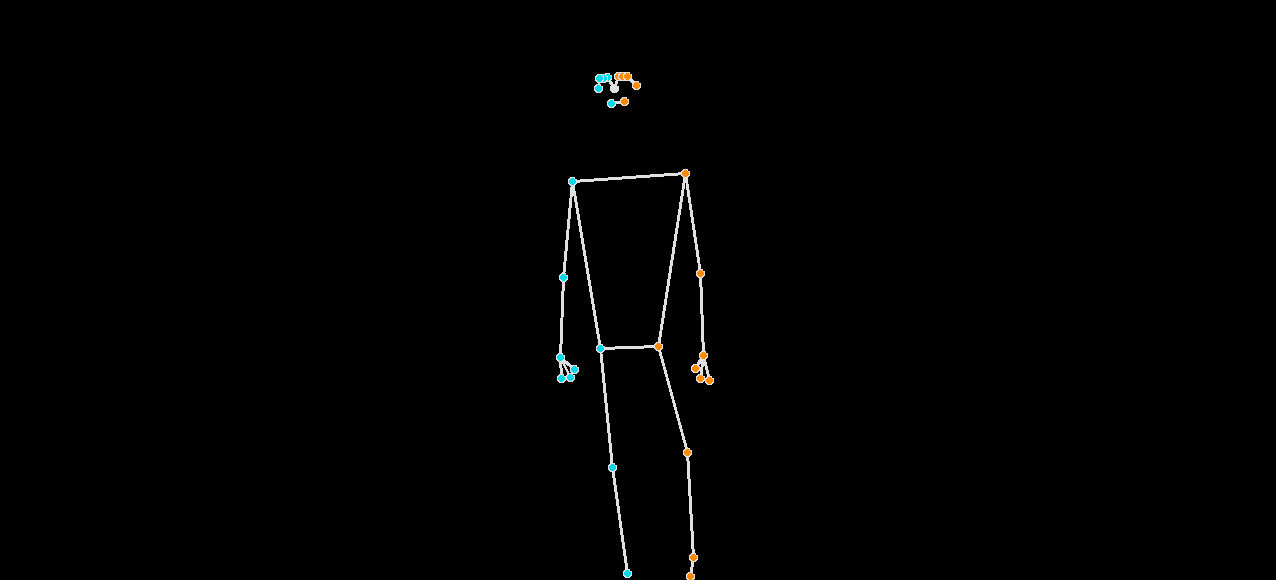

580 1276 3


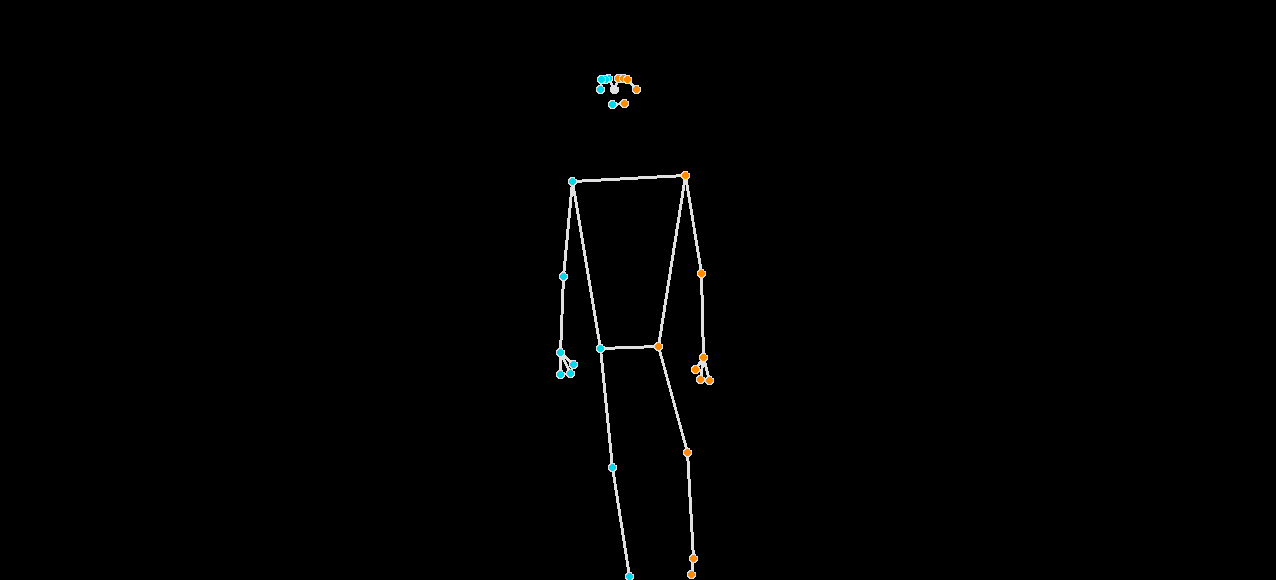

580 1276 3


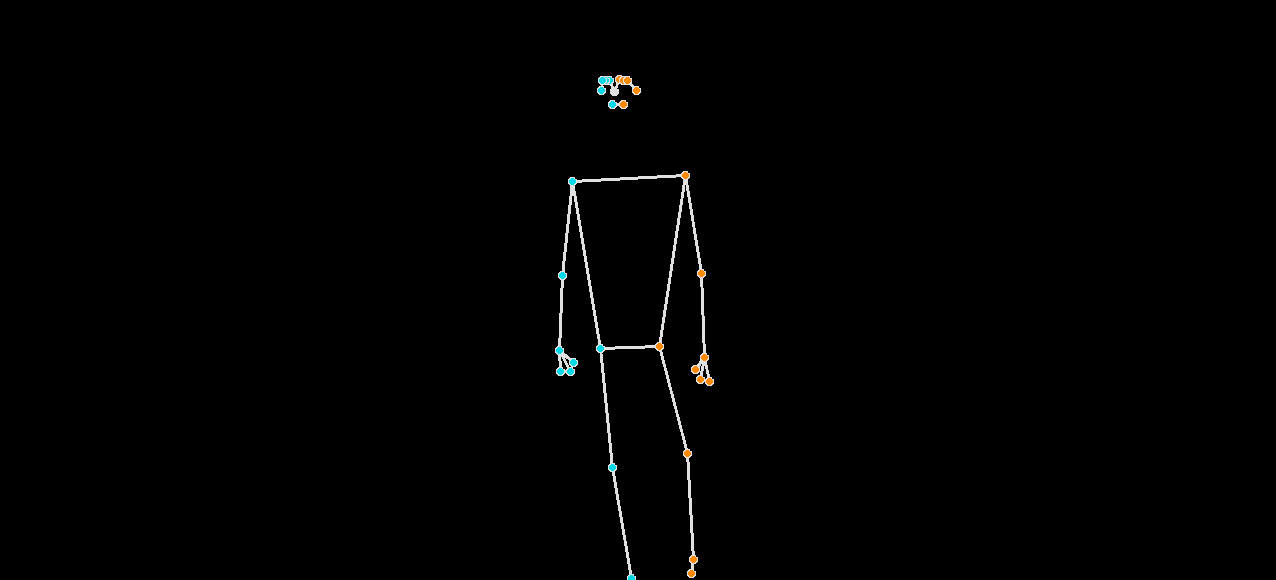

580 1276 3


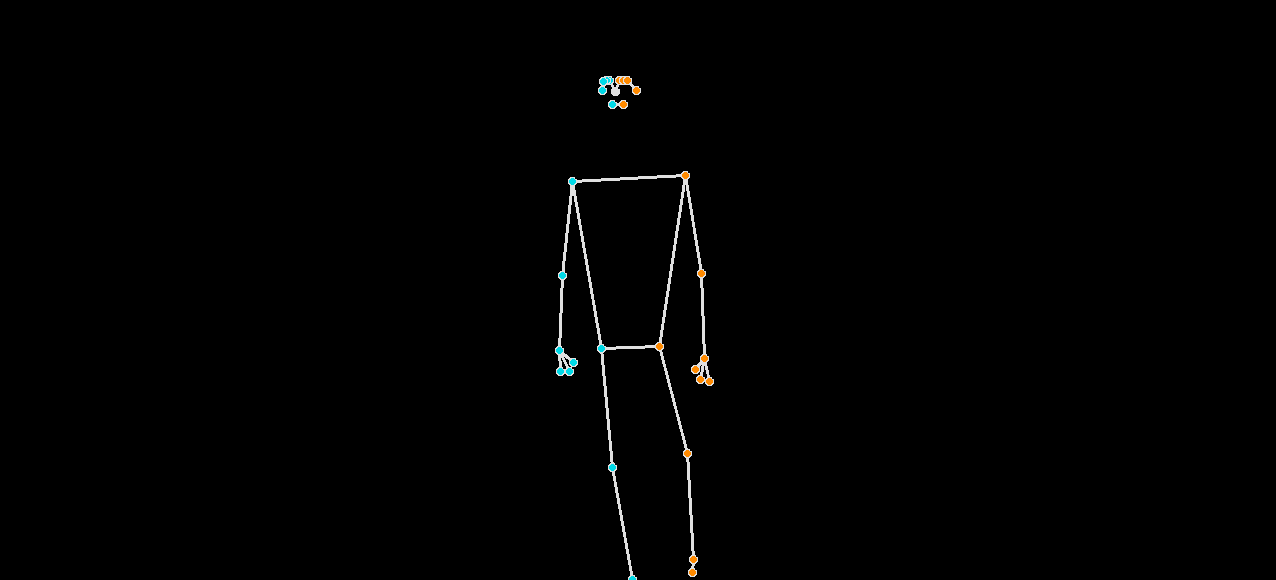

580 1276 3


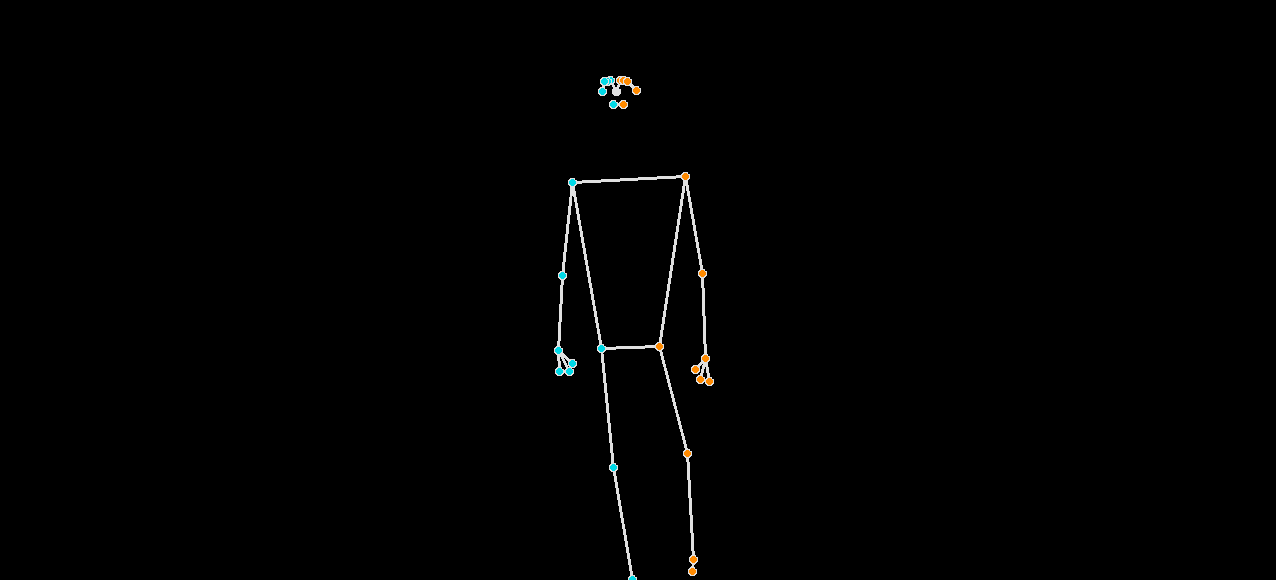

580 1276 3


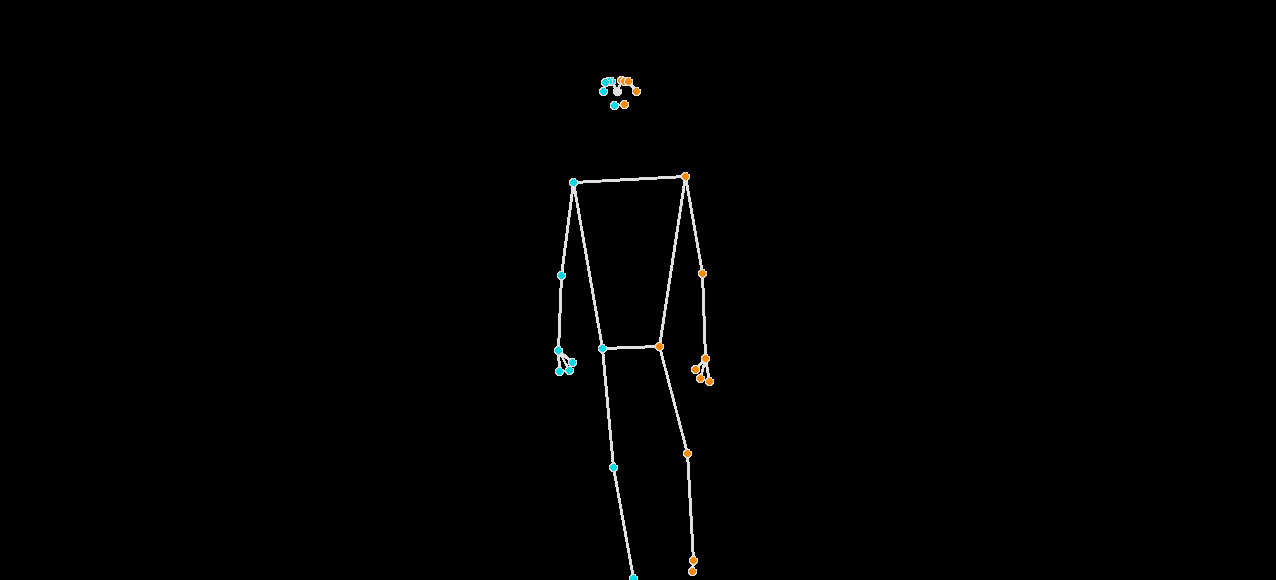

580 1276 3


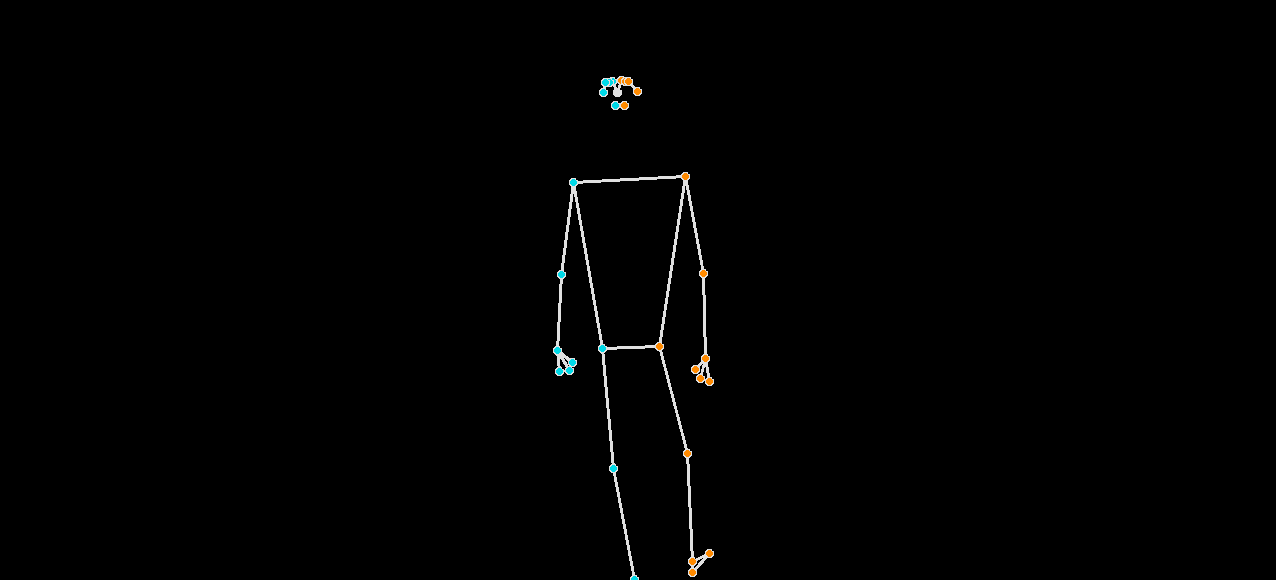

580 1276 3


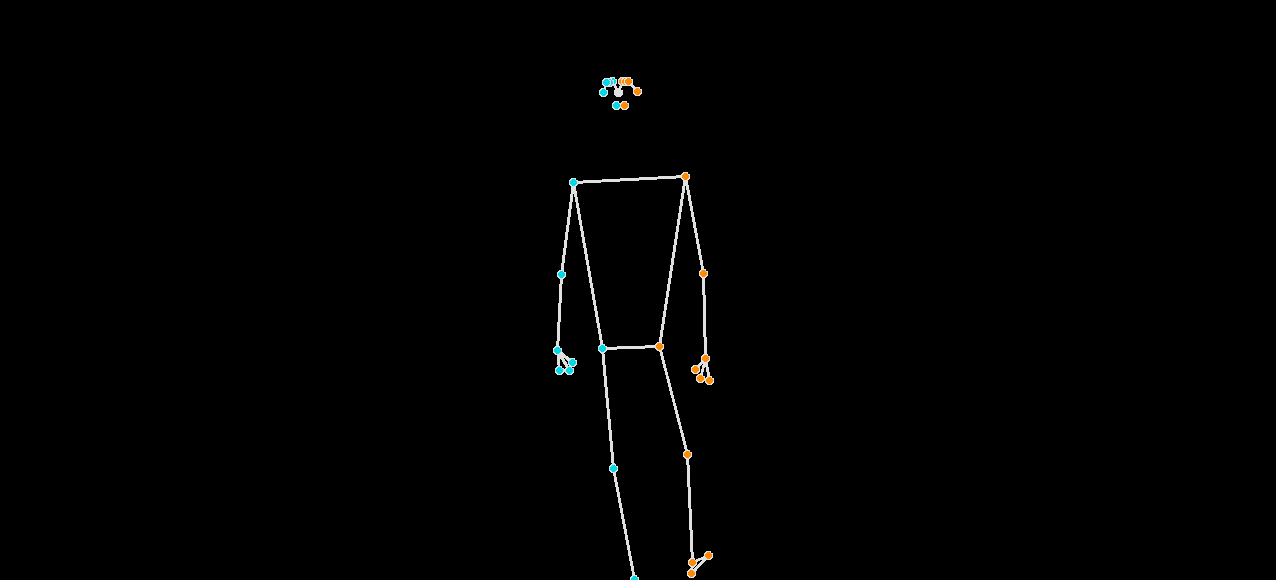

580 1276 3


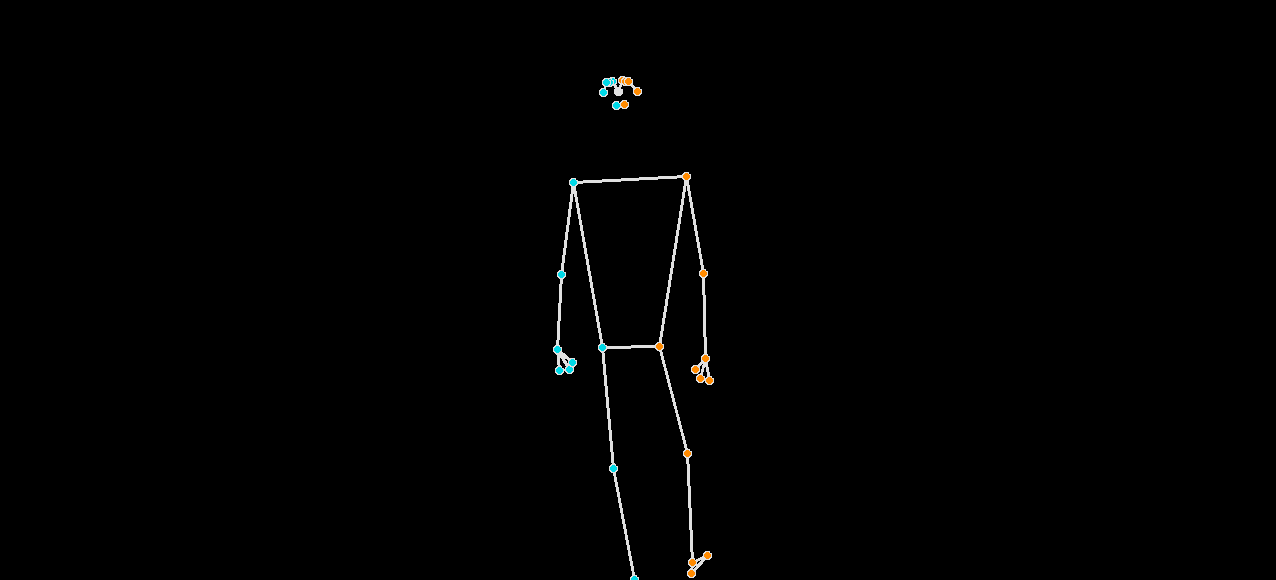

580 1276 3


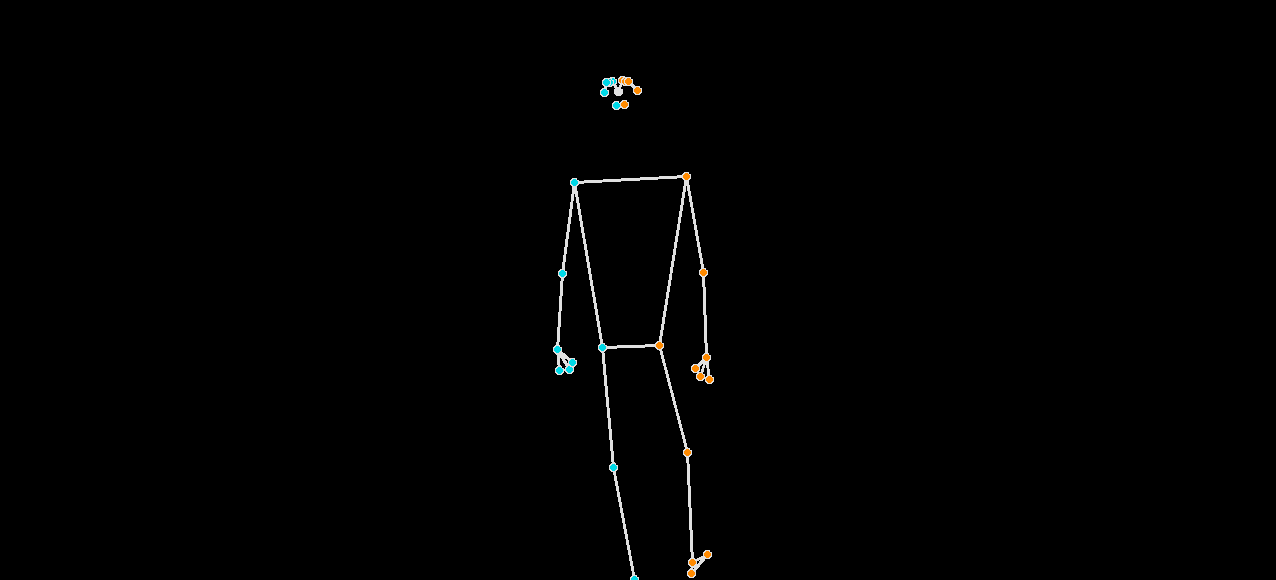

580 1276 3


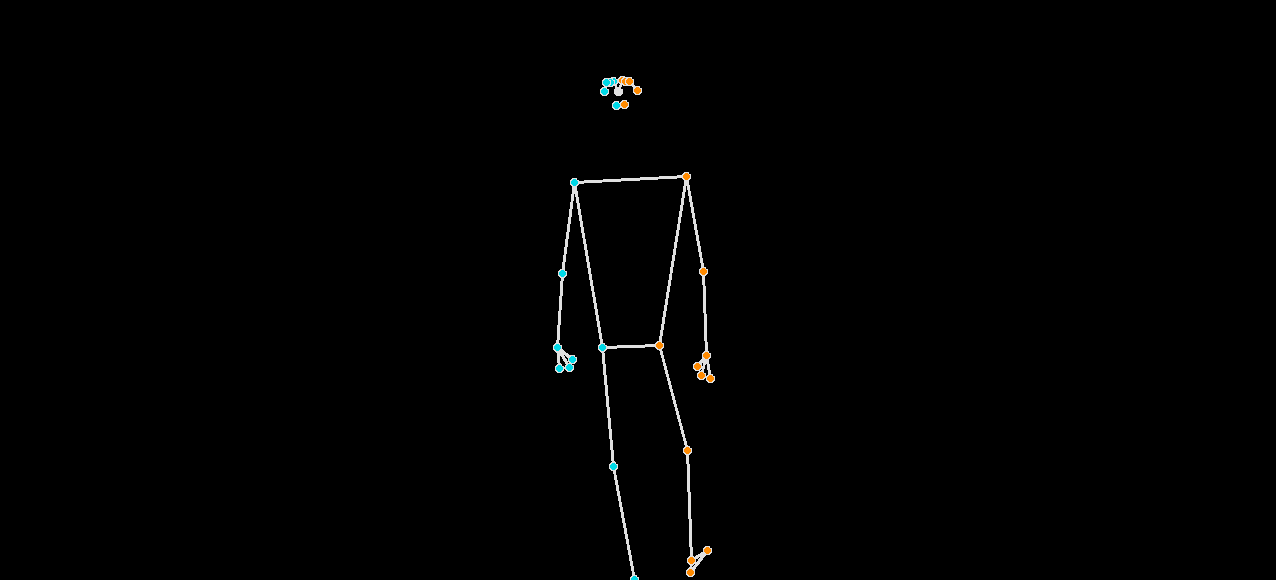

580 1276 3


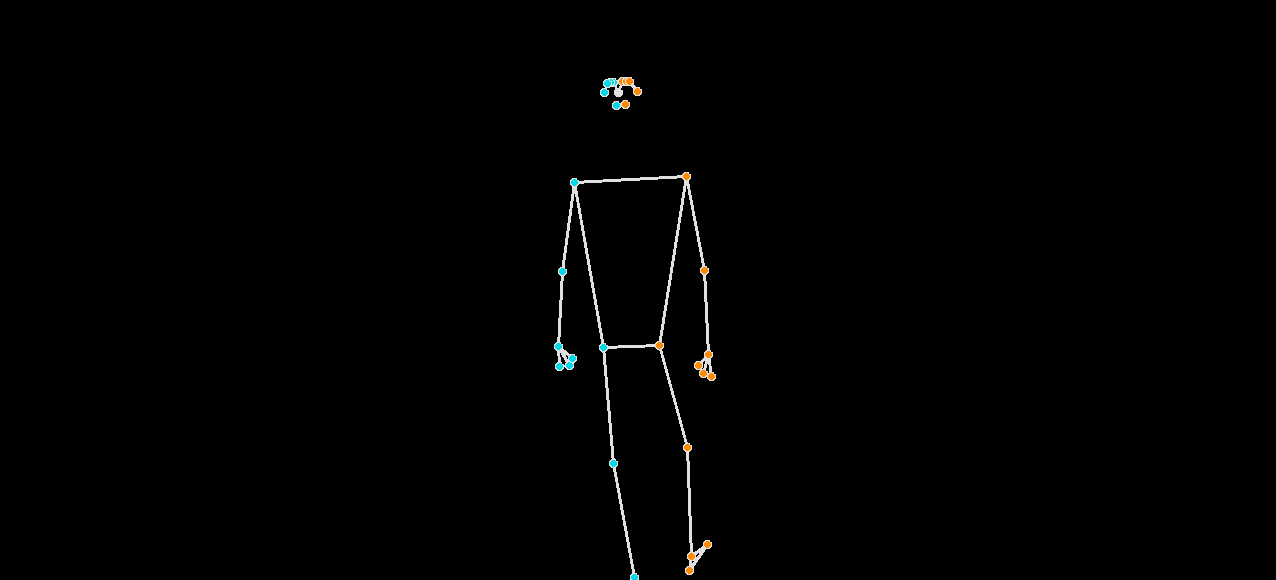

580 1276 3


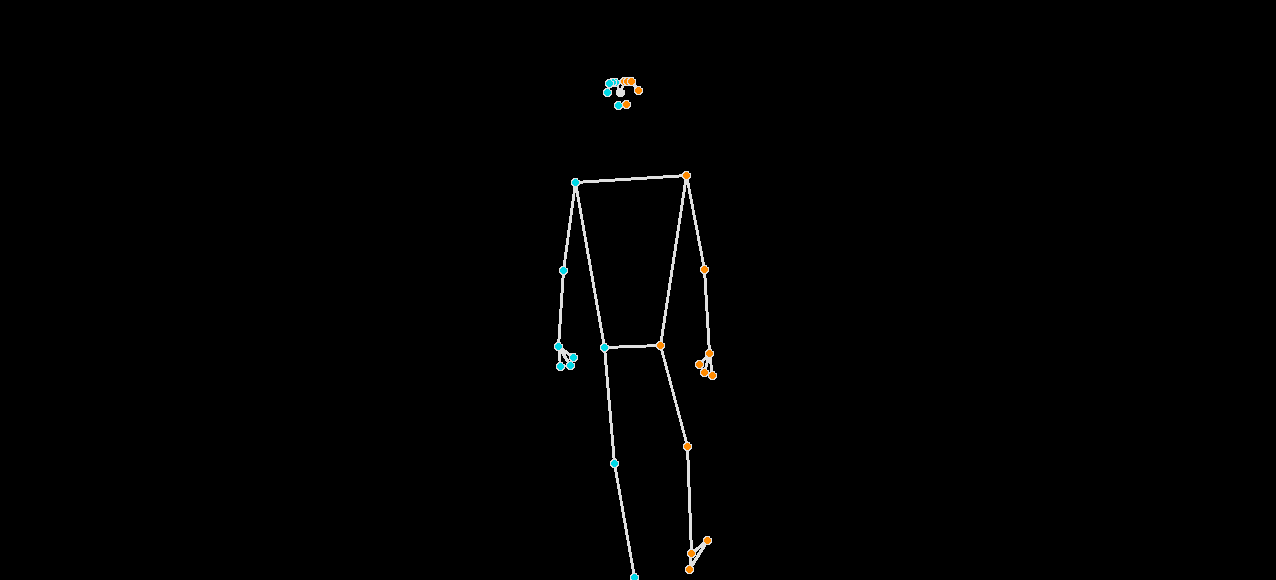

580 1276 3


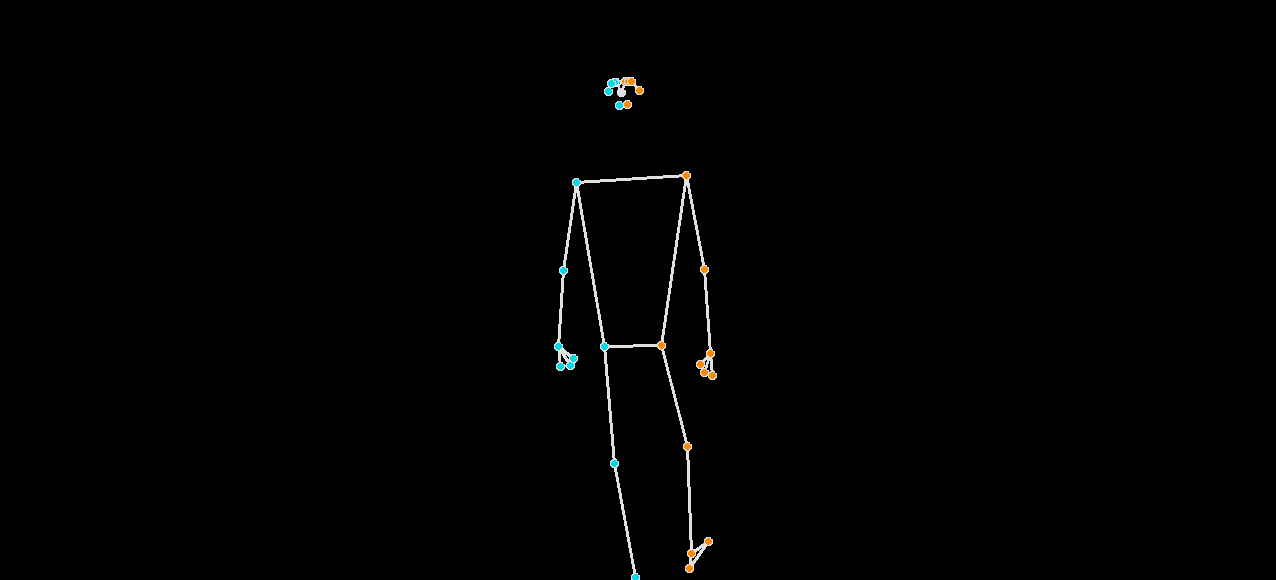

580 1276 3


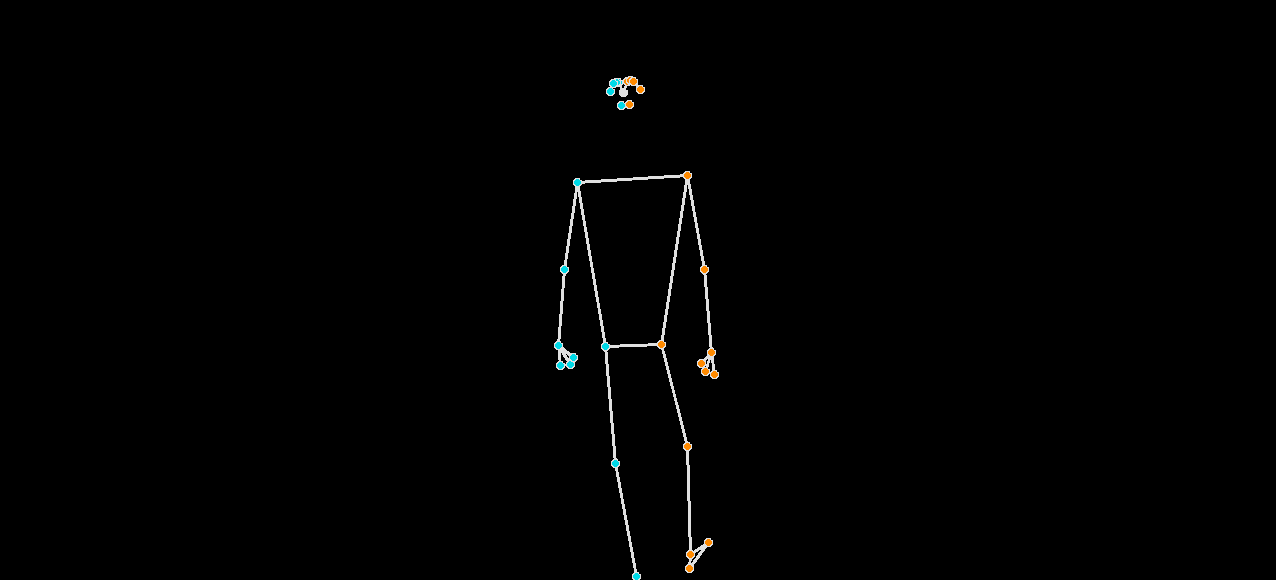

580 1276 3


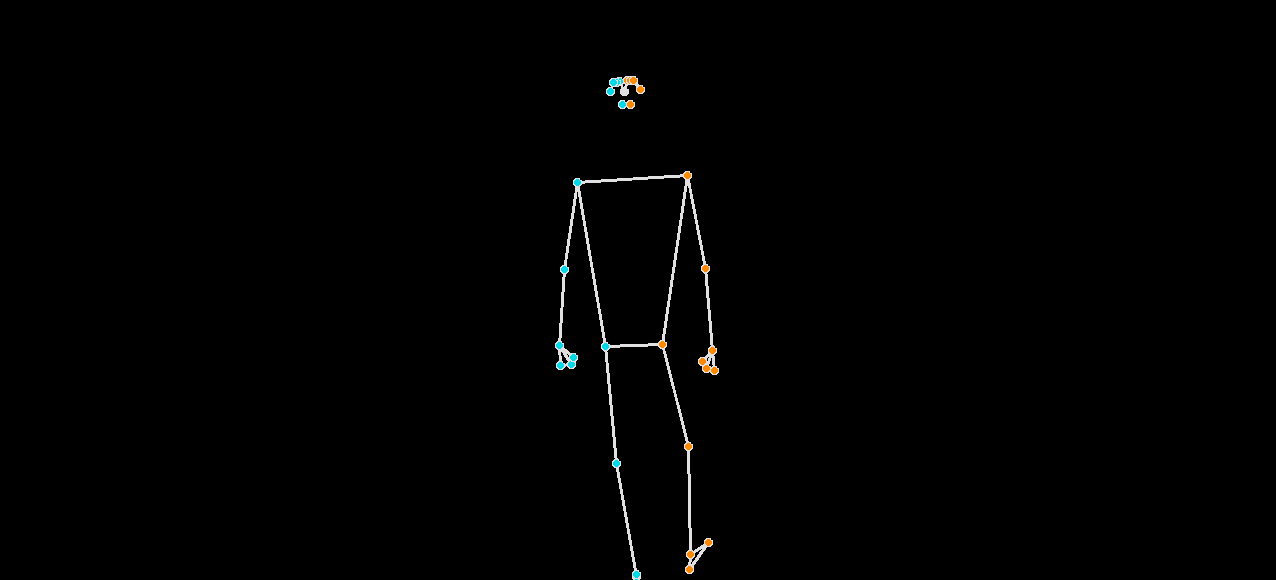

580 1276 3


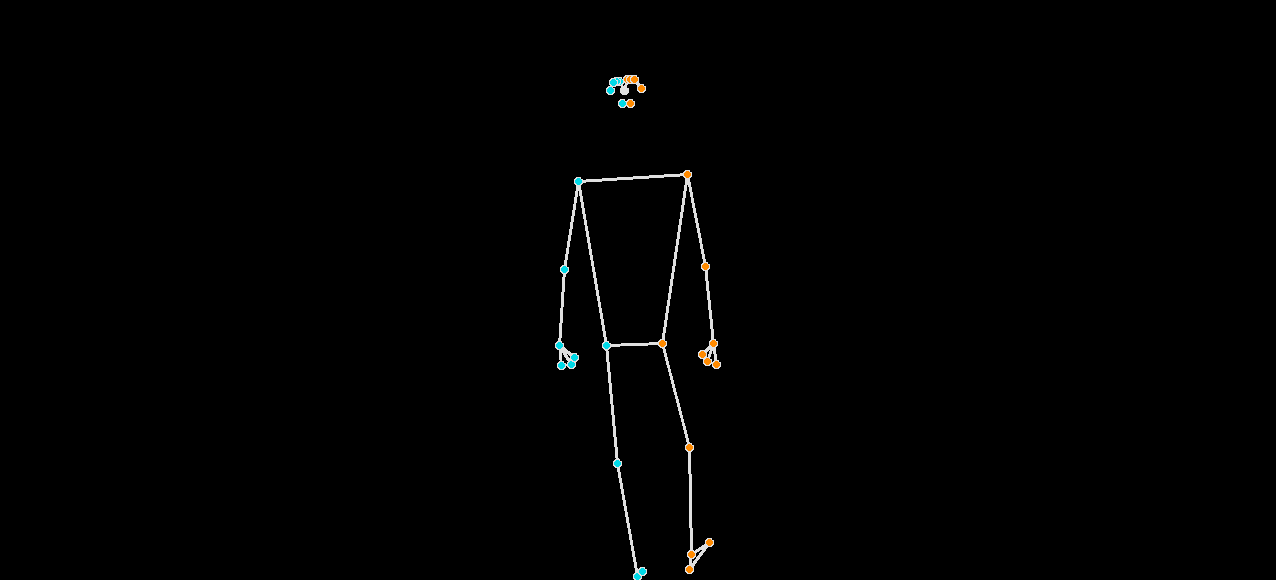

580 1276 3


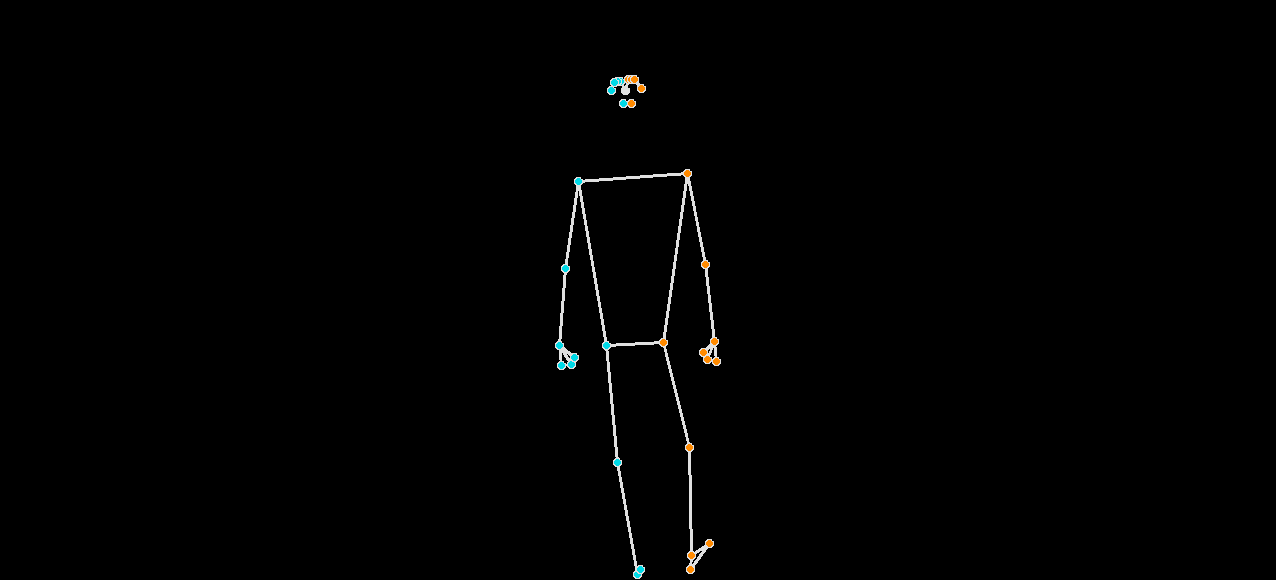

580 1276 3


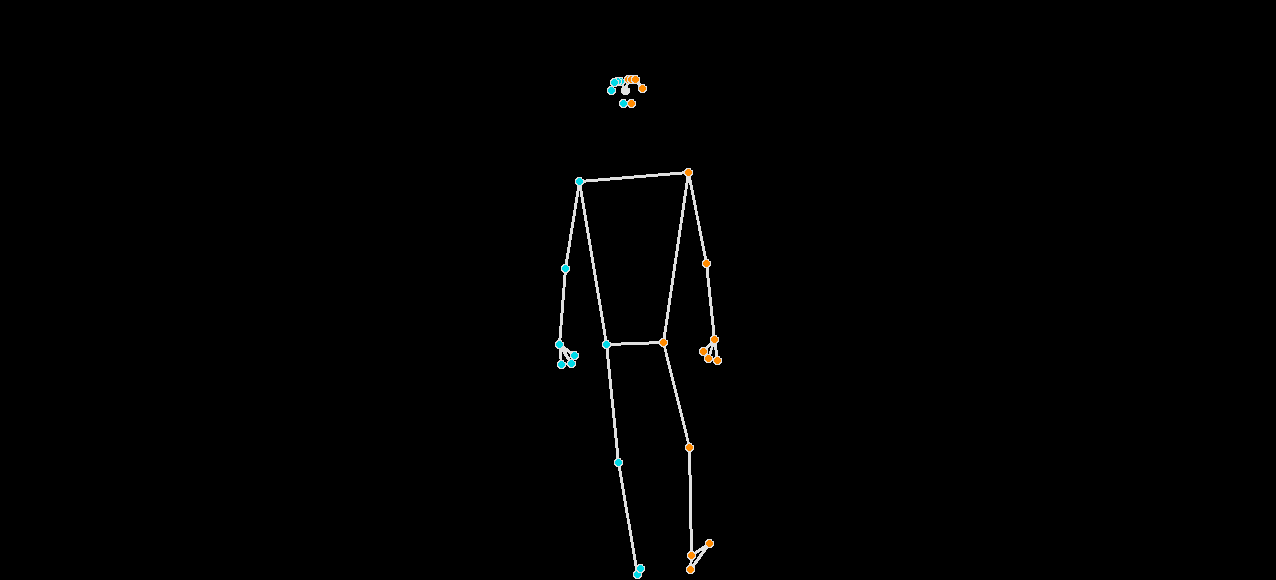

580 1276 3


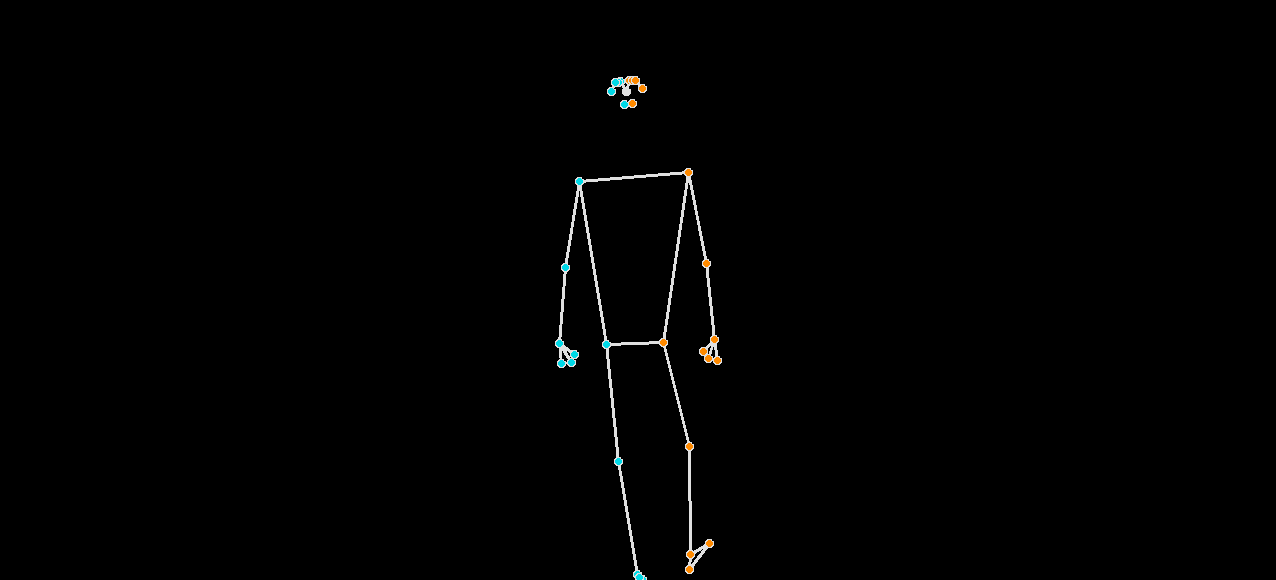

580 1276 3


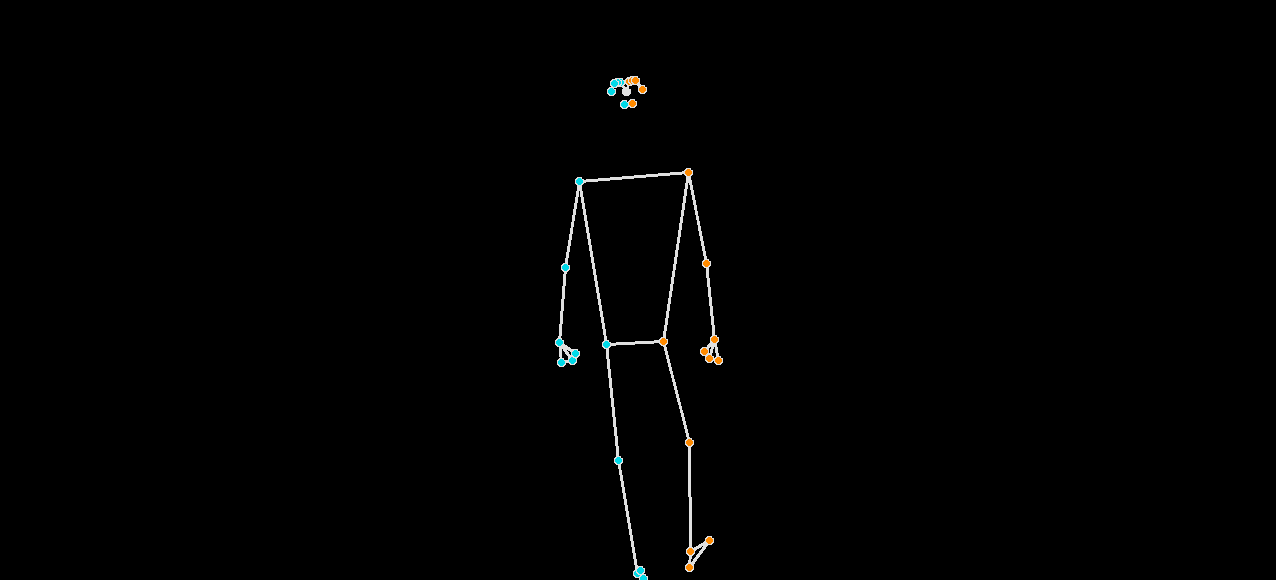

580 1276 3


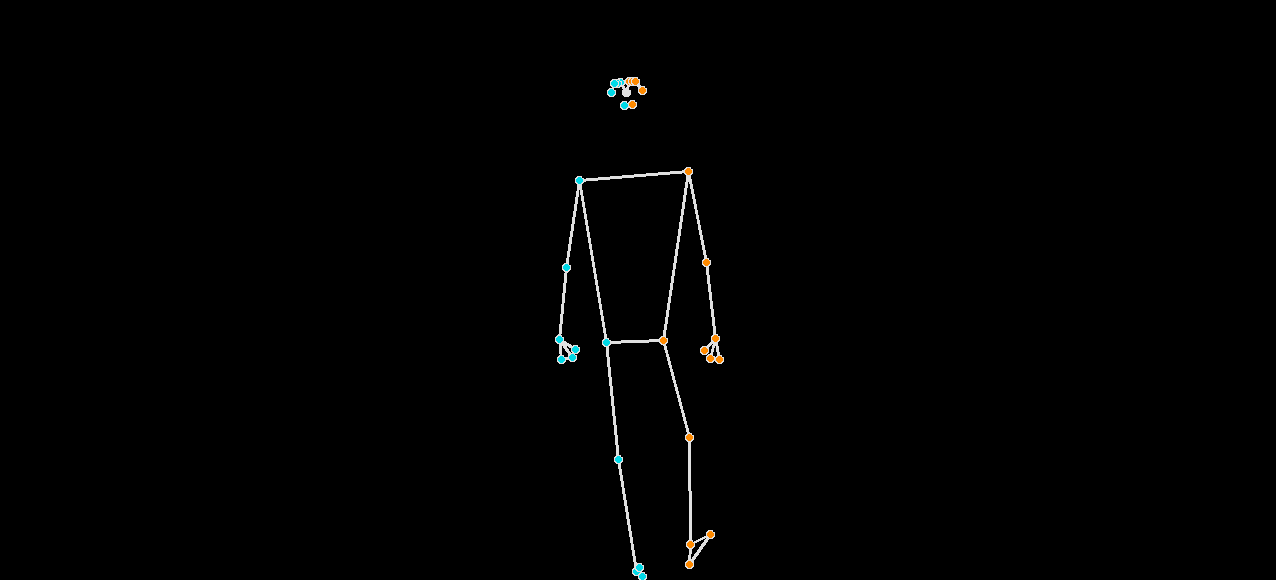

580 1276 3


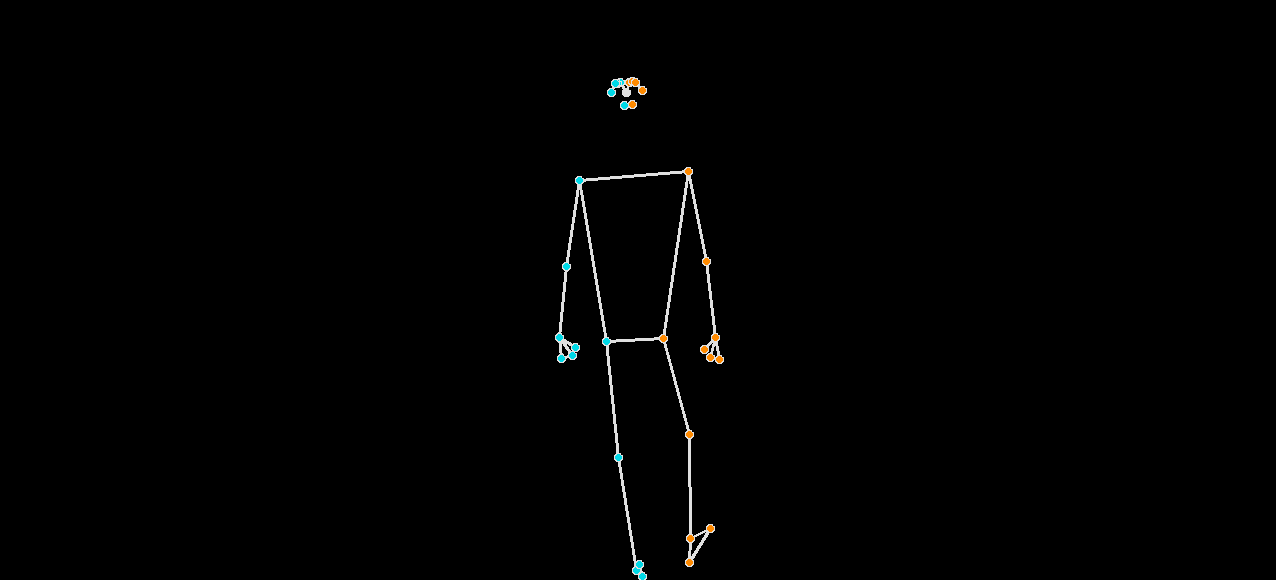

580 1276 3


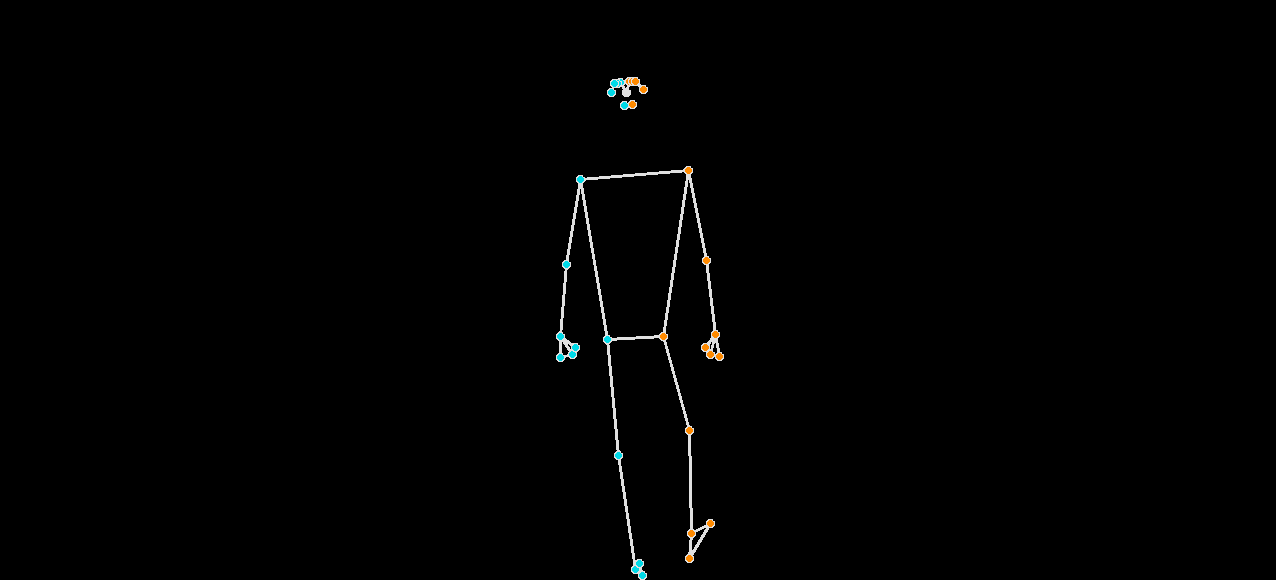

580 1276 3


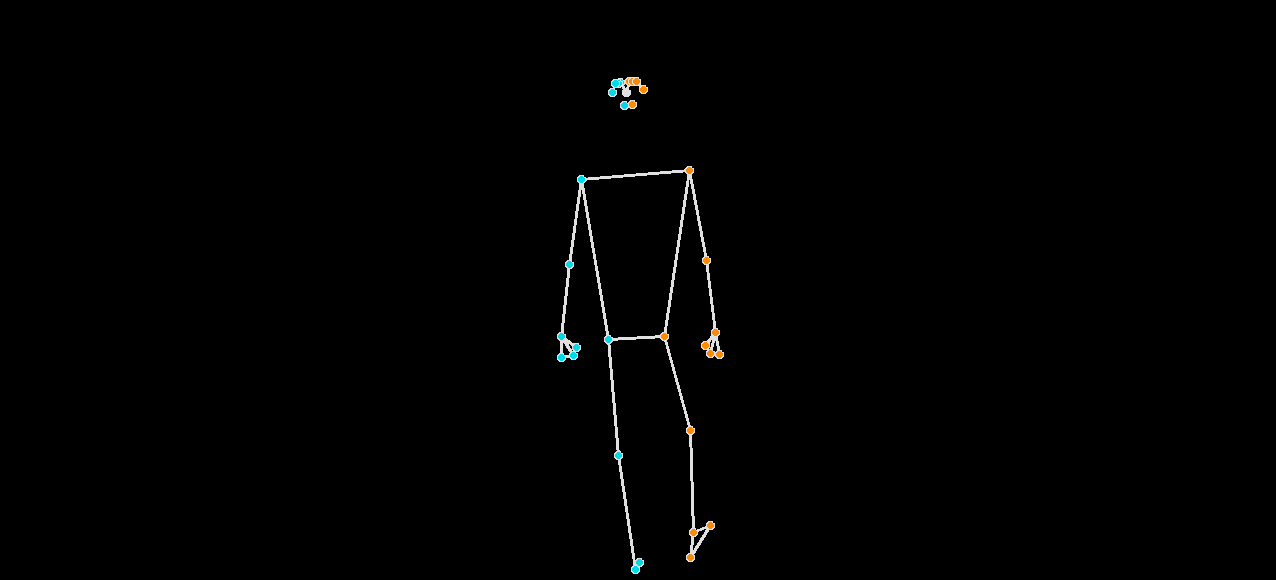

580 1276 3


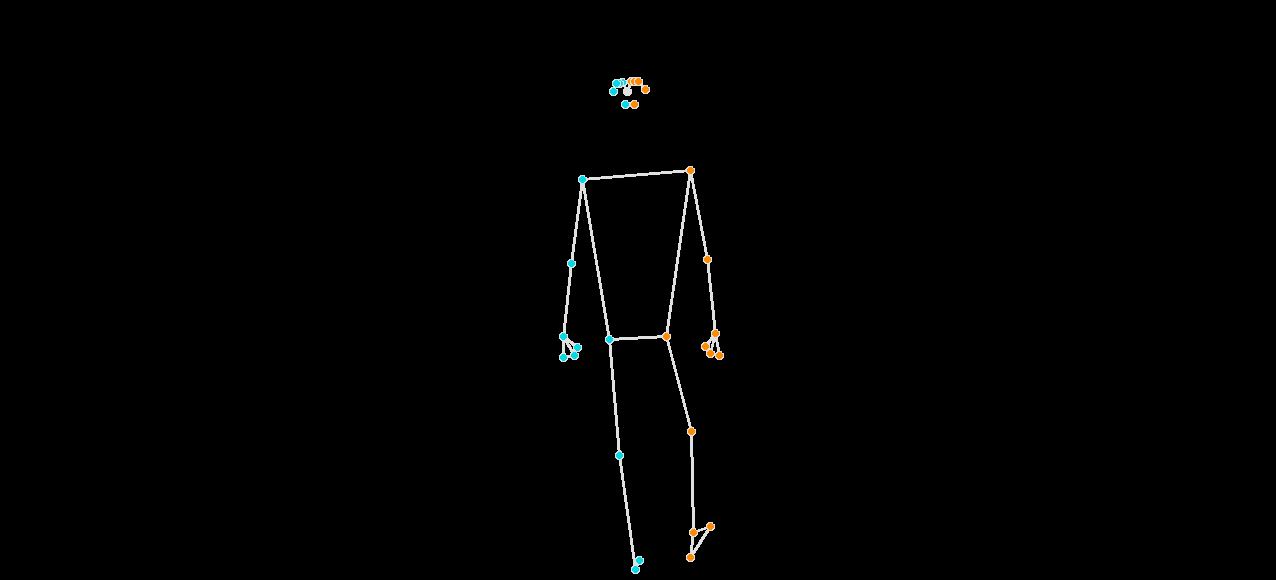

580 1276 3


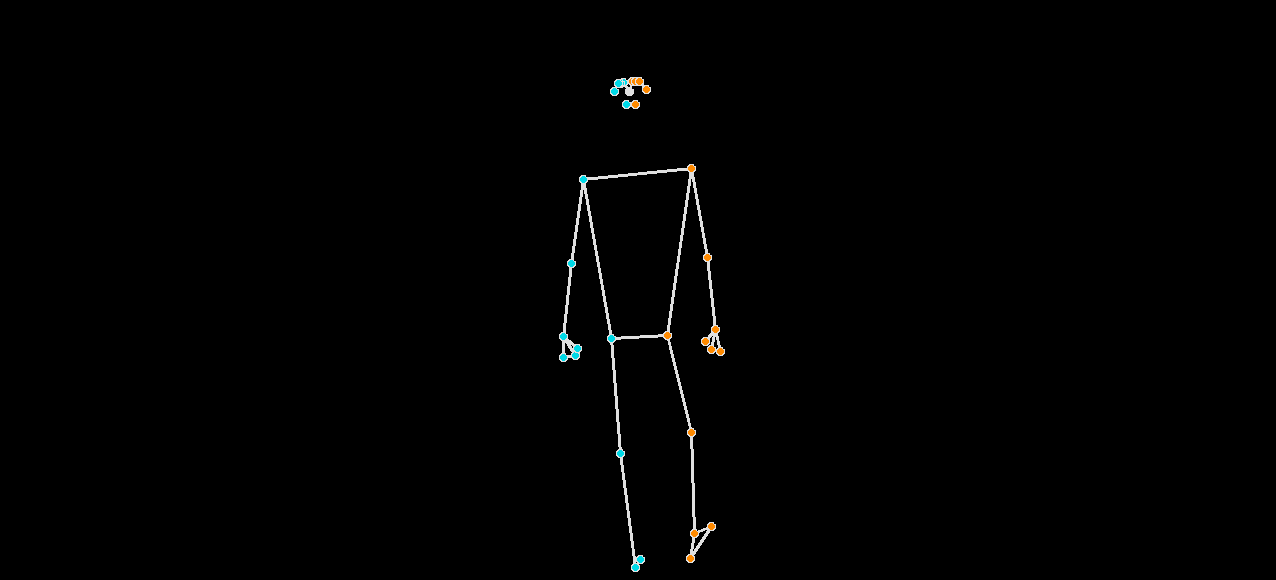

580 1276 3


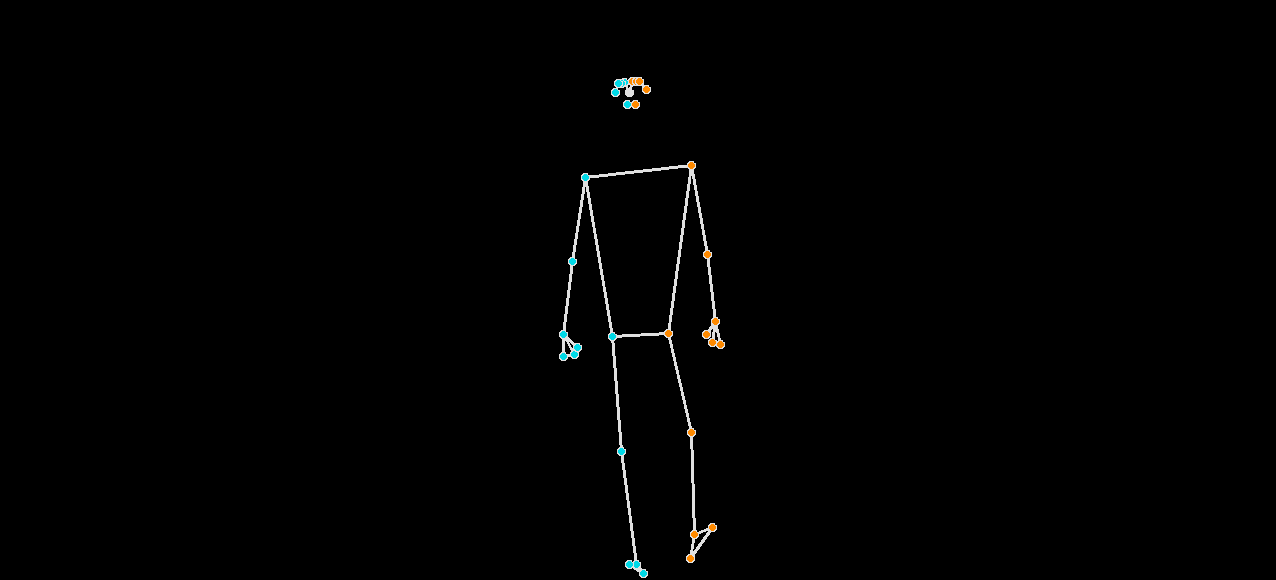

580 1276 3


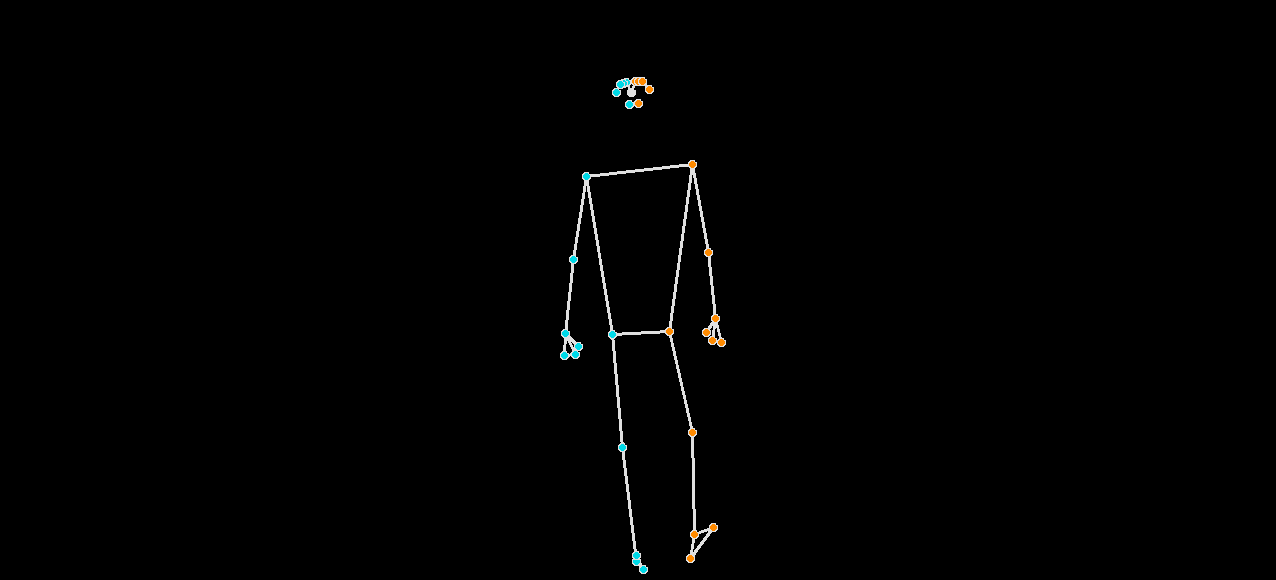

580 1276 3


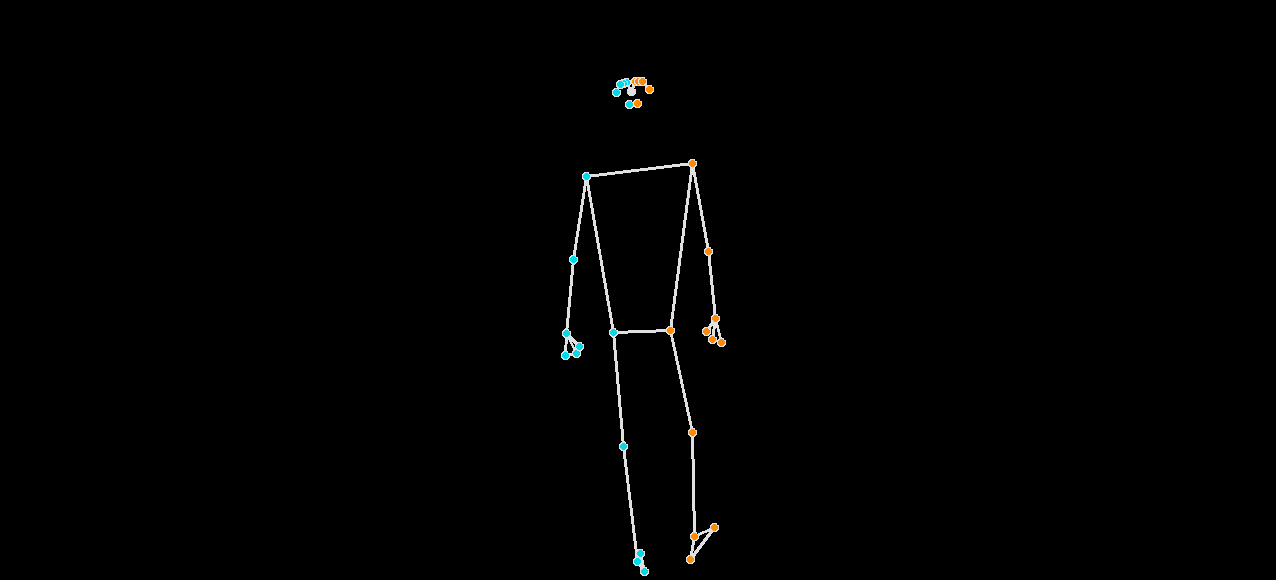

580 1276 3


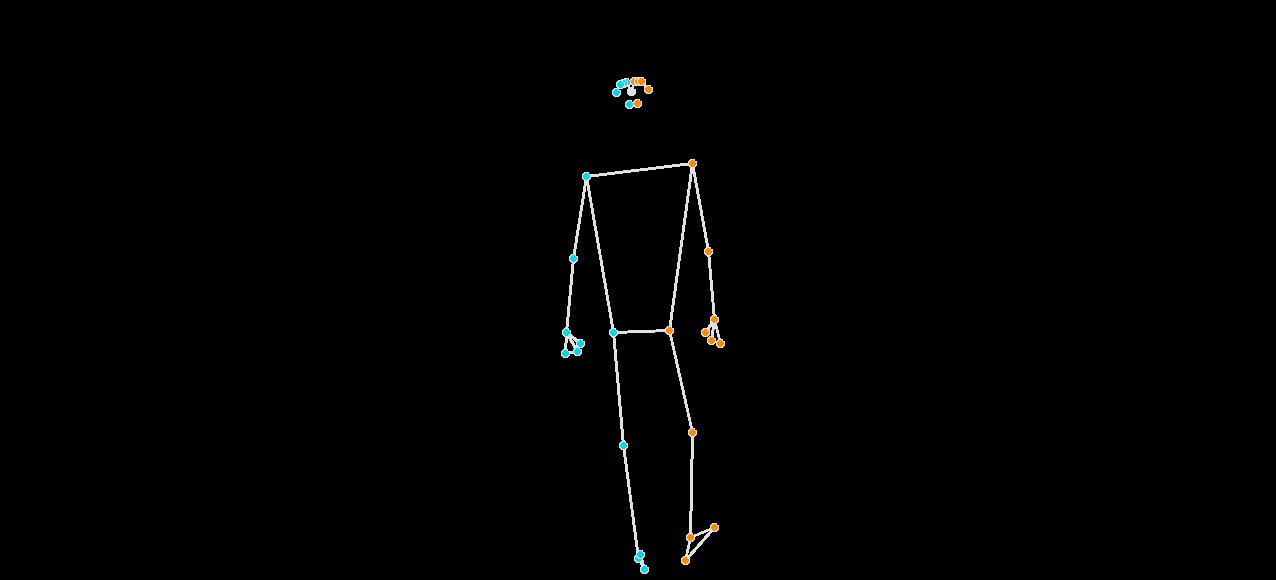

580 1276 3


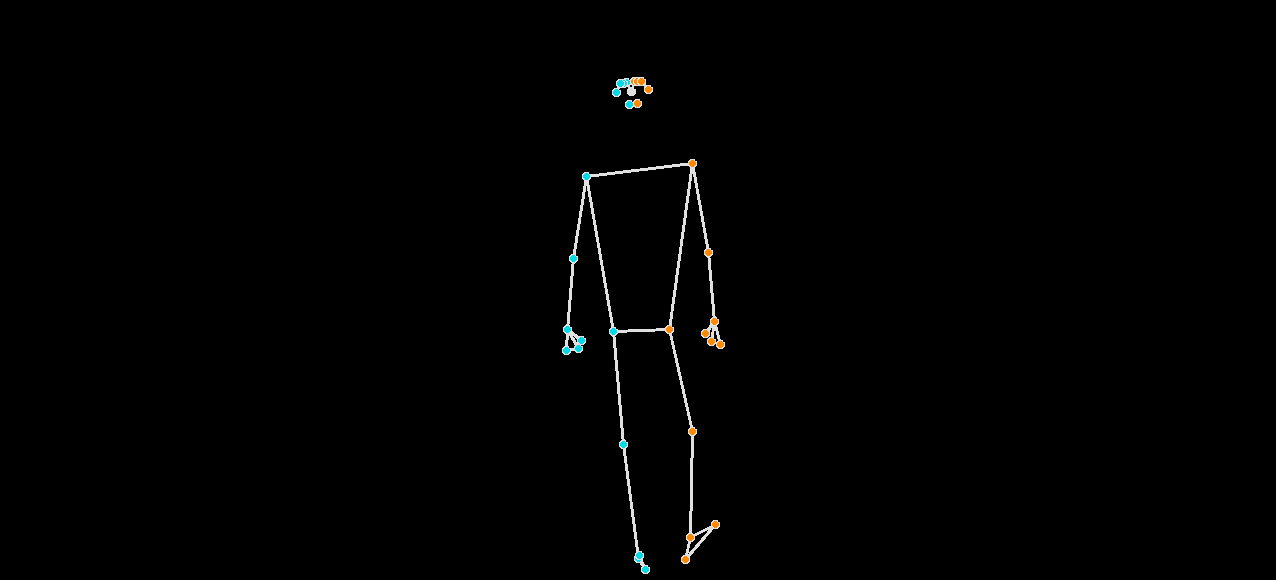

580 1276 3


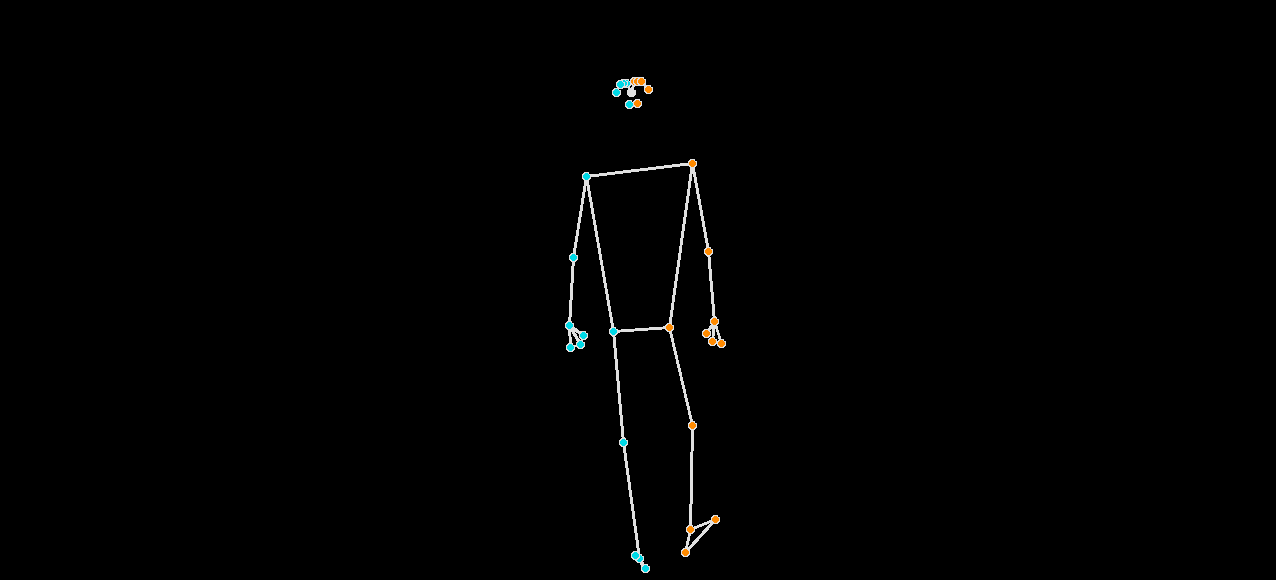

580 1276 3


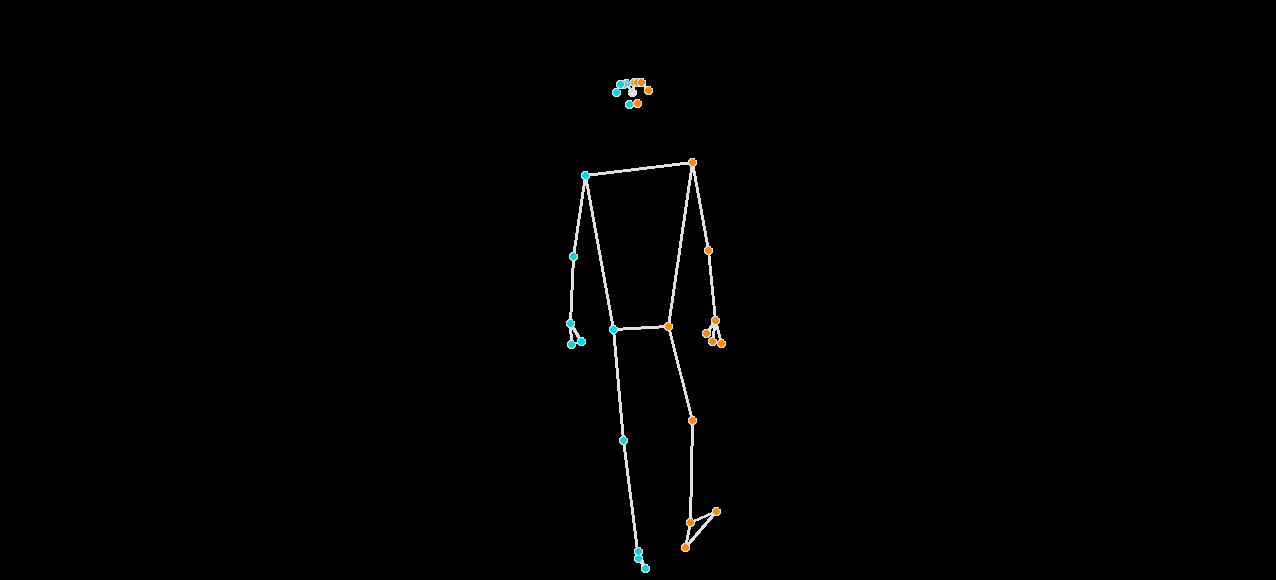

580 1276 3


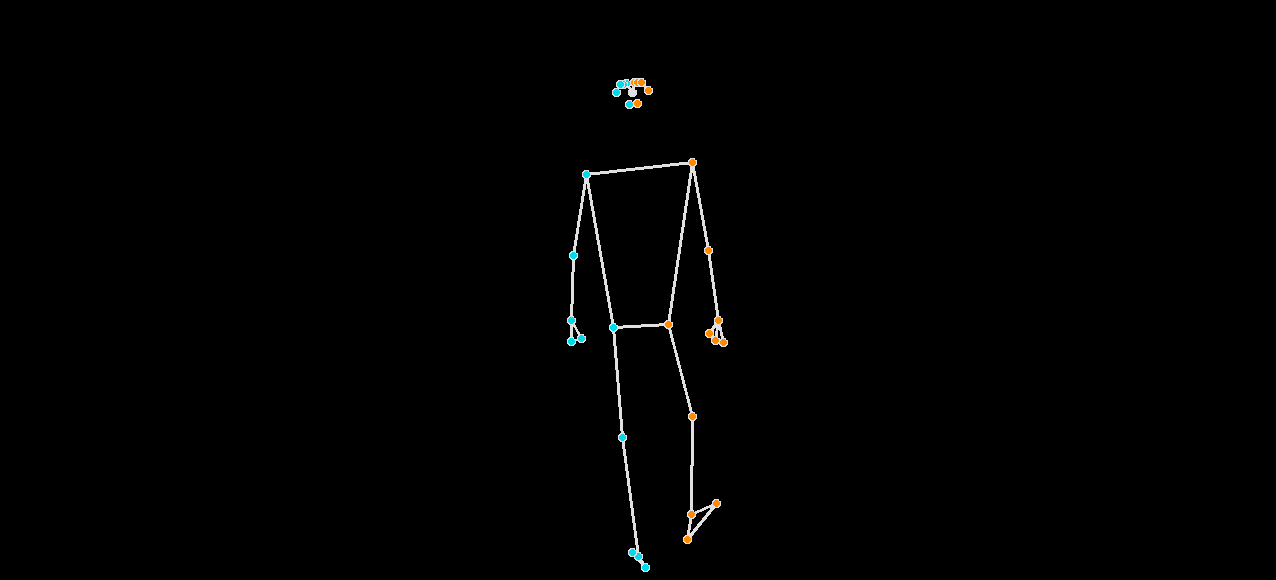

580 1276 3


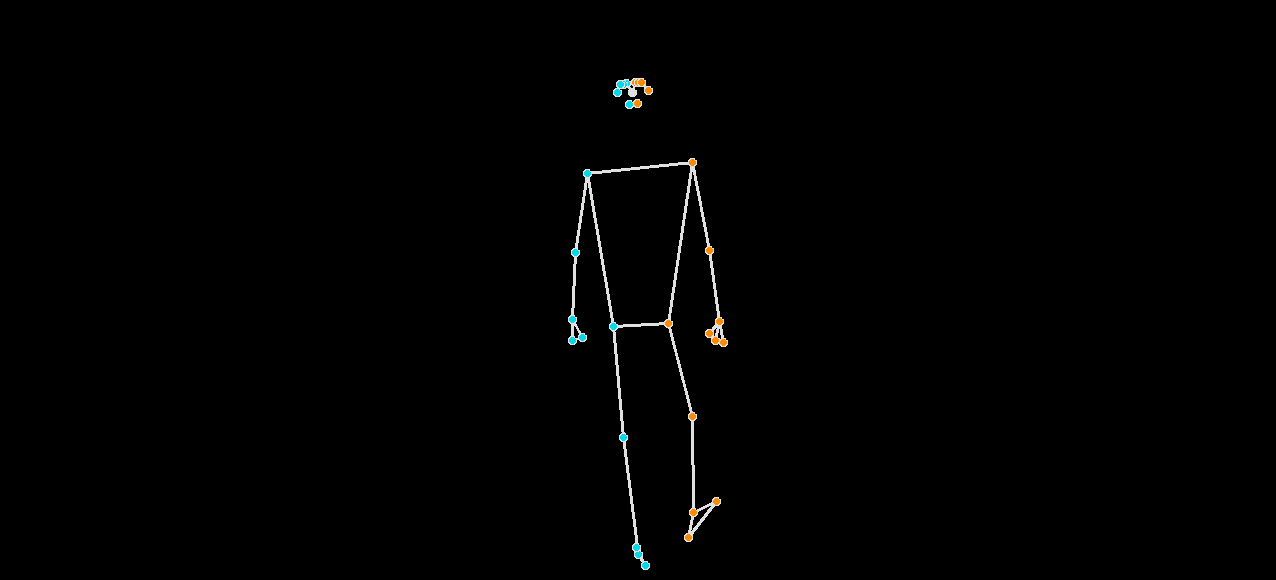

580 1276 3


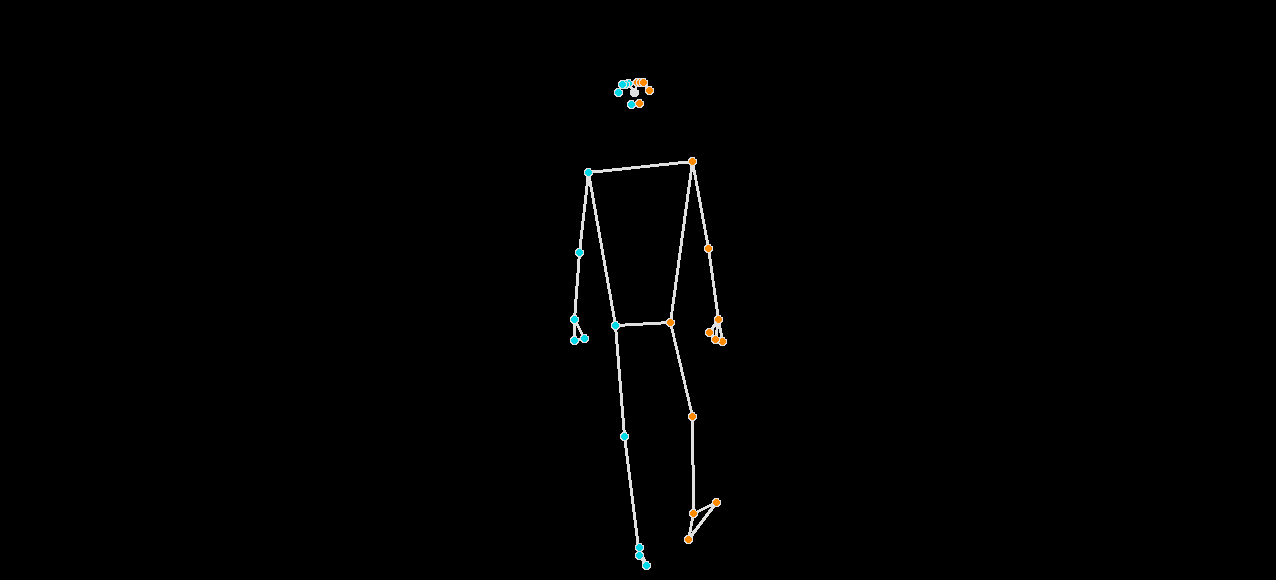

580 1276 3


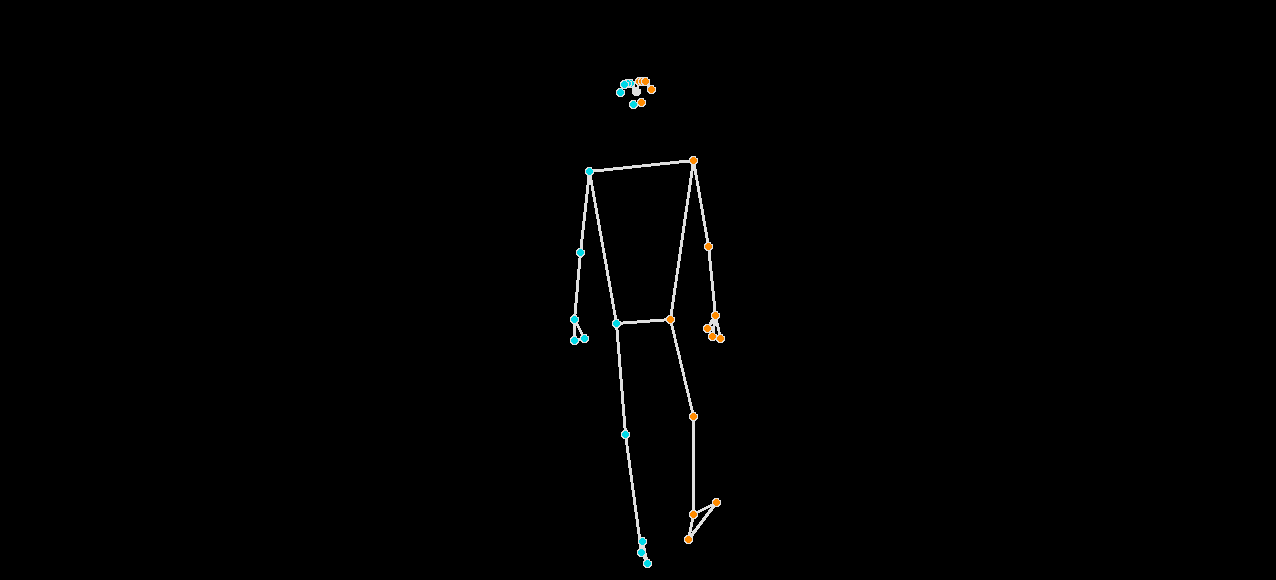

580 1276 3


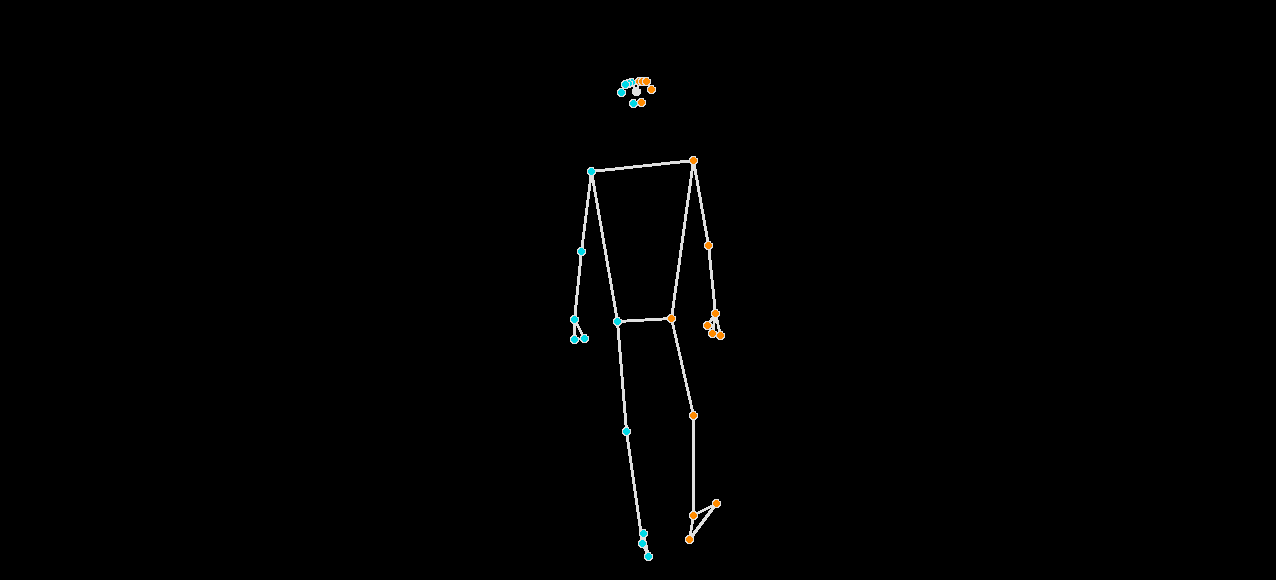

580 1276 3


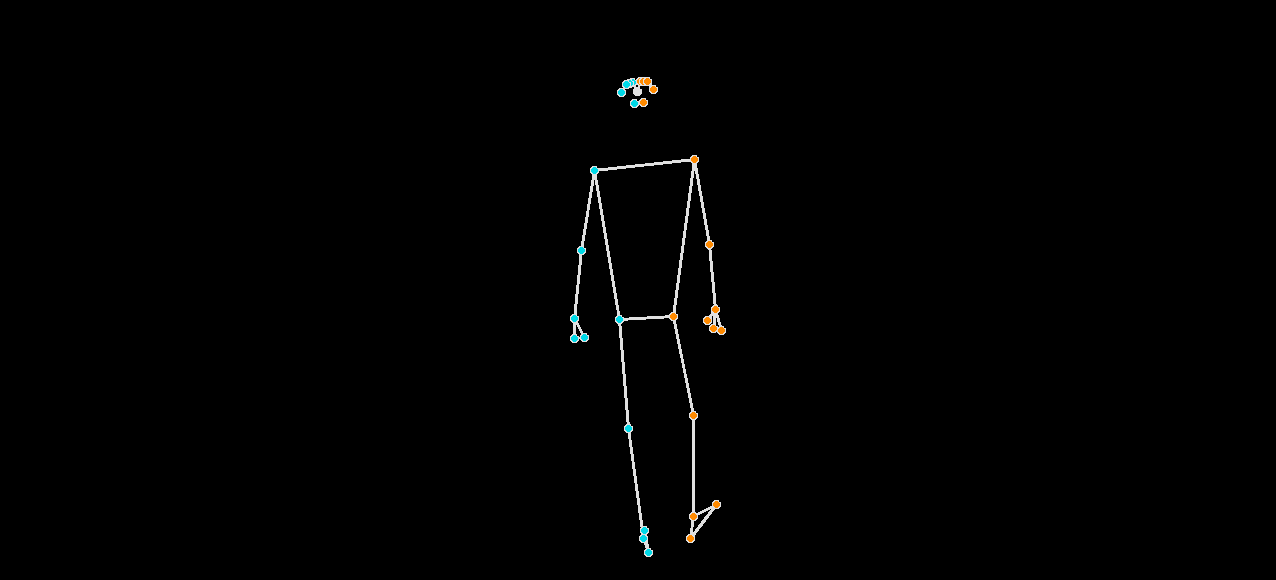

580 1276 3


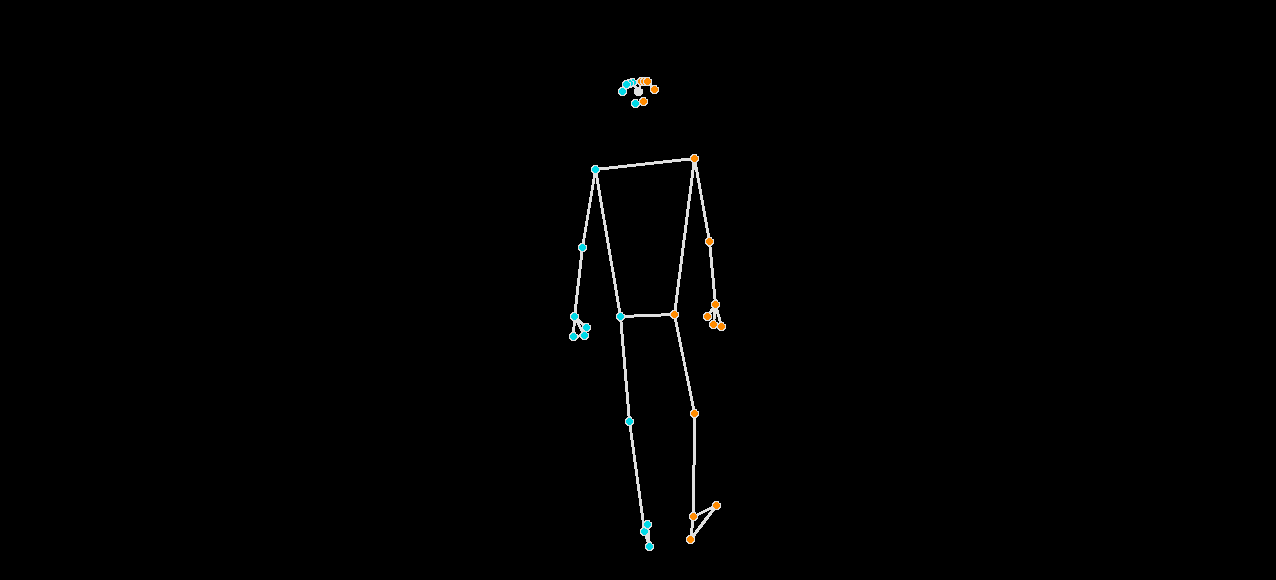

580 1276 3


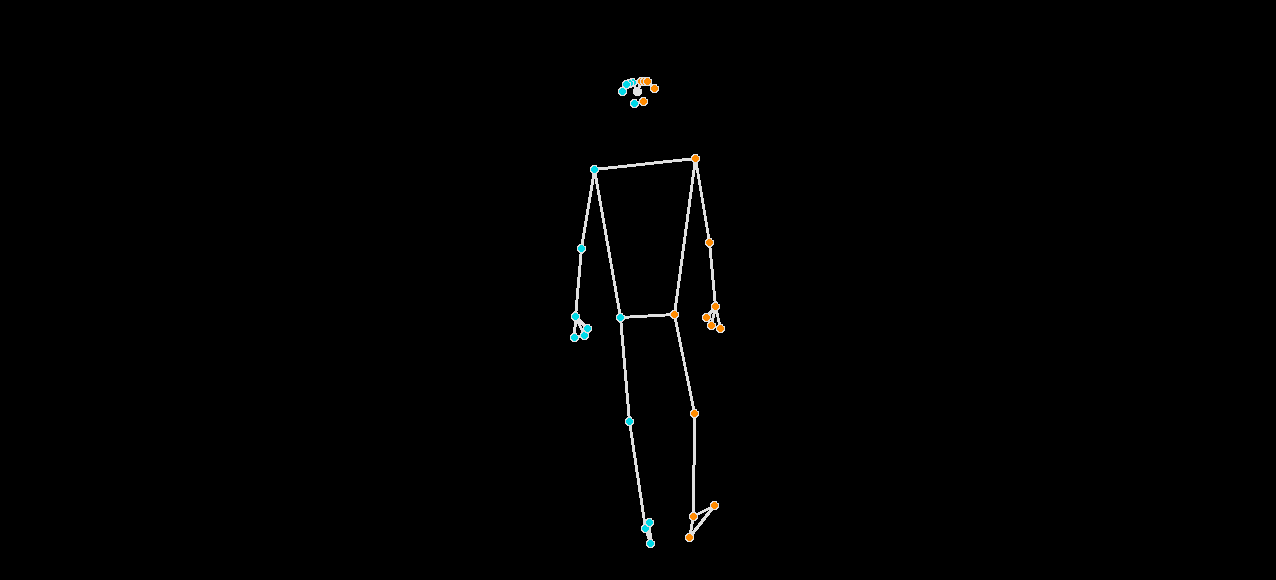

580 1276 3


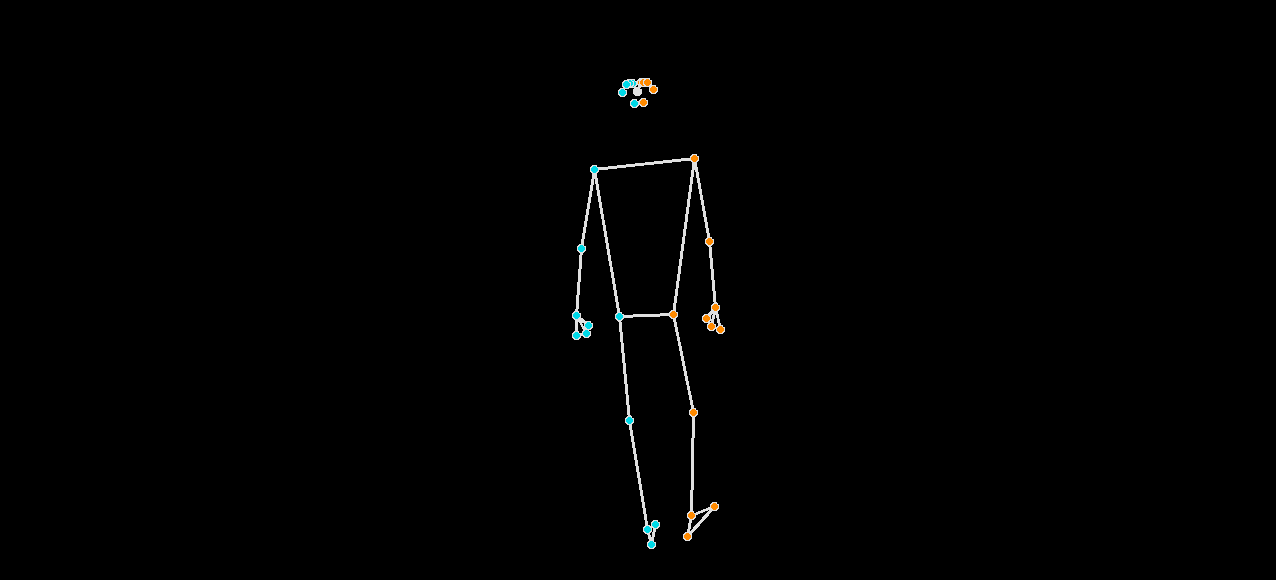

580 1276 3


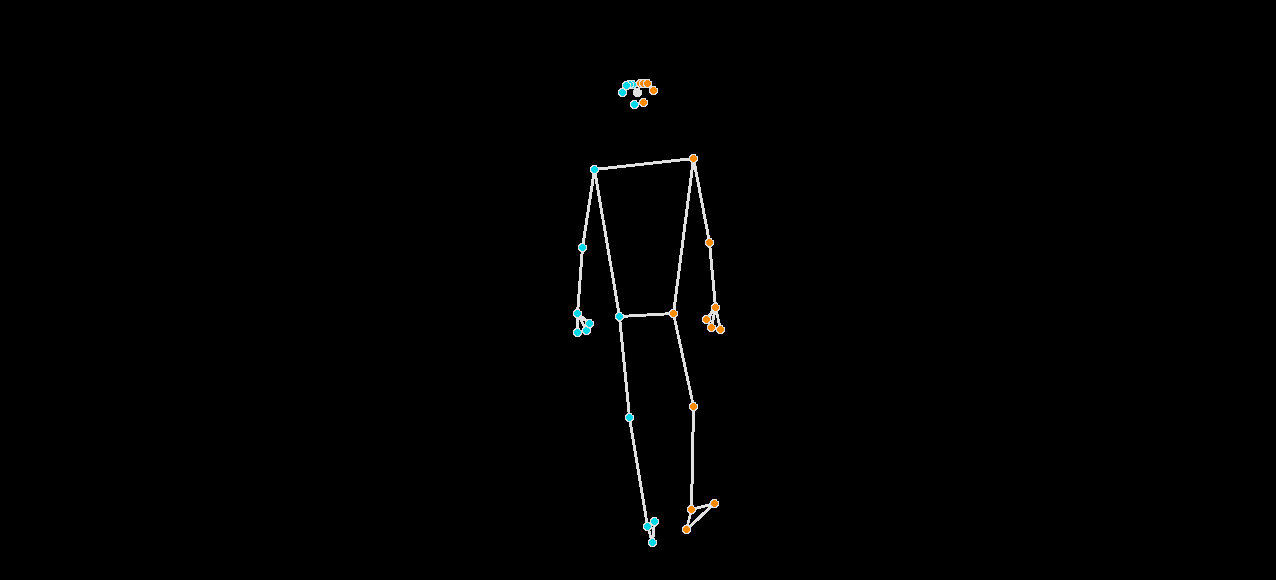

580 1276 3


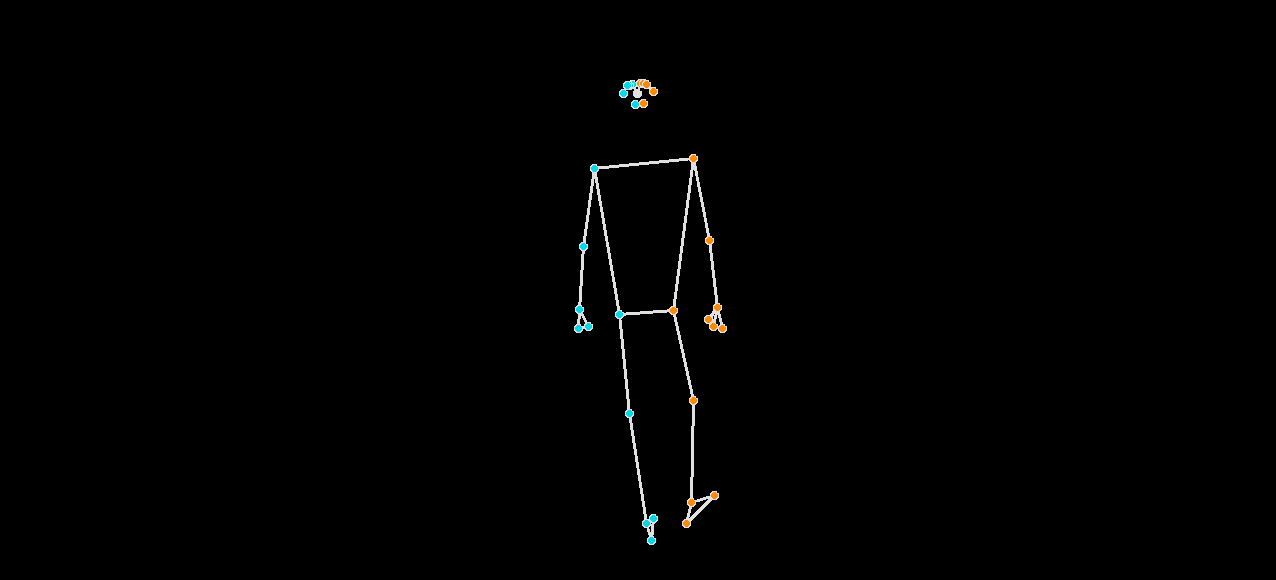

580 1276 3


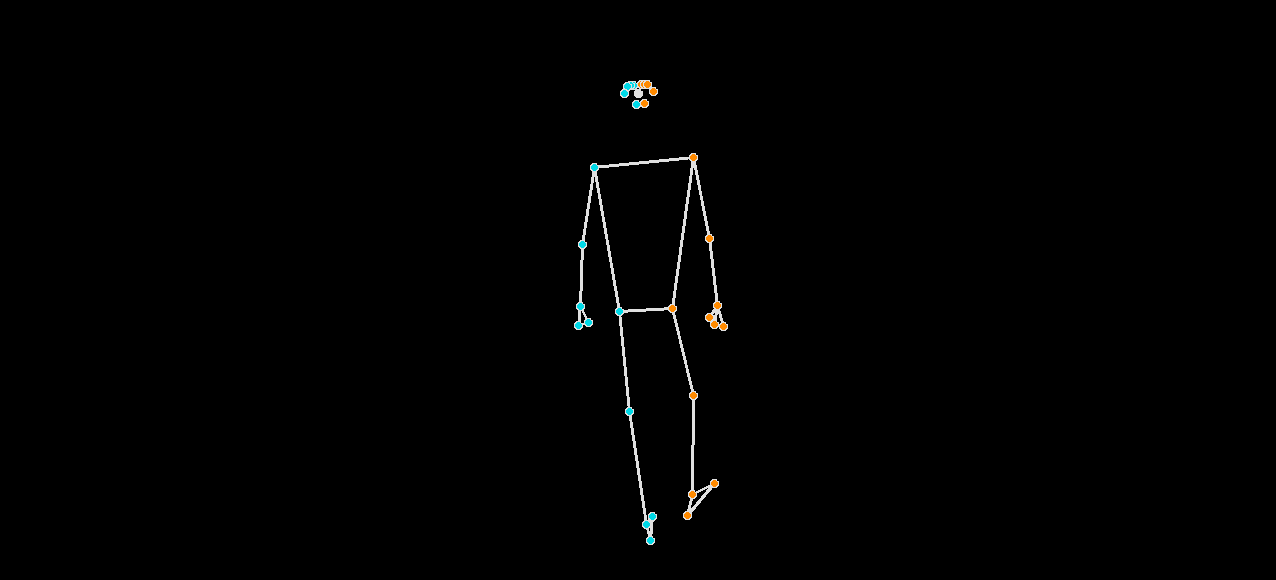

580 1276 3


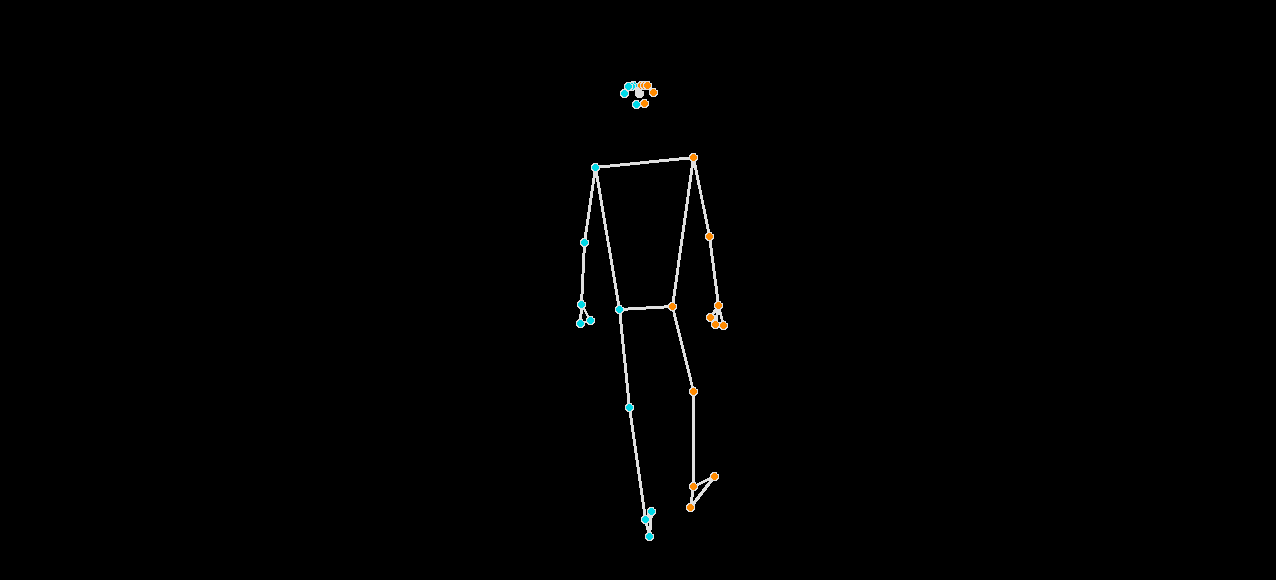

580 1276 3


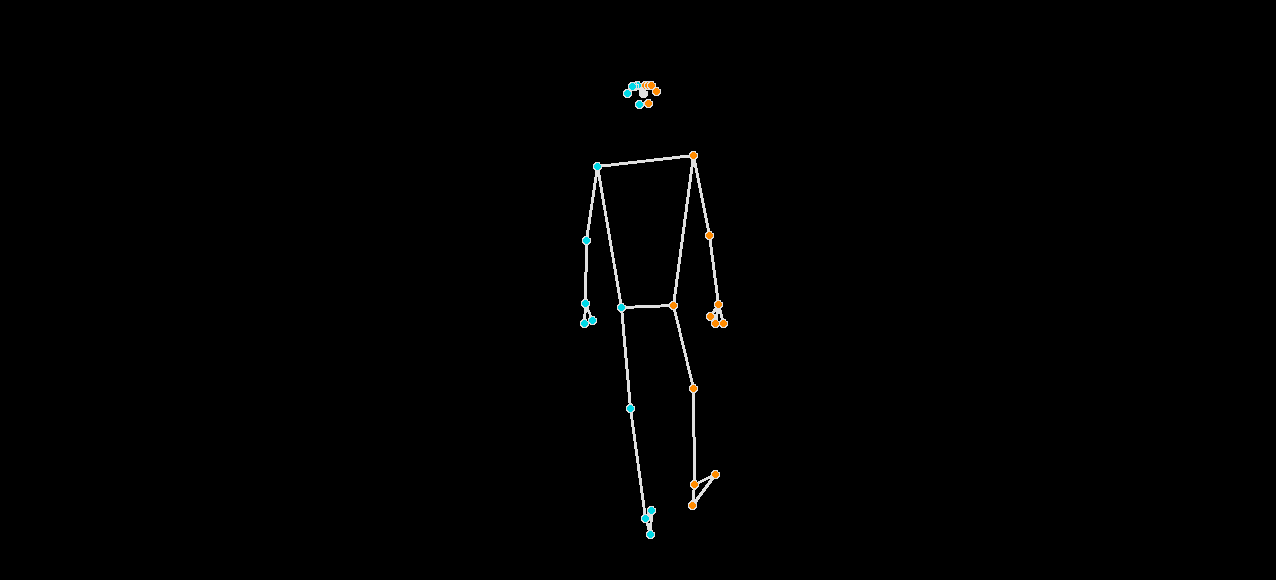

580 1276 3


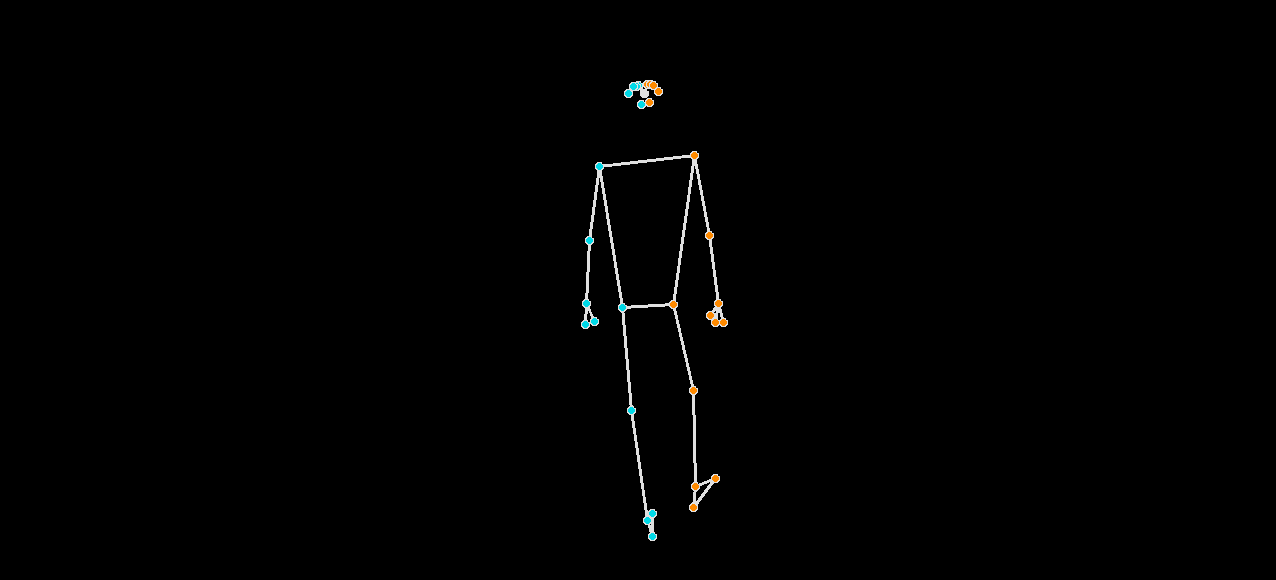

580 1276 3


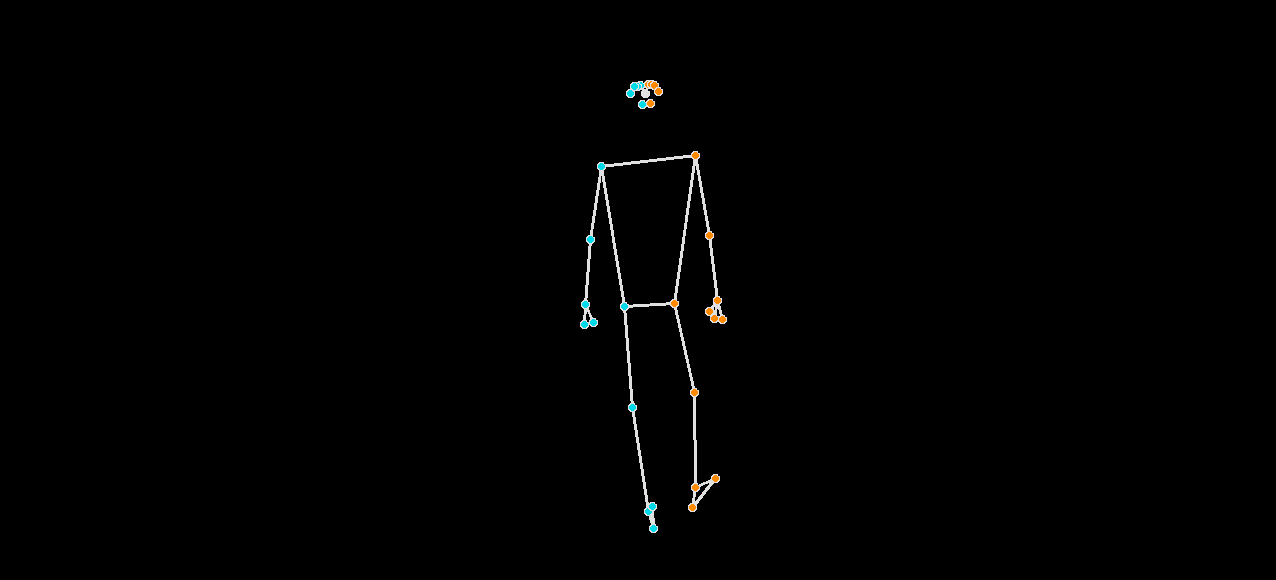

580 1276 3


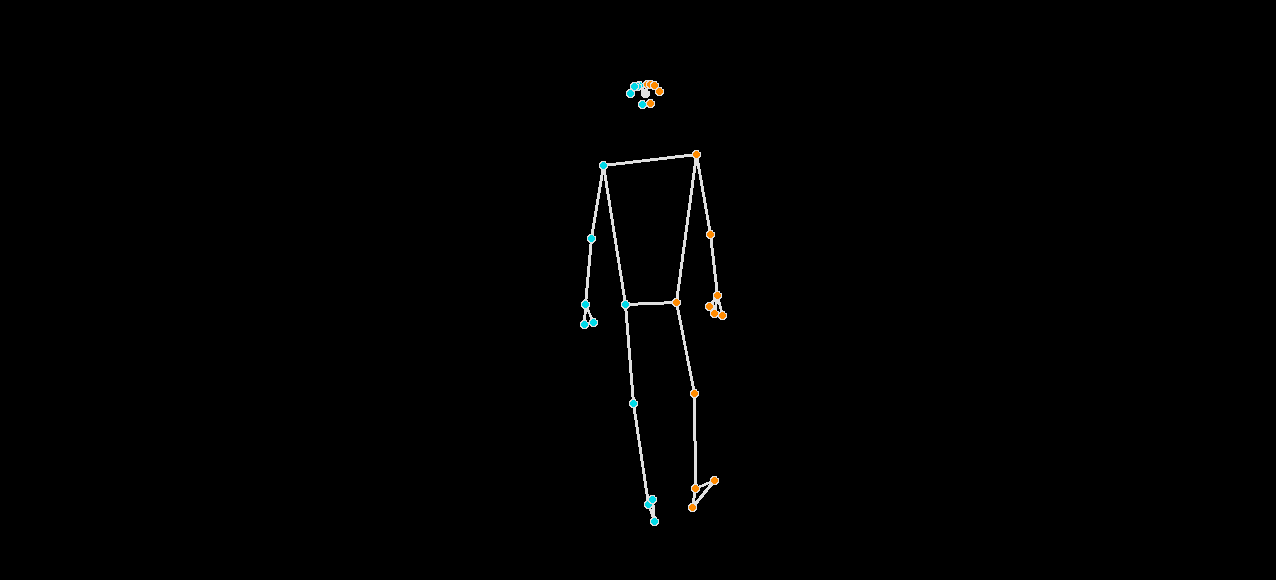

580 1276 3


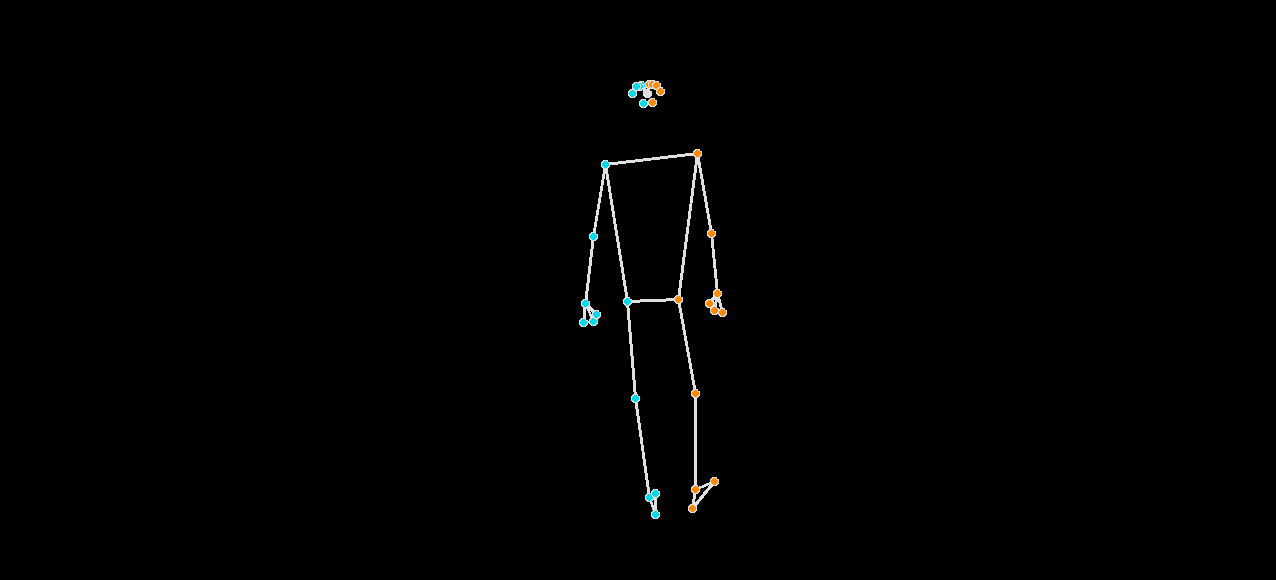

580 1276 3


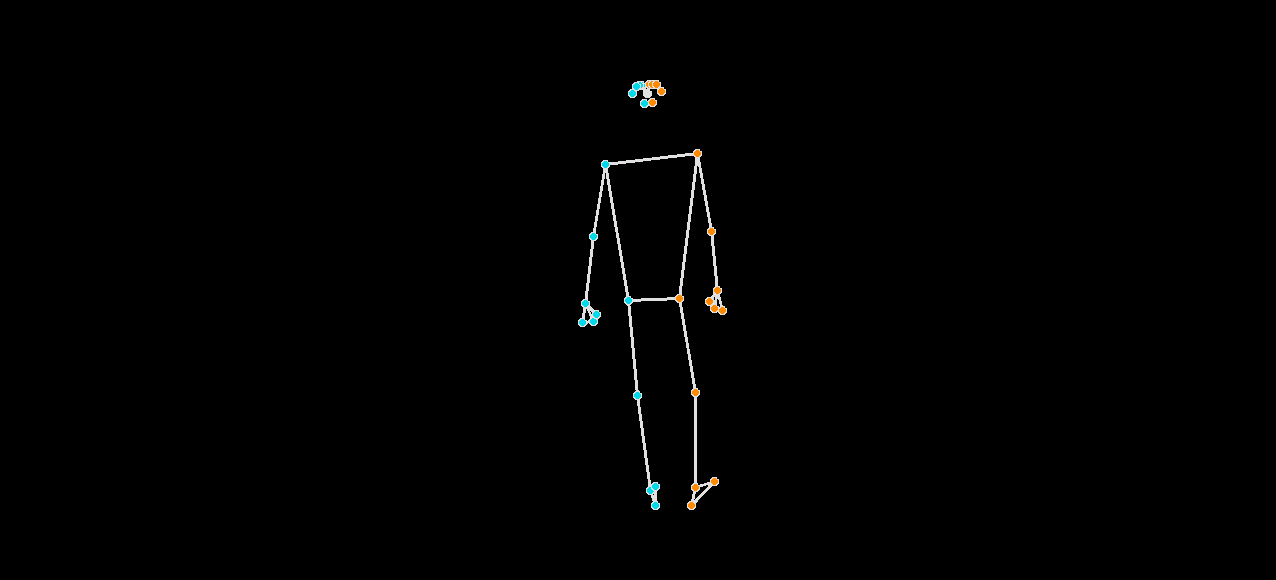

580 1276 3


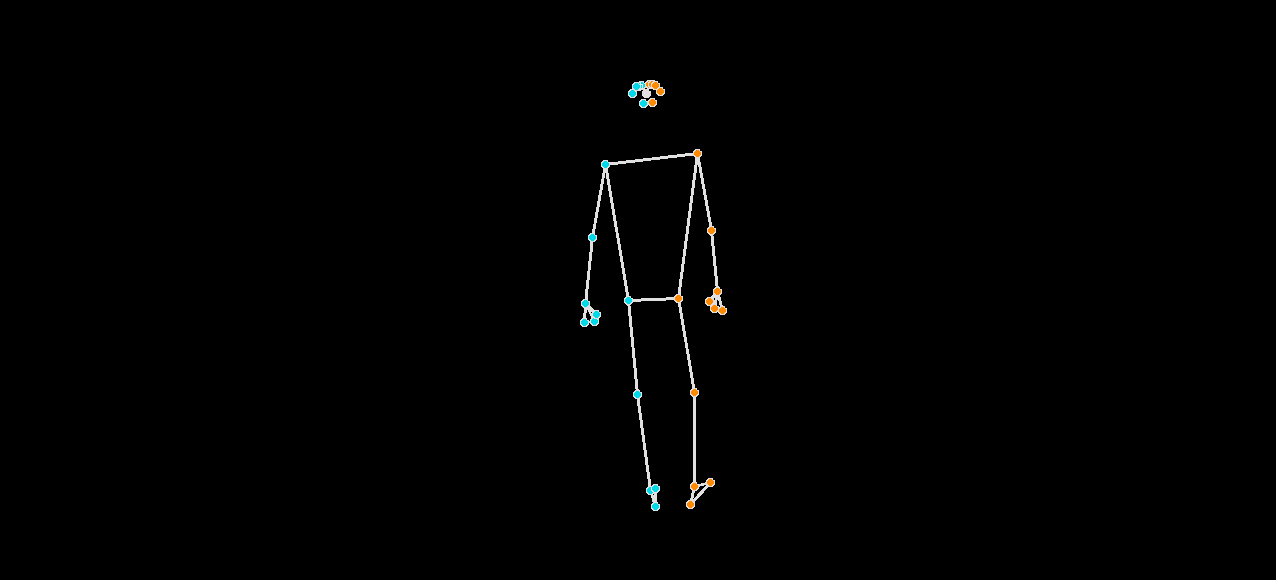

580 1276 3


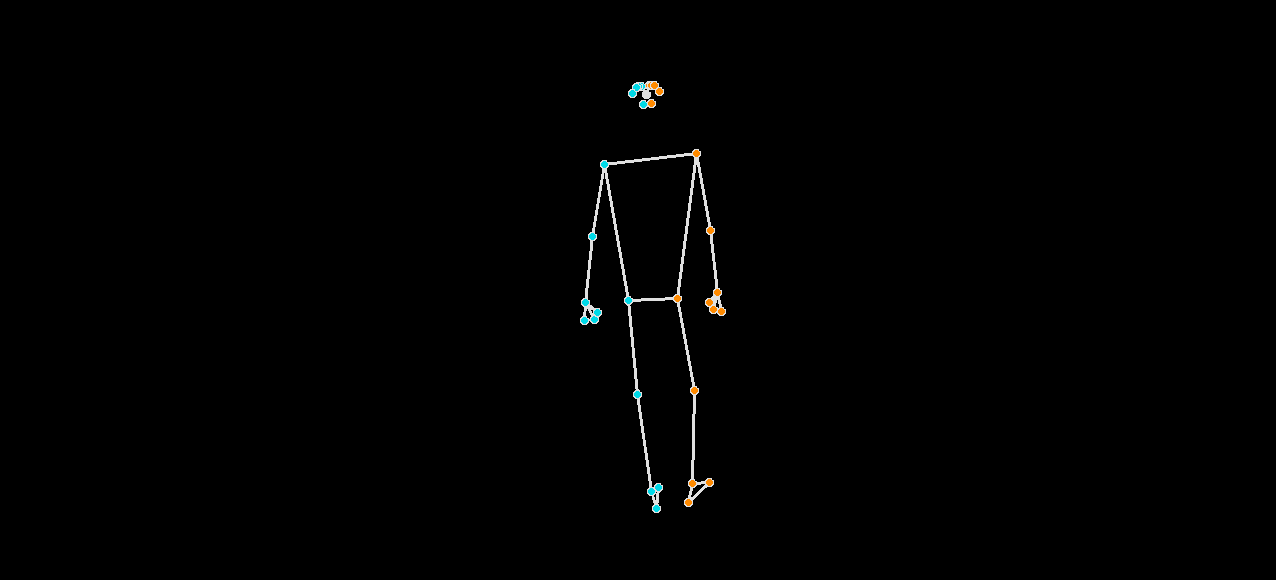

580 1276 3


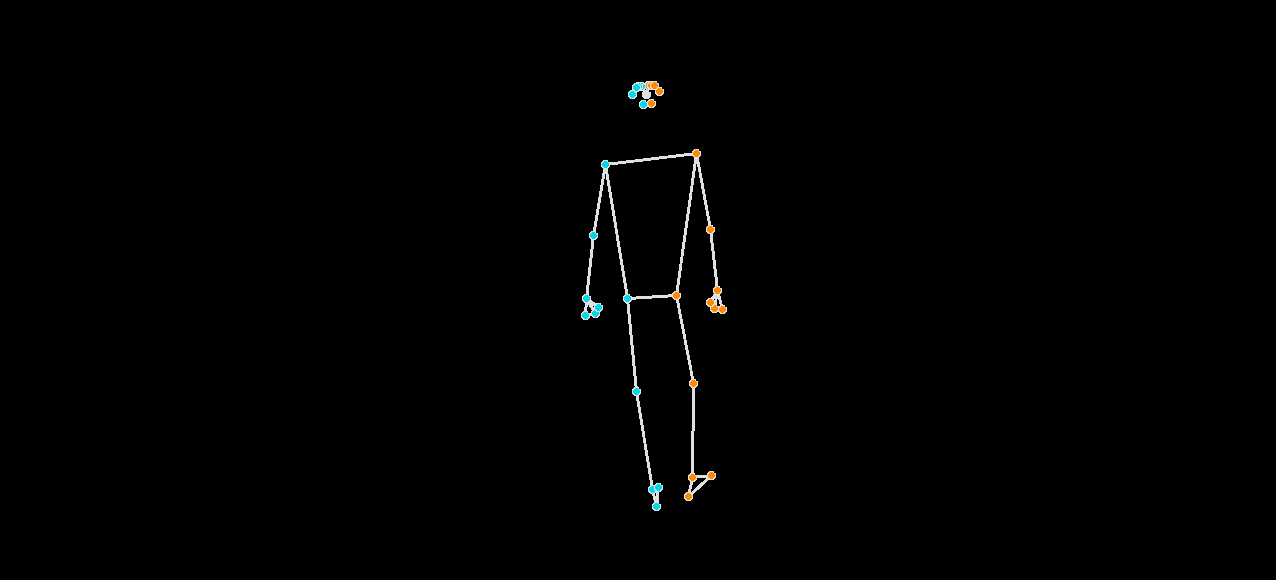

580 1276 3


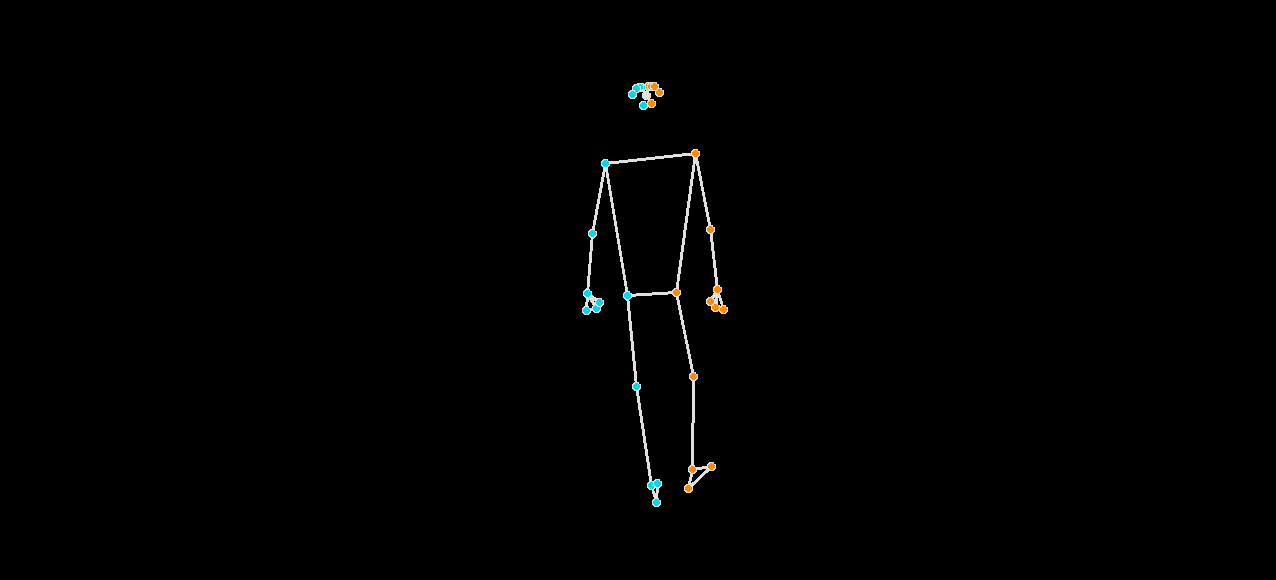

580 1276 3


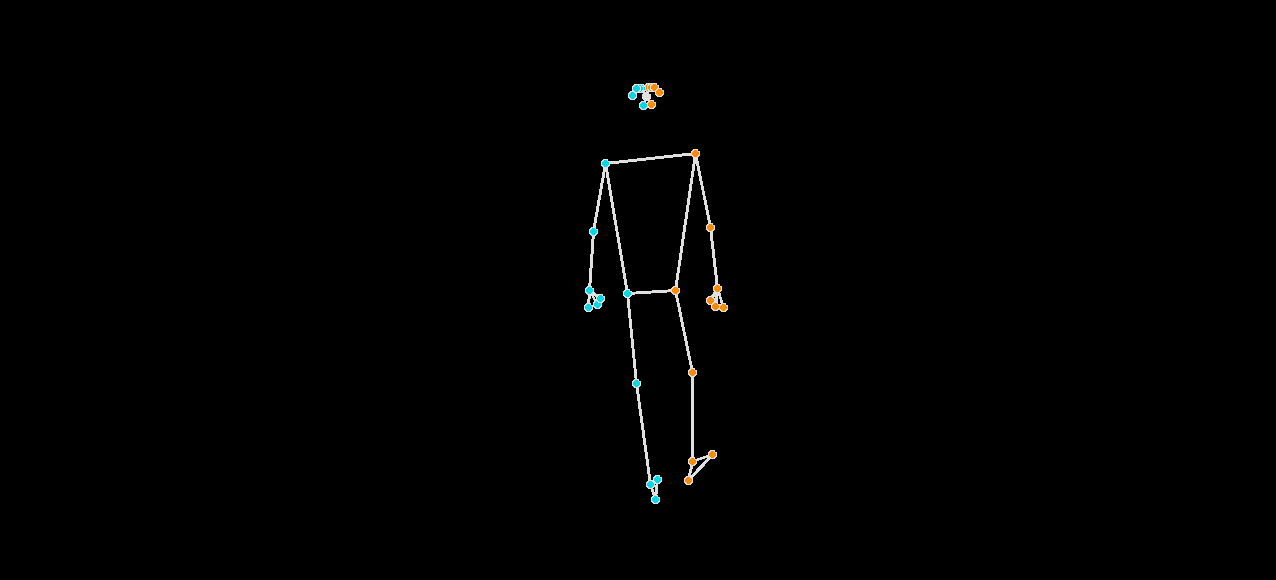

580 1276 3


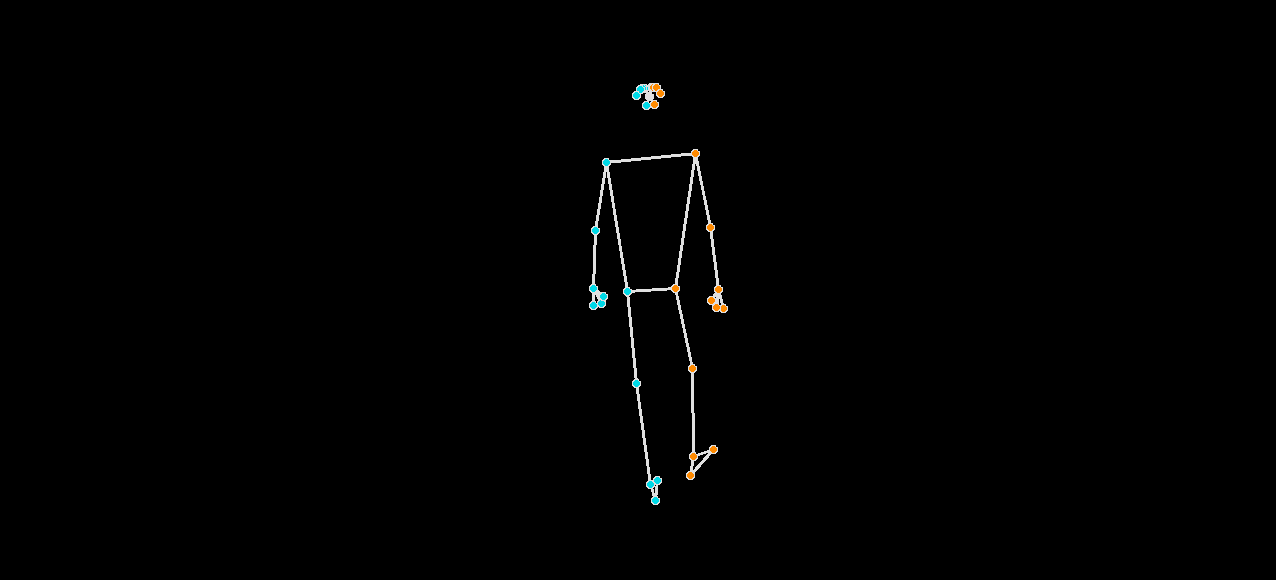

580 1276 3


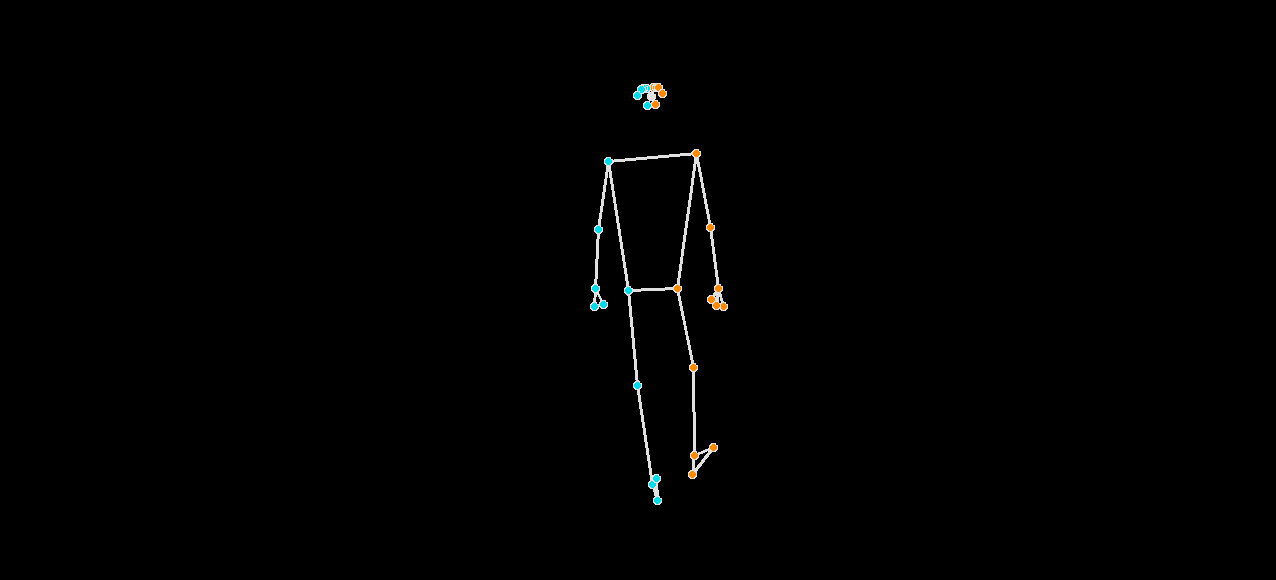

580 1276 3


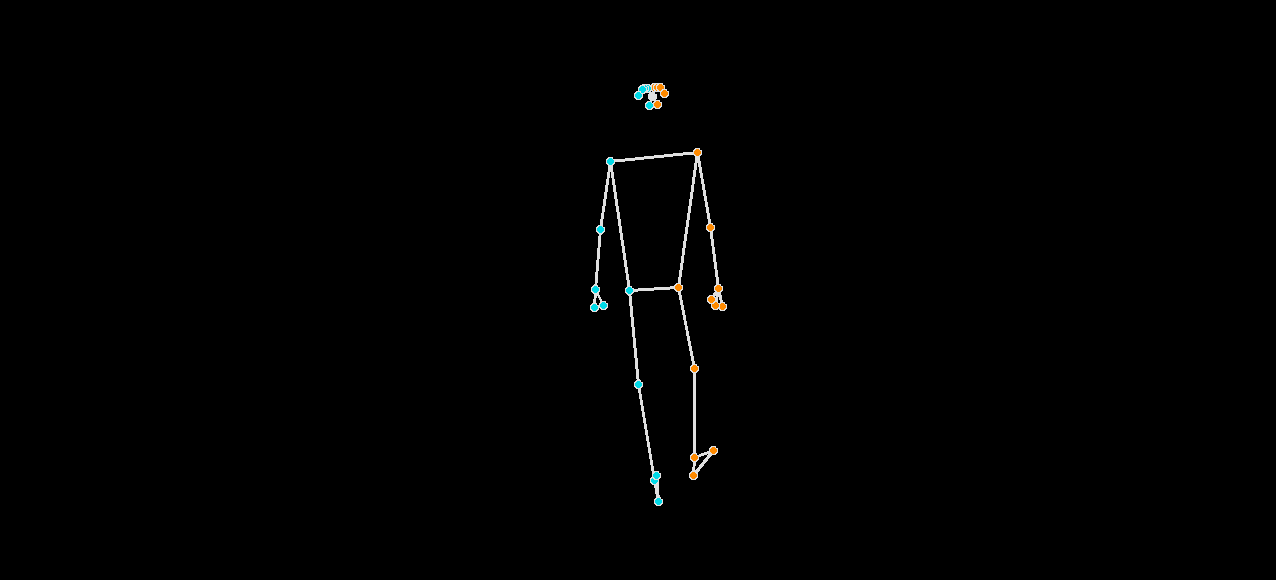

580 1276 3


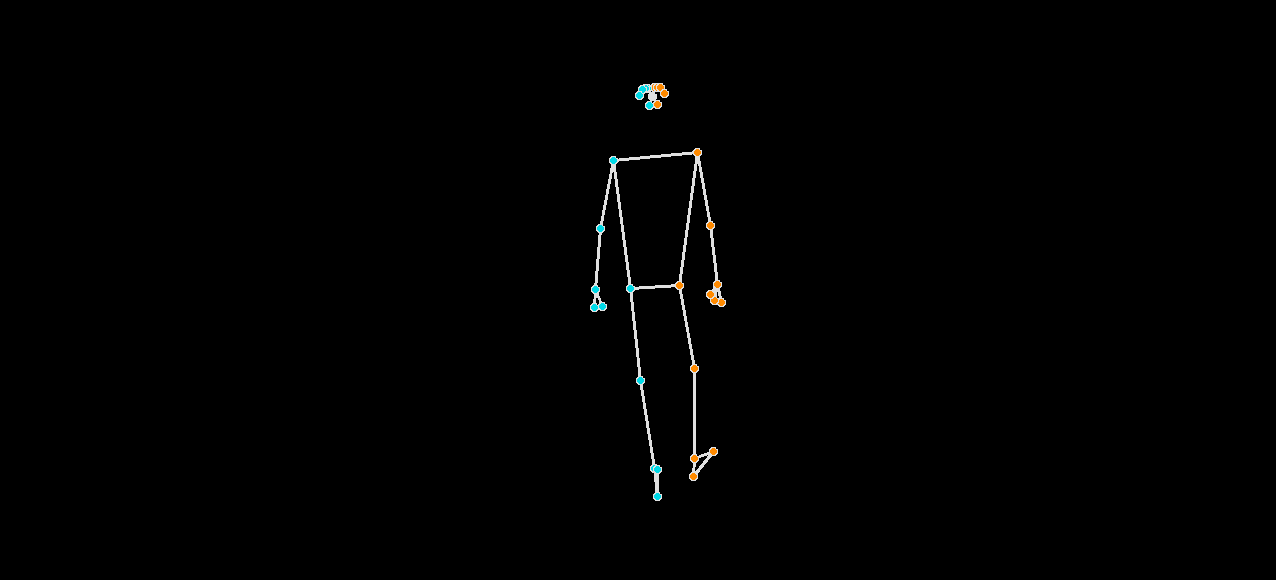

580 1276 3


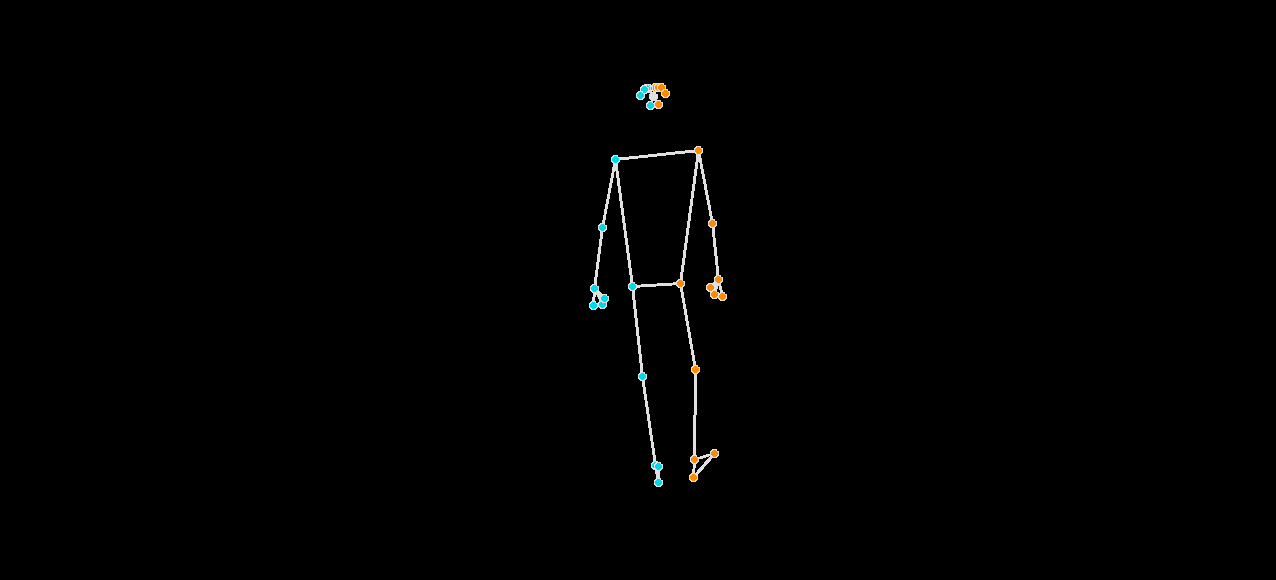

580 1276 3


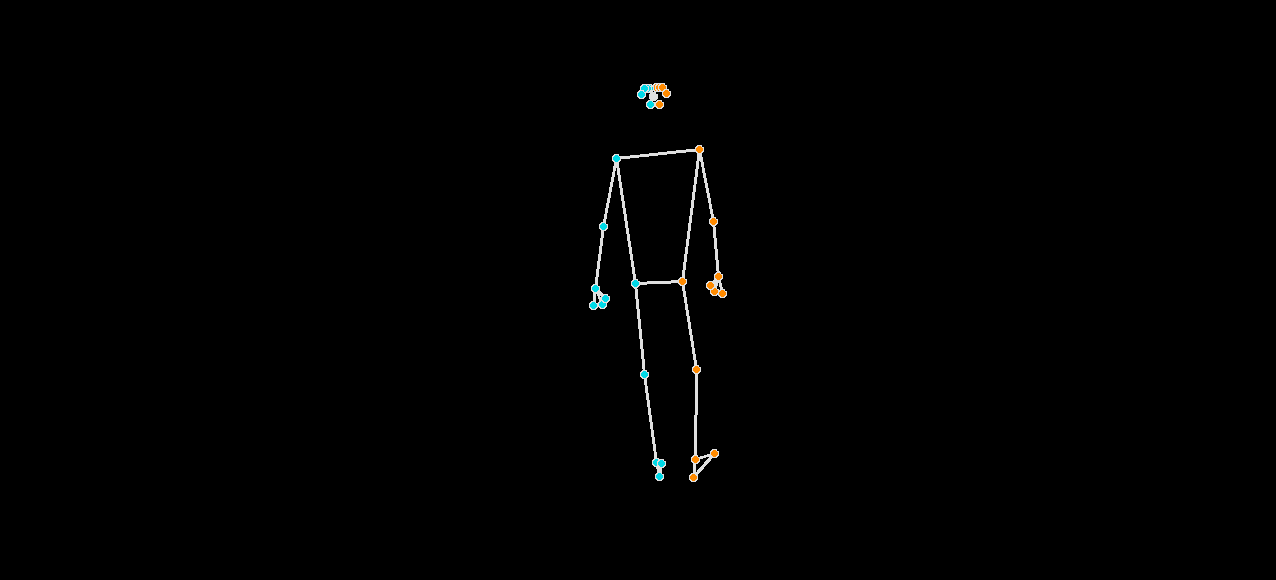

580 1276 3


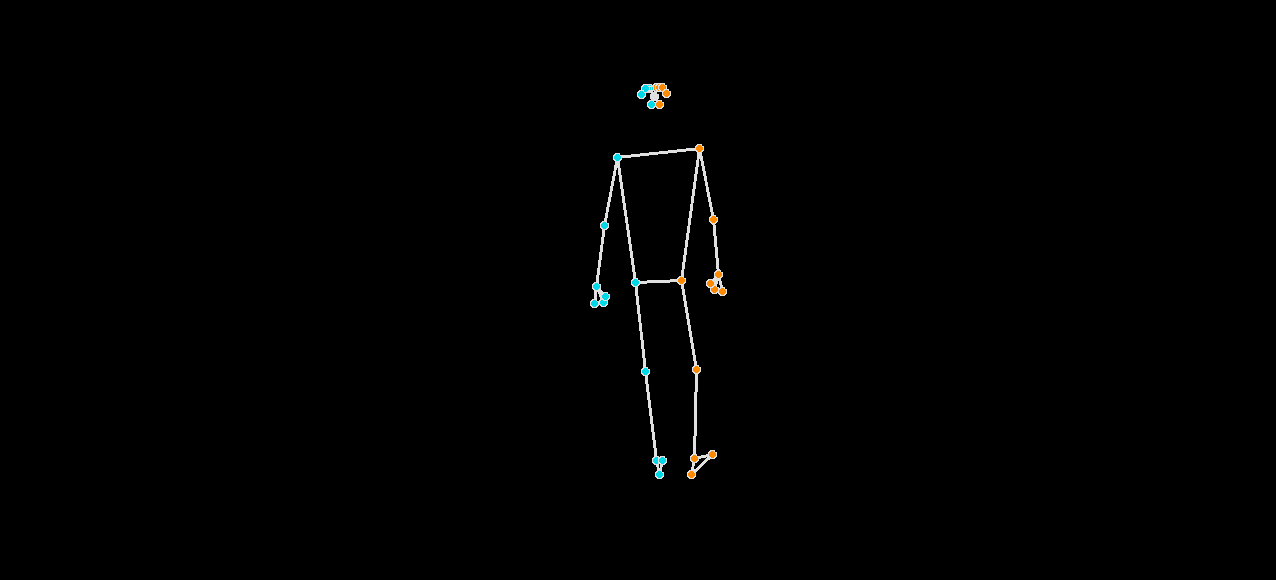

580 1276 3


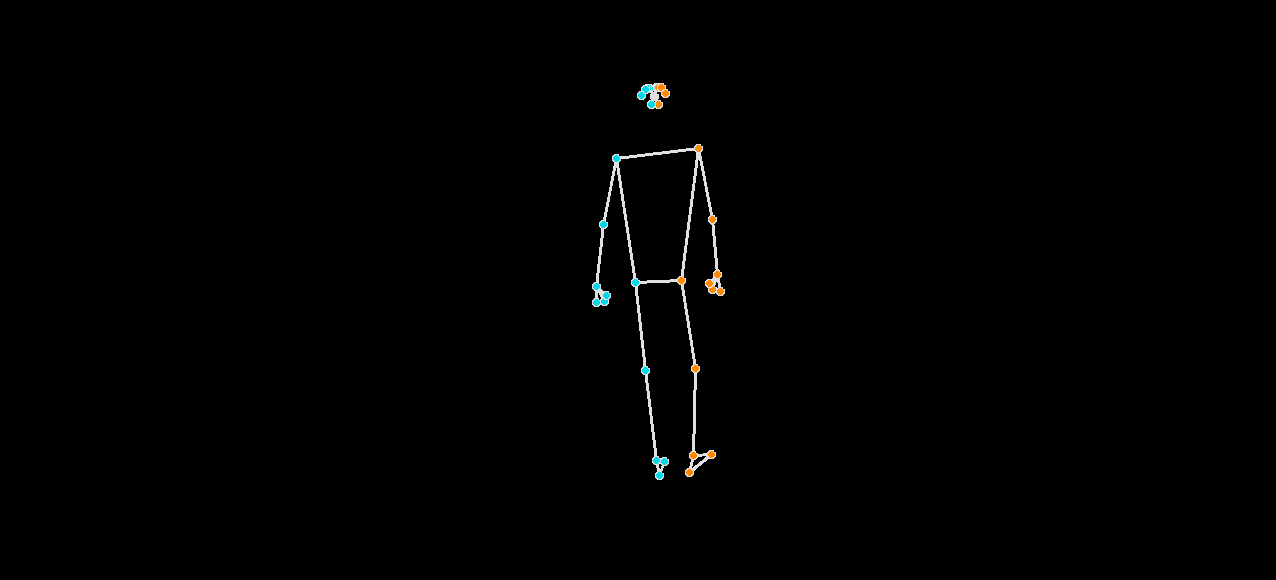

580 1276 3


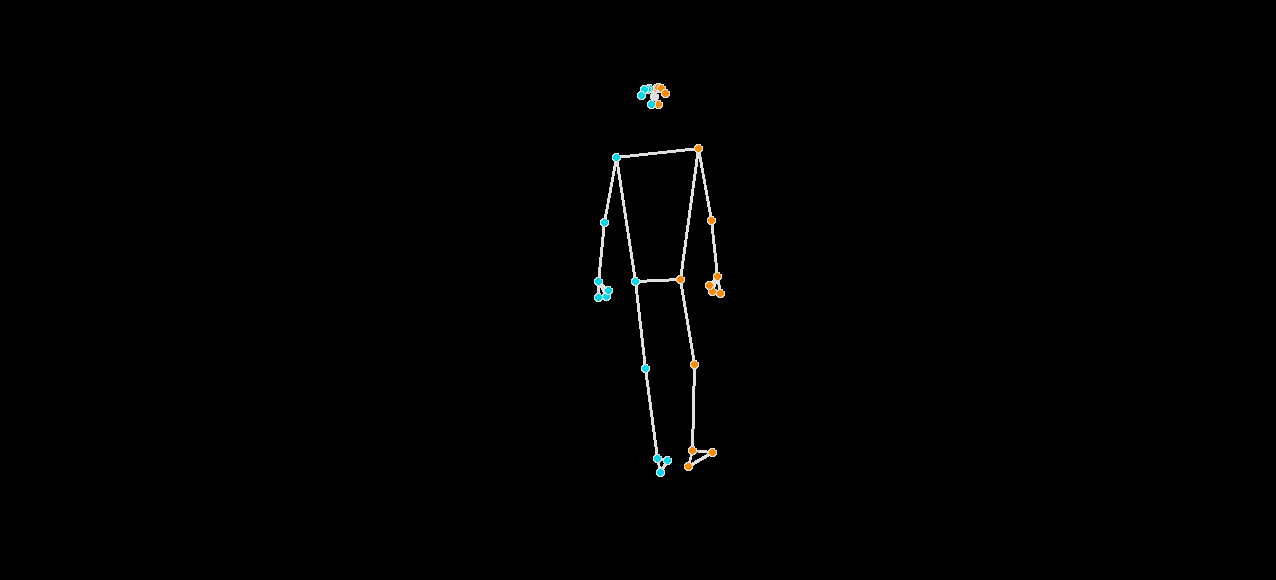

580 1276 3


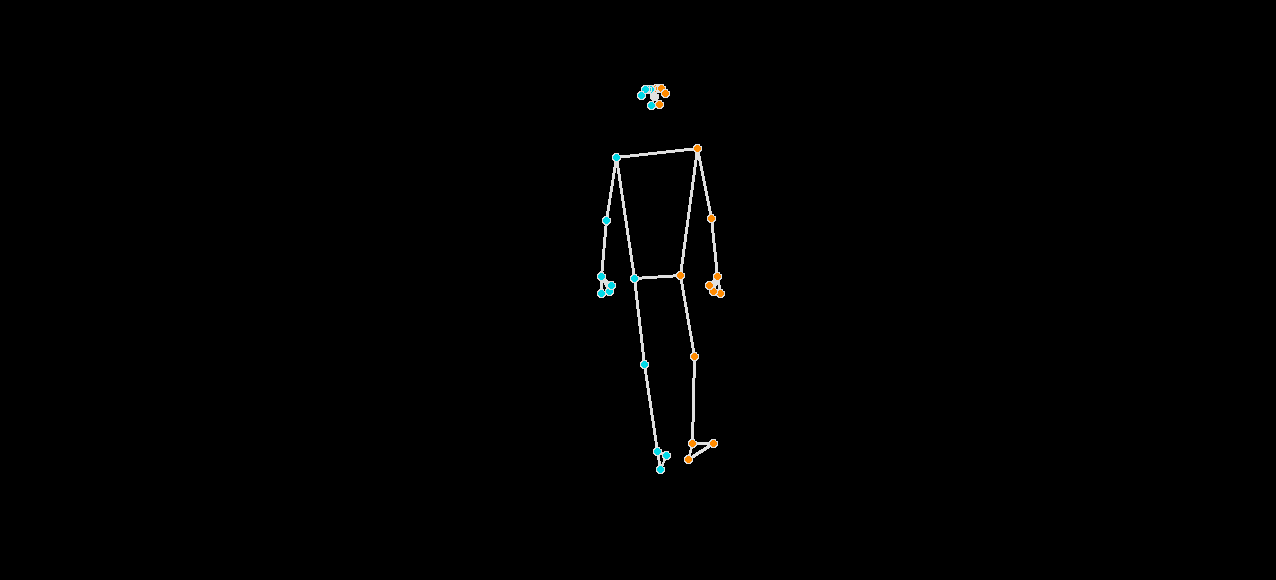

580 1276 3


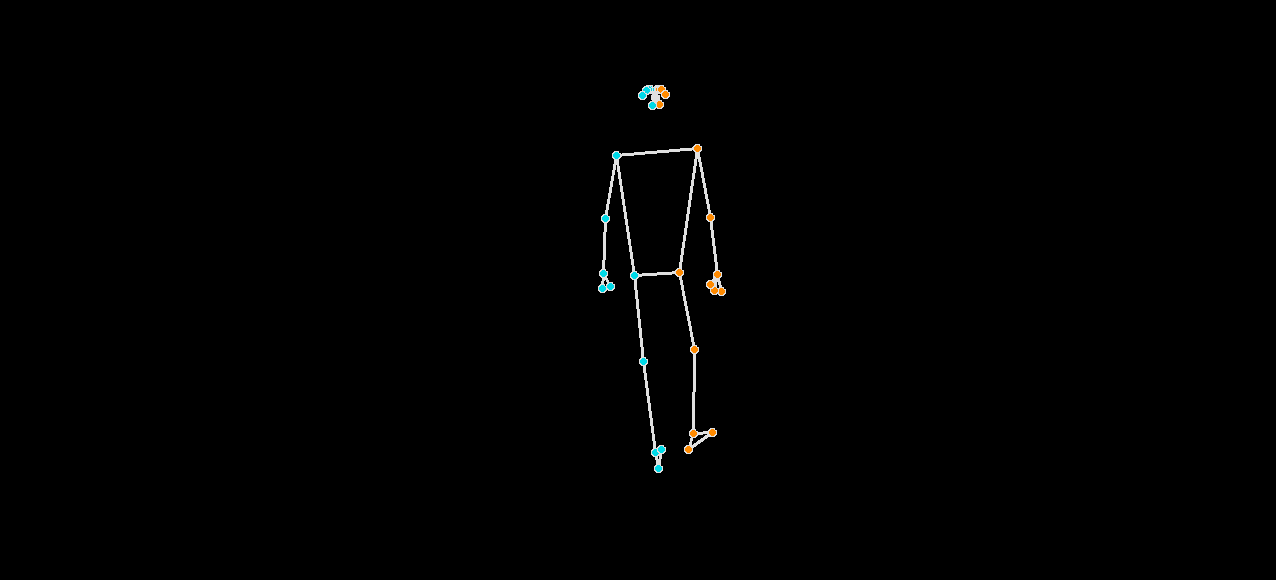

580 1276 3


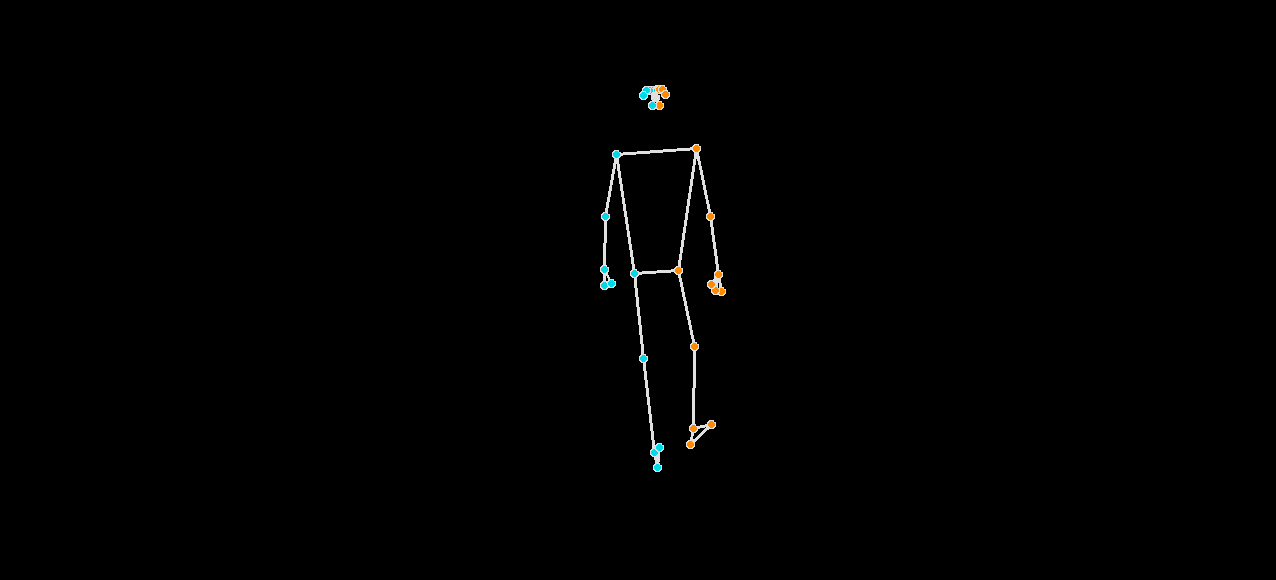

580 1276 3


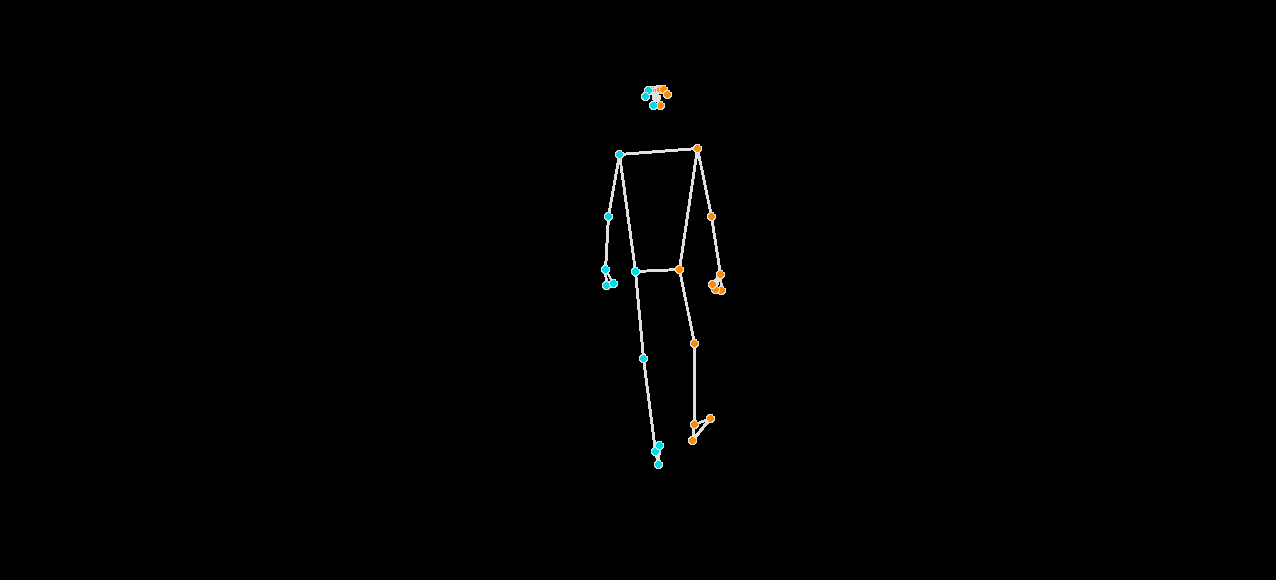

580 1276 3


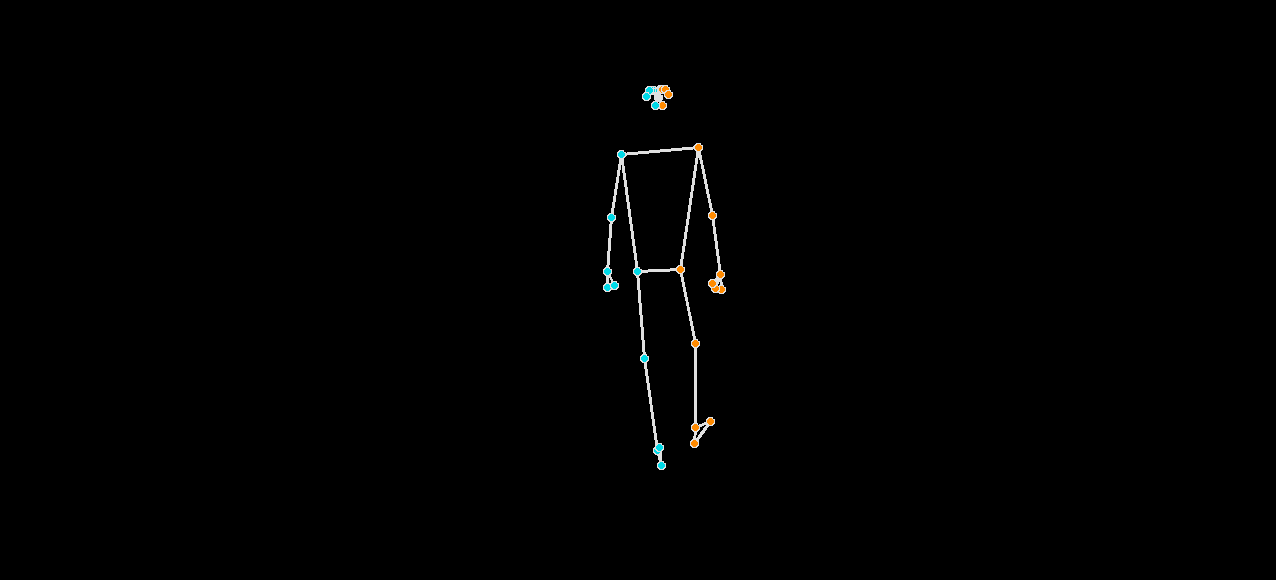

580 1276 3


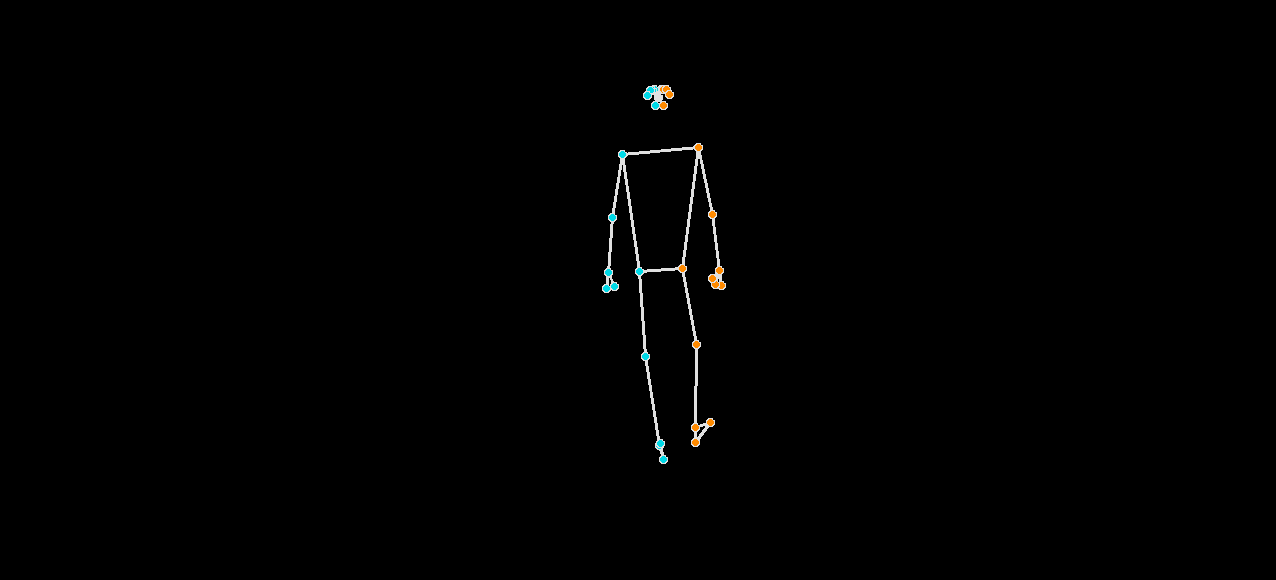

580 1276 3


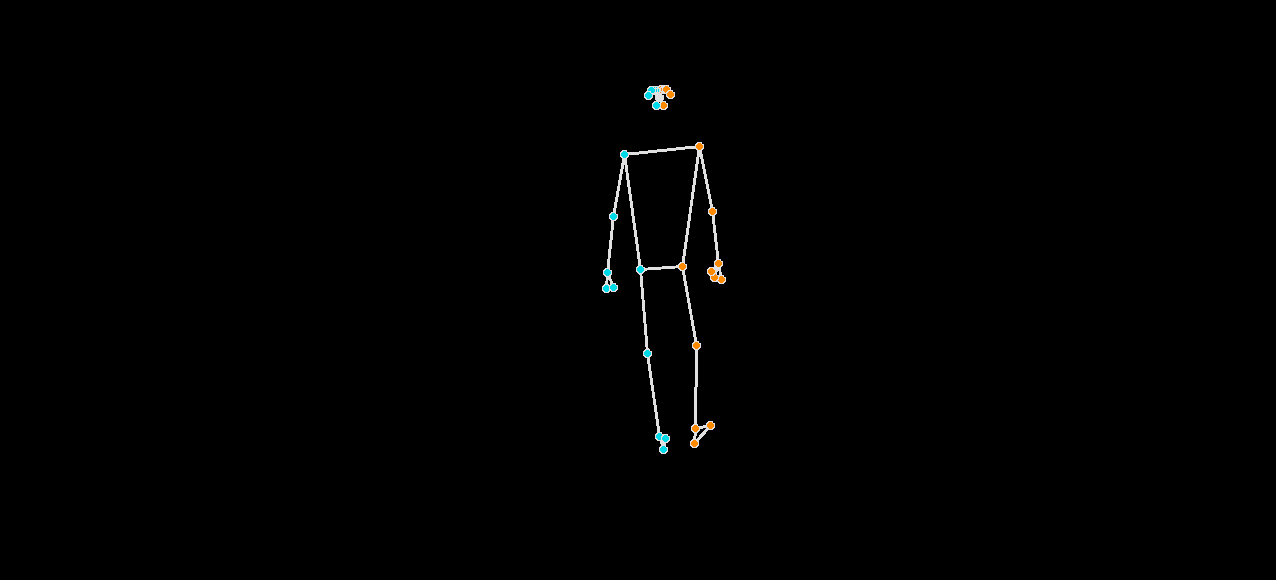

580 1276 3


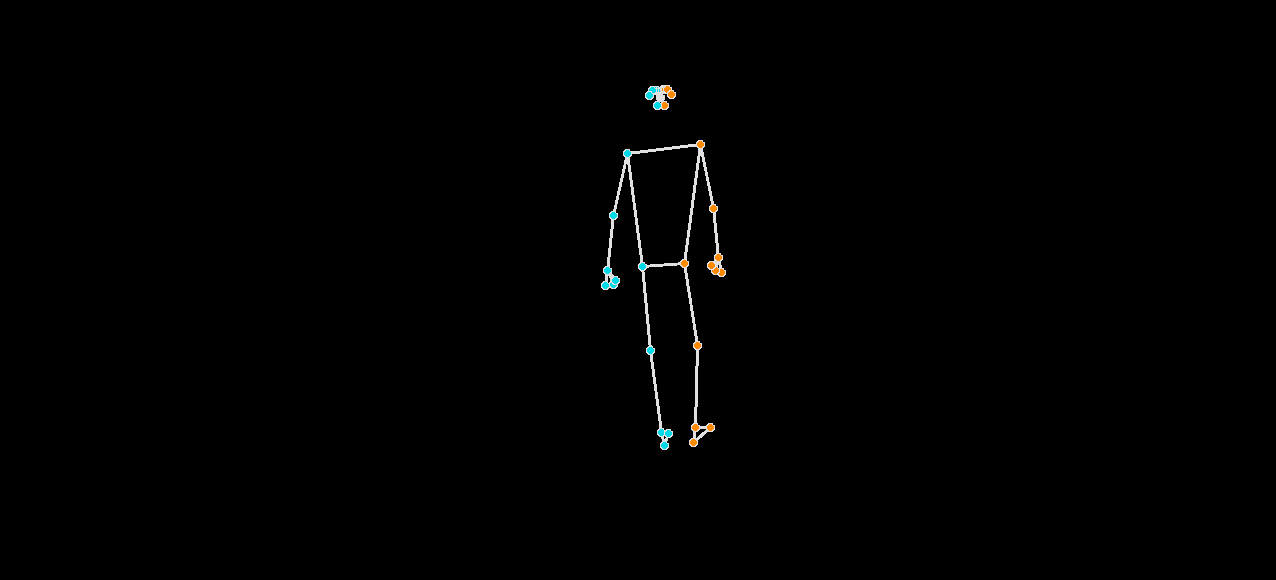

580 1276 3


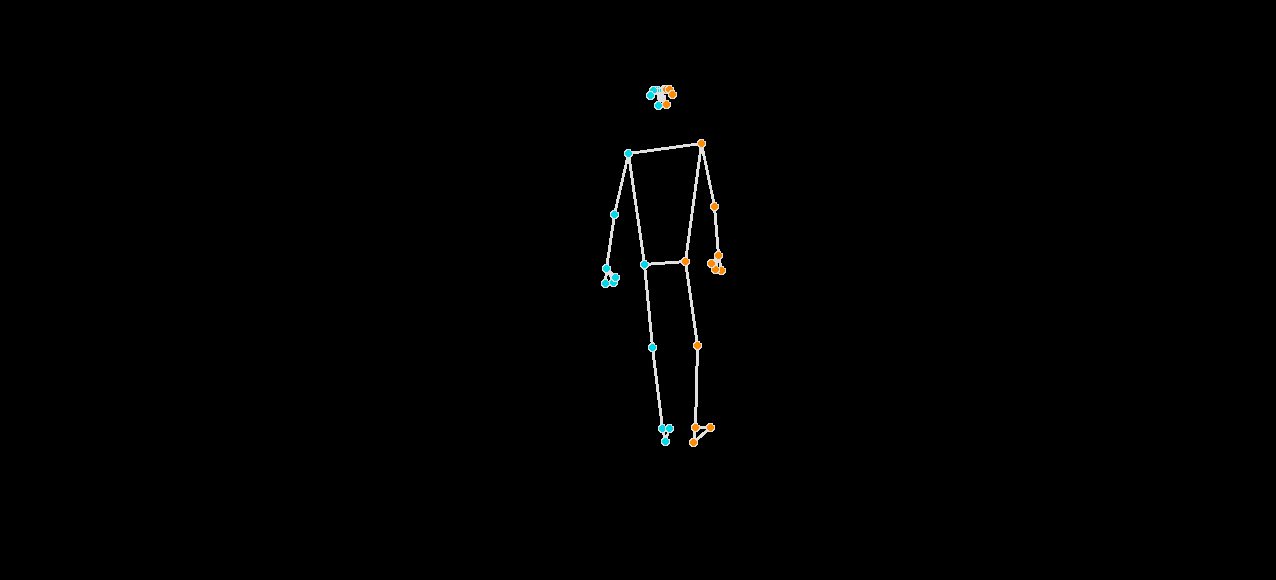

580 1276 3


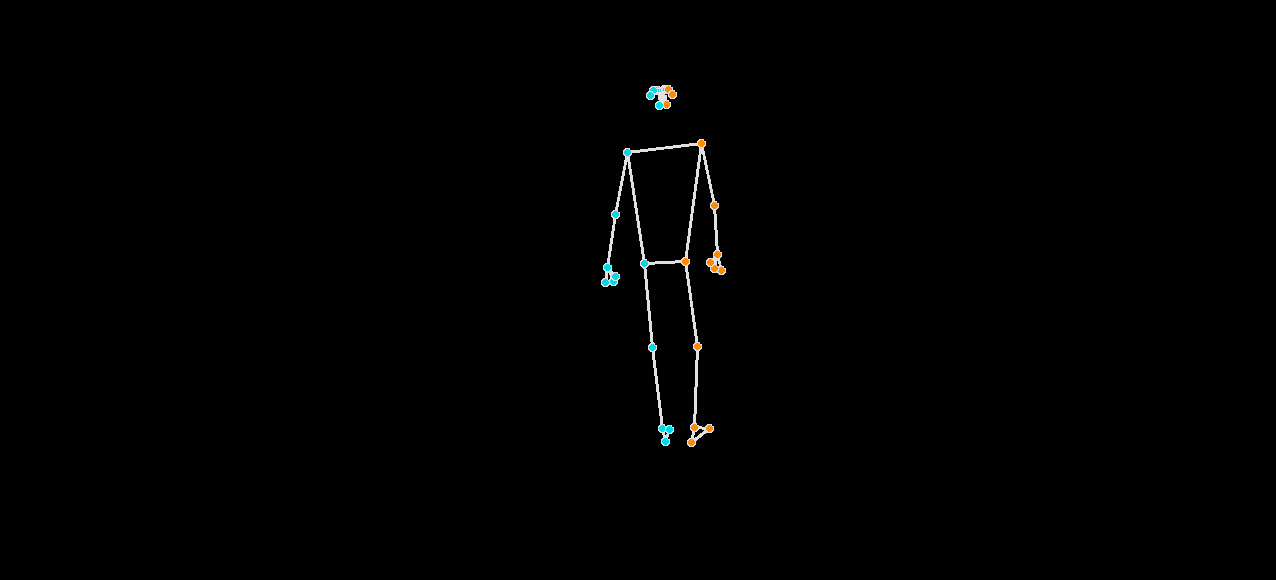

580 1276 3


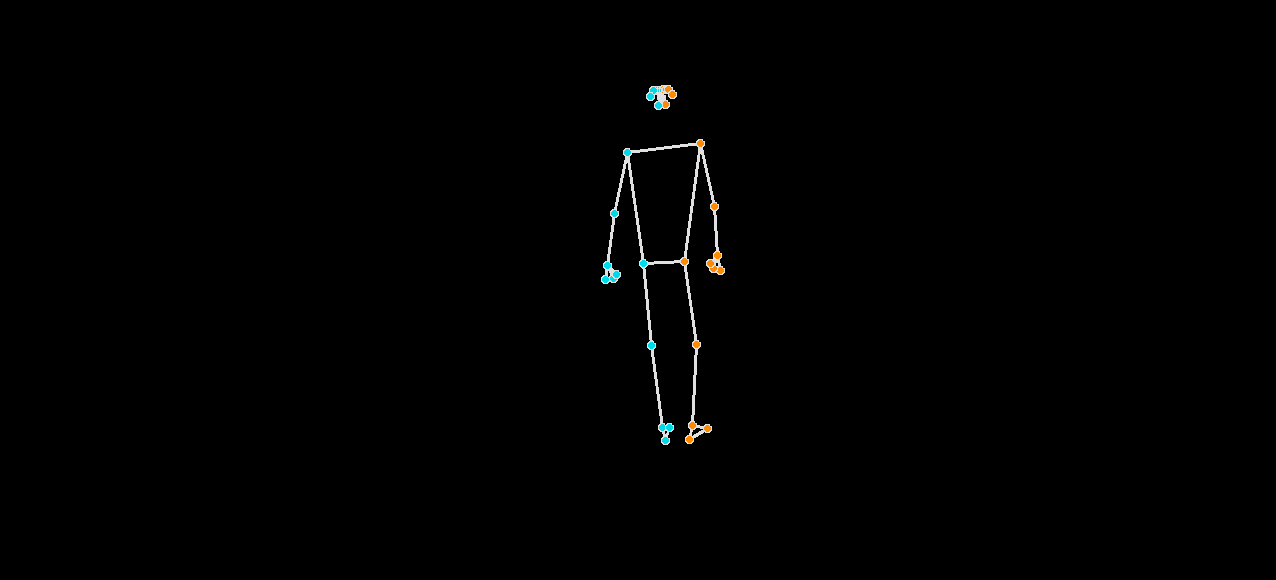

580 1276 3


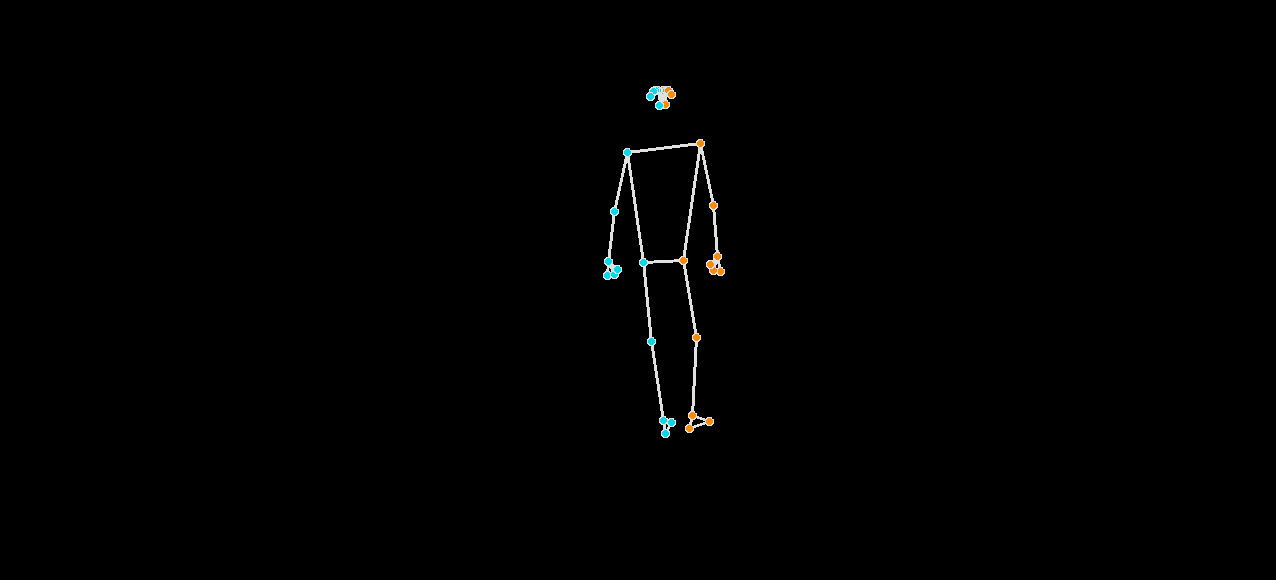

580 1276 3


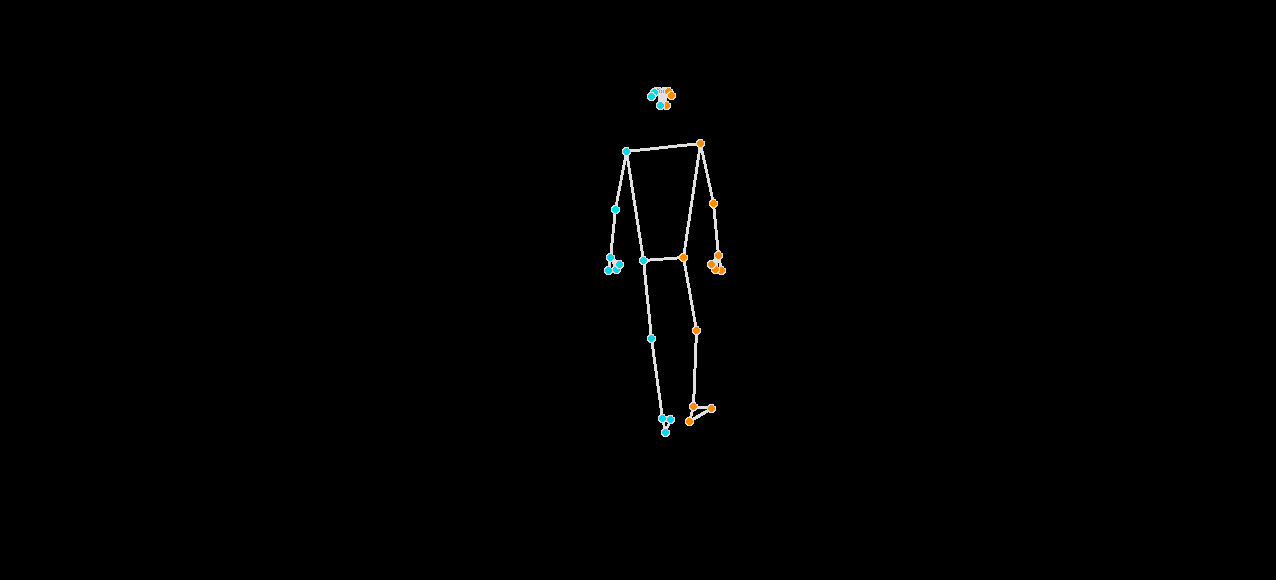

580 1276 3


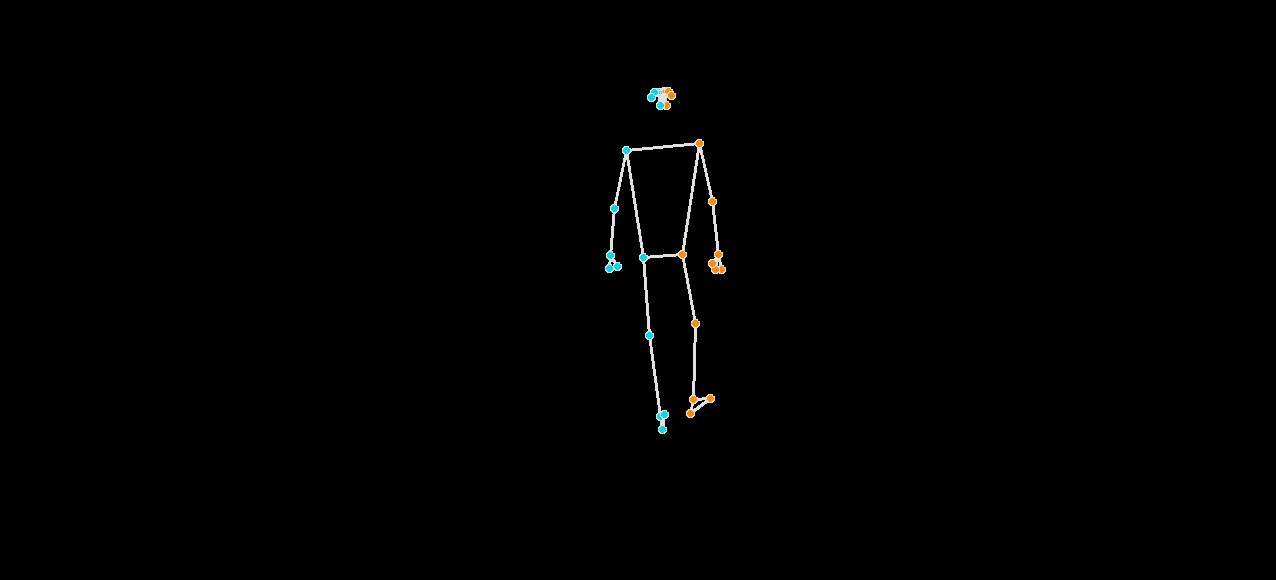

580 1276 3


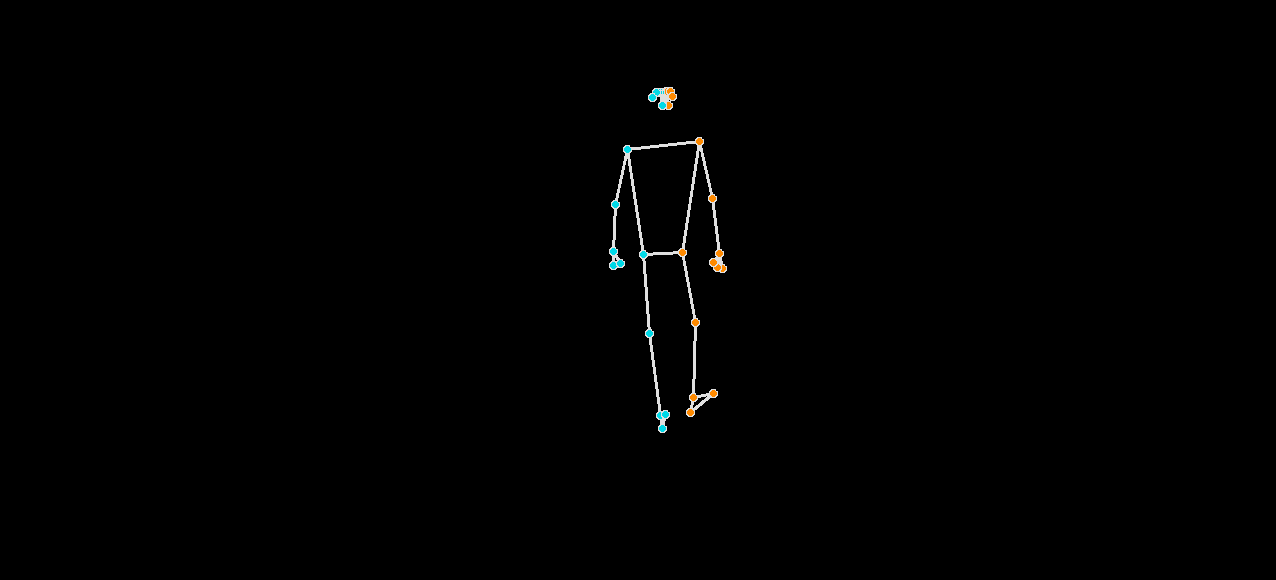

580 1276 3


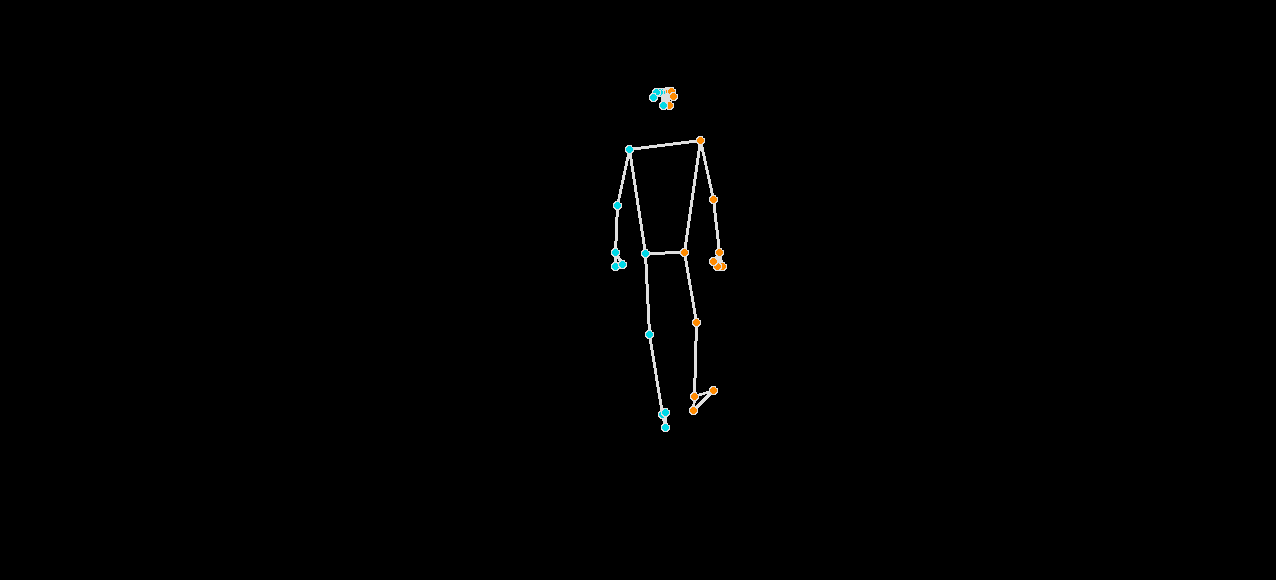

580 1276 3


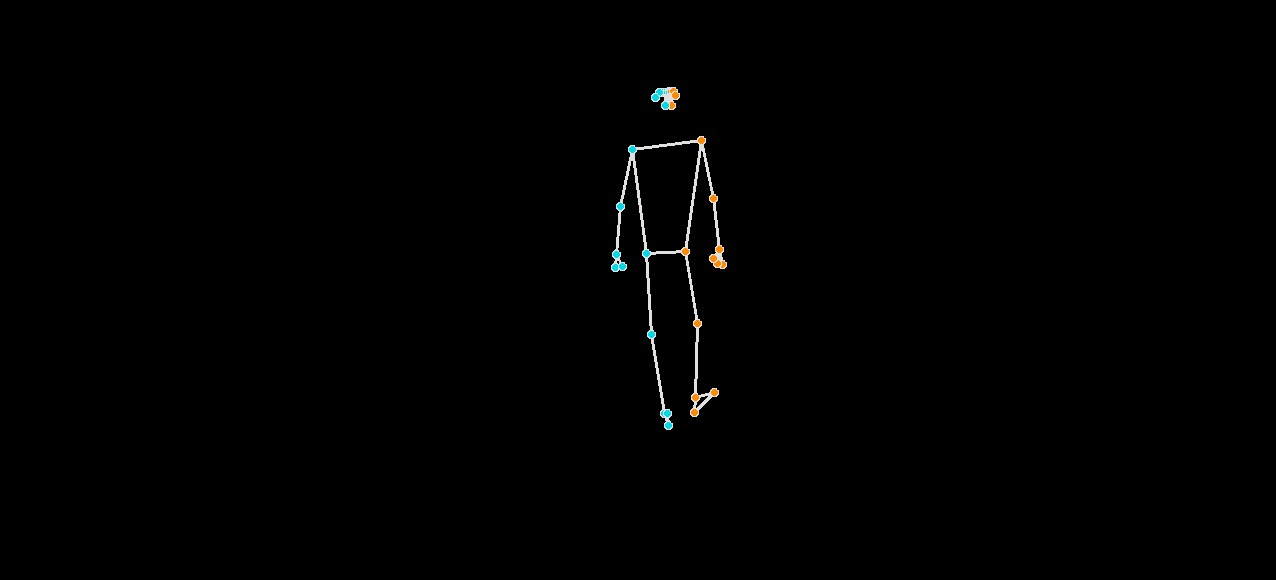

580 1276 3


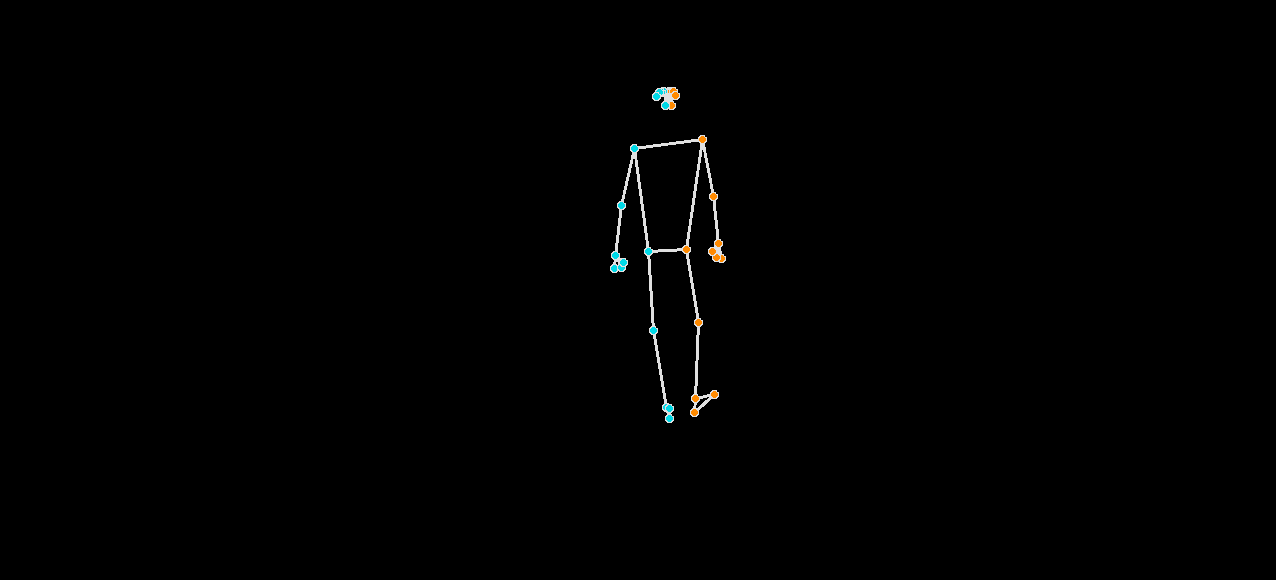

580 1276 3


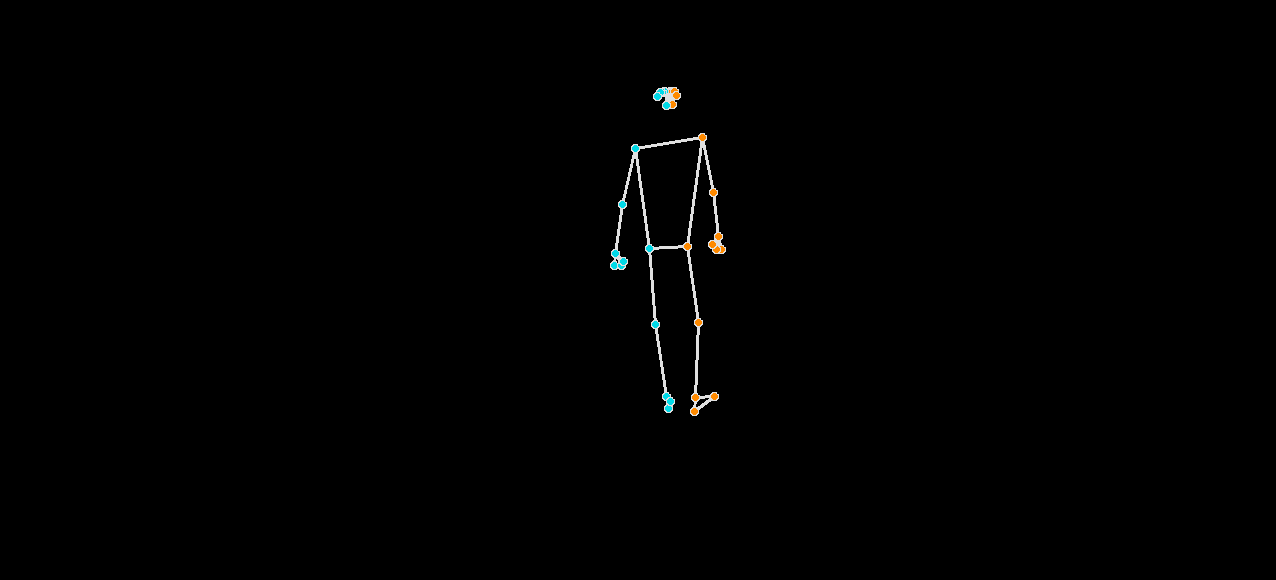

580 1276 3


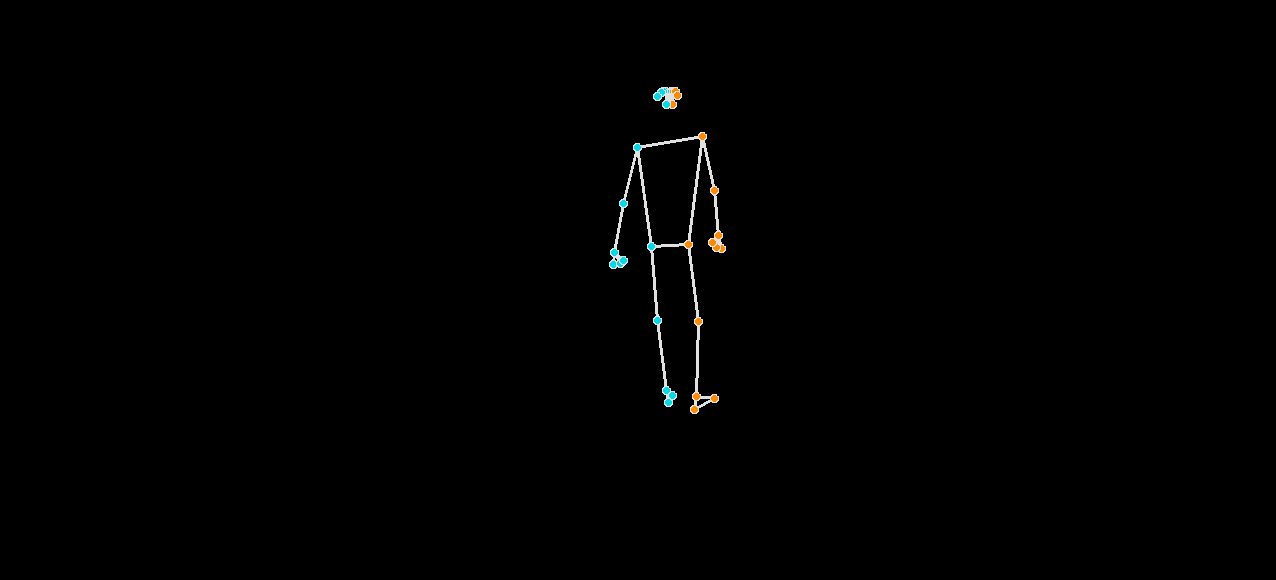

580 1276 3


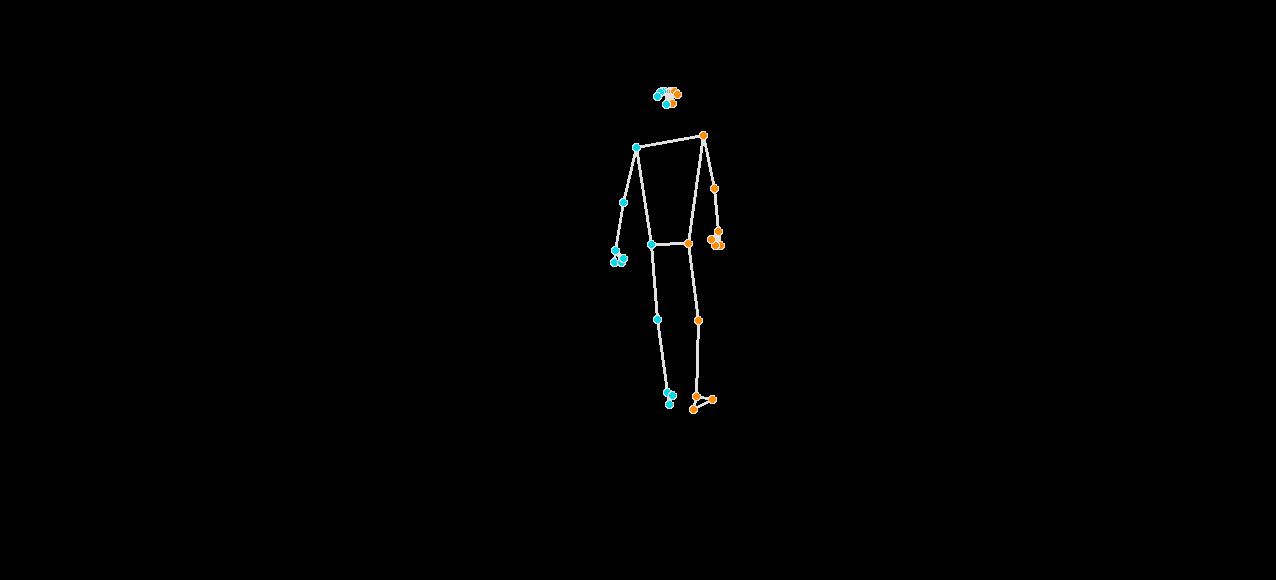

580 1276 3


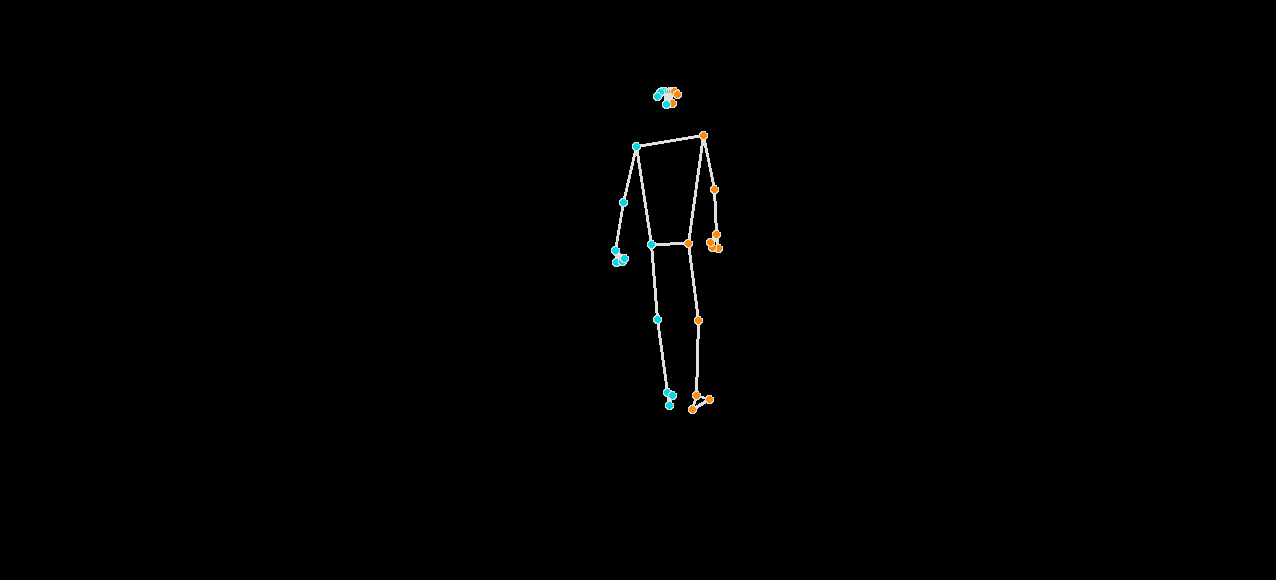

580 1276 3


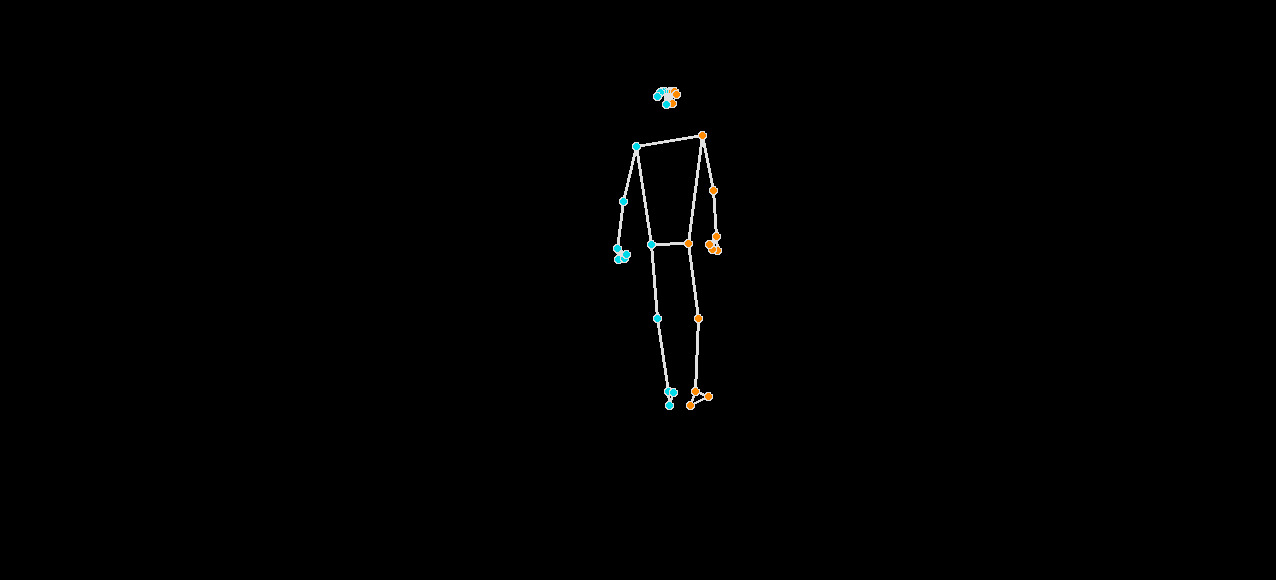

580 1276 3


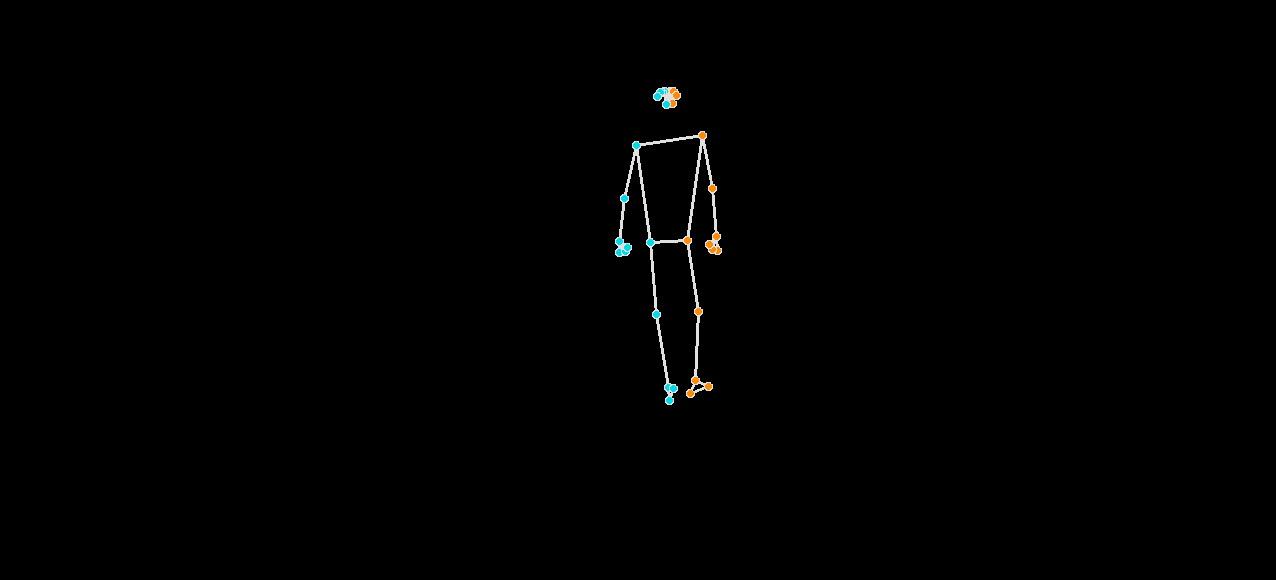

580 1276 3


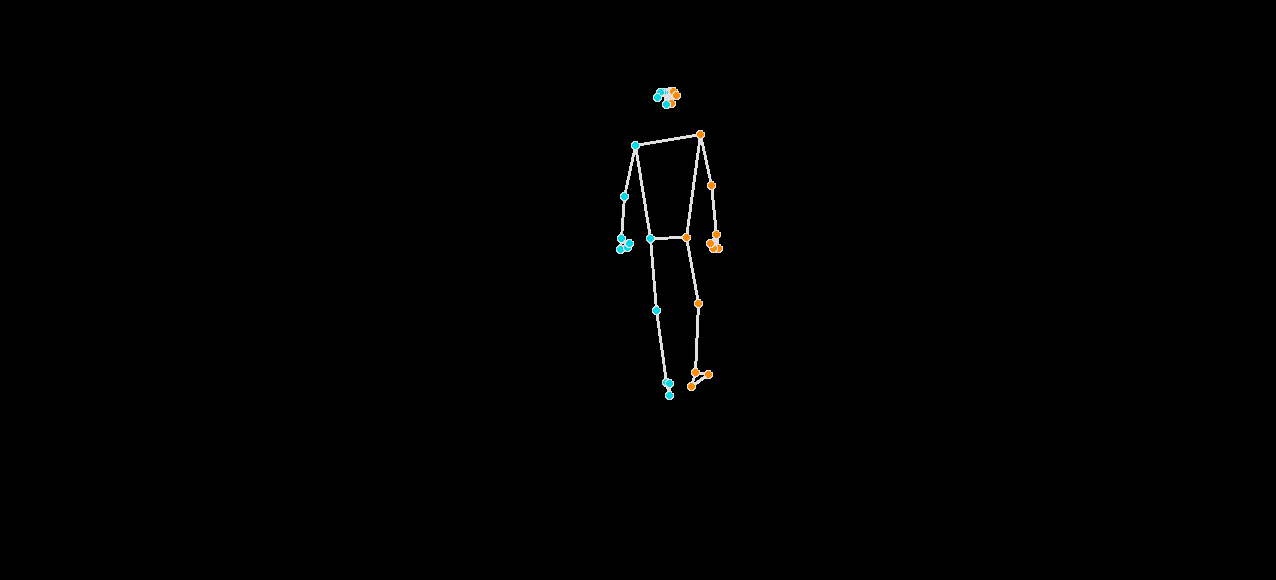

580 1276 3


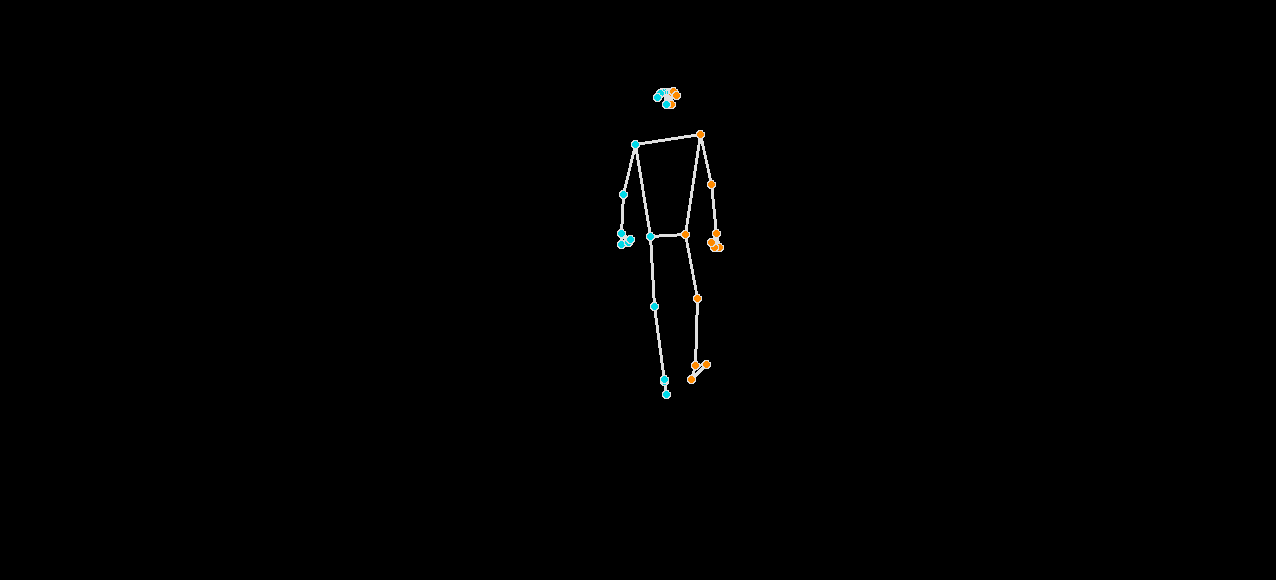

580 1276 3


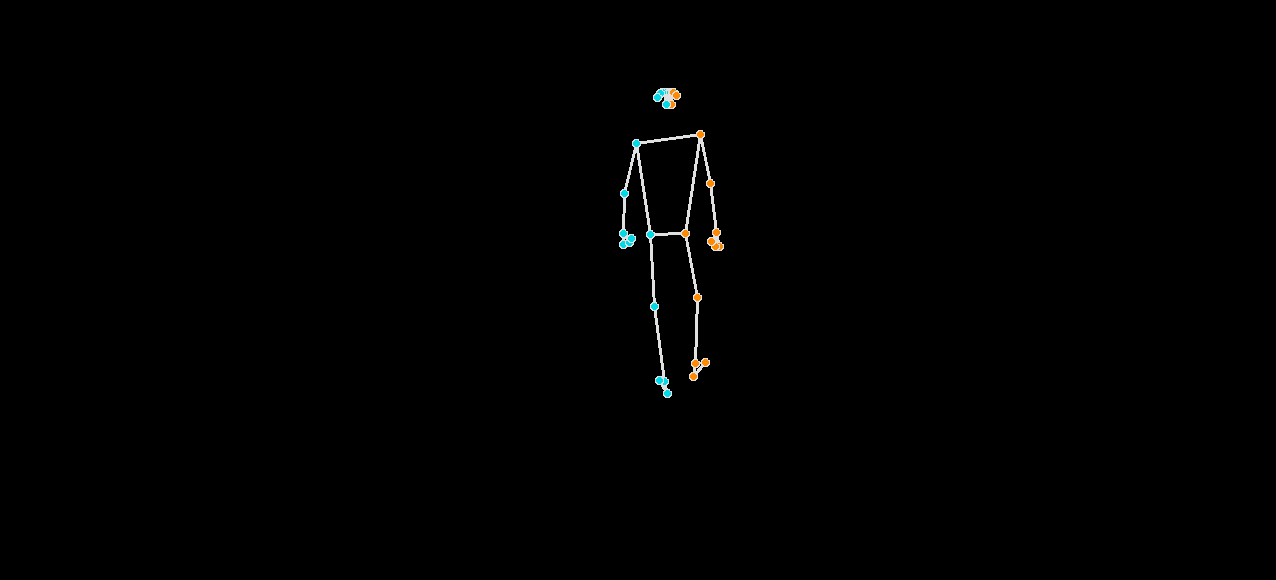

580 1276 3


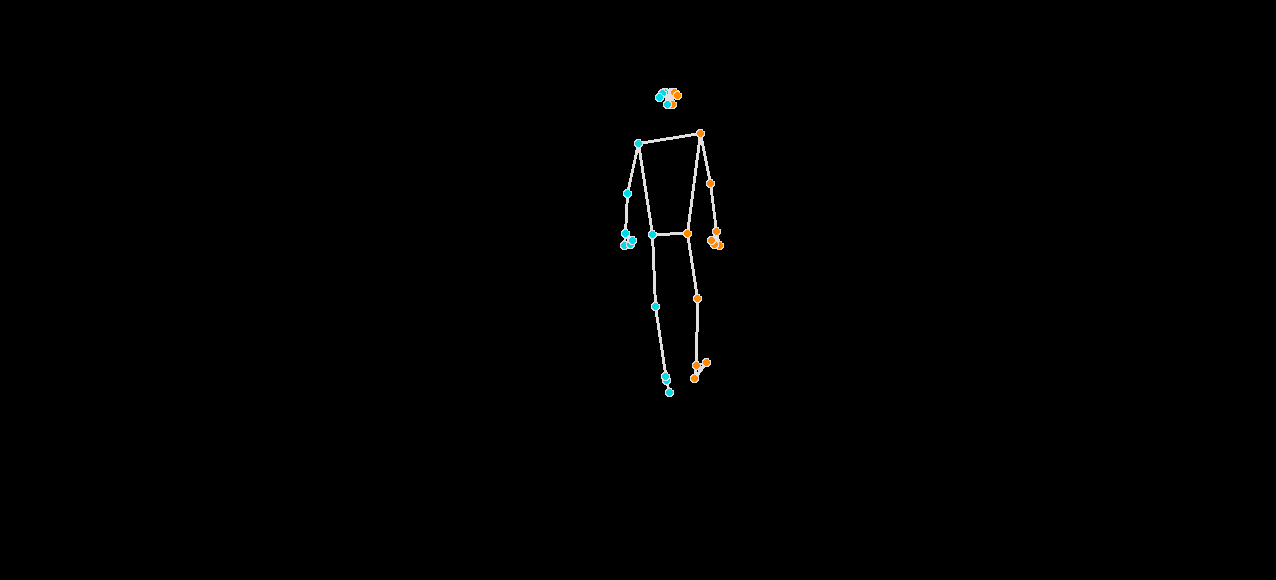

580 1276 3


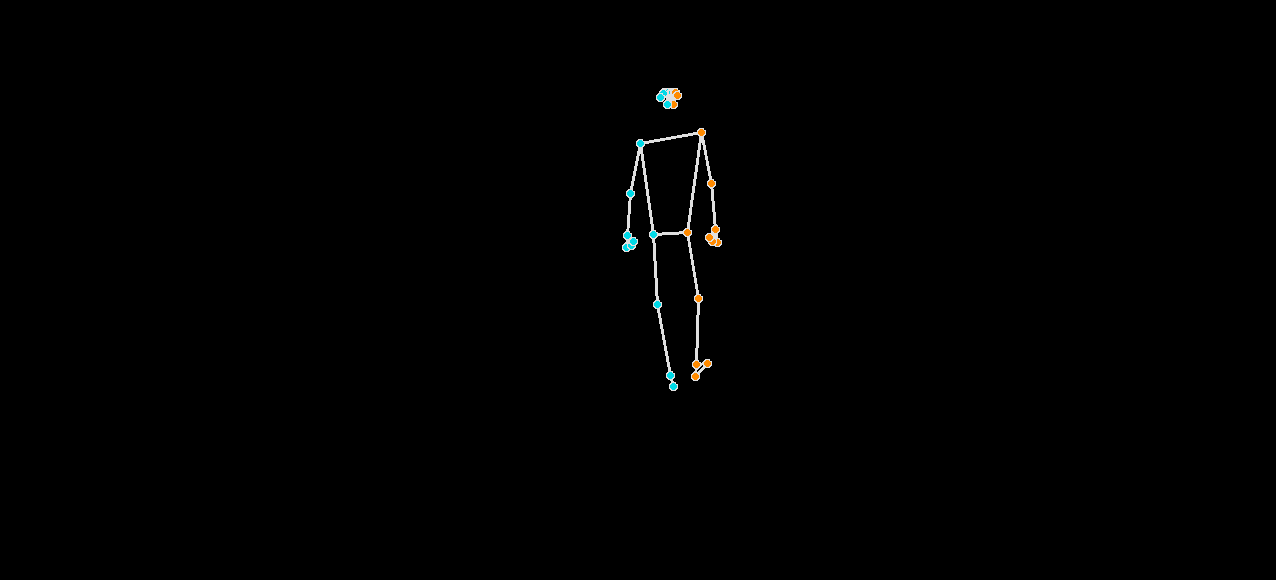

580 1276 3


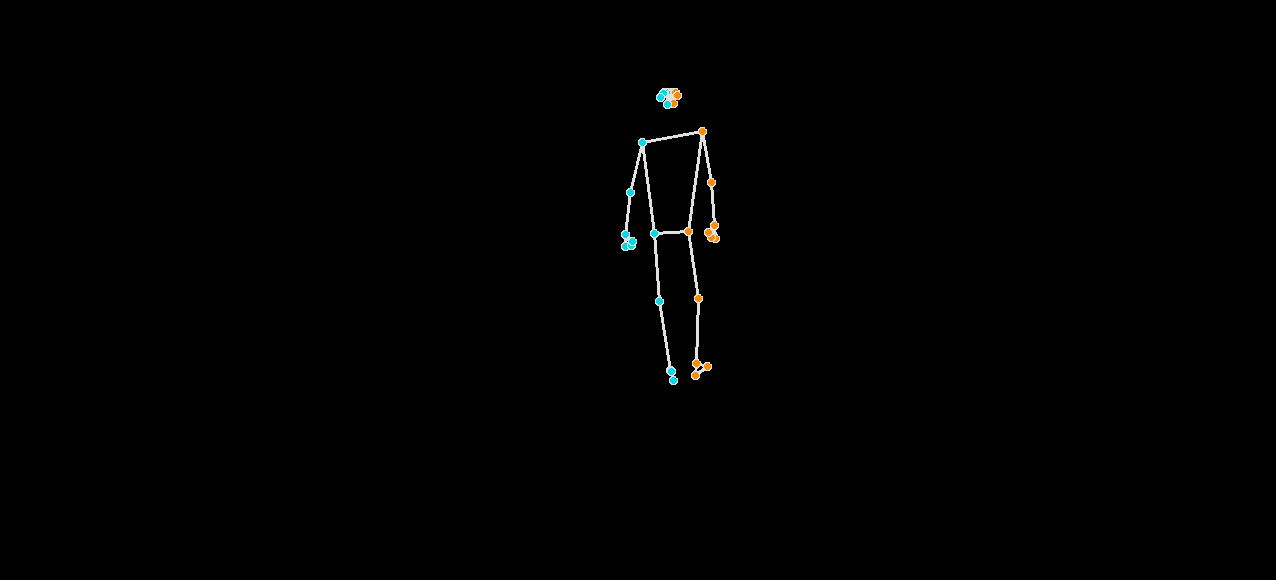

580 1276 3


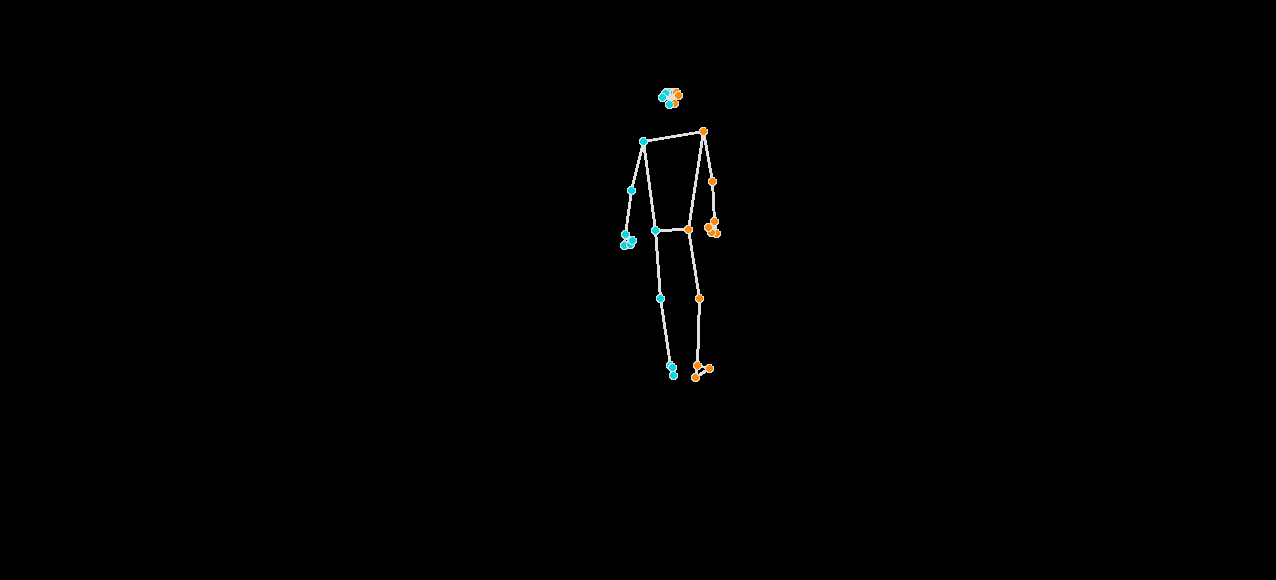

580 1276 3


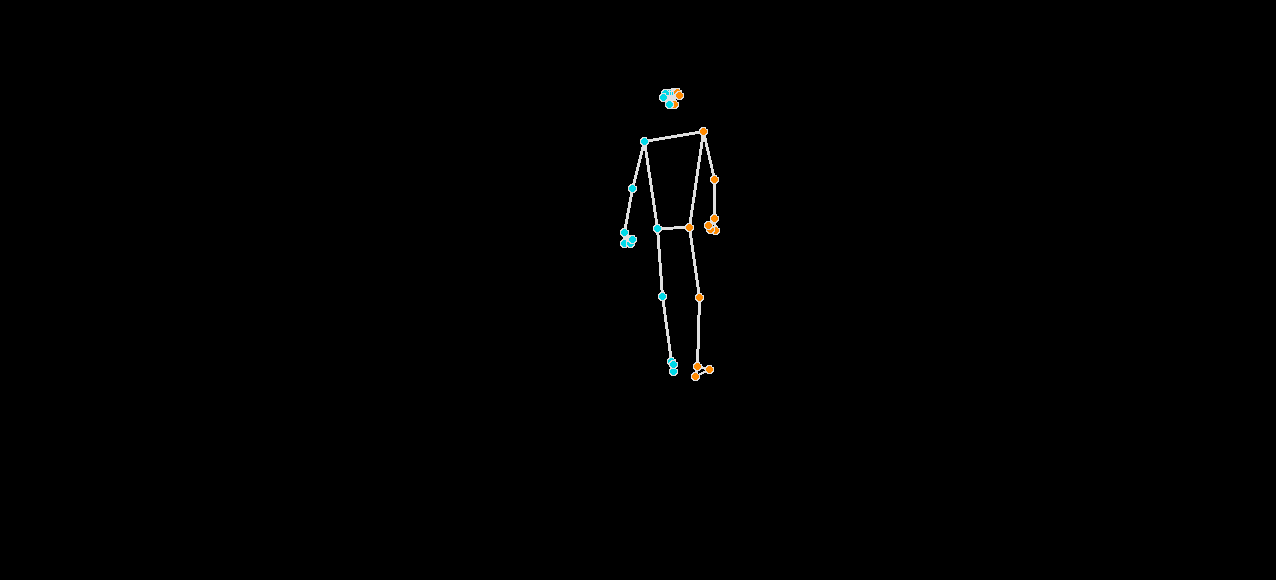

580 1276 3


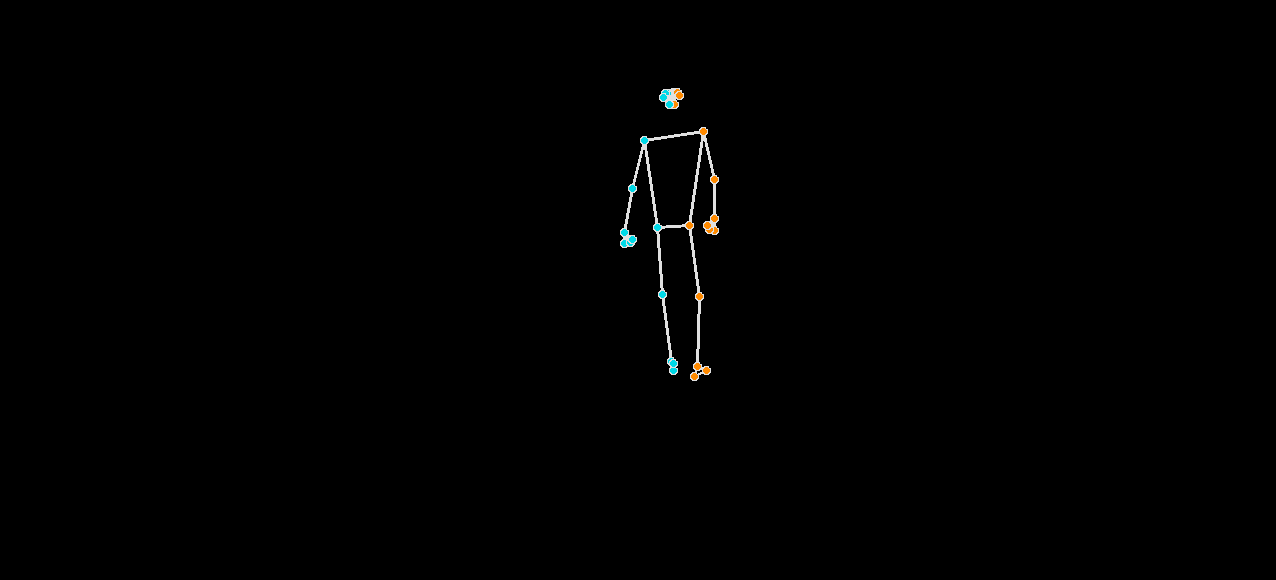

580 1276 3


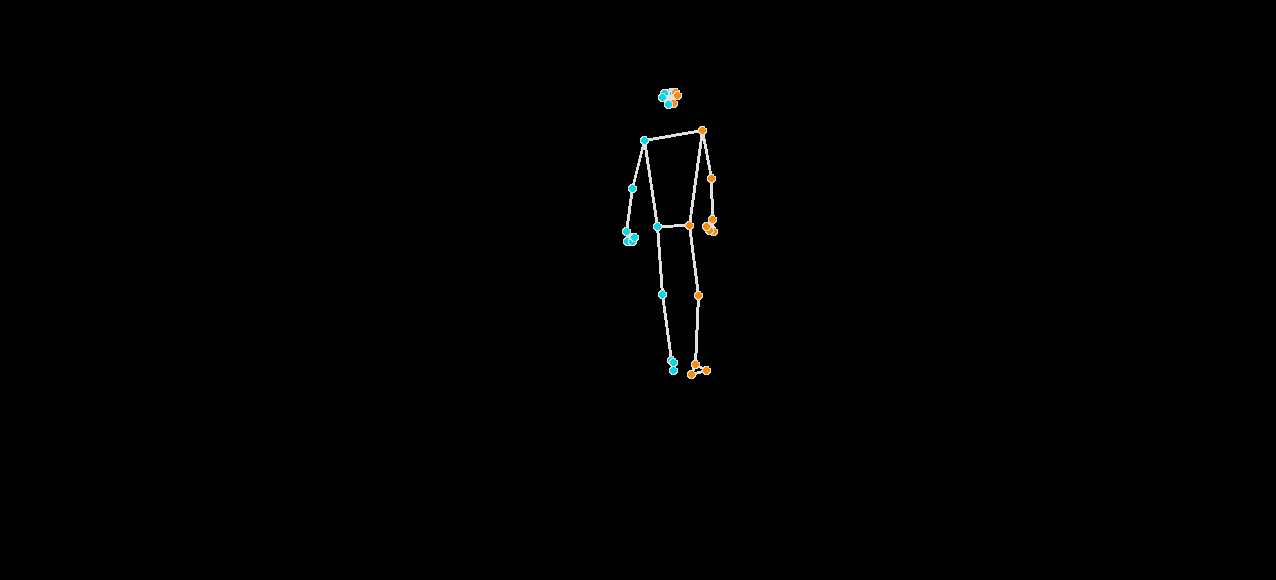

580 1276 3


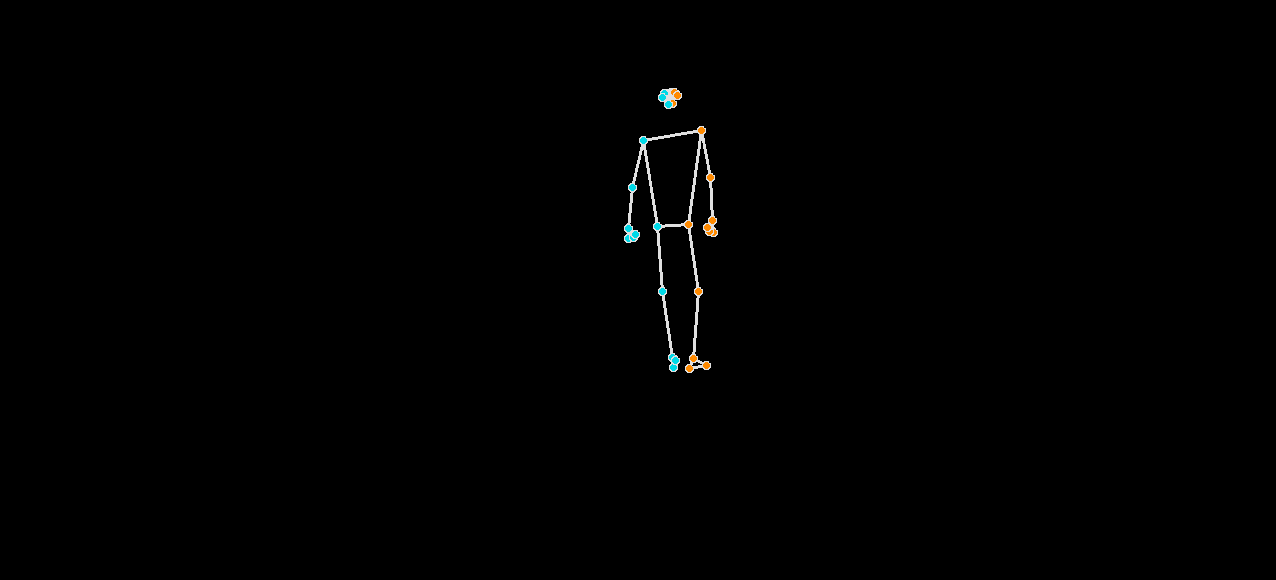

580 1276 3


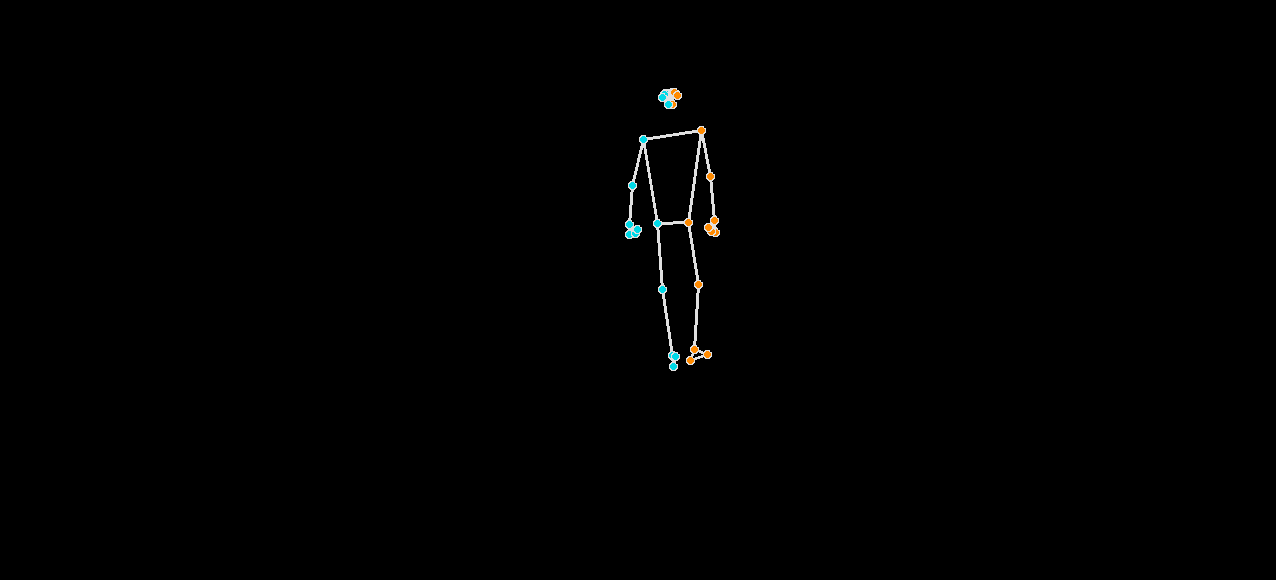

580 1276 3


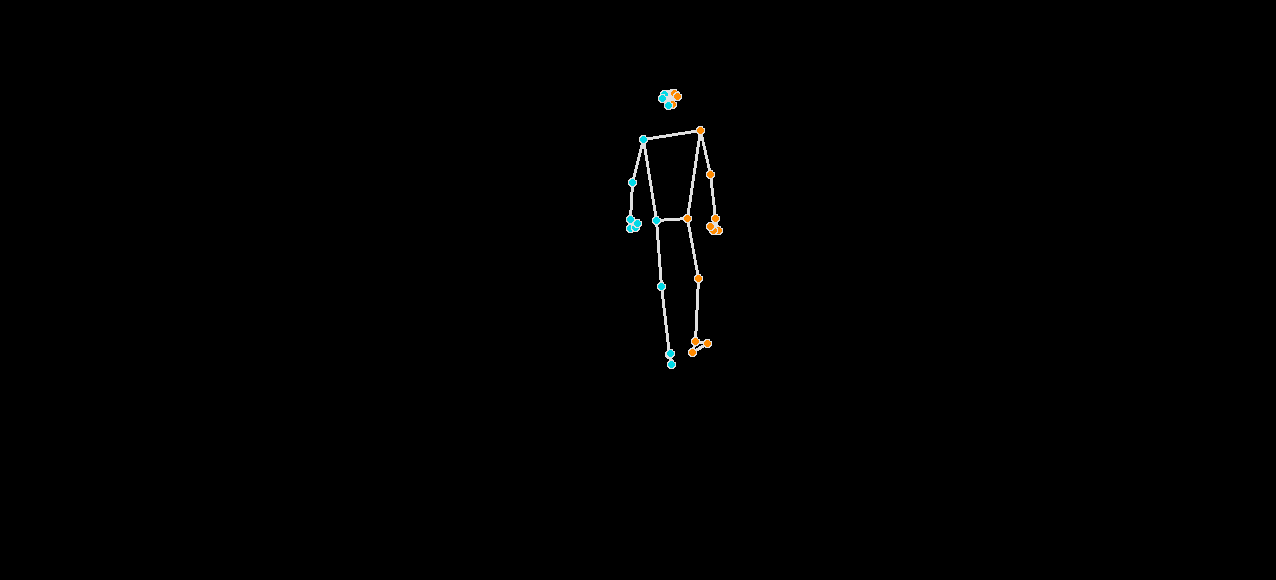

580 1276 3


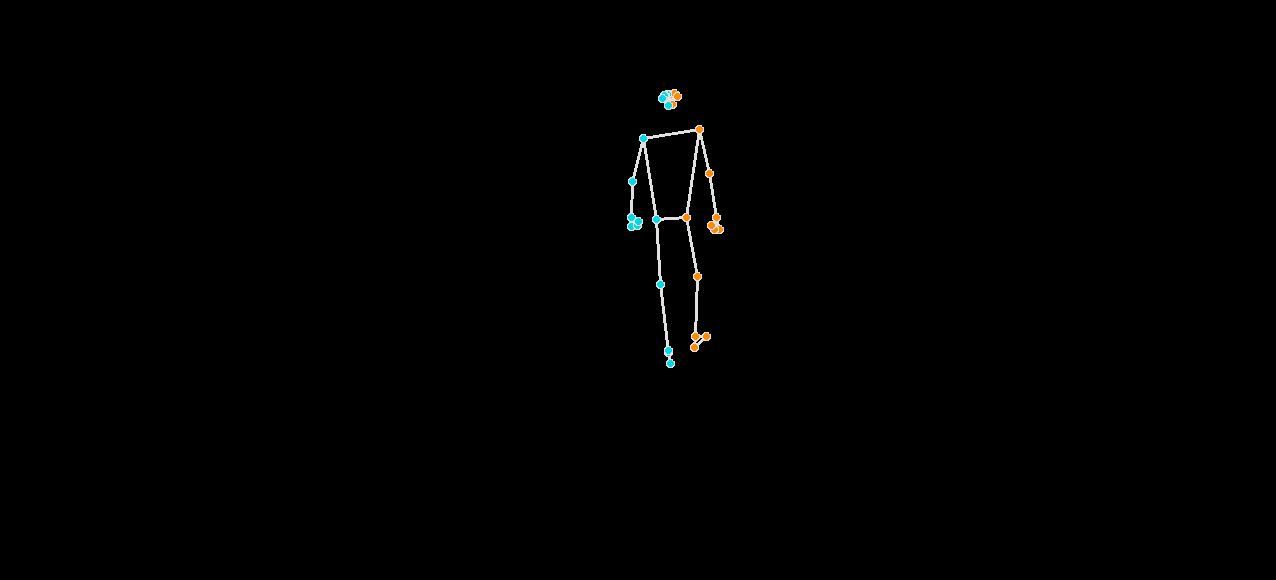

580 1276 3


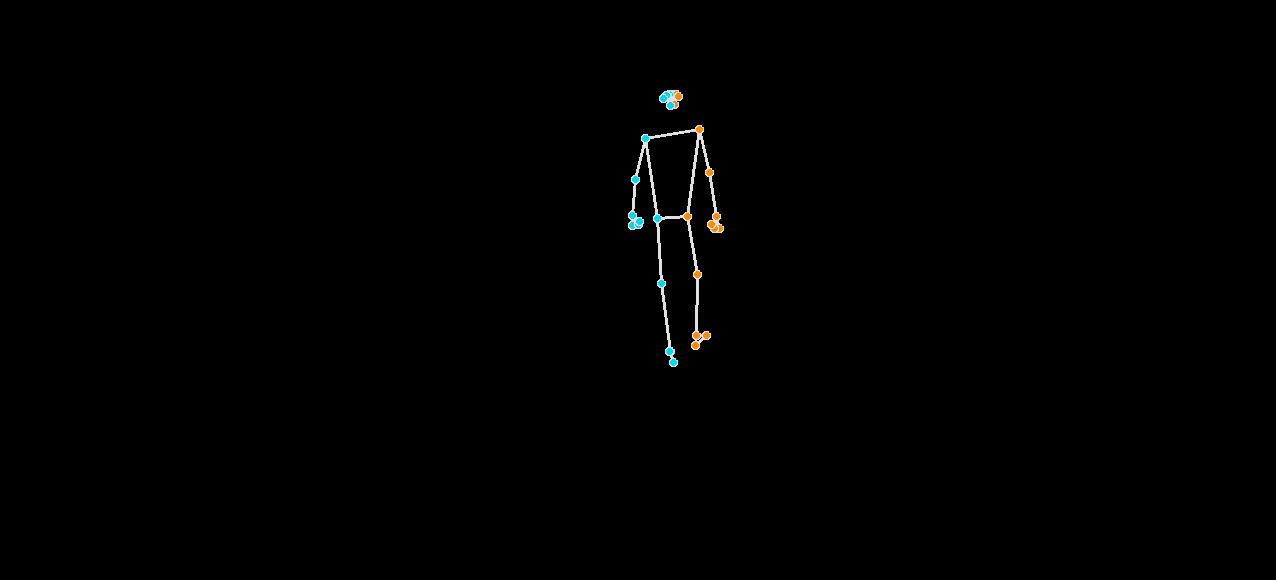

580 1276 3


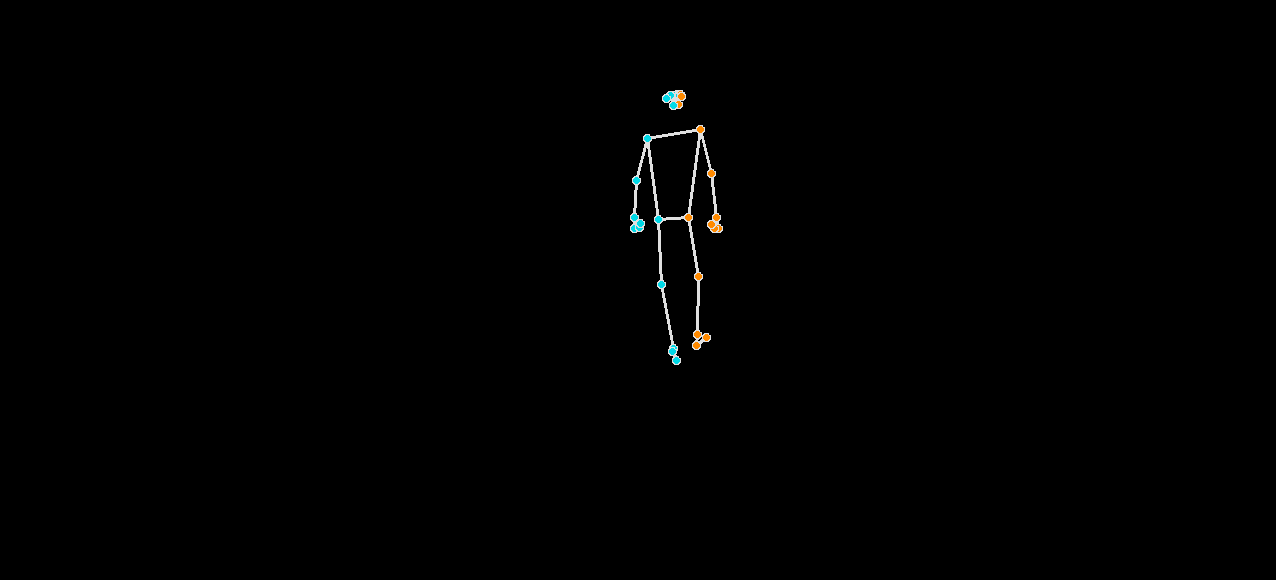

580 1276 3


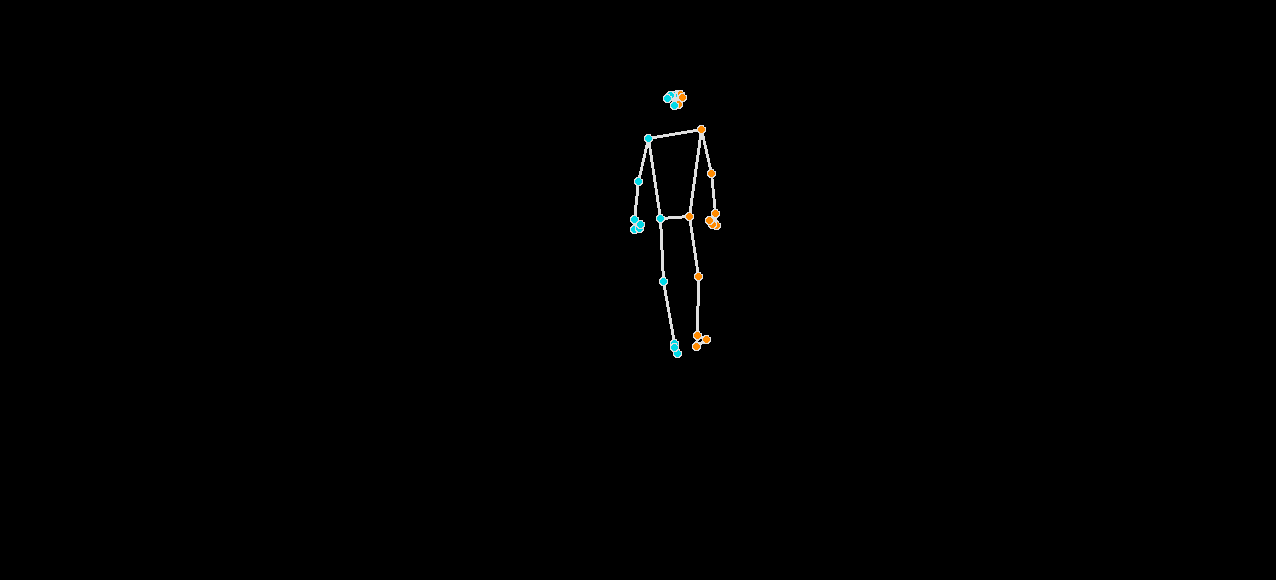

580 1276 3


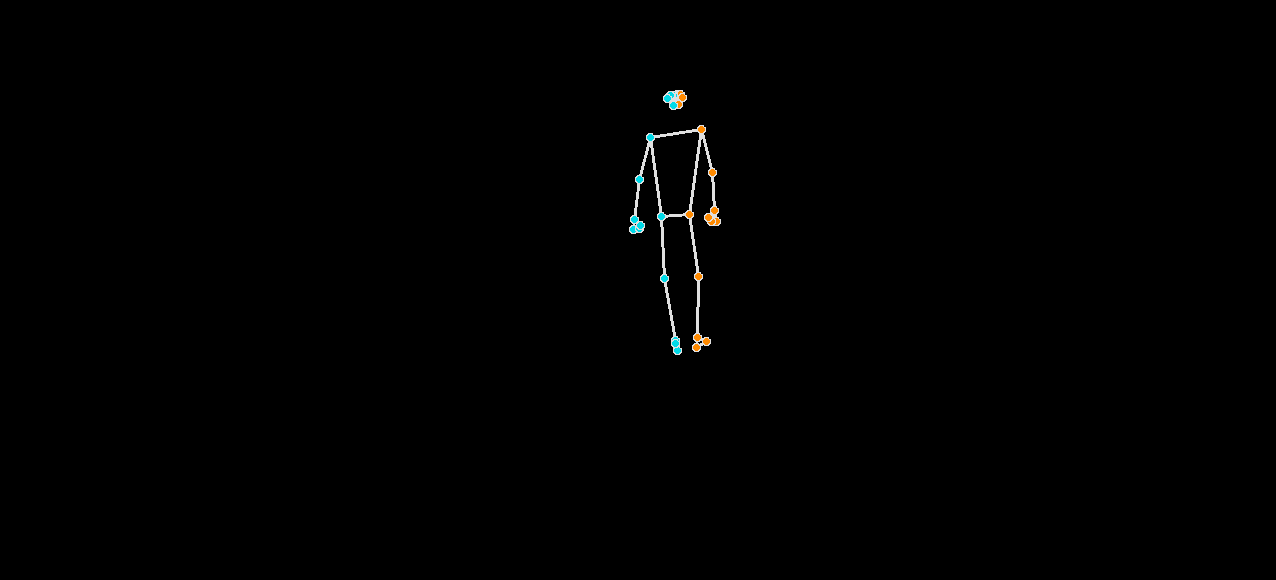

580 1276 3


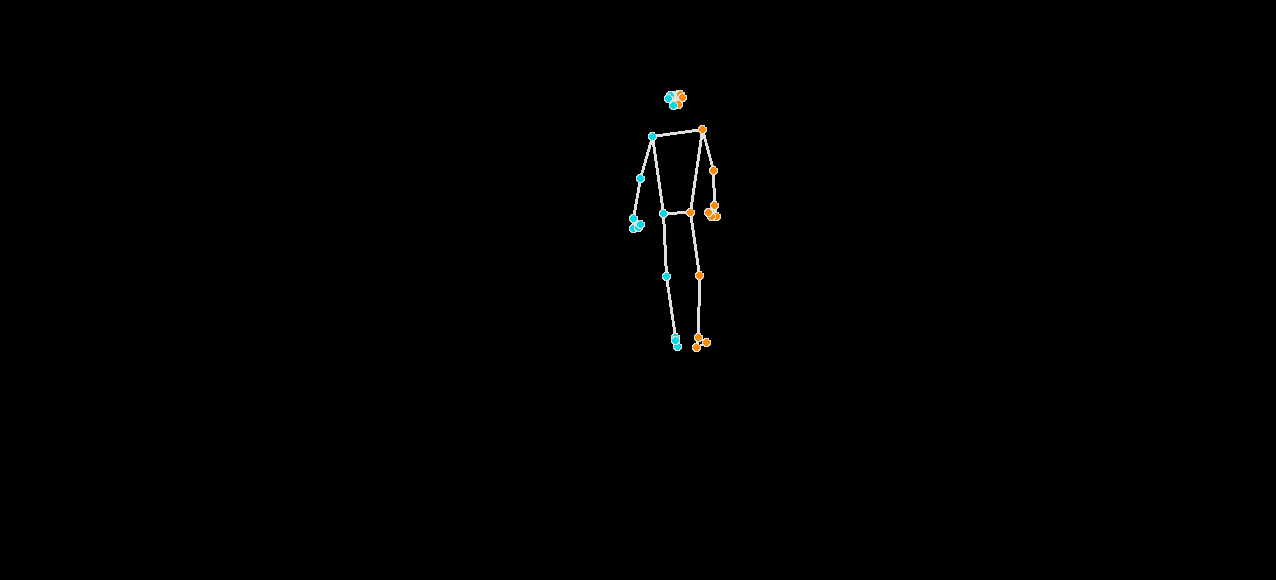

580 1276 3


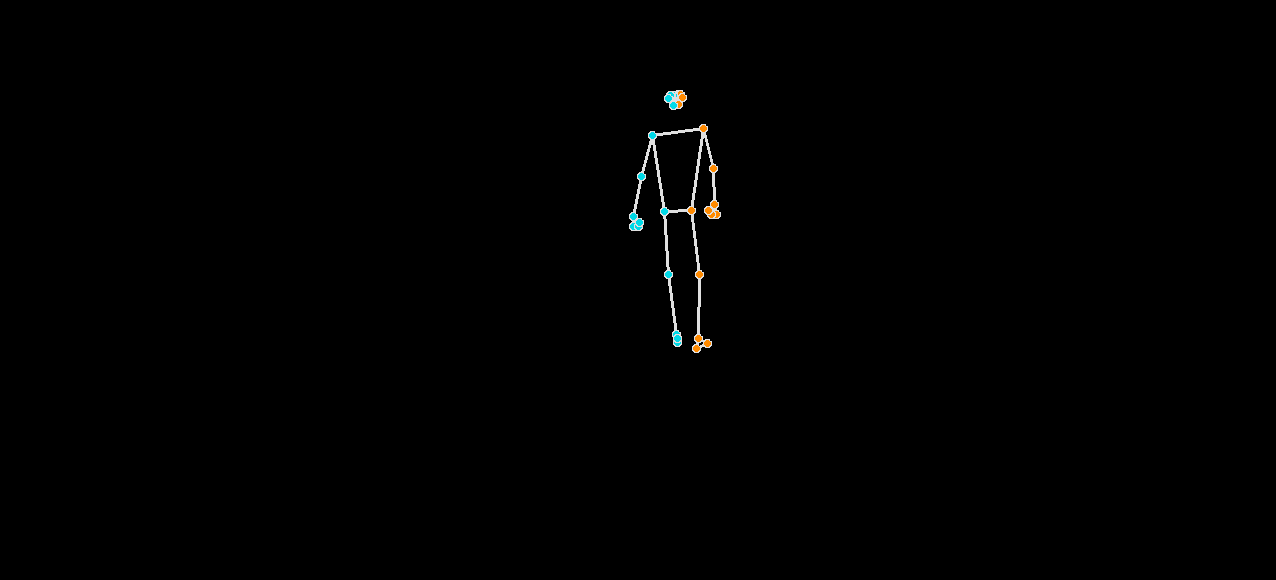

580 1276 3


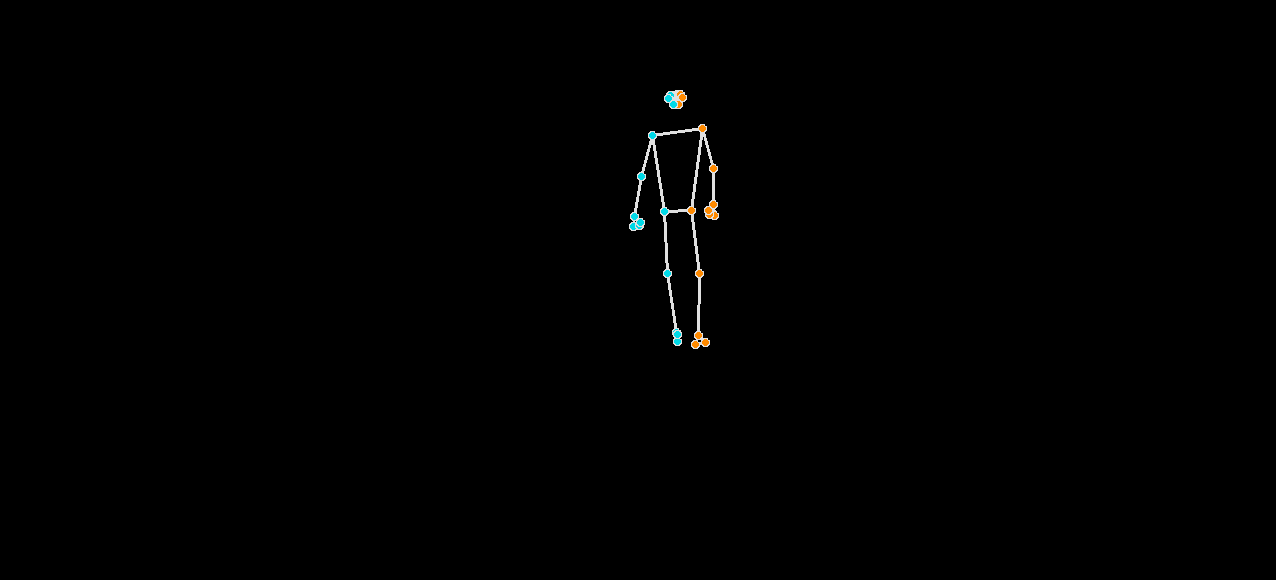

580 1276 3


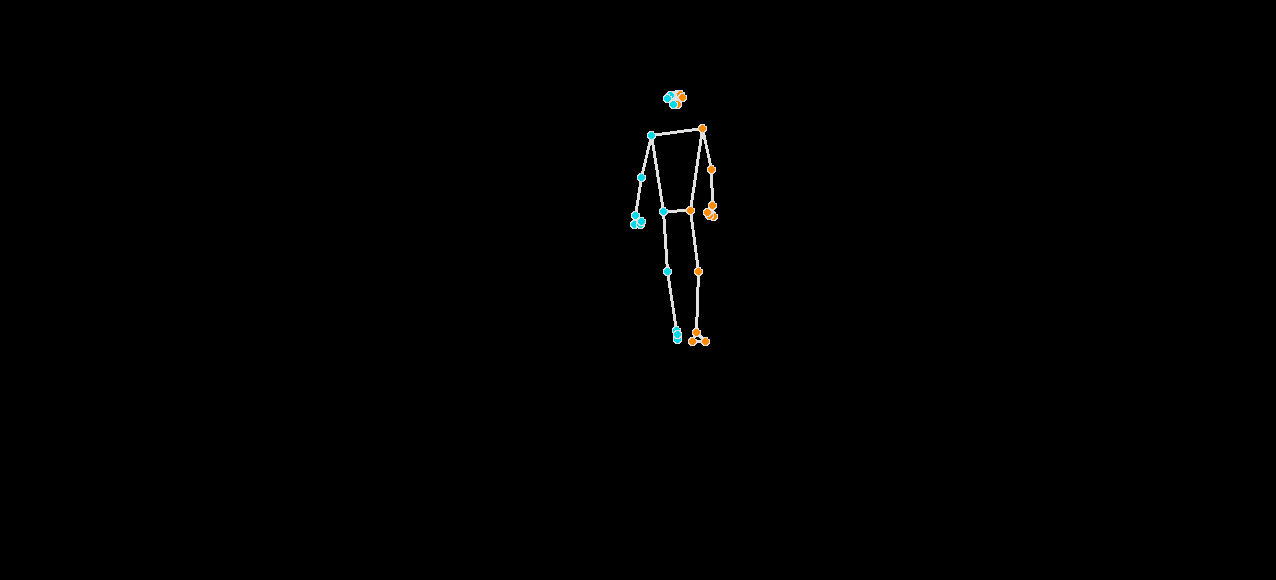

580 1276 3


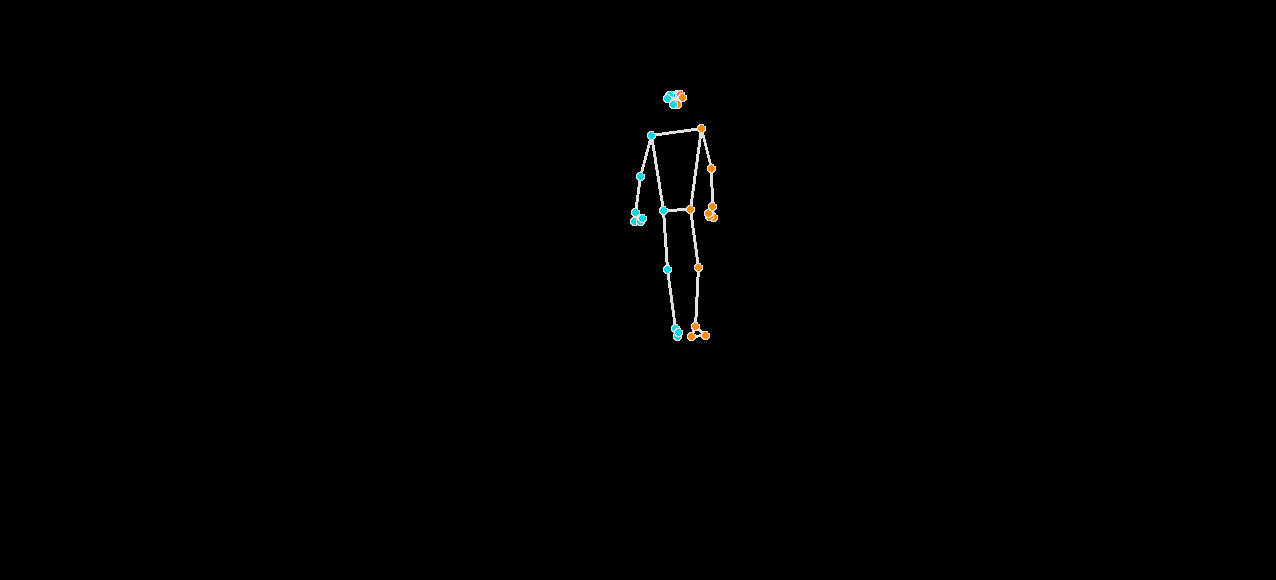

580 1276 3


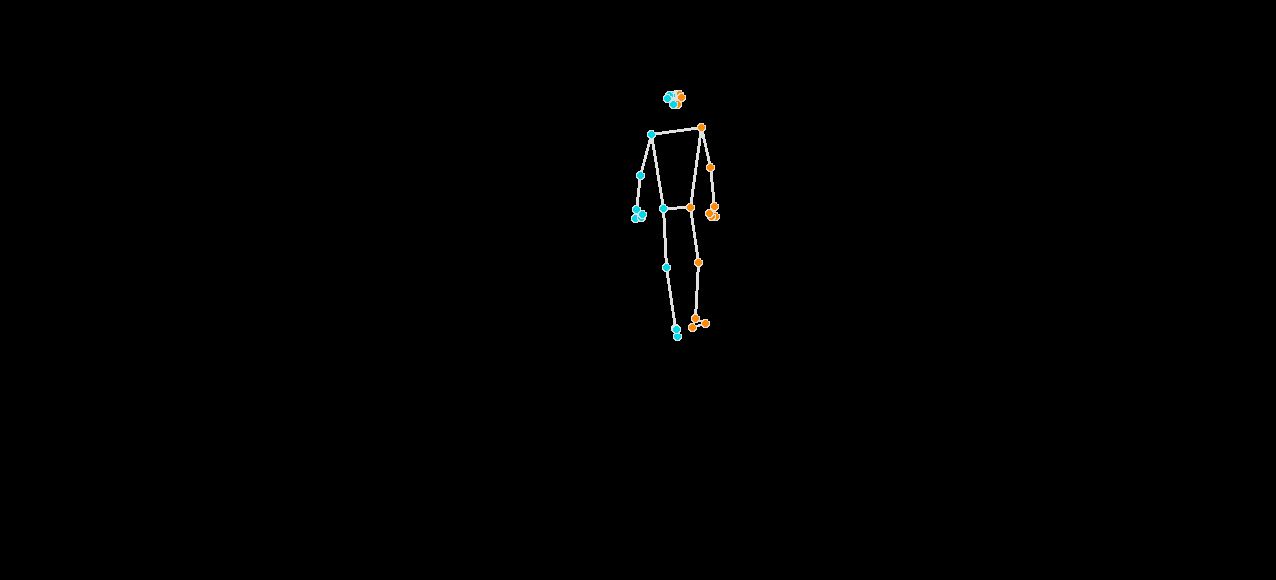

580 1276 3


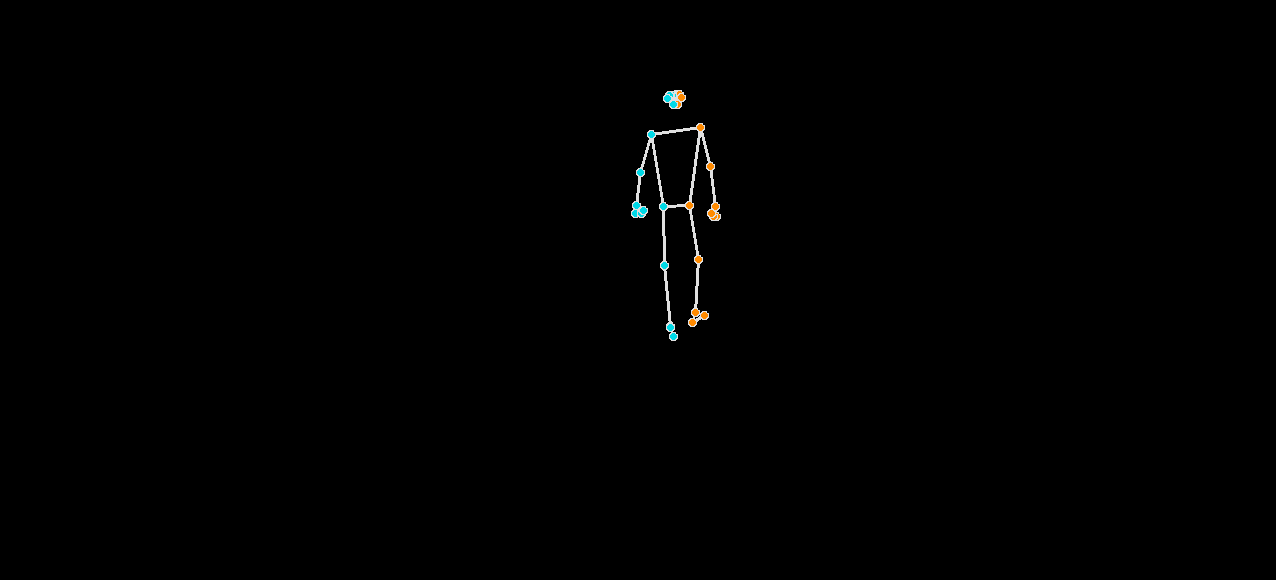

580 1276 3


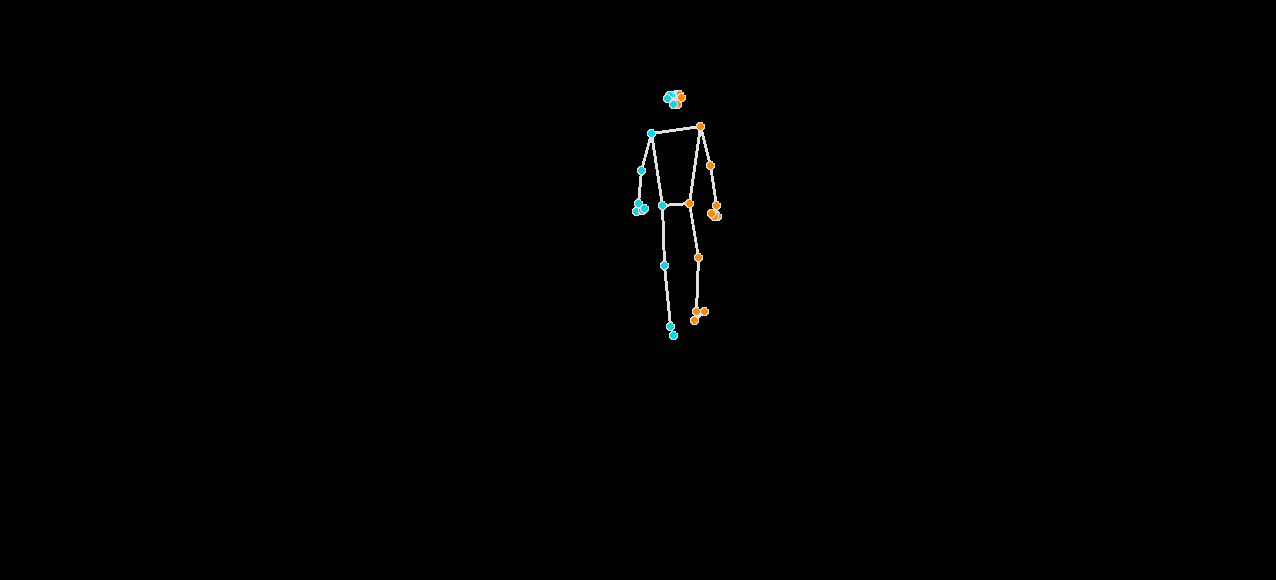

580 1276 3


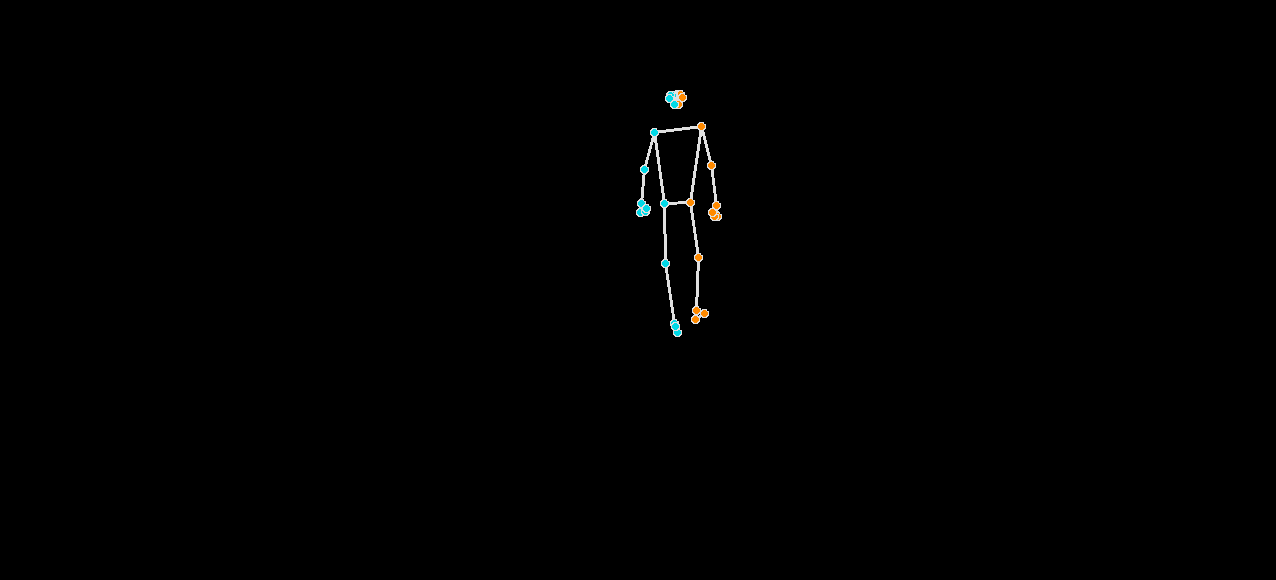

580 1276 3


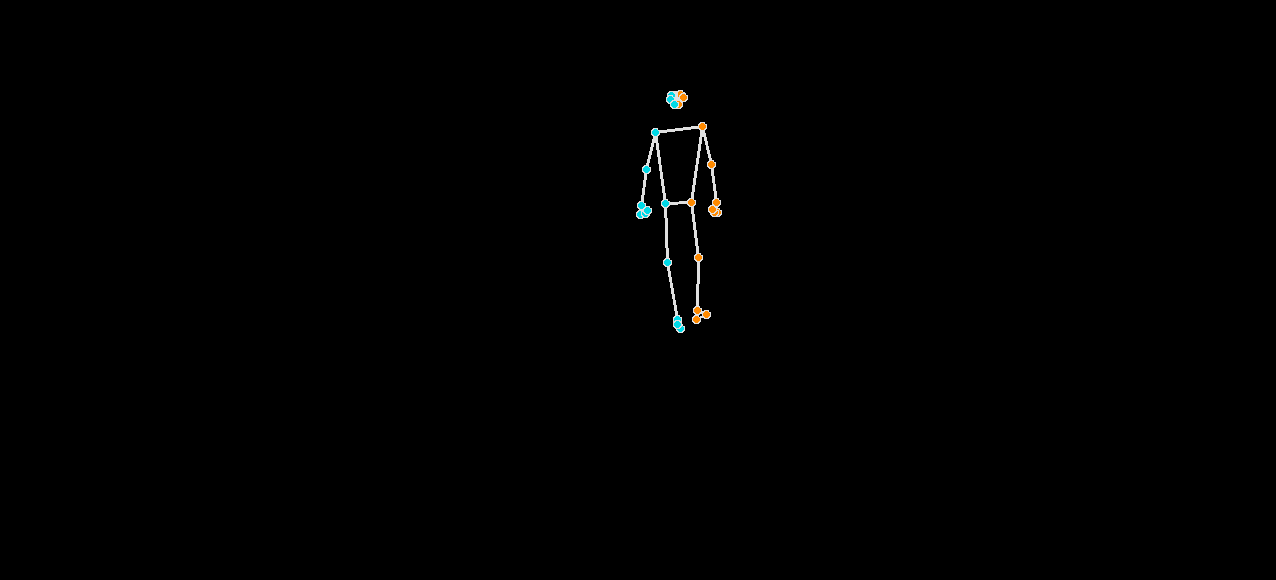

580 1276 3


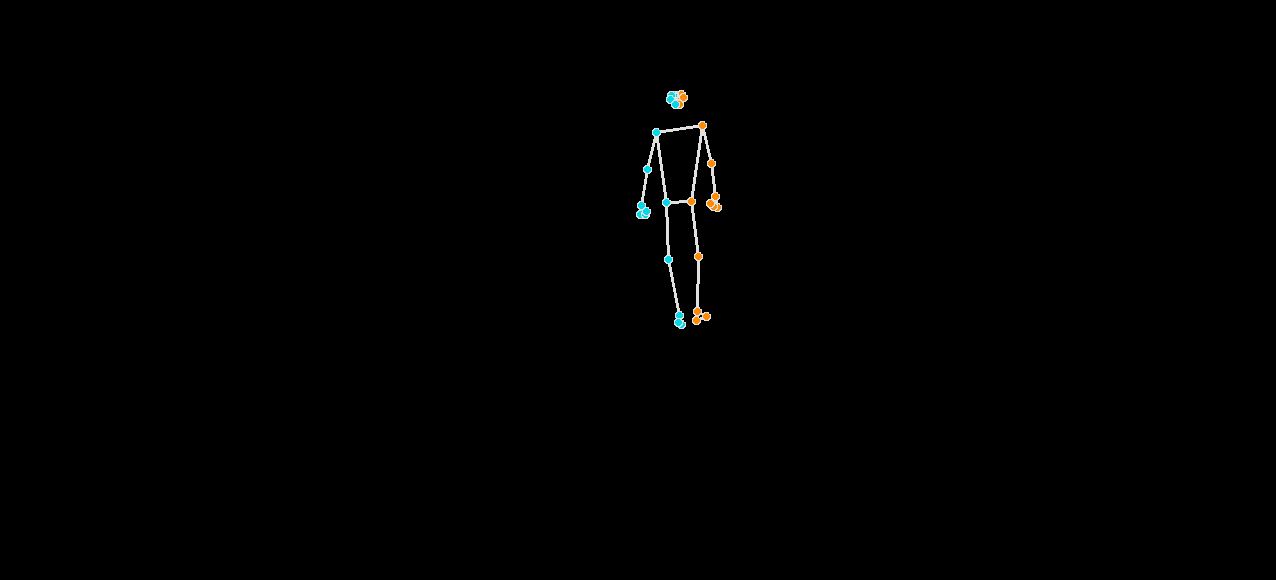

580 1276 3


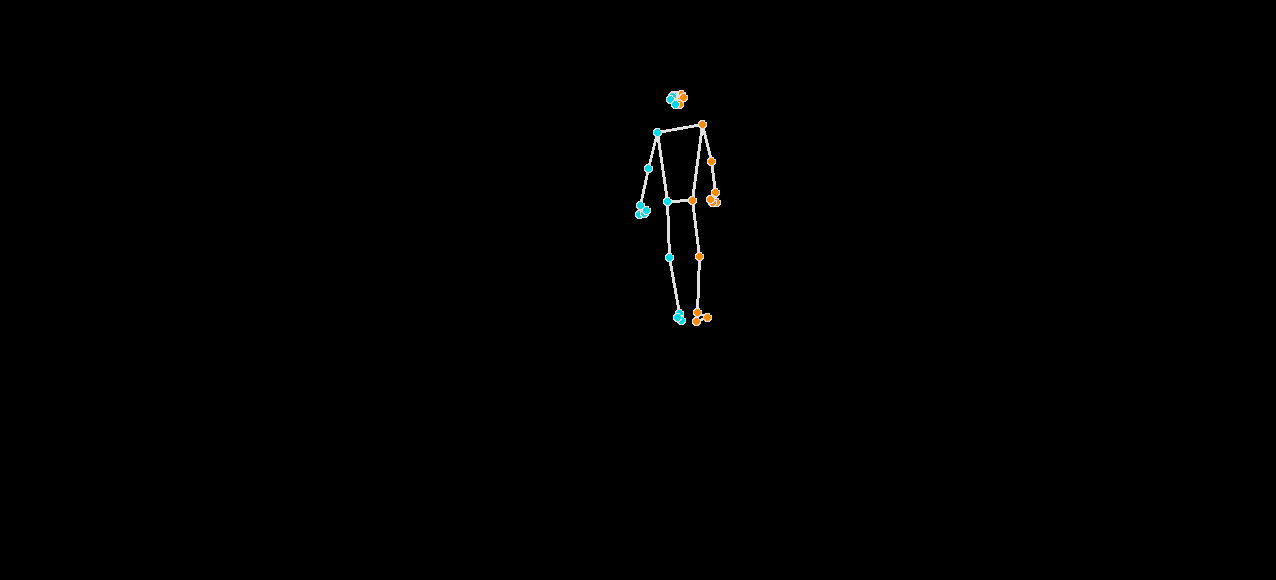

580 1276 3


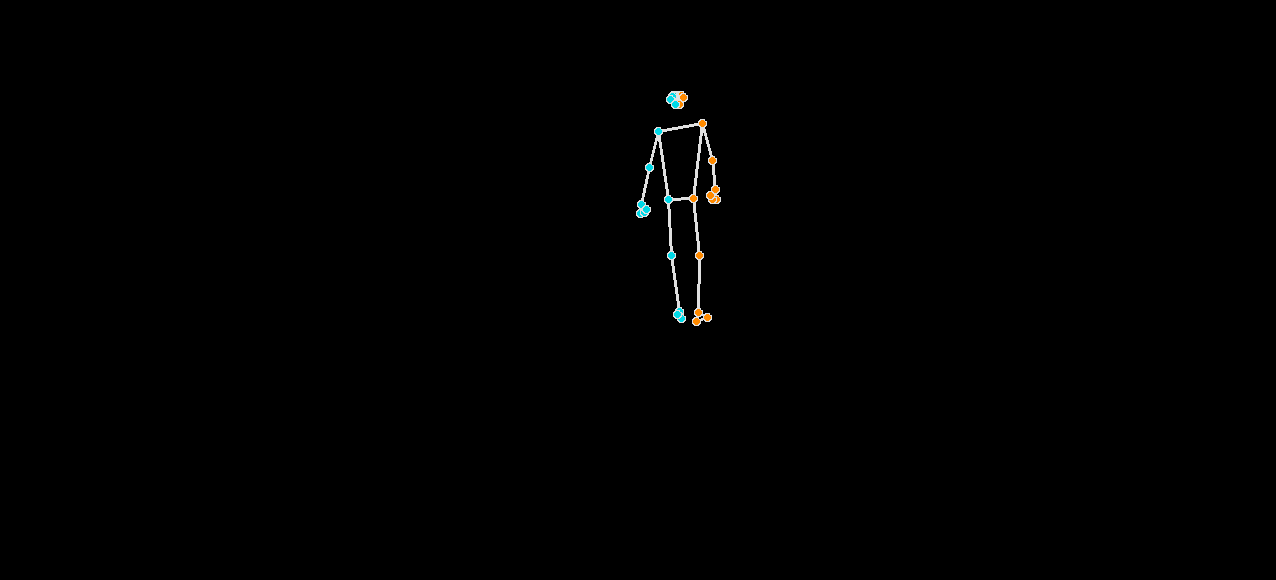

580 1276 3


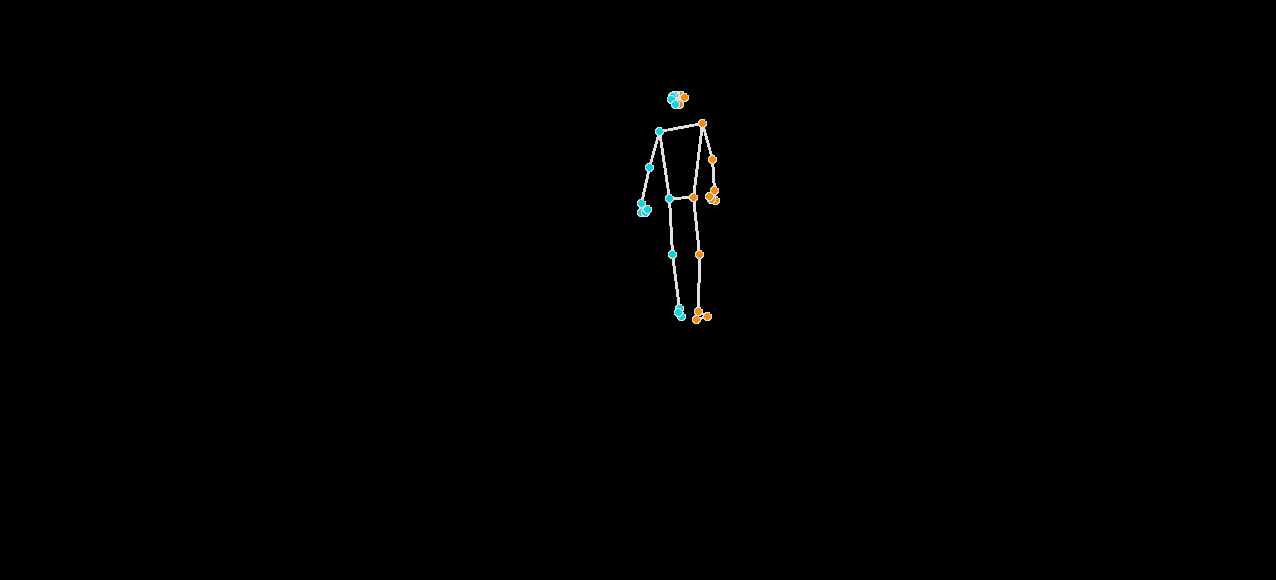

580 1276 3


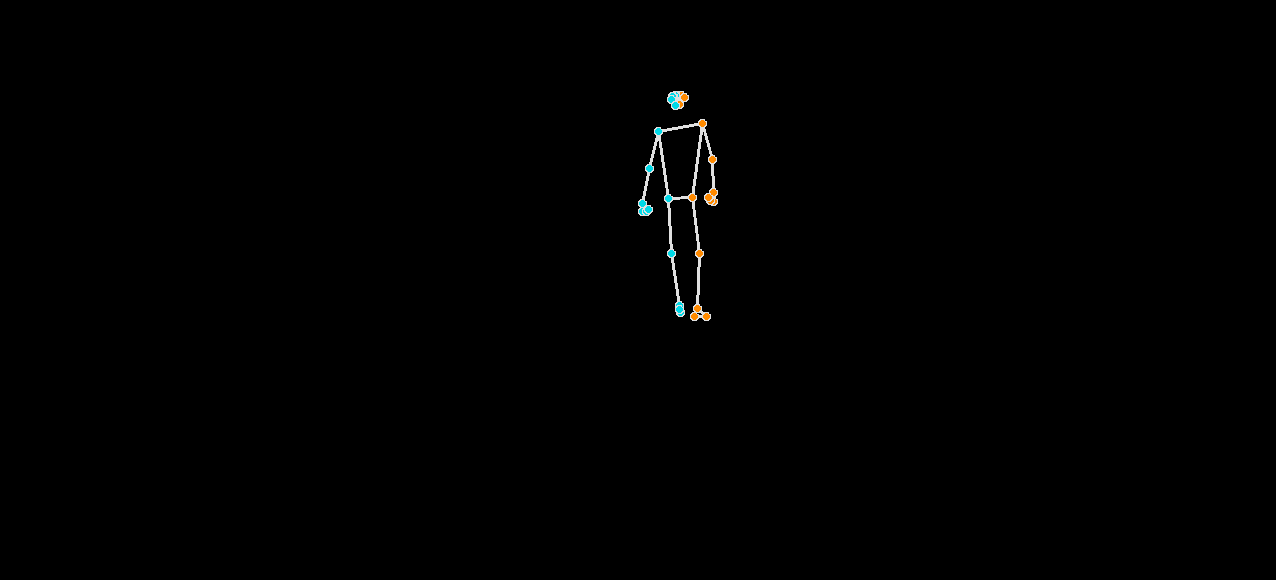

580 1276 3


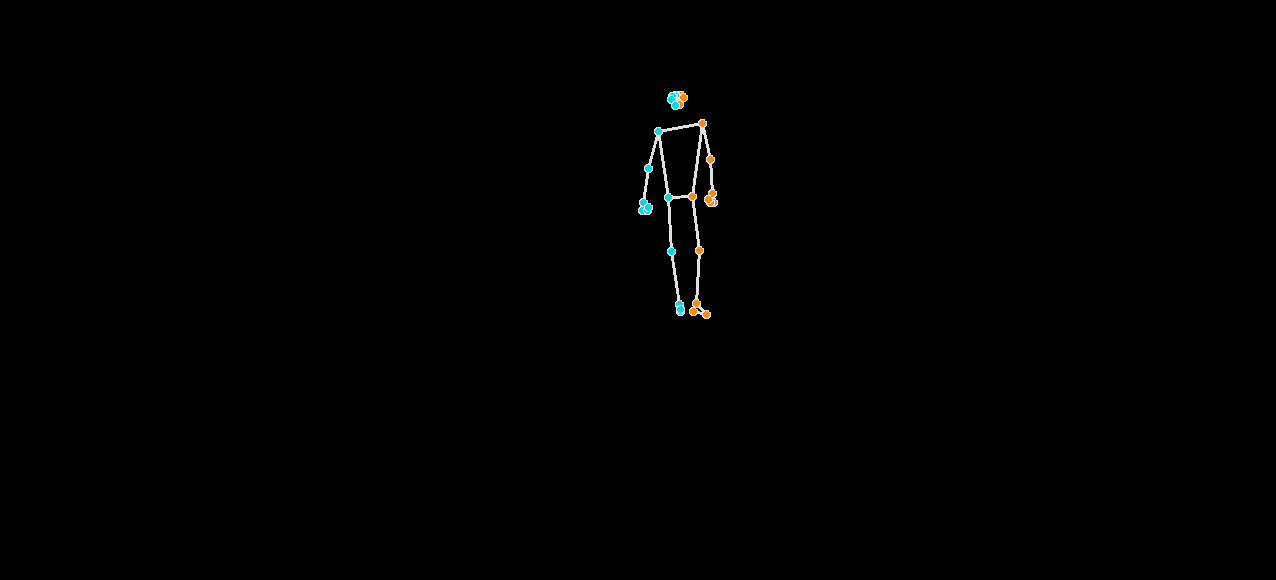

580 1276 3


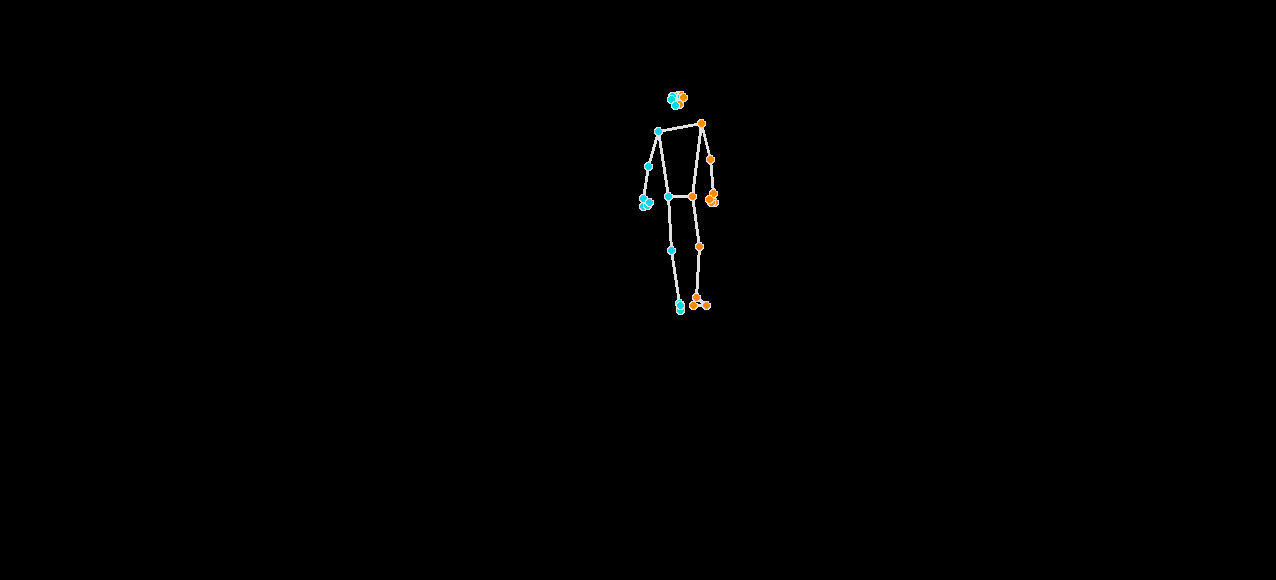

580 1276 3


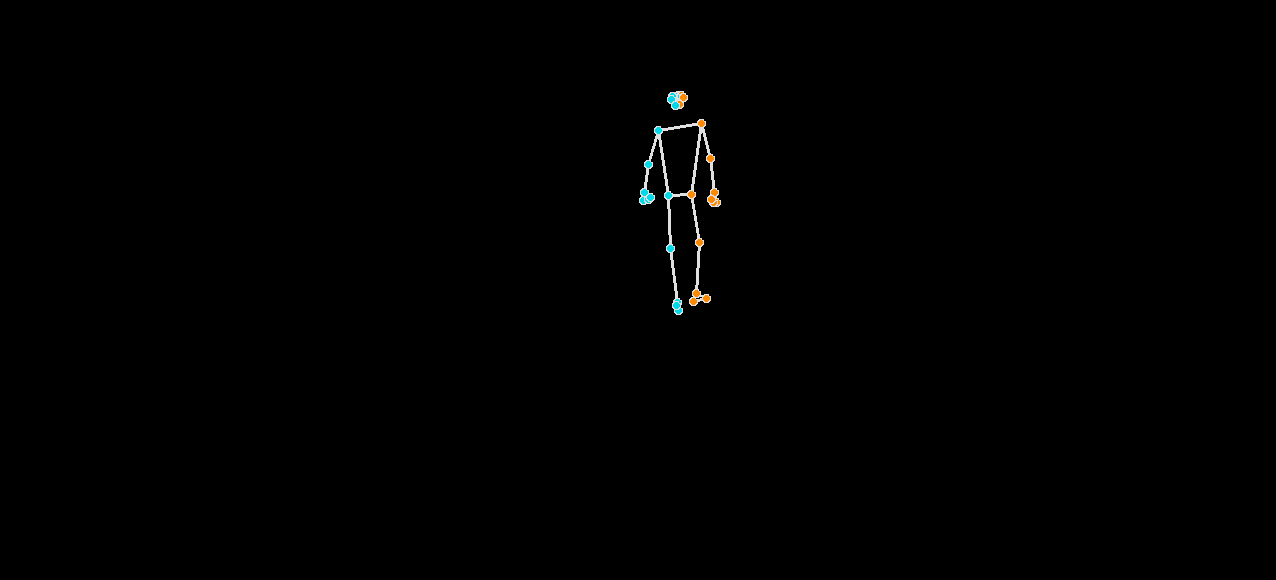

580 1276 3


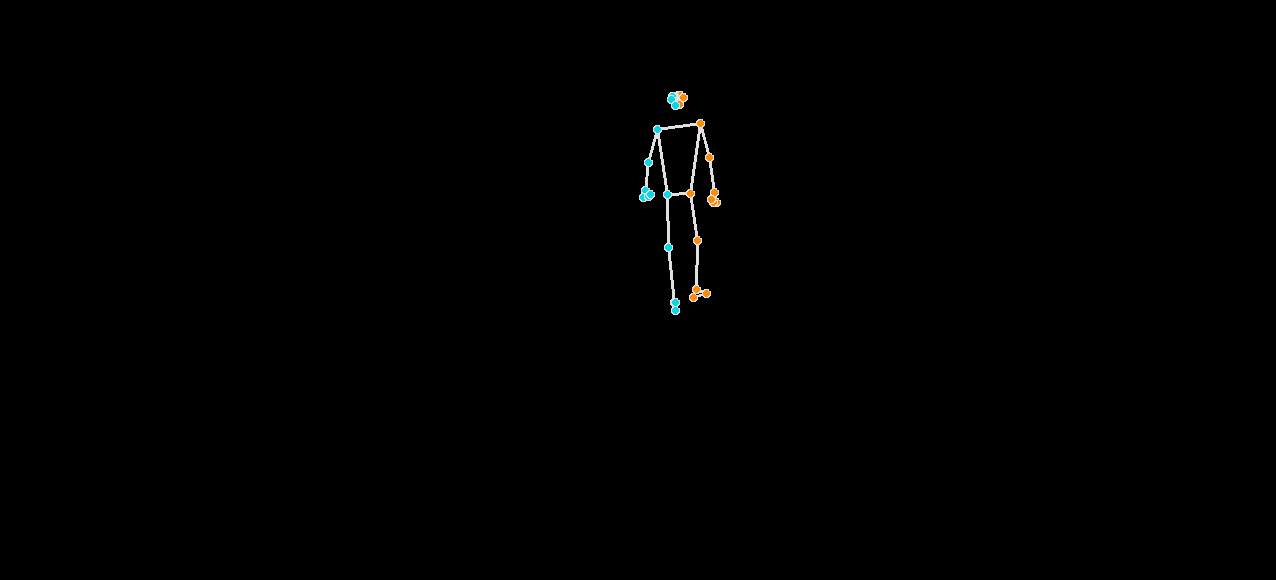

580 1276 3


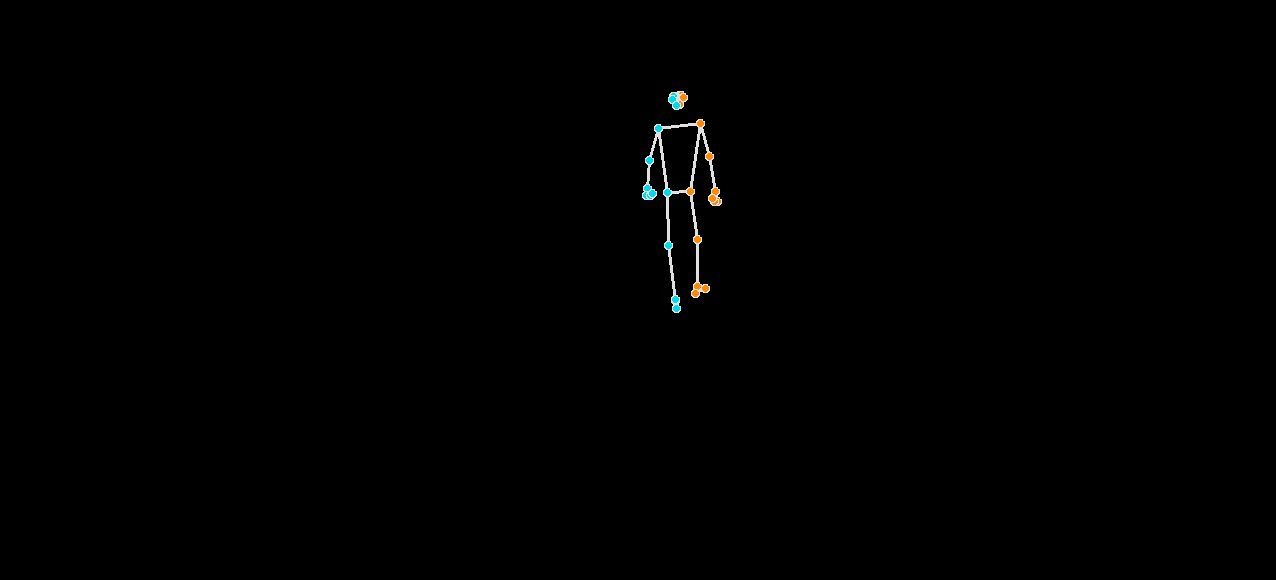

580 1276 3


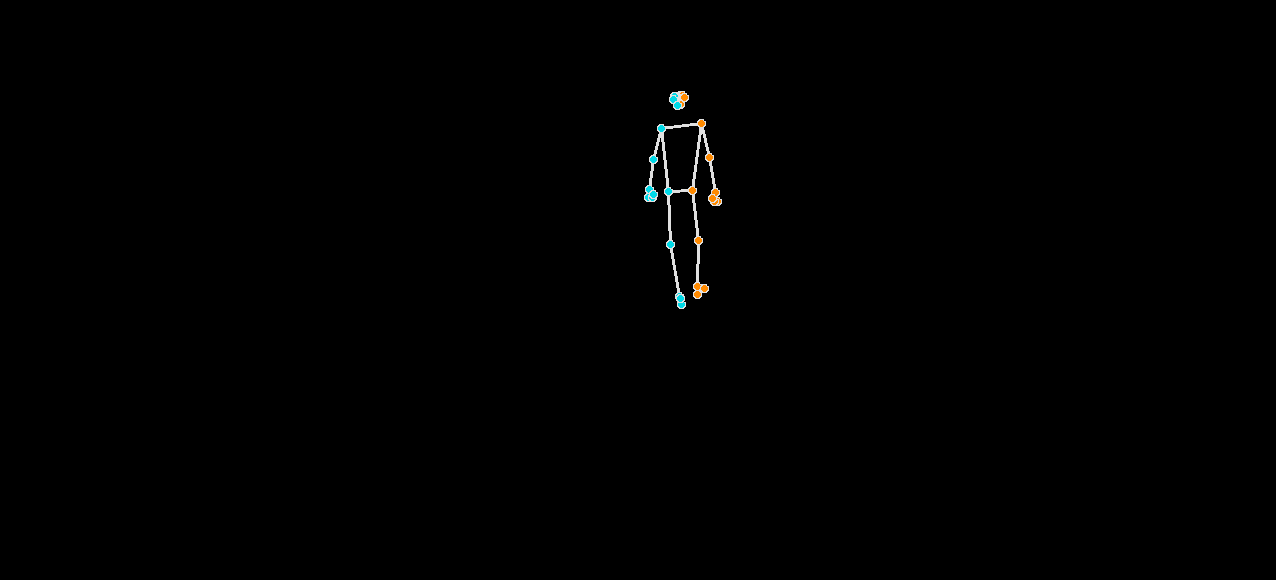

580 1276 3


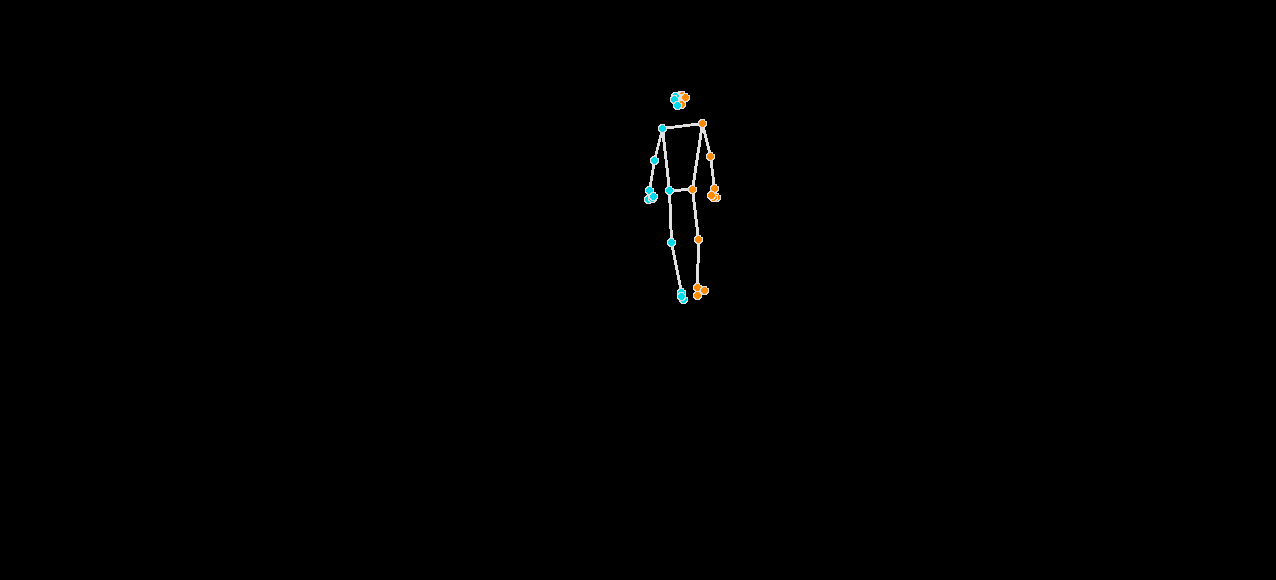

580 1276 3


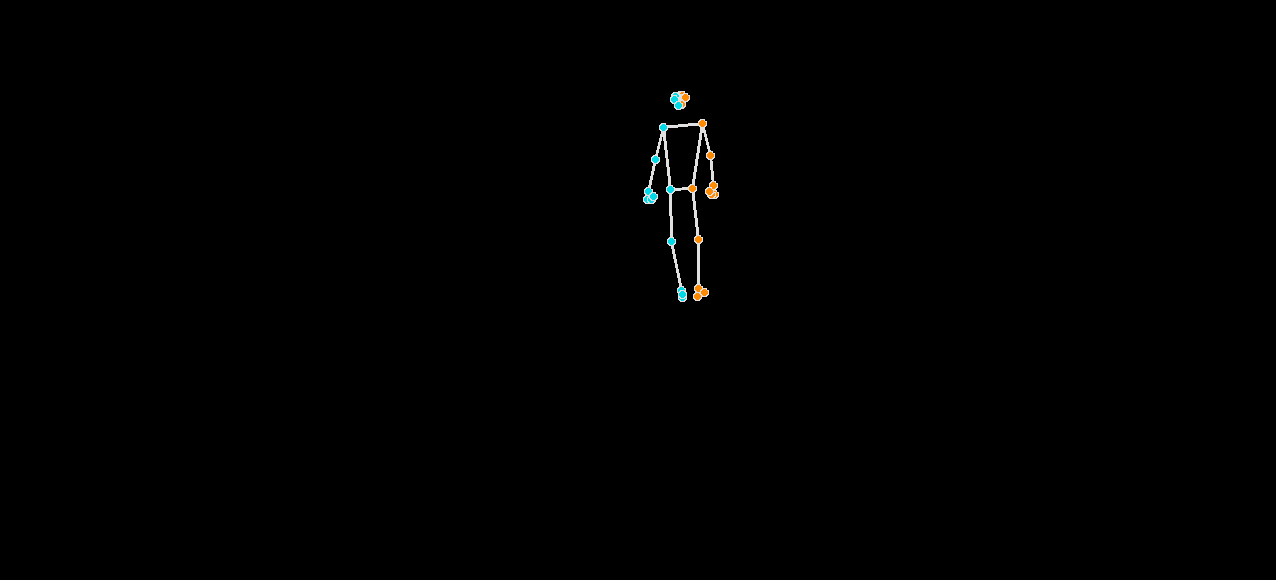

580 1276 3


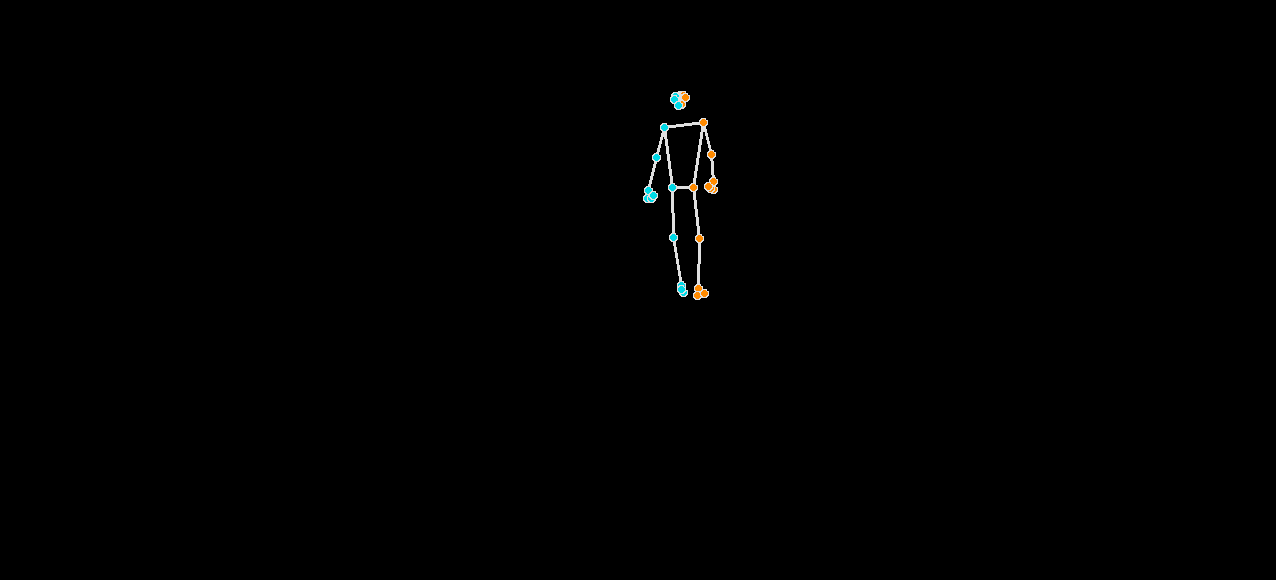

580 1276 3


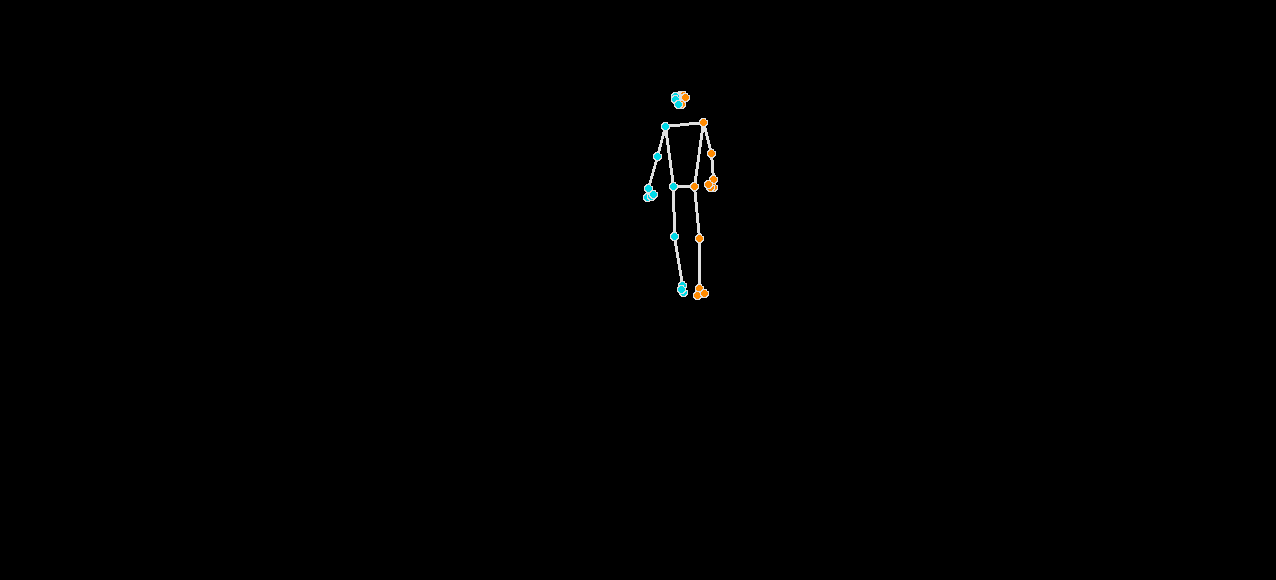

580 1276 3


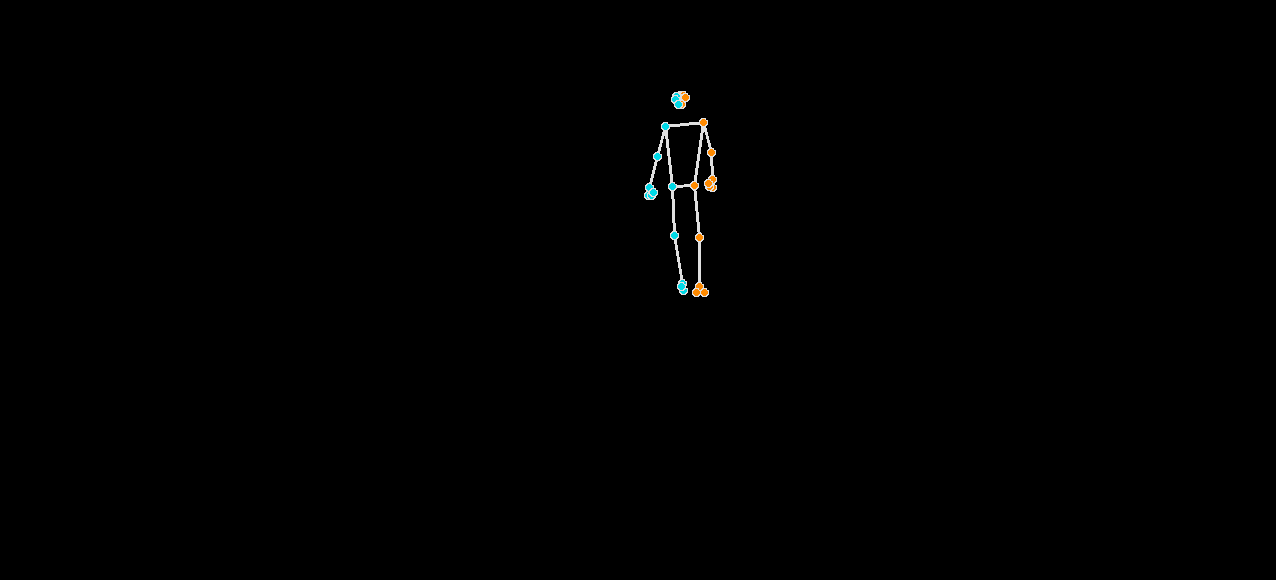

580 1276 3


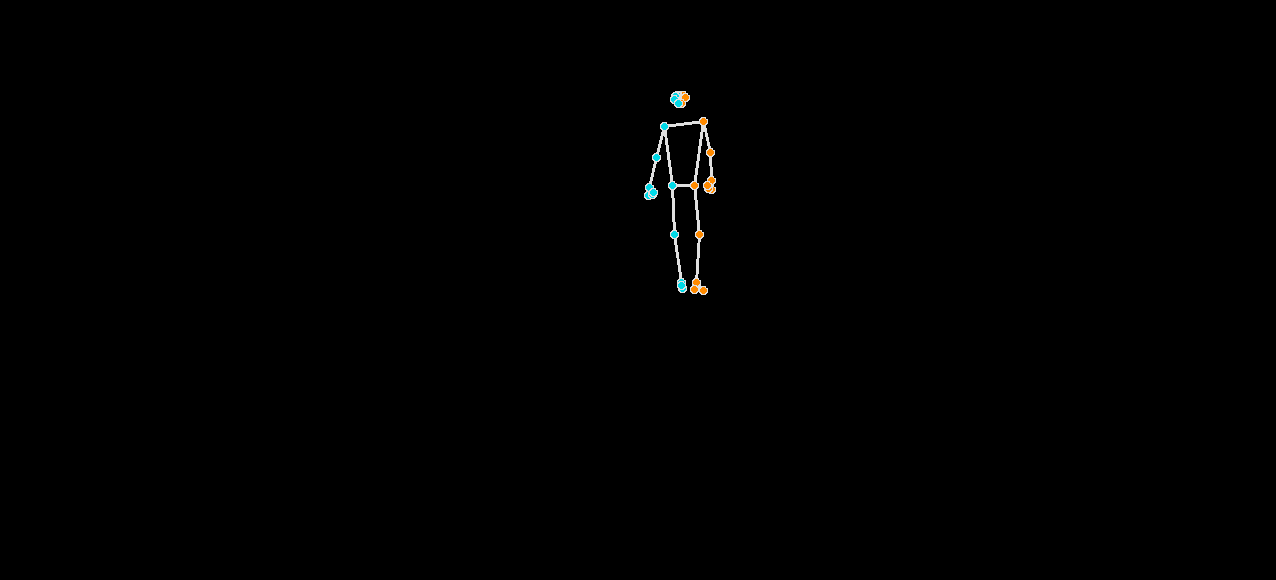

580 1276 3


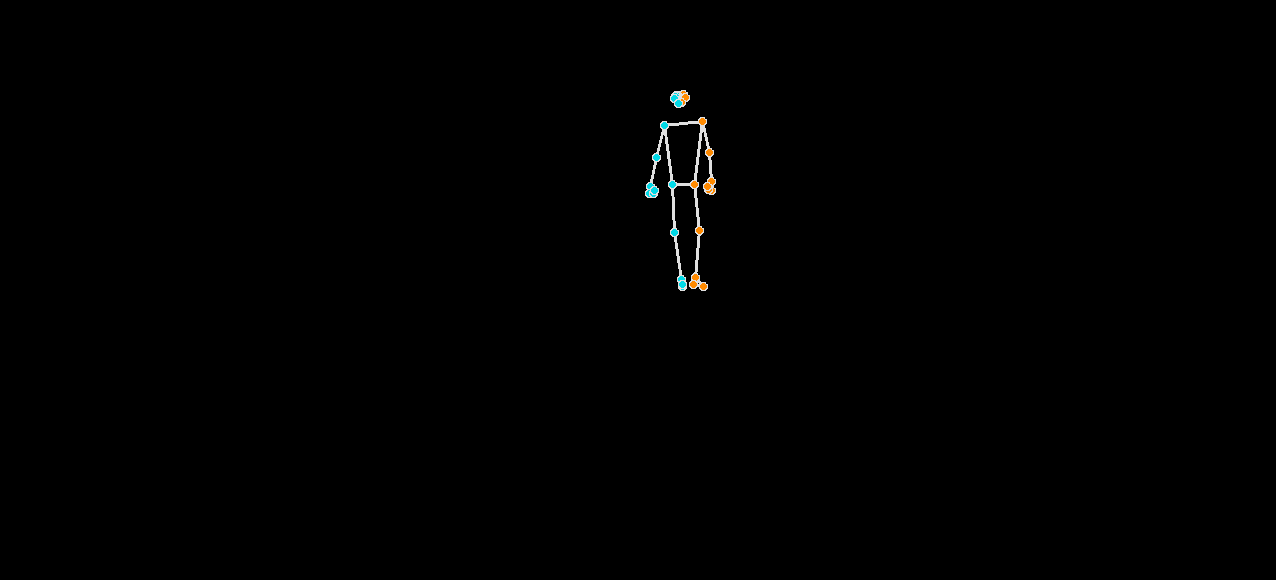

580 1276 3


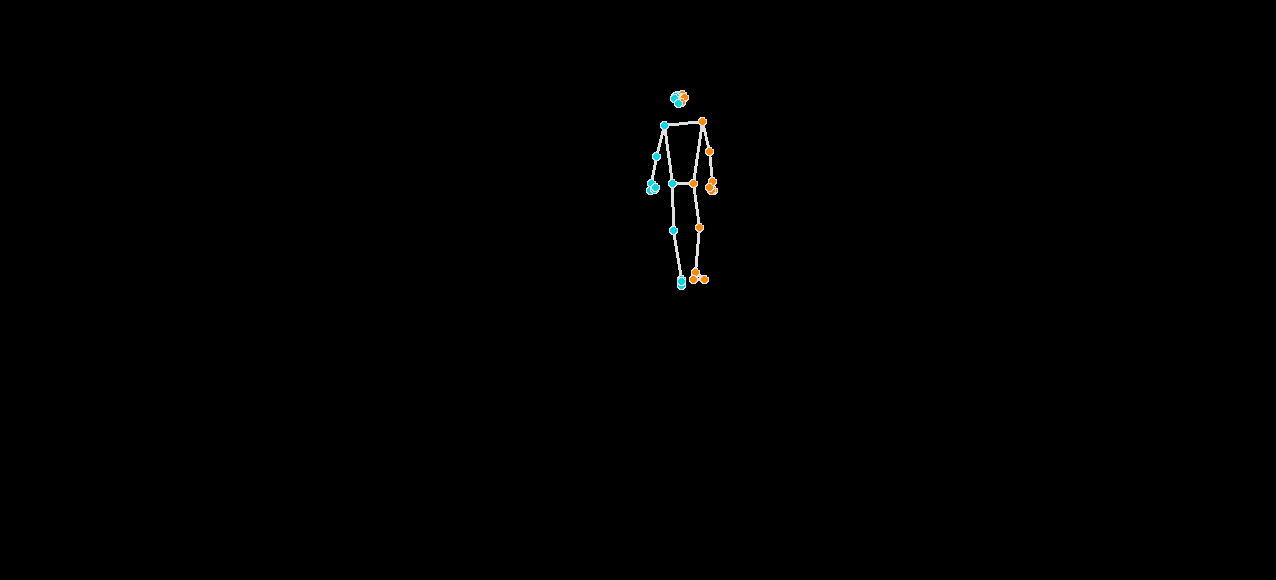

580 1276 3


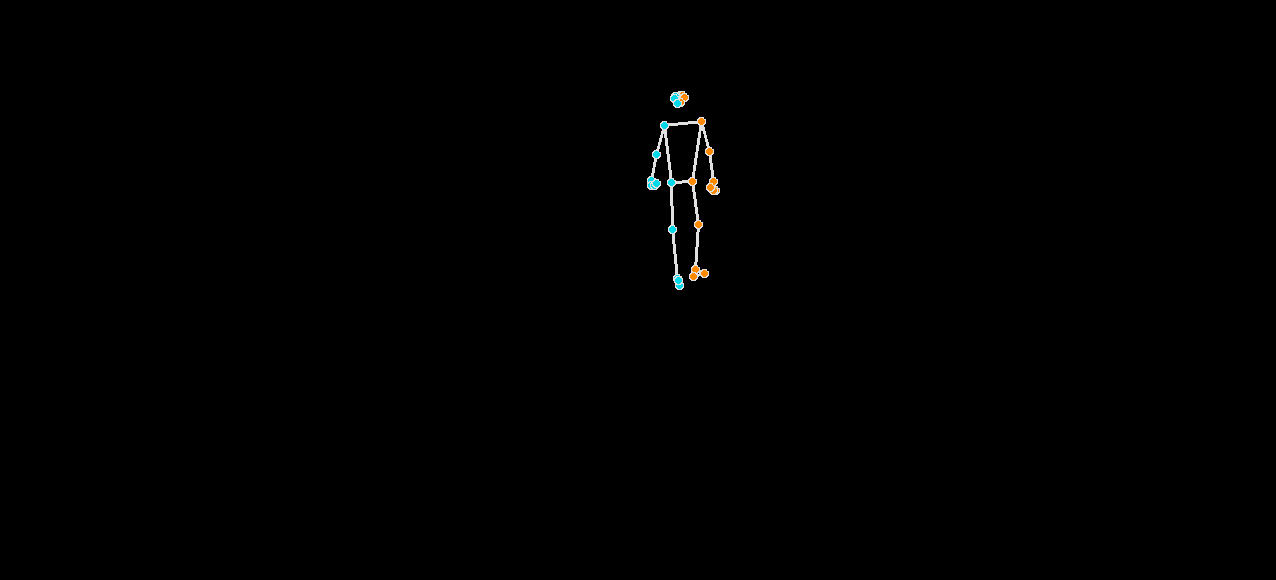

580 1276 3


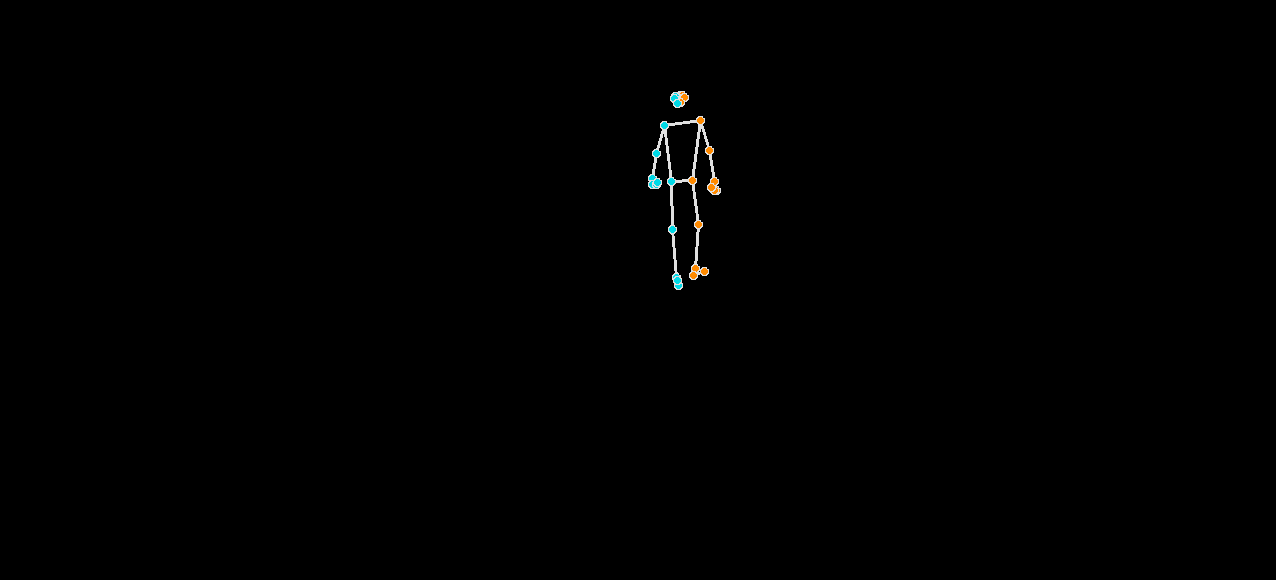

580 1276 3


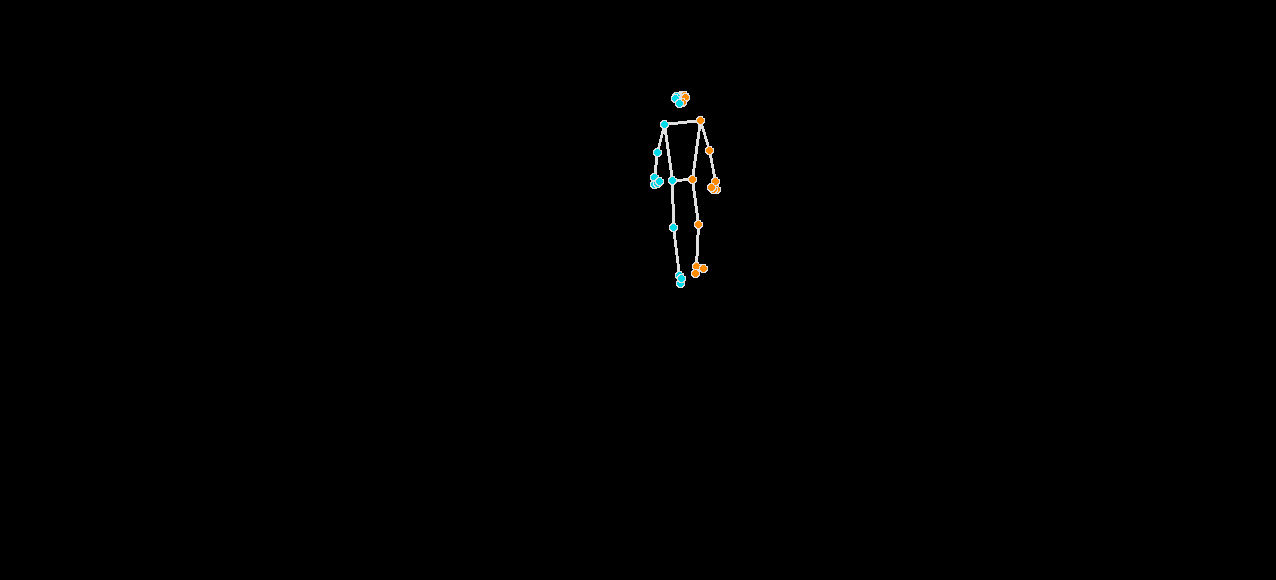

580 1276 3


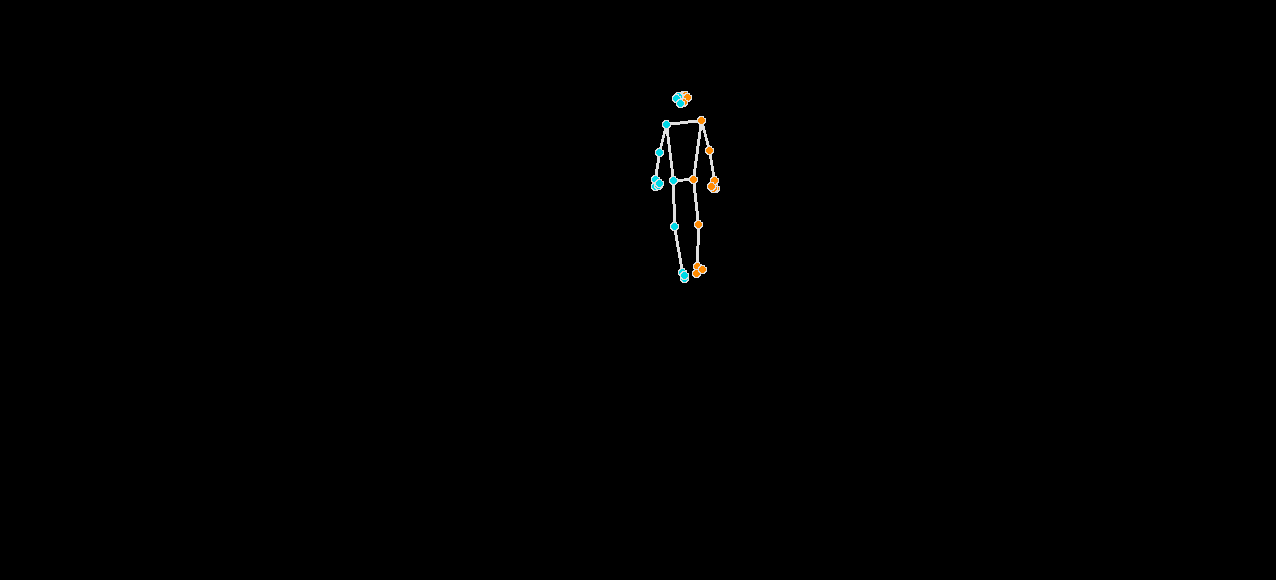

580 1276 3


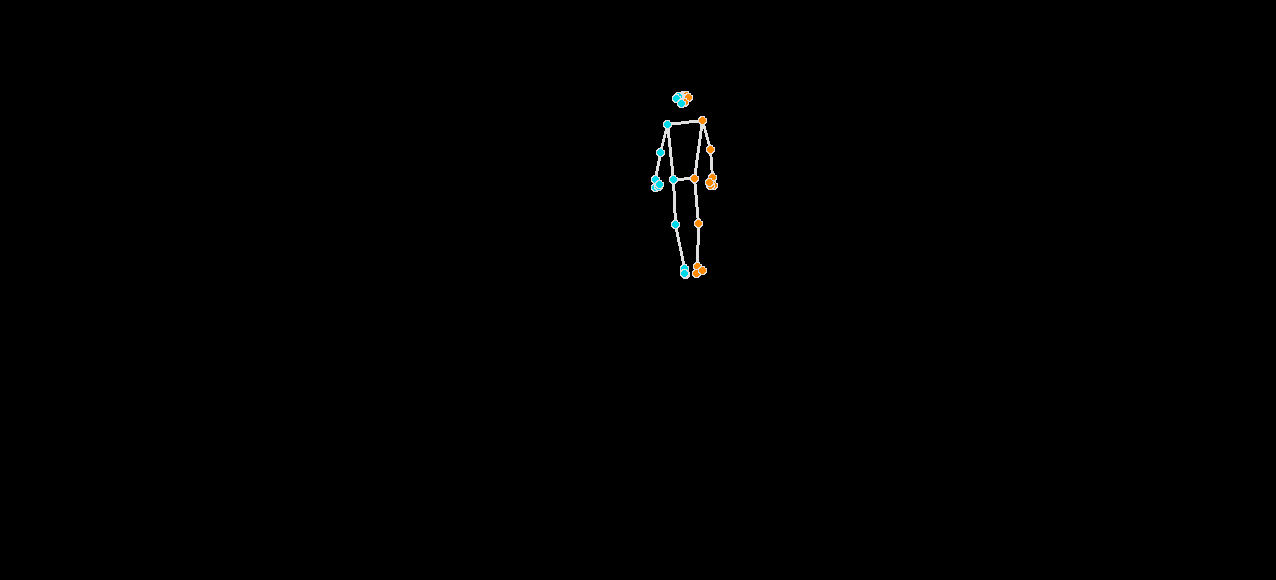

580 1276 3


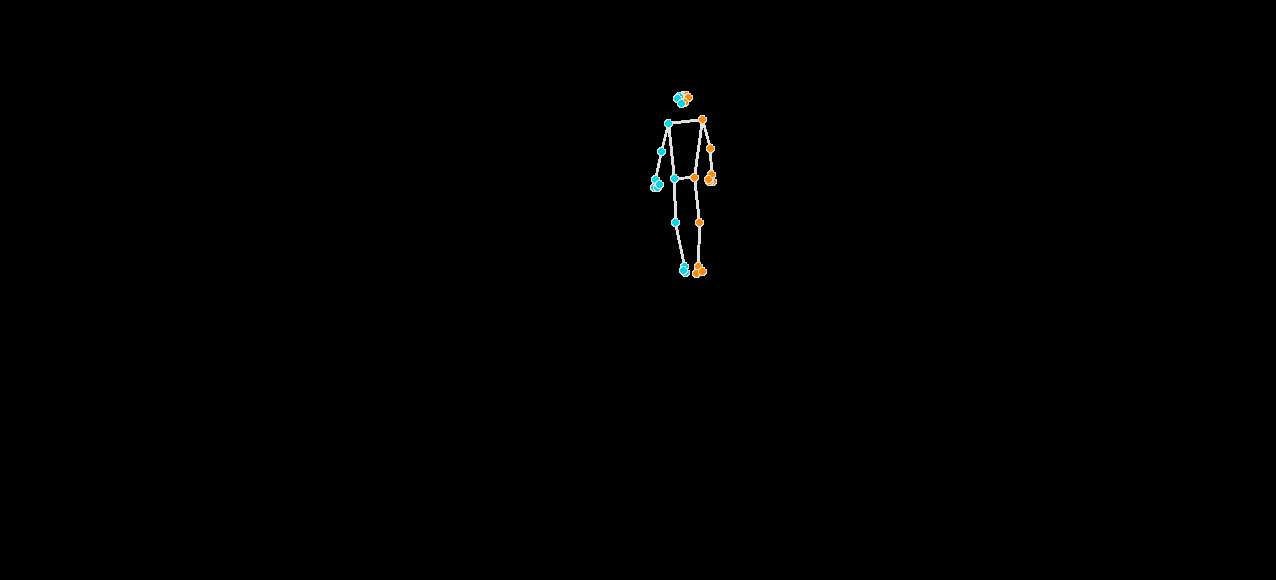

580 1276 3


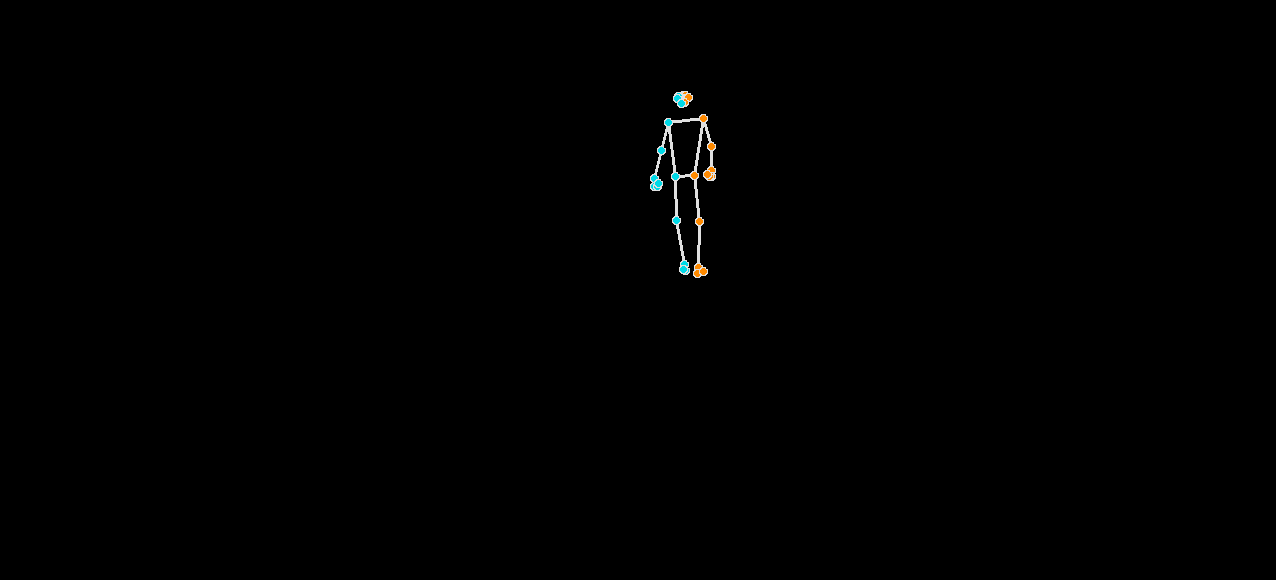

580 1276 3


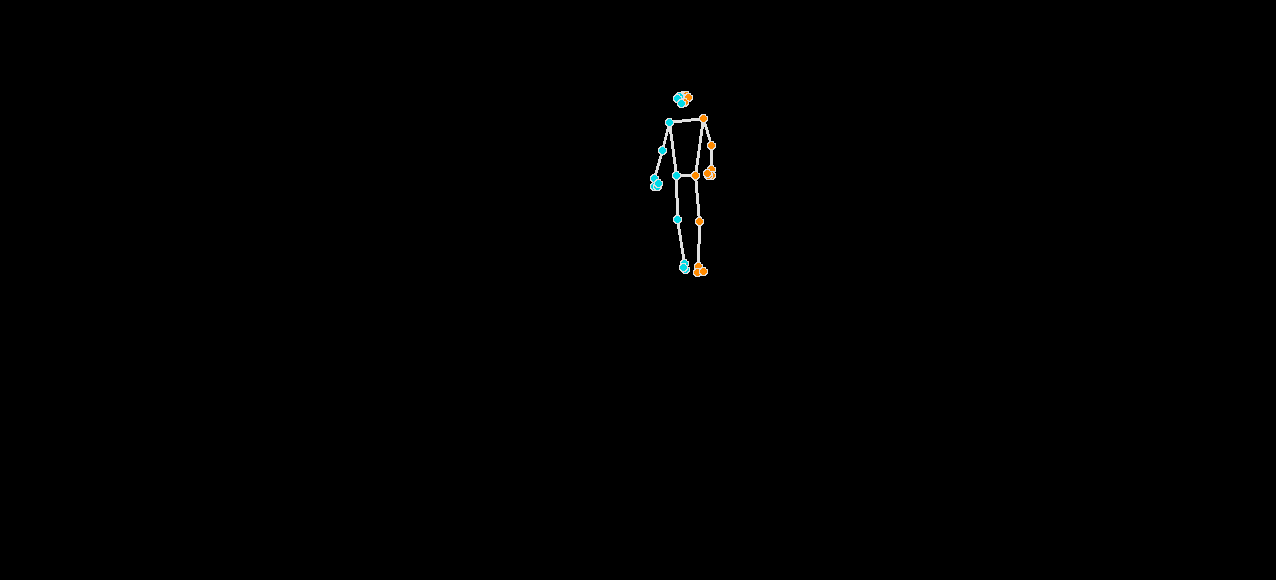

580 1276 3


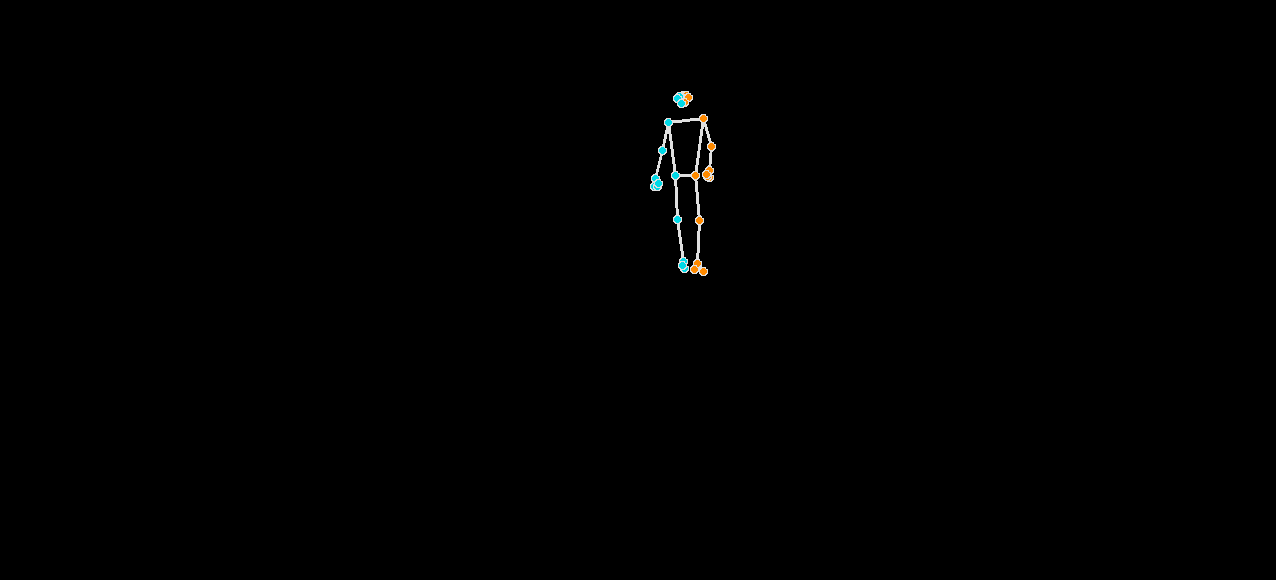

580 1276 3


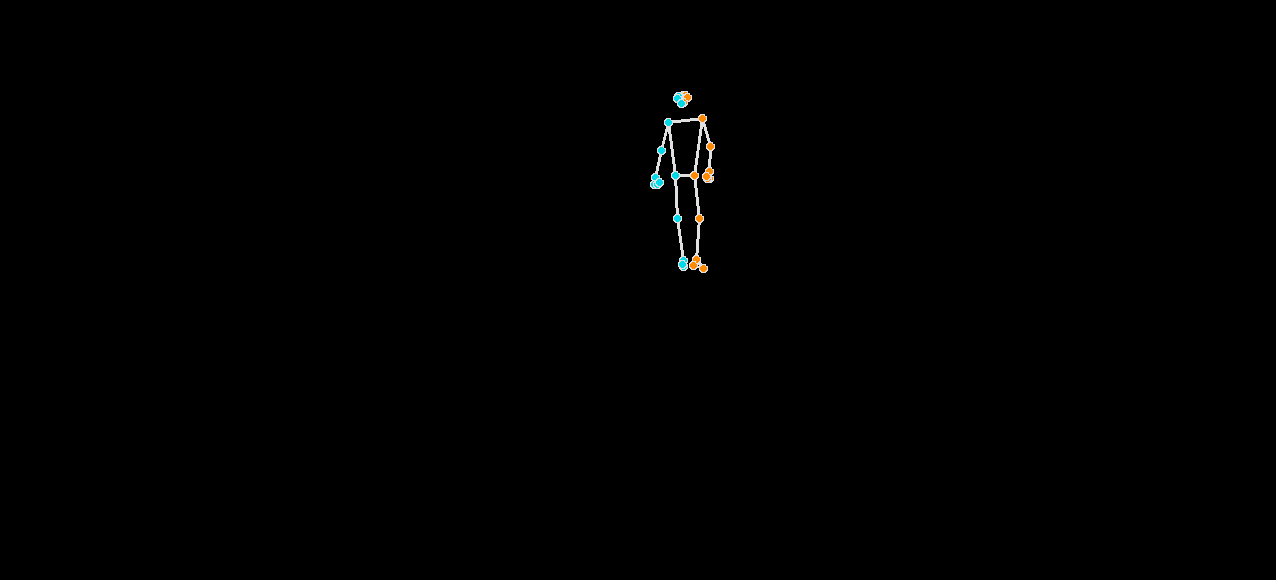

580 1276 3


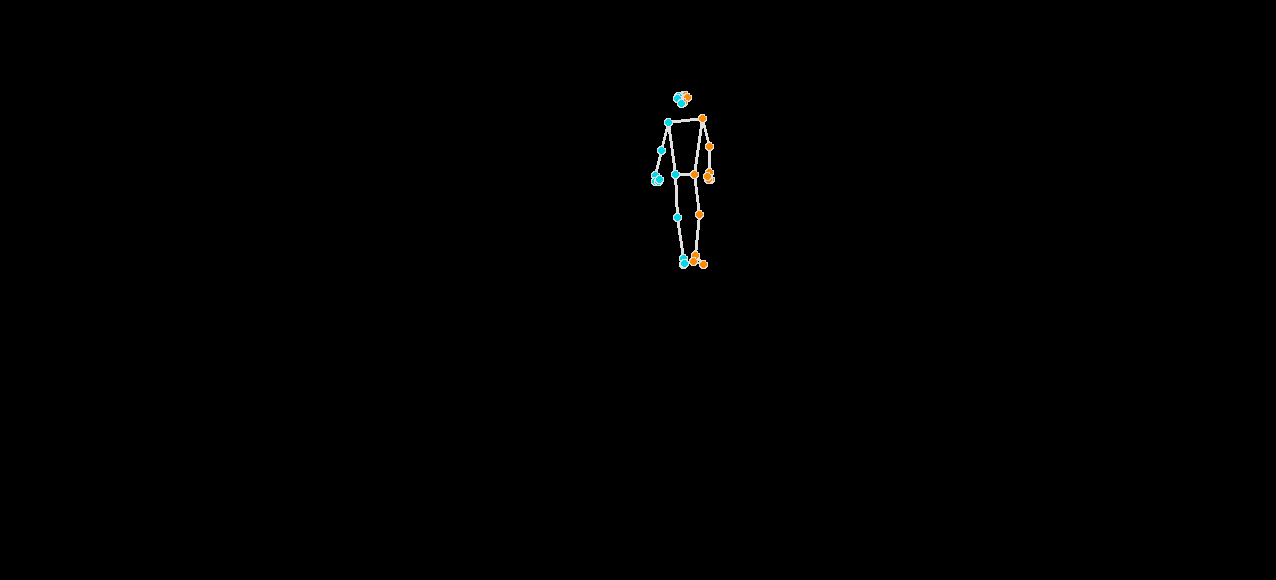

580 1276 3


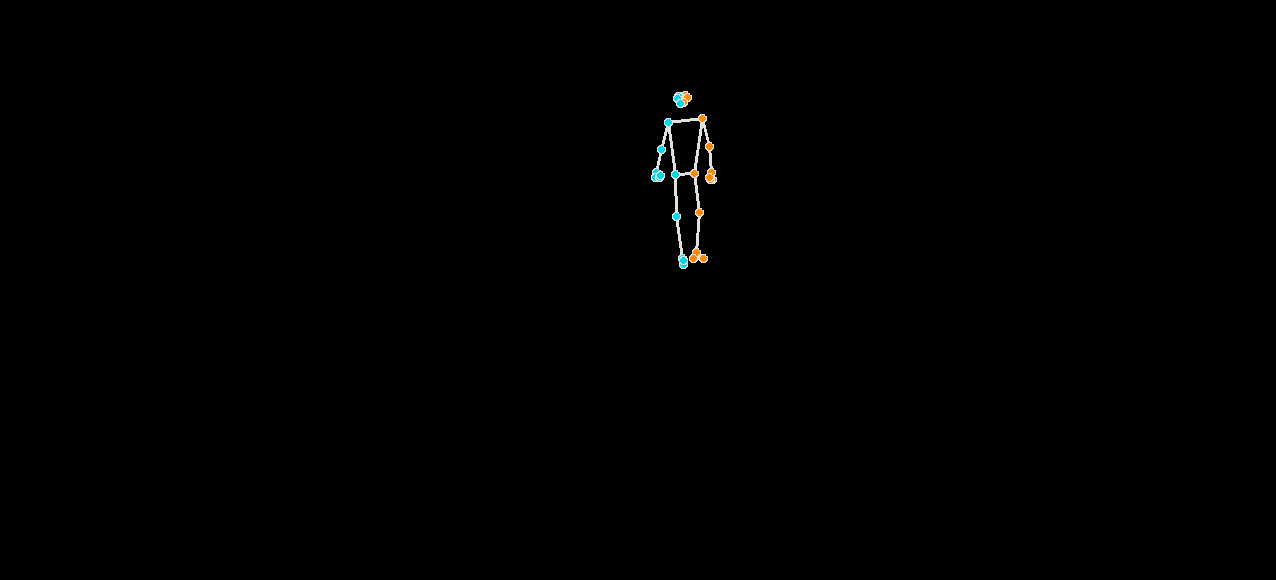

580 1276 3


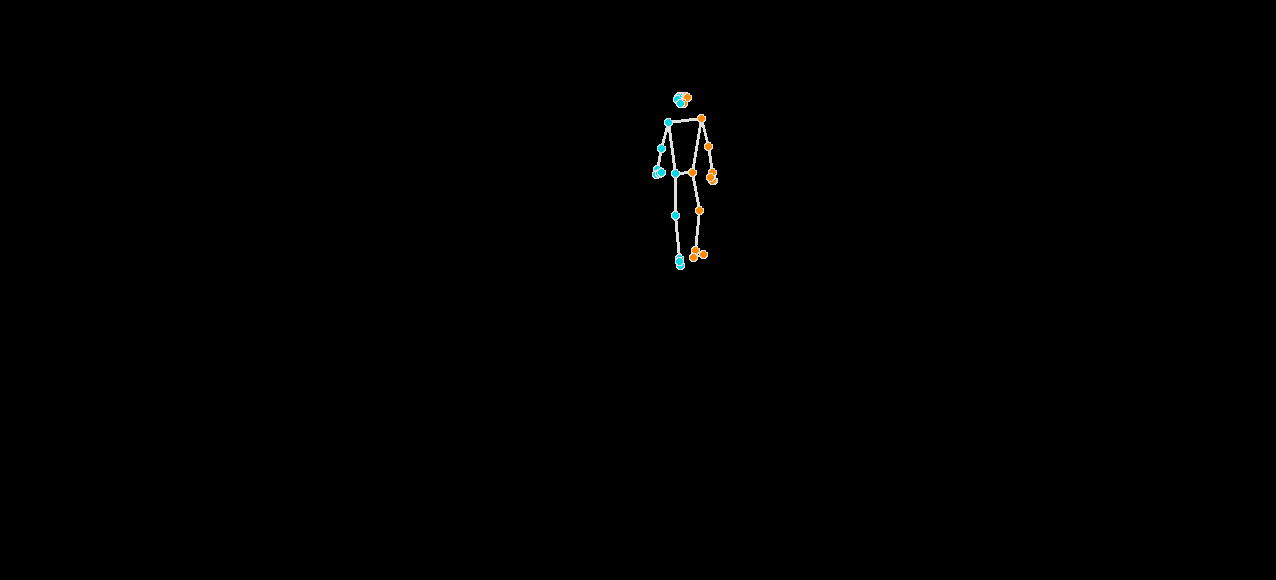

580 1276 3


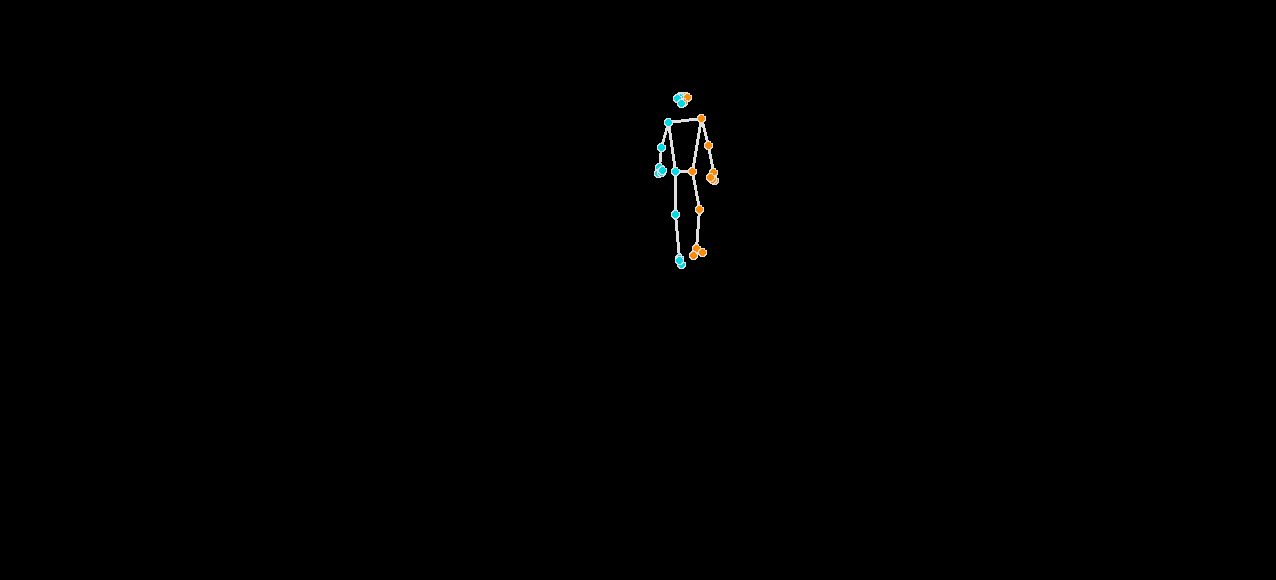

580 1276 3


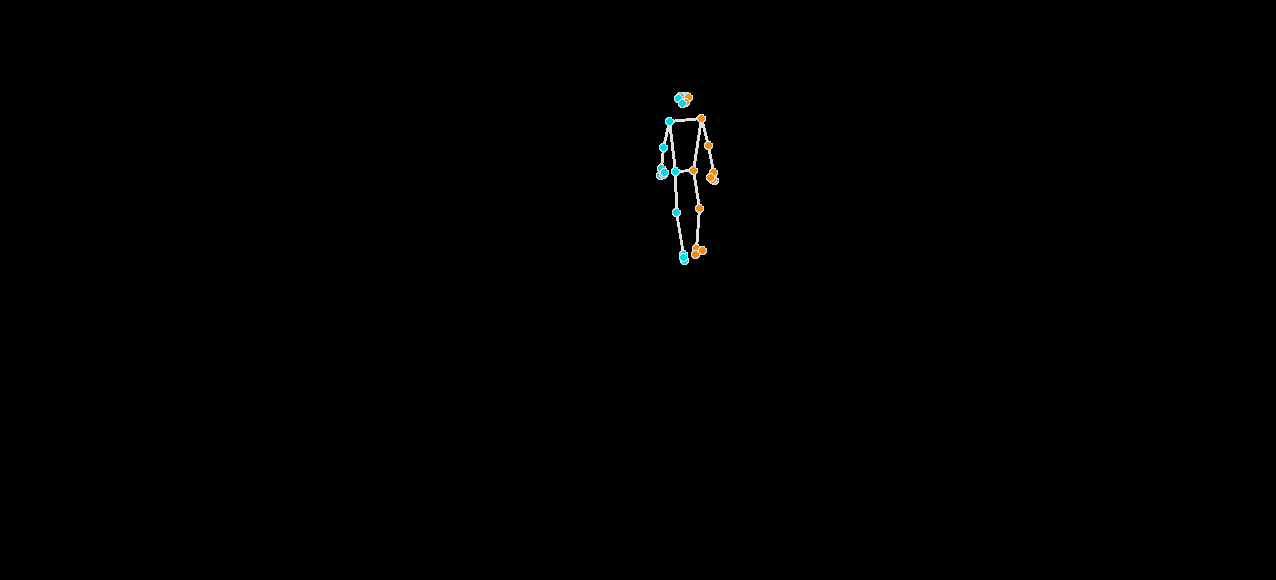

580 1276 3


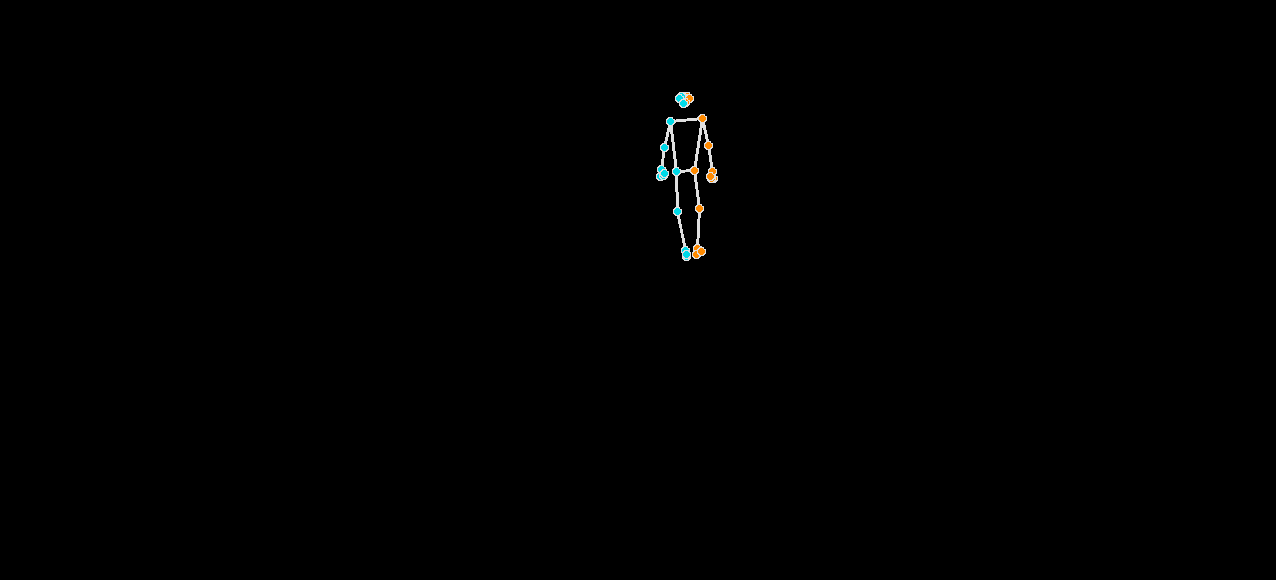

580 1276 3


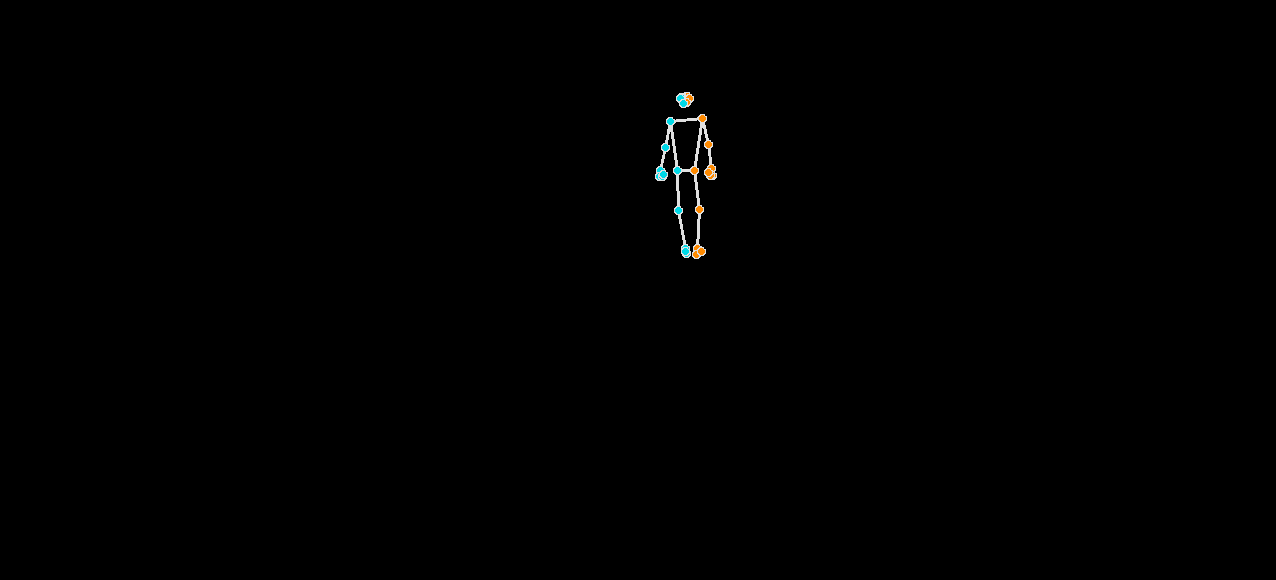

580 1276 3


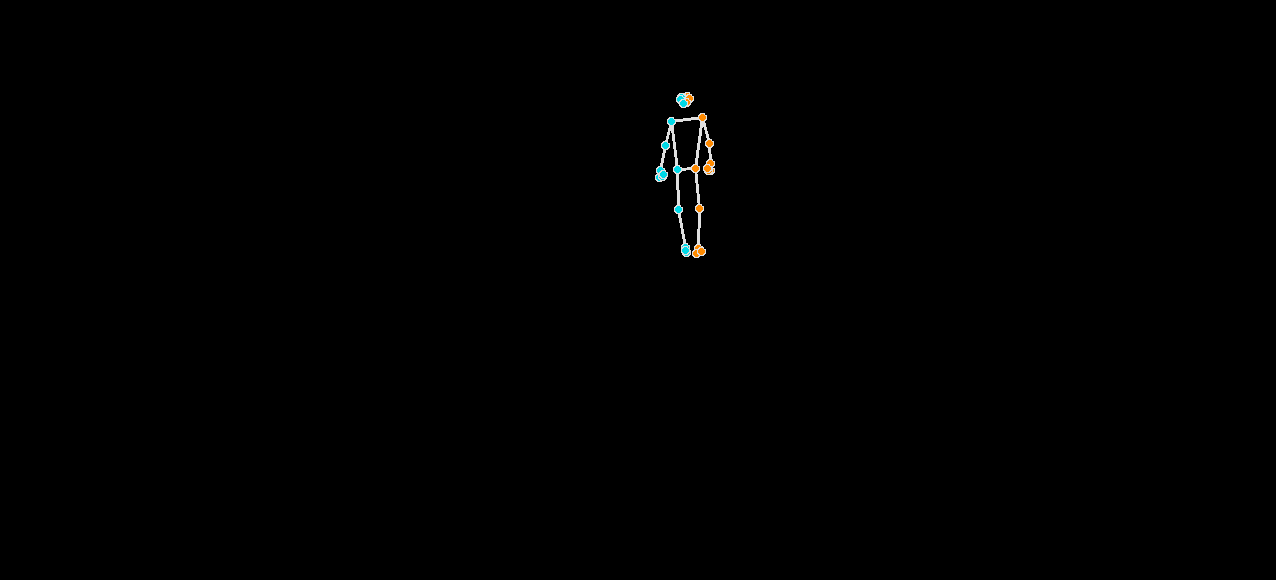

580 1276 3


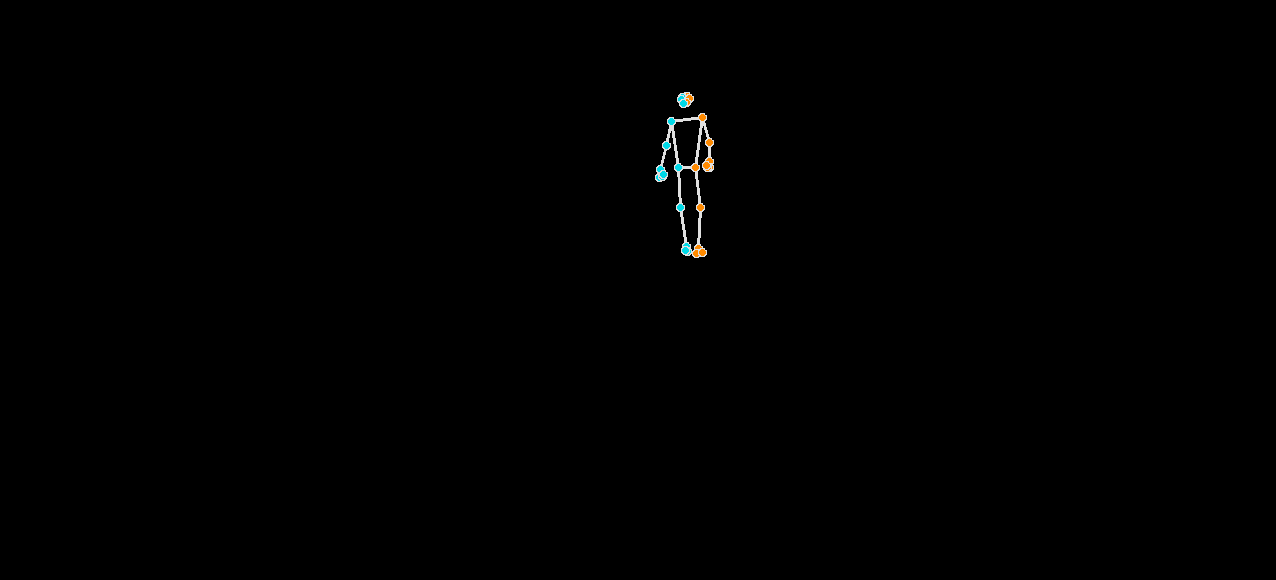

580 1276 3


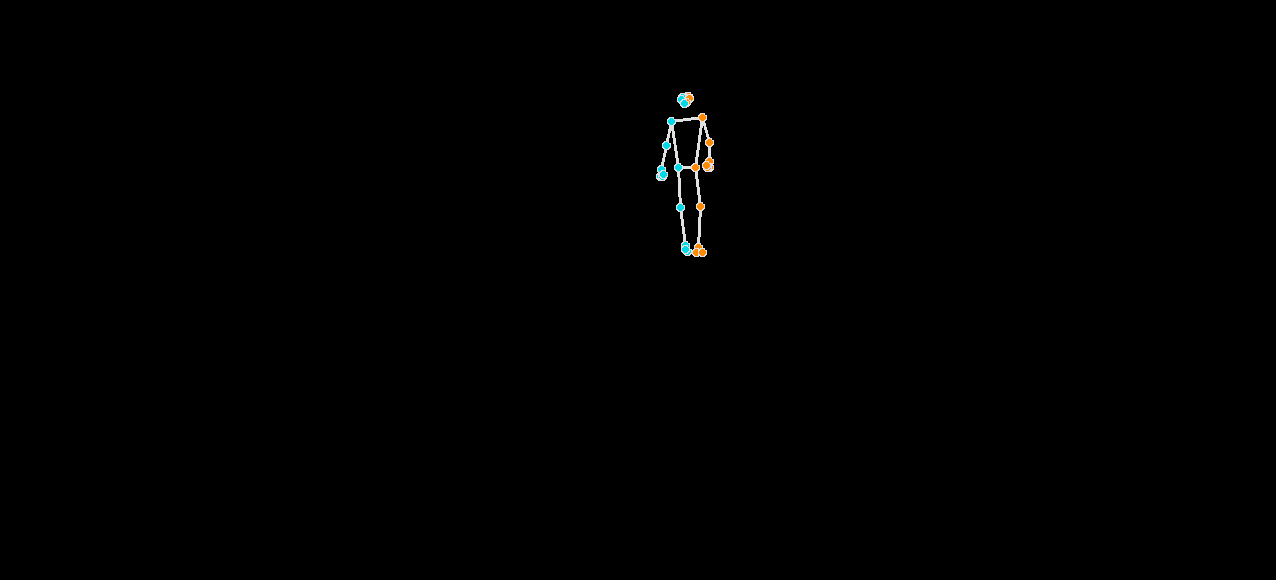

580 1276 3


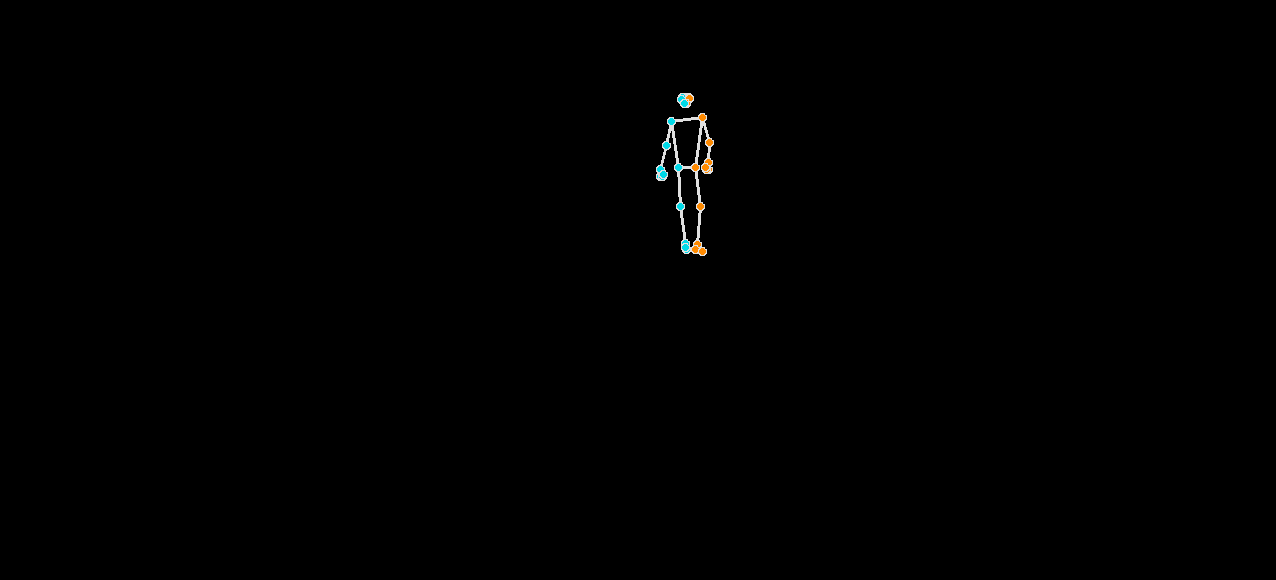

580 1276 3


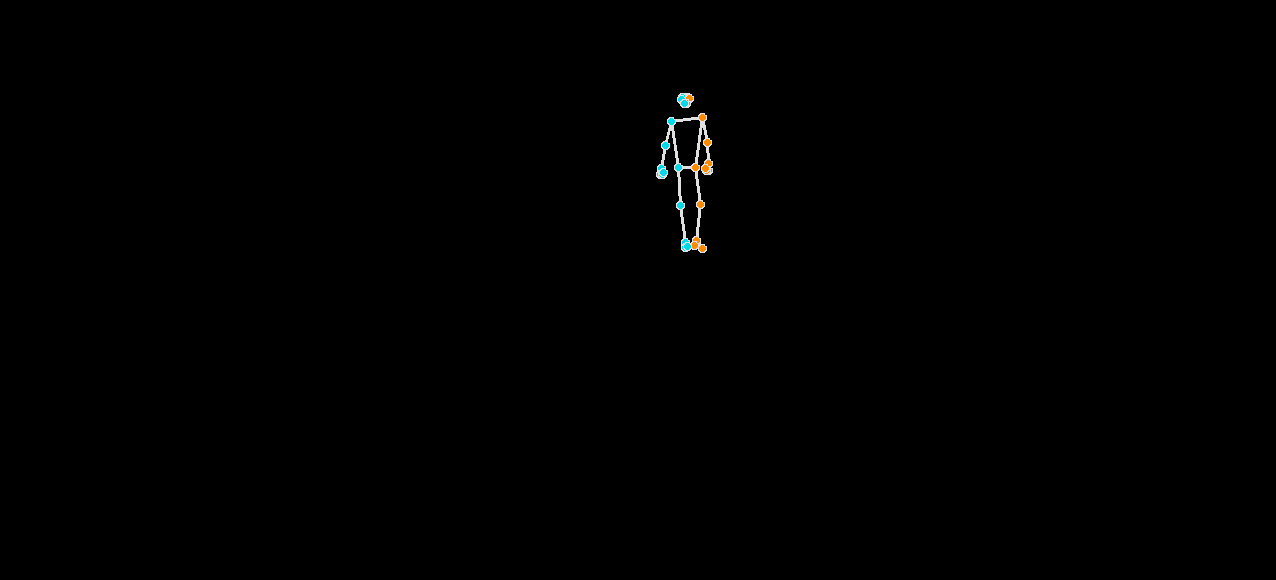

580 1276 3


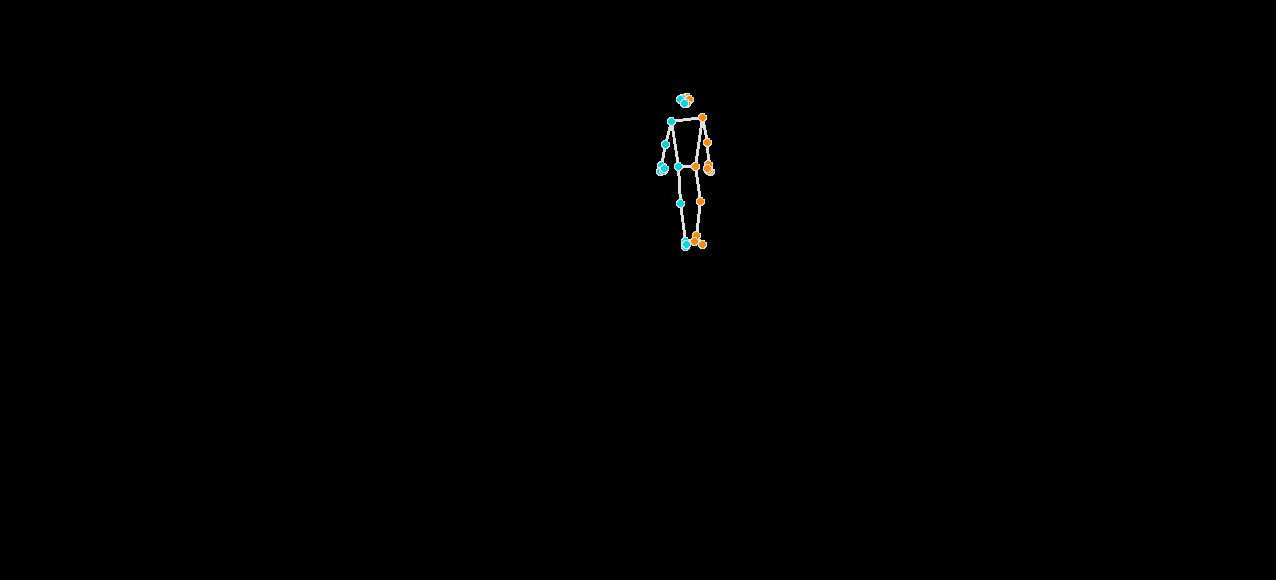

580 1276 3


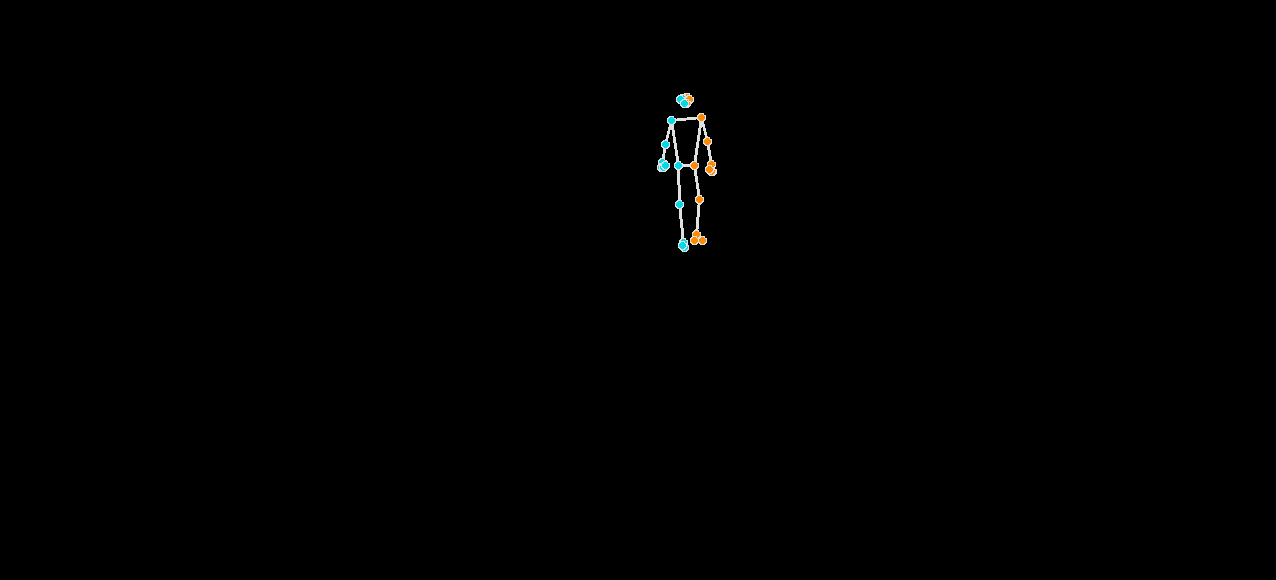

580 1276 3


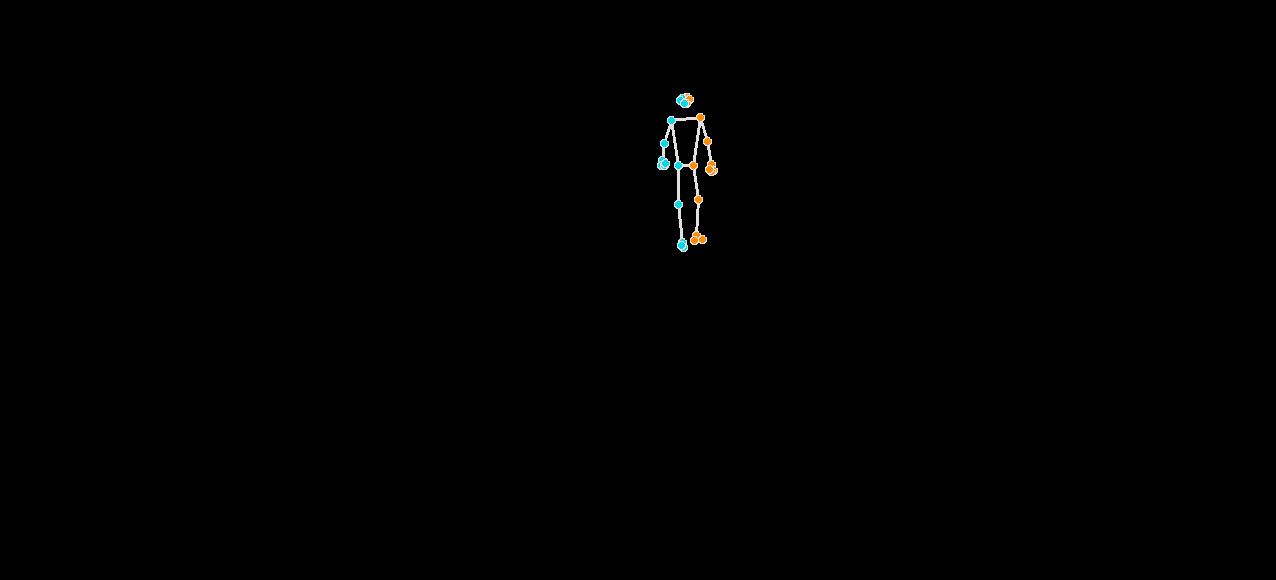

580 1276 3


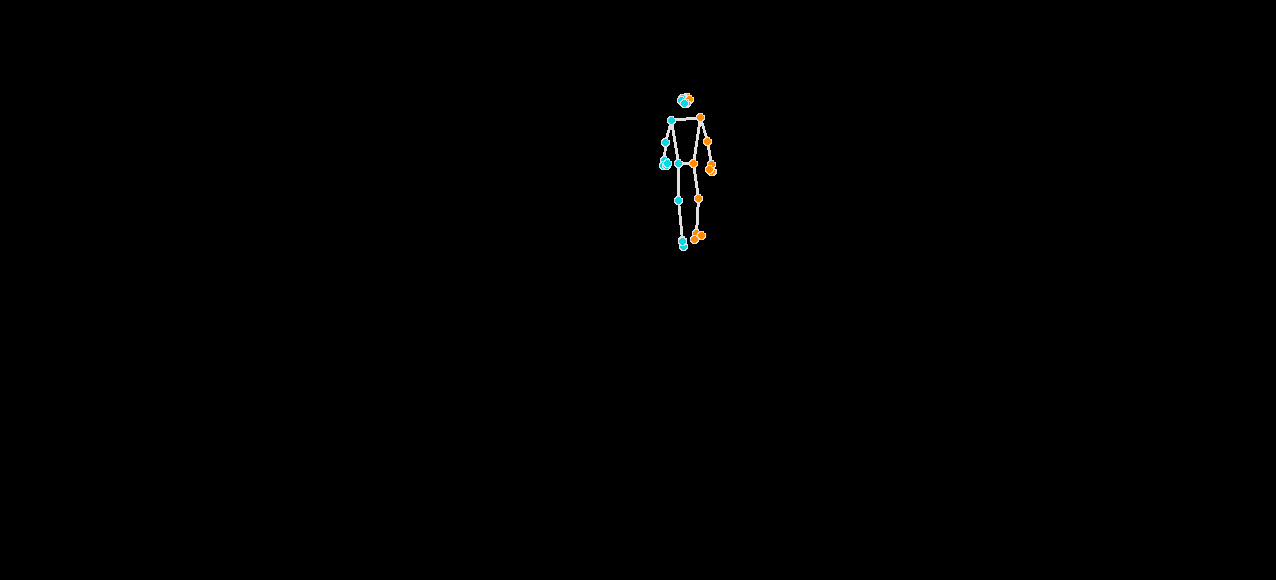

580 1276 3


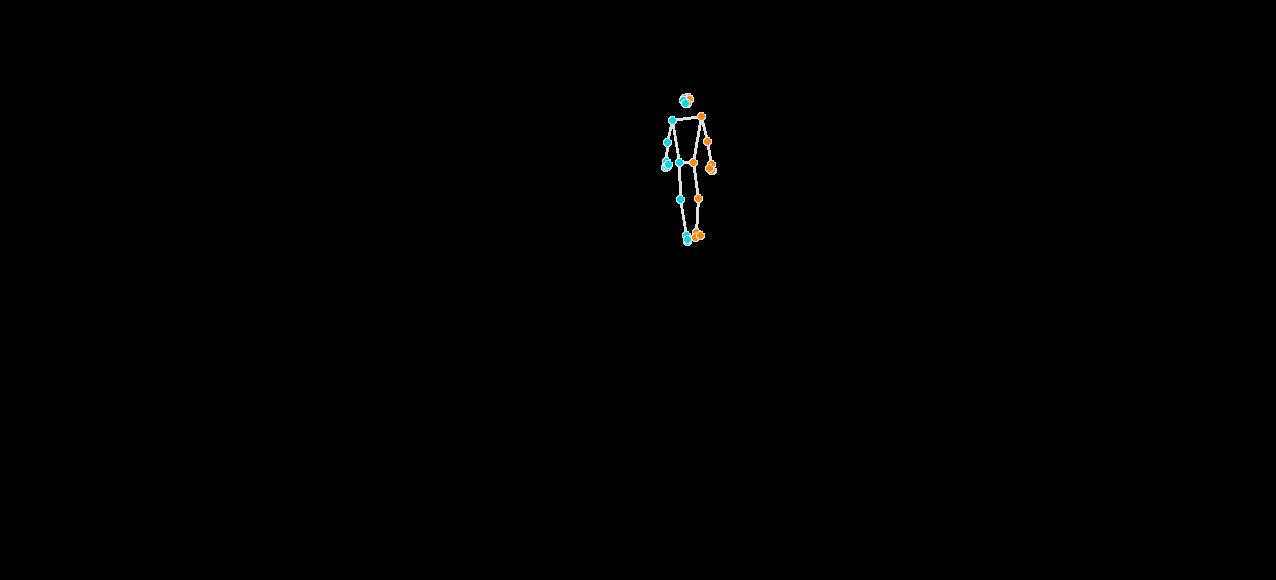

580 1276 3


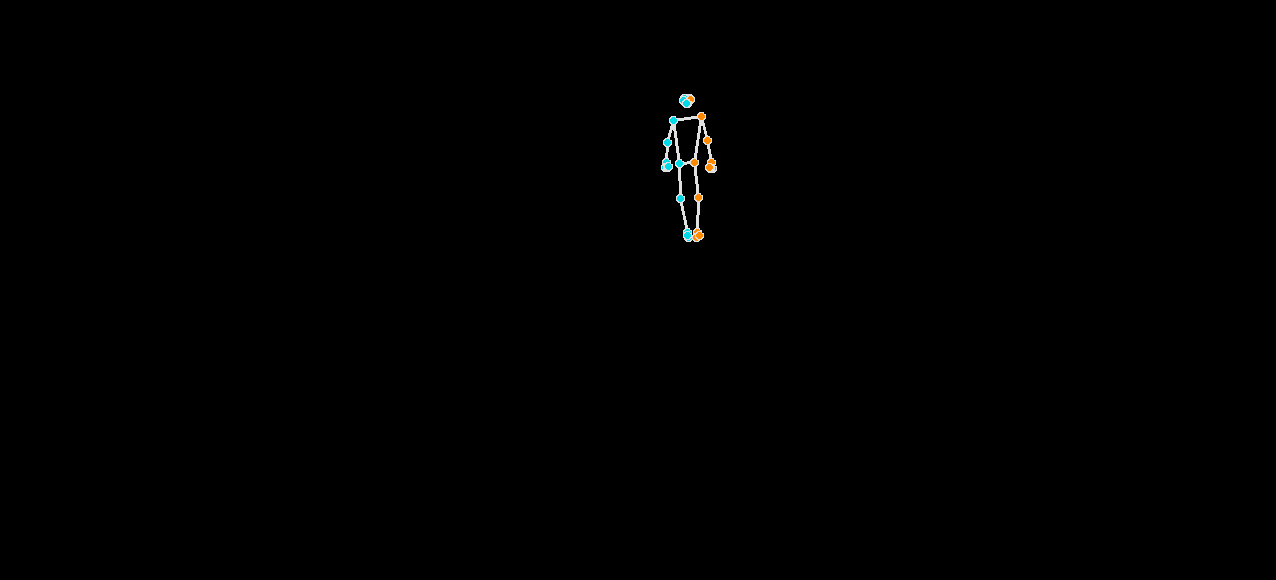

580 1276 3


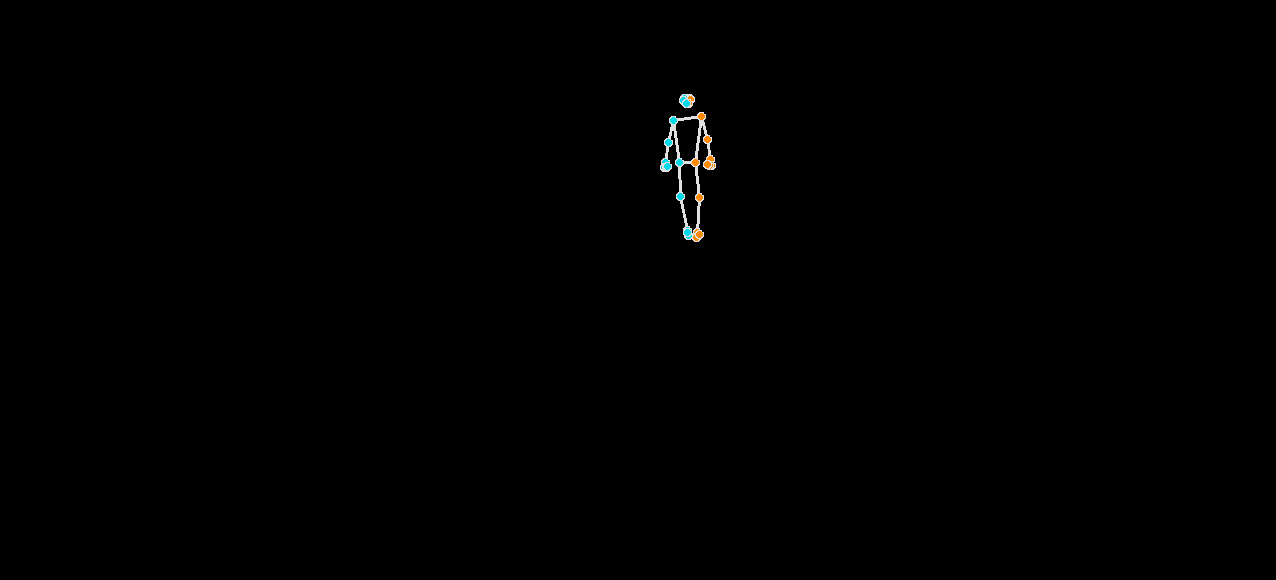

580 1276 3


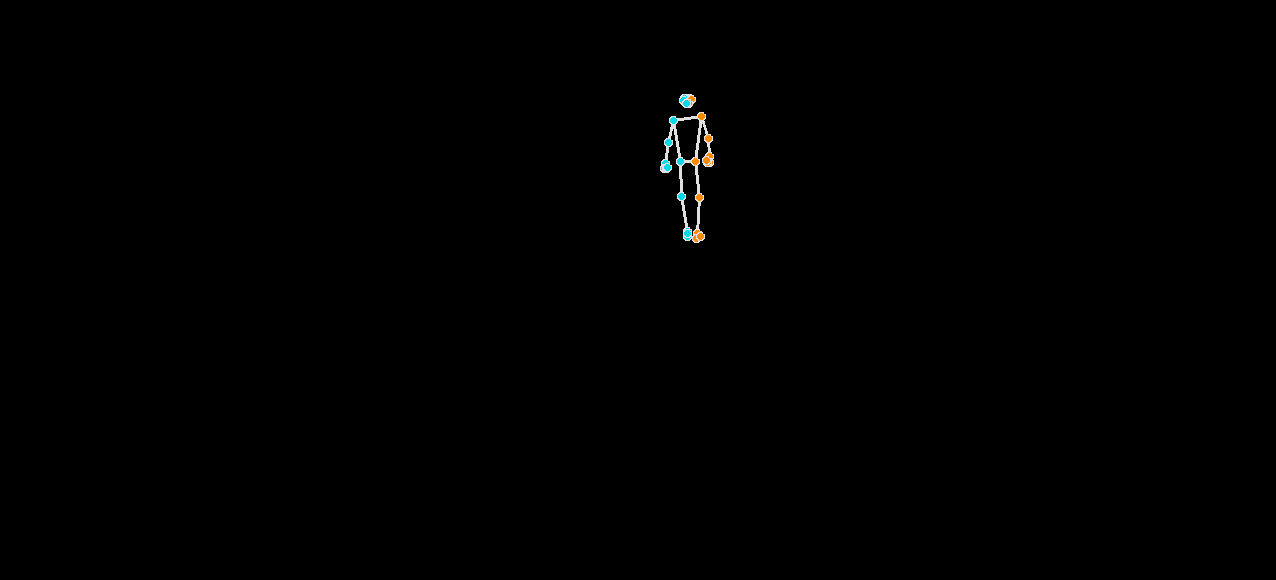

580 1276 3


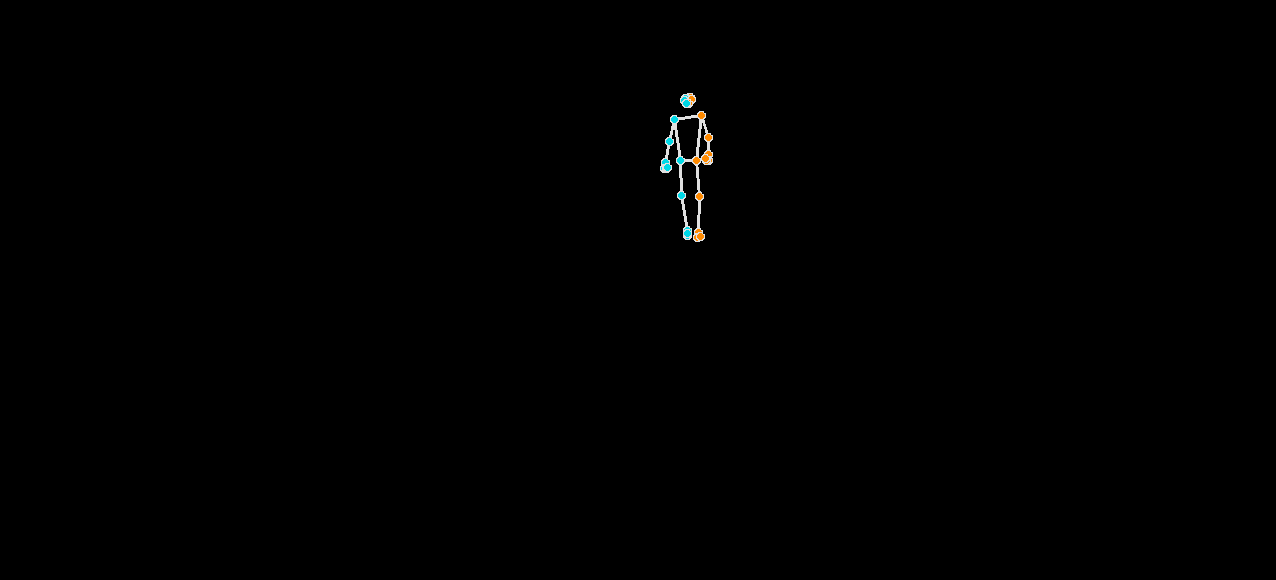

580 1276 3


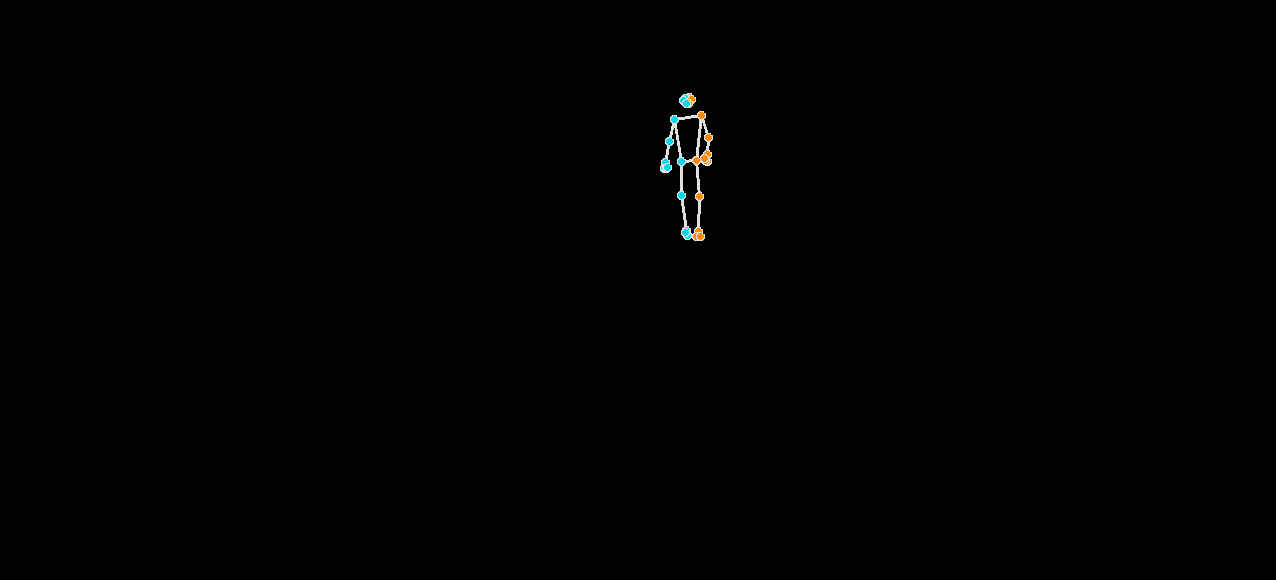

580 1276 3


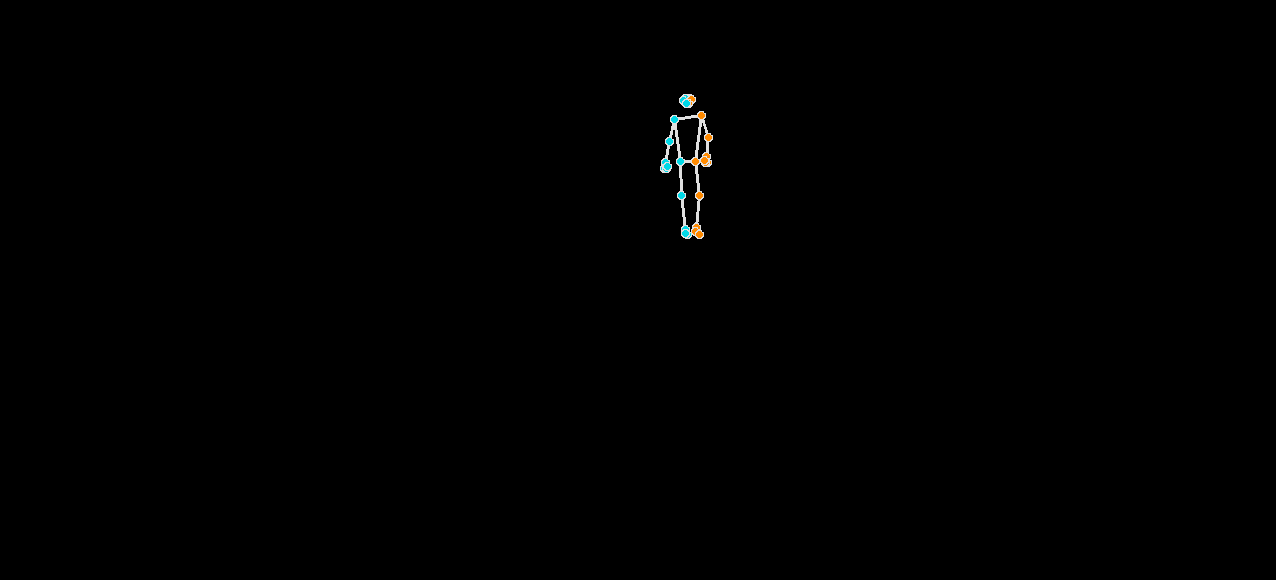

580 1276 3


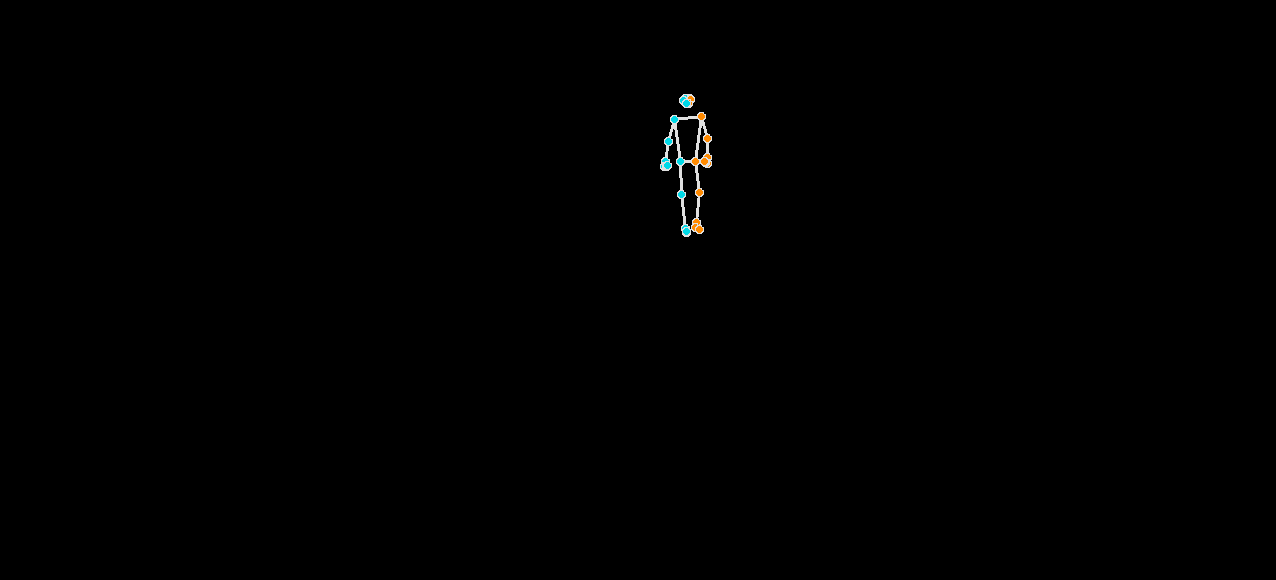

580 1276 3


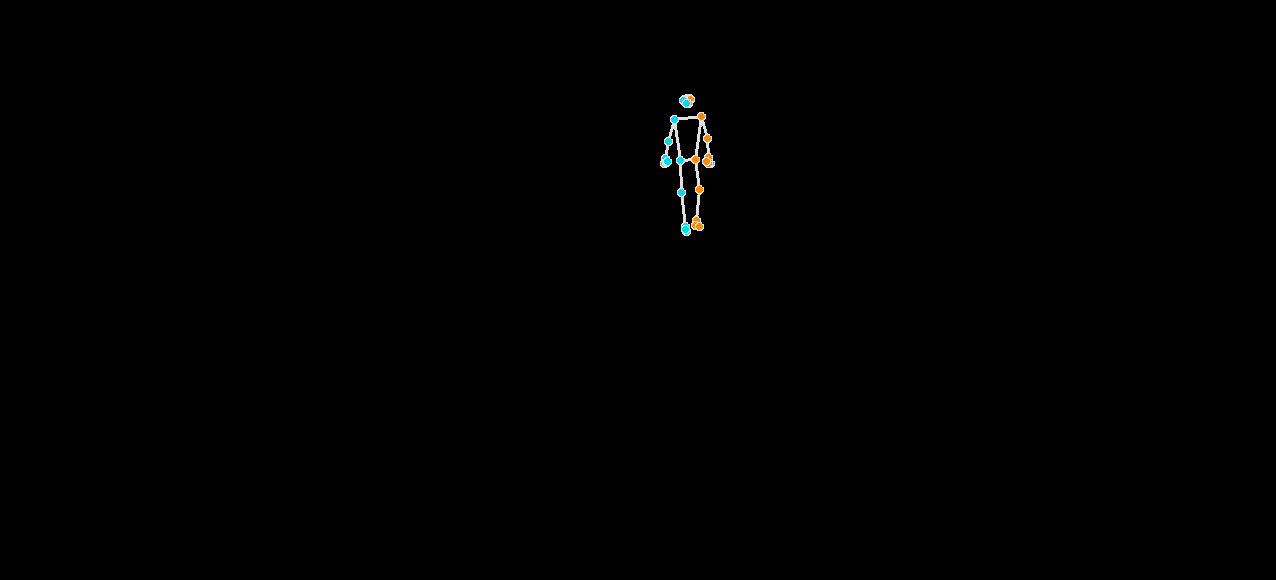

580 1276 3


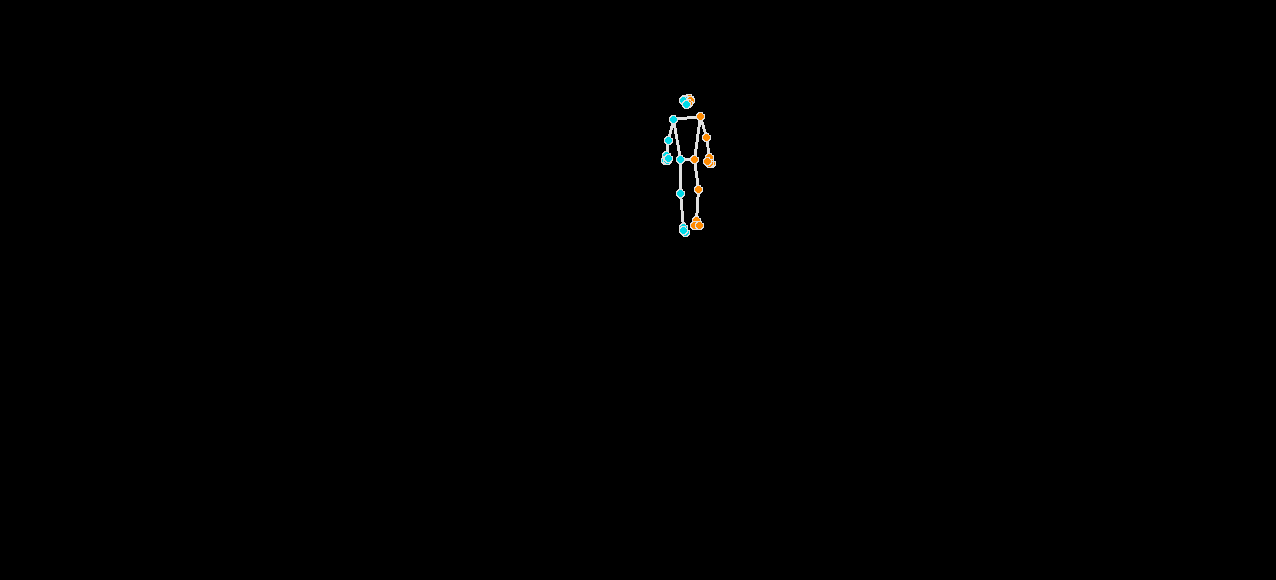

580 1276 3


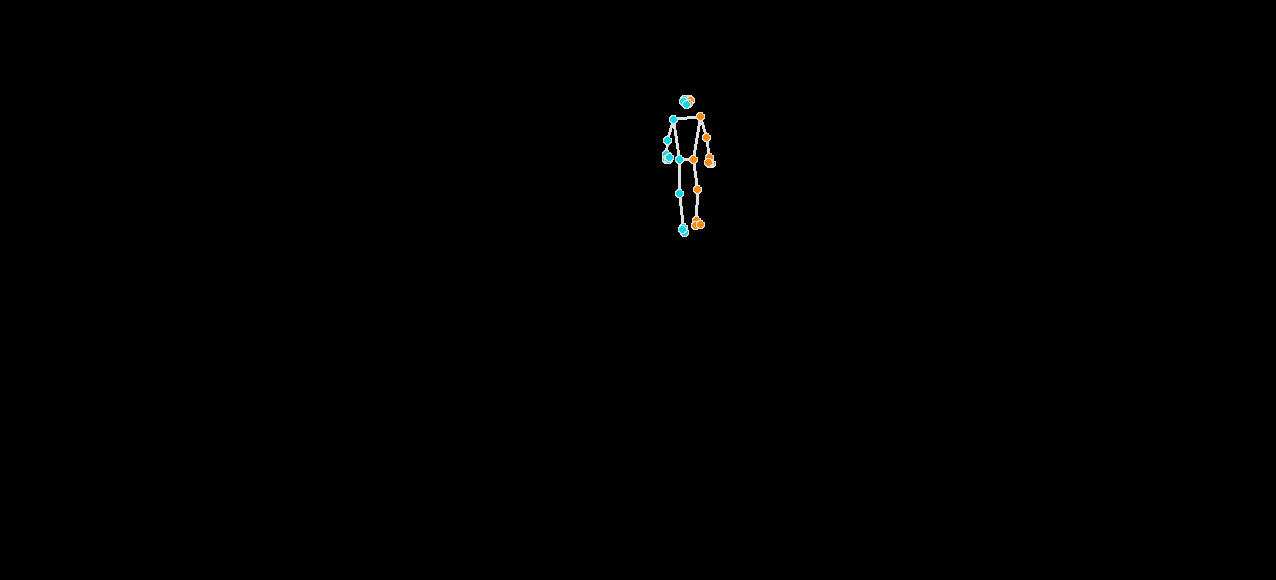

580 1276 3


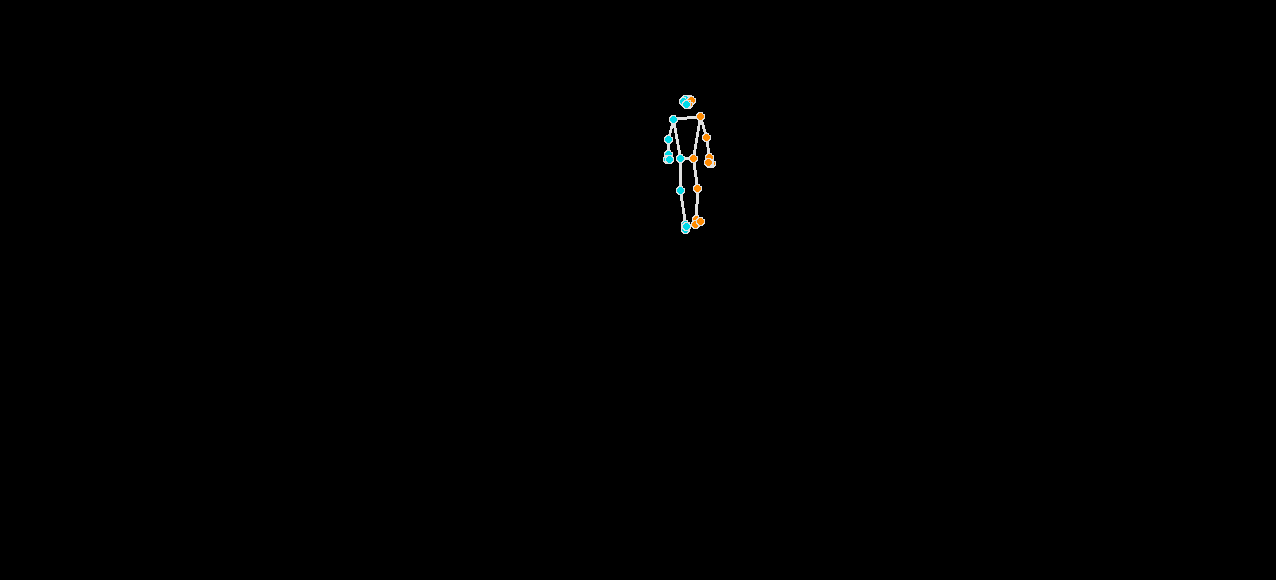

580 1276 3


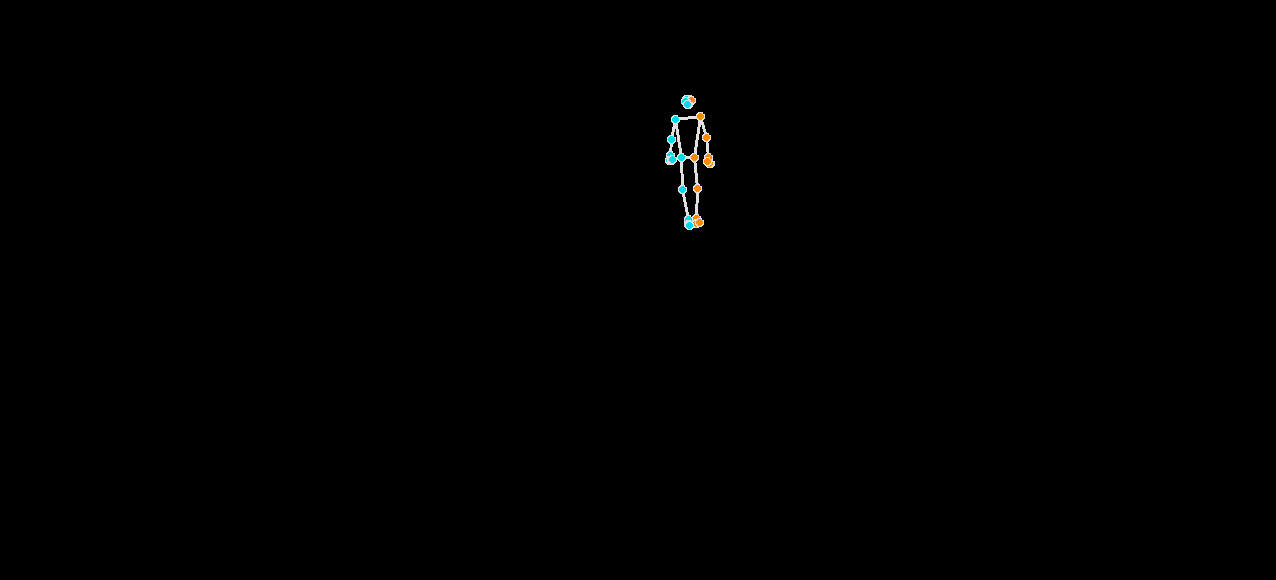

580 1276 3


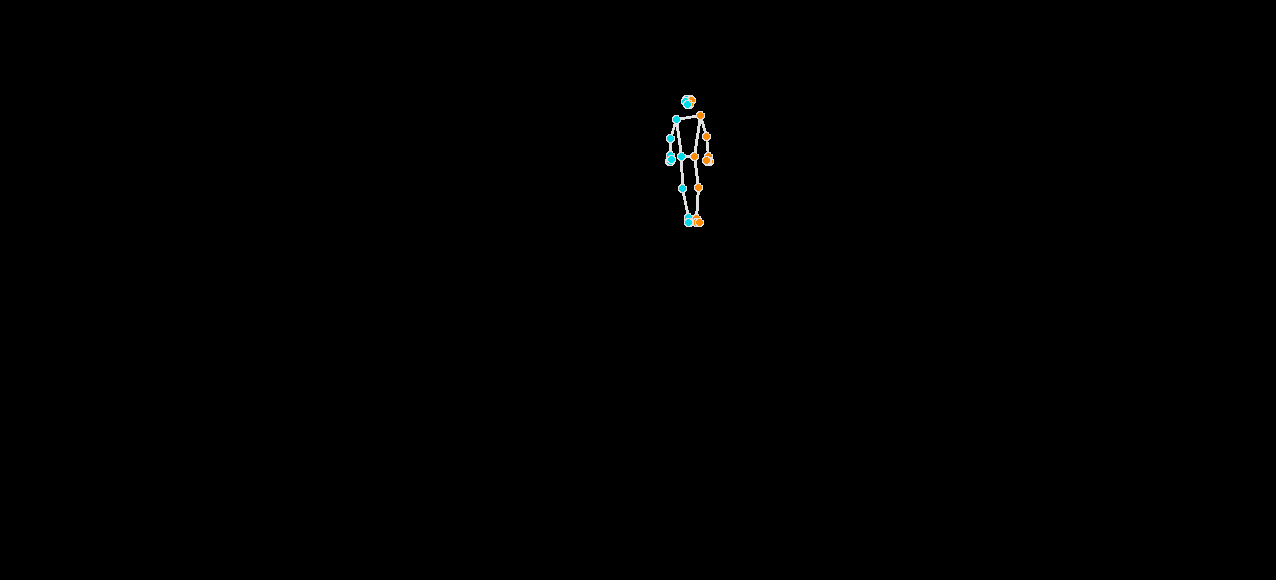

580 1276 3


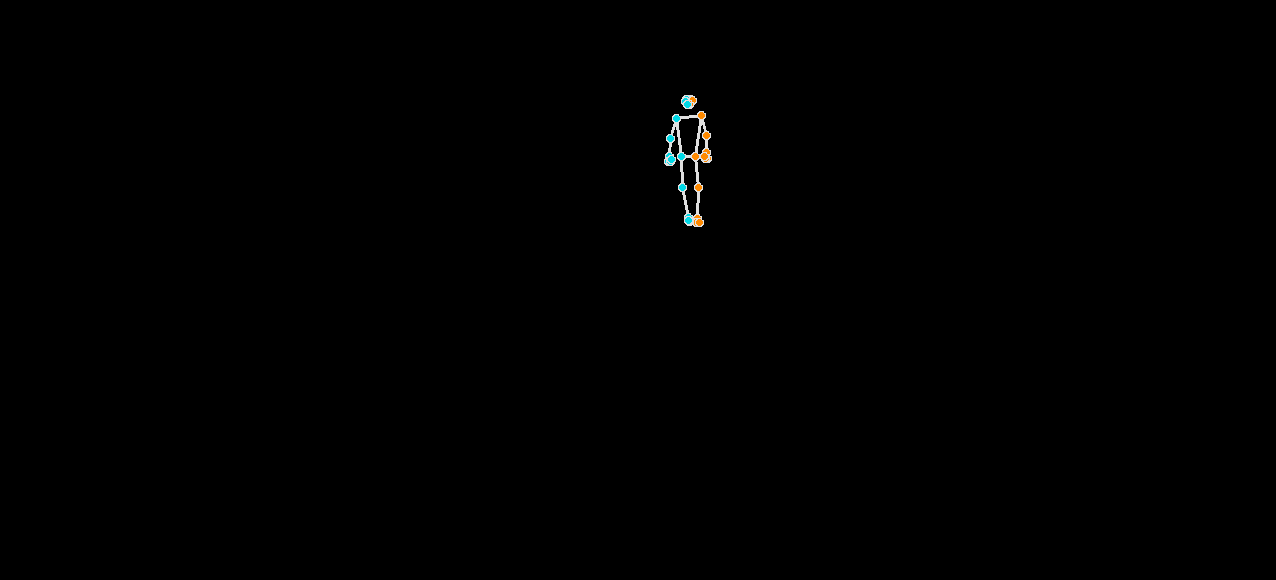

580 1276 3


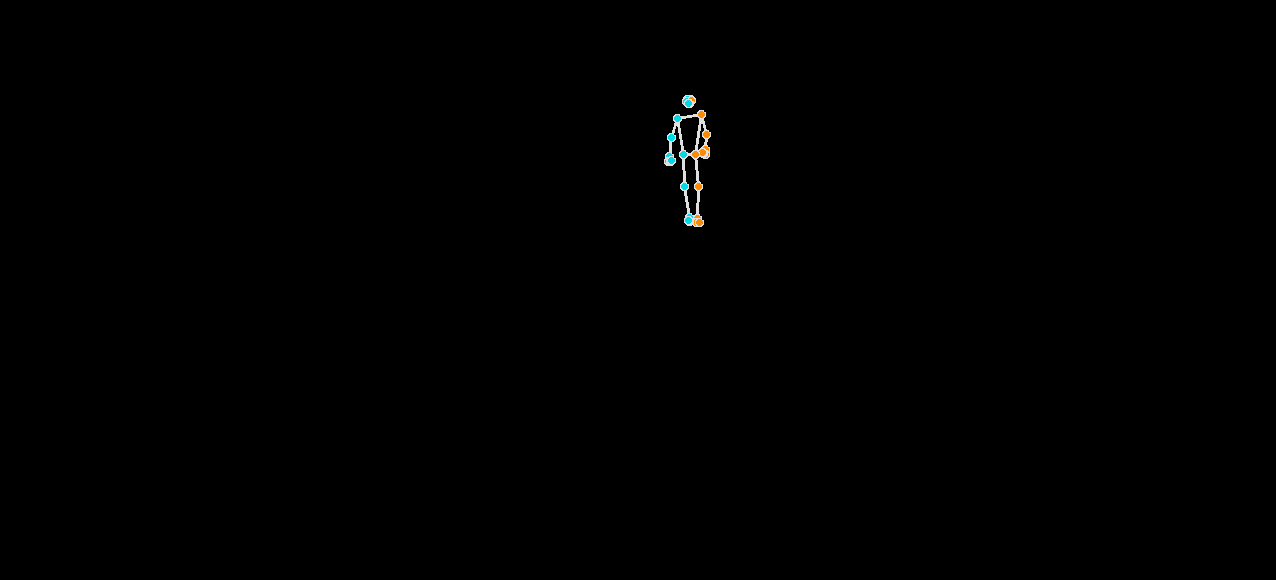

580 1276 3


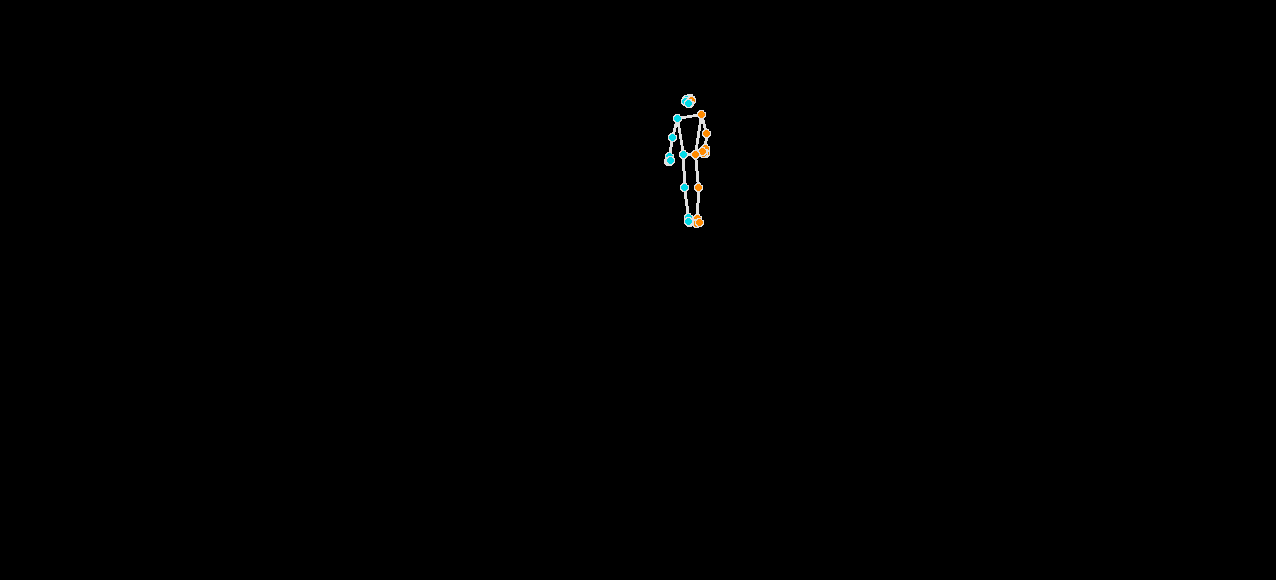

580 1276 3


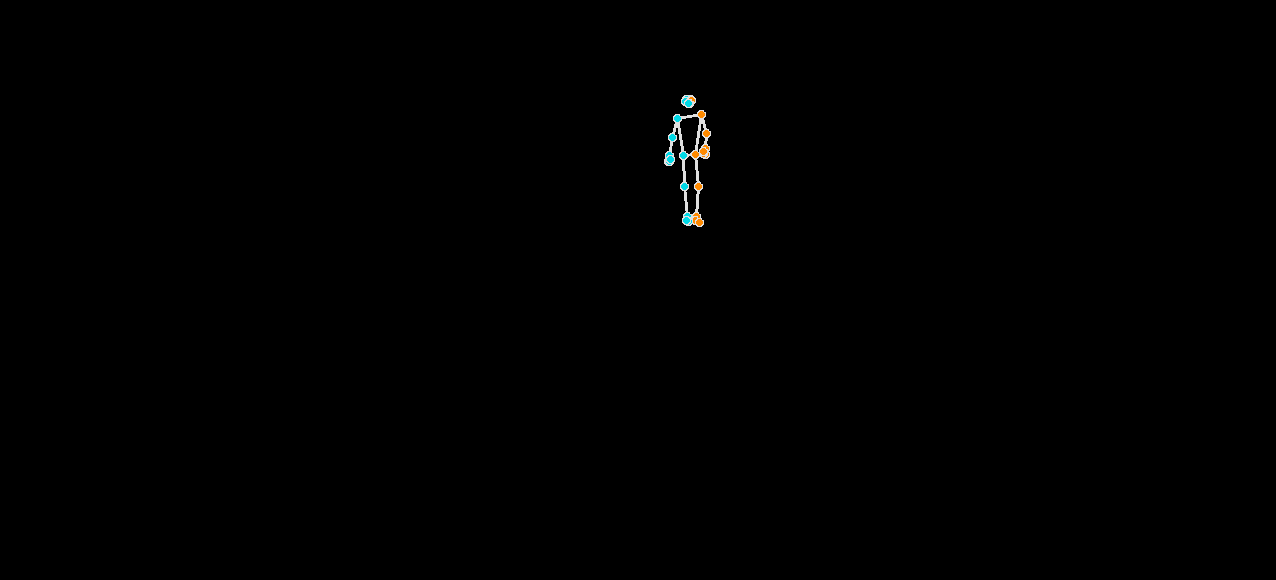

580 1276 3


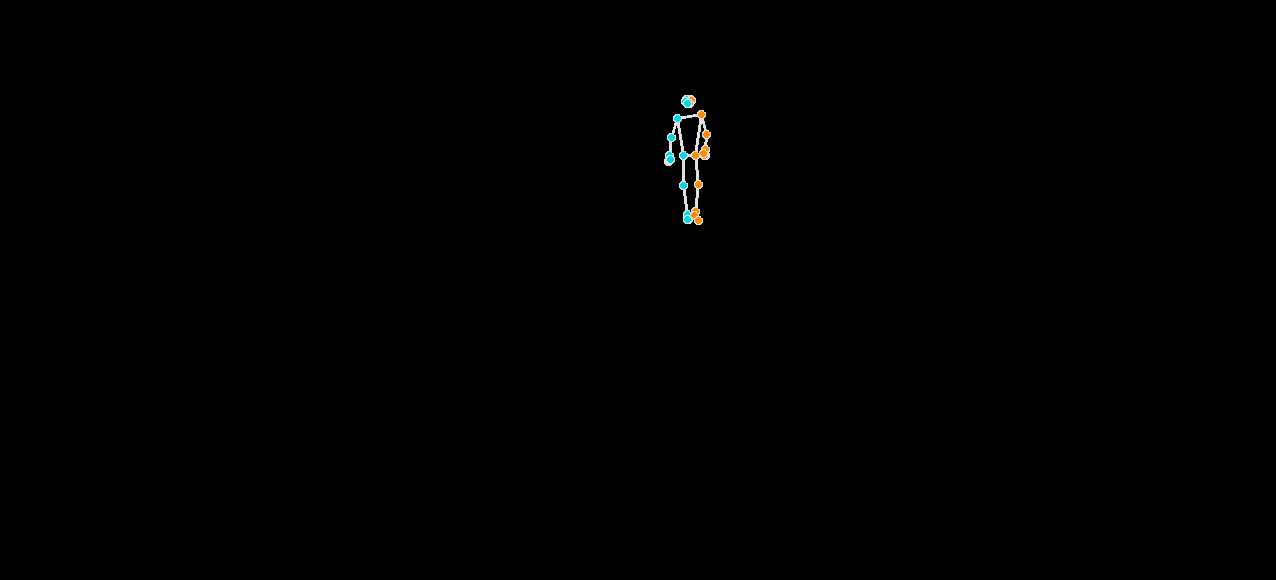

580 1276 3


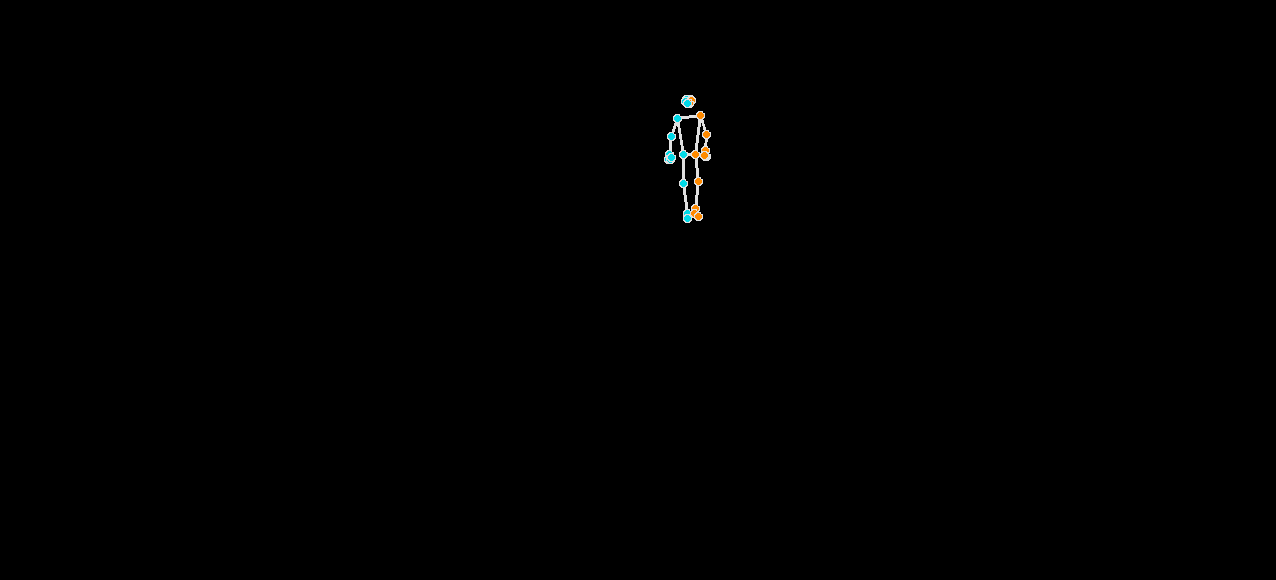

580 1276 3


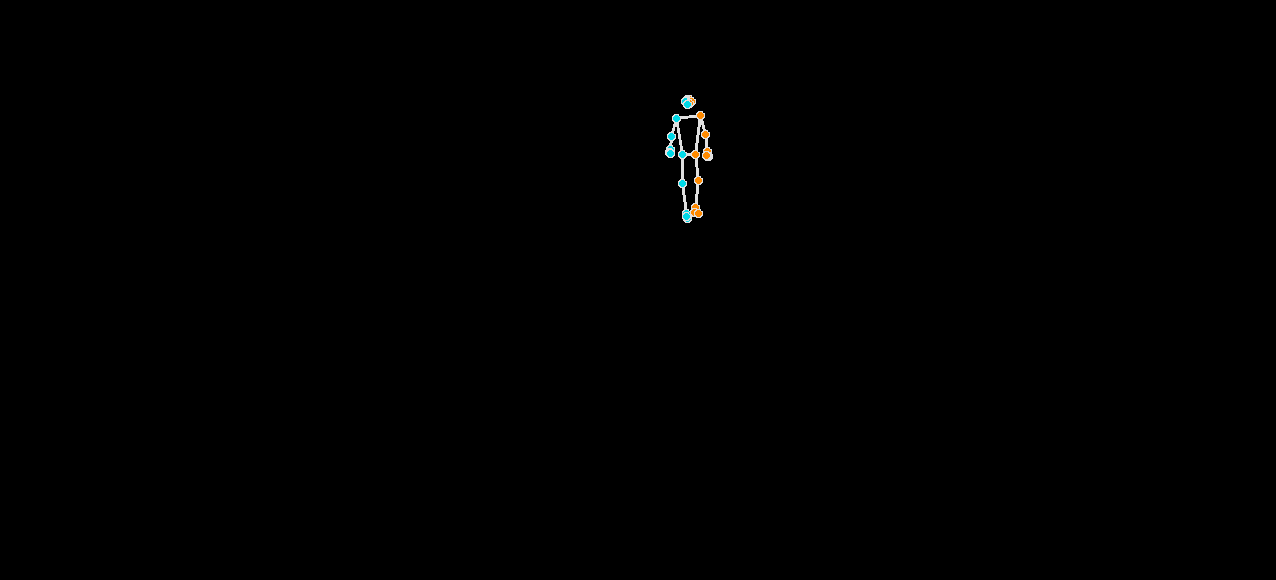

580 1276 3


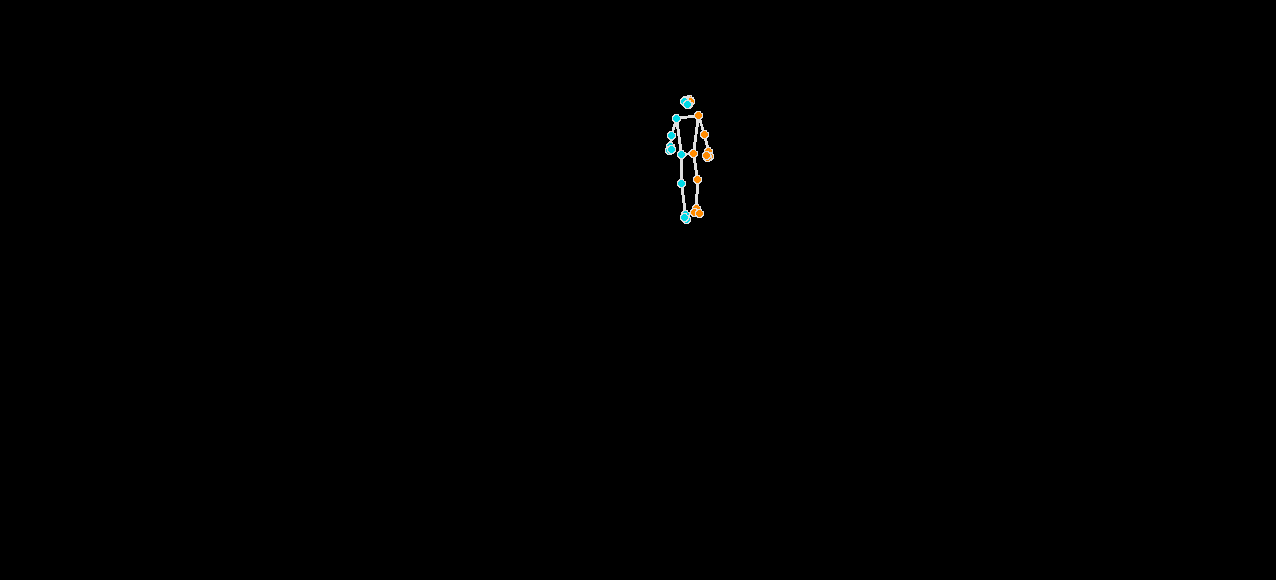

580 1276 3


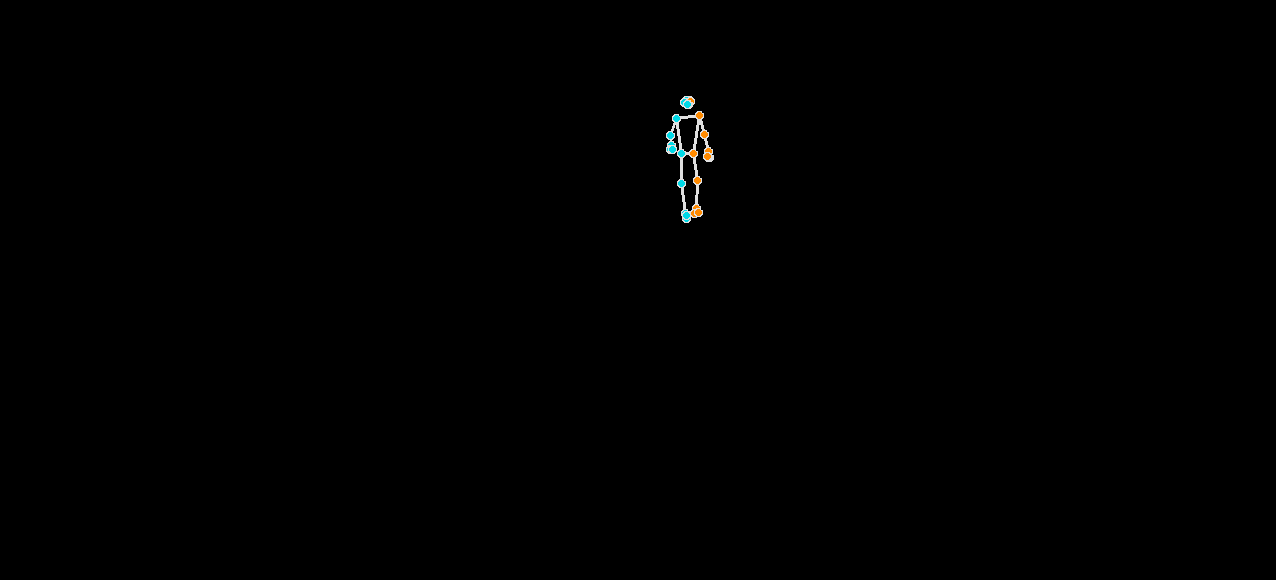

580 1276 3


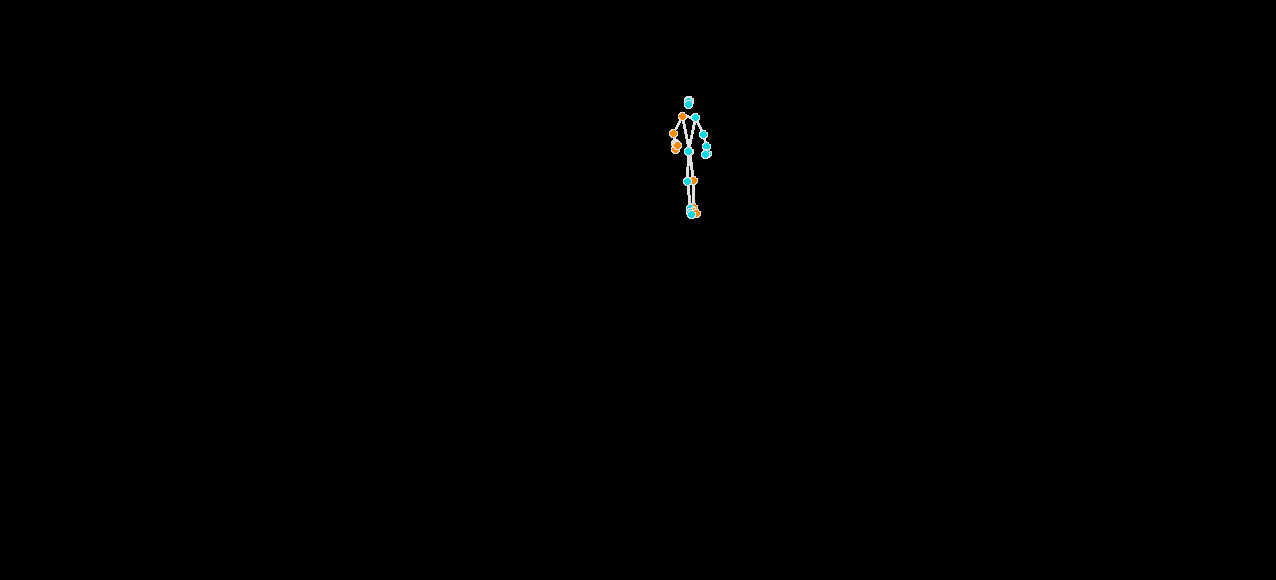

580 1276 3


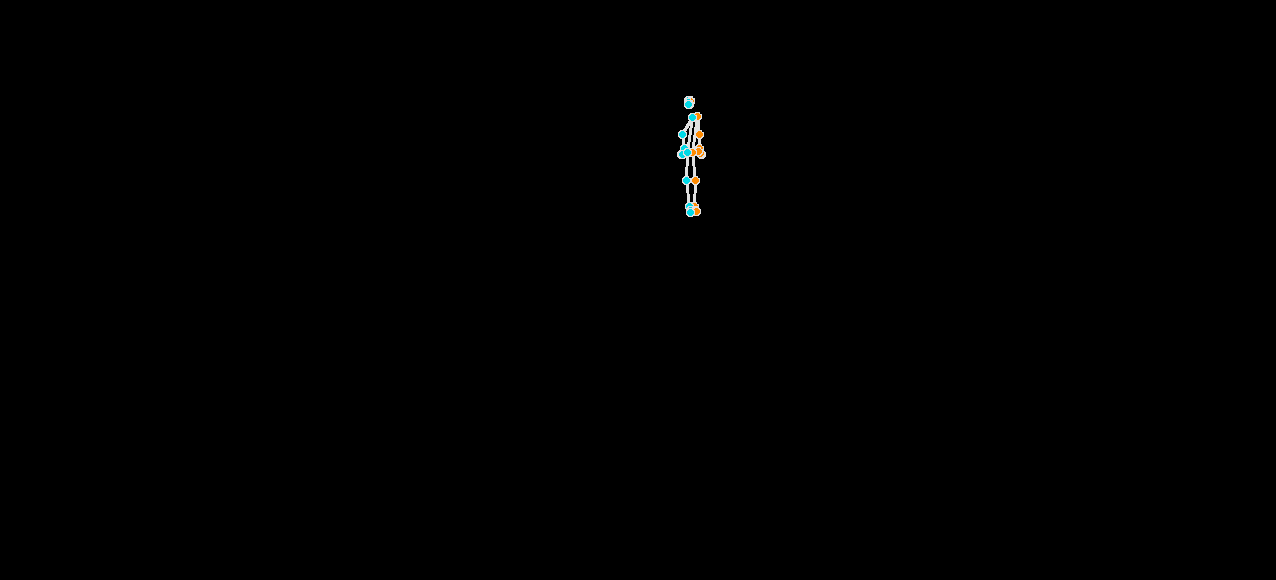

580 1276 3


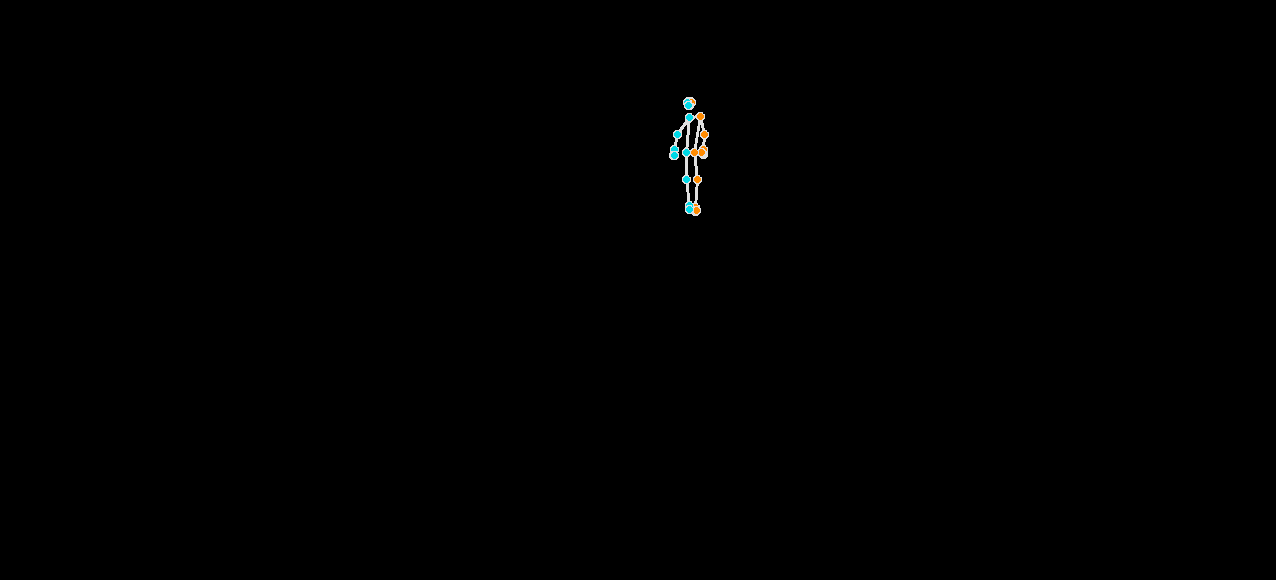

580 1276 3


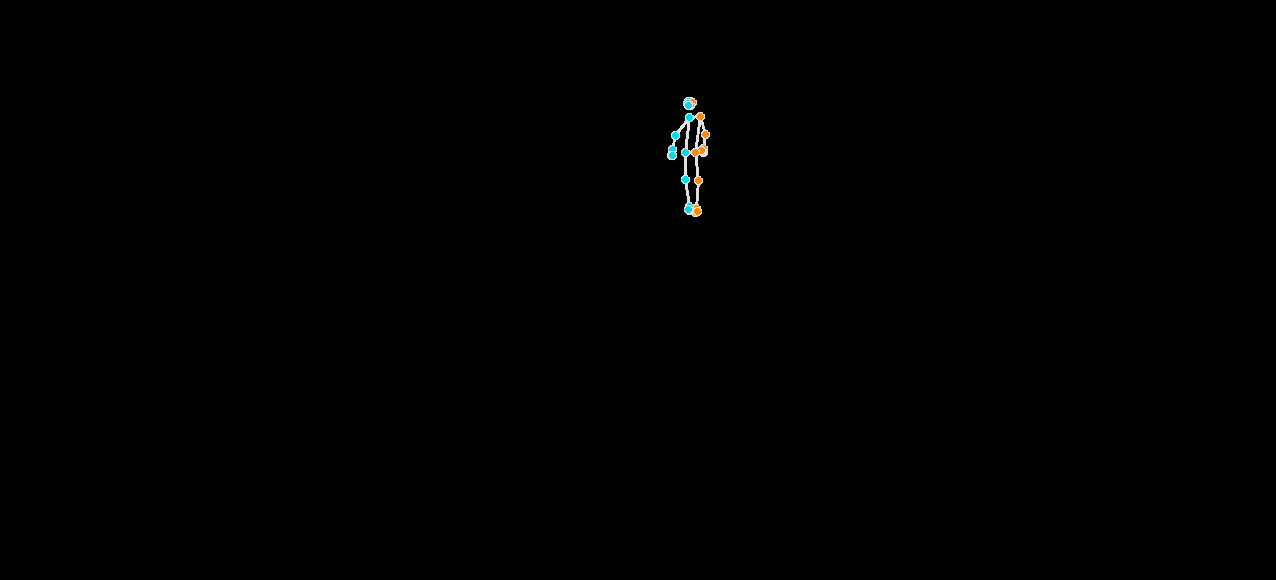

580 1276 3


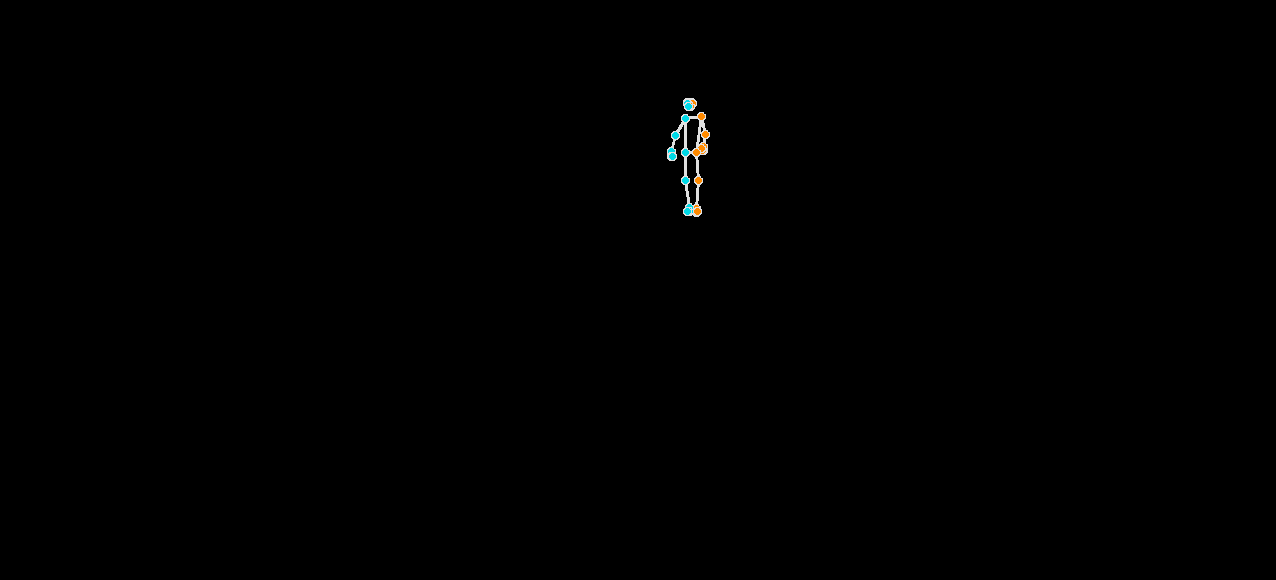

580 1276 3


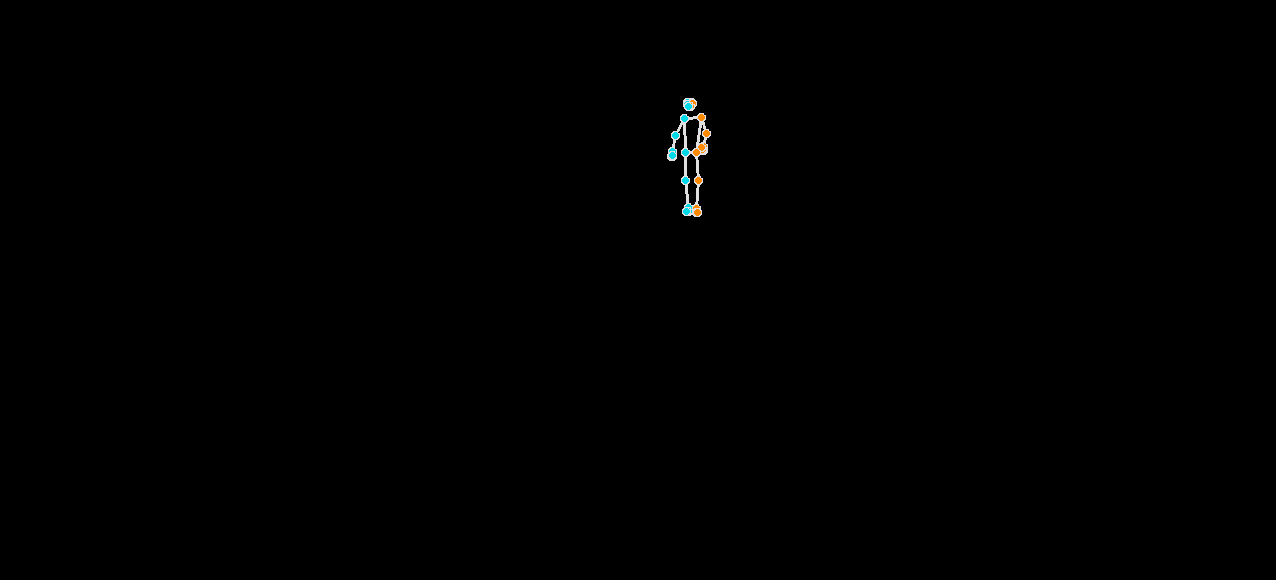

580 1276 3


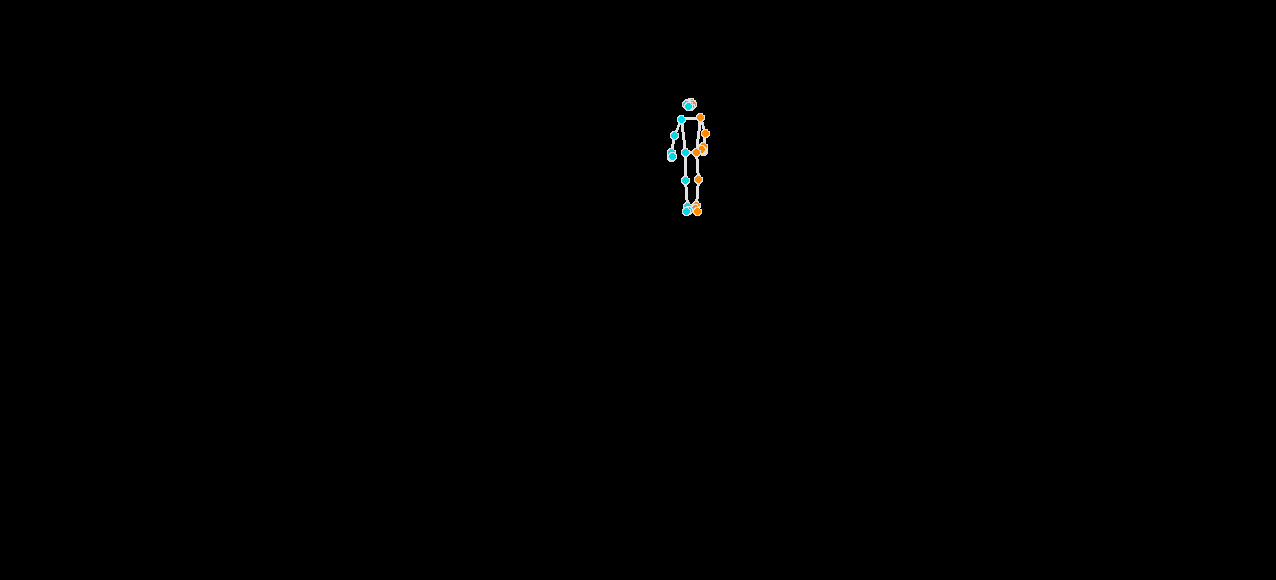

580 1276 3


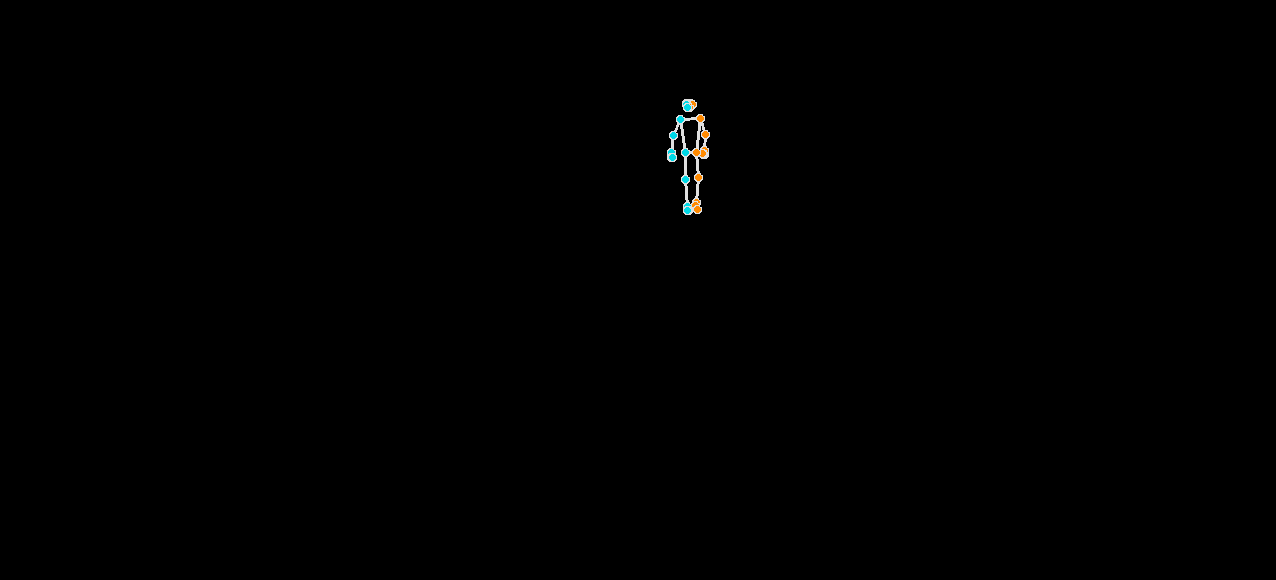

580 1276 3


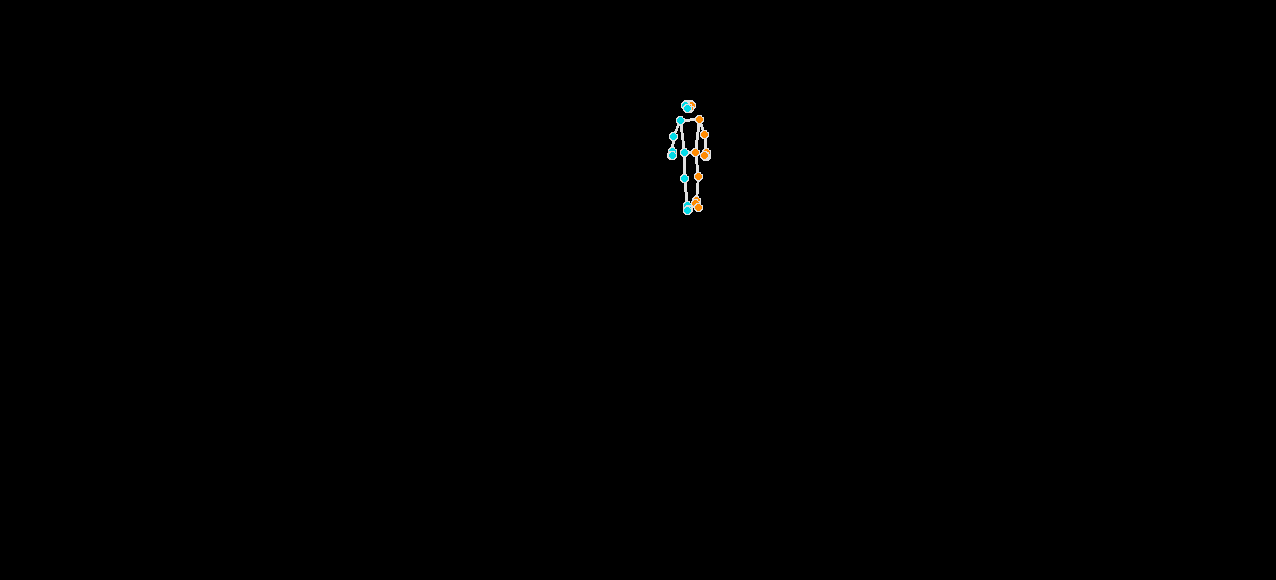

580 1276 3


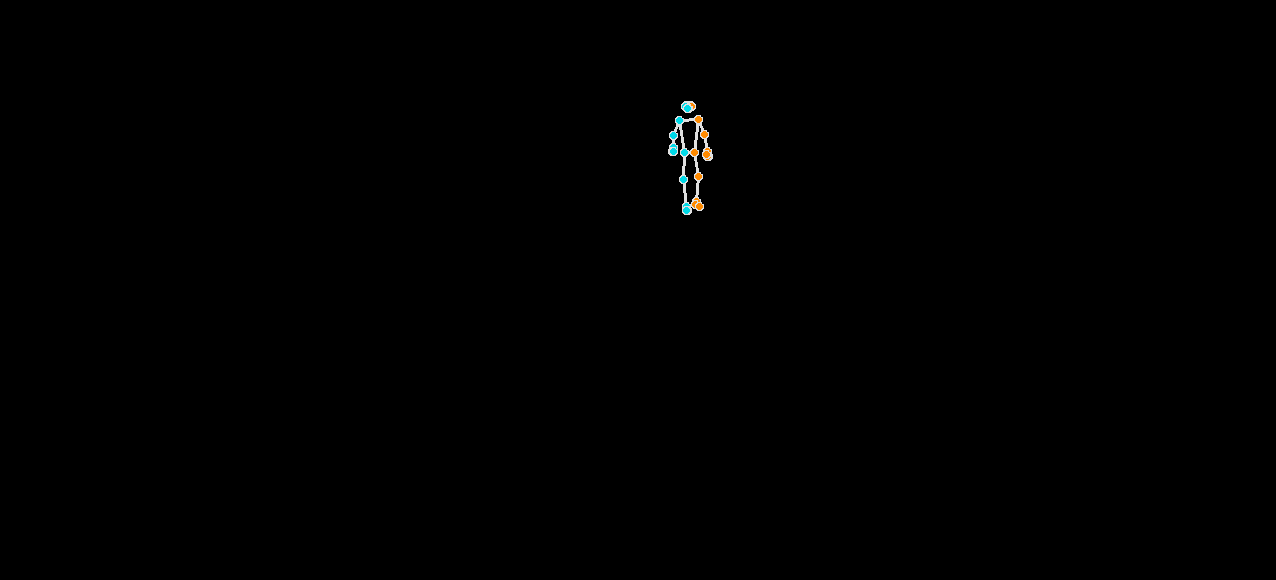

580 1276 3


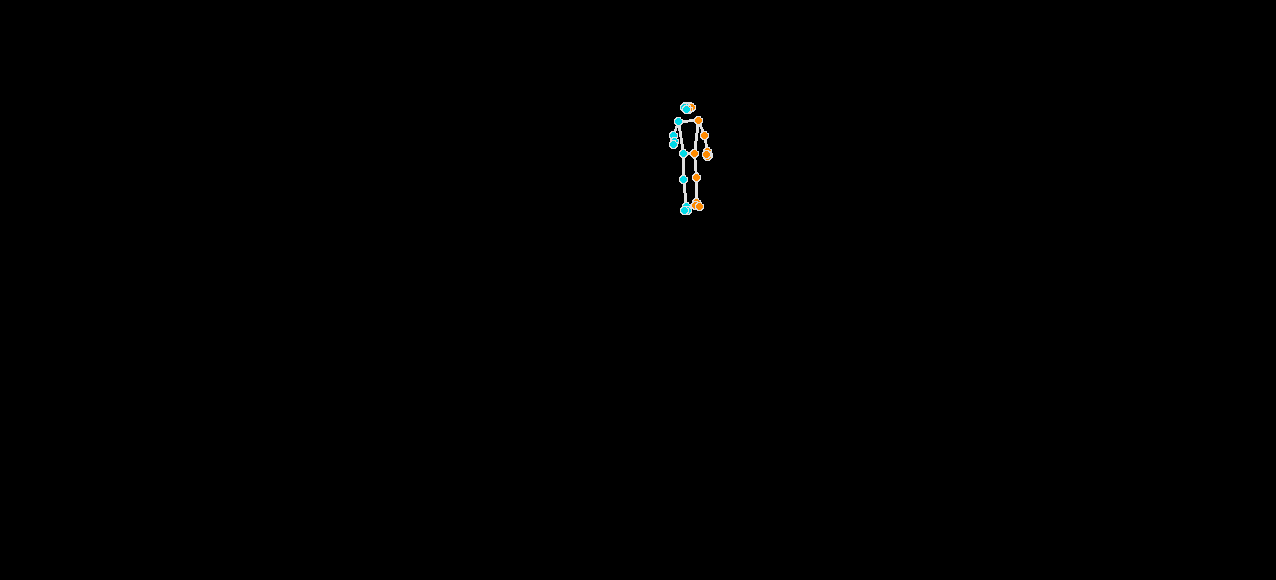

580 1276 3


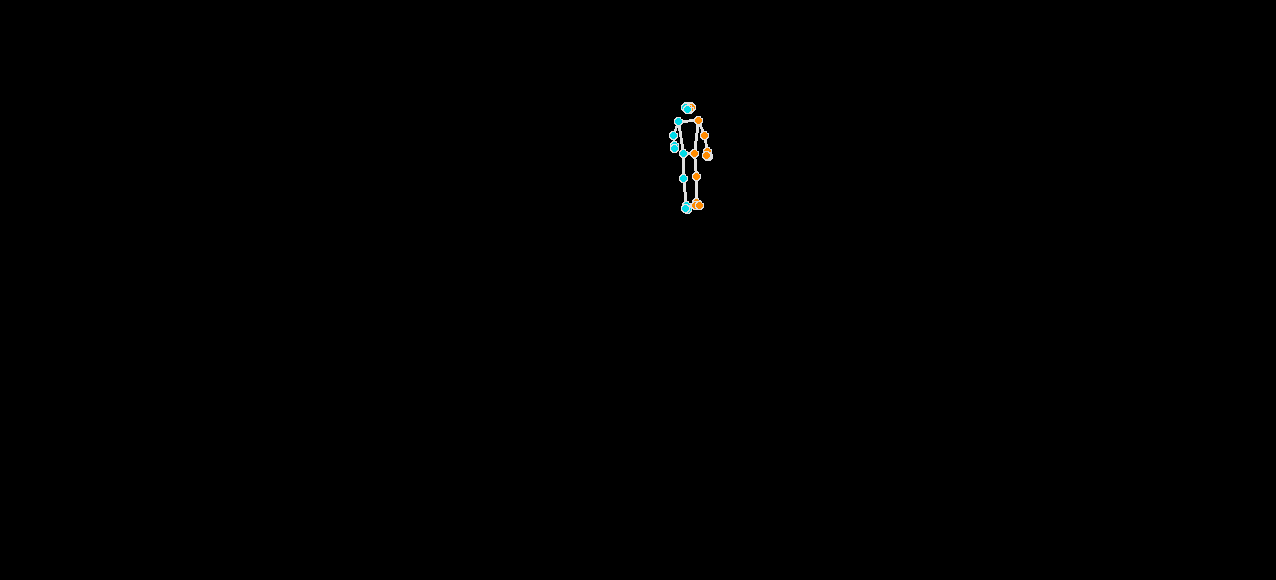

580 1276 3


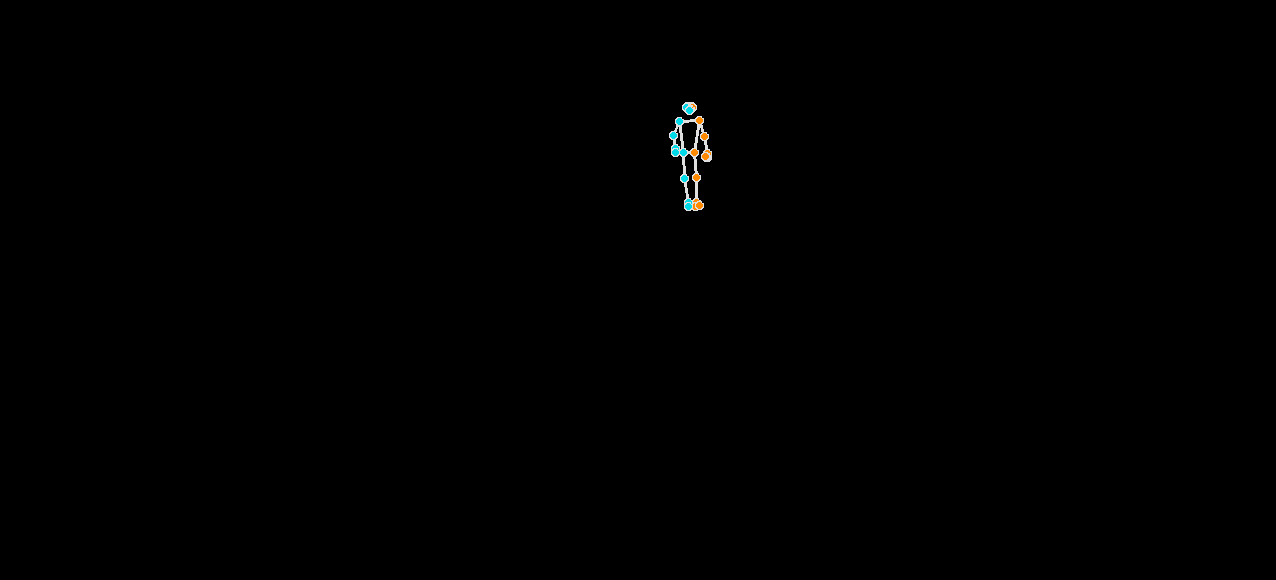

580 1276 3


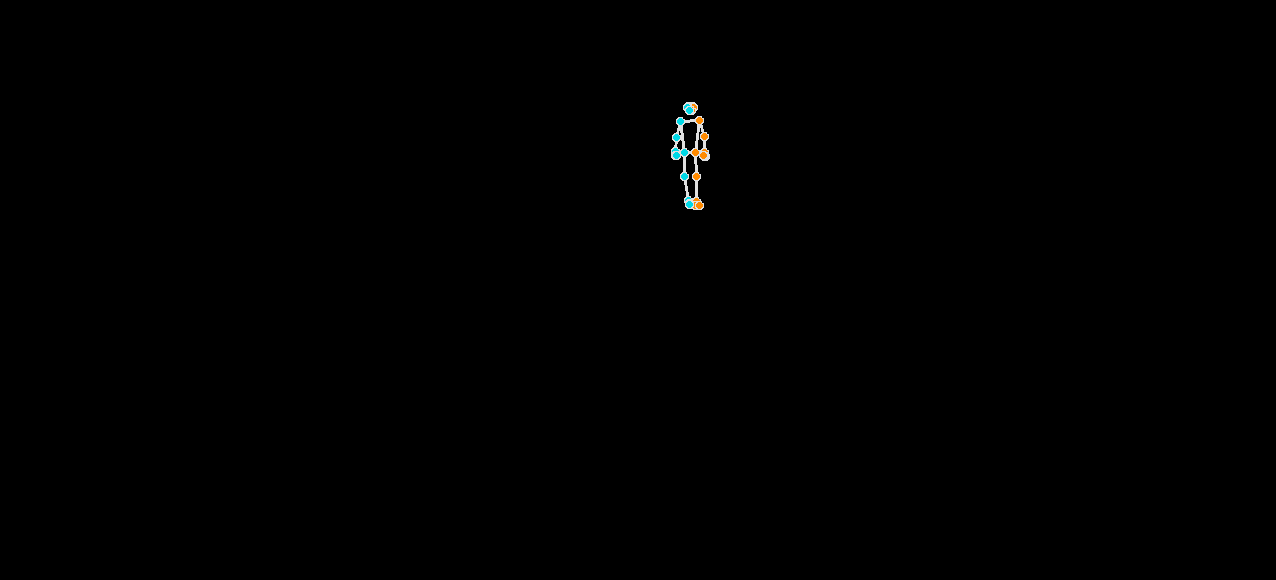

580 1276 3


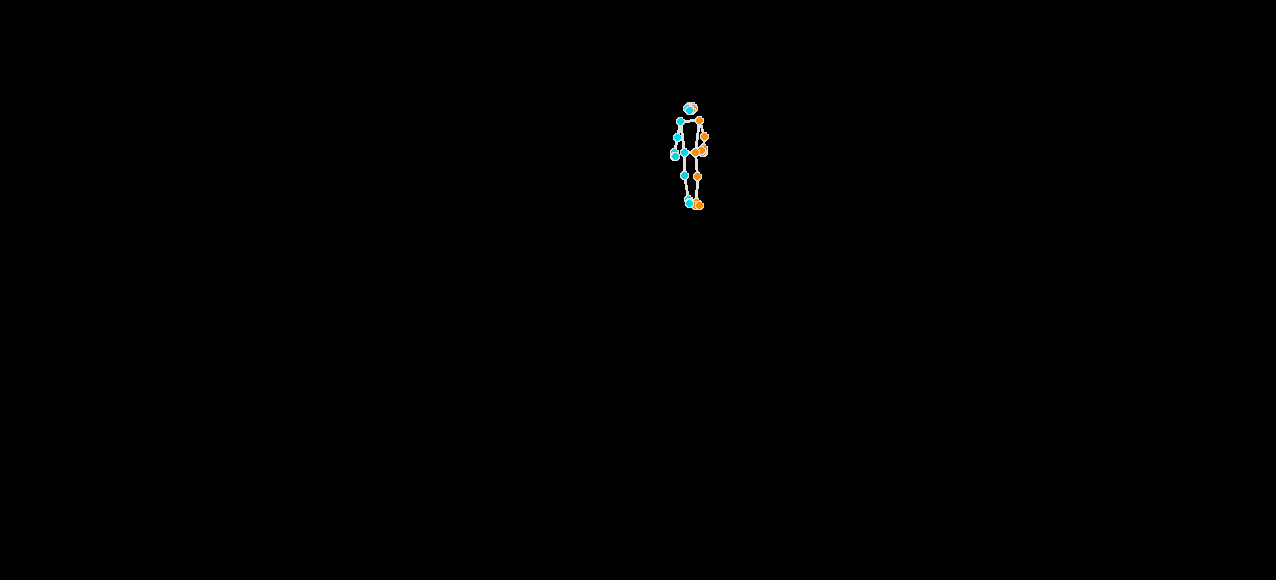

580 1276 3


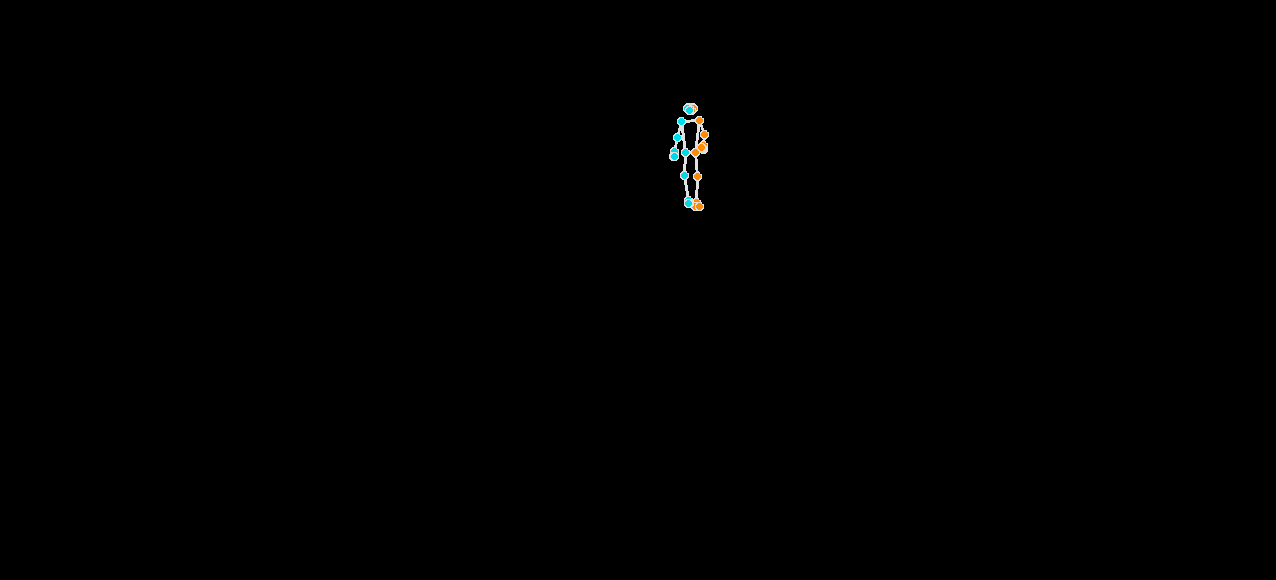

580 1276 3


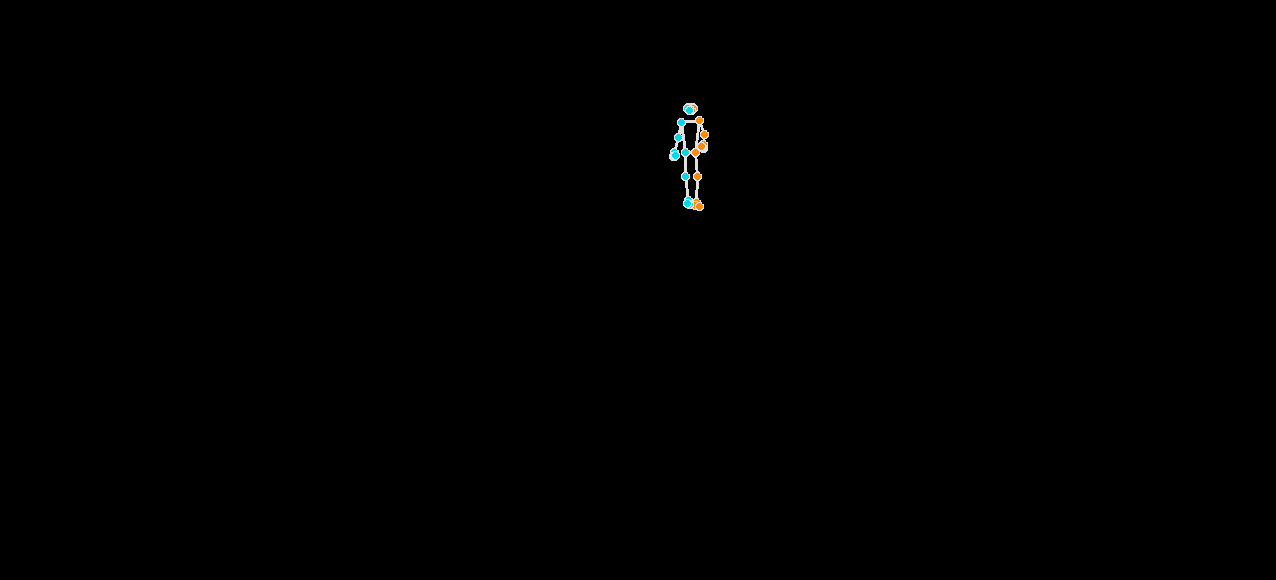

580 1276 3


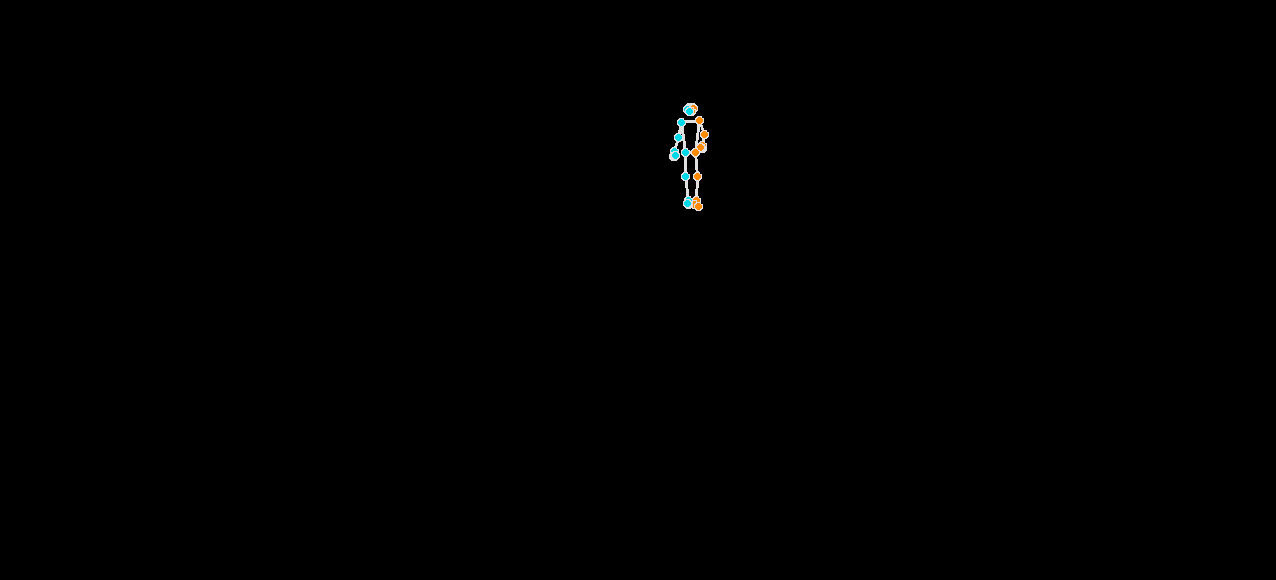

580 1276 3


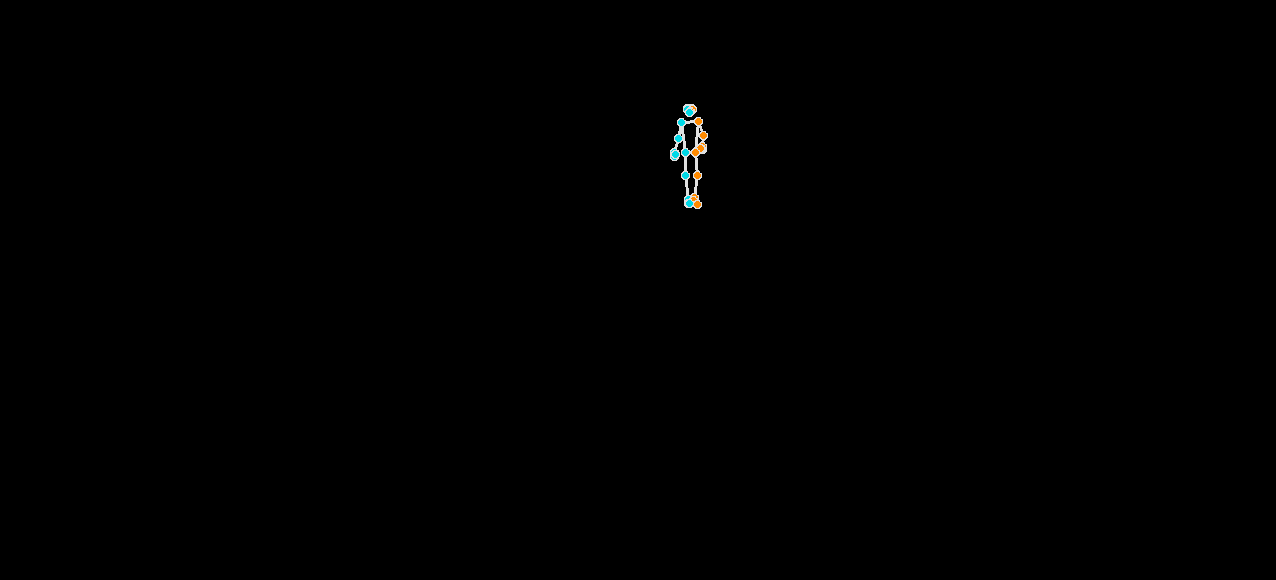

580 1276 3


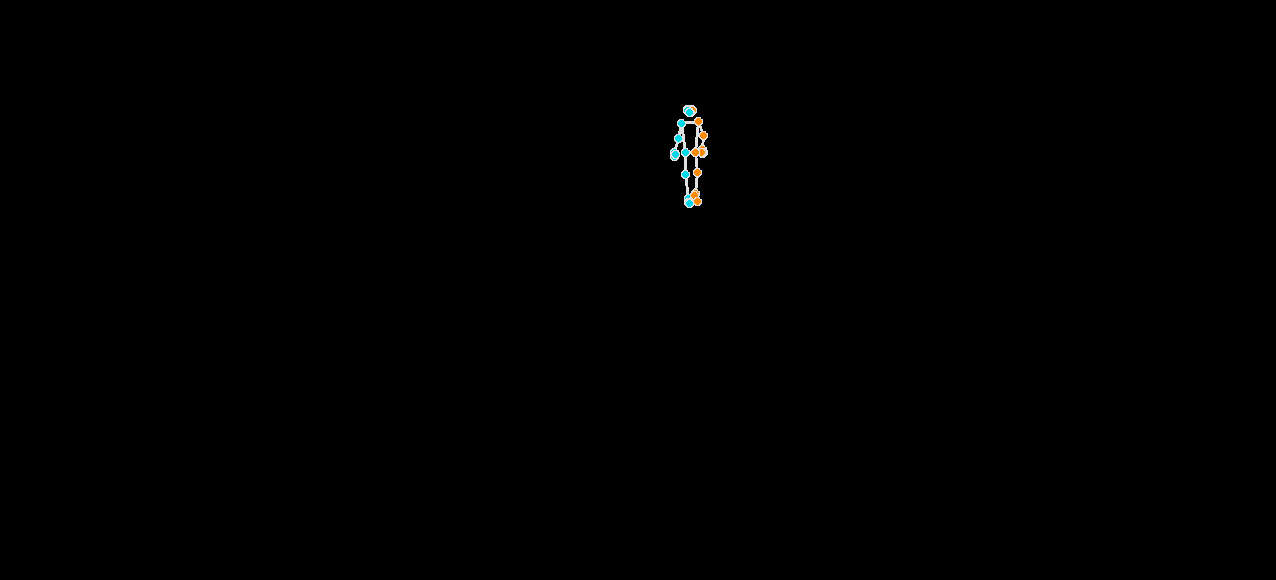

580 1276 3


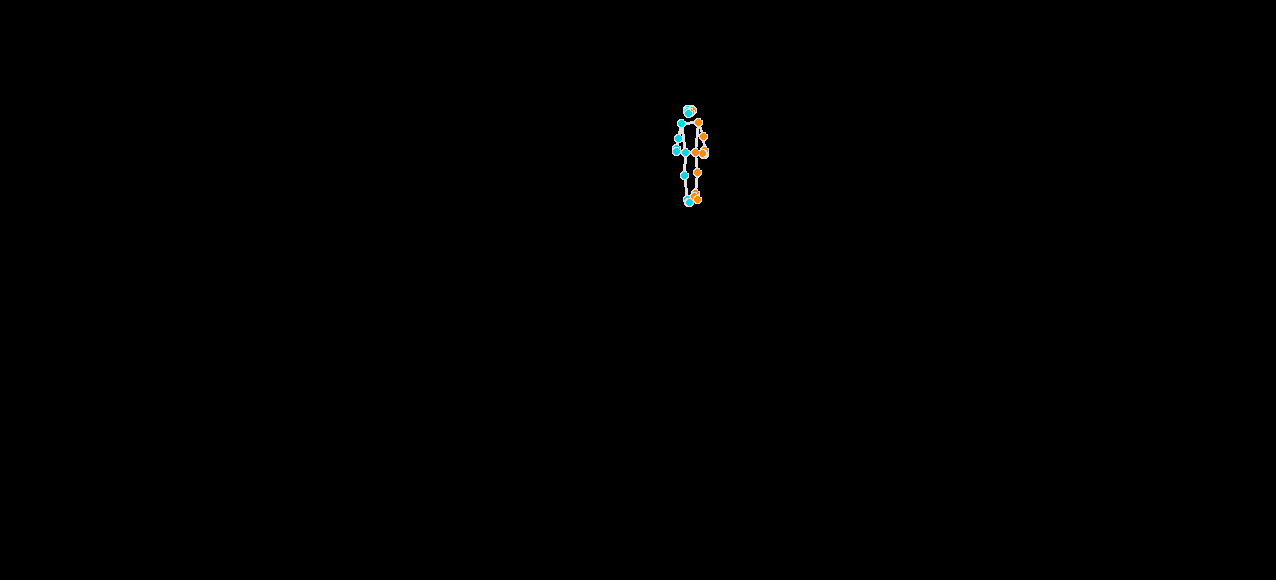

580 1276 3


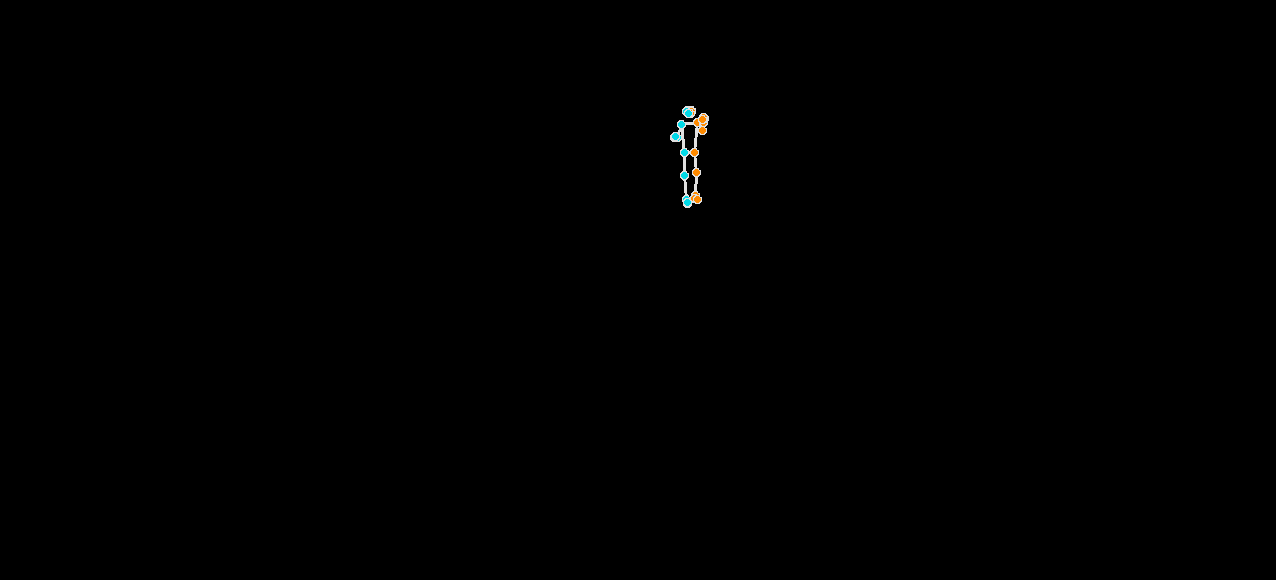

580 1276 3


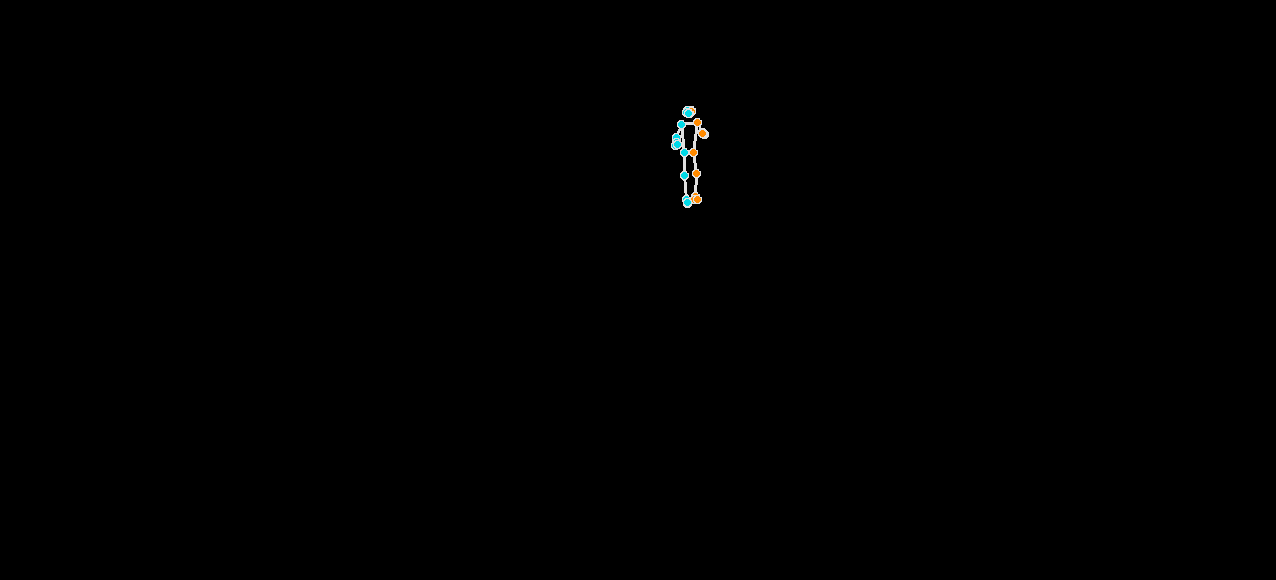

580 1276 3


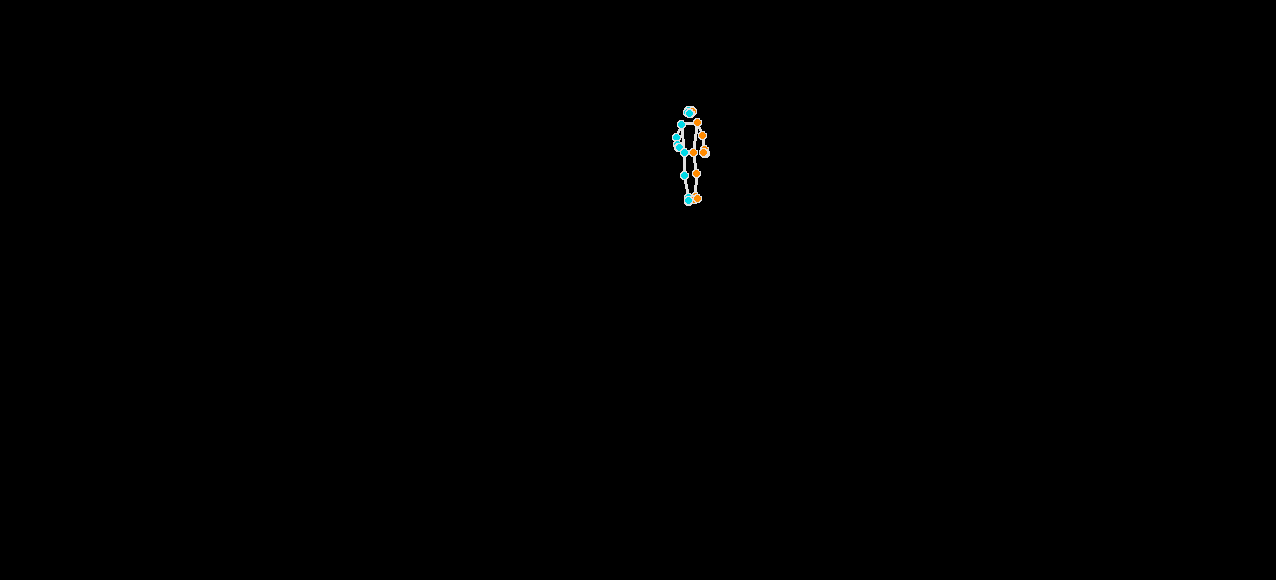

580 1276 3


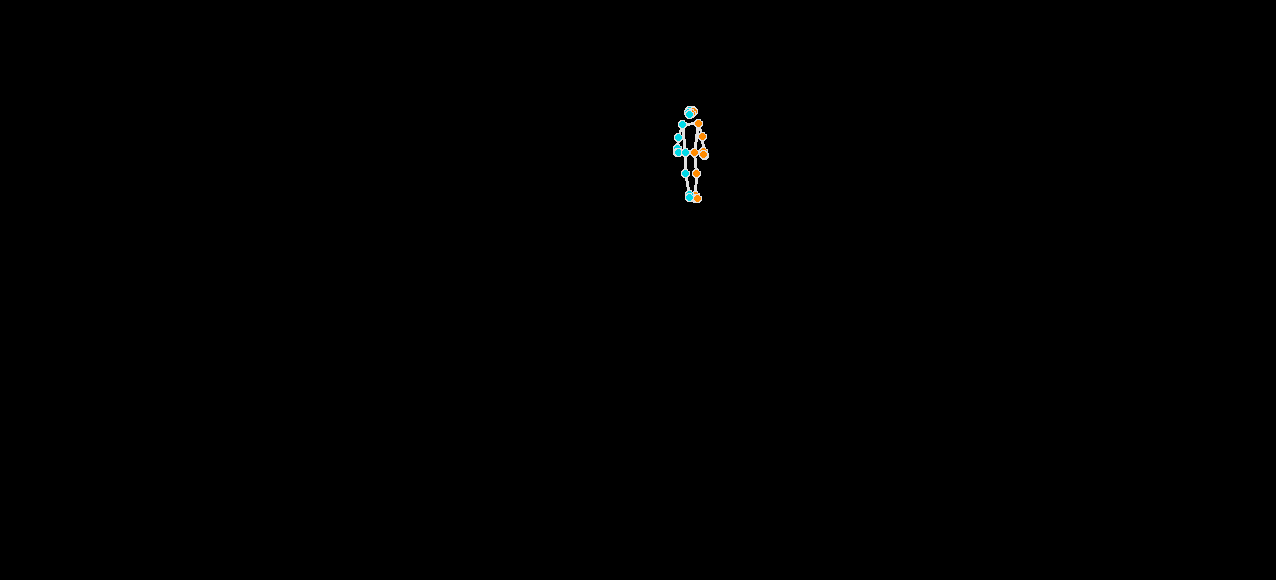

580 1276 3


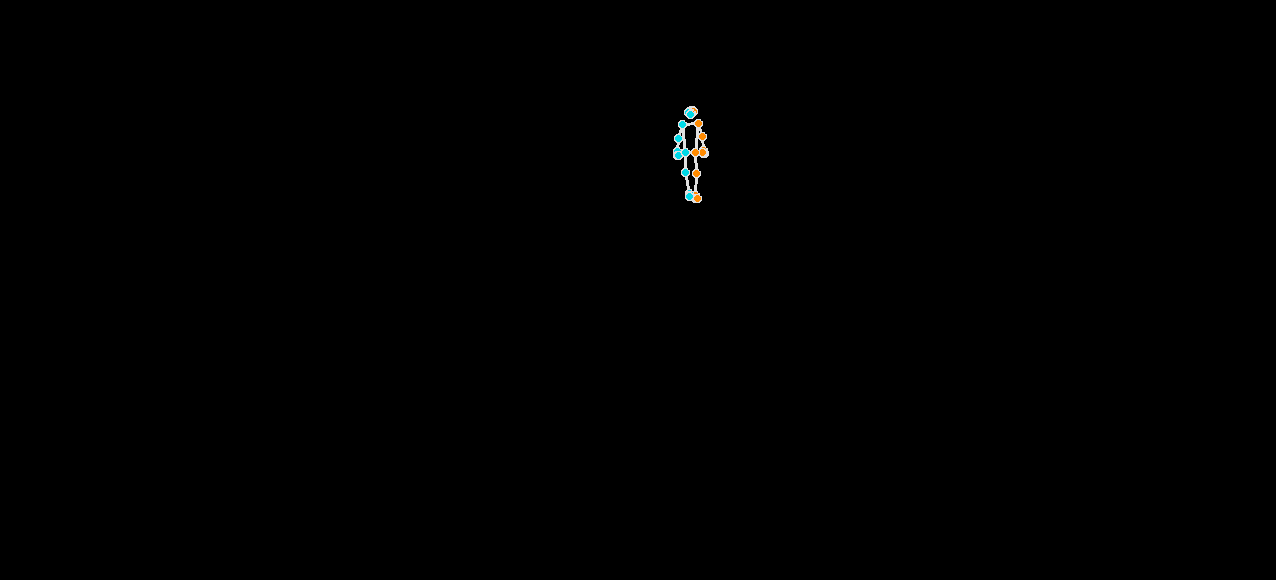

580 1276 3


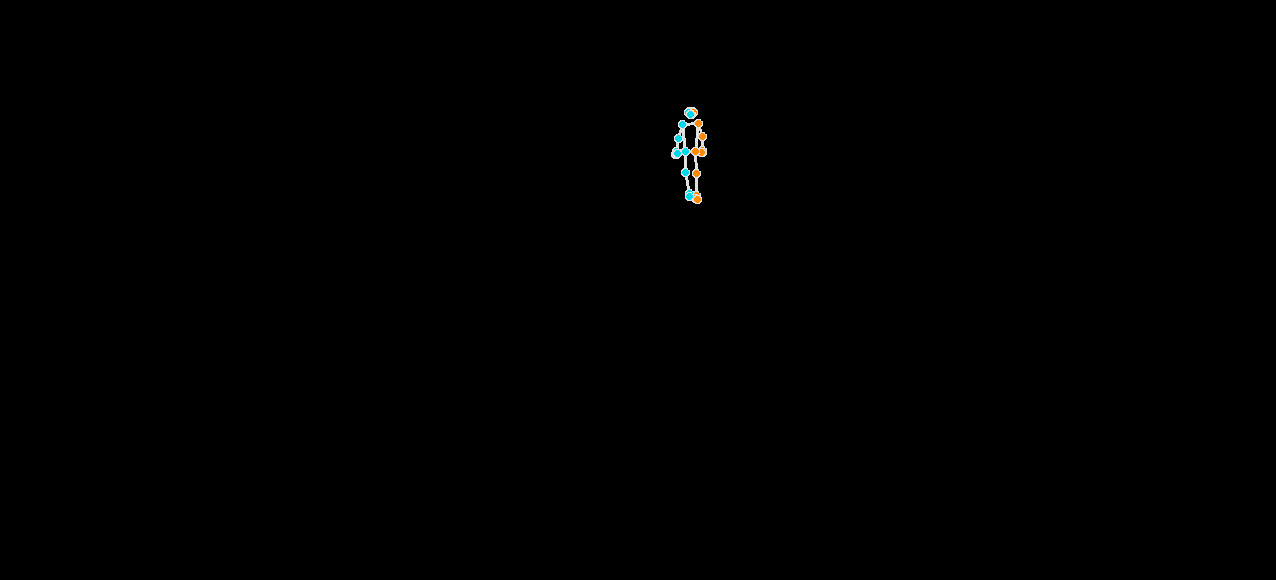

580 1276 3


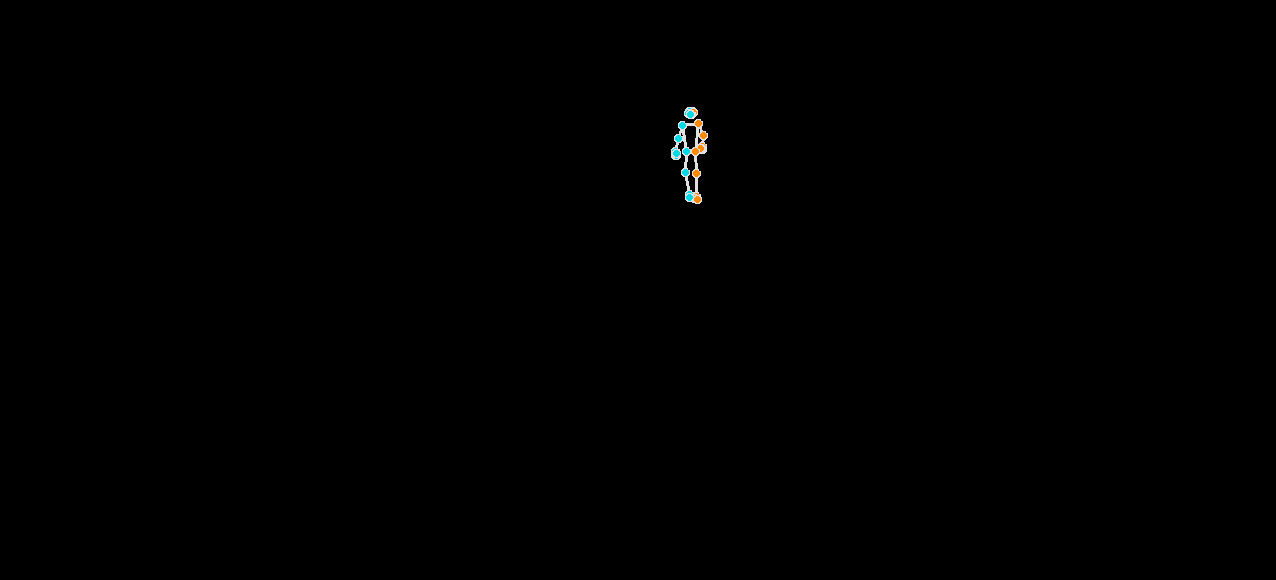

580 1276 3


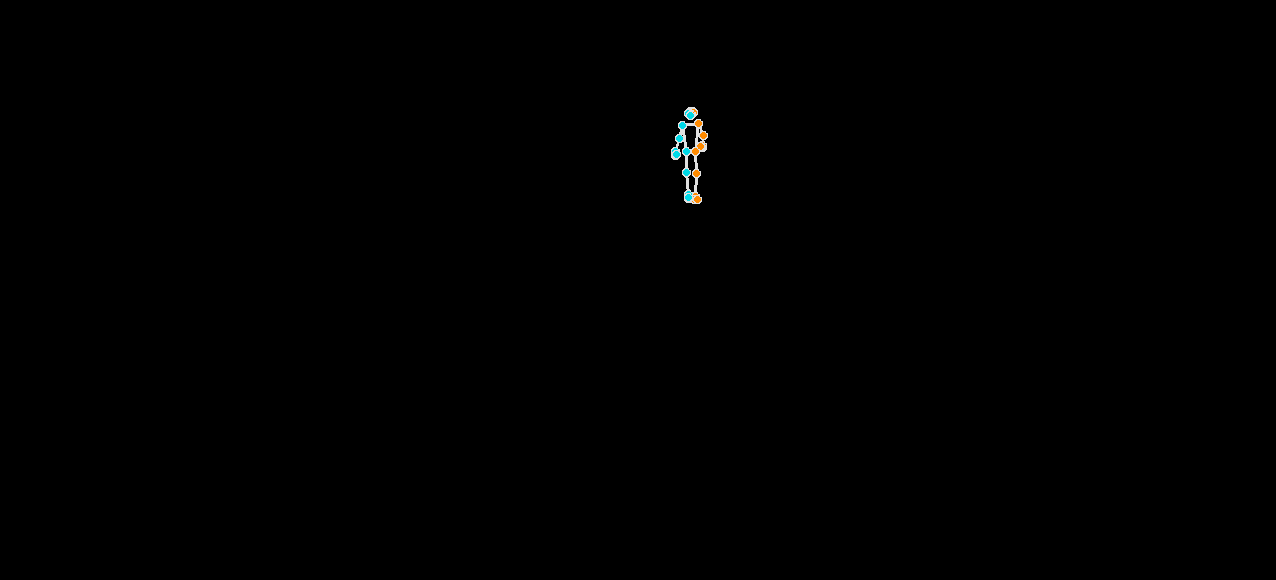

580 1276 3


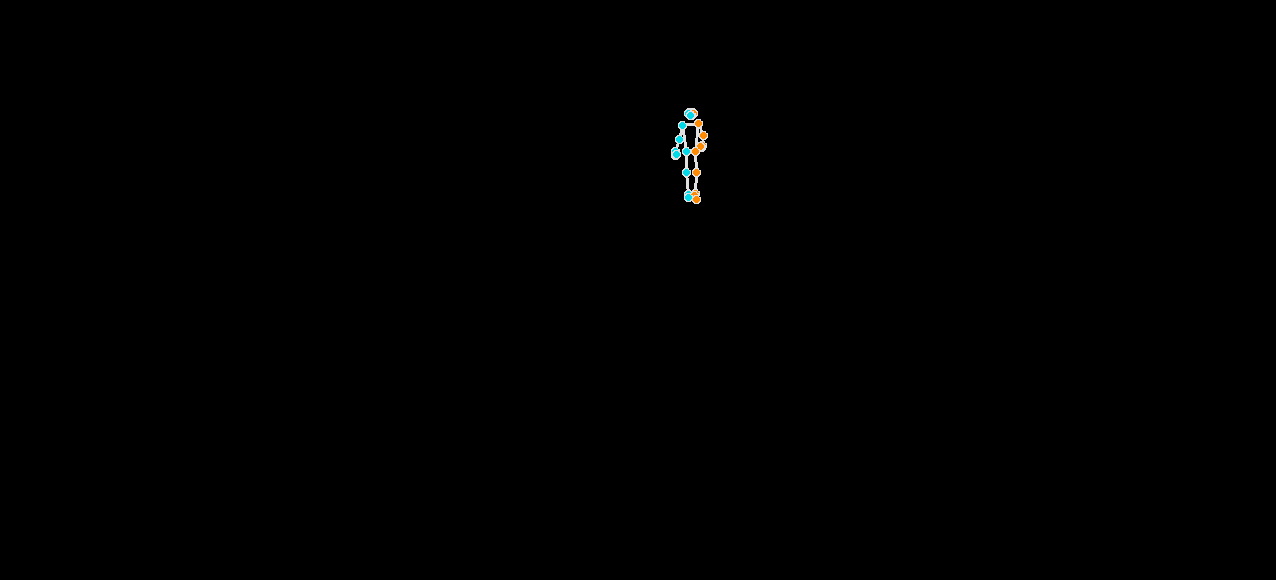

580 1276 3


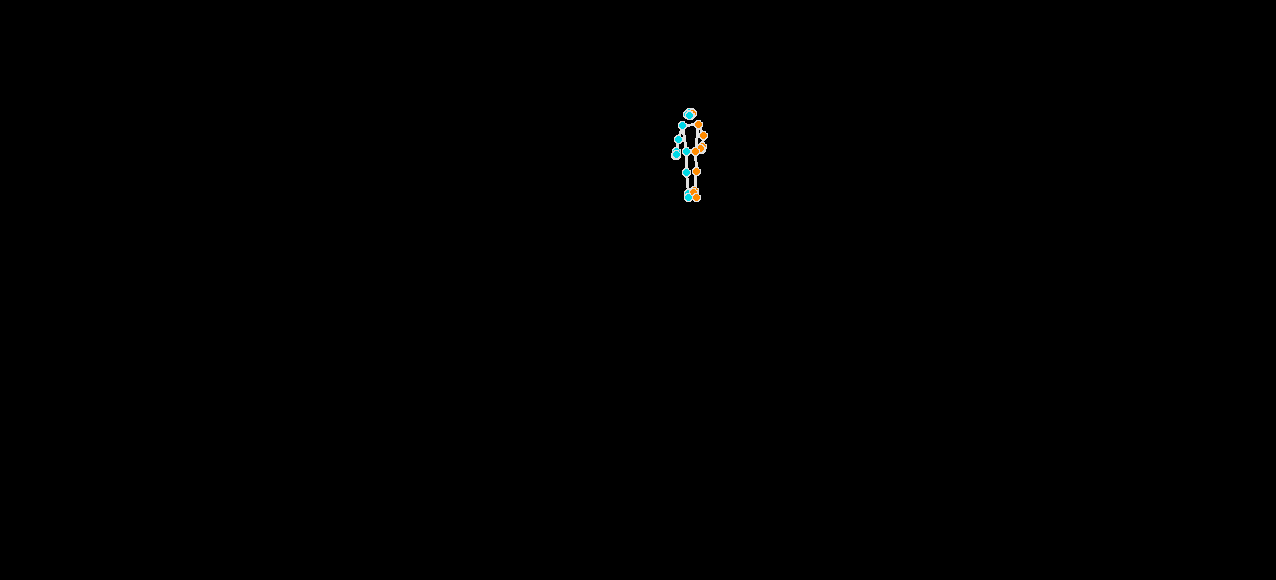

580 1276 3


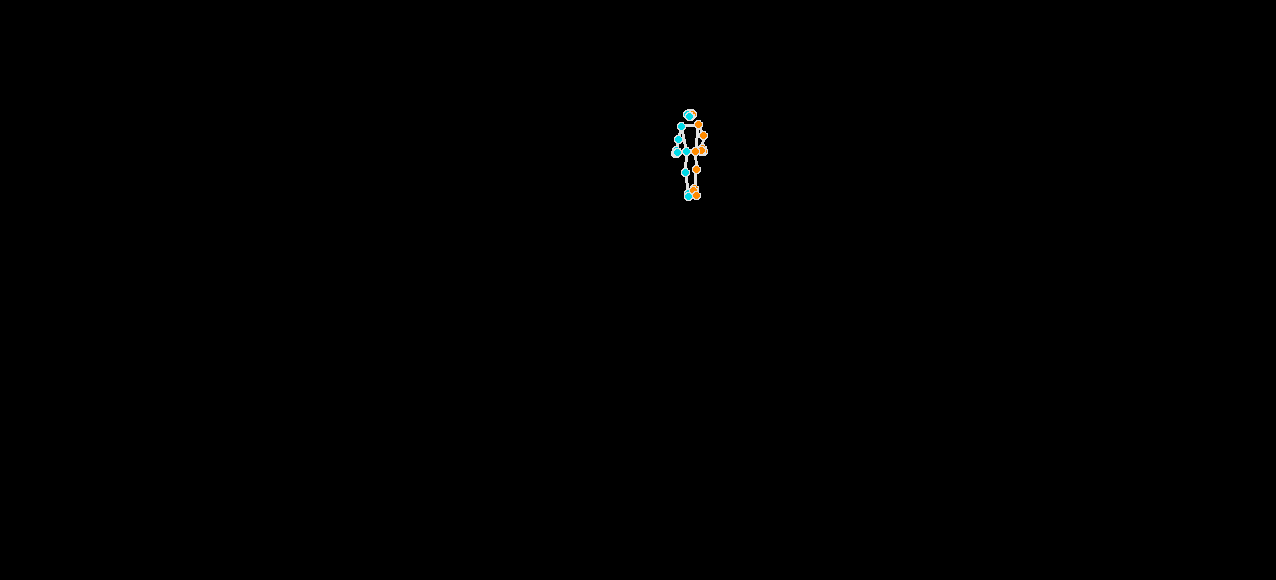

580 1276 3


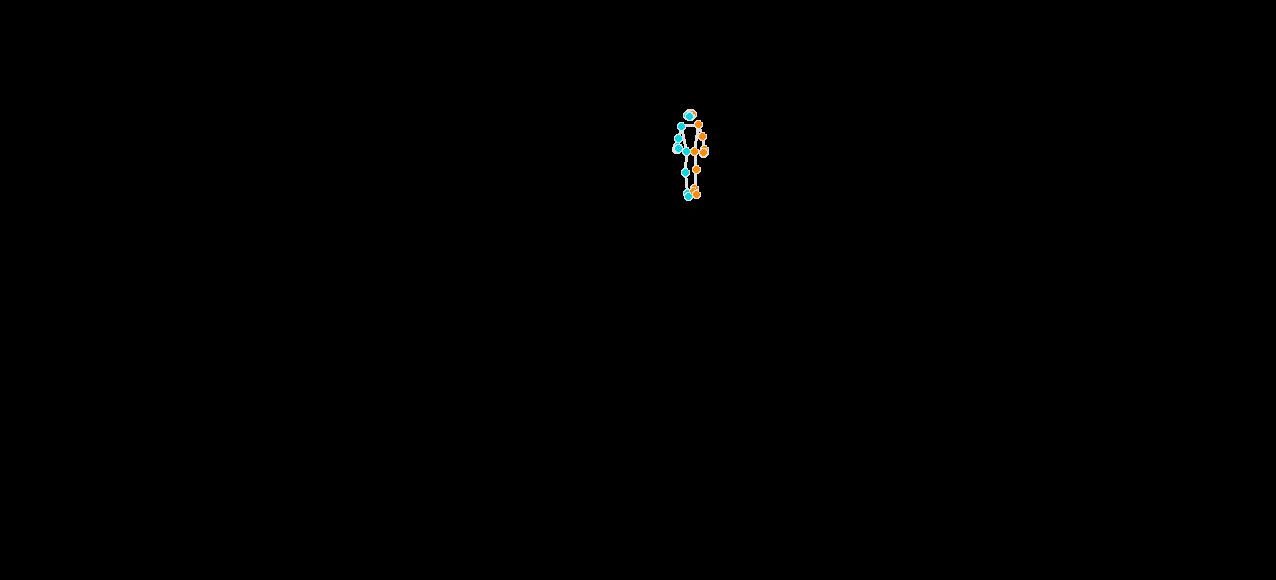

580 1276 3


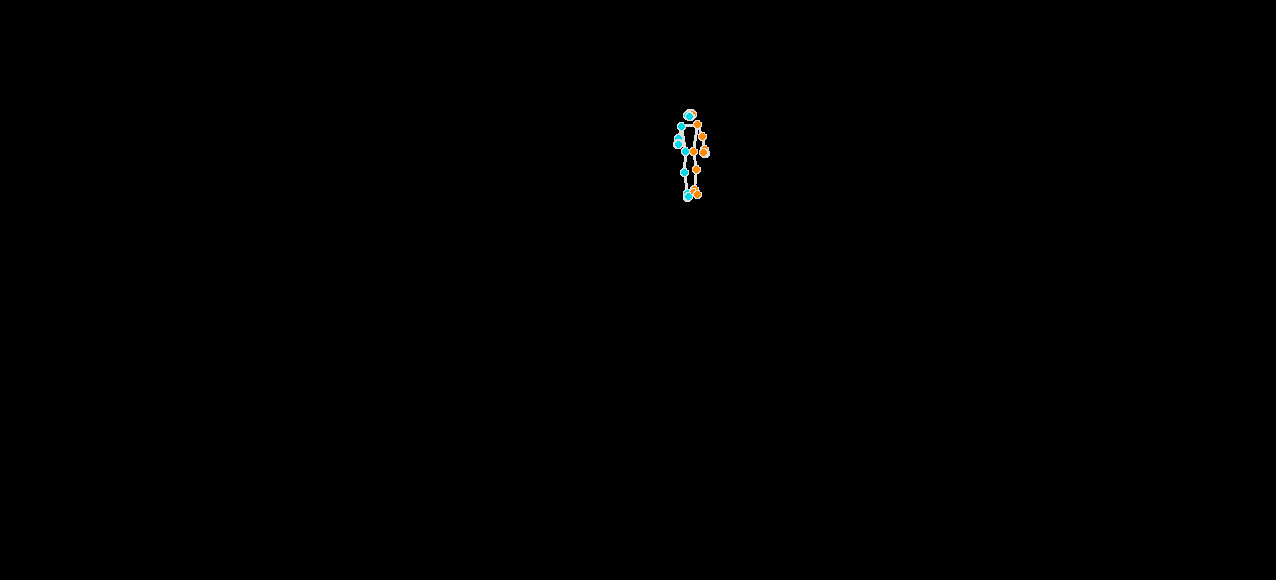

580 1276 3


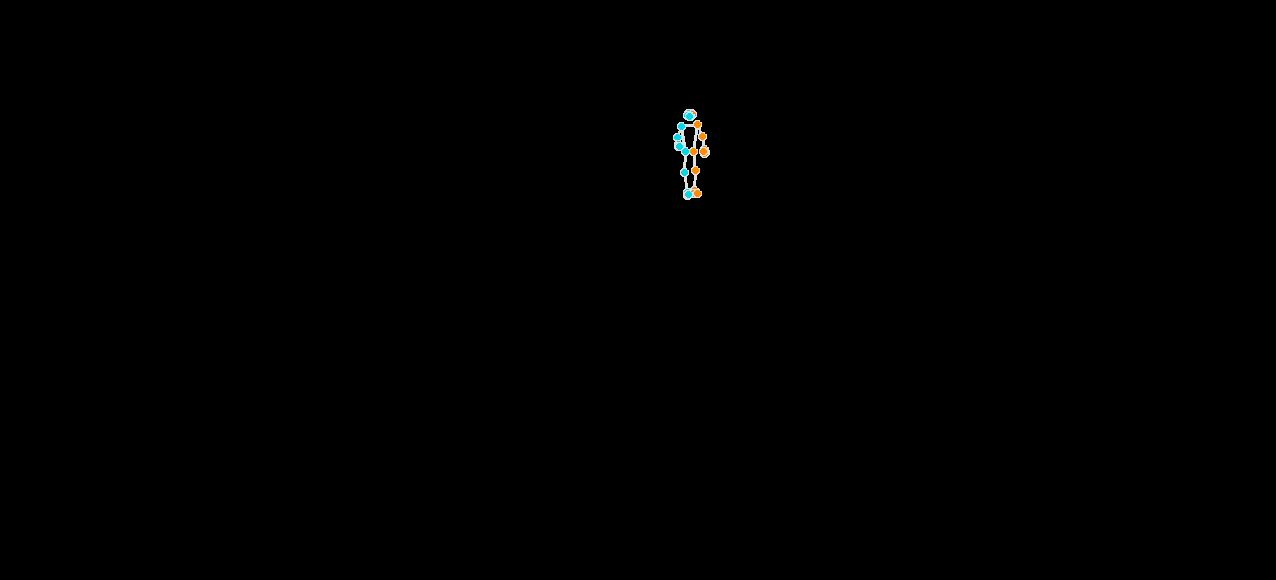

580 1276 3


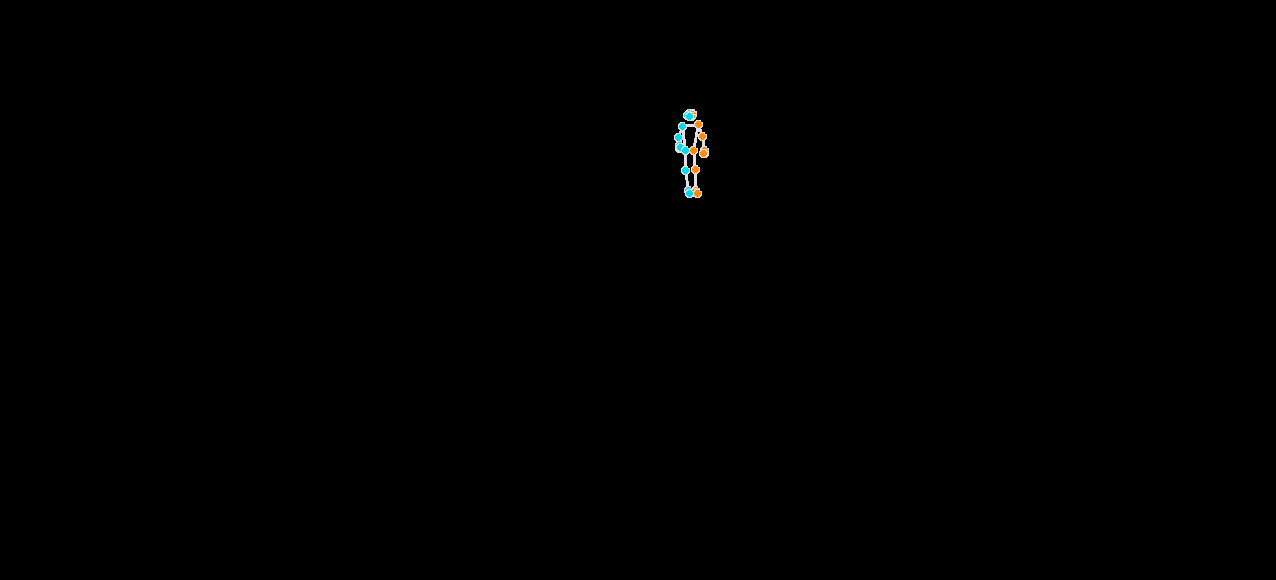

580 1276 3


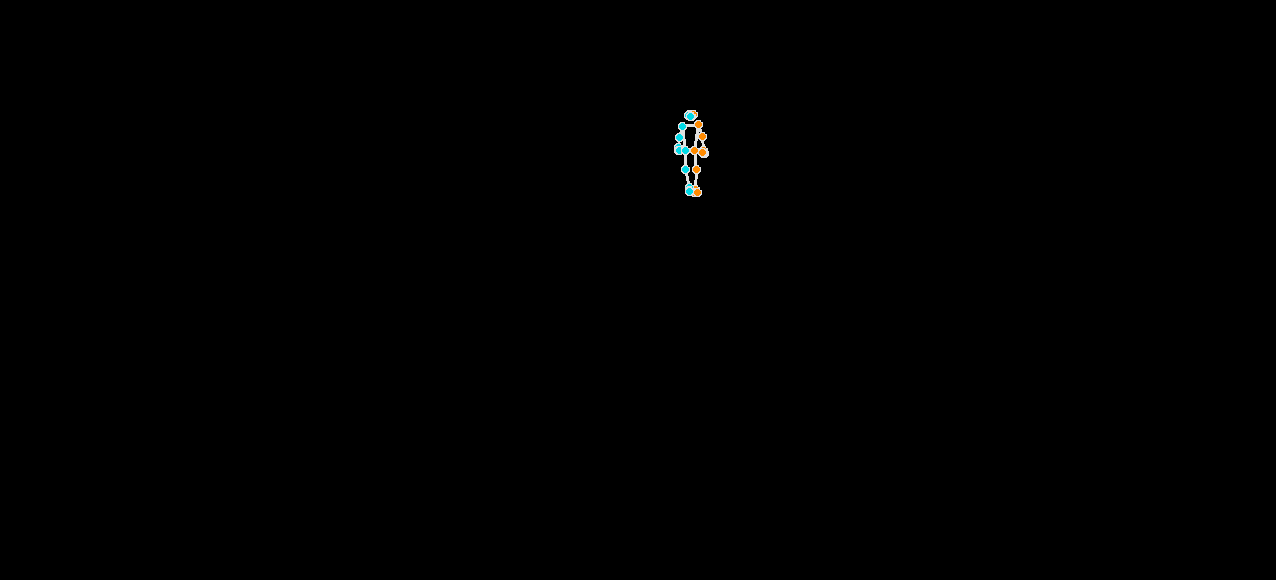

580 1276 3


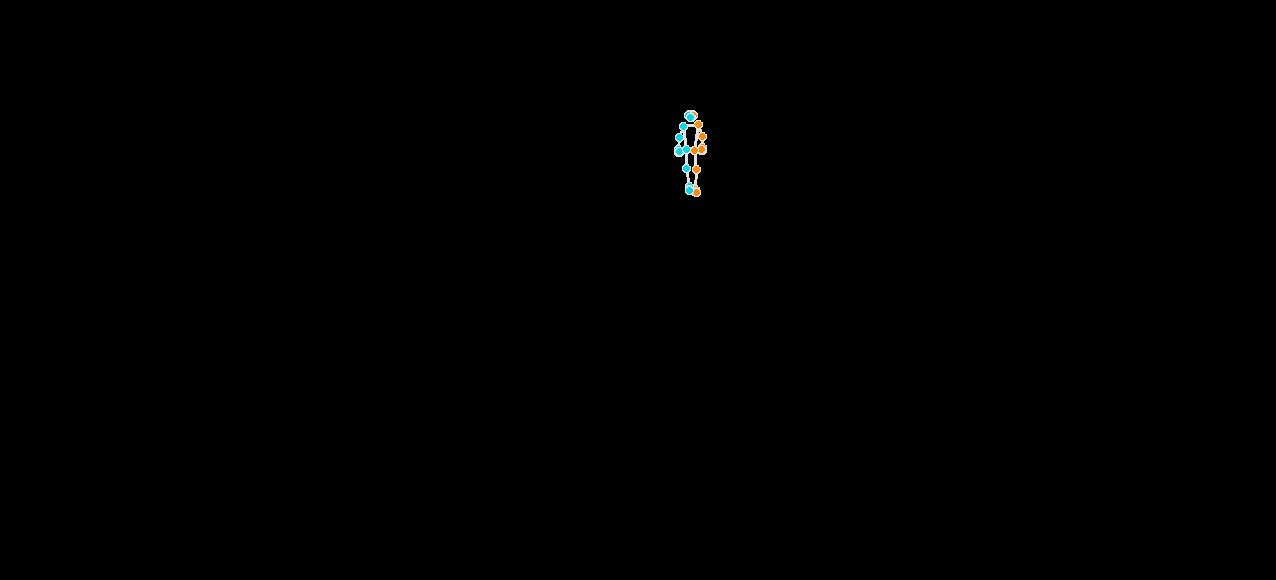

580 1276 3


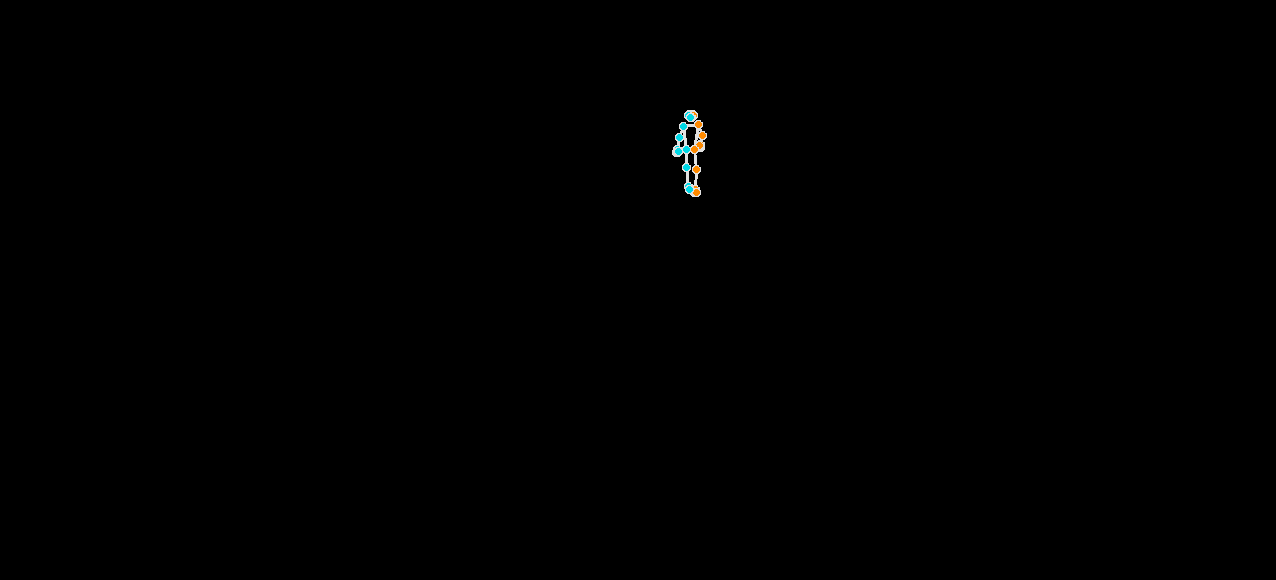

580 1276 3


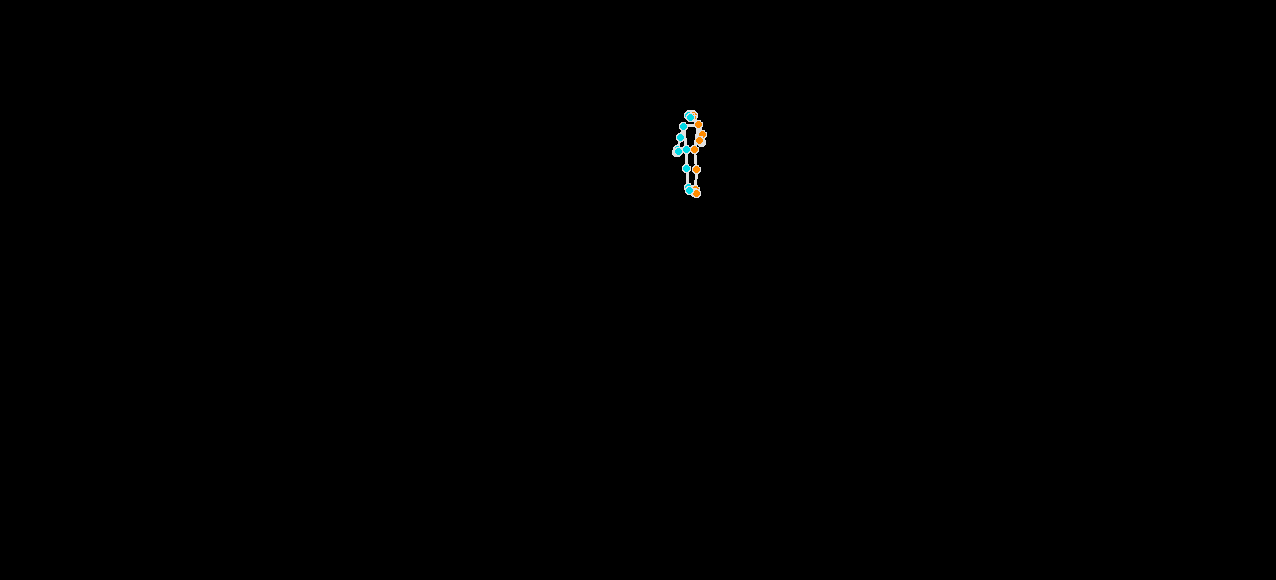

580 1276 3


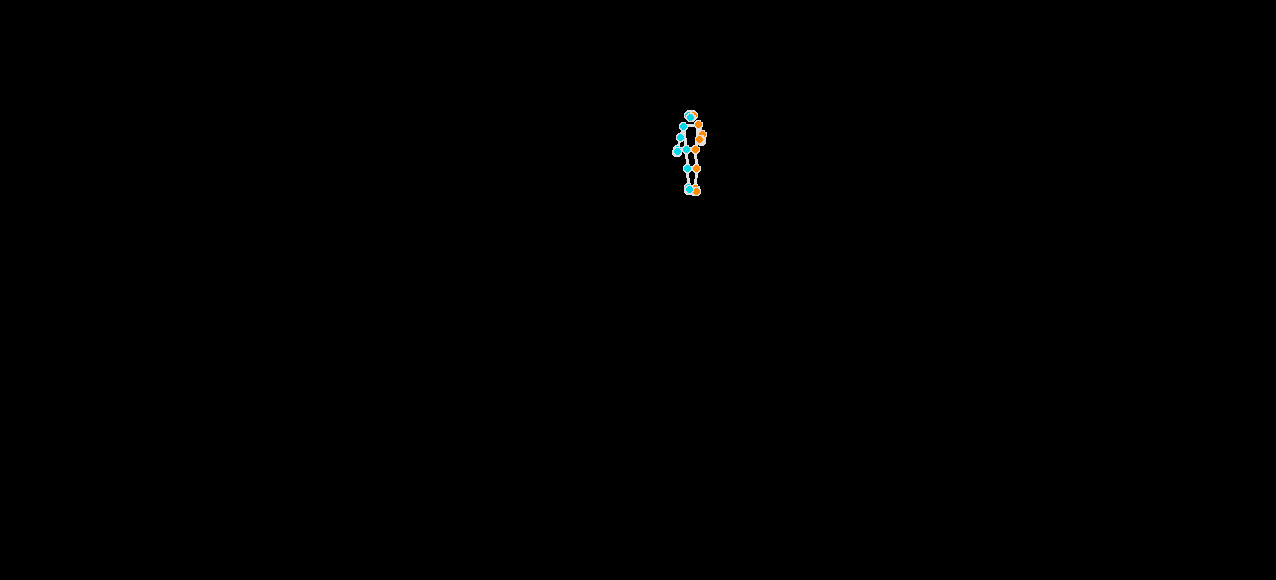

580 1276 3


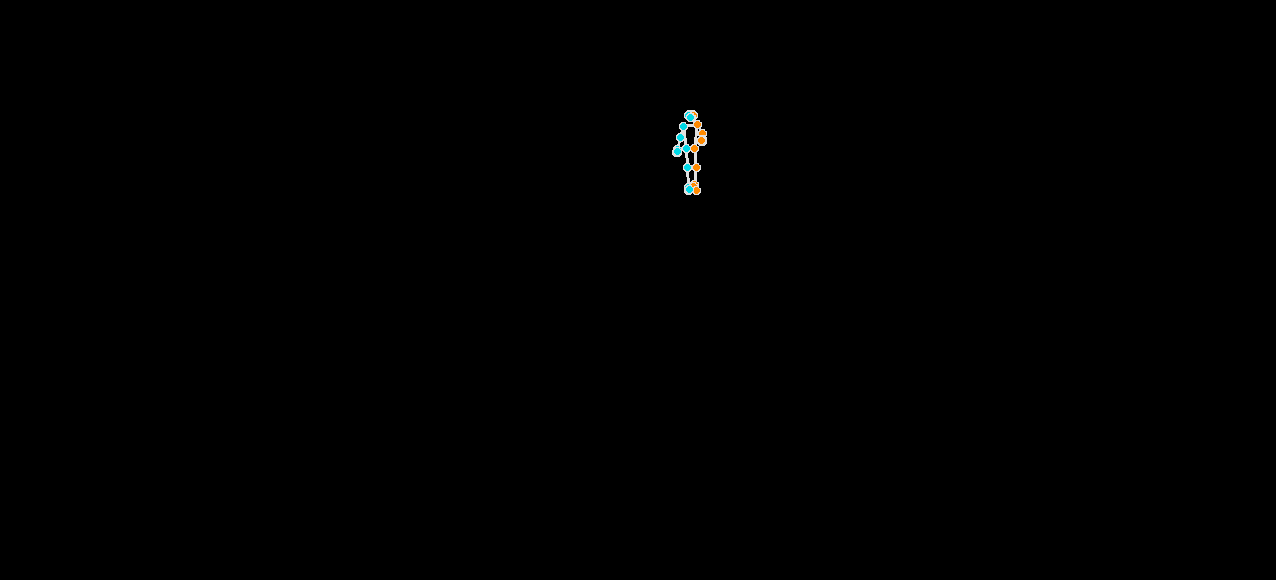

580 1276 3


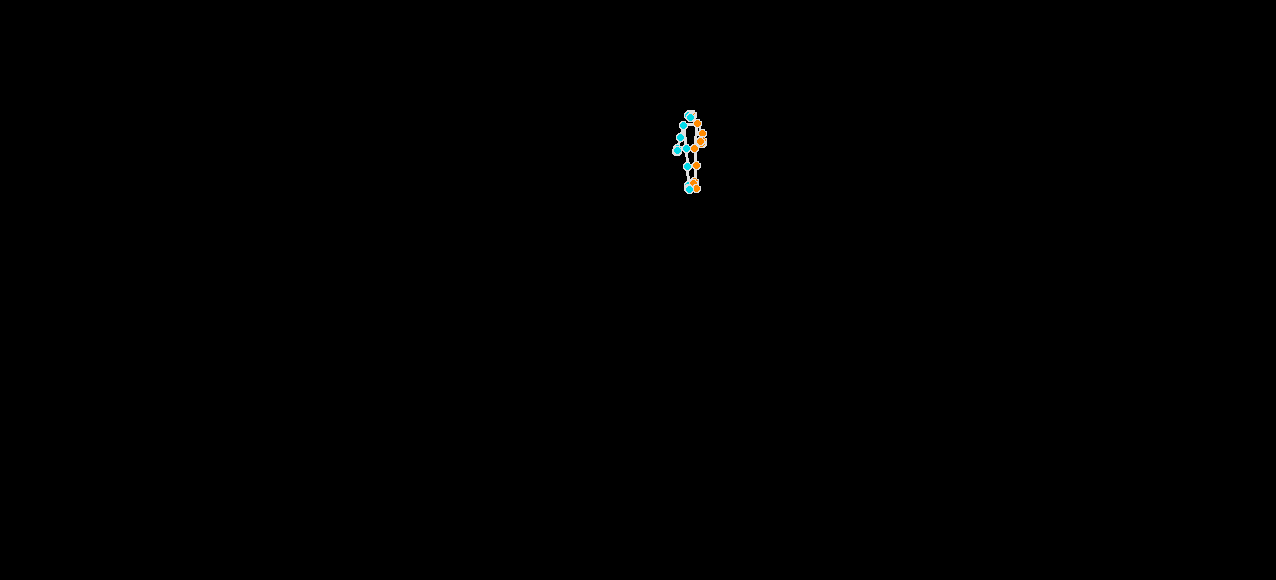

580 1276 3


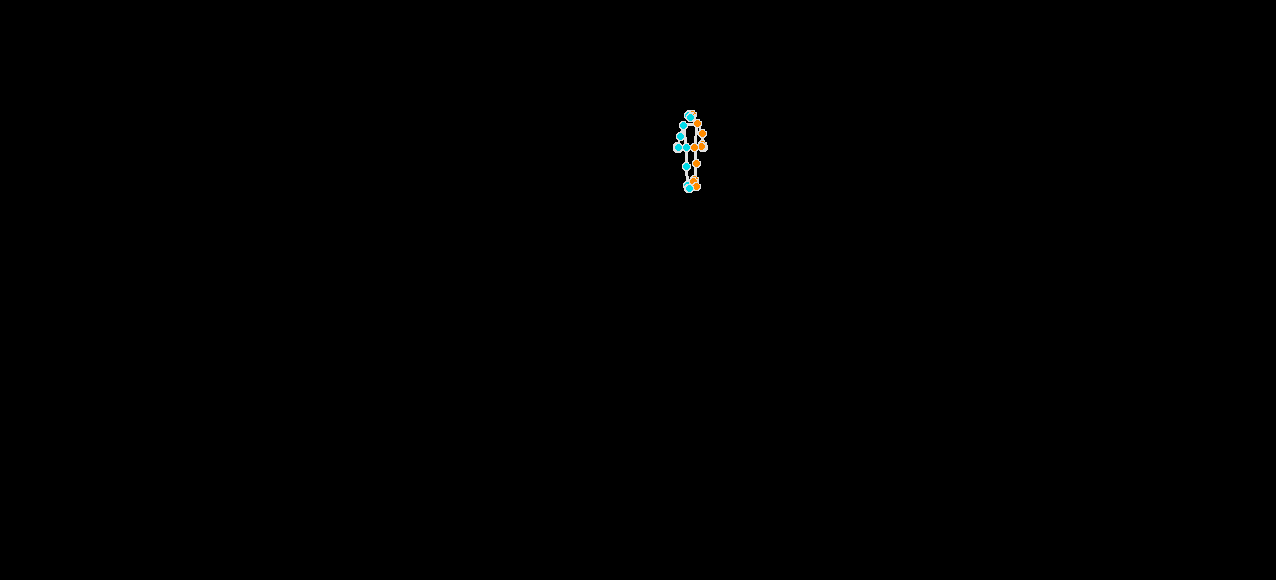

580 1276 3


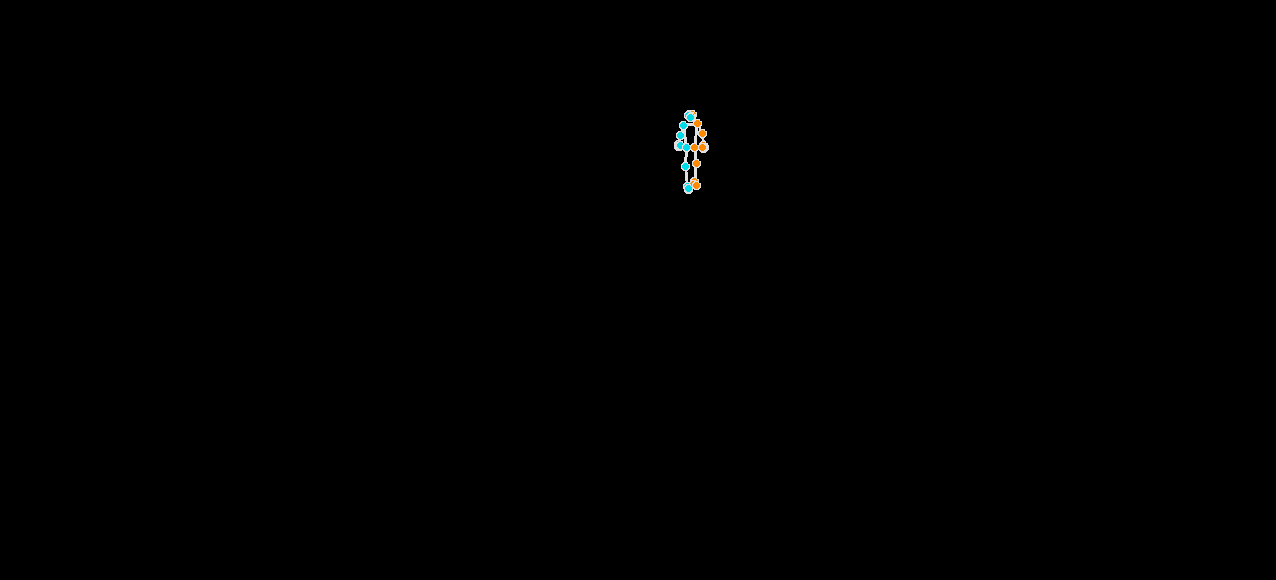

580 1276 3


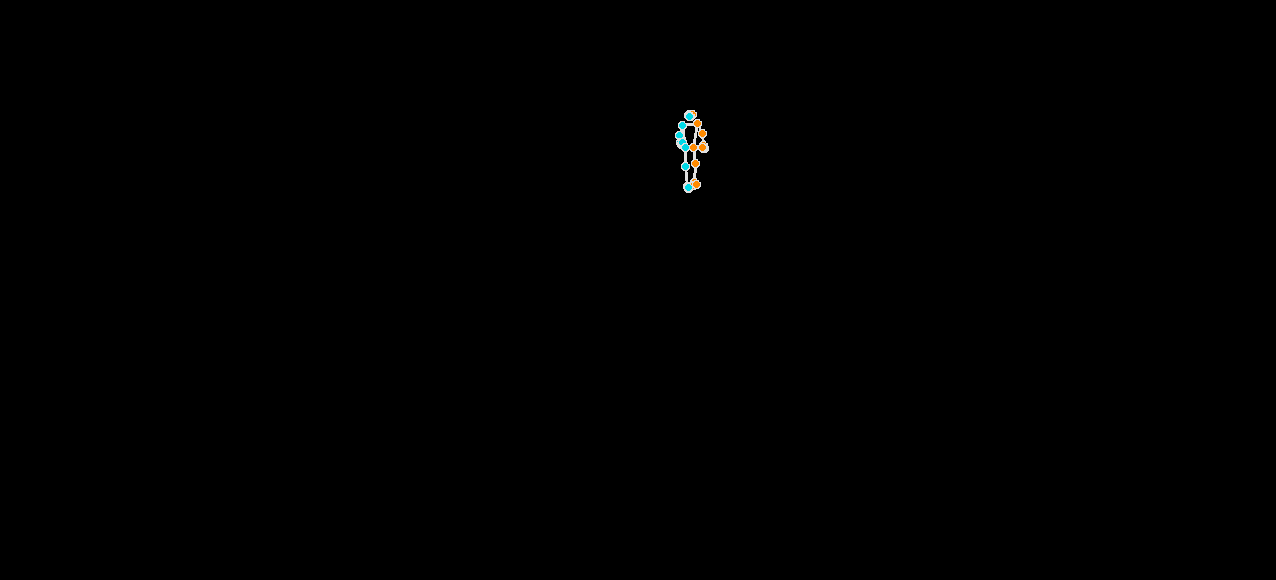

580 1276 3


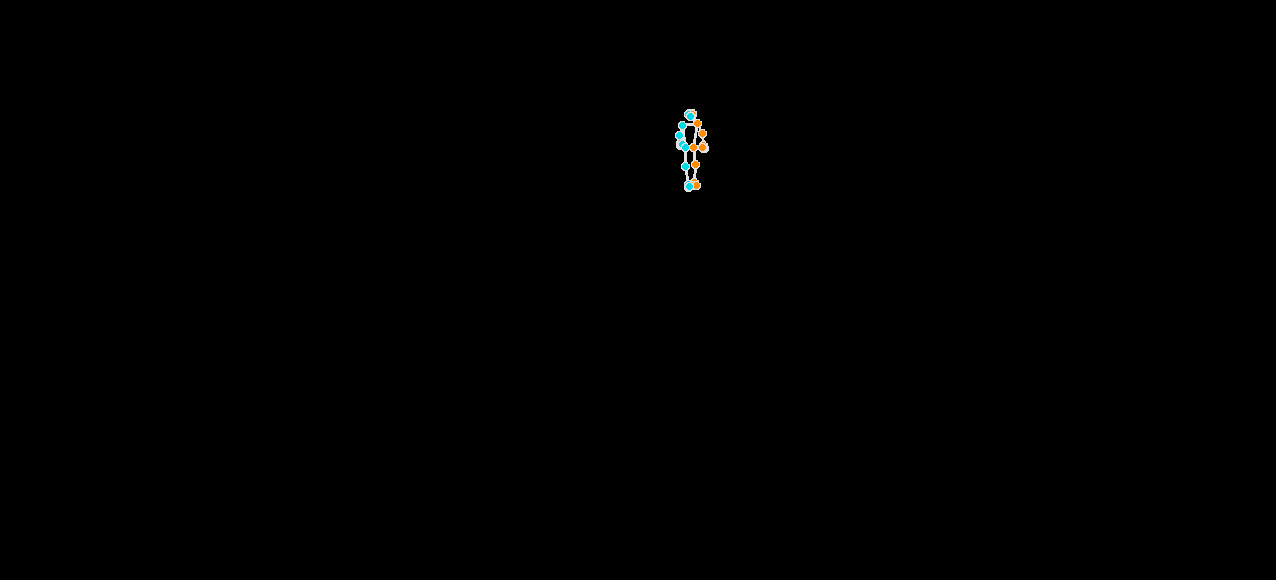

580 1276 3


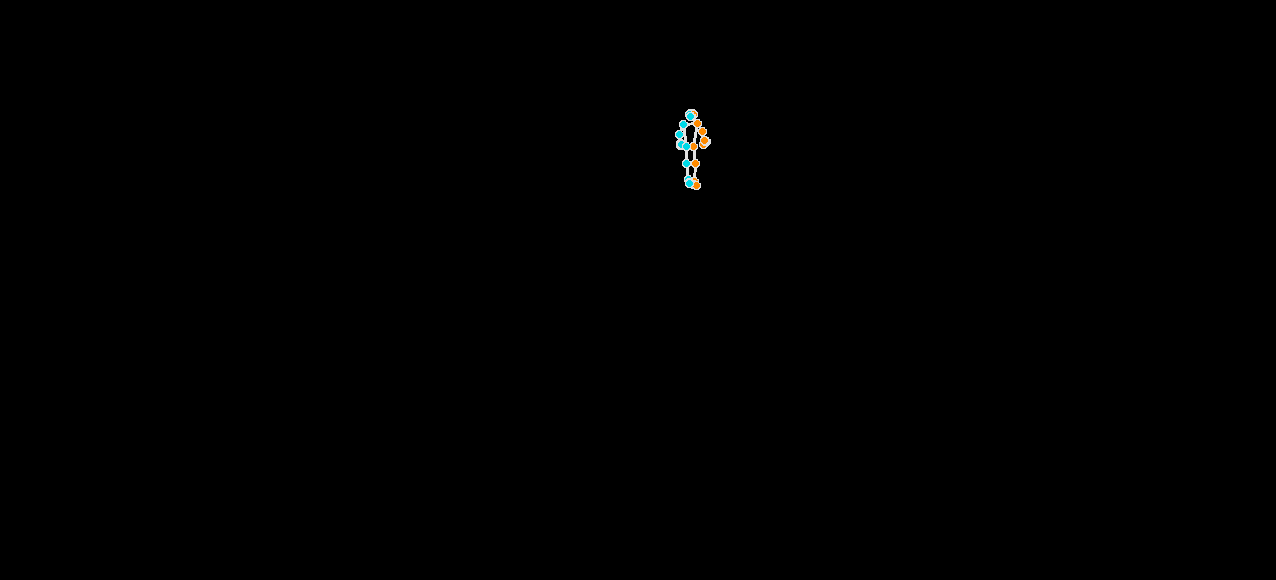

580 1276 3


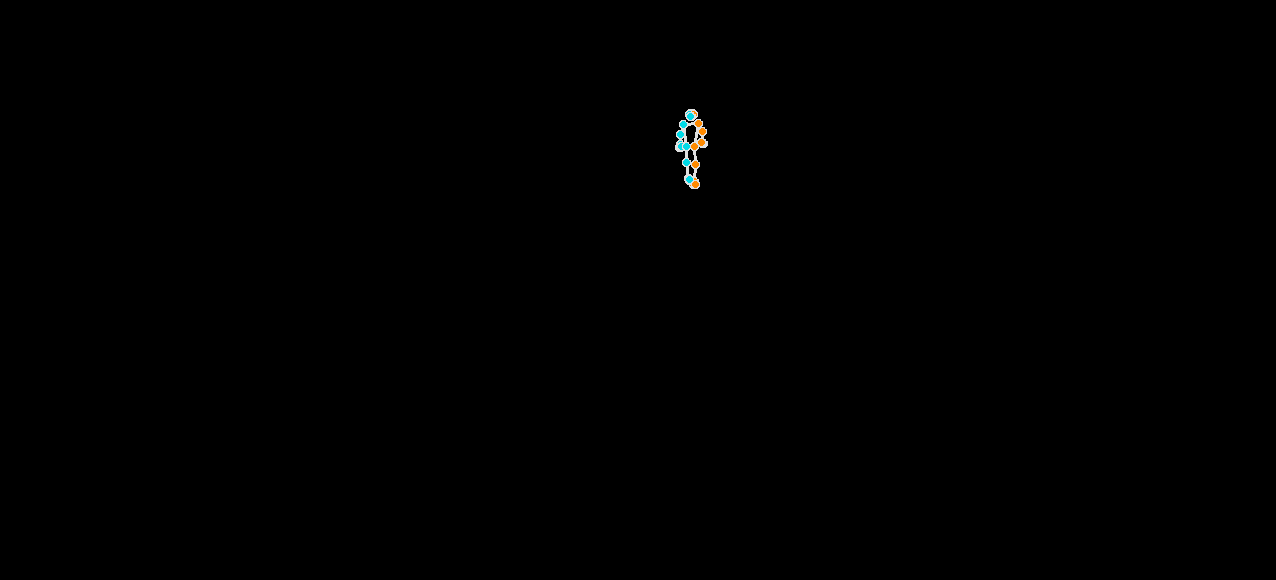

580 1276 3


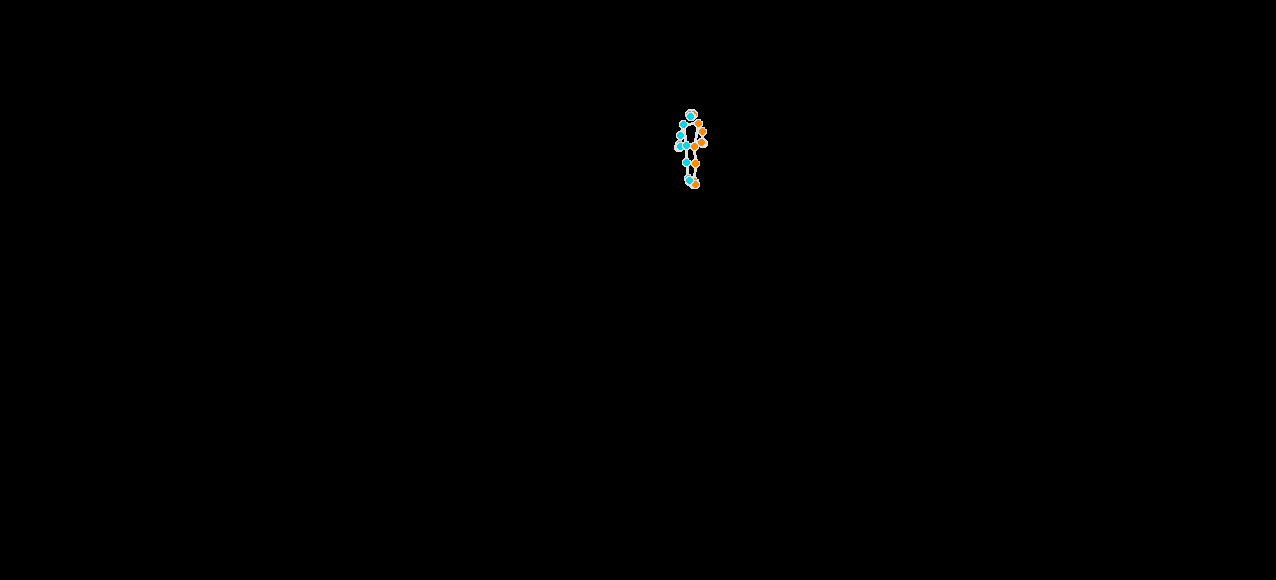

580 1276 3


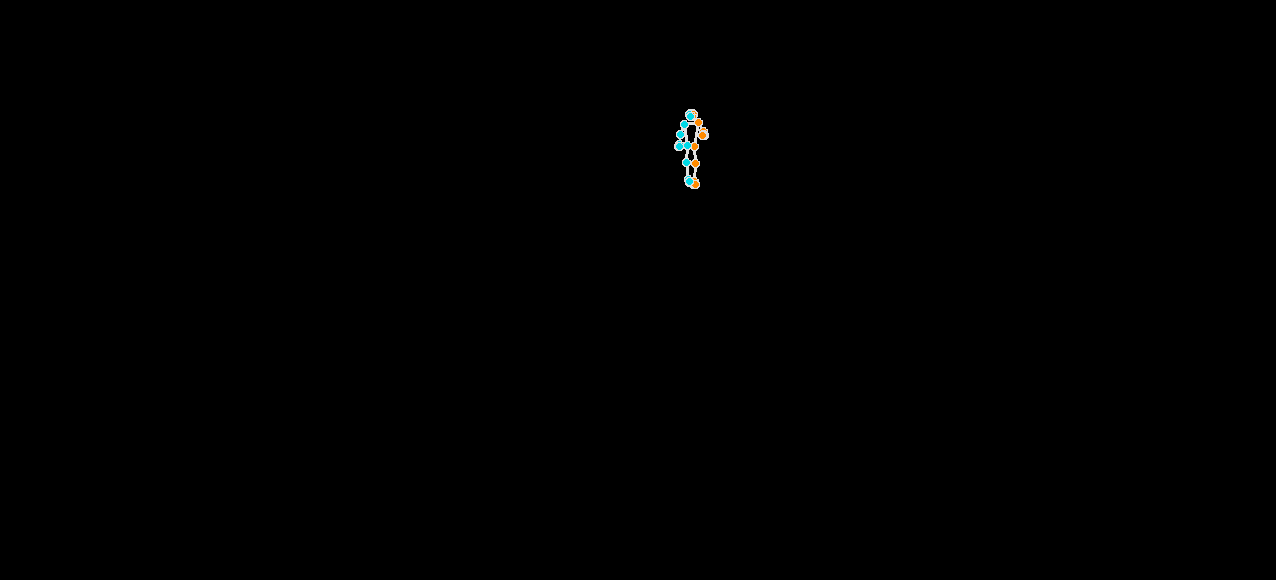

580 1276 3


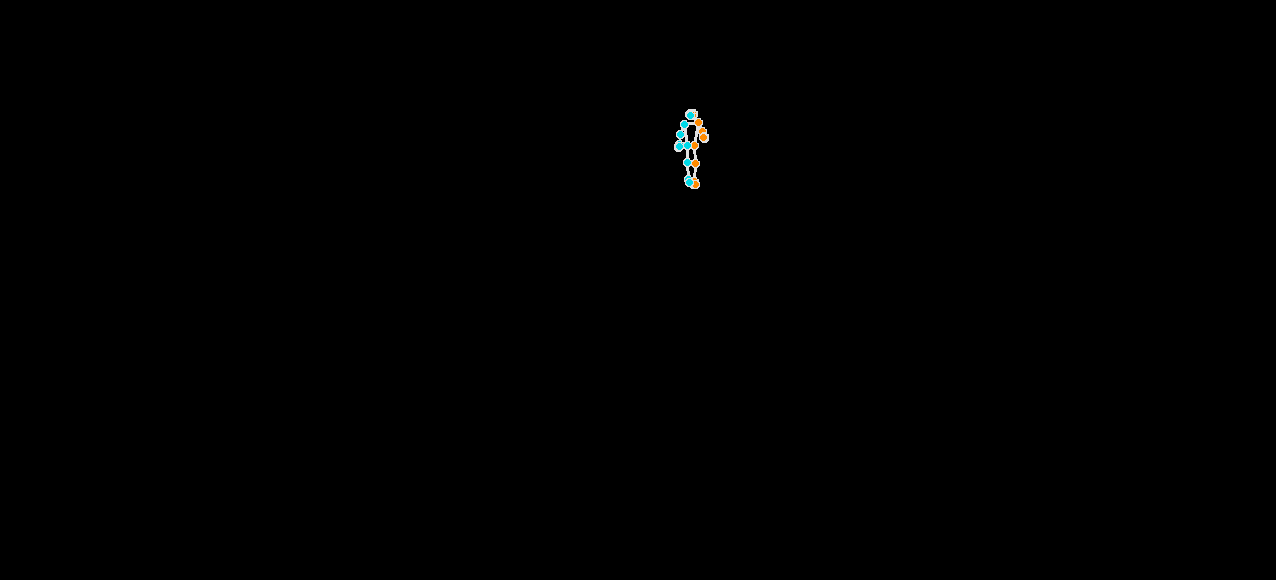

580 1276 3


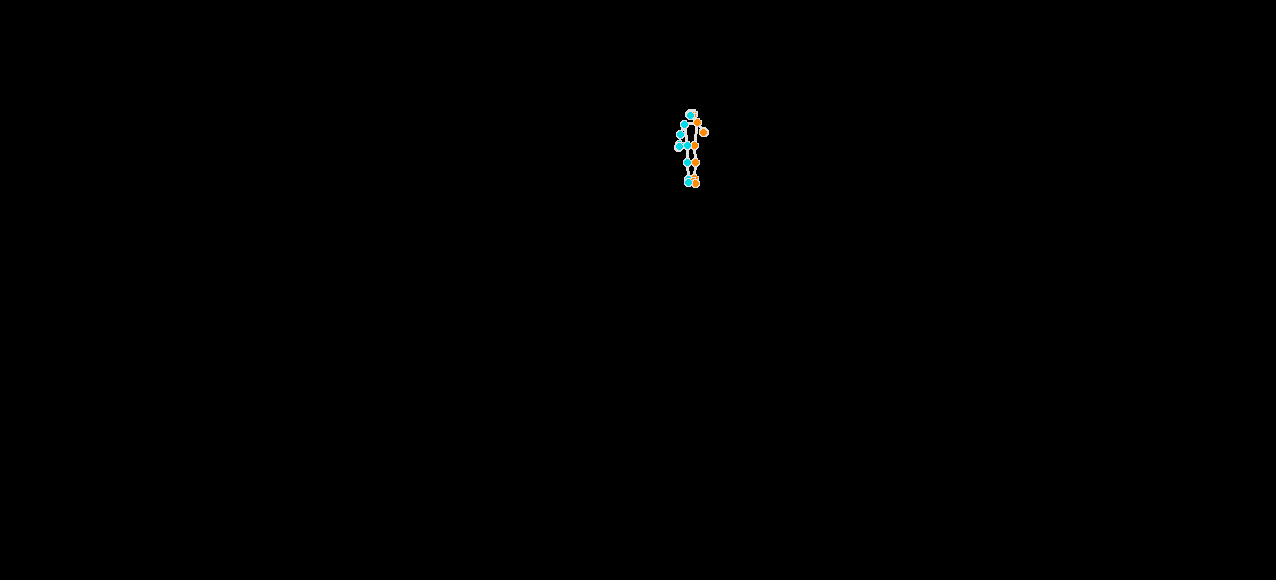

580 1276 3


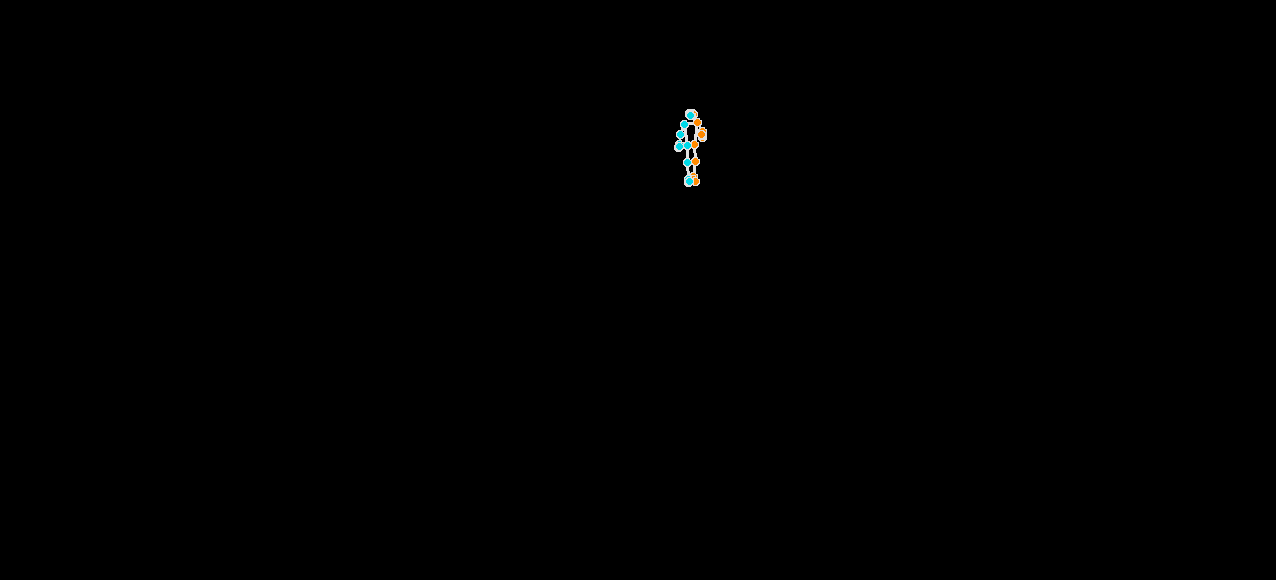

580 1276 3


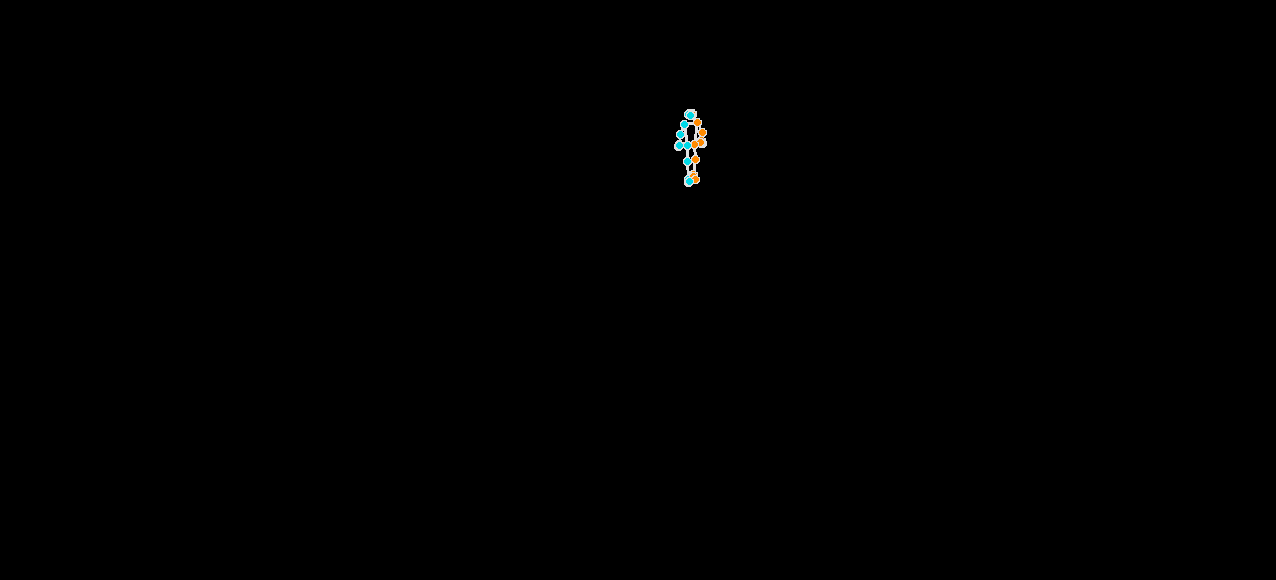

580 1276 3


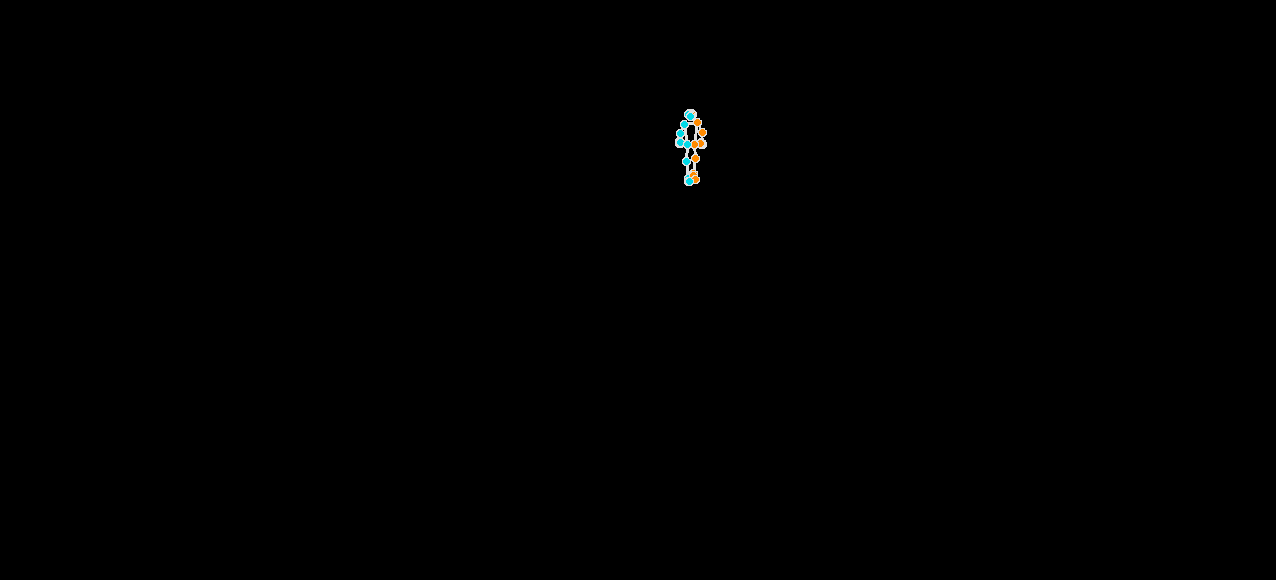

580 1276 3


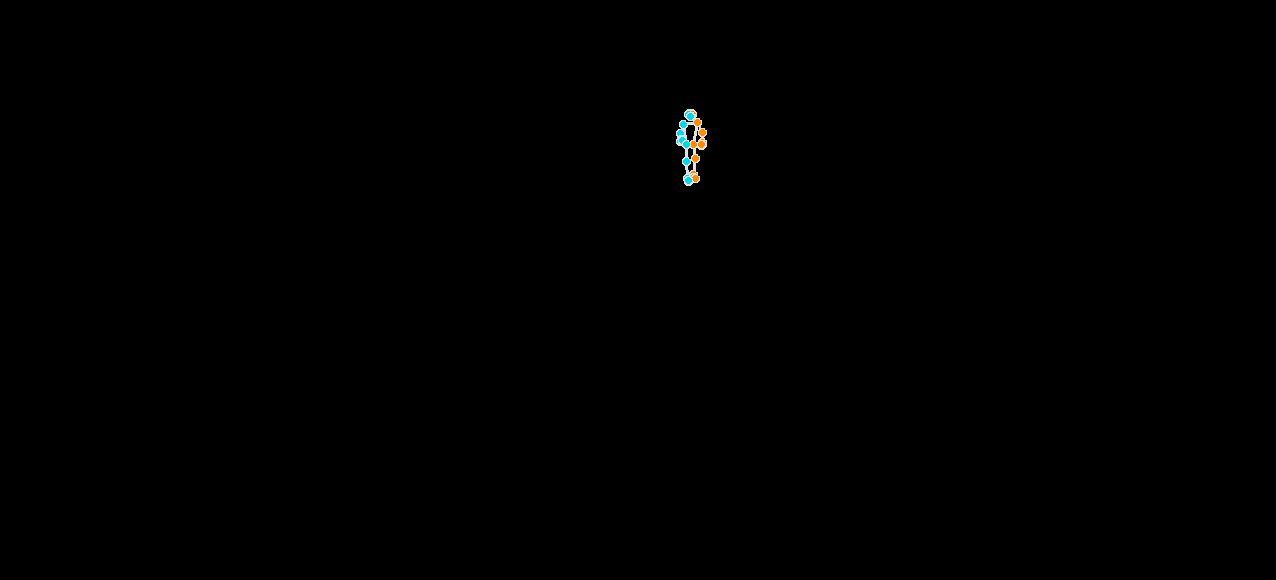

580 1276 3


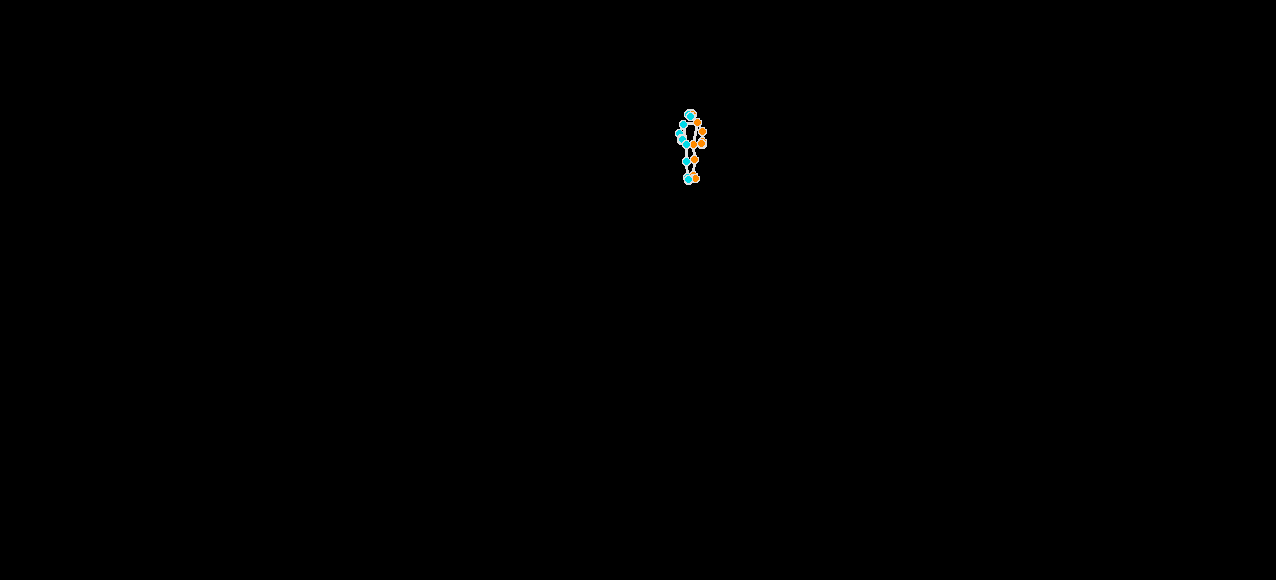

580 1276 3


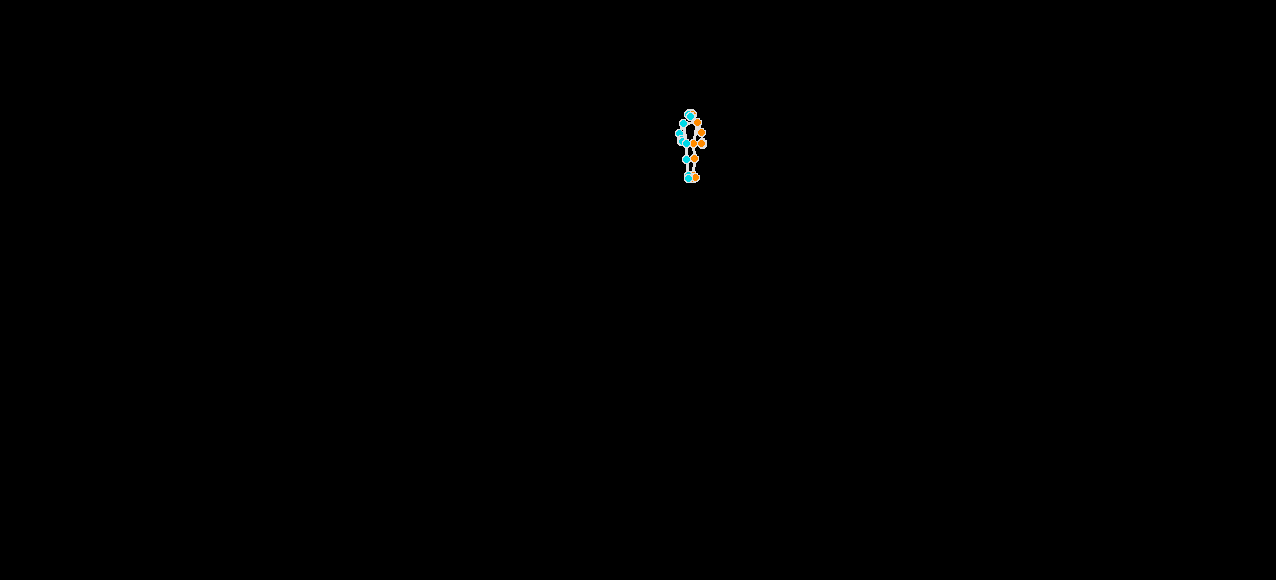

580 1276 3


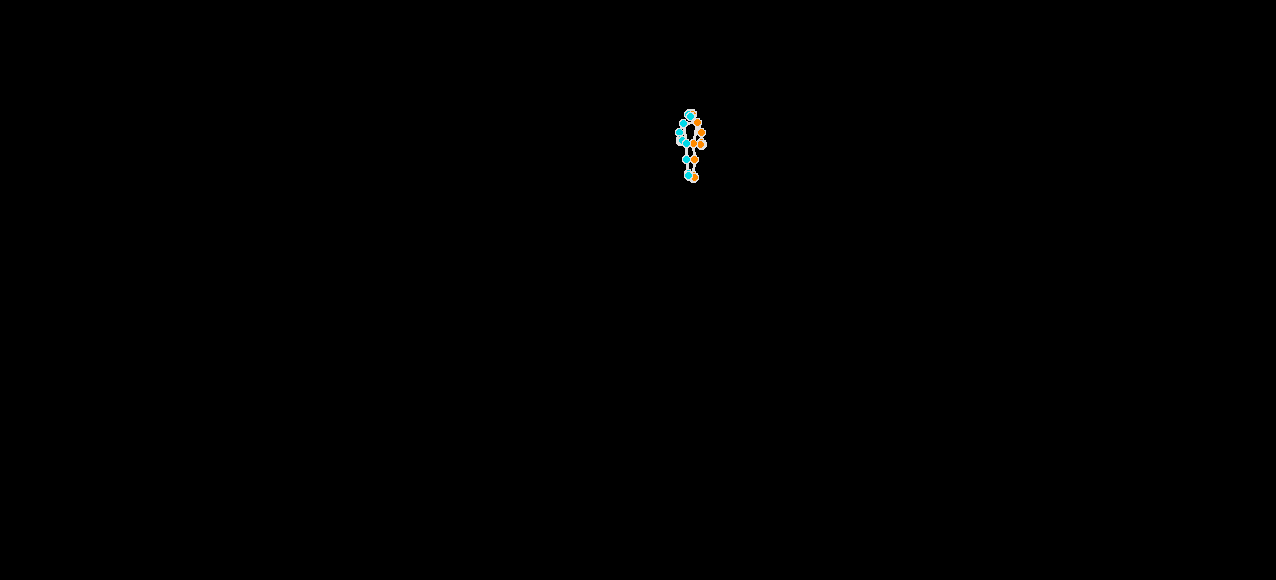

580 1276 3


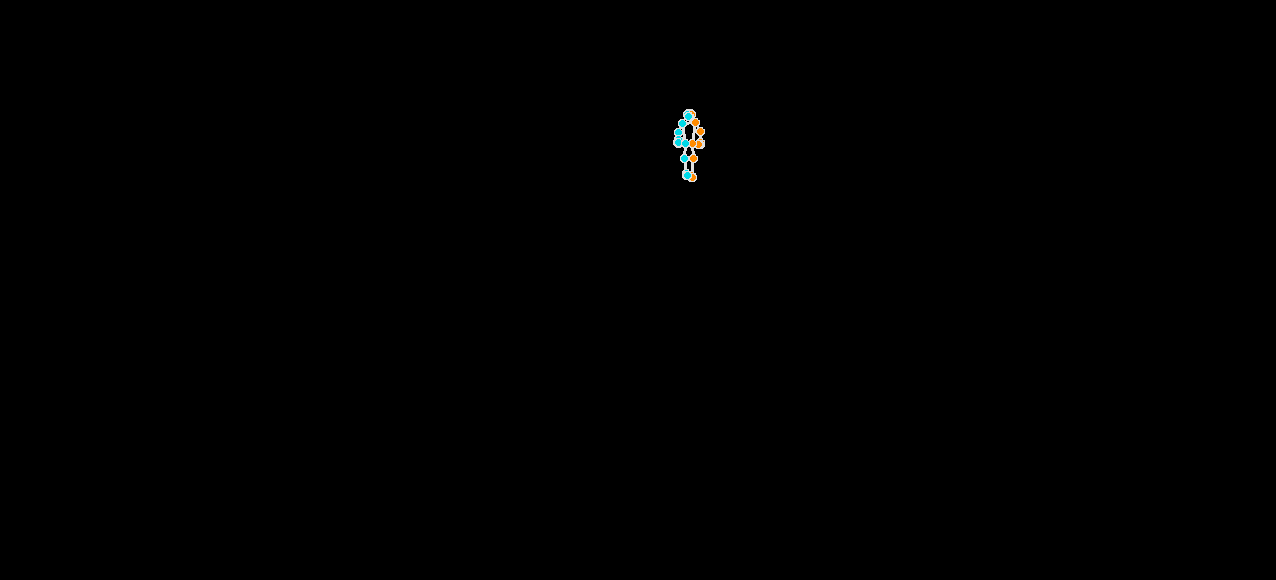

580 1276 3


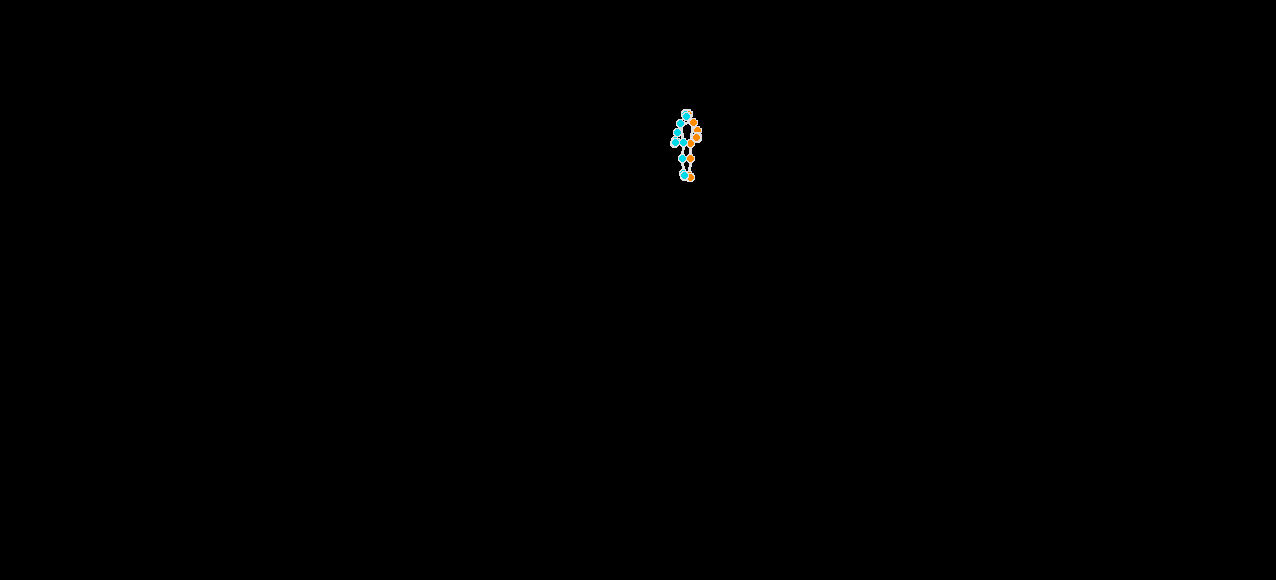

580 1276 3


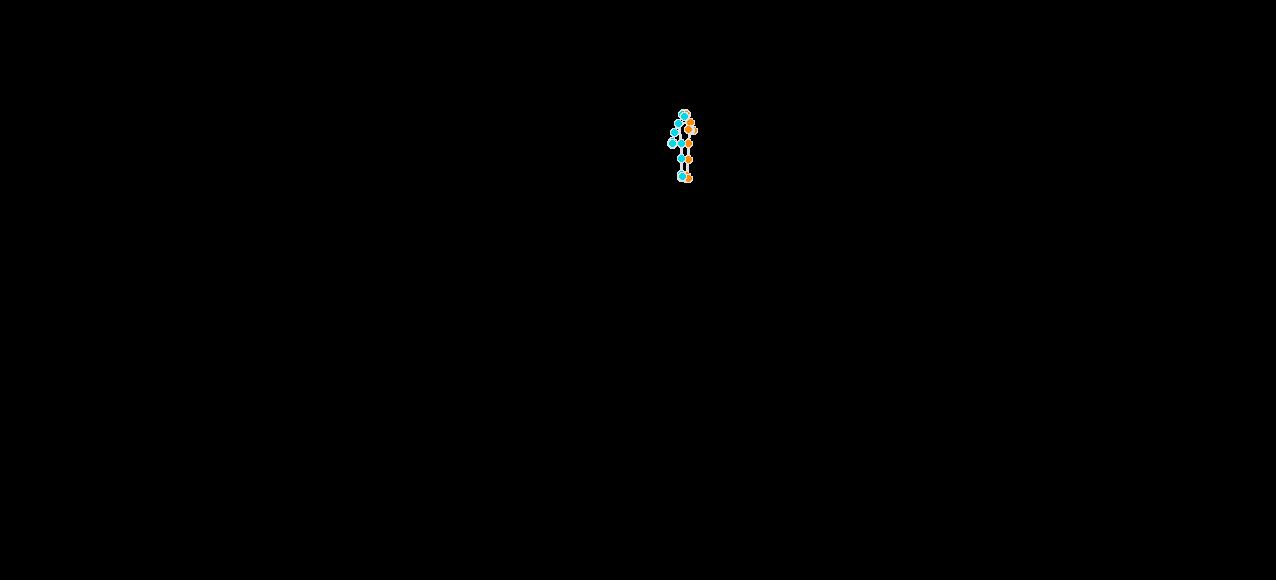

580 1276 3


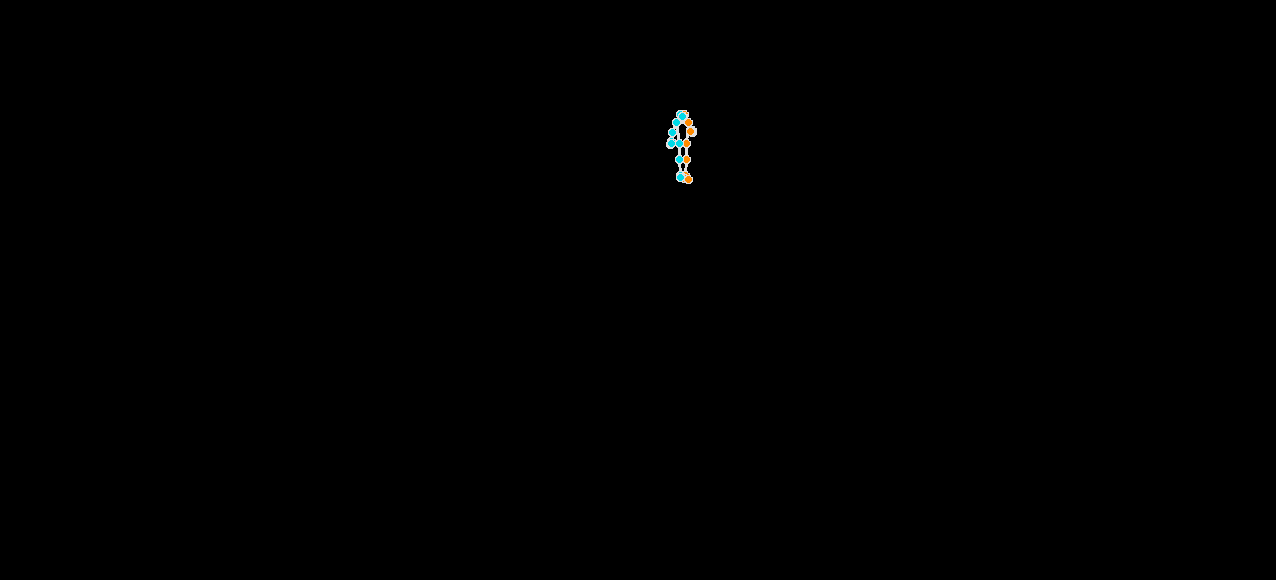

580 1276 3


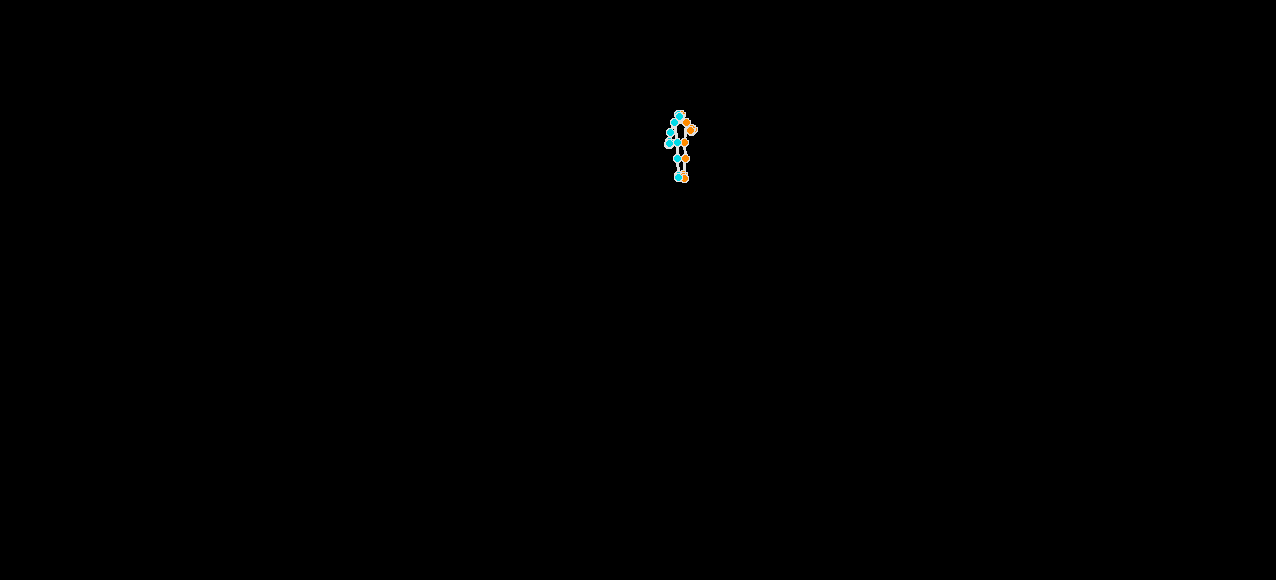

580 1276 3


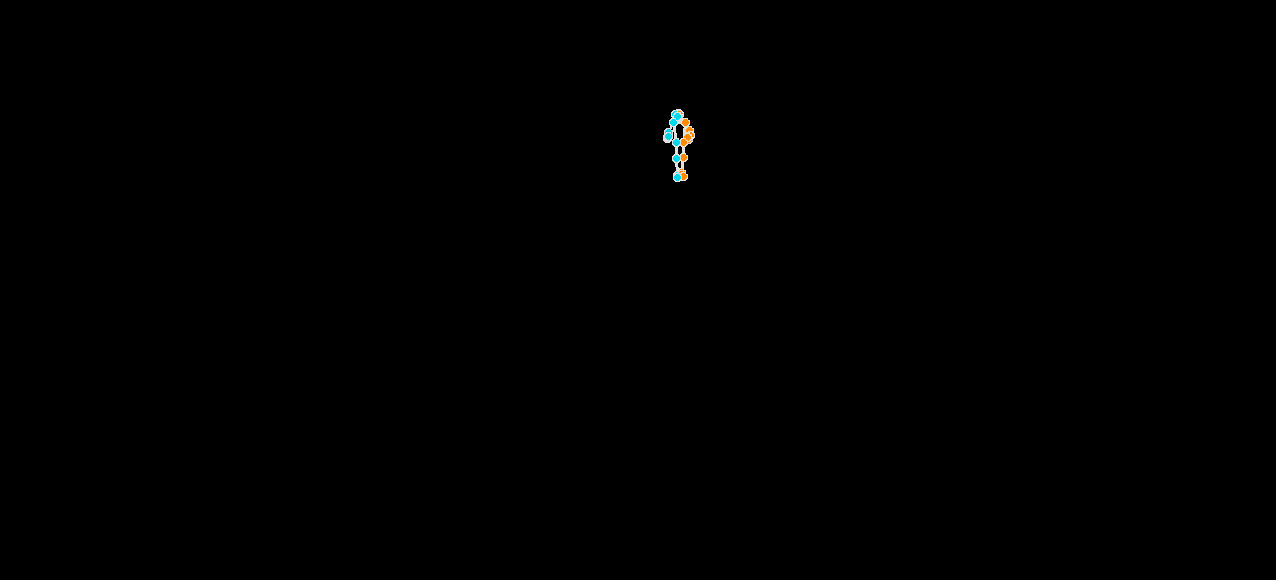

580 1276 3


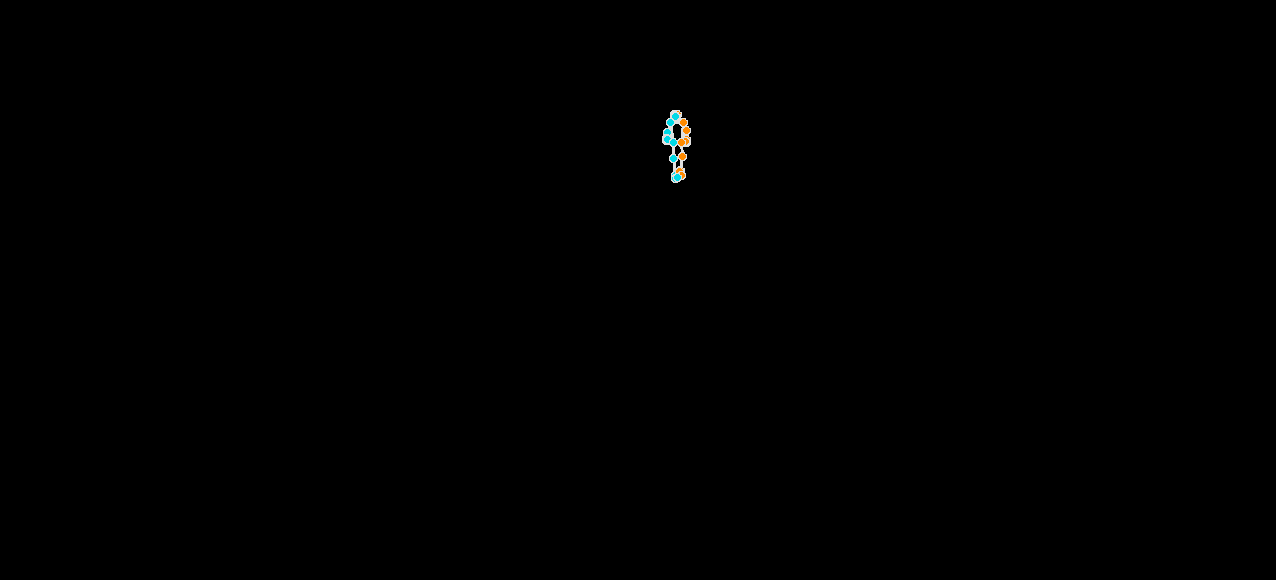

580 1276 3


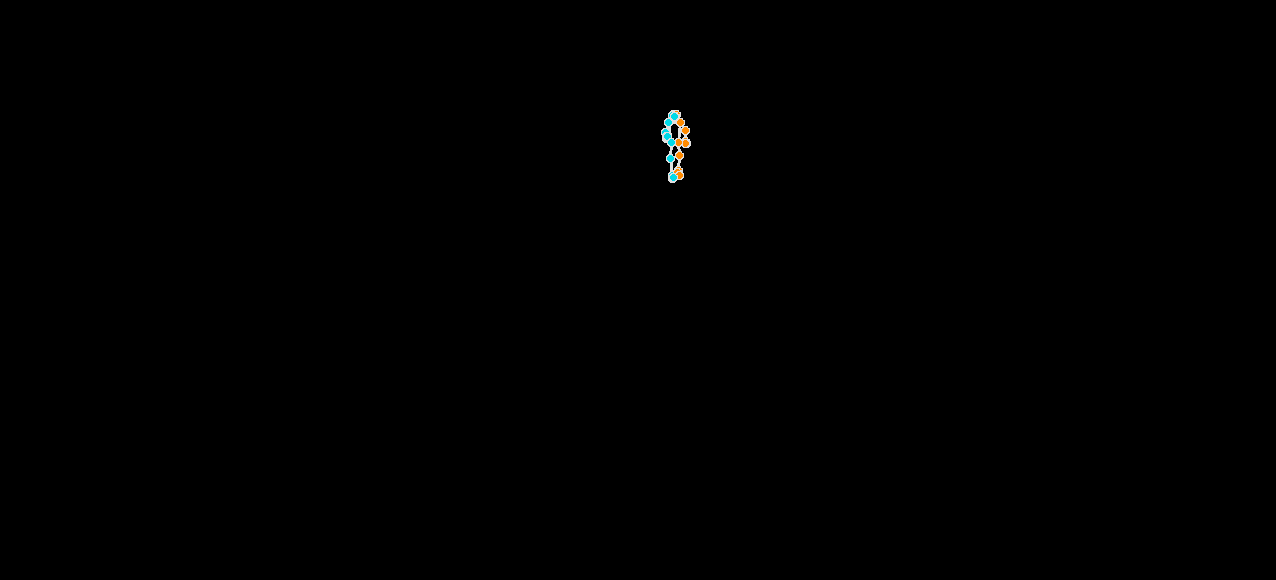

580 1276 3


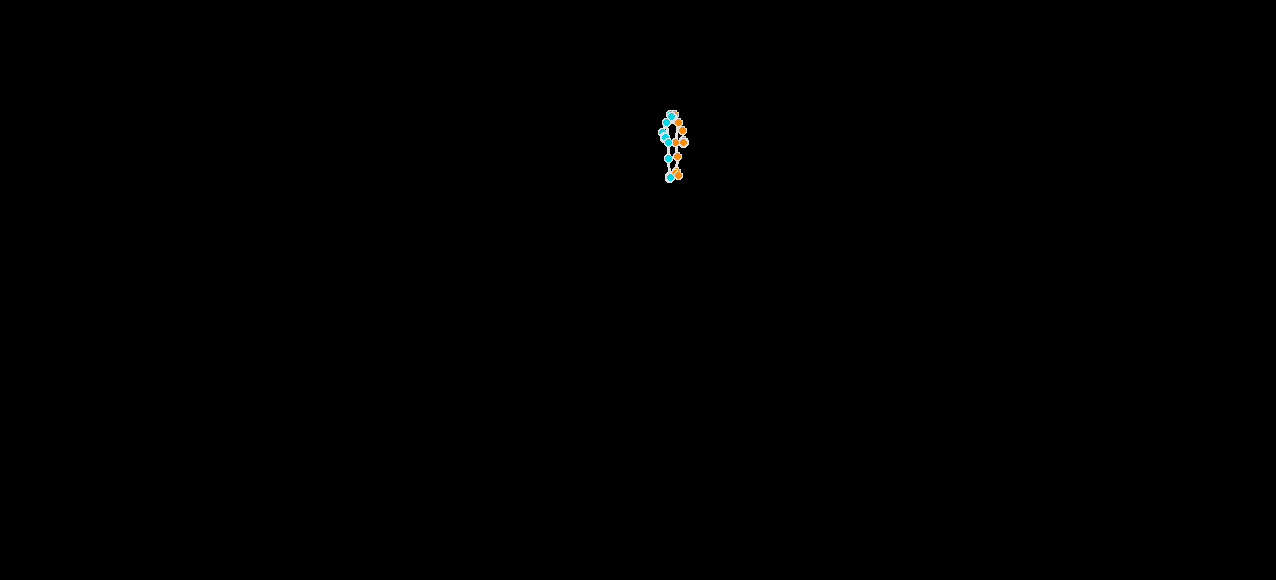

580 1276 3


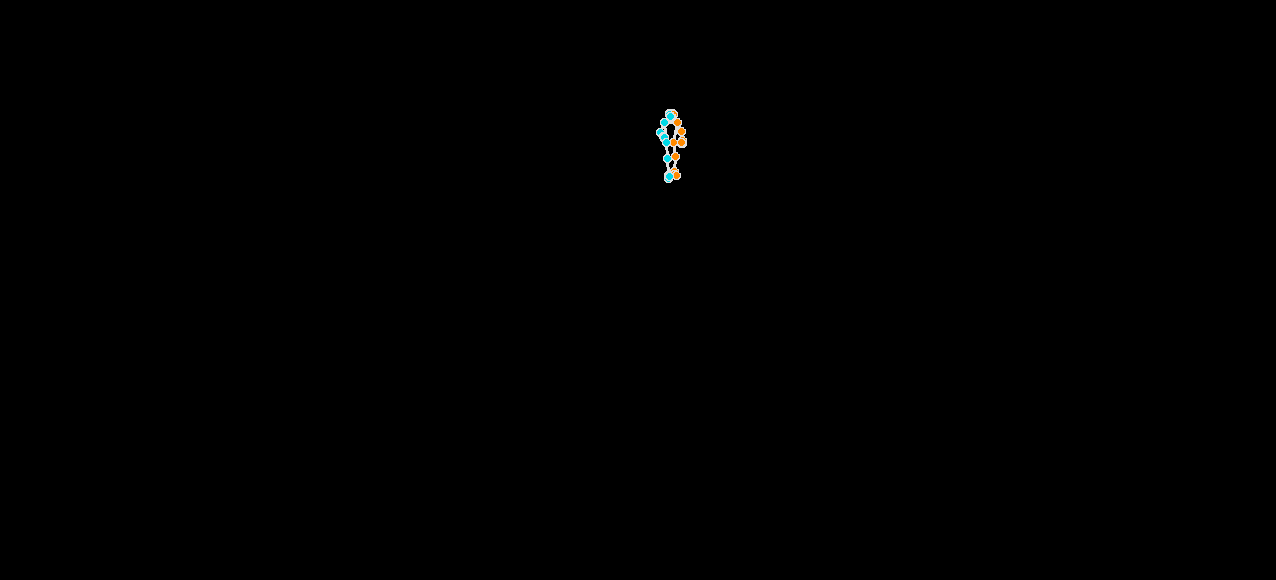

580 1276 3


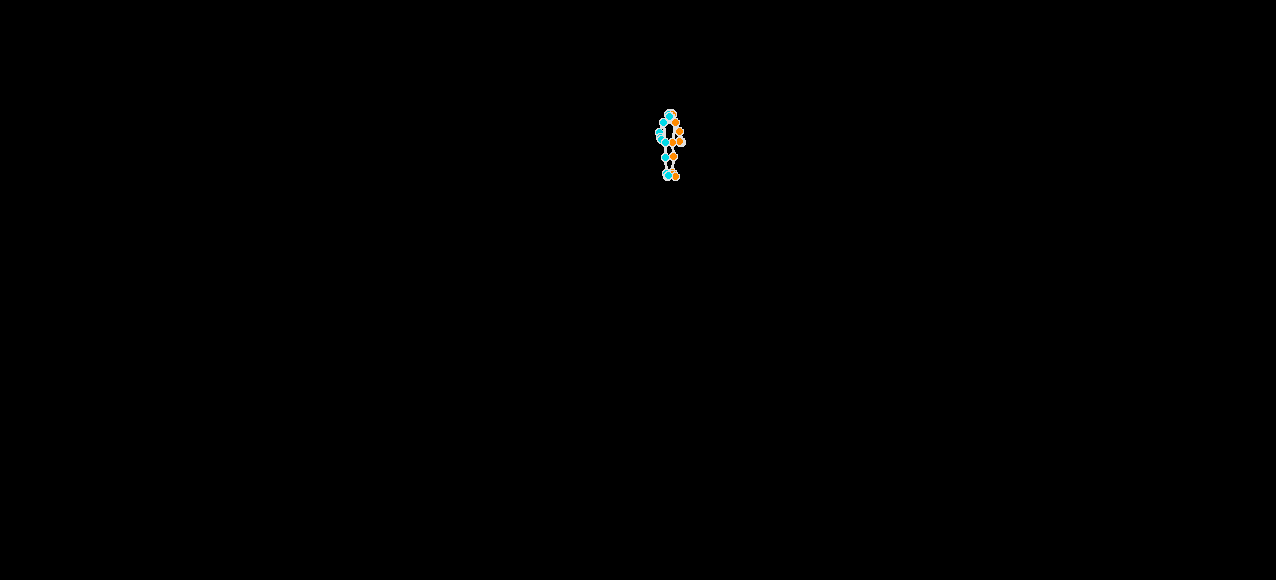

580 1276 3


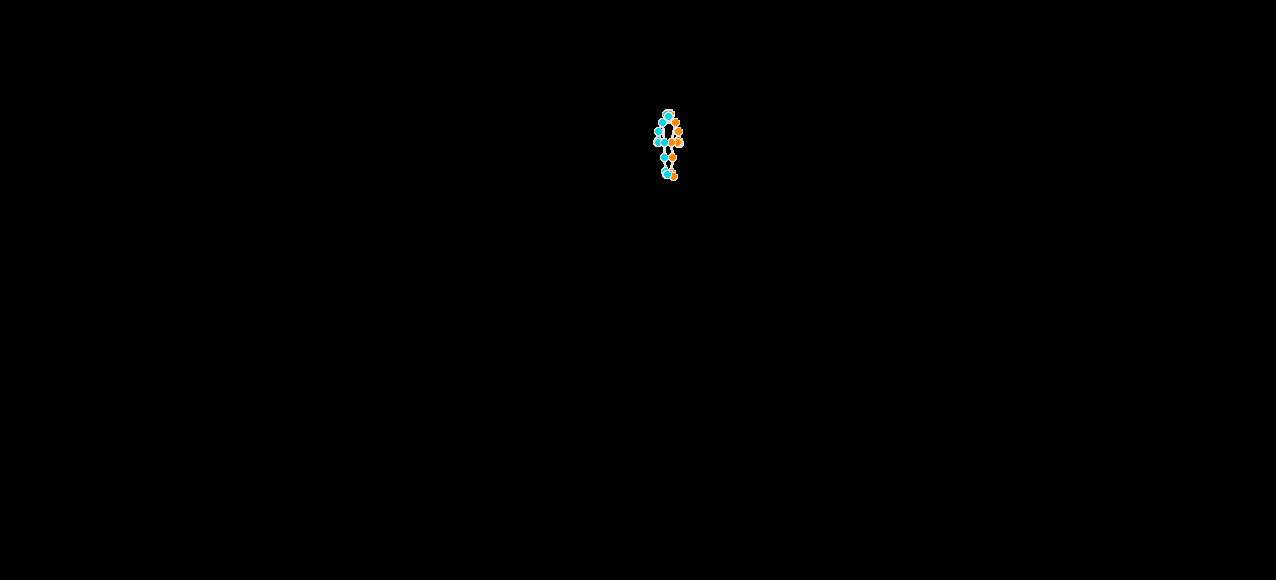

580 1276 3


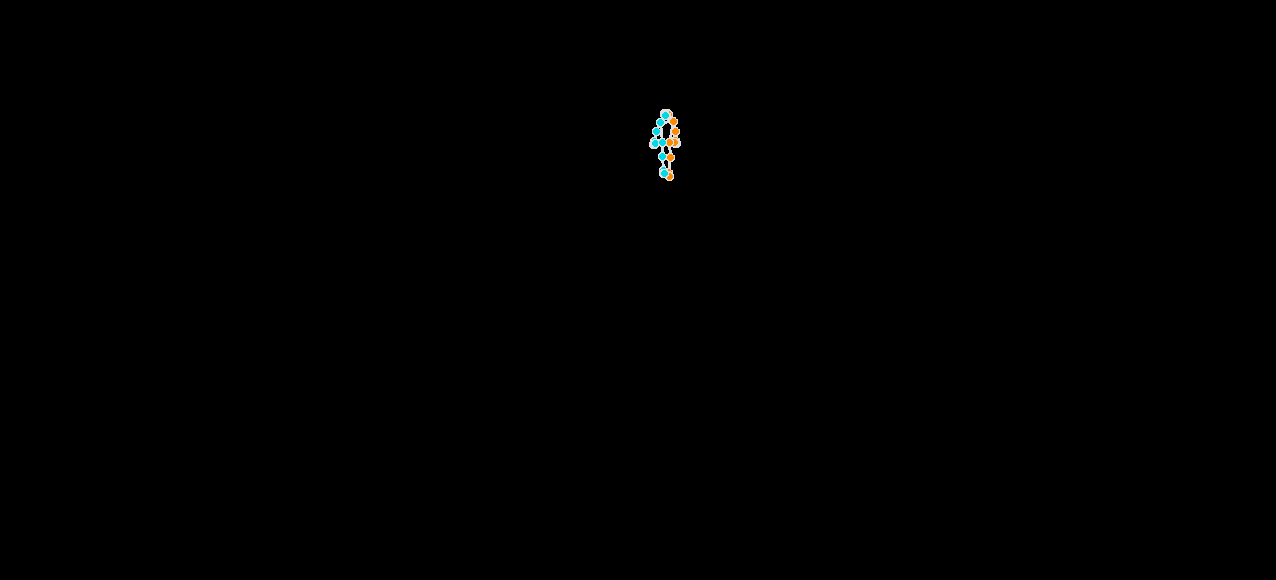

580 1276 3


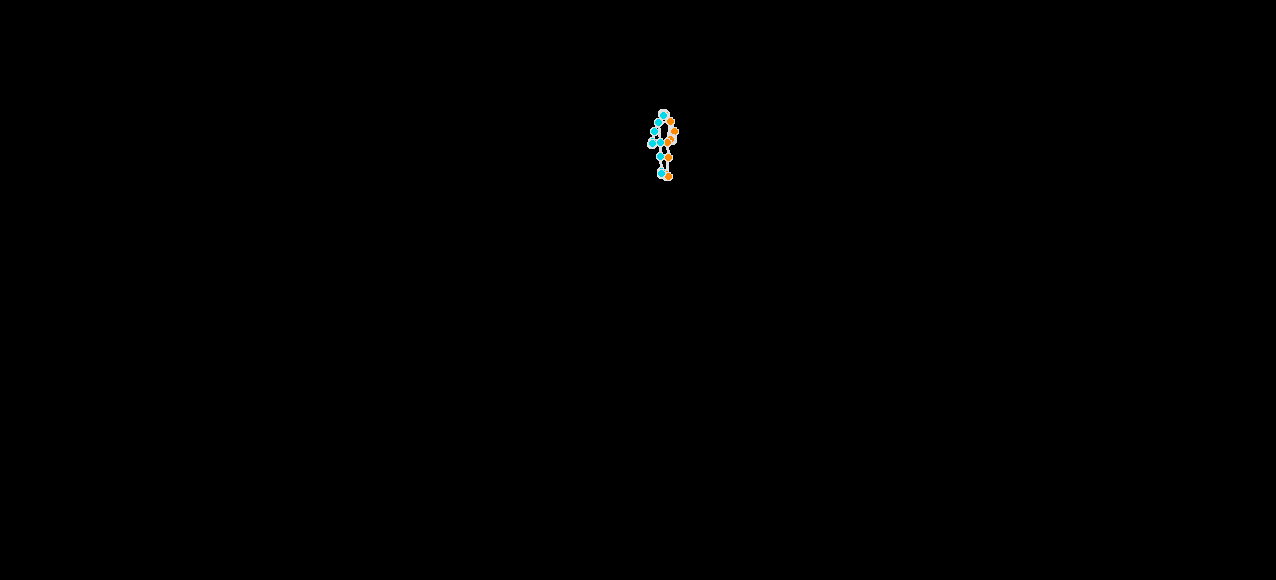

580 1276 3


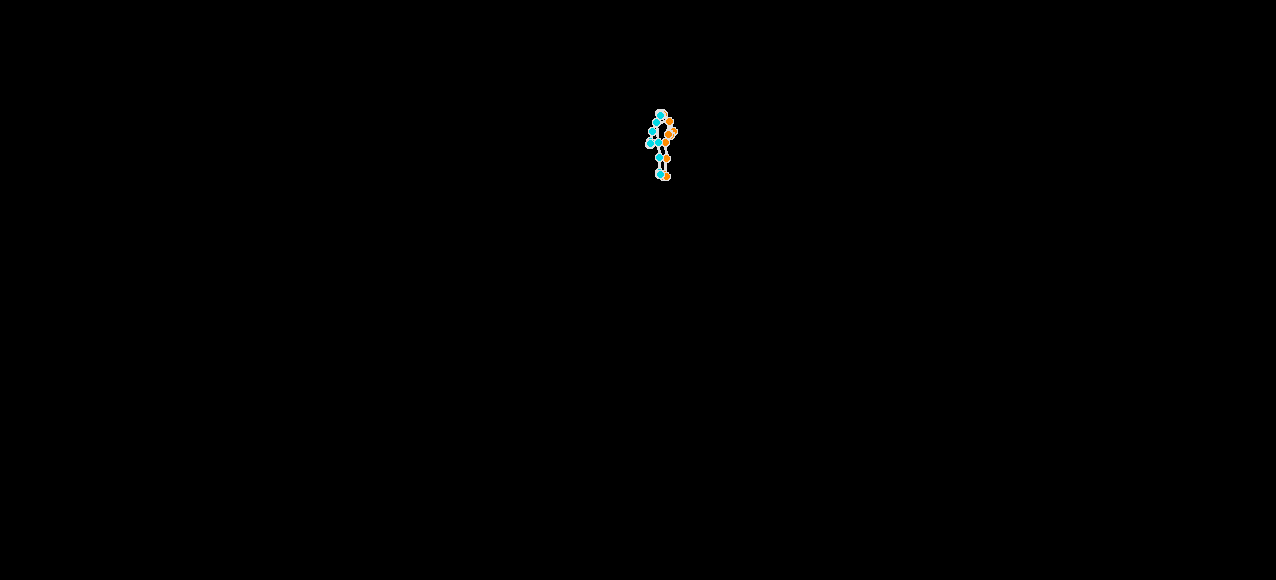

580 1276 3


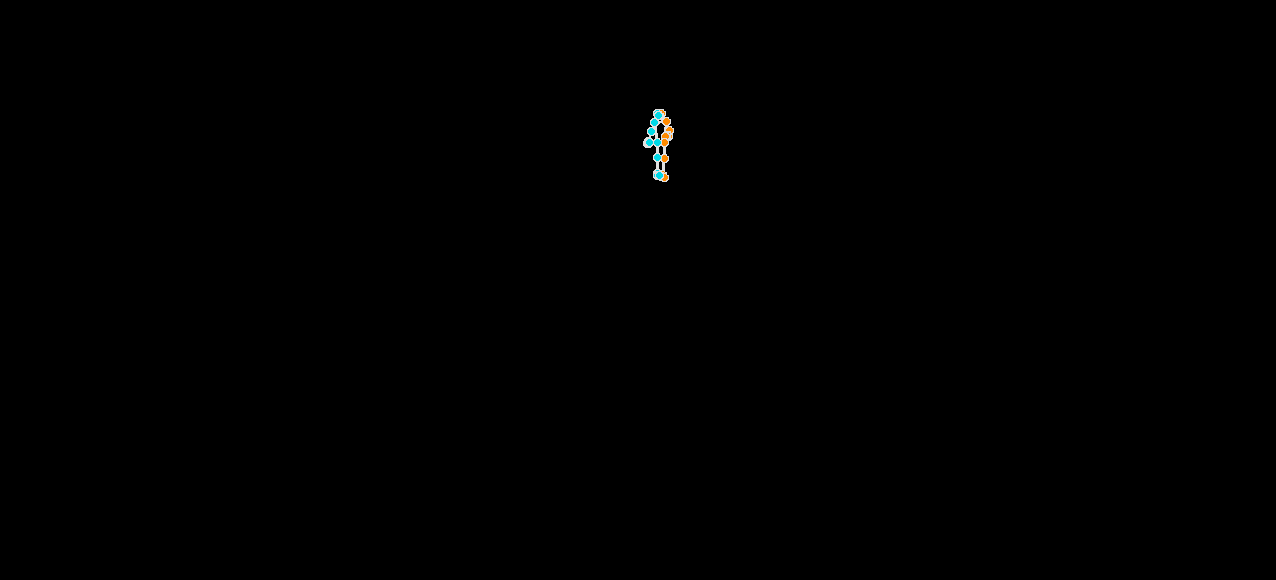

580 1276 3


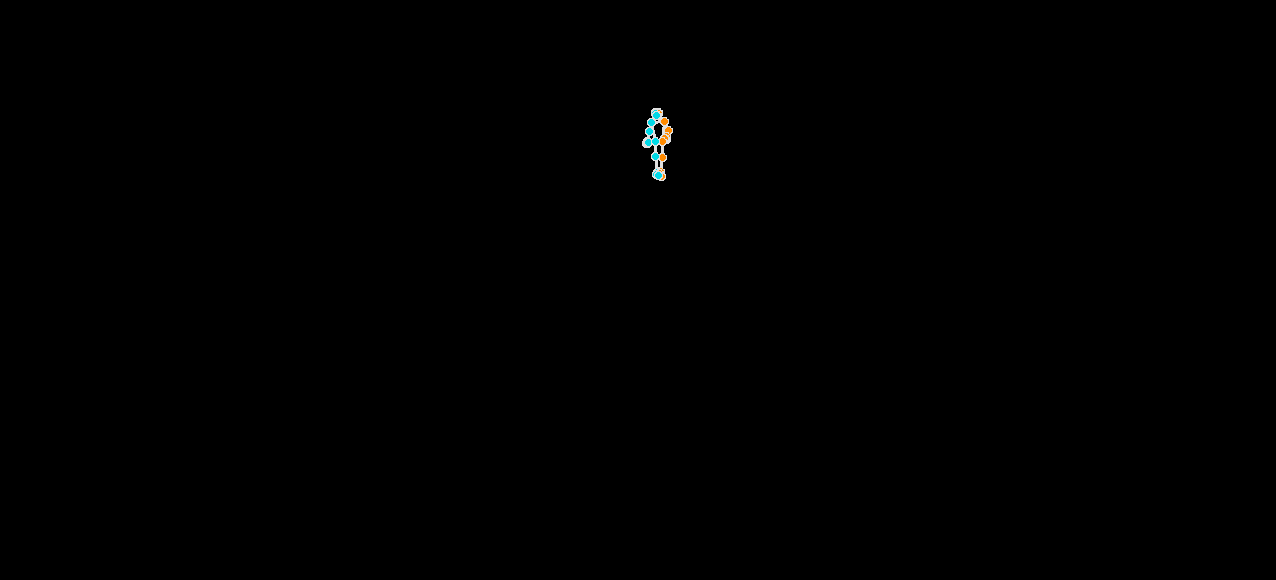

580 1276 3


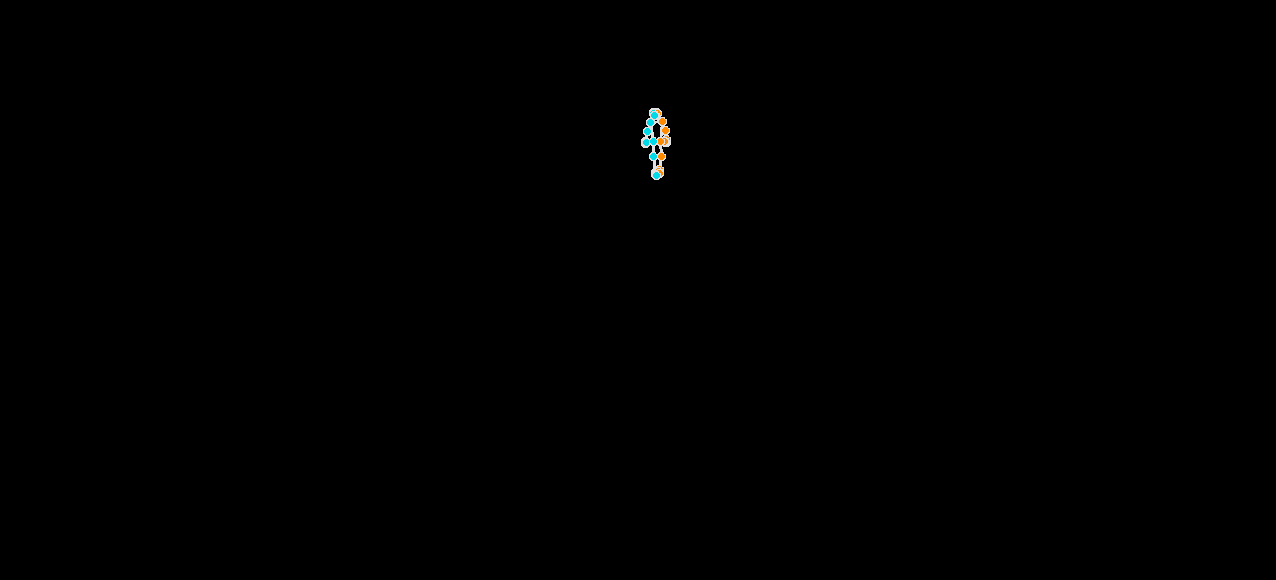

580 1276 3


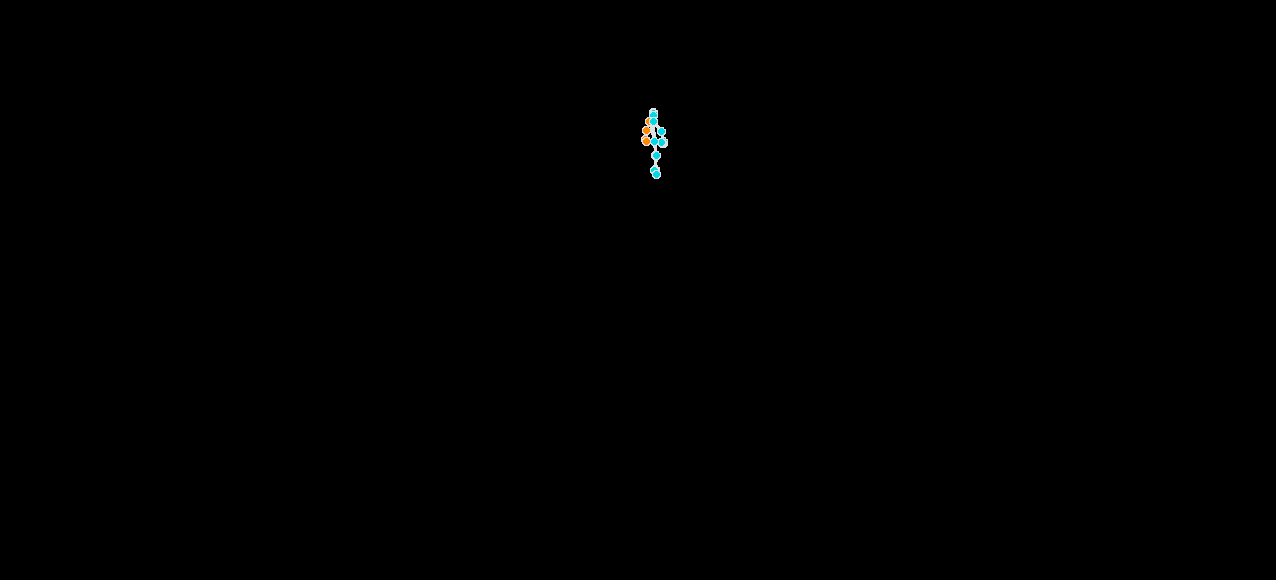

580 1276 3


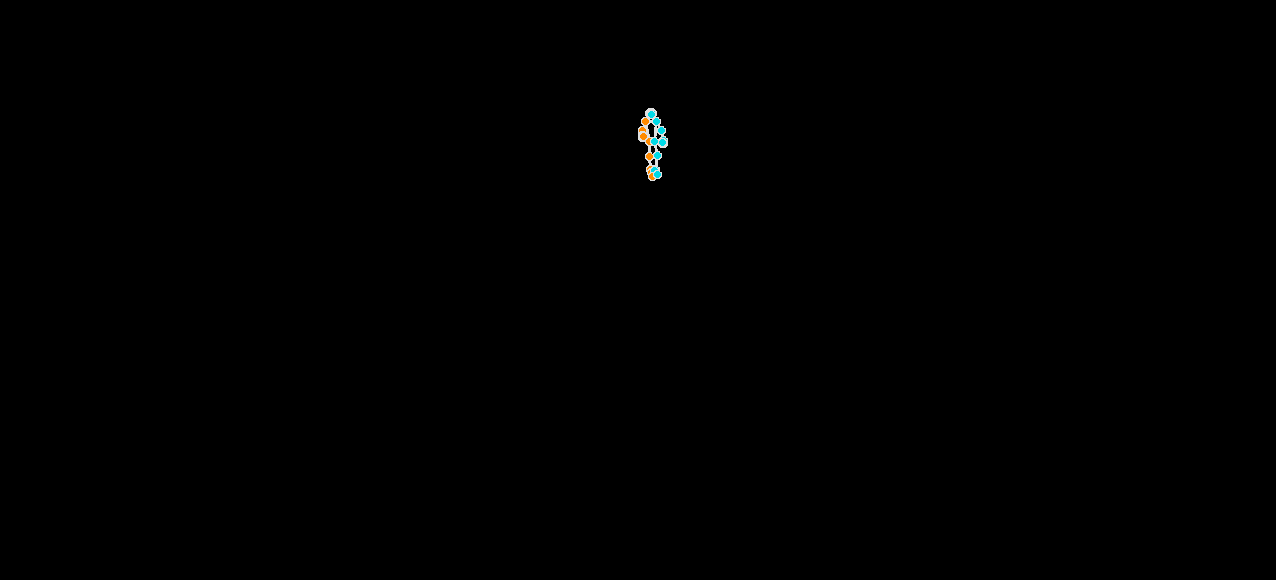

580 1276 3


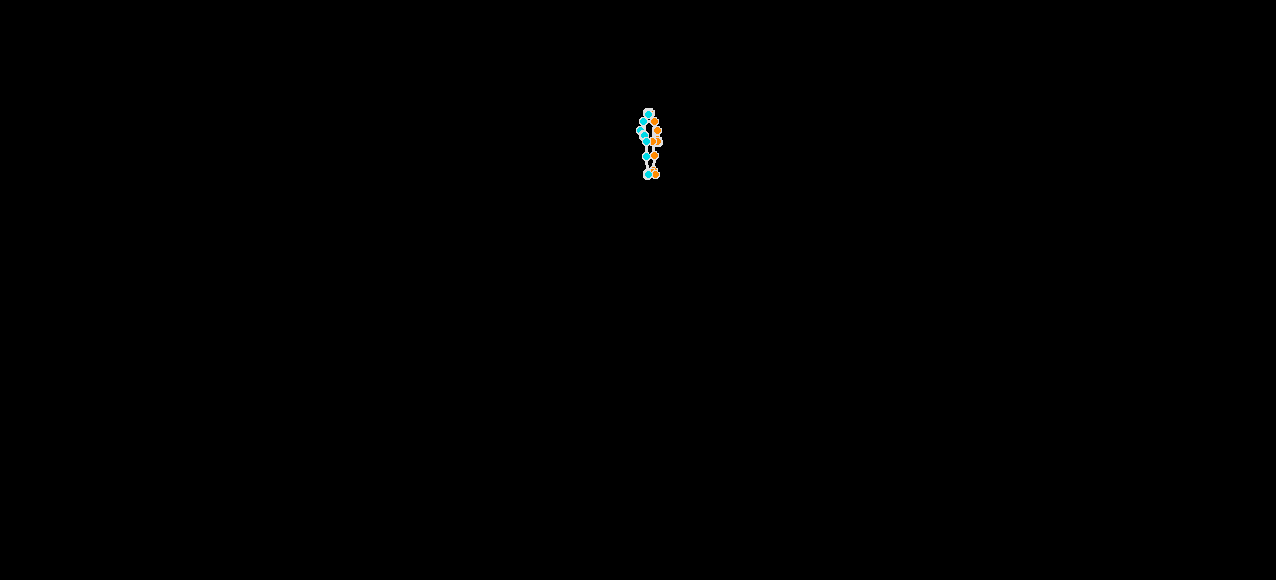

580 1276 3


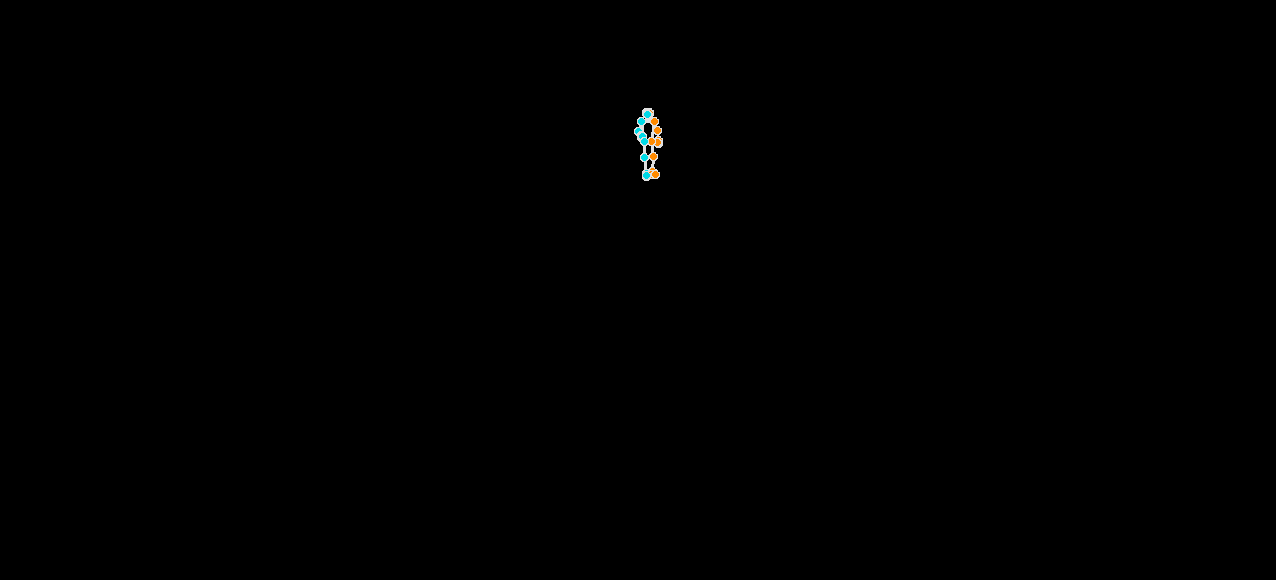

580 1276 3


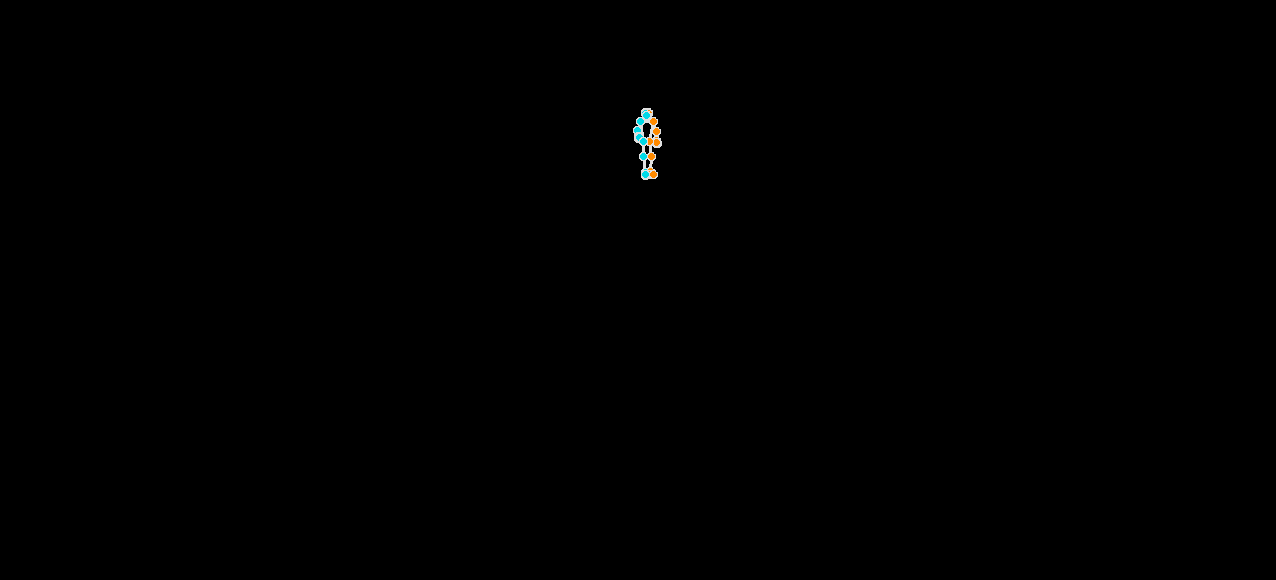

580 1276 3


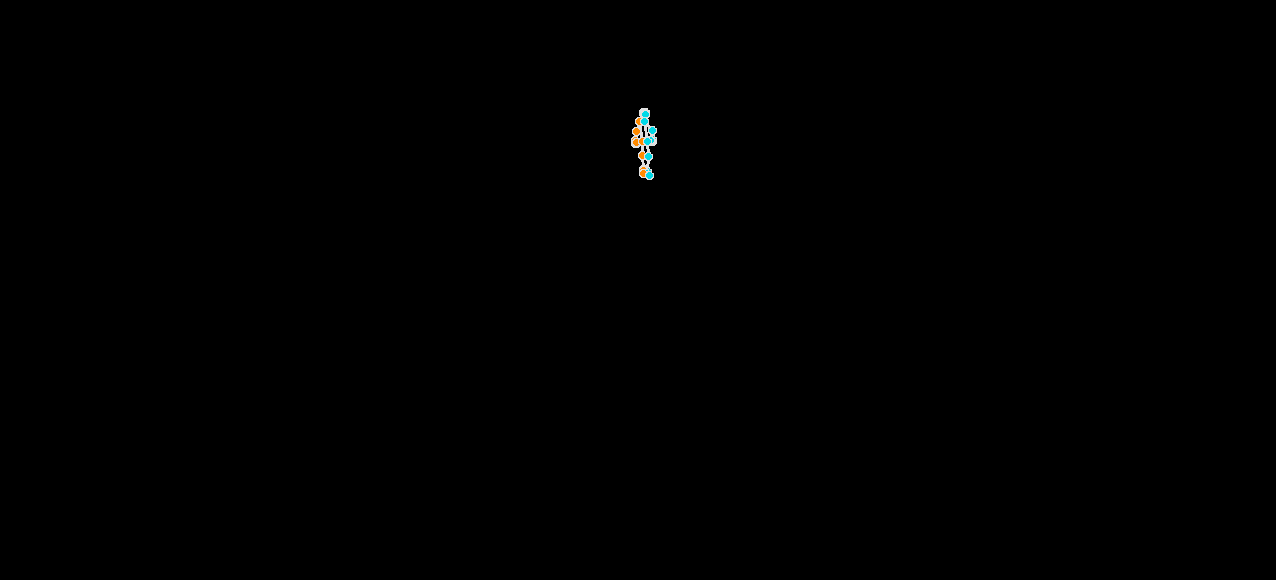

580 1276 3


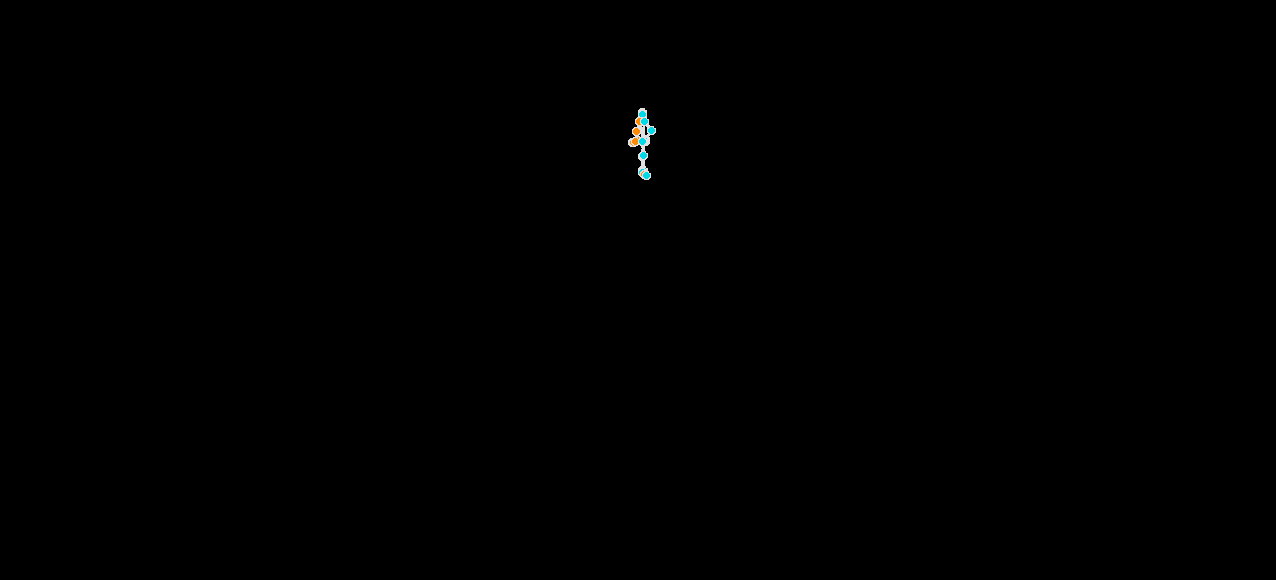

580 1276 3


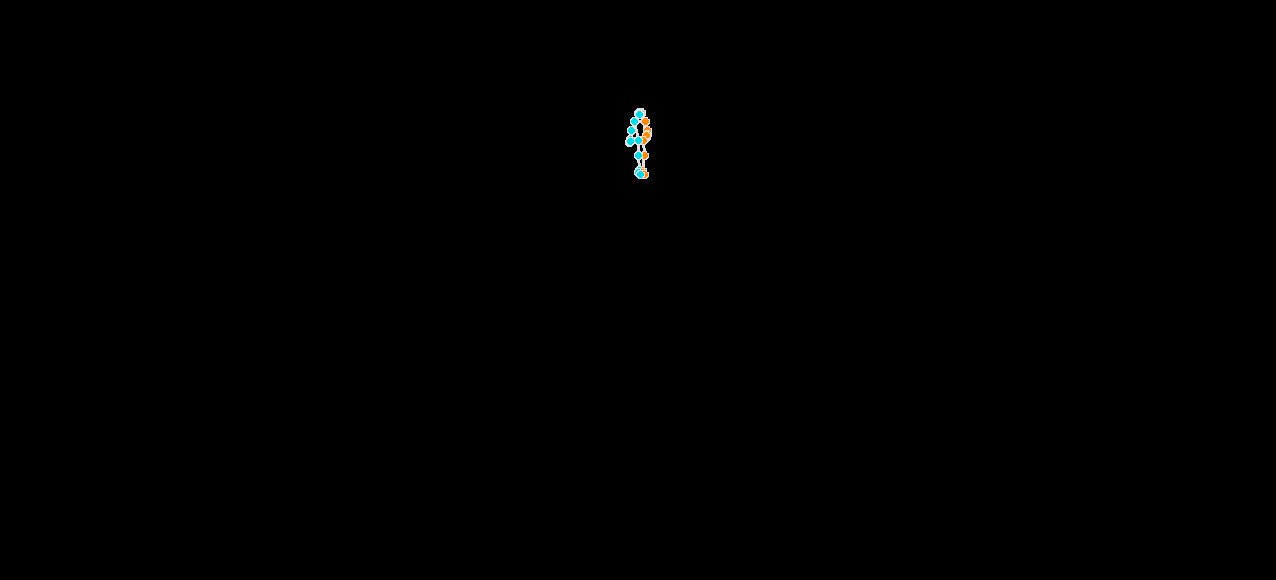

580 1276 3


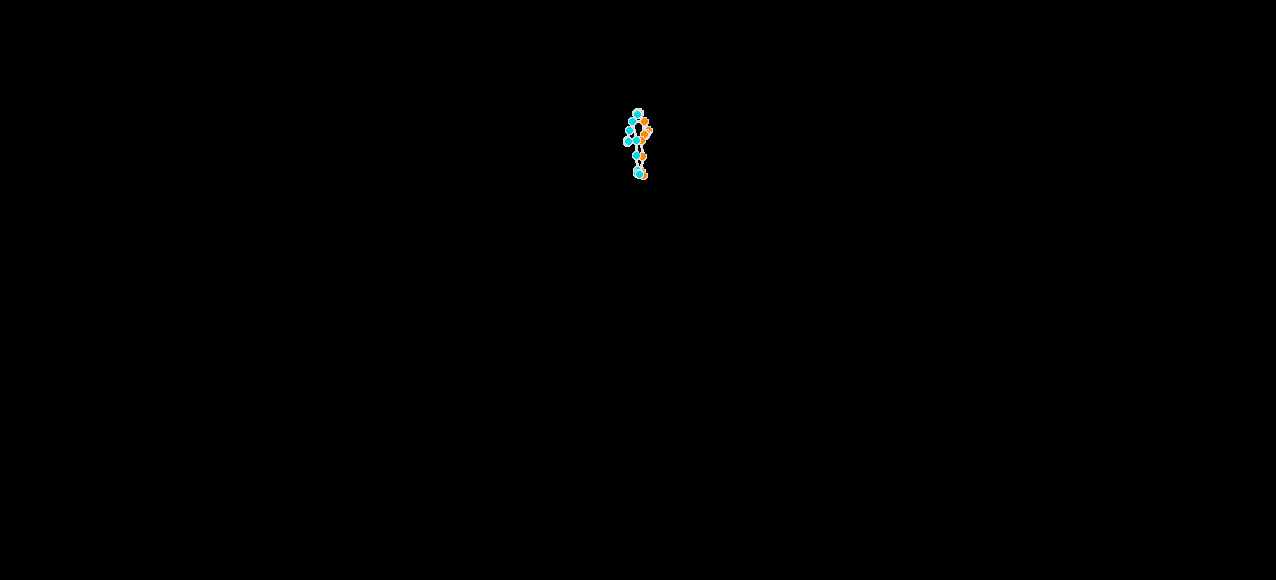

580 1276 3


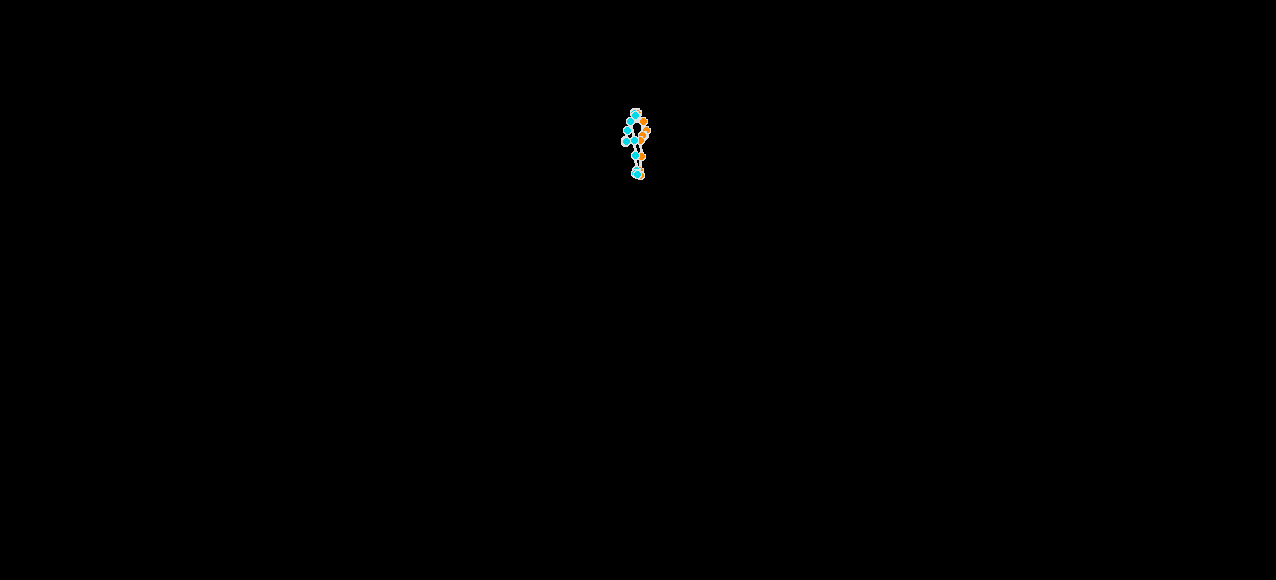

580 1276 3


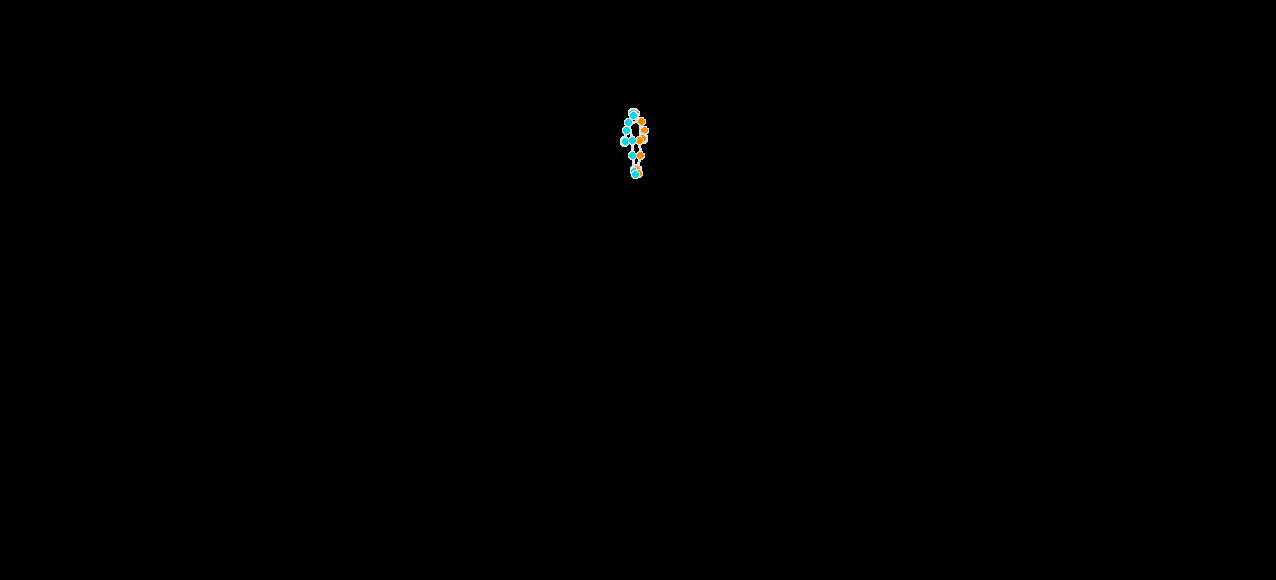

580 1276 3


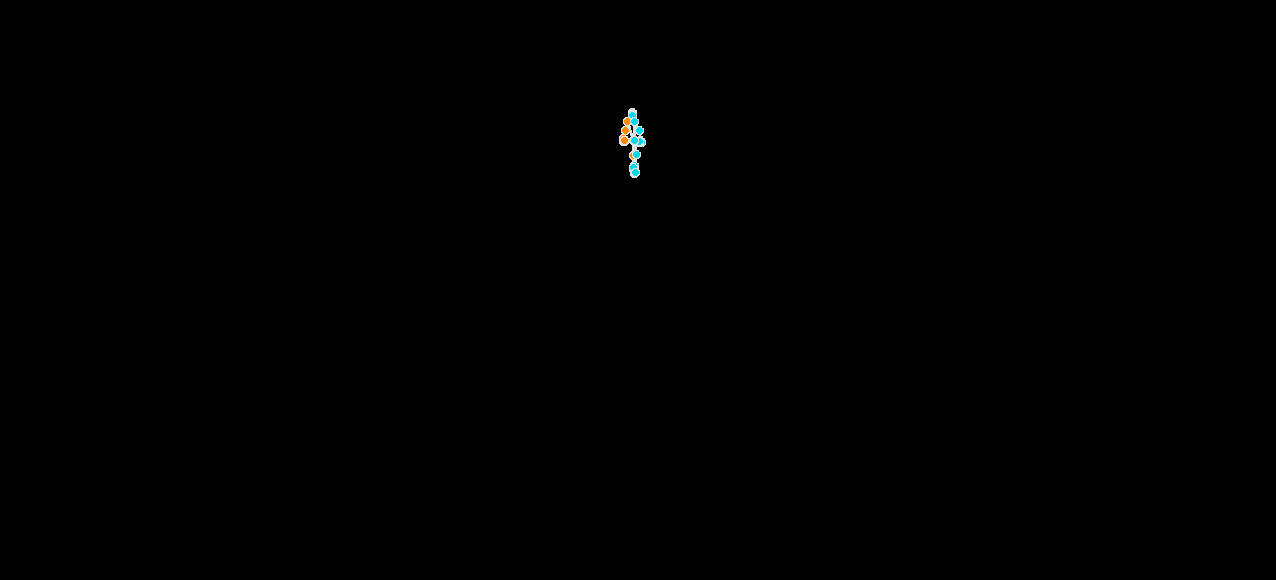

580 1276 3


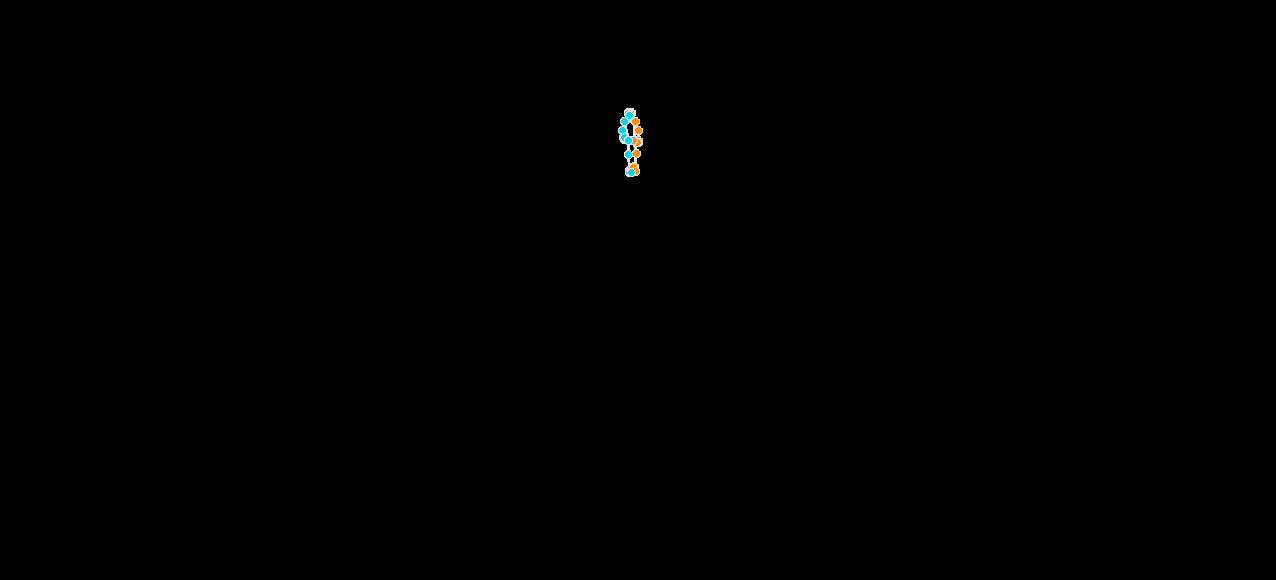

580 1276 3


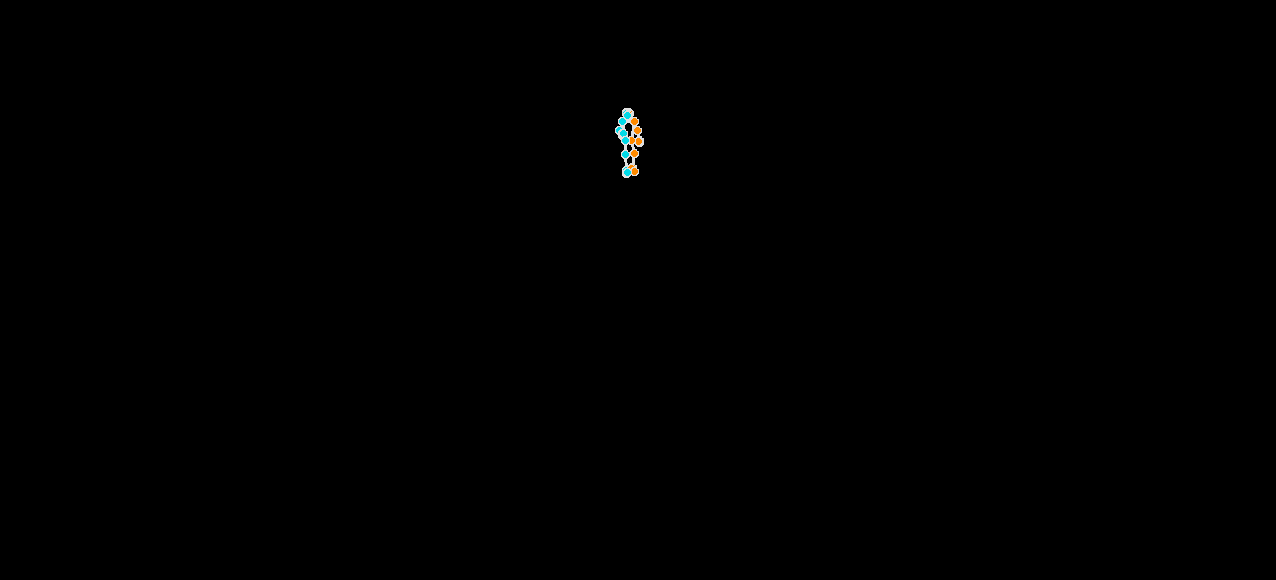

580 1276 3


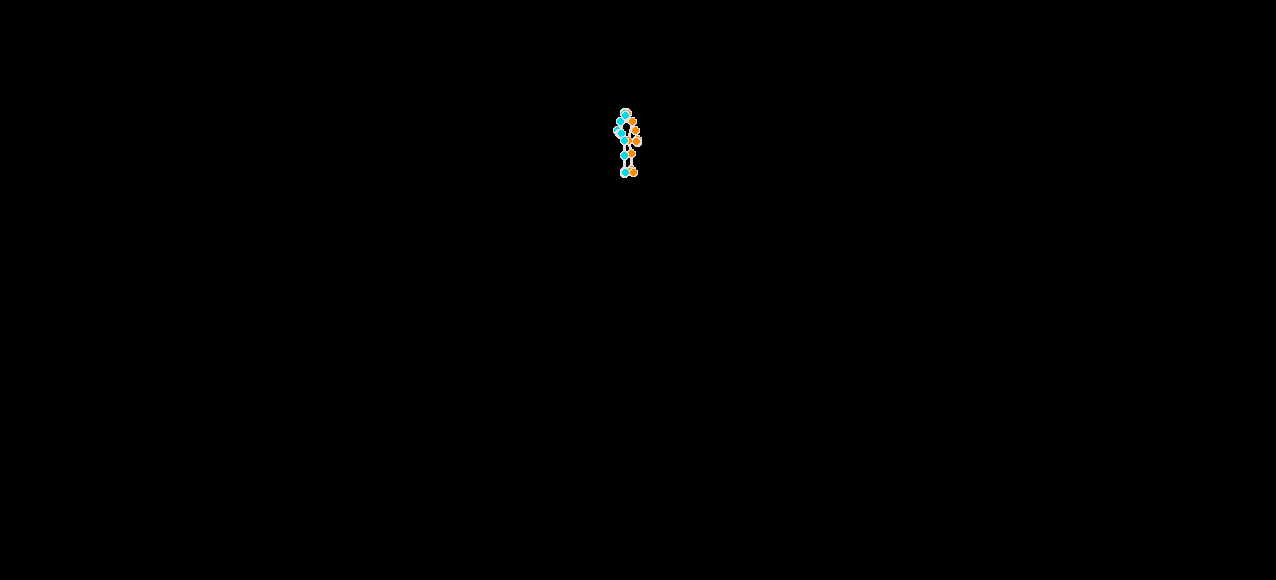

580 1276 3


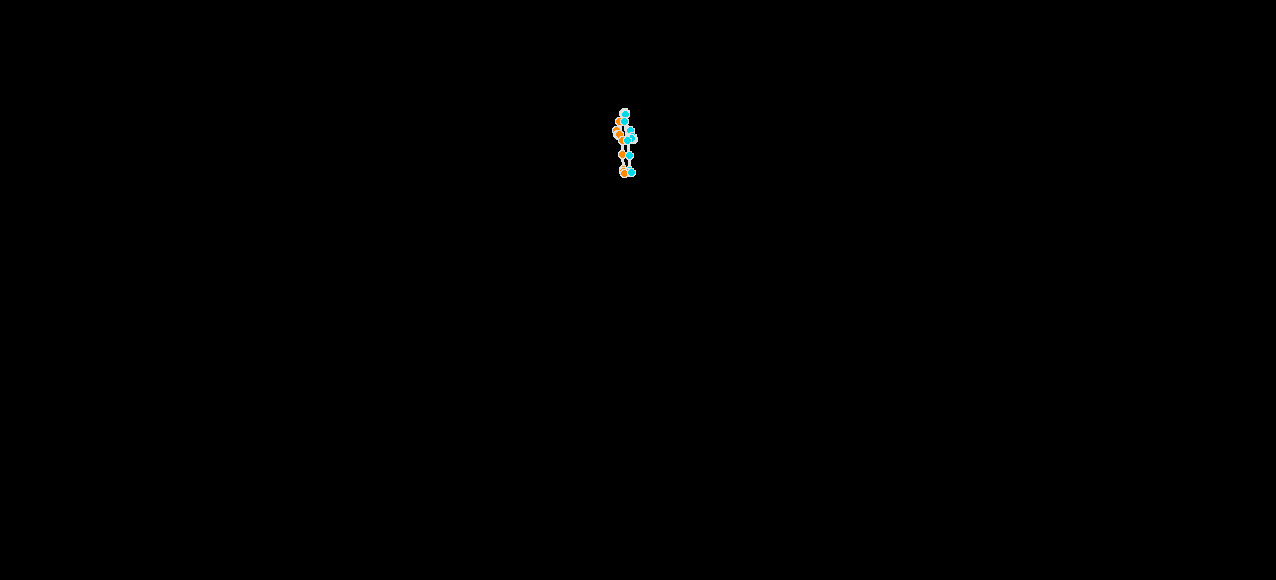

580 1276 3


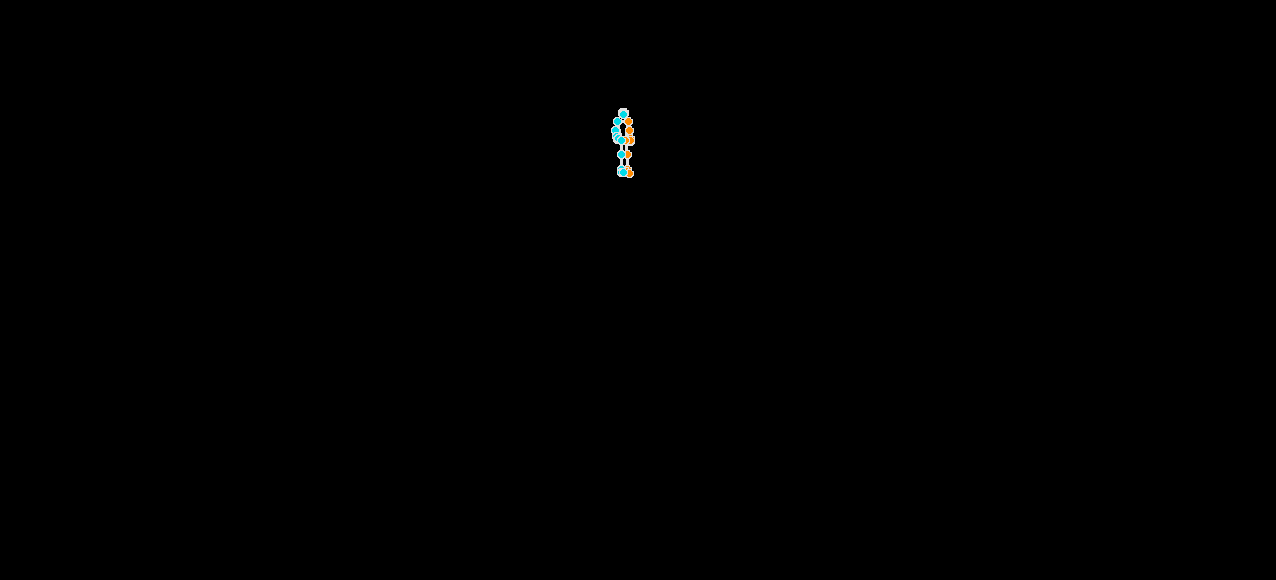

580 1276 3


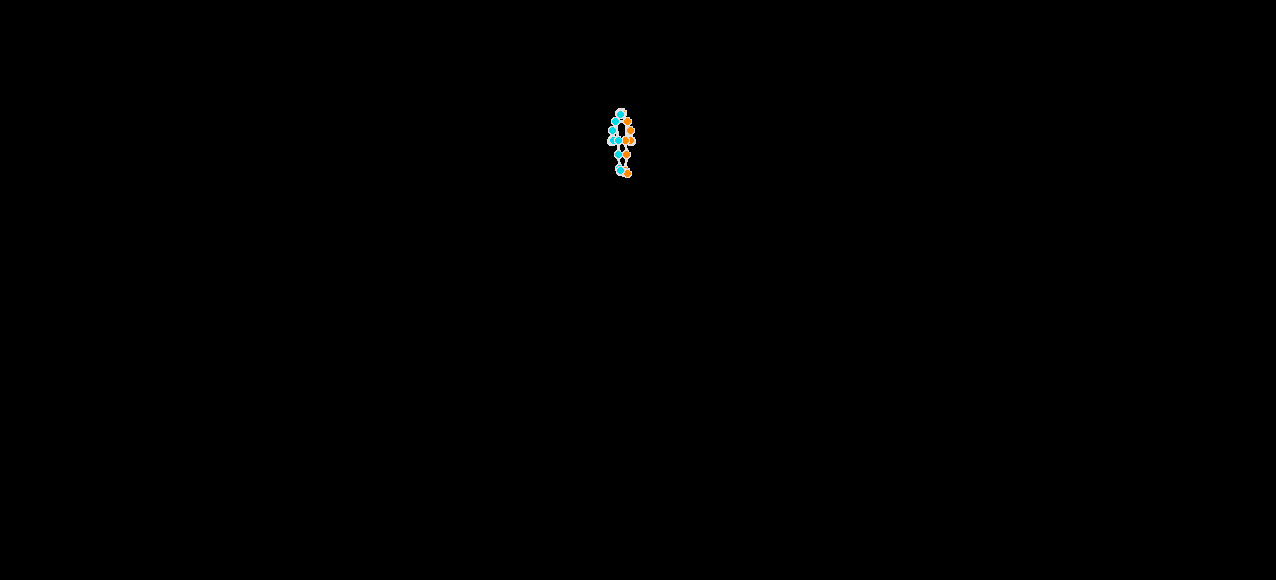

580 1276 3


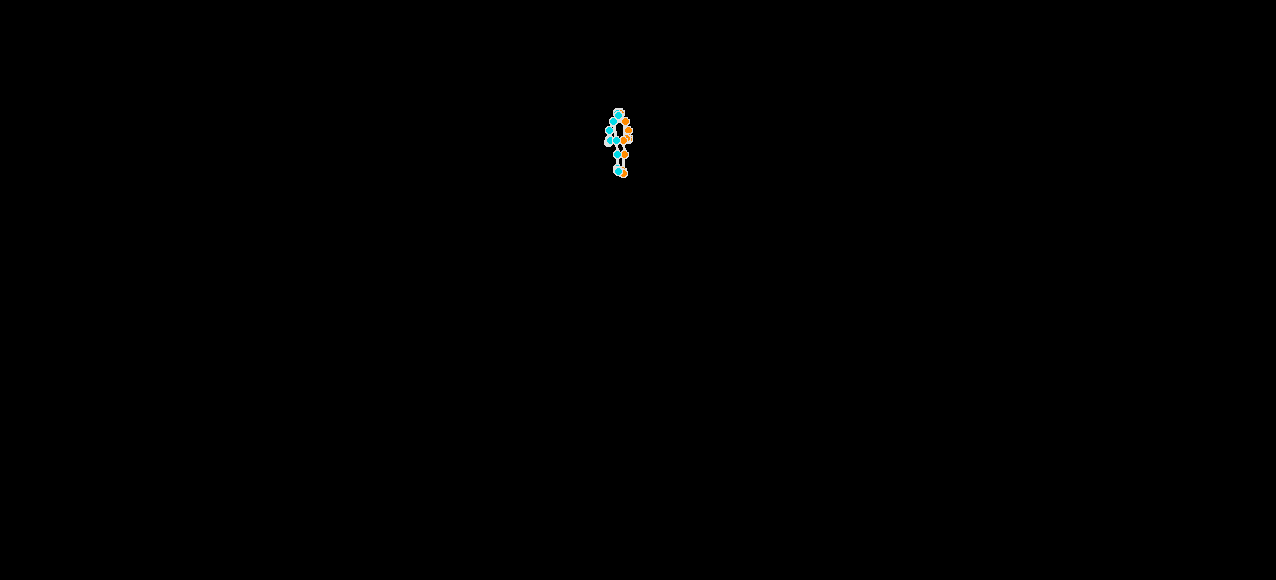

580 1276 3


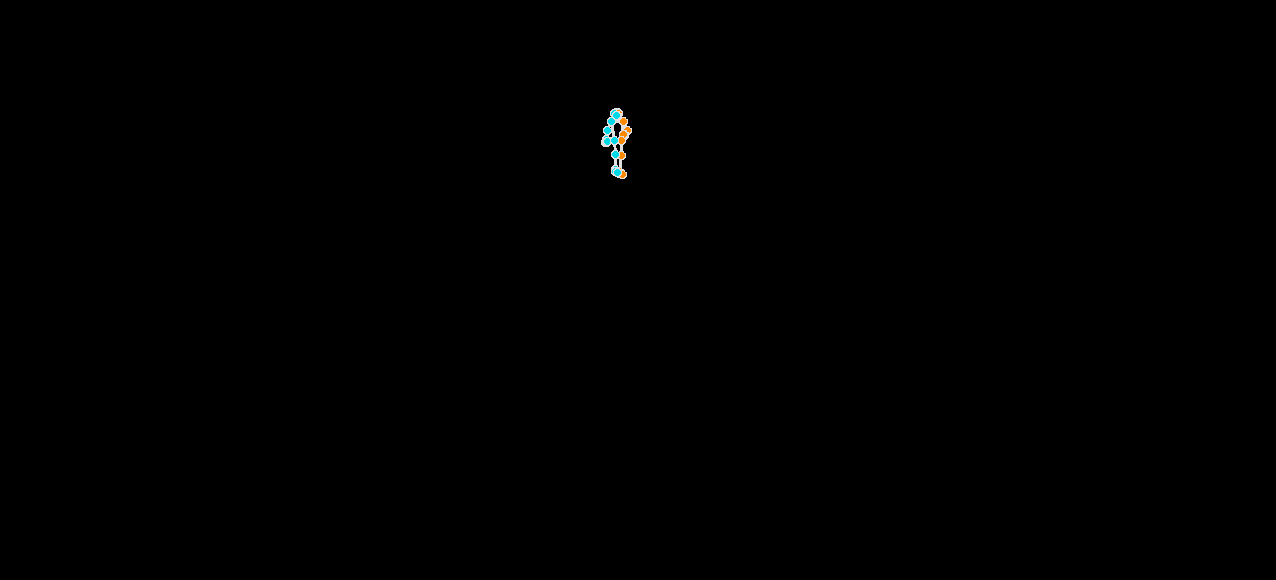

580 1276 3


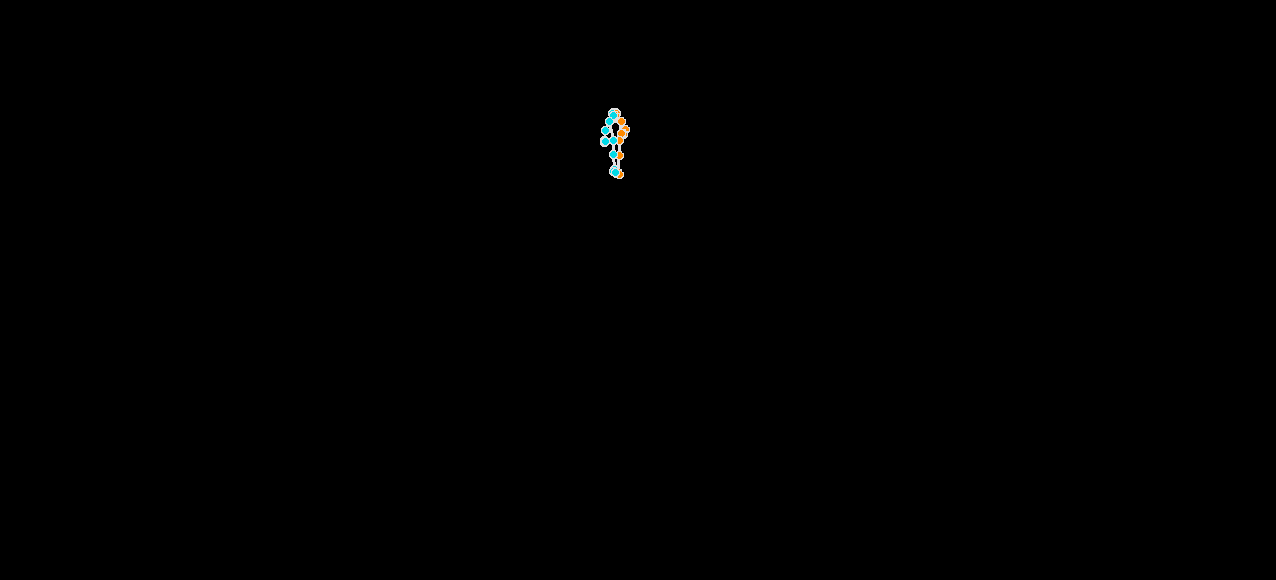

580 1276 3


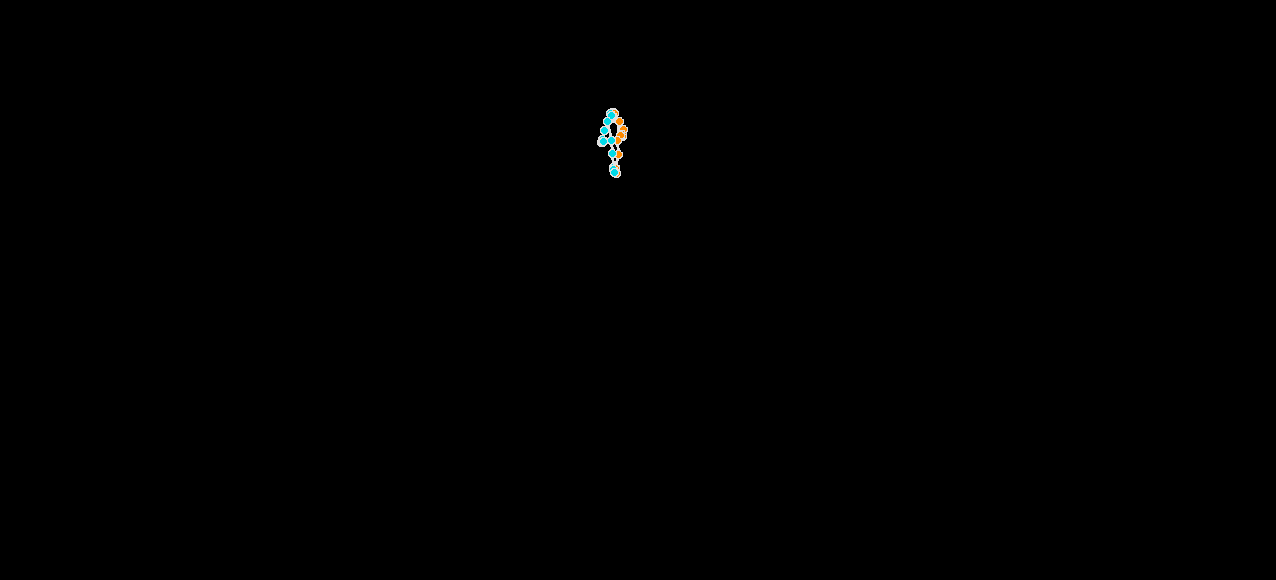

580 1276 3


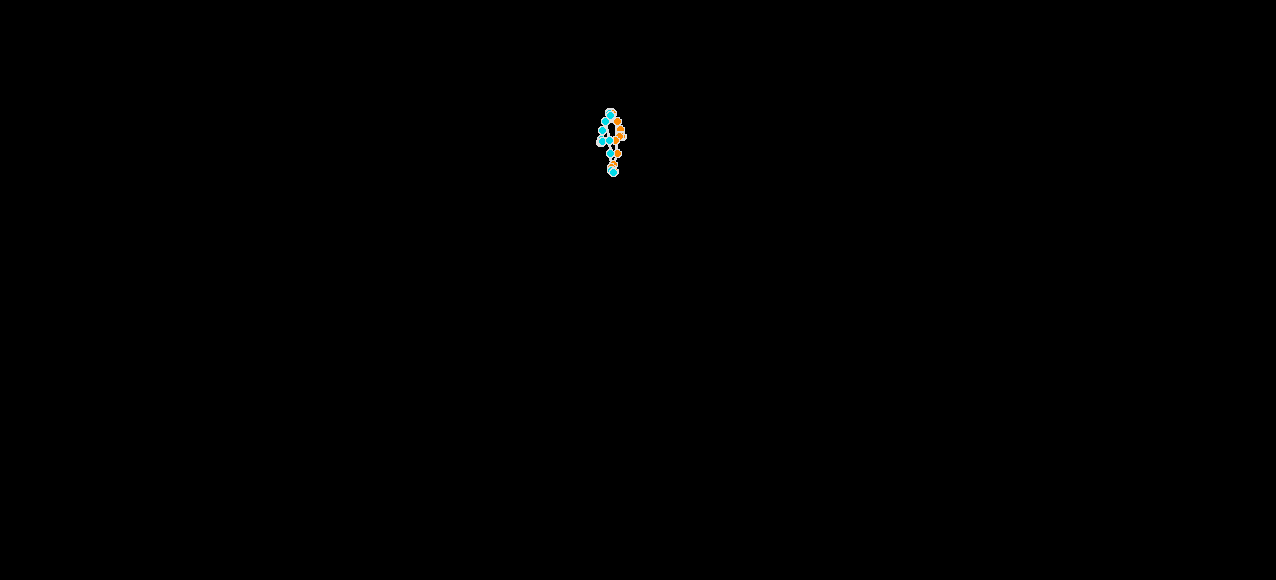

580 1276 3


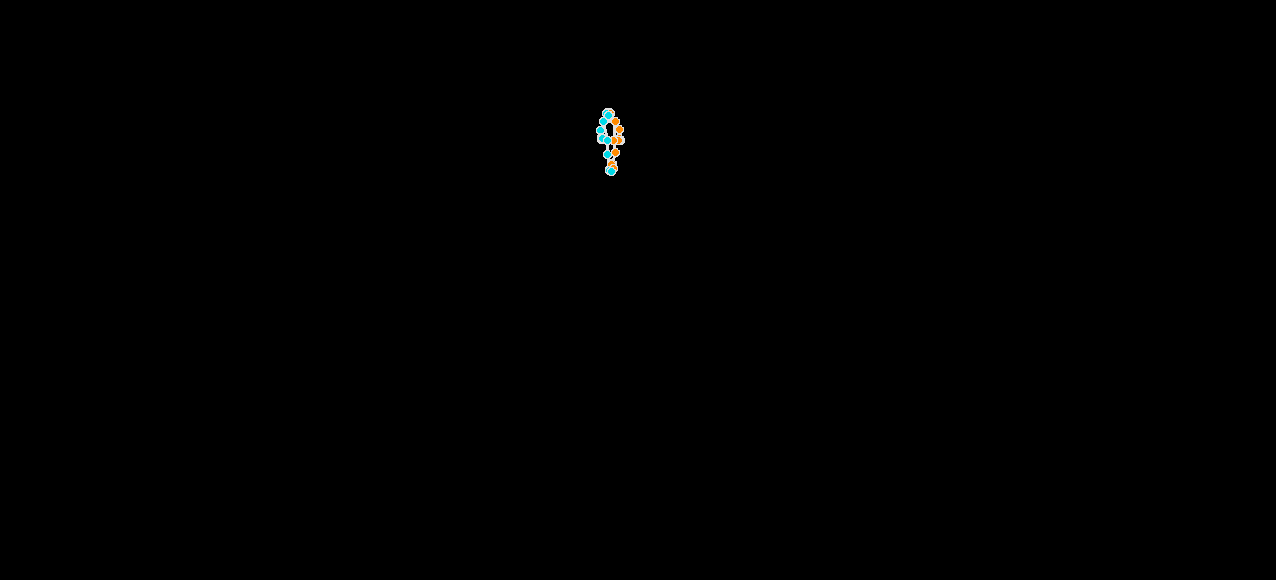

580 1276 3


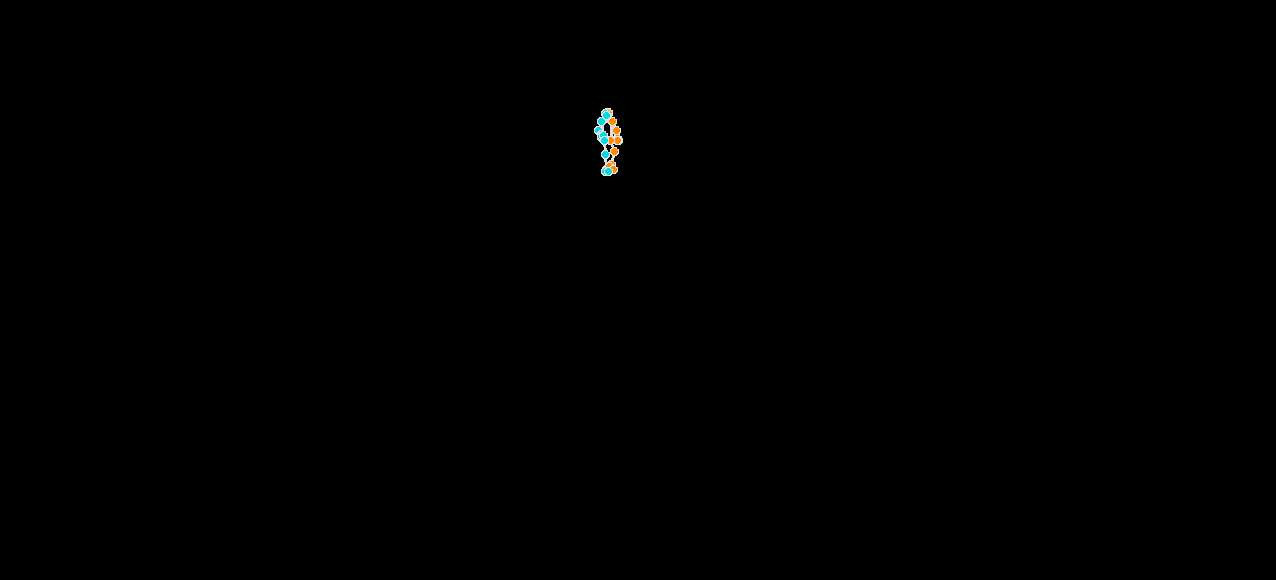

580 1276 3


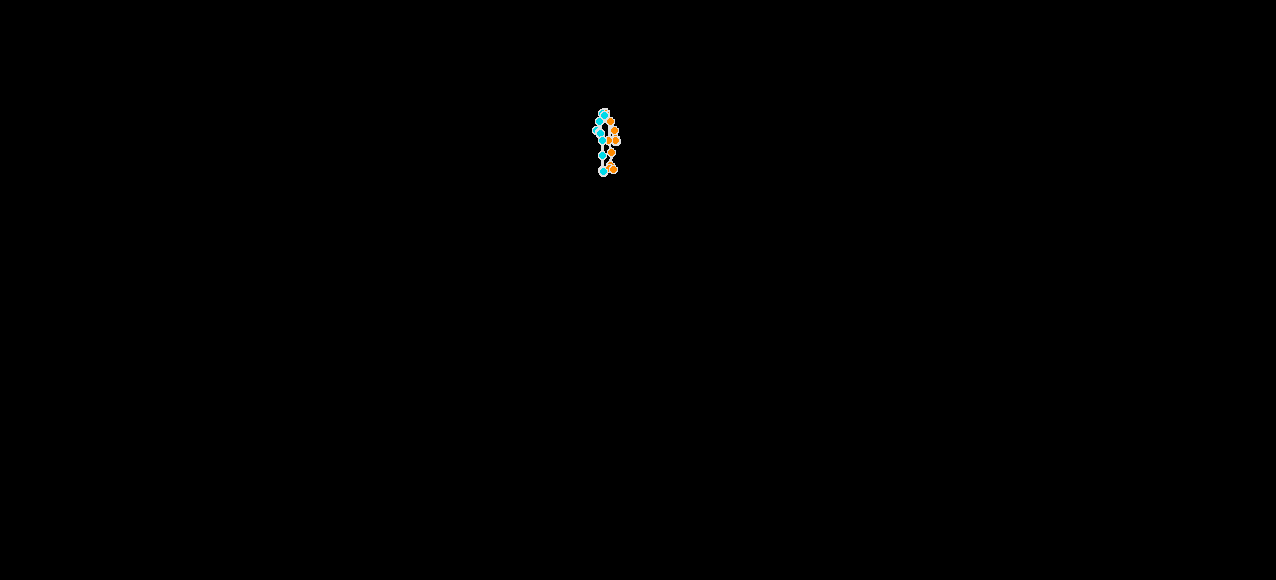

580 1276 3


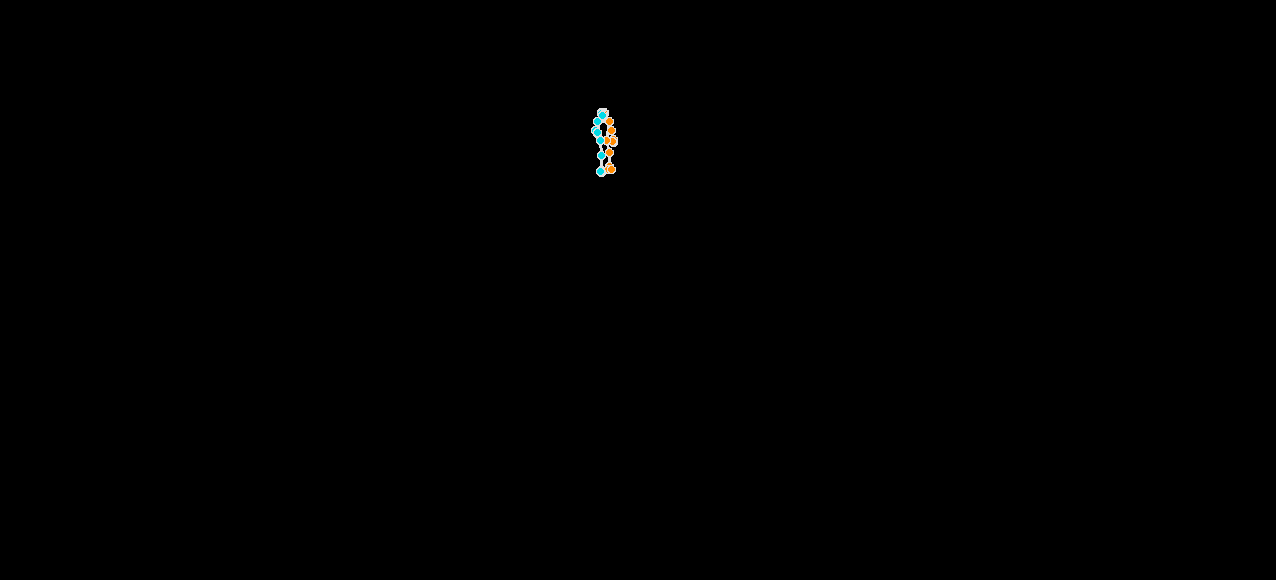

580 1276 3


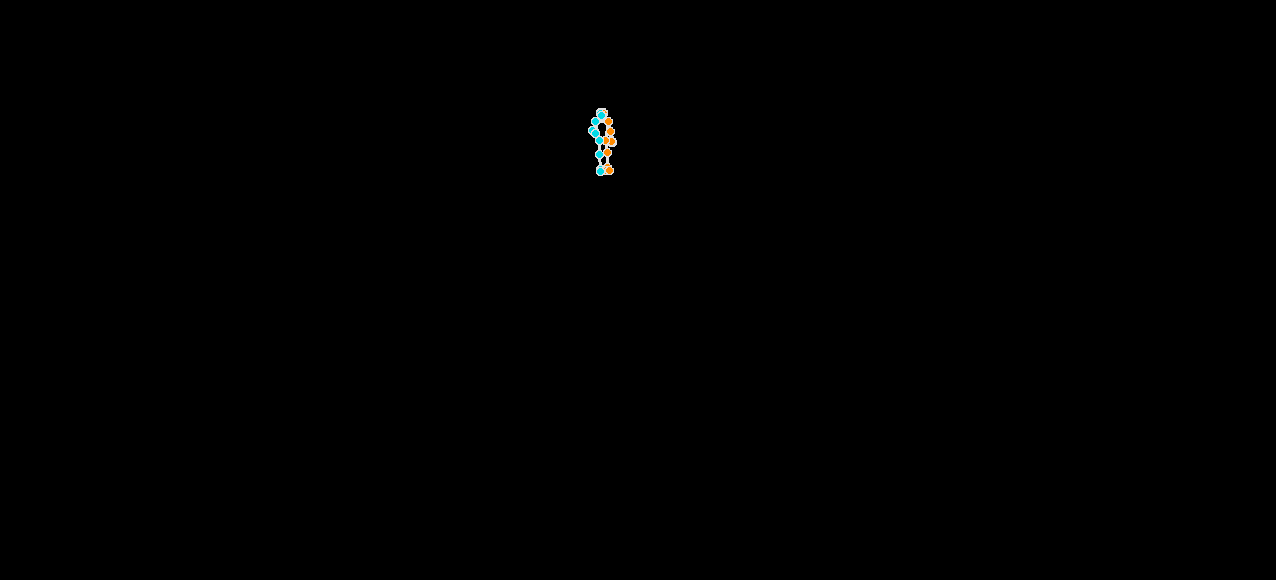

580 1276 3


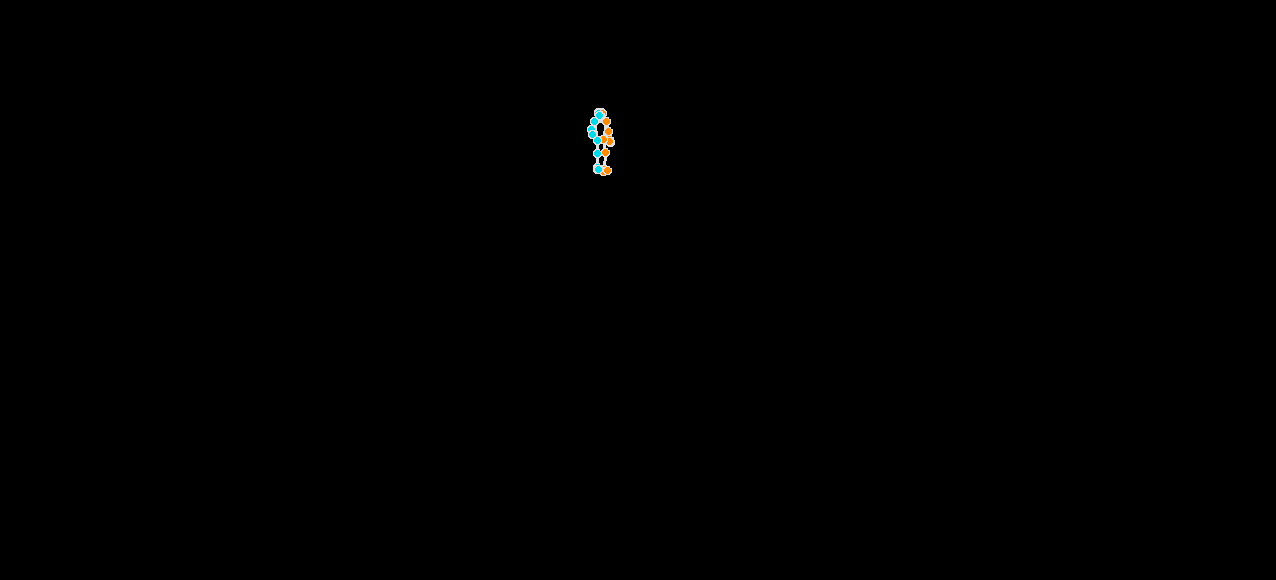

580 1276 3


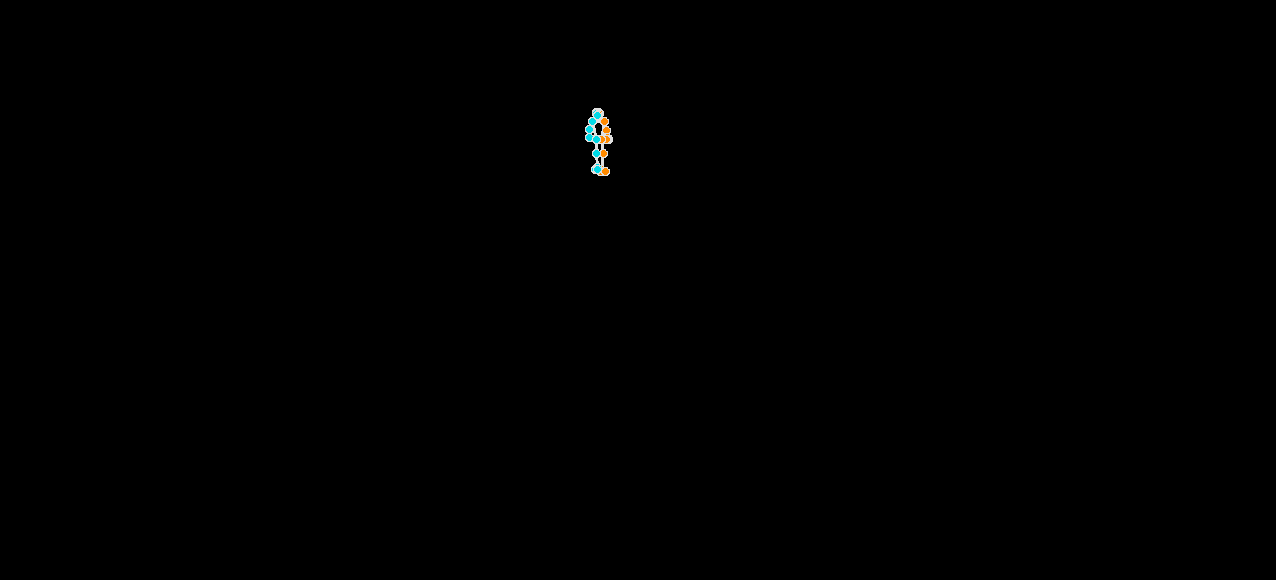

580 1276 3


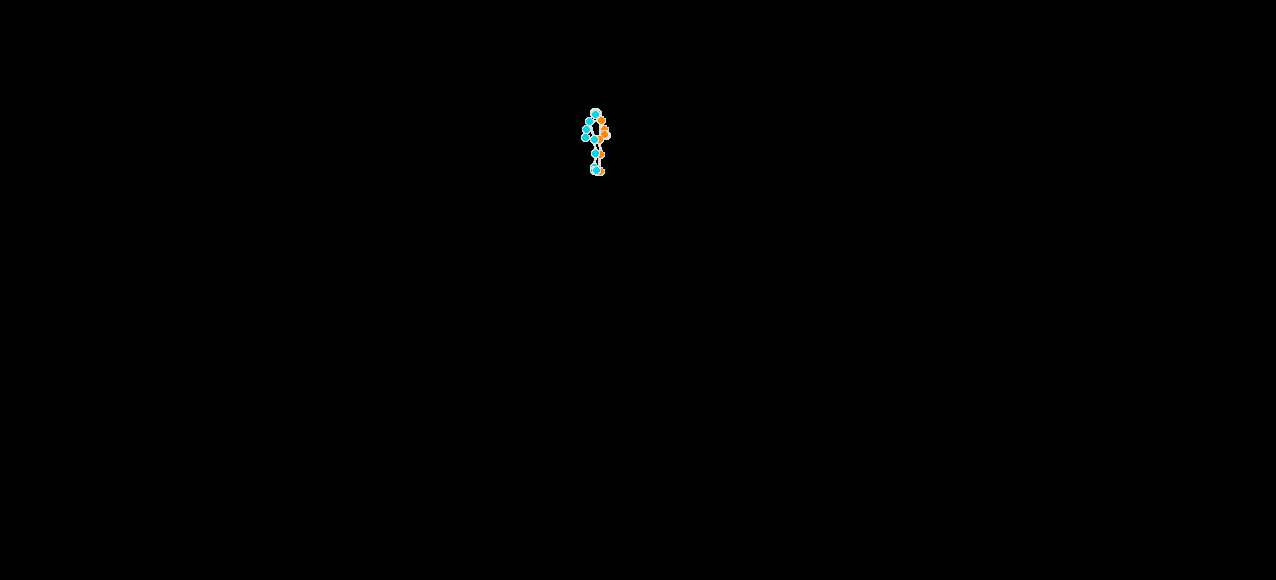

Ignoring empty camera frame.


In [59]:
# Run mediapipe and plot skeleton base on input video

from mediapipe.framework.formats.landmark_pb2 import Landmark
# Run MediaPipe Pose and plot 3d pose world landmarks.
# /usr/local/lib/python3.8/dist-packages/mediapipe/python/solution_base.py

from typing import List, Mapping, Optional, Tuple, Union
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import numpy as np
# For webcam input:
cap = cv2.VideoCapture(name)
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      # continue
      break
      
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # -------# plot on the real image#-------
    # mp_drawing.draw_landmarks(
    #     image,
    #     results.pose_landmarks,
    #     mp_pose.POSE_CONNECTIONS,
    #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # # Flip the image horizontally for a selfie-view display.
    # # #cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
    # cv2_imshow( cv2.flip(image, 1))
    #---------# plot on black Background#--------
    x,y,z=image.shape
    zero_img=np.zeros((x,y,z),dtype='float')
    print(x,y,z)
    mp_drawing.draw_landmarks(
        zero_img,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    # #cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
    cv2_imshow( cv2.flip(zero_img, 1))#code to show just on colab

    DrawingSpec1 = DrawingSpec(color=RED_COLOR, thickness=2)
    DrawingSpec2 = DrawingSpec(color=BLACK_COLOR, thickness=2)


    connections=mp_pose.POSE_CONNECTIONS
    landmark_list=results.pose_landmarks
    landmark_drawing_spec= DrawingSpec1
    connection_drawing_spec= DrawingSpec2
    elevation: int = 10
    azimuth: int = 10


    land_x=[]
    land_y=[]
    land_z=[]

    land_x_line=[]
    land_y_line=[]
    land_z_line=[]

    if not landmark_list:
        print("It doesn't detect ")
    
    plotted_landmarks = {}
    try:
      landmark=[landmark for idx, landmark in enumerate(landmark_list.landmark) if (landmark is not None  and landmark)]
    
      for  idx,landmark in enumerate(landmark):
        if ((landmark.HasField('visibility') and
              landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
              landmark.presence < _PRESENCE_THRESHOLD)):
          continue
          
        # ax.scatter3D(
        #     xs=[-landmark.z],
        #     ys=[landmark.x],
        #     zs=[-landmark.y],
        #     color=_normalize_color(landmark_drawing_spec.color[::-1]),
        #     linewidth=landmark_drawing_spec.thickness)
      # -------- 
        land_x.append(-landmark.z)
        land_y.append(landmark.x)
        land_z.append(-landmark.y)


        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    
      if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
          start_idx = connection[0]
          end_idx = connection[1]
          if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
            raise ValueError(f'Landmark index is out of range. Invalid connection '
                              f'from landmark #{start_idx} to landmark #{end_idx}.')
          if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
            landmark_pair = [
                plotted_landmarks[start_idx], plotted_landmarks[end_idx]
            ]
            # ax.plot3D(
            #     xs=[landmark_pair[0][0], landmark_pair[1][0]],
            #     ys=[landmark_pair[0][1], landmark_pair[1][1]],
            #     zs=[landmark_pair[0][2], landmark_pair[1][2]],
            #     color=_normalize_color(connection_drawing_spec.color[::-1]),
            #     linewidth=connection_drawing_spec.thickness)
            # print([landmark_pair[0][0], landmark_pair[1][0]])
            # print('----')
            land_x_line.append(landmark_pair[0][0])
            land_x_line.append( landmark_pair[1][0])
            land_x_line.append(None)
            land_y_line.append(landmark_pair[0][1])
            land_y_line.append( landmark_pair[1][1])
            land_y_line.append(None)
            land_z_line.append(landmark_pair[0][2])
            land_z_line.append( landmark_pair[1][2])
            land_z_line.append(None)
         
    except:
      print("There is no more Data")
      # break

In [60]:
# !mkdir images
# !pip install -U kaleido

In [61]:
# # https://github.com/mks0601/3DMPPE_POSENET_RELEASE/blob/8f62e5b819f1410ab2b8b558a4e4d42ab53b4b19/common/utils/vis.py#L41
# https://github.com/mks0601/3DMPPE_POSENET_RELEASE/issues/15
# kpt_3d: 3D coordinates of all body joints
# kpt_3d_vis': binary flag which indicate this keypoint is valid or invalid (invalid means truncated or not annotated)
# kps_lines: human body skeleton hiererachy

# preds_2d_kpt_$DB_NAME.mat can be obtained by running test.py of this repo.
def vis_3d_skeleton(kpt_3d, kpt_3d_vis, kps_lines, filename=None):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kps_lines) + 2)]
    colors = [np.array((c[2], c[1], c[0])) for c in colors]

    for l in range(len(kps_lines)):
        i1 = kps_lines[l][0]
        i2 = kps_lines[l][1]
        x = np.array([kpt_3d[i1,0], kpt_3d[i2,0]])
        y = np.array([kpt_3d[i1,1], kpt_3d[i2,1]])
        z = np.array([kpt_3d[i1,2], kpt_3d[i2,2]])

        if kpt_3d_vis[i1,0] > 0 and kpt_3d_vis[i2,0] > 0:
            ax.plot(x, z, -y, c=colors[l], linewidth=2)
        if kpt_3d_vis[i1,0] > 0:
            ax.scatter(kpt_3d[i1,0], kpt_3d[i1,2], -kpt_3d[i1,1], c=colors[l], marker='o')
        if kpt_3d_vis[i2,0] > 0:
            ax.scatter(kpt_3d[i2,0], kpt_3d[i2,2], -kpt_3d[i2,1], c=colors[l], marker='o')

    x_r = np.array([0, cfg.input_shape[1]], dtype=np.float32)
    y_r = np.array([0, cfg.input_shape[0]], dtype=np.float32)
    z_r = np.array([0, 1], dtype=np.float32)
    
    if filename is None:
        ax.set_title('3D vis')
    else:
        ax.set_title(filename)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    #ax.set_xlim([0,cfg.input_shape[1]])
    #ax.set_ylim([0,1])
    #ax.set_zlim([-cfg.input_shape[0],0])
    ax.legend()

    plt.show()
    cv2.waitKey(0)

In [62]:
# !pip install --upgrade kaleido
# Check if the package is correctly installed by running the following command:
# !pip show kaleido
# !pip uninstall kaleido
!pip install kaleido

# !pip install -U kaleido
# !pip install plotly orca


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:

# Read and show 3d plot in plotly  frame by frame-- input video
# https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/
from typing import List, Mapping, Optional, Tuple, Union
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import plotly.io as pio 



WHITE_COLOR = (224, 224, 224)
RED_COLOR = (0, 0, 255)
BLACK_COLOR = (0, 0, 0)
_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_BGR_CHANNELS = 3


def _normalize_color(color):
  return tuple(v / 255. for v in color)

class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 1
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 1

  def  __init__(self,color,thickness):
    self.color=color
    self.thickness=thickness
    

DrawingSpec1 = DrawingSpec(color=RED_COLOR, thickness=2)
DrawingSpec2 = DrawingSpec(color=BLACK_COLOR, thickness=2)

connections=mp_pose.POSE_CONNECTIONS
landmark_drawing_spec= DrawingSpec1
connection_drawing_spec= DrawingSpec2
elevation: int = 10
azimuth: int = 10


cap = cv2.VideoCapture(name)
 
# Check if camera opened successfully
if (cap.isOpened() == False): 
  print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
 
# # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
 
from mediapipe.framework.formats.landmark_pb2 import Landmark
num_img=0

# Read until video is completed
while(True):
  land_x=[]
  land_y=[]
  land_z=[]

  land_x_line=[]
  land_y_line=[]
  land_z_line=[]

  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
  #  try:
    # Run MediaPipe Pose and plot 3d pose world landmarks.
    # /usr/local/lib/python3.8/dist-packages/mediapipe/python/solution_base.py
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
        image=frame
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Print the real-world 3D coordinates of nose in meters with the origin at
        # the center between hips.
        # print('Nose world landmark:')
        # print(results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.NOSE])
        landmark_list=results.pose_world_landmarks
        
     
   
        if not landmark_list:
            print("It doesn't detect ")
        else:
      
        
          # try:
          landmark=[landmark for idx, landmark in enumerate(landmark_list.landmark) if (landmark is not None  and landmark)]
          plotted_landmarks = {}
          for  idx,landmark in enumerate(landmark):
            if ((landmark.HasField('visibility') and
                  landmark.visibility < _VISIBILITY_THRESHOLD) or
                (landmark.HasField('presence') and
                  landmark.presence < _PRESENCE_THRESHOLD)):
              continue

            land_x.append(-landmark.z)
            land_y.append(landmark.x)
            land_z.append(-landmark.y)
            plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
            
          plotted_landmarks_values = list(plotted_landmarks.values())
          plotted_landmarks_keys = list(plotted_landmarks)
          list(plotted_landmarks)
          print(plotted_landmarks_values)
          print(plotted_landmarks_keys)
          print(connections)

          if connections:
            num_landmarks = len(landmark_list.landmark)
            # print(num_landmarks)
            # Draws the connections if the start and end landmarks are both visible.
            for connection in connections:
              start_idx = connection[0]
              end_idx = connection[1]
              if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection '
                                  f'from landmark #{start_idx} to landmark #{end_idx}.')
              if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                # print(landmark_pair)

                land_x_line.append(landmark_pair[0][0])
                land_x_line.append( landmark_pair[1][0])
                land_x_line.append(None)
                land_y_line.append(landmark_pair[0][1])
                land_y_line.append( landmark_pair[1][1])
                land_y_line.append(None)
                land_z_line.append(landmark_pair[0][2])
                land_z_line.append( landmark_pair[1][2])
                land_z_line.append(None)

            fig=go.Figure(data=[go.Scatter3d(x=land_x,
                                        y=land_y,
                                        z=land_z,
                                        mode='markers', 
                                    marker = dict(
                                    size=3,
                                    color='red',
                                    opacity=.9))])
                                    
            fig.update_layout(width=400, height=400) 
            go.Figure()
            data = fig._data


            vector=go.Scatter3d(x=land_x_line,
                                    y=land_y_line,
                                    z=land_z_line,
                                    mode='lines', 
                                    line=dict(
                                    color='blue' 
                                    ),
                                    line_width=connection_drawing_spec.thickness)
            data.append(vector)
            fig.update_layout(width=400, height=400)
        
            fig.show()
          
            pio.write_image(fig,os.path.join('/content/drive/MyDrive/BishopThesisv8-mediapipe-Main_3d_plot-/3d_plot_imgs/newCam', f'figure{num_img}.jpeg'), format='jpeg')
            print(num_img)
            num_img=num_img+1
            print( f'figure{num_img}.jpeg')
          
            
          # plt.clf() 
            # break

          # # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
  #  except:
  #    print("There is no more Data")
       # #   break

      
    
  # Break the loop
  else: 
    break

#  //////////////////////////////////////////////////
## When everything done, release the video capture object
# cap.release()
# out.release()

# # Closes all the frames
# cv2.destroyAllWindows()

# writing a videoo
# out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

# https://stackoverflow.com/questions/69265059/is-it-possible-to-create-a-plotly-animated-3d-scatter-plot-of-mediapipes-body-p



[(-0.01768827810883522, 0.03331950306892395, 0.6382573246955872), (0.024020925164222717, 0.02607026882469654, 0.6569515466690063), (0.01133801694959402, 0.02700585313141346, 0.6540106534957886), (0.016105718910694122, 0.029128234833478928, 0.6572608351707458), (0.031501129269599915, 0.06934989243745804, 0.6704697608947754), (0.04583248868584633, 0.07252659648656845, 0.668667197227478), (0.024249402806162834, 0.07822313904762268, 0.6570714116096497), (0.1364445686340332, -0.022686723619699478, 0.6144524812698364), (0.11592072993516922, 0.13395380973815918, 0.5713285207748413), (0.004800040274858475, 0.024520859122276306, 0.615702748298645), (0.02954932302236557, 0.06811416149139404, 0.5801980495452881), (0.12166601419448853, -0.13882671296596527, 0.43256697058677673), (-0.0035830307751893997, 0.20700135827064514, 0.49138596653938293), (0.1192823126912117, -0.19779646396636963, 0.19095732271671295), (-0.0053863199427723885, 0.2661696672439575, 0.1830936074256897), (-0.03926976025104523, 

0
figure1.jpeg
[(-0.01521311141550541, 0.033531855791807175, 0.6385460495948792), (0.026013825088739395, 0.025613967329263687, 0.6572428941726685), (0.013255792669951916, 0.026526261121034622, 0.6542052030563354), (0.018071331083774567, 0.028566056862473488, 0.6574926972389221), (0.033868804574012756, 0.0685703456401825, 0.6703989505767822), (0.048230670392513275, 0.0718282088637352, 0.668615460395813), (0.02660208009183407, 0.07758495211601257, 0.6571062803268433), (0.13791465759277344, -0.023689061403274536, 0.6144129633903503), (0.11885616928339005, 0.13241608440876007, 0.5705007314682007), (0.006905600894242525, 0.024883529171347618, 0.6159422993659973), (0.03211219608783722, 0.06859083473682404, 0.5801439881324768), (0.12235419452190399, -0.1383318305015564, 0.43039506673812866), (0.0006515425629913807, 0.2072129100561142, 0.48995327949523926), (0.1225266307592392, -0.19855238497257233, 0.18820953369140625), (0.001558994990773499, 0.27000078558921814, 0.18180006742477417), (-0.034

1
figure2.jpeg
[(-0.025508511811494827, 0.03094245120882988, 0.6387460231781006), (0.015859561040997505, 0.02252274937927723, 0.6579380035400391), (0.0032321473117917776, 0.02331434190273285, 0.6549623012542725), (0.007913097739219666, 0.025494147092103958, 0.6583026647567749), (0.023384183645248413, 0.06684090197086334, 0.6707857251167297), (0.03798946365714073, 0.07010132074356079, 0.6691752076148987), (0.01631959155201912, 0.0759090781211853, 0.657503068447113), (0.13110198080539703, -0.0291389562189579, 0.6145519018173218), (0.11077797412872314, 0.13165654242038727, 0.5698188543319702), (-0.0018711728043854237, 0.021510299295186996, 0.6155938506126404), (0.023012535646557808, 0.06624419242143631, 0.5797801613807678), (0.11963801831007004, -0.14701855182647705, 0.42926955223083496), (-0.008013671264052391, 0.20773416757583618, 0.49041593074798584), (0.12231814861297607, -0.2118162363767624, 0.18534739315509796), (-0.008896131999790668, 0.26627156138420105, 0.18095891177654266), (-0.

2
figure3.jpeg
[(-0.01409243606030941, 0.04124850034713745, 0.6400778293609619), (0.027612904086709023, 0.032488979399204254, 0.6590721011161804), (0.01482907310128212, 0.03328623250126839, 0.6561270952224731), (0.019630173221230507, 0.035424210131168365, 0.6594123244285583), (0.03603938966989517, 0.07643193006515503, 0.6720252633094788), (0.05056576430797577, 0.07979623973369598, 0.6703378558158875), (0.02890845388174057, 0.08549623191356659, 0.6587204337120056), (0.14158275723457336, -0.022676028311252594, 0.6151083707809448), (0.12509122490882874, 0.138062983751297, 0.5705345869064331), (0.00875755213201046, 0.030654363334178925, 0.6166110634803772), (0.03481345996260643, 0.07544411718845367, 0.5806989073753357), (0.12847372889518738, -0.1407005488872528, 0.4297422468662262), (0.0026325725484639406, 0.2081453651189804, 0.4897383153438568), (0.13263119757175446, -0.20291759073734283, 0.18199512362480164), (0.001956983469426632, 0.2598523199558258, 0.17967867851257324), (-0.0218593236

3
figure4.jpeg
[(-0.014156552031636238, 0.042084358632564545, 0.6416580080986023), (0.026965100318193436, 0.03457850590348244, 0.6604830026626587), (0.01422804780304432, 0.03548547625541687, 0.6575740575790405), (0.019082915037870407, 0.037608128041028976, 0.6608549356460571), (0.03560759872198105, 0.07779352366924286, 0.6736821532249451), (0.05000300705432892, 0.08098474144935608, 0.6718600392341614), (0.028308317065238953, 0.08656846731901169, 0.6603264212608337), (0.1371500939130783, -0.01897623762488365, 0.6172298192977905), (0.12244080752134323, 0.13760630786418915, 0.5728228092193604), (0.007701806724071503, 0.03153202310204506, 0.6184974312782288), (0.03408629074692726, 0.07476591318845749, 0.5827344655990601), (0.12324953824281693, -0.13823828101158142, 0.4312046766281128), (0.0017656150739639997, 0.20777636766433716, 0.49148452281951904), (0.11910547316074371, -0.19949617981910706, 0.18229679763317108), (-0.0006746405269950628, 0.2651865482330322, 0.18146701157093048), (-0.040

4
figure5.jpeg
[(-0.019329888746142387, 0.03491535782814026, 0.6503763198852539), (0.022395268082618713, 0.02817656099796295, 0.6684731841087341), (0.009608778171241283, 0.029120586812496185, 0.6656413078308105), (0.01448777224868536, 0.031208625063300133, 0.6688136458396912), (0.03006538189947605, 0.07097341120243073, 0.6818277835845947), (0.044254522770643234, 0.0740639865398407, 0.6800347566604614), (0.022700434550642967, 0.07965867221355438, 0.6684255003929138), (0.13412447273731232, -0.02067195251584053, 0.6239570379257202), (0.11501335352659225, 0.13539192080497742, 0.5792608857154846), (0.0030941031873226166, 0.026102012023329735, 0.6269851922988892), (0.028073009103536606, 0.0692879855632782, 0.5910643935203552), (0.12126031517982483, -0.1377389132976532, 0.43668901920318604), (-0.002174051245674491, 0.2092406451702118, 0.49387529492378235), (0.11403676122426987, -0.19796745479106903, 0.19845129549503326), (-0.0007807353977113962, 0.27125659584999084, 0.18650922179222107), (-0.

5
figure6.jpeg
[(-0.02955152466893196, 0.03739025443792343, 0.6470154523849487), (0.012047325260937214, 0.02957352250814438, 0.6654064059257507), (-0.0005181169253773987, 0.030610300600528717, 0.6626241207122803), (0.004258583299815655, 0.03267602622509003, 0.6656943559646606), (0.020748049020767212, 0.07310809195041656, 0.6784650087356567), (0.034870974719524384, 0.07619194686412811, 0.6767182350158691), (0.013318094424903393, 0.08187656104564667, 0.665142834186554), (0.12434113025665283, -0.024023178964853287, 0.6227788329124451), (0.10863679647445679, 0.13394442200660706, 0.5770551562309265), (-0.007146354299038649, 0.02670760452747345, 0.6242980360984802), (0.018748782575130463, 0.07047789543867111, 0.58795166015625), (0.11278460919857025, -0.14257875084877014, 0.4365372359752655), (-0.00800003856420517, 0.20707648992538452, 0.4946224093437195), (0.10294882953166962, -0.202786386013031, 0.1958654373884201), (-0.013620979152619839, 0.26418450474739075, 0.1872221678495407), (-0.06077

6
figure7.jpeg
[(-0.013885805383324623, 0.0249185748398304, 0.6435814499855042), (0.028915828093886375, 0.018112141638994217, 0.6623080968856812), (0.015942368656396866, 0.0191348847001791, 0.6593766212463379), (0.02076471596956253, 0.021287444978952408, 0.6626667976379395), (0.0353669598698616, 0.061144374310970306, 0.6761329174041748), (0.04952568560838699, 0.06434544920921326, 0.6742454171180725), (0.02797602489590645, 0.07014158368110657, 0.6627116203308105), (0.1420104056596756, -0.026471976190805435, 0.6189094185829163), (0.1175338625907898, 0.12958064675331116, 0.5767161846160889), (0.0085902726277709, 0.017850954085588455, 0.6205967664718628), (0.032147884368896484, 0.061352863907814026, 0.5851519107818604), (0.12611468136310577, -0.14061105251312256, 0.4345308542251587), (-0.007244187872856855, 0.20533552765846252, 0.4957578480243683), (0.12043245881795883, -0.2064058482646942, 0.1945725530385971), (-0.011144827120006084, 0.26759397983551025, 0.18895567953586578), (-0.04099766

7
figure8.jpeg
[(-0.0038871606811881065, 0.027111519128084183, 0.6384970545768738), (0.03798777237534523, 0.02008168026804924, 0.6582369804382324), (0.024883972480893135, 0.021049294620752335, 0.6552239060401917), (0.02963843196630478, 0.023296620696783066, 0.6586353778839111), (0.04486360028386116, 0.0619957409799099, 0.6726641654968262), (0.05920052528381348, 0.06527235358953476, 0.6706668734550476), (0.03761092573404312, 0.07104860991239548, 0.659246027469635), (0.14635150134563446, -0.024257918819785118, 0.6182594895362854), (0.12509378790855408, 0.12844936549663544, 0.578032910823822), (0.01687590777873993, 0.020220674574375153, 0.6167142987251282), (0.04138132929801941, 0.06300750374794006, 0.5818437337875366), (0.1248856857419014, -0.13984306156635284, 0.4336904287338257), (0.00043822661973536015, 0.2054910510778427, 0.49988704919815063), (0.12074973434209824, -0.20537841320037842, 0.18939153850078583), (0.004067155532538891, 0.271531879901886, 0.19251947104930878), (-0.03791757

8
figure9.jpeg
[(-0.014679687097668648, 0.031765736639499664, 0.6509931683540344), (0.026575874537229538, 0.02490505389869213, 0.6704371571540833), (0.013597969897091389, 0.025960613042116165, 0.6674991846084595), (0.018393471837043762, 0.028186218813061714, 0.6707037687301636), (0.03423994034528732, 0.06641354411840439, 0.6838542819023132), (0.048293497413396835, 0.06947745382785797, 0.6820285320281982), (0.026856636628508568, 0.0754002034664154, 0.6705484390258789), (0.13330824673175812, -0.02133912406861782, 0.6301831603050232), (0.11512906104326248, 0.12999391555786133, 0.5864850878715515), (0.00546284718438983, 0.023924317210912704, 0.6291846632957458), (0.030815692618489265, 0.06632724404335022, 0.5934287905693054), (0.11539838463068008, -0.1350054144859314, 0.44257766008377075), (-0.00929668266326189, 0.20476087927818298, 0.5045394897460938), (0.10714180022478104, -0.19440390169620514, 0.2049219161272049), (-0.009401432238519192, 0.2738225758075714, 0.2018241137266159), (-0.0465

9
figure10.jpeg
[(-0.006088421680033207, 0.03301999717950821, 0.652133047580719), (0.03594250977039337, 0.025581758469343185, 0.6713336706161499), (0.022774383425712585, 0.026594877243041992, 0.6683797836303711), (0.027650276198983192, 0.02875582128763199, 0.6716648936271667), (0.04330339655280113, 0.06722396612167358, 0.6849373579025269), (0.057359226047992706, 0.07033950835466385, 0.6829816699028015), (0.0358562171459198, 0.07643615454435349, 0.6715247631072998), (0.14498496055603027, -0.020262422040104866, 0.6298149824142456), (0.12573832273483276, 0.13272464275360107, 0.5863097310066223), (0.014466228894889355, 0.025760650634765625, 0.6296453475952148), (0.03981052339076996, 0.0689532607793808, 0.5939088463783264), (0.12487810850143433, -0.12831830978393555, 0.4412127435207367), (-0.0019360810983926058, 0.2040279507637024, 0.5046287775039673), (0.11851769685745239, -0.19131217896938324, 0.20097999274730682), (-0.006833523046225309, 0.271811842918396, 0.2029324620962143), (-0.034603

10
figure11.jpeg
[(-0.012005855329334736, 0.03136725723743439, 0.6490996479988098), (0.03059418685734272, 0.02458270452916622, 0.6685575842857361), (0.017802931368350983, 0.025834456086158752, 0.6655771732330322), (0.022501865401864052, 0.027810994535684586, 0.6688090562820435), (0.038128603249788284, 0.06588300317525864, 0.6826460957527161), (0.05203200504183769, 0.06886234879493713, 0.6807319521903992), (0.03049151413142681, 0.07487639784812927, 0.6692399978637695), (0.1391308307647705, -0.021229758858680725, 0.6314465403556824), (0.12074272334575653, 0.13112561404705048, 0.5888146162033081), (0.008535750210285187, 0.023710673674941063, 0.6286980509757996), (0.033802978694438934, 0.06676917523145676, 0.5932375192642212), (0.12047751992940903, -0.12731440365314484, 0.4470277726650238), (-0.001132983947172761, 0.20250198245048523, 0.5111361145973206), (0.1165153980255127, -0.1761091947555542, 0.20942530035972595), (0.0006443304009735584, 0.27042055130004883, 0.20732243359088898), (-0.0

11
figure12.jpeg
[(-0.0010472633875906467, 0.027766136452555656, 0.6379083395004272), (0.04089480638504028, 0.020643921568989754, 0.6575714945793152), (0.027891365811228752, 0.02166995219886303, 0.6546086072921753), (0.03272454813122749, 0.023904673755168915, 0.6579641103744507), (0.04852134734392166, 0.06233607232570648, 0.6710976362228394), (0.06276923418045044, 0.06563932448625565, 0.6691555976867676), (0.04111936315894127, 0.07139171659946442, 0.6577522158622742), (0.14838279783725739, -0.0254366472363472, 0.618004322052002), (0.13016372919082642, 0.1275915503501892, 0.5743492245674133), (0.019528629258275032, 0.020280888304114342, 0.6161510348320007), (0.044971153140068054, 0.06324286013841629, 0.5805932283401489), (0.12810957431793213, -0.13655473291873932, 0.4335740804672241), (0.007170740980654955, 0.20303015410900116, 0.4957009553909302), (0.12798137962818146, -0.19517582654953003, 0.1970401406288147), (0.011193091981112957, 0.27577731013298035, 0.19543762505054474), (-0.01905

12
figure13.jpeg
[(-0.019951120018959045, 0.022078178822994232, 0.6475622057914734), (0.023010525852441788, 0.014715691097080708, 0.6662610173225403), (0.010320785455405712, 0.01600177027285099, 0.6634226441383362), (0.015108547173440456, 0.018199704587459564, 0.6666780114173889), (0.029903071001172066, 0.05724089592695236, 0.6795762181282043), (0.043850500136613846, 0.06048879027366638, 0.6777993440628052), (0.02218879759311676, 0.0663064494729042, 0.6664242148399353), (0.13508844375610352, -0.029736975207924843, 0.6261382102966309), (0.11191054433584213, 0.12661971151828766, 0.5804592967033386), (0.002265668474137783, 0.015280130319297314, 0.6258810758590698), (0.026165740564465523, 0.05916619673371315, 0.5892514586448669), (0.1188490018248558, -0.13588546216487885, 0.4403664171695709), (-0.009263422340154648, 0.20338433980941772, 0.5003770589828491), (0.11468152701854706, -0.19042536616325378, 0.20661002397537231), (-0.008026252500712872, 0.26671263575553894, 0.19872839748859406), (

13
figure14.jpeg
[(-0.014146920293569565, 0.032252922654151917, 0.6517207026481628), (0.028537249192595482, 0.02496049925684929, 0.6700670123100281), (0.01579027622938156, 0.02630358189344406, 0.6672983765602112), (0.02057846635580063, 0.028315668925642967, 0.670344889163971), (0.03736285865306854, 0.06696924567222595, 0.682952880859375), (0.05112642049789429, 0.07010047137737274, 0.6811984777450562), (0.029607806354761124, 0.0759277269244194, 0.6697779893875122), (0.13671515882015228, -0.026103846728801727, 0.6297279000282288), (0.12234821915626526, 0.12877501547336578, 0.5832167863845825), (0.006202090065926313, 0.022700930014252663, 0.6301791071891785), (0.03276950493454933, 0.06619792431592941, 0.5933865904808044), (0.1158418133854866, -0.13458441197872162, 0.4428376257419586), (0.00394059345126152, 0.20156756043434143, 0.5010626912117004), (0.10767701268196106, -0.1854424923658371, 0.20708903670310974), (0.007163442205637693, 0.273846298456192, 0.19547820091247559), (-0.0360788553

14
figure15.jpeg
[(-0.019439583644270897, 0.03369036316871643, 0.6498260498046875), (0.023454995825886726, 0.02664964273571968, 0.6685082912445068), (0.010844344273209572, 0.028035413473844528, 0.6659078001976013), (0.015755927190184593, 0.029932662844657898, 0.6687715649604797), (0.03264855593442917, 0.06914141774177551, 0.6814765334129333), (0.046388380229473114, 0.07203610241413116, 0.6796788573265076), (0.02487015351653099, 0.07750200480222702, 0.6680936813354492), (0.13231845200061798, -0.026560690253973007, 0.6281606554985046), (0.11956517398357391, 0.1282253861427307, 0.5818508863449097), (0.0017394802998751402, 0.0231113750487566, 0.6281446814537048), (0.02842012047767639, 0.06600112468004227, 0.5916392207145691), (0.11474568396806717, -0.1399867981672287, 0.4438283443450928), (0.002954040188342333, 0.20120255649089813, 0.4993301033973694), (0.10879174619913101, -0.18197406828403473, 0.2059701830148697), (0.0032953328918665648, 0.26708418130874634, 0.19327563047409058), (-0.038

15
figure16.jpeg
[(-0.010725356638431549, 0.03611692041158676, 0.6480657458305359), (0.03117990493774414, 0.027458583936095238, 0.6675143241882324), (0.018186869099736214, 0.028530670329928398, 0.6646788716316223), (0.02303524874150753, 0.030467109754681587, 0.6678531169891357), (0.04051264375448227, 0.069623202085495, 0.6808420419692993), (0.05468005686998367, 0.07294405996799469, 0.6789337992668152), (0.03308762237429619, 0.07885279506444931, 0.6675987839698792), (0.1390964537858963, -0.026426250115036964, 0.6284388899803162), (0.12778808176517487, 0.12916086614131927, 0.5839142203330994), (0.00906909815967083, 0.025966690853238106, 0.6265301704406738), (0.0366547554731369, 0.06967800110578537, 0.5904785394668579), (0.11847061663866043, -0.13879919052124023, 0.44020745158195496), (0.005587287712842226, 0.20276287198066711, 0.5060247182846069), (0.11170172691345215, -0.20277400314807892, 0.19759397208690643), (0.00108058110345155, 0.2734655439853668, 0.20070300996303558), (-0.04360178

16
figure17.jpeg
[(-0.022962113842368126, 0.033981356769800186, 0.649665355682373), (0.019920025020837784, 0.02659733220934868, 0.6680539846420288), (0.007189339492470026, 0.02786438539624214, 0.6652340292930603), (0.011904473416507244, 0.02984996698796749, 0.6684026718139648), (0.028186913579702377, 0.06931844353675842, 0.6816619634628296), (0.0420895554125309, 0.072508305311203, 0.6798394322395325), (0.02044869400560856, 0.0783521980047226, 0.6685173511505127), (0.1301725208759308, -0.02389352023601532, 0.627419650554657), (0.11394883692264557, 0.13283483684062958, 0.5835233926773071), (-0.001762785017490387, 0.024531159549951553, 0.6277916431427002), (0.02398531697690487, 0.06853509694337845, 0.5916339755058289), (0.11363855004310608, -0.1385800540447235, 0.4397633969783783), (-0.005808569490909576, 0.20860818028450012, 0.5032139420509338), (0.10574475675821304, -0.20079030096530914, 0.20200948417186737), (-0.008675646968185902, 0.2794356048107147, 0.19854402542114258), (-0.05109223

17
figure18.jpeg
[(-0.015362497419118881, 0.036199185997247696, 0.647983968257904), (0.0285407193005085, 0.028696967288851738, 0.6667913198471069), (0.015730928629636765, 0.030099764466285706, 0.6641162037849426), (0.020520564168691635, 0.032165493816137314, 0.6671642065048218), (0.037814199924468994, 0.07158924639225006, 0.6796097159385681), (0.05142674222588539, 0.0746915340423584, 0.677813708782196), (0.029973717406392097, 0.08055528998374939, 0.6663375496864319), (0.1373235285282135, -0.026131533086299896, 0.6276723742485046), (0.12555740773677826, 0.13159486651420593, 0.5806978940963745), (0.0050995247438549995, 0.025284543633461, 0.626834511756897), (0.032149333506822586, 0.06950410455465317, 0.5898786783218384), (0.1153687909245491, -0.14064007997512817, 0.4425765573978424), (0.0031001947354525328, 0.20341864228248596, 0.5009873509407043), (0.10538814961910248, -0.19976681470870972, 0.20819048583507538), (0.003618615912273526, 0.2764814496040344, 0.20156516134738922), (-0.039179

18
figure19.jpeg
[(-0.02202342078089714, 0.03406655788421631, 0.6516475677490234), (0.02105269581079483, 0.02686668001115322, 0.6696252822875977), (0.008451317436993122, 0.028246480971574783, 0.6669472455978394), (0.013181138783693314, 0.030286353081464767, 0.6699440479278564), (0.029981441795825958, 0.06910349428653717, 0.6827553510665894), (0.04352284222841263, 0.07211844623088837, 0.6810979247093201), (0.022156402468681335, 0.07807318866252899, 0.6695916652679443), (0.12990498542785645, -0.02522100694477558, 0.6305550932884216), (0.11593937873840332, 0.13162793219089508, 0.5849681496620178), (-0.0015152259729802608, 0.024115055799484253, 0.6309296488761902), (0.024893488734960556, 0.06851713359355927, 0.5943564176559448), (0.11326553672552109, -0.1368323713541031, 0.4451262652873993), (-0.0032603528816252947, 0.20419788360595703, 0.5040171146392822), (0.10705790668725967, -0.1904882937669754, 0.21445903182029724), (0.002047077752649784, 0.2763165235519409, 0.20590321719646454), (-0.

19
figure20.jpeg
[(-0.008656663820147514, 0.0296823438256979, 0.6449212431907654), (0.03385693207383156, 0.023291897028684616, 0.6631678342819214), (0.021066633984446526, 0.02464892342686653, 0.6603922843933105), (0.02564379945397377, 0.026599843055009842, 0.6636538505554199), (0.0426873154938221, 0.06504083424806595, 0.6770020127296448), (0.05666432902216911, 0.06835833191871643, 0.6751887202262878), (0.03496314957737923, 0.07396311312913895, 0.6638818979263306), (0.13883815705776215, -0.027127638459205627, 0.6221961975097656), (0.1254972666501999, 0.12591104209423065, 0.5791552662849426), (0.010917466133832932, 0.019675854593515396, 0.6231330037117004), (0.0373392254114151, 0.0627358928322792, 0.587444543838501), (0.11988973617553711, -0.14660951495170593, 0.4351292848587036), (0.004264345392584801, 0.20270584523677826, 0.5003098845481873), (0.11457732319831848, -0.21345654129981995, 0.20142969489097595), (0.006251110695302486, 0.27703309059143066, 0.20491550862789154), (-0.032304223

20
figure21.jpeg
[(-0.013882122933864594, 0.030084915459156036, 0.6429223418235779), (0.029774516820907593, 0.021934550255537033, 0.6615597009658813), (0.017030948773026466, 0.023499272763729095, 0.6587949395179749), (0.021866394206881523, 0.025474008172750473, 0.6620064973831177), (0.03818793222308159, 0.06437526643276215, 0.6747379899024963), (0.051904451102018356, 0.0675191879272461, 0.6727803945541382), (0.030326688662171364, 0.07326727360486984, 0.6615092754364014), (0.13931293785572052, -0.028612229973077774, 0.6215367913246155), (0.1234172061085701, 0.1269146353006363, 0.5750395655632019), (0.007441790774464607, 0.021337006241083145, 0.6216263771057129), (0.033281560987234116, 0.06484346836805344, 0.5846967101097107), (0.1200355514883995, -0.1387285590171814, 0.43752360343933105), (0.0010866029188036919, 0.20139335095882416, 0.4970038831233978), (0.11328566074371338, -0.19313165545463562, 0.19982470571994781), (0.00074801966547966, 0.26798340678215027, 0.1974397599697113), (-0.0

21
figure22.jpeg
[(-0.015187284909188747, 0.032091088593006134, 0.6444467902183533), (0.027436671778559685, 0.025502804666757584, 0.662980854511261), (0.014856699854135513, 0.026966100558638573, 0.6601964235305786), (0.019331710413098335, 0.02873721905052662, 0.6633365750312805), (0.03618422895669937, 0.06759588420391083, 0.6773583292961121), (0.0499197319149971, 0.07051493227481842, 0.6754364967346191), (0.028395790606737137, 0.0764663964509964, 0.6641373038291931), (0.1346445083618164, -0.024743352085351944, 0.6213390231132507), (0.1200580969452858, 0.12752828001976013, 0.5803348422050476), (0.005132921971380711, 0.02209017053246498, 0.6222737431526184), (0.0311068557202816, 0.06468900293111801, 0.5870986580848694), (0.1109430193901062, -0.14004336297512054, 0.4365180432796478), (0.0002994218375533819, 0.20060475170612335, 0.502014696598053), (0.09829669445753098, -0.19634434580802917, 0.20058825612068176), (-0.009951458312571049, 0.2691343426704407, 0.20164798200130463), (-0.0538526

22
figure23.jpeg
[(-0.029848987236618996, 0.032173093408346176, 0.641745924949646), (0.012768136337399483, 0.02305426448583603, 0.660285472869873), (0.0003607510880101472, 0.0242448840290308, 0.657538890838623), (0.004794478882104158, 0.026228565722703934, 0.6608697772026062), (0.02223881706595421, 0.06633550673723221, 0.6735959053039551), (0.03644854202866554, 0.06948801130056381, 0.6718013882637024), (0.014657119289040565, 0.07517913728952408, 0.6606085896492004), (0.12300616502761841, -0.03294222056865692, 0.6206651329994202), (0.11268996447324753, 0.12704981863498688, 0.5741654634475708), (-0.007582166697829962, 0.020954573526978493, 0.620371401309967), (0.019549449905753136, 0.0654810443520546, 0.5839160680770874), (0.10927971452474594, -0.1502370685338974, 0.43563249707221985), (0.002159523544833064, 0.20714035630226135, 0.49508190155029297), (0.10502975434064865, -0.21061262488365173, 0.20372483134269714), (0.007913345471024513, 0.28832563757896423, 0.19488033652305603), (-0.045

23
figure24.jpeg
[(-0.023015078157186508, 0.030743734911084175, 0.6393749117851257), (0.020059388130903244, 0.021389907225966454, 0.6589029431343079), (0.007416346576064825, 0.022379284724593163, 0.6564828753471375), (0.011715508997440338, 0.024662382900714874, 0.6596343517303467), (0.02927182987332344, 0.06510985642671585, 0.6722143292427063), (0.0435432530939579, 0.06835394352674484, 0.6703553199768066), (0.02184102311730385, 0.07388590276241302, 0.6588799357414246), (0.13055002689361572, -0.036638133227825165, 0.6184055209159851), (0.11996608227491379, 0.12353356182575226, 0.5719394087791443), (-0.0004441292549017817, 0.01895231567323208, 0.616898775100708), (0.02638285607099533, 0.06323017179965973, 0.5803735852241516), (0.11341691762208939, -0.1566292941570282, 0.43162524700164795), (0.005819652229547501, 0.20295368134975433, 0.49268388748168945), (0.10458748042583466, -0.22298680245876312, 0.19417834281921387), (0.009233685210347176, 0.2771908938884735, 0.1938350945711136), (-0.0

24
figure25.jpeg
[(-0.0347176194190979, 0.03887035697698593, 0.6449296474456787), (0.008324094116687775, 0.03012578748166561, 0.6637545228004456), (-0.0039389911107718945, 0.031476859003305435, 0.6611035466194153), (0.0005873310146853328, 0.03345946595072746, 0.6643003225326538), (0.018609341233968735, 0.07361302524805069, 0.6770226955413818), (0.032470814883708954, 0.07676070183515549, 0.6753063201904297), (0.010875475592911243, 0.0823403149843216, 0.6640259027481079), (0.11851384490728378, -0.029053807258605957, 0.6251998543739319), (0.11017099022865295, 0.13156774640083313, 0.5780471563339233), (-0.0129487793892622, 0.026056386530399323, 0.6238628625869751), (0.01461326889693737, 0.07055356353521347, 0.5868704319000244), (0.10595279932022095, -0.14847128093242645, 0.44043654203414917), (-0.0018757395446300507, 0.2069793939590454, 0.4973296523094177), (0.09620313346385956, -0.19991134107112885, 0.2095140665769577), (0.001039829570800066, 0.2796337902545929, 0.1953769028186798), (-0.0

25
figure26.jpeg
[(-0.040948882699012756, 0.03564263507723808, 0.6508757472038269), (0.002244046423584223, 0.02738935500383377, 0.6701525449752808), (-0.010033776983618736, 0.0287090465426445, 0.6677851676940918), (-0.005644734017550945, 0.030650045722723007, 0.6707794666290283), (0.012792793102562428, 0.07101728022098541, 0.6829550266265869), (0.026382172480225563, 0.07402195036411285, 0.6813795566558838), (0.005047516897320747, 0.07965762913227081, 0.6699977517127991), (0.1105836033821106, -0.03463764116168022, 0.6324061155319214), (0.10470759868621826, 0.12596940994262695, 0.5843549966812134), (-0.019998114556074142, 0.02177165076136589, 0.6299338340759277), (0.007889612577855587, 0.06633169203996658, 0.5924855470657349), (0.0926133319735527, -0.15335895121097565, 0.4442571997642517), (-0.006808619946241379, 0.20042894780635834, 0.5035944581031799), (0.08085261285305023, -0.20649242401123047, 0.20990531146526337), (5.6485121604055166e-05, 0.274245947599411, 0.2021300196647644), (-0.

26
figure27.jpeg
[(-0.04171421751379967, 0.030879978090524673, 0.6537054777145386), (0.001313665765337646, 0.024777233600616455, 0.6723814606666565), (-0.010758928023278713, 0.026108212769031525, 0.6699537038803101), (-0.006442934274673462, 0.027933314442634583, 0.6728838682174683), (0.01078176312148571, 0.06714335083961487, 0.6851710081100464), (0.024284137412905693, 0.07016727328300476, 0.6836990714073181), (0.003055078908801079, 0.07562197744846344, 0.6721755266189575), (0.10983333736658096, -0.03030262142419815, 0.6325310468673706), (0.09797656536102295, 0.12583515048027039, 0.5852564573287964), (-0.02064039185643196, 0.01911715604364872, 0.6322226524353027), (0.005529944784939289, 0.06222090497612953, 0.5951747298240662), (0.09403108060359955, -0.14787422120571136, 0.44780492782592773), (-0.00836186483502388, 0.20538467168807983, 0.5032801628112793), (0.08749613165855408, -0.19099211692810059, 0.2274111807346344), (0.003996375482529402, 0.28644049167633057, 0.2071181833744049), (-

27
figure28.jpeg
[(-0.05036599189043045, 0.0310923270881176, 0.6557774543762207), (-0.007822074927389622, 0.0254315584897995, 0.6745834350585938), (-0.019635848701000214, 0.026544976979494095, 0.6722816824913025), (-0.015485928393900394, 0.02824541926383972, 0.6749831438064575), (0.0021148351952433586, 0.06824787706136703, 0.6870666742324829), (0.015765273943543434, 0.07102745026350021, 0.6857172250747681), (-0.005478408187627792, 0.07661570608615875, 0.674005389213562), (0.1008773222565651, -0.030894916504621506, 0.6336134672164917), (0.09107761085033417, 0.12507618963718414, 0.5856313705444336), (-0.02899276651442051, 0.018606601282954216, 0.6333815455436707), (-0.0026684741023927927, 0.06130772456526756, 0.5963805913925171), (0.07960100471973419, -0.14727027714252472, 0.44873231649398804), (-0.009303970262408257, 0.20574797689914703, 0.5037872195243835), (0.06597835570573807, -0.1900874823331833, 0.23720453679561615), (-0.005686595104634762, 0.287737637758255, 0.21009905636310577), 

28
figure29.jpeg
[(-0.033441826701164246, 0.02802969515323639, 0.6494550108909607), (0.010116380639374256, 0.01972309872508049, 0.6690971851348877), (-0.0022999055217951536, 0.020878538489341736, 0.6668793559074402), (0.0022109504789114, 0.02294432371854782, 0.669696033000946), (0.019684933125972748, 0.06335069984197617, 0.6808371543884277), (0.033595941960811615, 0.06651116162538528, 0.67923504114151), (0.012163784354925156, 0.07184167206287384, 0.6674289107322693), (0.12106824666261673, -0.03898218274116516, 0.6307501196861267), (0.11134617030620575, 0.12045395374298096, 0.5792796611785889), (-0.011003104969859123, 0.0161379836499691, 0.6277053356170654), (0.016091076657176018, 0.05985480546951294, 0.5897505283355713), (0.09912125766277313, -0.15060955286026, 0.4437723755836487), (0.006212166044861078, 0.19904756546020508, 0.49988076090812683), (0.09779239445924759, -0.19758565723896027, 0.21509826183319092), (0.01788526214659214, 0.2672474682331085, 0.1990775167942047), (-0.03993377

29
figure30.jpeg
[(-0.023894457146525383, 0.02279430255293846, 0.6427542567253113), (0.019311552867293358, 0.015758343040943146, 0.6617127060890198), (0.006773559842258692, 0.017072539776563644, 0.6593761444091797), (0.011326665058732033, 0.019039183855056763, 0.6623165607452393), (0.02904643677175045, 0.05938076600432396, 0.6743536591529846), (0.043051790446043015, 0.06277376413345337, 0.6724907755851746), (0.02132815681397915, 0.06808248907327652, 0.6609894037246704), (0.13004641234874725, -0.03945789486169815, 0.6217033863067627), (0.1190427839756012, 0.11886018514633179, 0.575006902217865), (-0.0018369985045865178, 0.011238470673561096, 0.620979368686676), (0.02531522326171398, 0.05515099689364433, 0.5842205286026001), (0.11237307637929916, -0.1546541154384613, 0.43712395429611206), (0.008872075006365776, 0.19772979617118835, 0.49767667055130005), (0.10977506637573242, -0.2041129171848297, 0.20735391974449158), (0.010892222635447979, 0.26790139079093933, 0.19662263989448547), (-0.0

30
figure31.jpeg
[(-0.024236546829342842, 0.030809473246335983, 0.641028881072998), (0.019474051892757416, 0.023136604577302933, 0.6599798798561096), (0.007045363541692495, 0.02446754463016987, 0.6574284434318542), (0.011606489308178425, 0.026423383504152298, 0.6604934930801392), (0.028892960399389267, 0.06640981882810593, 0.6729767322540283), (0.04264712706208229, 0.06963100284337997, 0.671263575553894), (0.02109530381858349, 0.07526043057441711, 0.6599028706550598), (0.12987011671066284, -0.03214215114712715, 0.6216592192649841), (0.11769013851881027, 0.1272769719362259, 0.5749834179878235), (-0.0027007381431758404, 0.01952236518263817, 0.6199584007263184), (0.02388334646821022, 0.06414563208818436, 0.5830733180046082), (0.11248055100440979, -0.1470111906528473, 0.4396776258945465), (0.002075434196740389, 0.2023535966873169, 0.4962538182735443), (0.11014393717050552, -0.19894108176231384, 0.21173883974552155), (0.005662016104906797, 0.27198711037635803, 0.19618432223796844), (-0.0367

31
figure32.jpeg
[(-0.05134481564164162, 0.023612305521965027, 0.6414003372192383), (-0.007993689738214016, 0.01510881818830967, 0.66033935546875), (-0.019792214035987854, 0.01663401909172535, 0.6578628420829773), (-0.015631776303052902, 0.01881694234907627, 0.6611002087593079), (0.0020852773450315, 0.0586264505982399, 0.672215461730957), (0.016123943030834198, 0.06237435340881348, 0.6706336140632629), (-0.005654511973261833, 0.0678262934088707, 0.6596705317497253), (0.10378674417734146, -0.04192197322845459, 0.6229349970817566), (0.09167803078889847, 0.12061081826686859, 0.5721590518951416), (-0.0292954221367836, 0.011669503524899483, 0.6211218237876892), (-0.0023037942592054605, 0.057209040969610214, 0.5830575227737427), (0.09296511113643646, -0.15843969583511353, 0.43838372826576233), (-0.01182965561747551, 0.20151987671852112, 0.4965558648109436), (0.10327354073524475, -0.2245980054140091, 0.2112385630607605), (0.00868143793195486, 0.27183154225349426, 0.2006455361843109), (-0.0231

32
figure33.jpeg
[(-0.0445837676525116, 0.02228516899049282, 0.6362479329109192), (-0.0016633989289402962, 0.014237433671951294, 0.6557835936546326), (-0.013709187507629395, 0.01580571010708809, 0.653152585029602), (-0.009442323818802834, 0.017892496660351753, 0.656603991985321), (0.0075145261362195015, 0.05797172337770462, 0.6694755554199219), (0.02199043333530426, 0.06173685938119888, 0.6676775217056274), (-0.0002948450855910778, 0.0672510415315628, 0.6571393609046936), (0.11066234856843948, -0.03813948482275009, 0.6153102517127991), (0.09593144059181213, 0.12243366241455078, 0.5705602765083313), (-0.02177511528134346, 0.011345438659191132, 0.6141554117202759), (0.004424680955708027, 0.05600385367870331, 0.5776645541191101), (0.10330788046121597, -0.15781930088996887, 0.43081748485565186), (-0.01710667833685875, 0.1998908668756485, 0.4941098093986511), (0.10513393580913544, -0.23210279643535614, 0.19891074299812317), (-0.01405335683375597, 0.26183128356933594, 0.19710494577884674), (

33
figure34.jpeg
[(-0.029347658157348633, 0.023258382454514503, 0.6343370079994202), (0.013446150347590446, 0.012203581631183624, 0.6550833582878113), (0.0011161394650116563, 0.01388603262603283, 0.6525317430496216), (0.005760119296610355, 0.01596427895128727, 0.656018853187561), (0.024444004520773888, 0.05610877275466919, 0.666217029094696), (0.03944291174411774, 0.06023219972848892, 0.6645023822784424), (0.01692153327167034, 0.06537158787250519, 0.6540319919586182), (0.12734608352184296, -0.047559816390275955, 0.6144222617149353), (0.1197877898812294, 0.11632117629051208, 0.560550332069397), (-0.005923637188971043, 0.011544737964868546, 0.612177848815918), (0.023367563262581825, 0.05669212341308594, 0.5731295943260193), (0.11765102297067642, -0.16221757233142853, 0.42843836545944214), (0.011642001569271088, 0.19382476806640625, 0.48305243253707886), (0.13721327483654022, -0.22995172441005707, 0.19858042895793915), (0.02954832650721073, 0.2581269145011902, 0.18377164006233215), (0.009

34
figure35.jpeg
[(-0.03322884440422058, 0.023566387593746185, 0.648269772529602), (0.009771348908543587, 0.015172693878412247, 0.6676372289657593), (-0.002296492690220475, 0.016551565378904343, 0.6653887033462524), (0.002232298022136092, 0.018770772963762283, 0.6682088971138), (0.019821515306830406, 0.05758630484342575, 0.6785556077957153), (0.03373953700065613, 0.06096135079860687, 0.6768396496772766), (0.012202417477965355, 0.06593593955039978, 0.6654435992240906), (0.11861420422792435, -0.04108268395066261, 0.6281276941299438), (0.10854359716176987, 0.1151323914527893, 0.5734925270080566), (-0.011539092287421227, 0.01284278929233551, 0.6266070604324341), (0.016008121892809868, 0.05554157495498657, 0.5880751013755798), (0.09242230653762817, -0.14998382329940796, 0.4420480728149414), (0.013874394819140434, 0.19614115357398987, 0.493785560131073), (0.0949246883392334, -0.19774392247200012, 0.21943768858909607), (0.0368712954223156, 0.2641732394695282, 0.19848087430000305), (-0.0204053

35
figure36.jpeg
[(-0.03829917684197426, 0.029603172093629837, 0.6393946409225464), (0.003986573778092861, 0.01965048536658287, 0.6586307883262634), (-0.007909612730145454, 0.020727692171931267, 0.6560901999473572), (-0.003539315890520811, 0.022942349314689636, 0.6591803431510925), (0.014800149947404861, 0.062950998544693, 0.6699570417404175), (0.029004957526922226, 0.06633803248405457, 0.6682246327400208), (0.007298844400793314, 0.07170751690864563, 0.6569525599479675), (0.11537313461303711, -0.03983156755566597, 0.6191229820251465), (0.10800173133611679, 0.12073980271816254, 0.5653384923934937), (-0.01551935262978077, 0.01776783913373947, 0.6176910400390625), (0.012538129463791847, 0.062080252915620804, 0.5793651342391968), (0.09413795918226242, -0.1518290936946869, 0.43267300724983215), (0.012941351160407066, 0.20229671895503998, 0.48667603731155396), (0.09243875741958618, -0.2055700123310089, 0.20789824426174164), (0.025490183383226395, 0.27241602540016174, 0.18695904314517975), (-

36
figure37.jpeg
[(-0.06180574372410774, 0.029442522674798965, 0.6521075367927551), (-0.019769616425037384, 0.02123839594423771, 0.6703789234161377), (-0.030993495136499405, 0.022903209552168846, 0.6678799986839294), (-0.026954717934131622, 0.024655122309923172, 0.6708069443702698), (-0.00847730040550232, 0.06400406360626221, 0.6820893287658691), (0.004591434262692928, 0.06696499139070511, 0.6806632280349731), (-0.016402019187808037, 0.07281799614429474, 0.669519305229187), (0.08960994333028793, -0.03766200691461563, 0.6310983300209045), (0.08138290792703629, 0.11973299086093903, 0.5801489949226379), (-0.0409516878426075, 0.017266979441046715, 0.6312201619148254), (-0.013483913615345955, 0.06105542555451393, 0.5927270650863647), (0.0658038929104805, -0.1471894234418869, 0.44659462571144104), (-0.012668800540268421, 0.19627608358860016, 0.5012512803077698), (0.053097374737262726, -0.18718276917934418, 0.22914454340934753), (-0.002792671788483858, 0.2597731947898865, 0.20461836457252502)

37
figure38.jpeg
[(-0.04260730743408203, 0.02742786891758442, 0.648680567741394), (0.00020644250616896898, 0.019361814484000206, 0.6666194796562195), (-0.011715484783053398, 0.020754029974341393, 0.6643186211585999), (-0.007280011661350727, 0.02280275709927082, 0.667217493057251), (0.010134033858776093, 0.06185949966311455, 0.6788333654403687), (0.02354414016008377, 0.06512414664030075, 0.6773220300674438), (0.0024572371039539576, 0.0708102434873581, 0.6660228371620178), (0.11075858026742935, -0.03554553911089897, 0.6258808374404907), (0.09866995364427567, 0.12274760007858276, 0.5770139694213867), (-0.02108931541442871, 0.016982896253466606, 0.6266816854476929), (0.0058400980196893215, 0.06108468025922775, 0.589245080947876), (0.09463238716125488, -0.14598748087882996, 0.4430318772792816), (-0.005423210095614195, 0.19769340753555298, 0.4966147243976593), (0.09475080668926239, -0.194542795419693, 0.2282894104719162), (0.003541267476975918, 0.2651674449443817, 0.20363426208496094), (-0.0

38
figure39.jpeg
[(-0.05253209173679352, 0.03295498341321945, 0.6507672071456909), (-0.00922102015465498, 0.02280215173959732, 0.6693425178527832), (-0.021106328815221786, 0.024030538275837898, 0.6670868396759033), (-0.016617171466350555, 0.026159271597862244, 0.6698938608169556), (0.0013015246950089931, 0.06608206033706665, 0.6802484393119812), (0.014733823947608471, 0.06920130550861359, 0.6787967085838318), (-0.006270511541515589, 0.0750008076429367, 0.6672229766845703), (0.10372410714626312, -0.03714355453848839, 0.6297905445098877), (0.09461096674203873, 0.12429596483707428, 0.5746619701385498), (-0.03006160631775856, 0.021663714200258255, 0.6290596723556519), (-0.0026910798624157906, 0.06630824506282806, 0.5899038910865784), (0.08237490057945251, -0.1462993174791336, 0.4463338851928711), (-0.0017167836194857955, 0.2035140097141266, 0.49323660135269165), (0.07747180014848709, -0.19499772787094116, 0.23749661445617676), (0.007188481278717518, 0.27907371520996094, 0.20252171158790588

39
figure40.jpeg
[(-0.046845175325870514, 0.033747073262929916, 0.655022919178009), (-0.003644585143774748, 0.023824181407690048, 0.6735119819641113), (-0.01577259786427021, 0.024914372712373734, 0.6713405251502991), (-0.011328085325658321, 0.02713604085147381, 0.6740674376487732), (0.005829187110066414, 0.0668652132153511, 0.6848016381263733), (0.019318221136927605, 0.06994863599538803, 0.6833630204200745), (-0.0016754744574427605, 0.07577745616436005, 0.6715648770332336), (0.10884883999824524, -0.03370313346385956, 0.633571982383728), (0.09732279181480408, 0.12558501958847046, 0.5799599885940552), (-0.024419432505965233, 0.023509126156568527, 0.6327252984046936), (0.0021863740403205156, 0.06763838231563568, 0.593981921672821), (0.08773493766784668, -0.14213871955871582, 0.44603681564331055), (-0.004166616592556238, 0.20392081141471863, 0.4981660842895508), (0.08283413201570511, -0.2019939124584198, 0.22941690683364868), (0.0012394296936690807, 0.26844480633735657, 0.20391182601451874

40
figure41.jpeg
[(-0.08009197562932968, 0.024831946939229965, 0.6607421636581421), (-0.037151992321014404, 0.01725121960043907, 0.6784355640411377), (-0.048501331359148026, 0.018475903198122978, 0.6763004660606384), (-0.044083308428525925, 0.020456921309232712, 0.6789657473564148), (-0.027280699461698532, 0.060840070247650146, 0.6895723938941956), (-0.014114435762166977, 0.06371968984603882, 0.6885038614273071), (-0.034810684621334076, 0.06959497928619385, 0.6767295598983765), (0.078278549015522, -0.04009077325463295, 0.6362133026123047), (0.06485911458730698, 0.12145201116800308, 0.5829870104789734), (-0.05644141882658005, 0.013757407665252686, 0.6383284330368042), (-0.030921360477805138, 0.05809982120990753, 0.5995978713035583), (0.06166059896349907, -0.14814232289791107, 0.44711926579475403), (-0.025026800110936165, 0.20268650352954865, 0.5023066401481628), (0.05609088018536568, -0.19850079715251923, 0.23800352215766907), (-0.012487765401601791, 0.2666360139846802, 0.21596536040306

41
figure42.jpeg
[(-0.05821966379880905, 0.027396894991397858, 0.6542940735816956), (-0.015905173495411873, 0.01861768774688244, 0.6721886396408081), (-0.02784431166946888, 0.019713737070560455, 0.670106828212738), (-0.02345959097146988, 0.02194332517683506, 0.6729068756103516), (-0.006002414971590042, 0.06189759075641632, 0.6841288208961487), (0.0075570521876215935, 0.06503983587026596, 0.6827728152275085), (-0.013515468686819077, 0.07079298794269562, 0.671096920967102), (0.09596547484397888, -0.03924475982785225, 0.6311112642288208), (0.08636852353811264, 0.12071965634822845, 0.5808558464050293), (-0.03538801148533821, 0.015980558469891548, 0.6319128274917603), (-0.008399386890232563, 0.06046334281563759, 0.5939974188804626), (0.08260975778102875, -0.14949698746204376, 0.4392913281917572), (-0.014314545318484306, 0.19793199002742767, 0.49969205260276794), (0.08076603710651398, -0.2055811882019043, 0.21392758190631866), (-0.0032811318524181843, 0.2668321132659912, 0.20441073179244995)

42
figure43.jpeg
[(-0.06301212310791016, 0.0288173109292984, 0.6527912020683289), (-0.020284105092287064, 0.018995501101017, 0.6701806783676147), (-0.03184838965535164, 0.020416168496012688, 0.6679595708847046), (-0.027419449761509895, 0.02253626473248005, 0.6707068681716919), (-0.009097748436033726, 0.06241019815206528, 0.6811817288398743), (0.004036839585751295, 0.06558578461408615, 0.6797806024551392), (-0.016813509166240692, 0.07142400741577148, 0.6684432029724121), (0.09300656616687775, -0.04125351458787918, 0.6270129680633545), (0.08477026969194412, 0.12019557505846024, 0.5735571980476379), (-0.04023532196879387, 0.01743941195309162, 0.6302250027656555), (-0.012523151934146881, 0.0621270015835762, 0.5911576747894287), (0.0758824273943901, -0.15194028615951538, 0.4403262138366699), (-0.00975734181702137, 0.19917646050453186, 0.49183687567710876), (0.06985566765069962, -0.20613306760787964, 0.22481510043144226), (0.001165777095593512, 0.26120224595069885, 0.2003060281276703), (-0.0

43
figure44.jpeg
[(-0.07722007483243942, 0.027745667845010757, 0.6552361845970154), (-0.03612898662686348, 0.019266784191131592, 0.6718372106552124), (-0.047270964831113815, 0.02079850621521473, 0.6694696545600891), (-0.04320516437292099, 0.02275202050805092, 0.6724587678909302), (-0.024733876809477806, 0.061916932463645935, 0.6831076741218567), (-0.011581185273826122, 0.06518101692199707, 0.6818759441375732), (-0.032474007457494736, 0.0708719938993454, 0.6708008646965027), (0.07332730293273926, -0.03923717886209488, 0.6275773048400879), (0.06561394035816193, 0.11846967041492462, 0.576095461845398), (-0.05543582886457443, 0.015769632533192635, 0.6329002380371094), (-0.027849210426211357, 0.05981358140707016, 0.5942779183387756), (0.06526447832584381, -0.15328091382980347, 0.43811699748039246), (-0.027406498789787292, 0.19672293961048126, 0.49508917331695557), (0.06180999055504799, -0.2112121433019638, 0.2234012484550476), (-0.013578228652477264, 0.25728777050971985, 0.20608371496200562

44
figure45.jpeg
[(-0.048556312918663025, 0.024335449561476707, 0.6504786610603333), (-0.0075355893932282925, 0.015111923217773438, 0.6683803200721741), (-0.019309772178530693, 0.016561148688197136, 0.6658844351768494), (-0.014840404503047466, 0.018506823107600212, 0.6687502264976501), (0.003469594521448016, 0.057544466108083725, 0.6796219944953918), (0.01716623269021511, 0.060862407088279724, 0.678348958492279), (-0.0039518121629953384, 0.06647299230098724, 0.6671967506408691), (0.10254332423210144, -0.043760932981967926, 0.6247587203979492), (0.09451444447040558, 0.11299175769090652, 0.5744432210922241), (-0.026557063683867455, 0.012875877320766449, 0.6278425455093384), (0.0016905058873817325, 0.05646674335002899, 0.5899161100387573), (0.08931100368499756, -0.1547468900680542, 0.4362184405326843), (-0.005575206130743027, 0.18967480957508087, 0.49537092447280884), (0.09651990979909897, -0.2035752534866333, 0.21607103943824768), (0.00975288636982441, 0.25095269083976746, 0.204645127058

45
figure46.jpeg
[(-0.037228699773550034, 0.028206825256347656, 0.651033341884613), (0.0023302023764699697, 0.019325386732816696, 0.6688668131828308), (-0.00940479151904583, 0.020831741392612457, 0.6663271188735962), (-0.00528988940641284, 0.02262418530881405, 0.6691750288009644), (0.013855966739356518, 0.0609564371407032, 0.68120938539505), (0.027476415038108826, 0.06408185511827469, 0.6796044111251831), (0.006404967978596687, 0.06991896778345108, 0.6685503721237183), (0.10771262645721436, -0.03627429157495499, 0.6219576597213745), (0.10141206532716751, 0.11280305683612823, 0.5764567852020264), (-0.017103305086493492, 0.017618516460061073, 0.6268324255943298), (0.011489923112094402, 0.05915845185518265, 0.5901198387145996), (0.08460598438978195, -0.14942112565040588, 0.4310215711593628), (-0.0011341366916894913, 0.18612481653690338, 0.4951258599758148), (0.07568801939487457, -0.2056836485862732, 0.20469877123832703), (-0.009731067344546318, 0.2460411638021469, 0.19967466592788696), (-

46
figure47.jpeg
[(-0.04200372472405434, 0.03326956555247307, 0.6527489423751831), (-0.0010739749995991588, 0.024097958579659462, 0.6708196401596069), (-0.012815729714930058, 0.025665856897830963, 0.6684529781341553), (-0.008416113443672657, 0.027504462748765945, 0.6712990403175354), (0.01054446306079626, 0.06570291519165039, 0.68207186460495), (0.023701190948486328, 0.0686783492565155, 0.6805766820907593), (0.0027833902277052402, 0.07442539930343628, 0.669275164604187), (0.1052761971950531, -0.03516248241066933, 0.6286612153053284), (0.09935413300991058, 0.11667898297309875, 0.5770304203033447), (-0.021734200417995453, 0.021679097786545753, 0.6305143237113953), (0.006912956479936838, 0.06381193548440933, 0.5920713543891907), (0.08331586420536041, -0.14447592198848724, 0.4425073564052582), (-0.002470737788826227, 0.18881811201572418, 0.4943664073944092), (0.07348310947418213, -0.18927836418151855, 0.21503588557243347), (0.0031863851472735405, 0.24487842619419098, 0.19620315730571747), 

47
figure48.jpeg
[(-0.0456106960773468, 0.02359834313392639, 0.6446440815925598), (-0.004074481315910816, 0.014065518975257874, 0.6625666618347168), (-0.015706904232501984, 0.015635894611477852, 0.6601088047027588), (-0.01114247553050518, 0.017470985651016235, 0.6630134582519531), (0.006791290827095509, 0.056113358587026596, 0.6745027303695679), (0.02009500376880169, 0.059276681393384933, 0.6730878353118896), (-0.0008639555890113115, 0.06510213017463684, 0.6619760394096375), (0.10549964010715485, -0.04301245138049126, 0.6213063597679138), (0.09617302566766739, 0.11248113960027695, 0.571560263633728), (-0.024206513538956642, 0.013064481317996979, 0.622988224029541), (0.0034566300455480814, 0.05633503198623657, 0.5850889682769775), (0.08535347133874893, -0.14963656663894653, 0.43721145391464233), (-0.0026745249051600695, 0.18787072598934174, 0.49367207288742065), (0.0791914239525795, -0.19166195392608643, 0.21676914393901825), (0.006692425347864628, 0.24428865313529968, 0.201164916157722

48
figure49.jpeg
[(-0.045743074268102646, 0.03555533289909363, 0.6545746922492981), (-0.004381537903100252, 0.026142919436097145, 0.6732268929481506), (-0.016054093837738037, 0.027403641492128372, 0.6709608435630798), (-0.011709501966834068, 0.029172290116548538, 0.6735795736312866), (0.006970252376049757, 0.06762951612472534, 0.6851816773414612), (0.020102567970752716, 0.07038196176290512, 0.6838594675064087), (-0.0006695421179756522, 0.07635049521923065, 0.672429084777832), (0.10209416598081589, -0.03420538827776909, 0.6331007480621338), (0.0968315452337265, 0.11862064898014069, 0.5832527279853821), (-0.025849806144833565, 0.02371879667043686, 0.6328203678131104), (0.002546007512137294, 0.06624431908130646, 0.5948022603988647), (0.07834981381893158, -0.1438998281955719, 0.4499695599079132), (-0.0054890913888812065, 0.19169805943965912, 0.502298891544342), (0.06333917379379272, -0.18686647713184357, 0.2369646430015564), (0.004592120181769133, 0.25022298097610474, 0.20571954548358917),

49
figure50.jpeg
[(-0.0674188882112503, 0.03298889845609665, 0.6678045392036438), (-0.02585619129240513, 0.024844584986567497, 0.685822069644928), (-0.03711005300283432, 0.026430942118167877, 0.6836436986923218), (-0.03283081576228142, 0.02798161283135414, 0.6860923171043396), (-0.014661546796560287, 0.0663362592458725, 0.6962477564811707), (-0.0022053527645766735, 0.06901922821998596, 0.694998025894165), (-0.022874433547258377, 0.07488497346639633, 0.6836273670196533), (0.08119329810142517, -0.032318759709596634, 0.641814112663269), (0.07247252762317657, 0.11788225173950195, 0.5870994329452515), (-0.04741388559341431, 0.022063380107283592, 0.644743800163269), (-0.020488962531089783, 0.06351622939109802, 0.604873776435852), (0.05434712395071983, -0.14294305443763733, 0.4574795365333557), (-0.02233581803739071, 0.19743642210960388, 0.4968513250350952), (0.025550736114382744, -0.1928420215845108, 0.2500169277191162), (-0.016104882583022118, 0.2577475607395172, 0.19603268802165985), (-0.1

50
figure51.jpeg
[(-0.07031472772359848, 0.026754925027489662, 0.6705252528190613), (-0.028379179537296295, 0.01919083669781685, 0.688292920589447), (-0.039622437208890915, 0.0206691212952137, 0.6862658858299255), (-0.03523341938853264, 0.02228761464357376, 0.6885859966278076), (-0.017566723749041557, 0.0605066753923893, 0.6982494592666626), (-0.005130294244736433, 0.0632576048374176, 0.6970775723457336), (-0.025771917775273323, 0.06905201822519302, 0.6856382489204407), (0.07966814190149307, -0.03641160950064659, 0.6443942785263062), (0.06894300132989883, 0.11385034024715424, 0.5880035161972046), (-0.049664270132780075, 0.016597498208284378, 0.6476700901985168), (-0.02345116436481476, 0.05810513347387314, 0.6075150966644287), (0.05182792618870735, -0.14521893858909607, 0.4609827995300293), (-0.02068914845585823, 0.19491839408874512, 0.4965537190437317), (0.02580462582409382, -0.2015598863363266, 0.25980159640312195), (-0.005608426406979561, 0.251311719417572, 0.20129995048046112), (-0.

51
figure52.jpeg
[(-0.07556421309709549, 0.02534601464867592, 0.6611328721046448), (-0.03426504135131836, 0.016924772411584854, 0.6787719130516052), (-0.04547946900129318, 0.018109001219272614, 0.6766918301582336), (-0.04122444987297058, 0.019946973770856857, 0.678907036781311), (-0.024047430604696274, 0.05856528878211975, 0.6902310848236084), (-0.011816333048045635, 0.06127386540174484, 0.6890001893043518), (-0.03199410066008568, 0.0671432614326477, 0.6774078607559204), (0.07374438643455505, -0.037593331187963486, 0.6355867385864258), (0.06250549852848053, 0.11316478252410889, 0.5834457874298096), (-0.05470788851380348, 0.015843085944652557, 0.6382882595062256), (-0.028861049562692642, 0.0578051432967186, 0.5993252396583557), (0.04989859089255333, -0.14532361924648285, 0.45287150144577026), (-0.02850760892033577, 0.19142970442771912, 0.4966968595981598), (0.021993489935994148, -0.19452640414237976, 0.2500684857368469), (-0.02308887429535389, 0.25139376521110535, 0.19987186789512634), 

52
figure53.jpeg
[(-0.048832666128873825, 0.022950392216444016, 0.6550263166427612), (-0.0076993186958134174, 0.015289666131138802, 0.6714686751365662), (-0.019426541402935982, 0.016291514039039612, 0.6693228483200073), (-0.01482768077403307, 0.017955563962459564, 0.671754777431488), (0.001329556223936379, 0.055348951369524, 0.6835757493972778), (0.01407348457723856, 0.057963646948337555, 0.682387113571167), (-0.006318403407931328, 0.06417649239301682, 0.6708261966705322), (0.09933260083198547, -0.033610329031944275, 0.6253836750984192), (0.08367552608251572, 0.11513019353151321, 0.5770002007484436), (-0.02866007201373577, 0.016072308644652367, 0.631751537322998), (-0.003635366214439273, 0.05789793282747269, 0.5942936539649963), (0.07717614620923996, -0.13469406962394714, 0.4433524012565613), (-0.017874376848340034, 0.1890091449022293, 0.4933749735355377), (0.06238819658756256, -0.1905829906463623, 0.24540561437606812), (-0.0007205122383311391, 0.2439889907836914, 0.2035955935716629), 

53
figure54.jpeg
[(-0.05829558148980141, 0.023830976337194443, 0.6620694398880005), (-0.01773860864341259, 0.01659475639462471, 0.6786583662033081), (-0.029191704466938972, 0.017553268000483513, 0.6765331029891968), (-0.0246052797883749, 0.01927000656723976, 0.6788761019706726), (-0.008165090344846249, 0.05703466385602951, 0.6905122995376587), (0.004542462527751923, 0.05941830575466156, 0.6895795464515686), (-0.01573963090777397, 0.06564033031463623, 0.6778093576431274), (0.08969872444868088, -0.03540780395269394, 0.631380558013916), (0.07613657414913177, 0.11496806889772415, 0.5825315117835999), (-0.037466492503881454, 0.015422437340021133, 0.6381547451019287), (-0.012005645781755447, 0.05754786729812622, 0.6007069945335388), (0.06923229247331619, -0.13575319945812225, 0.44519519805908203), (-0.02087804675102234, 0.1870003044605255, 0.49542751908302307), (0.05829429626464844, -0.17828910052776337, 0.24483245611190796), (-0.0007658943068236113, 0.2453431934118271, 0.20445430278778076),

54
figure55.jpeg
[(-0.09179142862558365, 0.02411532588303089, 0.65992271900177), (-0.050568968057632446, 0.014972931705415249, 0.6761916279792786), (-0.06131415814161301, 0.016221094876527786, 0.6741501092910767), (-0.056994106620550156, 0.018083209171891212, 0.6767677068710327), (-0.040153924375772476, 0.05680418387055397, 0.6872514486312866), (-0.027537310495972633, 0.05961523950099945, 0.6862967610359192), (-0.04787411913275719, 0.06577371060848236, 0.6749599575996399), (0.061710458248853683, -0.03995919227600098, 0.6331709623336792), (0.048641789704561234, 0.11710704863071442, 0.5800972580909729), (-0.0693875327706337, 0.01473300065845251, 0.6381251811981201), (-0.04355869069695473, 0.05891817808151245, 0.5991148948669434), (0.04963967576622963, -0.14182013273239136, 0.4487515687942505), (-0.0367993600666523, 0.19444891810417175, 0.4968176782131195), (0.0428612194955349, -0.19924725592136383, 0.24465221166610718), (-0.016213104128837585, 0.25341033935546875, 0.21139559149742126), (

55
figure56.jpeg
[(-0.09573733806610107, 0.026941481977701187, 0.6574167013168335), (-0.05646241083741188, 0.018868127837777138, 0.6721633076667786), (-0.0670832023024559, 0.020194794982671738, 0.6701130270957947), (-0.06284213066101074, 0.021942980587482452, 0.6726893782615662), (-0.04583875834941864, 0.059705279767513275, 0.6848766803741455), (-0.03322833403944969, 0.06258268654346466, 0.683778703212738), (-0.053444188088178635, 0.06891607493162155, 0.6729543805122375), (0.05275838449597359, -0.032478101551532745, 0.6236727833747864), (0.038979142904281616, 0.11940017342567444, 0.5769113302230835), (-0.07440298795700073, 0.018208740279078484, 0.6340669989585876), (-0.04877053201198578, 0.06105886399745941, 0.5965099930763245), (0.04398683086037636, -0.13733941316604614, 0.4366079866886139), (-0.05066891014575958, 0.1934860646724701, 0.4940283000469208), (0.027685876935720444, -0.20237305760383606, 0.2259650081396103), (-0.04382177069783211, 0.2518593668937683, 0.20485512912273407), (

56
figure57.jpeg
[(-0.07757501304149628, 0.03192853182554245, 0.6573387384414673), (-0.0389980673789978, 0.02277280017733574, 0.6715056300163269), (-0.04960976541042328, 0.0243067666888237, 0.6694145798683167), (-0.04567858576774597, 0.02617080882191658, 0.6721907258033752), (-0.027542322874069214, 0.061824698001146317, 0.6829345226287842), (-0.014445909298956394, 0.06510231643915176, 0.681938886642456), (-0.03496231138706207, 0.07112763077020645, 0.6712951064109802), (0.06510084122419357, -0.02802957221865654, 0.6218990683555603), (0.05382445454597473, 0.11926165223121643, 0.572350025177002), (-0.05859806761145592, 0.024320799857378006, 0.6338517665863037), (-0.031588103622198105, 0.06613418459892273, 0.5961267948150635), (0.0655517503619194, -0.13371311128139496, 0.4370640218257904), (-0.04316709190607071, 0.1921730488538742, 0.49100297689437866), (0.07529956847429276, -0.20303525030612946, 0.23610490560531616), (-0.0263698510825634, 0.25012528896331787, 0.21606436371803284), (-0.033

57
figure58.jpeg
[(-0.08884385973215103, 0.023114843294024467, 0.6558406352996826), (-0.04873143881559372, 0.014101773500442505, 0.6716600060462952), (-0.05923081934452057, 0.015559302642941475, 0.6697161793708801), (-0.055236417800188065, 0.017464445903897285, 0.6724434494972229), (-0.0376235693693161, 0.054513126611709595, 0.6823925375938416), (-0.024806423112750053, 0.05748486518859863, 0.6813591122627258), (-0.045351698994636536, 0.06332355737686157, 0.6703524589538574), (0.05894240736961365, -0.038209542632102966, 0.6256349682807922), (0.04665341228246689, 0.11205056309700012, 0.570556640625), (-0.06776384264230728, 0.014569486491382122, 0.6326406002044678), (-0.04181274026632309, 0.05632645636796951, 0.5934327244758606), (0.05054379254579544, -0.14228768646717072, 0.44254791736602783), (-0.03785710409283638, 0.19190052151679993, 0.48480549454689026), (0.04176889359951019, -0.20378336310386658, 0.24154263734817505), (-0.023135947063565254, 0.25395283102989197, 0.2031402885913849),

58
figure59.jpeg
[(-0.07652942091226578, 0.021269798278808594, 0.6601836681365967), (-0.036725472658872604, 0.013379879295825958, 0.676416277885437), (-0.047376371920108795, 0.014621894806623459, 0.6744978427886963), (-0.0434432215988636, 0.016413062810897827, 0.6769644618034363), (-0.02616545557975769, 0.05351148173213005, 0.6875993013381958), (-0.013535331934690475, 0.05628412961959839, 0.6865888237953186), (-0.033939093351364136, 0.06203318387269974, 0.6754152178764343), (0.06806327402591705, -0.0385996513068676, 0.6297749280929565), (0.05668596923351288, 0.10810700058937073, 0.5762717723846436), (-0.05624139681458473, 0.01244049146771431, 0.636406660079956), (-0.030355028808116913, 0.05294442176818848, 0.5973135828971863), (0.05228501930832863, -0.14109201729297638, 0.44297632575035095), (-0.03188803046941757, 0.1851535439491272, 0.4893091022968292), (0.02550869807600975, -0.18906304240226746, 0.23368047177791595), (-0.020277434960007668, 0.24373656511306763, 0.1939307451248169), (

59
figure60.jpeg
[(-0.07324400544166565, 0.013671822845935822, 0.6546792984008789), (-0.032928355038166046, 0.005338609218597412, 0.6696407794952393), (-0.04363473877310753, 0.006767714396119118, 0.6677945256233215), (-0.039285432547330856, 0.008533554151654243, 0.6703349947929382), (-0.023029159754514694, 0.04516248777508736, 0.6803886294364929), (-0.010234632529318333, 0.04824849218130112, 0.679402232170105), (-0.030818786472082138, 0.05388781428337097, 0.6683346033096313), (0.07376262545585632, -0.043918121606111526, 0.6229031085968018), (0.05818912759423256, 0.10455179214477539, 0.5688605904579163), (-0.05222529545426369, 0.006487136706709862, 0.6317131519317627), (-0.02710801735520363, 0.04769417643547058, 0.592688262462616), (0.06079128012061119, -0.14188800752162933, 0.4430813491344452), (-0.02982419729232788, 0.1817007213830948, 0.4837561547756195), (0.05270839110016823, -0.19027306139469147, 0.2417665272951126), (-0.00449920492246747, 0.23763613402843475, 0.1961268186569214), 

60
figure61.jpeg
[(-0.07376450300216675, 0.013784397393465042, 0.6574186086654663), (-0.0327218733727932, 0.004212673753499985, 0.6739185452461243), (-0.04390377551317215, 0.005526591092348099, 0.671934187412262), (-0.039275165647268295, 0.0072920676320791245, 0.6744383573532104), (-0.023876706138253212, 0.044862646609544754, 0.6853129863739014), (-0.010966234840452671, 0.047786395996809006, 0.6840626001358032), (-0.03158986195921898, 0.05360173434019089, 0.6729159951210022), (0.07698433101177216, -0.04391228035092354, 0.6298164129257202), (0.05995303392410278, 0.10646825283765793, 0.5773124098777771), (-0.05165195092558861, 0.007843250408768654, 0.6349591612815857), (-0.027169831097126007, 0.049343518912792206, 0.595982551574707), (0.05490371584892273, -0.14205676317214966, 0.4496710002422333), (-0.026006583124399185, 0.18748000264167786, 0.49299192428588867), (0.041009314358234406, -0.19536592066287994, 0.24833808839321136), (-0.0009918869473040104, 0.2416069060564041, 0.199618950486

61
figure62.jpeg
[(-0.07516870647668839, 0.010073300451040268, 0.6546940803527832), (-0.03329715505242348, 0.001561751589179039, 0.6711536049842834), (-0.0443667396903038, 0.0027744118124246597, 0.6691761016845703), (-0.03985832631587982, 0.004411451518535614, 0.6716844439506531), (-0.024749042466282845, 0.04193834587931633, 0.6824629306793213), (-0.011979654431343079, 0.04485334828495979, 0.681382954120636), (-0.03254867345094681, 0.05080348253250122, 0.6701940894126892), (0.07686416059732437, -0.045360490679740906, 0.6282516717910767), (0.05787248536944389, 0.10658489167690277, 0.5755059719085693), (-0.05341590195894241, 0.004352586343884468, 0.6330008506774902), (-0.02957754023373127, 0.04675155133008957, 0.5941527485847473), (0.05399826914072037, -0.1417664885520935, 0.4513837993144989), (-0.025354359298944473, 0.1874338537454605, 0.49204227328300476), (0.04344337061047554, -0.2014014720916748, 0.2637828290462494), (0.010256952606141567, 0.24811485409736633, 0.20091229677200317), (

62
figure63.jpeg
[(-0.08731923252344131, 0.01521153561770916, 0.6601266264915466), (-0.04700867459177971, 0.005967974662780762, 0.6762217283248901), (-0.057767294347286224, 0.007163800299167633, 0.674414336681366), (-0.05326800420880318, 0.008997989818453789, 0.6767316460609436), (-0.03639644756913185, 0.04671630635857582, 0.6868491768836975), (-0.0237201489508152, 0.04967791587114334, 0.6858869194984436), (-0.044060736894607544, 0.05548481643199921, 0.6747746467590332), (0.06059170141816139, -0.048328857868909836, 0.6318140029907227), (0.04912488907575607, 0.10488217324018478, 0.5776851773262024), (-0.06614553183317184, 0.006756866350769997, 0.6379001140594482), (-0.03985946252942085, 0.049193598330020905, 0.5988564491271973), (0.040106985718011856, -0.14703677594661713, 0.45333370566368103), (-0.027861090376973152, 0.18210497498512268, 0.49244874715805054), (0.029544459655880928, -0.1994209736585617, 0.27027174830436707), (0.011429134756326675, 0.23875001072883606, 0.2052816301584243

63
figure64.jpeg
[(-0.09293144196271896, 0.0028049666434526443, 0.6588461995124817), (-0.05199544131755829, -0.00509234145283699, 0.674354612827301), (-0.06287243217229843, -0.0038068722933530807, 0.6724909543991089), (-0.058456458151340485, -0.0019998494535684586, 0.6747784614562988), (-0.04319332167506218, 0.03592847287654877, 0.6860450506210327), (-0.031007399782538414, 0.03906094282865524, 0.684996485710144), (-0.05106683447957039, 0.044853515923023224, 0.6737560629844666), (0.05856505408883095, -0.050623804330825806, 0.6298136711120605), (0.03846864029765129, 0.10148806869983673, 0.5787553191184998), (-0.07108281552791595, -0.0029929764568805695, 0.6369287967681885), (-0.047305840998888016, 0.03994441777467728, 0.598071277141571), (0.03783957287669182, -0.14739418029785156, 0.449804425239563), (-0.04042481631040573, 0.1825958639383316, 0.49489814043045044), (0.01774018257856369, -0.20460404455661774, 0.25694137811660767), (-0.013785501010715961, 0.2434515506029129, 0.2016983628273

64
figure65.jpeg
[(-0.08667761087417603, 0.020911123603582382, 0.6577103734016418), (-0.04714095965027809, 0.011826764792203903, 0.6732836365699768), (-0.05794932320713997, 0.013029253110289574, 0.6714397668838501), (-0.05350961163640022, 0.01481914333999157, 0.6737882494926453), (-0.03632215037941933, 0.052161868661642075, 0.6840715408325195), (-0.02372164838016033, 0.05518198013305664, 0.6832882761955261), (-0.04404450207948685, 0.061129216104745865, 0.6719631552696228), (0.05958368629217148, -0.042387381196022034, 0.6294887065887451), (0.04904687777161598, 0.1089094802737236, 0.5770281553268433), (-0.06621263921260834, 0.011878279969096184, 0.6359574198722839), (-0.03946393355727196, 0.05456312745809555, 0.5971280932426453), (0.045148320496082306, -0.1414974480867386, 0.447719931602478), (-0.03466811031103134, 0.18241916596889496, 0.4953495264053345), (0.037950146943330765, -0.1981699913740158, 0.25477418303489685), (-0.0011205555638298392, 0.230431467294693, 0.21004851162433624), (

65
figure66.jpeg
[(-0.08340423554182053, 0.018944595009088516, 0.6677252650260925), (-0.04347817599773407, 0.010152449831366539, 0.6823787093162537), (-0.05428478866815567, 0.011299289762973785, 0.680687665939331), (-0.050058700144290924, 0.013192089274525642, 0.6829771399497986), (-0.033101316541433334, 0.04940183460712433, 0.6930705308914185), (-0.020563090220093727, 0.05215185880661011, 0.6922916769981384), (-0.040862731635570526, 0.058188773691654205, 0.6810382008552551), (0.0609901063144207, -0.04193849116563797, 0.6352644562721252), (0.04900257661938667, 0.10615978389978409, 0.5822533965110779), (-0.063654825091362, 0.010943682864308357, 0.6447032690048218), (-0.037355586886405945, 0.05258013308048248, 0.606030285358429), (0.05218490585684776, -0.1395319402217865, 0.45145758986473083), (-0.04141633212566376, 0.1813354641199112, 0.4972322881221771), (0.04683666303753853, -0.19678722321987152, 0.25649434328079224), (-0.010203501209616661, 0.23997221887111664, 0.21214979887008667), 

66
figure67.jpeg
[(-0.10544578731060028, 0.021098049357533455, 0.6585557460784912), (-0.0658850148320198, 0.010786883533000946, 0.6741052865982056), (-0.07642127573490143, 0.012010250240564346, 0.6725389957427979), (-0.07225966453552246, 0.014173222705721855, 0.6749690175056458), (-0.054101645946502686, 0.05150460824370384, 0.6841610670089722), (-0.04144284129142761, 0.05447682738304138, 0.6833034157752991), (-0.06178439036011696, 0.06023745611310005, 0.6721466779708862), (0.040562231093645096, -0.04611953720450401, 0.631343424320221), (0.03366415202617645, 0.10614198446273804, 0.574214518070221), (-0.08421263098716736, 0.011119069531559944, 0.6367967128753662), (-0.05667880177497864, 0.05357806384563446, 0.5968230962753296), (0.03641698881983757, -0.1475730836391449, 0.4474901556968689), (-0.04714954271912575, 0.18365678191184998, 0.49132266640663147), (0.02811947464942932, -0.21119999885559082, 0.252879798412323), (-0.016460217535495758, 0.24161557853221893, 0.21166616678237915), (-0

67
figure68.jpeg
[(-0.10532660782337189, 0.01855691336095333, 0.6628018021583557), (-0.06655057519674301, 0.009134232997894287, 0.6768285036087036), (-0.07719135284423828, 0.010589465498924255, 0.6756245493888855), (-0.07311254739761353, 0.012576865032315254, 0.6777873039245605), (-0.05561980605125427, 0.04841179400682449, 0.6864833235740662), (-0.04324451833963394, 0.05135652795433998, 0.6854882836341858), (-0.06345745176076889, 0.05698349326848984, 0.674425482749939), (0.03608555719256401, -0.04032716155052185, 0.6266685724258423), (0.023933278396725655, 0.10215313732624054, 0.5685738921165466), (-0.0856621265411377, 0.011652974411845207, 0.6381443738937378), (-0.05976460129022598, 0.05090535432100296, 0.5977813005447388), (0.036112066358327866, -0.14029912650585175, 0.4425102174282074), (-0.06427504122257233, 0.1811300665140152, 0.48121973872184753), (0.018148129805922508, -0.2128613144159317, 0.2500140964984894), (-0.05183740332722664, 0.23816941678524017, 0.2087036520242691), (-0.

68
figure69.jpeg
[(-0.11210710555315018, 0.011378742754459381, 0.6538861989974976), (-0.07198034226894379, 0.0013804659247398376, 0.6684495210647583), (-0.08245349675416946, 0.0027711205184459686, 0.6672621369361877), (-0.07842279225587845, 0.004860462620854378, 0.6697443723678589), (-0.061209071427583694, 0.0416654534637928, 0.6788445115089417), (-0.04836363345384598, 0.04491523280739784, 0.6779012084007263), (-0.06872721761465073, 0.05046727508306503, 0.6671411991119385), (0.035980433225631714, -0.04931382089853287, 0.6189332604408264), (0.02189195156097412, 0.10152134299278259, 0.5617756843566895), (-0.09023680537939072, 0.004318760707974434, 0.6292248964309692), (-0.06492242217063904, 0.04553995281457901, 0.5895825028419495), (0.038050223141908646, -0.14958898723125458, 0.43345117568969727), (-0.05822891369462013, 0.18473777174949646, 0.4787396192550659), (0.02732853963971138, -0.22802692651748657, 0.24098552763462067), (-0.03728700429201126, 0.2442910373210907, 0.2113638073205948)

69
figure70.jpeg
[(-0.0851382240653038, 0.009541269391775131, 0.6485708355903625), (-0.04504098743200302, -0.00010496564209461212, 0.6648674607276917), (-0.055375631898641586, 0.001178305596113205, 0.6632892489433289), (-0.051302023231983185, 0.003177134320139885, 0.6660221815109253), (-0.0342729426920414, 0.039804209023714066, 0.675896942615509), (-0.021140575408935547, 0.04298312962055206, 0.6750537753105164), (-0.04168669506907463, 0.04834426939487457, 0.6642060279846191), (0.06260376423597336, -0.051127828657627106, 0.6177992820739746), (0.04867476597428322, 0.10002443939447403, 0.5633910298347473), (-0.06322233378887177, 0.0025069043040275574, 0.6248209476470947), (-0.03765011206269264, 0.043992023915052414, 0.5864448547363281), (0.05390781909227371, -0.14861901104450226, 0.43573686480522156), (-0.028191639110445976, 0.1760573387145996, 0.4796150326728821), (0.05275388062000275, -0.2077304720878601, 0.23866267502307892), (0.005394988693296909, 0.22482679784297943, 0.20546896755695

70
figure71.jpeg
[(-0.09262250363826752, 0.006852339953184128, 0.6576257944107056), (-0.05343996733427048, -0.0027111656963825226, 0.6722263097763062), (-0.0637149065732956, -0.001570139080286026, 0.6706721186637878), (-0.05955826863646507, 0.0006050597876310349, 0.6732395887374878), (-0.04418916627764702, 0.03581606596708298, 0.6827035546302795), (-0.031211305409669876, 0.03884119912981987, 0.6818416118621826), (-0.05148056149482727, 0.04456143081188202, 0.6708052754402161), (0.05209070444107056, -0.04830915108323097, 0.6223766207695007), (0.032477784901857376, 0.09770649671554565, 0.566392183303833), (-0.07193168997764587, 0.002889048308134079, 0.6329353451728821), (-0.0477372407913208, 0.04302319884300232, 0.5943695306777954), (0.03956882283091545, -0.13974207639694214, 0.4370063841342926), (-0.04029856249690056, 0.17837129533290863, 0.48230263590812683), (0.0442323163151741, -0.2046392560005188, 0.24479052424430847), (-0.004830831661820412, 0.23477643728256226, 0.20883634686470032)

71
figure72.jpeg
[(-0.07891916483640671, 0.009374985471367836, 0.6510063409805298), (-0.03939468786120415, -0.00018759537488222122, 0.6640160083770752), (-0.04970967024564743, 0.0011963527649641037, 0.6624996662139893), (-0.04545767232775688, 0.0030032293871045113, 0.6650619506835938), (-0.029049774631857872, 0.03759383410215378, 0.6755362153053284), (-0.016175540164113045, 0.041014399379491806, 0.6747004985809326), (-0.036696456372737885, 0.046993233263492584, 0.6640671491622925), (0.06498342007398605, -0.04570235684514046, 0.6161389350891113), (0.047945793718099594, 0.1019153892993927, 0.5659528970718384), (-0.05987118184566498, 0.004682599566876888, 0.6284547448158264), (-0.03416373208165169, 0.04667287319898605, 0.5909644365310669), (0.058346226811409, -0.13201165199279785, 0.441062331199646), (-0.035261549055576324, 0.17490798234939575, 0.4848528206348419), (0.07057175040245056, -0.18570411205291748, 0.24908019602298737), (0.0017985228914767504, 0.23208294808864594, 0.200722128152

72
figure73.jpeg
[(-0.06989739090204239, 0.017504505813121796, 0.6566682457923889), (-0.02966705709695816, 0.007280724123120308, 0.6713201999664307), (-0.04040670394897461, 0.008341925218701363, 0.6697493195533752), (-0.03598355874419212, 0.010047635063529015, 0.672056257724762), (-0.01944069005548954, 0.04560934752225876, 0.681505024433136), (-0.006617570295929909, 0.04857838898897171, 0.6806107759475708), (-0.027064573019742966, 0.05426870286464691, 0.6693646311759949), (0.07404609024524689, -0.04306397587060928, 0.6269502639770508), (0.06047184392809868, 0.10359472036361694, 0.5702024102210999), (-0.050633545964956284, 0.011478504166007042, 0.6347441077232361), (-0.024620134383440018, 0.05252537131309509, 0.5955784916877747), (0.056018948554992676, -0.1319117248058319, 0.45302343368530273), (-0.017382949590682983, 0.18129464983940125, 0.4882543683052063), (0.053225327283144, -0.18487688899040222, 0.27272510528564453), (0.023284070193767548, 0.23421135544776917, 0.20780082046985626),

73
figure74.jpeg
[(-0.04448654502630234, 0.005620876327157021, 0.6558891534805298), (-0.0013722825096920133, -0.003997866064310074, 0.6714164018630981), (-0.012656851671636105, -0.0029714033007621765, 0.6699708104133606), (-0.0084360521286726, -0.0013488195836544037, 0.672012984752655), (0.007474471814930439, 0.03459004685282707, 0.6815139651298523), (0.020335916429758072, 0.037571508437395096, 0.6802777647972107), (-0.0005024528363719583, 0.0430445596575737, 0.6690291166305542), (0.10458020865917206, -0.04930016025900841, 0.6270503997802734), (0.08694314956665039, 0.09700693190097809, 0.5694479942321777), (-0.024330878630280495, 0.0013941414654254913, 0.6334129571914673), (0.0005979096167720854, 0.04219399020075798, 0.5940253138542175), (0.08044327795505524, -0.13806697726249695, 0.45616039633750916), (-0.0014482878614217043, 0.18122559785842896, 0.48541319370269775), (0.06267428398132324, -0.19463221728801727, 0.2846446931362152), (0.031206447631120682, 0.24700312316417694, 0.2005522

74
figure75.jpeg
[(-0.0665339007973671, 0.02466110698878765, 0.6589363217353821), (-0.025125520303845406, 0.014005860313773155, 0.6738306283950806), (-0.0361950621008873, 0.014827398583292961, 0.6725449562072754), (-0.03202011063694954, 0.016405871137976646, 0.674649715423584), (-0.014531632885336876, 0.05276967212557793, 0.6840246915817261), (-0.0016423332272097468, 0.05565632879734039, 0.6831042766571045), (-0.022294072434306145, 0.061164017766714096, 0.671657919883728), (0.07853382080793381, -0.039748530834913254, 0.629869282245636), (0.06946659833192825, 0.10785409063100815, 0.5730293393135071), (-0.047520048916339874, 0.017151514068245888, 0.6366628408432007), (-0.020423876121640205, 0.05816766619682312, 0.5974728465080261), (0.061209022998809814, -0.13197483122348785, 0.456901490688324), (-0.012950781732797623, 0.183765709400177, 0.4927506446838379), (0.05188603326678276, -0.19124920666217804, 0.2833651602268219), (0.031980227679014206, 0.24761797487735748, 0.21681632101535797), 

75
figure76.jpeg
[(-0.07524722814559937, 0.025631293654441833, 0.6564998030662537), (-0.034740298986434937, 0.015072261914610863, 0.671457052230835), (-0.0455520860850811, 0.01608145795762539, 0.6701037287712097), (-0.041223302483558655, 0.017869982868433, 0.6722503304481506), (-0.023753758519887924, 0.05382298678159714, 0.6813706755638123), (-0.01095761451870203, 0.05704788118600845, 0.6804637312889099), (-0.03150244429707527, 0.06253254413604736, 0.6693653464317322), (0.0688198059797287, -0.03889680653810501, 0.6268667578697205), (0.05900174006819725, 0.10930367559194565, 0.570478618144989), (-0.05622972175478935, 0.017848988994956017, 0.6342626214027405), (-0.02885408326983452, 0.05924663320183754, 0.594960629940033), (0.05376585200428963, -0.1310434639453888, 0.4521375894546509), (-0.020839670673012733, 0.18219850957393646, 0.48768150806427), (0.051617275923490524, -0.19054757058620453, 0.27285295724868774), (0.026294531300663948, 0.23849616944789886, 0.2083510458469391), (-0.05112

76
figure77.jpeg
[(-0.08082709461450577, 0.01795836165547371, 0.662102460861206), (-0.04086698964238167, 0.007704246789216995, 0.6771312355995178), (-0.05174008384346962, 0.008769528940320015, 0.6756576299667358), (-0.047378066927194595, 0.010384365916252136, 0.6779645681381226), (-0.030001485720276833, 0.04629490152001381, 0.6877787113189697), (-0.017122946679592133, 0.04937956854701042, 0.6870600581169128), (-0.03772151842713356, 0.05508092790842056, 0.675689697265625), (0.06259371340274811, -0.04595712572336197, 0.6331535577774048), (0.052837636321783066, 0.10145866870880127, 0.5796705484390259), (-0.06165522336959839, 0.009989842772483826, 0.640068531036377), (-0.03456000238656998, 0.05134429782629013, 0.6015753746032715), (0.05134272575378418, -0.13612700998783112, 0.45173701643943787), (-0.0288032628595829, 0.17877750098705292, 0.500086784362793), (0.0560016930103302, -0.18682542443275452, 0.25679904222488403), (0.016601702198386192, 0.24154488742351532, 0.21461404860019684), (-0

77
figure78.jpeg
[(-0.051584597676992416, 0.01883988454937935, 0.6630549430847168), (-0.011380599811673164, 0.009163672104477882, 0.6769427061080933), (-0.02246304601430893, 0.010135358199477196, 0.6754415035247803), (-0.01830432377755642, 0.011734575033187866, 0.6777774691581726), (-0.0012999284081161022, 0.04623745381832123, 0.6876018643379211), (0.01178358867764473, 0.04904678463935852, 0.6868045926094055), (-0.008894497528672218, 0.05478008836507797, 0.6752159595489502), (0.08953040093183517, -0.04043450206518173, 0.6307673454284668), (0.07655719667673111, 0.1006634384393692, 0.5773635506629944), (-0.033311255276203156, 0.012804423458874226, 0.6401920318603516), (-0.006914336234331131, 0.05235539376735687, 0.6025864481925964), (0.08351607620716095, -0.13019117712974548, 0.45290228724479675), (-0.018744973465800285, 0.17463096976280212, 0.4980309307575226), (0.09489262104034424, -0.1831769198179245, 0.2569487988948822), (0.017034554854035378, 0.2317454069852829, 0.2177765667438507),

78
figure79.jpeg
[(-0.07299203425645828, 0.004411023110151291, 0.6523746252059937), (-0.0335967019200325, -0.005656745284795761, 0.666388750076294), (-0.04426407441496849, -0.004386130720376968, 0.6648557782173157), (-0.040085796266794205, -0.0025749914348125458, 0.6674341559410095), (-0.02355792000889778, 0.03205614537000656, 0.6767199635505676), (-0.010429855436086655, 0.03537894785404205, 0.6758127212524414), (-0.031064195558428764, 0.040727823972702026, 0.664814293384552), (0.06920573860406876, -0.05208319053053856, 0.6186898350715637), (0.05303473398089409, 0.090084969997406, 0.5639902949333191), (-0.05331907048821449, -0.0002767927944660187, 0.6291676759719849), (-0.027587521821260452, 0.03927695378661156, 0.5907618403434753), (0.060089241713285446, -0.14237473905086517, 0.43732744455337524), (-0.026348991319537163, 0.1734333485364914, 0.48415443301200867), (0.06787766516208649, -0.20123682916164398, 0.24132640659809113), (0.016178172081708908, 0.23197969794273376, 0.208797380328

79
figure80.jpeg
[(-0.08915997296571732, 0.011194879189133644, 0.6431759595870972), (-0.04884021729230881, -3.641098737716675e-05, 0.6567830443382263), (-0.05929230526089668, 0.0013809092342853546, 0.6557028889656067), (-0.05511399731040001, 0.003313973546028137, 0.658098578453064), (-0.03858882561326027, 0.03855958208441734, 0.6666684150695801), (-0.025619439780712128, 0.04190078750252724, 0.6656801700592041), (-0.04609772935509682, 0.04711892455816269, 0.6546198129653931), (0.05567914620041847, -0.04677301272749901, 0.6109530925750732), (0.039640430361032486, 0.09818543493747711, 0.5526703000068665), (-0.0694034993648529, 0.006767837330698967, 0.6209045052528381), (-0.043762512505054474, 0.04689985141158104, 0.5812616348266602), (0.051032066345214844, -0.13699278235435486, 0.43807902932167053), (-0.0357748381793499, 0.17947588860988617, 0.4742485284805298), (0.0577269122004509, -0.2061045616865158, 0.24913065135478973), (0.0009824029402807355, 0.23516544699668884, 0.2069796919822693)

80
figure81.jpeg
[(-0.08590258657932281, 0.002350708469748497, 0.6451703906059265), (-0.04711860045790672, -0.007385727018117905, 0.6581305265426636), (-0.057416971772909164, -0.005783118307590485, 0.6568084359169006), (-0.0533306747674942, -0.004033315926790237, 0.6593168377876282), (-0.03725062310695648, 0.02971327118575573, 0.6690691709518433), (-0.02443920075893402, 0.03308477625250816, 0.6679114103317261), (-0.04490174353122711, 0.03843262791633606, 0.6572316288948059), (0.05356002226471901, -0.048056066036224365, 0.6082196235656738), (0.03422493860125542, 0.08954481780529022, 0.555229663848877), (-0.06716170907020569, 2.6145949959754944e-05, 0.6216785311698914), (-0.04260783642530441, 0.03827570006251335, 0.5834017395973206), (0.04213399067521095, -0.1377072036266327, 0.43261539936065674), (-0.04045598953962326, 0.1756015121936798, 0.47696417570114136), (0.04561467841267586, -0.19895468652248383, 0.24069657921791077), (-0.004026995971798897, 0.22868457436561584, 0.209420040249824

81
figure82.jpeg
[(-0.09113254398107529, 0.004345504567027092, 0.643622875213623), (-0.05071824789047241, -0.006145164370536804, 0.6573581099510193), (-0.06096354126930237, -0.004630476236343384, 0.655957043170929), (-0.056778233498334885, -0.002780808135867119, 0.6585609912872314), (-0.040879081934690475, 0.03312434256076813, 0.668204128742218), (-0.027946658432483673, 0.03648705035448074, 0.6673083901405334), (-0.048422716557979584, 0.042160000652074814, 0.6567079424858093), (0.057357631623744965, -0.05124868452548981, 0.6103327870368958), (0.0382378026843071, 0.09861420094966888, 0.5559300184249878), (-0.070091113448143, 0.00030766241252422333, 0.621043860912323), (-0.04554959386587143, 0.042133212089538574, 0.5823301672935486), (0.049152929335832596, -0.13924767076969147, 0.4355461299419403), (-0.039610475301742554, 0.17599350214004517, 0.4773700535297394), (0.04949968680739403, -0.2075871229171753, 0.2462320774793625), (-0.00966406986117363, 0.22207924723625183, 0.2076365500688552

82
figure83.jpeg
[(-0.07780279219150543, -0.004107837565243244, 0.6499201655387878), (-0.03679628670215607, -0.014030634425580502, 0.6642448306083679), (-0.04728774353861809, -0.01294816192239523, 0.662917971611023), (-0.04319275543093681, -0.011215396225452423, 0.6653969883918762), (-0.028666218742728233, 0.023726850748062134, 0.6758381128311157), (-0.01575513742864132, 0.026675818488001823, 0.6748766899108887), (-0.036141347140073776, 0.03238341212272644, 0.663665771484375), (0.06949181109666824, -0.05236439034342766, 0.6183321475982666), (0.04555172100663185, 0.09245716035366058, 0.5649486184120178), (-0.05758799985051155, -0.004994786344468594, 0.627528190612793), (-0.0348975770175457, 0.03549208492040634, 0.5893330574035645), (0.053372371941804886, -0.13234394788742065, 0.44542166590690613), (-0.030957650393247604, 0.1752387434244156, 0.486478328704834), (0.05057382211089134, -0.1898764967918396, 0.2650788724422455), (0.008526748977601528, 0.22696909308433533, 0.20885296165943146)

83
figure84.jpeg
[(-0.05978318303823471, 0.013901615515351295, 0.645732045173645), (-0.02010742388665676, 0.0021109627559781075, 0.659165620803833), (-0.03044712170958519, 0.0027098599821329117, 0.6576845645904541), (-0.026547666639089584, 0.00438709557056427, 0.6601567268371582), (-0.009047161787748337, 0.03971482813358307, 0.6701981425285339), (0.004261896479874849, 0.042934950441122055, 0.6694441437721252), (-0.016392722725868225, 0.04901426285505295, 0.6581888794898987), (0.08429030328989029, -0.050336118787527084, 0.6150460839271545), (0.07397907972335815, 0.09973252564668655, 0.5621236562728882), (-0.04034201055765152, 0.007859524339437485, 0.6241809129714966), (-0.012844521552324295, 0.05053696036338806, 0.5871666669845581), (0.06723064929246902, -0.1293596476316452, 0.4455997049808502), (0.01110439095646143, 0.17209799587726593, 0.48646700382232666), (0.07988625019788742, -0.16995739936828613, 0.2741718590259552), (0.06863968819379807, 0.2294514924287796, 0.2109391987323761), (

84
figure85.jpeg
[(-0.10657091438770294, 0.0016261558048427105, 0.6539483070373535), (-0.06512964516878128, -0.008920097723603249, 0.6686611771583557), (-0.07569798082113266, -0.007538477424532175, 0.6671032309532166), (-0.07130255550146103, -0.00571211613714695, 0.6694413423538208), (-0.055613018572330475, 0.031176701188087463, 0.680530846118927), (-0.04328250139951706, 0.03437339887022972, 0.6795104742050171), (-0.0633995309472084, 0.040886856615543365, 0.6688556671142578), (0.045713938772678375, -0.05497441068291664, 0.6272251605987549), (0.027028126642107964, 0.10132346302270889, 0.5768162608146667), (-0.08574944734573364, -0.003129376797005534, 0.6339887976646423), (-0.061285216361284256, 0.04176890850067139, 0.595319390296936), (0.030126484110951424, -0.1415591686964035, 0.455413281917572), (-0.05103578791022301, 0.18114431202411652, 0.497875839471817), (0.019656969234347343, -0.21043001115322113, 0.2863541543483734), (-0.01552212331444025, 0.2425801008939743, 0.2151099443435669)

85
figure86.jpeg
[(-0.1007608100771904, 0.007314326241612434, 0.659590482711792), (-0.05955779179930687, -0.001982610672712326, 0.6702615022659302), (-0.07008320093154907, -0.0015511177480220795, 0.6696593165397644), (-0.06583108007907867, 0.0004994403570890427, 0.6714498996734619), (-0.05093672126531601, 0.03512836992740631, 0.6833155751228333), (-0.03788181021809578, 0.03791428357362747, 0.6828250885009766), (-0.05833703652024269, 0.04458365589380264, 0.6712602376937866), (0.049836672842502594, -0.045774079859256744, 0.6263201832771301), (0.02803734503686428, 0.10552242398262024, 0.5791534185409546), (-0.08061418682336807, 0.0036463867872953415, 0.6383076906204224), (-0.05724950134754181, 0.04692164808511734, 0.6019952893257141), (0.0664348304271698, -0.1309211552143097, 0.4606395661830902), (-0.05632048472762108, 0.1744857281446457, 0.5033736228942871), (0.0895100012421608, -0.20309986174106598, 0.2974616587162018), (-0.011104554869234562, 0.2296239137649536, 0.22844712436199188), (

86
figure87.jpeg
[(-0.0946875512599945, 0.00044143013656139374, 0.6507747173309326), (-0.053503140807151794, -0.00961296446621418, 0.6607354283332825), (-0.06402933597564697, -0.008983494713902473, 0.6600965261459351), (-0.05995668098330498, -0.007077926769852638, 0.6617401838302612), (-0.04564593359827995, 0.026784278452396393, 0.6737425923347473), (-0.03279116749763489, 0.02933114767074585, 0.6730309128761292), (-0.05313427373766899, 0.03634045273065567, 0.6615692973136902), (0.05330542474985123, -0.04702410101890564, 0.6187024116516113), (0.02766197919845581, 0.09794910252094269, 0.5709053874015808), (-0.0759585052728653, -0.0002254284918308258, 0.6307433843612671), (-0.05392639338970184, 0.04157951474189758, 0.5939604640007019), (0.06350690126419067, -0.12565334141254425, 0.45918527245521545), (-0.06837540119886398, 0.1719425916671753, 0.5017194151878357), (0.07389531284570694, -0.19310440123081207, 0.2981279790401459), (-0.041586145758628845, 0.23016725480556488, 0.227547660470008

87
figure88.jpeg
[(-0.07239935547113419, 0.018313460052013397, 0.6497258543968201), (-0.032915592193603516, 0.007371997926384211, 0.6640838384628296), (-0.04349267855286598, 0.007787821814417839, 0.662976086139679), (-0.03923898935317993, 0.009622368030250072, 0.6652008295059204), (-0.021944373846054077, 0.04464886337518692, 0.6753523945808411), (-0.008464295417070389, 0.04789678007364273, 0.674747109413147), (-0.029062721878290176, 0.05381905287504196, 0.6634743809700012), (0.0719195306301117, -0.04353989288210869, 0.6219174861907959), (0.05983591824769974, 0.10597409307956696, 0.5699151754379272), (-0.053146567195653915, 0.012721134349703789, 0.6284614205360413), (-0.026171615347266197, 0.054635826498270035, 0.591583788394928), (0.06448917835950851, -0.12293462455272675, 0.4553559422492981), (-0.012155180796980858, 0.17262233793735504, 0.49578022956848145), (0.08280988037586212, -0.16799940168857574, 0.2924373745918274), (0.051548685878515244, 0.21848154067993164, 0.22236956655979156

88
figure89.jpeg
[(-0.08626323938369751, 0.016201892867684364, 0.6491054892539978), (-0.046565089374780655, 0.0046151429414749146, 0.6636940836906433), (-0.0570882111787796, 0.0050857290625572205, 0.6629765033721924), (-0.05312367528676987, 0.007212581112980843, 0.6649337410926819), (-0.03576942905783653, 0.0422721803188324, 0.674750566482544), (-0.02264508232474327, 0.04533667862415314, 0.6739881038665771), (-0.043014898896217346, 0.05114664137363434, 0.6624324321746826), (0.056223947554826736, -0.045785076916217804, 0.6236464381217957), (0.04517505690455437, 0.10078164935112, 0.5703942179679871), (-0.06769384443759918, 0.01041005365550518, 0.6280847787857056), (-0.04073833301663399, 0.05149972438812256, 0.5905330777168274), (0.04970976337790489, -0.12698771059513092, 0.4532703161239624), (-0.029696375131607056, 0.17025840282440186, 0.49821120500564575), (0.05772537738084793, -0.17289073765277863, 0.2784521281719208), (0.023995526134967804, 0.2173054963350296, 0.2270919680595398), (-0

89
figure90.jpeg
[(-0.09351760149002075, 0.015119567513465881, 0.649968683719635), (-0.05220130831003189, 0.0032664677128195763, 0.6652166247367859), (-0.06275622546672821, 0.003449513576924801, 0.6648200154304504), (-0.05906987562775612, 0.005774348974227905, 0.6668511033058167), (-0.042772747576236725, 0.040976978838443756, 0.67591792345047), (-0.02963106334209442, 0.04350469633936882, 0.6750473976135254), (-0.049615904688835144, 0.049103111028671265, 0.6628599166870117), (0.051439929753541946, -0.04306226596236229, 0.627919614315033), (0.03573854640126228, 0.1019250825047493, 0.5705137848854065), (-0.07480961829423904, 0.011922325938940048, 0.6292293071746826), (-0.049891069531440735, 0.051777906715869904, 0.5913545489311218), (0.04569832980632782, -0.12248577177524567, 0.4618317186832428), (-0.040891289710998535, 0.17520976066589355, 0.5014390349388123), (0.06022440642118454, -0.1800757646560669, 0.29046177864074707), (0.00860513187944889, 0.22484241425991058, 0.2395414113998413), 

90
figure91.jpeg
[(-0.10635342448949814, 0.00825971458107233, 0.6373636722564697), (-0.066193126142025, -0.00431416742503643, 0.6515114307403564), (-0.07649458199739456, -0.004074525088071823, 0.6515249013900757), (-0.07289494574069977, -0.001633625477552414, 0.6534433364868164), (-0.05657520890235901, 0.032376978546381, 0.6624370813369751), (-0.0434577614068985, 0.03510523587465286, 0.6614564061164856), (-0.06345905363559723, 0.04031456261873245, 0.649590015411377), (0.0321333184838295, -0.050326764583587646, 0.6121005415916443), (0.01873636059463024, 0.08971016854047775, 0.5555309653282166), (-0.08828069269657135, 0.005622471682727337, 0.616489052772522), (-0.06292383372783661, 0.043750256299972534, 0.5787842273712158), (0.036055296659469604, -0.12603861093521118, 0.44703689217567444), (-0.05320353806018829, 0.16175279021263123, 0.4912681579589844), (0.05800246819853783, -0.1808750033378601, 0.272480309009552), (0.011227361857891083, 0.21481862664222717, 0.2367103099822998), (-0.0267

91
figure92.jpeg
[(-0.03048691526055336, 0.004751150496304035, 0.6180968284606934), (0.01274876855313778, -0.007120700553059578, 0.6332989931106567), (0.001680621295236051, -0.007290581241250038, 0.6328553557395935), (0.0050359307788312435, -0.005020955577492714, 0.6351253390312195), (0.02245938777923584, 0.0286336001008749, 0.643565833568573), (0.03605681285262108, 0.031688373535871506, 0.6425650715827942), (0.015448237769305706, 0.037101566791534424, 0.6304994225502014), (0.11153867095708847, -0.055354245007038116, 0.5976919531822205), (0.09944898635149002, 0.08772806823253632, 0.5372746586799622), (-0.012977253645658493, 0.0012720916420221329, 0.5984402894973755), (0.01340267714112997, 0.041515566408634186, 0.5609318614006042), (0.10400783270597458, -0.12836697697639465, 0.43805935978889465), (0.02091684751212597, 0.1612054407596588, 0.47629469633102417), (0.11614824086427689, -0.188014417886734, 0.2709949314594269), (0.09339079260826111, 0.23358003795146942, 0.22059592604637146), (

92
figure93.jpeg
[(-0.06660637259483337, 0.008734394796192646, 0.6186571717262268), (-0.025722304359078407, -0.005132404156029224, 0.6335219144821167), (-0.036167457699775696, -0.005290620028972626, 0.6329950094223022), (-0.03281856328248978, -0.0028933705762028694, 0.6352353692054749), (-0.014718389138579369, 0.03098992258310318, 0.6441761255264282), (-0.0011617629788815975, 0.03407248854637146, 0.6432844400405884), (-0.021646717563271523, 0.03975698724389076, 0.6314135193824768), (0.07305601984262466, -0.05683799088001251, 0.5989899039268494), (0.06515401601791382, 0.08757837116718292, 0.540772557258606), (-0.04879842698574066, 0.0044603366404771805, 0.5997412800788879), (-0.021274371072649956, 0.04496295750141144, 0.5624105334281921), (0.0689937099814415, -0.12926585972309113, 0.43856656551361084), (0.003042351920157671, 0.1625898778438568, 0.48196160793304443), (0.09110051393508911, -0.18679755926132202, 0.27386942505836487), (0.0828753411769867, 0.22632107138633728, 0.221398100256

93
figure94.jpeg
[(-0.04718947038054466, -0.00965867005288601, 0.6256620287895203), (-0.004875912331044674, -0.020671488717198372, 0.6409576535224915), (-0.015688514336943626, -0.020709389820694923, 0.640243649482727), (-0.01217567641288042, -0.0187660064548254, 0.6425065994262695), (0.002610348165035248, 0.014751292765140533, 0.6525329351425171), (0.015902526676654816, 0.017353318631649017, 0.6514923572540283), (-0.004331751260906458, 0.023144682869315147, 0.6393640637397766), (0.09526702761650085, -0.05668960511684418, 0.6035969853401184), (0.07216840982437134, 0.08227966725826263, 0.5483405590057373), (-0.029902076348662376, -0.008086197078227997, 0.6054761409759521), (-0.007237208541482687, 0.0309587549418211, 0.5685300230979919), (0.07487726211547852, -0.1205926313996315, 0.44364041090011597), (-0.0050877295434474945, 0.16244934499263763, 0.4855330288410187), (0.08515748381614685, -0.1652422845363617, 0.2728342115879059), (0.05447927489876747, 0.2292317897081375, 0.218577489256858

94
figure95.jpeg
[(-0.046459443867206573, 0.005219958256930113, 0.6279875636100769), (-0.005789535120129585, -0.006547030061483383, 0.6423113942146301), (-0.016262156888842583, -0.00664889719337225, 0.6413915157318115), (-0.01270529069006443, -0.004797196947038174, 0.6436777710914612), (0.0039518061093986034, 0.029377024620771408, 0.6537426710128784), (0.017484189942479134, 0.032206397503614426, 0.6529514193534851), (-0.0029893298633396626, 0.03825652226805687, 0.6410425901412964), (0.0950479805469513, -0.05231846123933792, 0.6030800342559814), (0.08089882135391235, 0.09111988544464111, 0.5492266416549683), (-0.028282154351472855, 0.0029489051084965467, 0.6074112057685852), (-0.0027659337501972914, 0.043459322303533554, 0.5710995197296143), (0.07287947088479996, -0.12093393504619598, 0.44029852747917175), (0.01732943020761013, 0.16498619318008423, 0.48574912548065186), (0.08145282417535782, -0.16356387734413147, 0.2769567668437958), (0.08283400535583496, 0.223958820104599, 0.2214878201

95
figure96.jpeg
[(-0.06755836308002472, 0.011024793609976768, 0.6387624740600586), (-0.02820686437189579, -0.0016736597754061222, 0.6533829569816589), (-0.03846157342195511, -0.0016828752122819424, 0.6524500250816345), (-0.0349450558423996, 3.9280857890844345e-05, 0.6546209454536438), (-0.01724848710000515, 0.035069823265075684, 0.665367603302002), (-0.003842443460598588, 0.03774139657616615, 0.6647266149520874), (-0.024177979677915573, 0.044137053191661835, 0.6529878377914429), (0.07305725663900375, -0.05345538258552551, 0.6135504841804504), (0.06442161649465561, 0.09219682961702347, 0.563007116317749), (-0.04912655055522919, 0.006321895867586136, 0.6174699664115906), (-0.022177930921316147, 0.047089677304029465, 0.5819377899169922), (0.05167744681239128, -0.12333513796329498, 0.4457075893878937), (0.002536294749006629, 0.16336120665073395, 0.5010417699813843), (0.058120109140872955, -0.1621854603290558, 0.28437209129333496), (0.05848334729671478, 0.2176172137260437, 0.23988626897335

96
figure97.jpeg
[(-0.07588940858840942, 0.016995985060930252, 0.6430554389953613), (-0.03707456216216087, 0.00415704445913434, 0.6582719683647156), (-0.047390103340148926, 0.004517444409430027, 0.6572974324226379), (-0.04352356120944023, 0.006442700512707233, 0.6594964861869812), (-0.025152666494250298, 0.04091699793934822, 0.6694043278694153), (-0.011912488378584385, 0.04404925927519798, 0.6685947179794312), (-0.03218648210167885, 0.050164565443992615, 0.6574058532714844), (0.06292306631803513, -0.04866715520620346, 0.6172870993614197), (0.05621526762843132, 0.09756072610616684, 0.5638945698738098), (-0.058578796684741974, 0.011597498320043087, 0.6219158172607422), (-0.030325766652822495, 0.05266935005784035, 0.58469557762146), (0.04086935520172119, -0.1253756582736969, 0.4509674906730652), (-0.0053229606710374355, 0.16692128777503967, 0.492077499628067), (0.045151691883802414, -0.16921930015087128, 0.28783828020095825), (0.05494941771030426, 0.22417305409908295, 0.2261032611131668),

97
figure98.jpeg
[(-0.07538185268640518, 0.01725020259618759, 0.647392749786377), (-0.03710207715630531, 0.005294023081660271, 0.660599410533905), (-0.04736829921603203, 0.005536471959203482, 0.6596143841743469), (-0.04338616877794266, 0.00740411039441824, 0.6617087721824646), (-0.026051219552755356, 0.04173038899898529, 0.6721751093864441), (-0.012741860933601856, 0.04465923085808754, 0.6716281175613403), (-0.03295309841632843, 0.05120035633444786, 0.6602796316146851), (0.06428216397762299, -0.046857427805662155, 0.6170228123664856), (0.05454442650079727, 0.09997299313545227, 0.5663626194000244), (-0.05720469355583191, 0.01245760265737772, 0.6256135702133179), (-0.02987615205347538, 0.05372745916247368, 0.5896193385124207), (0.050314951688051224, -0.118583083152771, 0.44912075996398926), (-0.0127608273178339, 0.16299030184745789, 0.4957898259162903), (0.06580404937267303, -0.1584974229335785, 0.2841039001941681), (0.04557054489850998, 0.20923833549022675, 0.2255234569311142), (-0.0056

98
figure99.jpeg
[(-0.07705485075712204, 0.011517072096467018, 0.6184594631195068), (-0.03816074877977371, -0.002327150199562311, 0.6332589387893677), (-0.048502013087272644, -0.0024819248355925083, 0.6327927112579346), (-0.04475857689976692, -0.00043433113023638725, 0.6346472501754761), (-0.027008600533008575, 0.0338745079934597, 0.6441011428833008), (-0.013783536851406097, 0.036754533648490906, 0.6432629823684692), (-0.03391095623373985, 0.04280688241124153, 0.631369948387146), (0.059390317648649216, -0.0525849312543869, 0.5982758402824402), (0.05223185941576958, 0.08891993016004562, 0.5420092344284058), (-0.060374580323696136, 0.007401200942695141, 0.5992156863212585), (-0.03307250142097473, 0.04718911647796631, 0.5614649653434753), (0.03770475834608078, -0.12179914116859436, 0.4412201941013336), (-0.006423084996640682, 0.1586422175168991, 0.48037970066070557), (0.03891698643565178, -0.16927878558635712, 0.28455591201782227), (0.055187951773405075, 0.21232010424137115, 0.22497144341

99
figure100.jpeg
[(-0.07501097768545151, 0.012511853128671646, 0.6226955652236938), (-0.03609830513596535, -0.0005625523626804352, 0.6362043619155884), (-0.04630371555685997, -0.0006309961900115013, 0.6357654333114624), (-0.0426693931221962, 0.0014736810699105263, 0.6377726793289185), (-0.025217875838279724, 0.03529275953769684, 0.6469017863273621), (-0.011891796253621578, 0.0385623574256897, 0.6462302207946777), (-0.032125599682331085, 0.044230807572603226, 0.6346375346183777), (0.06170854717493057, -0.04955127462744713, 0.5980298519134521), (0.05191109701991081, 0.0920816957950592, 0.5426405668258667), (-0.05803762748837471, 0.008478926494717598, 0.6026036143302917), (-0.03112097643315792, 0.04821212589740753, 0.5650933384895325), (0.05198555812239647, -0.12192040681838989, 0.4384184777736664), (-0.01156738493591547, 0.16091404855251312, 0.4786847233772278), (0.06384050101041794, -0.16578923165798187, 0.27514809370040894), (0.057525355368852615, 0.2081151306629181, 0.216690108180046

100
figure101.jpeg
[(-0.09326117485761642, 0.021923983469605446, 0.6248285174369812), (-0.05393926054239273, 0.009396209381520748, 0.6378345489501953), (-0.06362199783325195, 0.009353138506412506, 0.6375485062599182), (-0.06037532538175583, 0.011634133756160736, 0.6398420929908752), (-0.04416666924953461, 0.04537259414792061, 0.6482709646224976), (-0.03065764345228672, 0.04889136552810669, 0.6478937864303589), (-0.051134996116161346, 0.054315388202667236, 0.6364302039146423), (0.04615537449717522, -0.03759811073541641, 0.5991433262825012), (0.030420498922467232, 0.10521230101585388, 0.5425620079040527), (-0.07444539666175842, 0.01881285384297371, 0.6040605902671814), (-0.04980361834168434, 0.058079756796360016, 0.5667391419410706), (0.052761707454919815, -0.11295272409915924, 0.4344666600227356), (-0.0338401161134243, 0.17768079042434692, 0.48060116171836853), (0.08295103162527084, -0.16226458549499512, 0.2597050964832306), (0.04150331765413284, 0.22319470345973969, 0.22095458209514618

101
figure102.jpeg
[(-0.05884739011526108, 0.007873018272221088, 0.6059697866439819), (-0.017862198874354362, -0.003696143627166748, 0.616473376750946), (-0.027657730504870415, -0.003988033160567284, 0.6168057322502136), (-0.02497447282075882, -0.0016307272017002106, 0.6185794472694397), (-0.01098183449357748, 0.03087632730603218, 0.6262667179107666), (0.0027032485231757164, 0.033775150775909424, 0.6258500218391418), (-0.01810620166361332, 0.03930271044373512, 0.6133456230163574), (0.08040615171194077, -0.03806084766983986, 0.5836098194122314), (0.053872302174568176, 0.09573208540678024, 0.5212241411209106), (-0.04012873396277428, 0.010085432790219784, 0.5870985388755798), (-0.01923614926636219, 0.04706704616546631, 0.5497877597808838), (0.0958670824766159, -0.10326258838176727, 0.437141478061676), (-0.02423279359936714, 0.17375639081001282, 0.4691462814807892), (0.132211834192276, -0.15507706999778748, 0.27588358521461487), (0.02491297572851181, 0.22831517457962036, 0.2210010439157486

102
figure103.jpeg
[(-0.09165608882904053, 0.011681590229272842, 0.5786755084991455), (-0.052767232060432434, -0.0033104941248893738, 0.5912529826164246), (-0.06238279864192009, -0.0033626575022935867, 0.5916506052017212), (-0.05949755385518074, -0.0007533673197031021, 0.593403697013855), (-0.043173857033252716, 0.0319204144179821, 0.6005164980888367), (-0.029517538845539093, 0.03500264137983322, 0.599673867225647), (-0.05005107820034027, 0.04016546905040741, 0.5876448750495911), (0.03995538502931595, -0.04434344172477722, 0.5614311695098877), (0.02400832250714302, 0.08639253675937653, 0.49725037813186646), (-0.07490876317024231, 0.011379975825548172, 0.5606139302253723), (-0.051289066672325134, 0.04724306985735893, 0.5222381353378296), (0.04336113482713699, -0.11469371616840363, 0.41789281368255615), (-0.044296745210886, 0.17147889733314514, 0.4510209560394287), (0.07599689066410065, -0.17899304628372192, 0.2521248757839203), (0.0005169177893549204, -0.21245217323303223, 0.06093237549

103
figure104.jpeg
[(-0.13121508061885834, -0.0065236277878284454, 0.5495383143424988), (-0.09624163061380386, -0.020701078698039055, 0.5612928867340088), (-0.1056218221783638, -0.02147691324353218, 0.5614166259765625), (-0.10260248184204102, -0.018421564251184464, 0.5632590651512146), (-0.08741723001003265, 0.014438278041779995, 0.5709361433982849), (-0.07288457453250885, 0.017530594021081924, 0.5701301693916321), (-0.093642458319664, 0.022792115807533264, 0.5579313039779663), (-0.004577575251460075, -0.06249912828207016, 0.5225723385810852), (-0.022713150829076767, 0.06626304984092712, 0.45630210638046265), (-0.1129293367266655, -0.008718663826584816, 0.5288221836090088), (-0.09040907770395279, 0.0261103343218565, 0.4890112578868866), (0.010677564889192581, -0.12861010432243347, 0.38634708523750305), (-0.05409076809883118, 0.1677420437335968, 0.4193437099456787), (0.03792790696024895, -0.17526884377002716, 0.23109611868858337), (0.02418207935988903, 0.24575529992580414, 0.18675105273

104
figure105.jpeg
[(-0.08408014476299286, 0.006947169080376625, 0.5540732145309448), (-0.045177895575761795, -0.008702633902430534, 0.5681042671203613), (-0.05447707325220108, -0.008416503667831421, 0.5682029724121094), (-0.05138348788022995, -0.005777744576334953, 0.5701774954795837), (-0.03538621962070465, 0.02655395306646824, 0.5768499970436096), (-0.02157578617334366, 0.030404243618249893, 0.5756144523620605), (-0.04227738082408905, 0.0352473147213459, 0.5644389390945435), (0.047130975872278214, -0.050661198794841766, 0.5387544631958008), (0.03226493299007416, 0.08285216987133026, 0.47113895416259766), (-0.06616437435150146, 0.007058197632431984, 0.5372282266616821), (-0.04188055172562599, 0.04356476664543152, 0.4973442852497101), (0.043550044298172, -0.11865305155515671, 0.3928409516811371), (-0.024315984919667244, 0.16477864980697632, 0.42903921008110046), (0.06944043189287186, -0.17343279719352722, 0.22774821519851685), (0.03755103424191475, 0.2154552936553955, 0.18856893479824

105
figure106.jpeg
[(-0.09319908171892166, 0.0036763250827789307, 0.5650073885917664), (-0.05478537082672119, -0.011680524796247482, 0.5790891051292419), (-0.06402768194675446, -0.011488422751426697, 0.5792030096054077), (-0.06072898209095001, -0.008979611098766327, 0.5810185670852661), (-0.043917227536439896, 0.024808766320347786, 0.5878636837005615), (-0.030186111107468605, 0.028122782707214355, 0.5867516994476318), (-0.050936274230480194, 0.032764628529548645, 0.5753271579742432), (0.03779861703515053, -0.058251336216926575, 0.5481492280960083), (0.027713729068636894, 0.07522915303707123, 0.48203250765800476), (-0.07462295889854431, 0.001426301896572113, 0.5467526316642761), (-0.04950603470206261, 0.037289611995220184, 0.5075109601020813), (0.0312550812959671, -0.12854573130607605, 0.402261883020401), (-0.025587009266018867, 0.16026534140110016, 0.43348318338394165), (0.056367237120866776, -0.16373960673809052, 0.2342229187488556), (0.02850395068526268, 0.21203641593456268, 0.190362

106
figure107.jpeg
[(-0.05122952163219452, 0.0036937780678272247, 0.5659840106964111), (-0.011651474982500076, -0.010726448148488998, 0.5788769125938416), (-0.021458296105265617, -0.010855678468942642, 0.5788974165916443), (-0.01826460286974907, -0.008638139814138412, 0.5808167457580566), (-0.003067981218919158, 0.023967113345861435, 0.5883232951164246), (0.010815585032105446, 0.02710667811334133, 0.587164044380188), (-0.010164007544517517, 0.03175074979662895, 0.5751466155052185), (0.08072550594806671, -0.04728862643241882, 0.5469933152198792), (0.062379997223615646, 0.08027689158916473, 0.4819805324077606), (-0.03367295488715172, 0.005709739401936531, 0.5471459627151489), (-0.011184596456587315, 0.04017343372106552, 0.5086485743522644), (0.06617855280637741, -0.11255127191543579, 0.41119006276130676), (-0.0021121809259057045, 0.1678522527217865, 0.4326893091201782), (0.0890142023563385, -0.1429191380739212, 0.25182801485061646), (0.046598196029663086, 0.22020162642002106, 0.190144881

107
figure108.jpeg
[(-0.04668616130948067, 0.011735929176211357, 0.5562024116516113), (-0.008047721348702908, -0.005180645734071732, 0.5696120262145996), (-0.017708670347929, -0.005180276930332184, 0.5695046782493591), (-0.014590894803404808, -0.003052458167076111, 0.5714673399925232), (0.002590776886790991, 0.030008405447006226, 0.5781489014625549), (0.016482478007674217, 0.03322933241724968, 0.5767509341239929), (-0.004600518383085728, 0.037703681737184525, 0.5650866031646729), (0.08227157592773438, -0.04881971329450607, 0.5377935767173767), (0.0719602108001709, 0.07809014618396759, 0.4701590836048126), (-0.030125757679343224, 0.011306576430797577, 0.5373226404190063), (-0.004844687879085541, 0.04545421153306961, 0.497880756855011), (0.05996912717819214, -0.11748481541872025, 0.40153998136520386), (0.009636830538511276, 0.16605253517627716, 0.42325979471206665), (0.07633589208126068, -0.13962483406066895, 0.24063819646835327), (0.052760545164346695, 0.2272094339132309, 0.180675566196

108
figure109.jpeg
[(-0.06828993558883667, 0.024641891941428185, 0.5872697830200195), (-0.029154183343052864, 0.010178497061133385, 0.6015875935554504), (-0.03891374543309212, 0.009939387440681458, 0.6014689207077026), (-0.03587199002504349, 0.012127000838518143, 0.6034690141677856), (-0.01921587623655796, 0.04555607587099075, 0.6113138794898987), (-0.005637263413518667, 0.048574298620224, 0.6103261709213257), (-0.02625187486410141, 0.05374390631914139, 0.5981935858726501), (0.06319297105073929, -0.035187624394893646, 0.5701851844787598), (0.0521053671836853, 0.09736918658018112, 0.5068483352661133), (-0.05155554786324501, 0.02323954738676548, 0.5682402849197388), (-0.026745572686195374, 0.05920889228582382, 0.52997887134552), (0.04021097347140312, -0.10371226072311401, 0.42263561487197876), (-0.0013821199536323547, 0.17726290225982666, 0.4572884440422058), (0.050786539912223816, -0.15015242993831635, 0.2636096477508545), (0.05364032834768295, 0.2342936396598816, 0.21582786738872528), 

109
figure110.jpeg
[(-0.10192254930734634, 0.04505361616611481, 0.5249142050743103), (-0.0681103989481926, 0.02600901760160923, 0.5398814678192139), (-0.0772927924990654, 0.025271480903029442, 0.5406649708747864), (-0.07440699636936188, 0.027780044823884964, 0.5421602129936218), (-0.053723473101854324, 0.061379753053188324, 0.547907292842865), (-0.03985503315925598, 0.06448861956596375, 0.546869158744812), (-0.06038014590740204, 0.06856721639633179, 0.5346474647521973), (0.012223710305988789, -0.03359413146972656, 0.5196070671081543), (0.025286531075835228, 0.09236165881156921, 0.444742888212204), (-0.0862642303109169, 0.03785575553774834, 0.5101169347763062), (-0.05605006217956543, 0.07120686769485474, 0.468913197517395), (0.006027681287378073, -0.11268976330757141, 0.3796820342540741), (-0.013920586556196213, 0.1680637001991272, 0.41233769059181213), (-0.039941854774951935, -0.09145858883857727, 0.0017675957642495632), (0.039388179779052734, 0.09301096200942993, 0.002822296693921089)

110
figure111.jpeg
[(-0.15809974074363708, 0.01954798772931099, 0.5366343259811401), (-0.1247725561261177, 0.0009110122919082642, 0.5474794507026672), (-0.1334902048110962, 0.0003209821879863739, 0.5484620928764343), (-0.13037125766277313, 0.0031230486929416656, 0.5496110320091248), (-0.11373594403266907, 0.03584209829568863, 0.5565071105957031), (-0.10039180517196655, 0.039188385009765625, 0.5554659962654114), (-0.12023209035396576, 0.04302580654621124, 0.5435687899589539), (-0.040058668702840805, -0.048048119992017746, 0.5164607763290405), (-0.04568159207701683, 0.0753856748342514, 0.446573942899704), (-0.14075802266597748, 0.01763290911912918, 0.5185587406158447), (-0.11640029400587082, 0.049963317811489105, 0.4778032898902893), (-0.0277995765209198, -0.11935358494520187, 0.37683799862861633), (-0.07716277986764908, 0.1707359254360199, 0.412396103143692), (0.0029189283959567547, -0.1408999264240265, 0.21351447701454163), (-0.026387039572000504, -0.09149646759033203, 0.00036163721233

111
figure112.jpeg
[(-0.14123351871967316, 0.014918174594640732, 0.5398120284080505), (-0.10738896578550339, -0.0027103424072265625, 0.5506114363670349), (-0.11623010784387589, -0.003187328577041626, 0.5517107248306274), (-0.11313316226005554, -0.0004407912492752075, 0.5528018474578857), (-0.09682181477546692, 0.031530026346445084, 0.5588093996047974), (-0.08347830921411514, 0.03468827158212662, 0.5579869747161865), (-0.10357113927602768, 0.03868205100297928, 0.5457492470741272), (-0.023384887725114822, -0.04839453101158142, 0.522834300994873), (-0.0316353514790535, 0.07224661856889725, 0.45102980732917786), (-0.12446262687444687, 0.01344323717057705, 0.5228685736656189), (-0.10064609348773956, 0.04550269618630409, 0.48176059126853943), (-0.0027704648673534393, -0.1185133159160614, 0.38534167408943176), (-0.07899004966020584, 0.16258816421031952, 0.4141039252281189), (0.03380172327160835, -0.13876654207706451, 0.2197219729423523), (-0.017147185280919075, -0.08958596736192703, 0.0019254

112
figure113.jpeg
[(-0.1860310286283493, 0.03044475056231022, 0.5330938696861267), (-0.15559472143650055, 0.008548356592655182, 0.5443861484527588), (-0.16464169323444366, 0.007627010345458984, 0.5459789037704468), (-0.16126714646816254, 0.010812798514962196, 0.5466439127922058), (-0.14202789962291718, 0.042814821004867554, 0.5519641041755676), (-0.12923724949359894, 0.04622364044189453, 0.550568699836731), (-0.14842785894870758, 0.04969249665737152, 0.5386417508125305), (-0.07941664755344391, -0.04778198525309563, 0.5172533988952637), (-0.07026395201683044, 0.07128176093101501, 0.4375389814376831), (-0.16950172185897827, 0.026149988174438477, 0.5164784789085388), (-0.14108991622924805, 0.05710029602050781, 0.47325578331947327), (-0.05912075564265251, -0.12085536122322083, 0.37625372409820557), (-0.08631905913352966, 0.15875279903411865, 0.40272748470306396), (-0.03171640262007713, -0.08960448950529099, 0.001955588348209858), (0.031043941155076027, 0.09139589220285416, 0.0022968258708

113
figure114.jpeg
[(-0.2576347887516022, 0.03850848972797394, 0.5308844447135925), (-0.2367282658815384, 0.016883593052625656, 0.5421738624572754), (-0.24522434175014496, 0.017111819237470627, 0.5437628626823425), (-0.2417636513710022, 0.020755792036652565, 0.5448054671287537), (-0.21803754568099976, 0.048556480556726456, 0.5498330593109131), (-0.20441007614135742, 0.050857629626989365, 0.547758162021637), (-0.22230210900306702, 0.05481034517288208, 0.536254346370697), (-0.1819203495979309, -0.039869293570518494, 0.507783830165863), (-0.16207976639270782, 0.06143776327371597, 0.43526506423950195), (-0.2498864382505417, 0.03032286837697029, 0.5122191905975342), (-0.21518495678901672, 0.056214477866888046, 0.4692607820034027), (-0.1462823748588562, -0.10993621498346329, 0.3796382248401642), (-0.16692142188549042, 0.15942266583442688, 0.3969935476779938), (-0.10256936401128769, -0.12173691391944885, 0.25297975540161133), (-0.08999010175466537, 0.2177640199661255, 0.15543101727962494), (-

114
figure115.jpeg
[(-0.3154001235961914, 0.04337906837463379, 0.5081065893173218), (-0.29994598031044006, 0.018644507974386215, 0.5178767442703247), (-0.3072766959667206, 0.019619960337877274, 0.5194966793060303), (-0.3031705617904663, 0.023622367531061172, 0.520605206489563), (-0.27959930896759033, 0.04773271828889847, 0.5238228440284729), (-0.26653099060058594, 0.050744228065013885, 0.5210893750190735), (-0.2840229570865631, 0.05380420759320259, 0.5110211968421936), (-0.25589221715927124, -0.03913385793566704, 0.4908238649368286), (-0.23258210718631744, 0.05136139690876007, 0.4147946238517761), (-0.3092268705368042, 0.034821562469005585, 0.4940393269062042), (-0.27341362833976746, 0.05670890212059021, 0.4487003982067108), (-0.19395597279071808, -0.10976564139127731, 0.36475104093551636), (-0.2173261046409607, 0.15029454231262207, 0.37983641028404236), (-0.11760517954826355, 0.1852034628391266, 0.13195545971393585), (-0.03205133229494095, -0.08462496101856232, 0.004190849605947733), 

115
figure116.jpeg
[(-0.32487377524375916, 0.04084470123052597, 0.4987889528274536), (-0.3052709996700287, 0.01363890990614891, 0.5100951194763184), (-0.31218811869621277, 0.014284137636423111, 0.5112856030464172), (-0.30840766429901123, 0.018562063574790955, 0.5126756429672241), (-0.2857212722301483, 0.04617273434996605, 0.5164298415184021), (-0.27316099405288696, 0.04901459440588951, 0.5136305689811707), (-0.29079675674438477, 0.052146065980196, 0.5033896565437317), (-0.2525886297225952, -0.04812445491552353, 0.4890439212322235), (-0.22694018483161926, 0.05457306280732155, 0.4133376181125641), (-0.31453001499176025, 0.03159806504845619, 0.4858294129371643), (-0.2795157730579376, 0.057265717536211014, 0.4413262605667114), (-0.2042703628540039, -0.11917352676391602, 0.3553280532360077), (-0.21391889452934265, 0.151854008436203, 0.38440778851509094), (-0.037758179008960724, -0.09158896654844284, 0.0009304666891694069), (0.03576714172959328, 0.09463129937648773, 0.004784771241247654), (-

116
figure117.jpeg
[(-0.2681027352809906, 0.043299898505210876, 0.525390088558197), (-0.2459409236907959, 0.021954260766506195, 0.5371813178062439), (-0.2537585198879242, 0.022864770144224167, 0.538432240486145), (-0.2497260421514511, 0.026211142539978027, 0.5393562316894531), (-0.22808244824409485, 0.05181000754237175, 0.5425965189933777), (-0.2153134047985077, 0.056391630321741104, 0.5405852794647217), (-0.23523040115833282, 0.05917389318346977, 0.530340850353241), (-0.18948577344417572, -0.03207436949014664, 0.5203495025634766), (-0.17648844420909882, 0.06393694132566452, 0.4434989392757416), (-0.2605224549770355, 0.035766951739788055, 0.5137717127799988), (-0.22837676107883453, 0.0597088597714901, 0.46855196356773376), (-0.15760695934295654, -0.09559085965156555, 0.40614181756973267), (-0.1677529364824295, 0.16104908287525177, 0.41150060296058655), (-0.061981331557035446, 0.22290433943271637, 0.16172176599502563), (-0.029288066551089287, -0.0769478976726532, -0.000308724120259285),

117
figure118.jpeg
[(-0.15155059099197388, 0.06892980635166168, 0.5020759701728821), (-0.14355938136577606, 0.05341824144124985, 0.5253860950469971), (-0.15154504776000977, 0.05566561222076416, 0.5254145860671997), (-0.1469181329011917, 0.05732958763837814, 0.5262606739997864), (-0.1178487092256546, 0.07121056318283081, 0.5324587225914001), (-0.10595588386058807, 0.0757802352309227, 0.529863178730011), (-0.12505671381950378, 0.07755939662456512, 0.5205268263816833), (-0.15106002986431122, 0.008884400129318237, 0.5330111384391785), (-0.09854427725076675, 0.03636164590716362, 0.47231802344322205), (-0.16898155212402344, 0.06443586945533752, 0.5004298686981201), (-0.1251620054244995, 0.06899570673704147, 0.45810917019844055), (-0.22823743522167206, -0.05124595761299133, 0.3985576331615448), (-0.09860572963953018, 0.11863003671169281, 0.4465634524822235), (-0.009327076375484467, 0.15311305224895477, 0.16693095862865448), (-0.0795929953455925, -0.04403170198202133, -0.012265468016266823), (

118
figure119.jpeg
[(-0.2846181392669678, 0.02987244352698326, 0.4916228950023651), (-0.2645798623561859, 0.010821513831615448, 0.5053938627243042), (-0.2713901996612549, 0.011776432394981384, 0.5069231390953064), (-0.26743969321250916, 0.015335839241743088, 0.5079397559165955), (-0.24932943284511566, 0.039771080017089844, 0.5129295587539673), (-0.2377825379371643, 0.04388648644089699, 0.50987309217453), (-0.25615355372428894, 0.04560546204447746, 0.5002797842025757), (-0.21743163466453552, -0.032905690371990204, 0.4909985661506653), (-0.20867961645126343, 0.049877867102622986, 0.4211718738079071), (-0.2761800289154053, 0.026515696197748184, 0.4792499244213104), (-0.2476920187473297, 0.04496665298938751, 0.43684569001197815), (-0.18322941660881042, -0.10662287473678589, 0.36014941334724426), (-0.2046910971403122, 0.1488880068063736, 0.39068806171417236), (-0.027643922716379166, -0.07832995802164078, 0.0004615494981408119), (0.025745650753378868, 0.08135586977005005, 0.00449970643967390

119
figure120.jpeg
[(-0.21632345020771027, 0.04640965163707733, 0.5158558487892151), (-0.19406794011592865, 0.028087541460990906, 0.5296281576156616), (-0.20210891962051392, 0.02904411405324936, 0.5308698415756226), (-0.19819481670856476, 0.031742606312036514, 0.5318983793258667), (-0.17667444050312042, 0.0567019060254097, 0.538215696811676), (-0.1644205003976822, 0.06036331504583359, 0.5357552170753479), (-0.18378746509552002, 0.06271250545978546, 0.5253430008888245), (-0.15277811884880066, -0.020731434226036072, 0.5134469270706177), (-0.1320801079273224, 0.06097531318664551, 0.4455913305282593), (-0.2118450105190277, 0.041860759258270264, 0.5034527778625488), (-0.1794588565826416, 0.06125202029943466, 0.4619707763195038), (-0.14704783260822296, -0.08928926289081573, 0.3768501877784729), (-0.14716333150863647, 0.14845286309719086, 0.4111117124557495), (-0.05477737635374069, 0.16886276006698608, 0.019768817350268364), (-0.034380972385406494, -0.07741530984640121, -3.2111071050167084e-0

120
figure121.jpeg
[(-0.27049246430397034, 0.015345379710197449, 0.49392426013946533), (-0.2512423098087311, 0.0010730437934398651, 0.507582426071167), (-0.2586536109447479, 0.0018024519085884094, 0.5093870759010315), (-0.2552722692489624, 0.005301069468259811, 0.5100854635238647), (-0.24035713076591492, 0.027964910492300987, 0.5154735445976257), (-0.2292347103357315, 0.03167857602238655, 0.5128788352012634), (-0.24756889045238495, 0.033782266080379486, 0.502406895160675), (-0.20692861080169678, -0.022930938750505447, 0.4938896596431732), (-0.21395398676395416, 0.04755602031946182, 0.42463377118110657), (-0.26375502347946167, 0.018785014748573303, 0.48108863830566406), (-0.2406887263059616, 0.034307874739170074, 0.43884897232055664), (-0.15912629663944244, -0.09406891465187073, 0.35778459906578064), (-0.24411113560199738, 0.13855430483818054, 0.3928476870059967), (-0.005355843808501959, -0.07086797058582306, -0.0015502581372857094), (0.00371048366650939, 0.07352836430072784, 0.00644915

121
figure122.jpeg
[(-0.25112542510032654, 0.05678494647145271, 0.5045133233070374), (-0.22735437750816345, 0.02982701174914837, 0.5185495615005493), (-0.23480179905891418, 0.029377512633800507, 0.520221471786499), (-0.23137184977531433, 0.033005401492118835, 0.5209550857543945), (-0.20866574347019196, 0.06362754851579666, 0.5255547165870667), (-0.19675816595554352, 0.06757252663373947, 0.52348393201828), (-0.21477769315242767, 0.0700981542468071, 0.5118784308433533), (-0.1675911396741867, -0.041139792650938034, 0.5048655271530151), (-0.1380208432674408, 0.06696654111146927, 0.4287048876285553), (-0.2405061572790146, 0.04647916182875633, 0.4919809401035309), (-0.2063937485218048, 0.07311175763607025, 0.4492717385292053), (-0.15460841357707977, -0.11537252366542816, 0.36912569403648376), (-0.12662391364574432, 0.15253646671772003, 0.40388670563697815), (-0.044579096138477325, -0.0815935879945755, -0.0012276498600840569), (0.04315538331866264, 0.08385179191827774, 0.006293917074799538), 

122
figure123.jpeg
[(-0.23530517518520355, 0.05151961371302605, 0.5275588631629944), (-0.21018753945827484, 0.027383923530578613, 0.5396510362625122), (-0.21877998113632202, 0.026833903044462204, 0.5422478914260864), (-0.2158595323562622, 0.030415590852499008, 0.5420359373092651), (-0.1923142671585083, 0.060452356934547424, 0.5462589263916016), (-0.1800011545419693, 0.06396668404340744, 0.544806718826294), (-0.1985977739095688, 0.06676065921783447, 0.5328686237335205), (-0.14853744208812714, -0.04184282198548317, 0.5248845815658569), (-0.11901113390922546, 0.06711749732494354, 0.4429256021976471), (-0.222959503531456, 0.04185788333415985, 0.5145891904830933), (-0.18904322385787964, 0.0689864307641983, 0.47083592414855957), (-0.11345504224300385, -0.12514400482177734, 0.3847149610519409), (-0.12247857451438904, 0.15296444296836853, 0.4138939678668976), (-0.043986961245536804, 0.22065572440624237, 0.1778978705406189), (-0.01438360195606947, 0.18099670112133026, 0.015969790518283844), (-0

123
figure124.jpeg
[(-0.21111071109771729, 0.050913888961076736, 0.5356346368789673), (-0.18818657100200653, 0.029614955186843872, 0.5454213619232178), (-0.19758106768131256, 0.029220622032880783, 0.5479288697242737), (-0.19448594748973846, 0.032797686755657196, 0.5480681657791138), (-0.16904792189598083, 0.06139203533530235, 0.5523127317428589), (-0.15552593767642975, 0.06457259505987167, 0.5509834289550781), (-0.17407839000225067, 0.06796394288539886, 0.5387248396873474), (-0.12950946390628815, -0.0375351645052433, 0.5224561095237732), (-0.10093358159065247, 0.06951990723609924, 0.4431968331336975), (-0.20201727747917175, 0.03968169540166855, 0.5215631127357483), (-0.16606150567531586, 0.0669764056801796, 0.47787296772003174), (-0.07547461241483688, -0.11851517856121063, 0.39669519662857056), (-0.11144419759511948, 0.15435034036636353, 0.41752544045448303), (-0.0413661003112793, -0.14301054179668427, 0.26689109206199646), (-0.022891459986567497, 0.2333672046661377, 0.1871098279953003

124
figure125.jpeg
[(-0.30422165989875793, 0.041452113538980484, 0.4941665232181549), (-0.281139612197876, 0.020531125366687775, 0.5057170391082764), (-0.2871524691581726, 0.021000191569328308, 0.5067748427391052), (-0.28333747386932373, 0.02488388493657112, 0.5082060694694519), (-0.26361244916915894, 0.052953001111745834, 0.5125158429145813), (-0.2515738904476166, 0.05803494527935982, 0.5101710557937622), (-0.270018994808197, 0.06094423681497574, 0.5002899765968323), (-0.22002790868282318, -0.03654875606298447, 0.4907799959182739), (-0.21055154502391815, 0.06842021644115448, 0.42157408595085144), (-0.2939665913581848, 0.03213188052177429, 0.482187420129776), (-0.2636241614818573, 0.057963404804468155, 0.43929919600486755), (-0.1850493997335434, -0.10435806214809418, 0.3735010027885437), (-0.18991562724113464, 0.16445346176624298, 0.40513601899147034), (-0.11175280809402466, 0.21492554247379303, 0.15557339787483215), (-0.033940497785806656, -0.07885397225618362, -0.0034301141276955605)

125
figure126.jpeg
[(-0.3038780093193054, 0.05069863796234131, 0.5024552941322327), (-0.2846229672431946, 0.030447304248809814, 0.5136151909828186), (-0.2909986078739166, 0.031161315739154816, 0.5150209665298462), (-0.2869795560836792, 0.035018038004636765, 0.5161958336830139), (-0.26604989171028137, 0.05895113945007324, 0.5173399448394775), (-0.25371062755584717, 0.06462014466524124, 0.5150903463363647), (-0.2728732228279114, 0.06686518341302872, 0.5058028101921082), (-0.23284640908241272, -0.020239949226379395, 0.5010382533073425), (-0.22219768166542053, 0.06947599351406097, 0.4214012324810028), (-0.2976692020893097, 0.042640067636966705, 0.492220401763916), (-0.2651733160018921, 0.06423849612474442, 0.44530561566352844), (-0.19093266129493713, -0.0860411673784256, 0.3953501880168915), (-0.20329035818576813, 0.16369099915027618, 0.39517050981521606), (-0.09003317356109619, 0.21885354816913605, 0.1672557294368744), (-0.029379311949014664, -0.06861773133277893, 2.728775143623352e-06), 

126
figure127.jpeg
[(-0.30506831407546997, 0.03685317561030388, 0.48385313153266907), (-0.2865546643733978, 0.018263820558786392, 0.4937511086463928), (-0.29356852173805237, 0.019143562763929367, 0.4947294294834137), (-0.2887926697731018, 0.022889479994773865, 0.496134877204895), (-0.2706974148750305, 0.047798216342926025, 0.5000719428062439), (-0.25897255539894104, 0.05334479361772537, 0.4973812997341156), (-0.2772888243198395, 0.055575594305992126, 0.48838937282562256), (-0.23648451268672943, -0.024203121662139893, 0.4797811806201935), (-0.23416750133037567, 0.06385635584592819, 0.40889155864715576), (-0.29930463433265686, 0.03188915550708771, 0.4735422134399414), (-0.2697307765483856, 0.0526769794523716, 0.42902272939682007), (-0.19731159508228302, -0.08989828824996948, 0.3672066330909729), (-0.21788091957569122, 0.1655041128396988, 0.3928932547569275), (-0.12557213008403778, 0.22237303853034973, 0.16252657771110535), (-0.02595672197639942, -0.06162339448928833, -0.00419569108635187

127
figure128.jpeg
[(-0.24502529203891754, -0.009587004780769348, 0.5093342065811157), (-0.22198615968227386, -0.01637272536754608, 0.5226134657859802), (-0.2288469821214676, -0.014567777514457703, 0.5236203074455261), (-0.2247825413942337, -0.011823982000350952, 0.5250154733657837), (-0.2156459391117096, 0.007737591862678528, 0.5272098779678345), (-0.20372606813907623, 0.012536853551864624, 0.5251411199569702), (-0.22315675020217896, 0.015272743999958038, 0.5151339769363403), (-0.16495880484580994, -0.01628996431827545, 0.5126670598983765), (-0.20719014108181, 0.051500387489795685, 0.44058215618133545), (-0.23877491056919098, 0.0003895983099937439, 0.49945759773254395), (-0.2229866087436676, 0.014781136065721512, 0.4549473226070404), (-0.12728212773799896, -0.055435389280319214, 0.40563562512397766), (-0.23731599748134613, 0.15821382403373718, 0.41146552562713623), (-0.0002117549447575584, -0.05577355995774269, 0.002990072127431631), (-0.002507786499336362, 0.0591404028236866, 0.00223

128
figure129.jpeg
[(-0.2714831233024597, 0.025894824415445328, 0.4847193956375122), (-0.25122013688087463, 0.009019047021865845, 0.49818751215934753), (-0.2575545012950897, 0.010566778481006622, 0.4989195168018341), (-0.2536156475543976, 0.013834036886692047, 0.5002223253250122), (-0.2356209009885788, 0.037939541041851044, 0.5058892369270325), (-0.22447475790977478, 0.042879000306129456, 0.5032630562782288), (-0.24261713027954102, 0.04529948532581329, 0.49413660168647766), (-0.2046610414981842, -0.026211466640233994, 0.4909970164299011), (-0.20119421184062958, 0.05829966440796852, 0.4287794530391693), (-0.26793429255485535, 0.023805316537618637, 0.47720152139663696), (-0.23938734829425812, 0.043774139136075974, 0.4354614019393921), (-0.1911267340183258, -0.0927601233124733, 0.3783580958843231), (-0.2057725042104721, 0.15242701768875122, 0.4090628921985626), (-0.03143313154578209, -0.07335460931062698, -0.0029486510902643204), (0.029275046661496162, 0.07693352550268173, 0.0085547305643

129
figure130.jpeg
[(-0.22559966146945953, 0.04484868422150612, 0.5201166272163391), (-0.2026498168706894, 0.01966279186308384, 0.5304626226425171), (-0.2102993130683899, 0.019357405602931976, 0.5318078398704529), (-0.20785953104496002, 0.022804128006100655, 0.5329170227050781), (-0.18327943980693817, 0.05372541770339012, 0.5387163162231445), (-0.17062924802303314, 0.05702100321650505, 0.5369082093238831), (-0.18938158452510834, 0.06040319800376892, 0.5251627564430237), (-0.14434610307216644, -0.047989536076784134, 0.5029059648513794), (-0.11660200357437134, 0.060495775192976, 0.43051236867904663), (-0.21689584851264954, 0.034368451684713364, 0.5035063028335571), (-0.18188302218914032, 0.06180885061621666, 0.46159714460372925), (-0.11826176941394806, -0.12320171296596527, 0.3689958453178406), (-0.1212347000837326, 0.1593526303768158, 0.4097890853881836), (-0.05811947211623192, 0.22967277467250824, 0.17209666967391968), (-0.04116661101579666, -0.08597374707460403, -0.0017205914482474327

130
figure131.jpeg
[(-0.2232034057378769, 0.057624418288469315, 0.5286267399787903), (-0.1979089230298996, 0.03210368752479553, 0.5407454967498779), (-0.20574986934661865, 0.031052054837346077, 0.5431539416313171), (-0.20395459234714508, 0.034670669585466385, 0.5434855222702026), (-0.17989091575145721, 0.06645572185516357, 0.5469395518302917), (-0.1678508073091507, 0.0692228302359581, 0.5454815626144409), (-0.18610621988773346, 0.07254523783922195, 0.532757580280304), (-0.1337439864873886, -0.036322806030511856, 0.5221123695373535), (-0.10452091693878174, 0.07439655810594559, 0.43845394253730774), (-0.2106369137763977, 0.04848707839846611, 0.5131233930587769), (-0.17712323367595673, 0.07575587928295135, 0.46978509426116943), (-0.10202134400606155, -0.11721755564212799, 0.38346078991889954), (-0.11559514701366425, 0.1611000895500183, 0.4091256558895111), (-0.035693950951099396, -0.0912710577249527, 0.002814421895891428), (0.03483061492443085, 0.09320677071809769, 0.0019007641822099686),

131
figure132.jpeg
[(-0.2719995677471161, 0.07380900532007217, 0.4967154562473297), (-0.24871133267879486, 0.047900423407554626, 0.5111612677574158), (-0.2560650408267975, 0.048403576016426086, 0.5124083757400513), (-0.2520662546157837, 0.051585275679826736, 0.5136233568191528), (-0.22746126353740692, 0.08282008022069931, 0.5194950699806213), (-0.21565128862857819, 0.08738172054290771, 0.5171372294425964), (-0.23365390300750732, 0.09030148386955261, 0.5068219304084778), (-0.19086863100528717, -0.02762504294514656, 0.5016396641731262), (-0.15396547317504883, 0.08587837219238281, 0.4330098628997803), (-0.26404666900634766, 0.0594339556992054, 0.4872104227542877), (-0.2265811711549759, 0.08771726489067078, 0.44498148560523987), (-0.1826118379831314, -0.11196960508823395, 0.3709452450275421), (-0.14423660933971405, 0.1625465750694275, 0.4203459620475769), (-0.05089053139090538, -0.08074383437633514, -0.003849344328045845), (0.049652405083179474, 0.08356843143701553, 0.009410662576556206), 

132
figure133.jpeg
[(-0.32075098156929016, 0.0031757280230522156, 0.46056511998176575), (-0.29571229219436646, -0.017218783497810364, 0.4721589982509613), (-0.3028174638748169, -0.01667172461748123, 0.4742444157600403), (-0.2986336648464203, -0.012564603239297867, 0.4752952456474304), (-0.28572747111320496, 0.015513621270656586, 0.47955790162086487), (-0.27447840571403503, 0.019967399537563324, 0.4768730103969574), (-0.2926751971244812, 0.022541482001543045, 0.4671042561531067), (-0.2292841523885727, -0.0516471229493618, 0.4659268260002136), (-0.24186915159225464, 0.05519021302461624, 0.3901693522930145), (-0.30574536323547363, 0.005037521943449974, 0.4525188207626343), (-0.28421056270599365, 0.031008921563625336, 0.40838751196861267), (-0.17206639051437378, -0.11715914309024811, 0.3494364321231842), (-0.24397635459899902, 0.1529158055782318, 0.37731996178627014), (-0.011266184970736504, -0.08146078139543533, 0.00028030574321746826), (0.008875438943505287, 0.08379805833101273, 0.005370

133
figure134.jpeg
[(-0.30721449851989746, 0.06272037327289581, 0.4959917962551117), (-0.286678284406662, 0.03326760604977608, 0.5059391856193542), (-0.2934032678604126, 0.032850105315446854, 0.5079211592674255), (-0.29042404890060425, 0.036747418344020844, 0.5088017582893372), (-0.2662656009197235, 0.06896849721670151, 0.5143376588821411), (-0.25527915358543396, 0.07325544953346252, 0.5116599798202515), (-0.27273455262184143, 0.07604369521141052, 0.5011736750602722), (-0.22965912520885468, -0.04115702211856842, 0.482932448387146), (-0.19594788551330566, 0.07159070670604706, 0.4112459421157837), (-0.296712726354599, 0.05122138187289238, 0.48032519221305847), (-0.26171424984931946, 0.07889010012149811, 0.4385729432106018), (-0.20607616007328033, -0.11806487292051315, 0.3457910120487213), (-0.1761792004108429, 0.15298303961753845, 0.3938130736351013), (-0.047054849565029144, -0.08147559314966202, -0.0031783063896000385), (0.04562957584857941, 0.08380249887704849, 0.009068566374480724), (

134
figure135.jpeg
[(-0.2309485673904419, 0.025140931829810143, 0.49810123443603516), (-0.20850592851638794, 0.002548370510339737, 0.5073434710502625), (-0.2163524329662323, 0.0028489939868450165, 0.5091280937194824), (-0.21368862688541412, 0.006447236984968185, 0.5099346041679382), (-0.1918579638004303, 0.0344463512301445, 0.5148472785949707), (-0.1790788173675537, 0.037900205701589584, 0.5129558444023132), (-0.197686567902565, 0.04144473001360893, 0.5016813278198242), (-0.15157949924468994, -0.051372140645980835, 0.48420047760009766), (-0.13748794794082642, 0.052875615656375885, 0.41124892234802246), (-0.2219979614019394, 0.01935029961168766, 0.4837670922279358), (-0.19098731875419617, 0.04612506926059723, 0.44157788157463074), (-0.0987456738948822, -0.11607365310192108, 0.35893383622169495), (-0.1618378609418869, 0.14882397651672363, 0.3905585706233978), (-0.05945289507508278, -0.12108608335256577, 0.20561595261096954), (-0.09775086492300034, 0.2088756561279297, 0.1512325257062912),

135
figure136.jpeg
[(-0.20994800329208374, 0.06903782486915588, 0.49620723724365234), (-0.18721964955329895, 0.04675055295228958, 0.5100822448730469), (-0.19565033912658691, 0.046522870659828186, 0.5121508836746216), (-0.19237174093723297, 0.04988934472203255, 0.5129695534706116), (-0.1647585928440094, 0.07940708100795746, 0.5171226263046265), (-0.15168169140815735, 0.08329688012599945, 0.5157257914543152), (-0.1703082174062729, 0.08666108548641205, 0.5045371055603027), (-0.1313992291688919, -0.027695178985595703, 0.5066238641738892), (-0.08392984420061111, 0.08507708460092545, 0.42562994360923767), (-0.20056602358818054, 0.05454777553677559, 0.4901893436908722), (-0.15979425609111786, 0.08408746123313904, 0.4459324777126312), (-0.11053679883480072, -0.11599582433700562, 0.37430956959724426), (-0.08548235893249512, 0.145439013838768, 0.41101717948913574), (-0.05111464112997055, -0.08205245435237885, -0.0029369047842919827), (0.05017717927694321, 0.08428576588630676, 0.00754745490849018

136
figure137.jpeg
[(-0.27887865900993347, 0.06852617114782333, 0.4827282428741455), (-0.26074859499931335, 0.041463177651166916, 0.49086424708366394), (-0.26907917857170105, 0.04100101441144943, 0.4931924045085907), (-0.26593562960624695, 0.04521263763308525, 0.493441104888916), (-0.23697395622730255, 0.07361933588981628, 0.4978632628917694), (-0.22440648078918457, 0.07716064155101776, 0.49573251605033875), (-0.241146981716156, 0.07999378442764282, 0.4842278063297272), (-0.2123948484659195, -0.036010682582855225, 0.4803588390350342), (-0.16088652610778809, 0.07090210169553757, 0.3989763557910919), (-0.2709747850894928, 0.054303690791130066, 0.47571036219596863), (-0.2292300909757614, 0.08217399567365646, 0.4309886395931244), (-0.15654833614826202, -0.12273898720741272, 0.3555402159690857), (-0.1598098874092102, 0.14232635498046875, 0.3904748558998108), (-0.035176459699869156, -0.08367256820201874, -0.003018539398908615), (0.033619653433561325, 0.08626995980739594, 0.007973074913024902

137
figure138.jpeg
[(-0.25377416610717773, 0.04959961399435997, 0.5247726440429688), (-0.23131181299686432, 0.025445744395256042, 0.536928653717041), (-0.23992152512073517, 0.02532317489385605, 0.5390437841415405), (-0.23637010157108307, 0.029088422656059265, 0.5394580364227295), (-0.21294519305229187, 0.05678103119134903, 0.5444403290748596), (-0.20045451819896698, 0.060427963733673096, 0.5426936149597168), (-0.2186700701713562, 0.06349223852157593, 0.5314434170722961), (-0.1756860762834549, -0.03669458627700806, 0.5232393741607666), (-0.14752835035324097, 0.06558510661125183, 0.4458620846271515), (-0.2440551072359085, 0.041965581476688385, 0.514289915561676), (-0.20903687179088593, 0.06828829646110535, 0.47015783190727234), (-0.13897909224033356, -0.11230780929327011, 0.3840549886226654), (-0.1513802856206894, 0.14435124397277832, 0.4218379855155945), (-0.11095292866230011, -0.15699425339698792, 0.22969043254852295), (-0.03206456080079079, -0.08255162090063095, -0.001262663397938013)

138
figure139.jpeg
[(-0.27721676230430603, 0.017739154398441315, 0.5229890942573547), (-0.2532636225223541, -0.006628192029893398, 0.5324293971061707), (-0.2615349590778351, -0.007638974115252495, 0.5343655943870544), (-0.25870487093925476, -0.003577004186809063, 0.5346824526786804), (-0.23834073543548584, 0.028482547029852867, 0.5417838096618652), (-0.22657528519630432, 0.03248150646686554, 0.5402462482452393), (-0.24447625875473022, 0.036551494151353836, 0.5285860300064087), (-0.1818312108516693, -0.06419474631547928, 0.5066095590591431), (-0.17120157182216644, 0.05483168736100197, 0.43180370330810547), (-0.2631875276565552, 0.012700107879936695, 0.5078346133232117), (-0.2346019148826599, 0.044317424297332764, 0.4642556607723236), (-0.14367592334747314, -0.13464714586734772, 0.36818864941596985), (-0.16526463627815247, 0.14756689965724945, 0.4109746515750885), (-0.14322294294834137, -0.1805448979139328, 0.20808731019496918), (-0.10295132547616959, 0.2089647799730301, 0.18561063706874

139
figure140.jpeg
[(-0.19754035770893097, 0.032334864139556885, 0.524134635925293), (-0.17111662030220032, 0.0107753686606884, 0.53730708360672), (-0.17990924417972565, 0.010344169102609158, 0.5383270978927612), (-0.1762361228466034, 0.013467715121805668, 0.5395894050598145), (-0.1552913933992386, 0.04183116927742958, 0.5452829599380493), (-0.1422709971666336, 0.045799046754837036, 0.5442827939987183), (-0.1613292098045349, 0.0504302978515625, 0.5329831838607788), (-0.10490923374891281, -0.04513948783278465, 0.5218960046768188), (-0.08814030885696411, 0.06762535125017166, 0.44606083631515503), (-0.18630756437778473, 0.02676595374941826, 0.5137889981269836), (-0.15473996102809906, 0.057991646230220795, 0.4701681435108185), (-0.09155388921499252, -0.11367373168468475, 0.3811391592025757), (-0.1048625037074089, 0.1350267380475998, 0.417892724275589), (-0.06663858890533447, -0.17285269498825073, 0.2142428755760193), (-0.02005969174206257, 0.1826494187116623, 0.1912805140018463), (-0.03720

140
figure141.jpeg
[(-0.16041813790798187, 0.03103737160563469, 0.5187957286834717), (-0.13523177802562714, 0.00860229879617691, 0.5317218899726868), (-0.14370892941951752, 0.008013180457055569, 0.532298743724823), (-0.1405639350414276, 0.011035132221877575, 0.5335790514945984), (-0.11925909668207169, 0.03805890679359436, 0.541454553604126), (-0.10610795021057129, 0.041821204125881195, 0.5401955246925354), (-0.1252482682466507, 0.04605153203010559, 0.5288532376289368), (-0.07813454419374466, -0.043719686567783356, 0.5154538750648499), (-0.05990147590637207, 0.05732642859220505, 0.4495496451854706), (-0.15370707213878632, 0.027834750711917877, 0.5077147483825684), (-0.12149934470653534, 0.05567938834428787, 0.4672757685184479), (-0.09274829179048538, -0.10232756286859512, 0.3794897794723511), (-0.07914093136787415, 0.1337510347366333, 0.43110179901123047), (-0.04870547726750374, -0.07232783734798431, -0.00761693250387907), (0.04765549302101135, 0.07432861626148224, 0.011958131566643715)

141
figure142.jpeg
[(-0.19890935719013214, 0.05596937984228134, 0.526803731918335), (-0.17866839468479156, 0.03102896921336651, 0.542648434638977), (-0.1874261349439621, 0.03011097013950348, 0.5444357395172119), (-0.18436382710933685, 0.03385242447257042, 0.5452110171318054), (-0.15617433190345764, 0.06051509827375412, 0.5507484078407288), (-0.1434609442949295, 0.06373167783021927, 0.549118161201477), (-0.16085202991962433, 0.06740225851535797, 0.5367482900619507), (-0.13275301456451416, -0.04063787683844566, 0.5358328223228455), (-0.08493375778198242, 0.060831356793642044, 0.4591882824897766), (-0.1937311738729477, 0.044874407351017, 0.518223762512207), (-0.1523868292570114, 0.07198886573314667, 0.4753742516040802), (-0.1303933560848236, -0.1132718175649643, 0.3981885612010956), (-0.0764971598982811, 0.13345201313495636, 0.4417041838169098), (0.014863092452287674, 0.20380324125289917, 0.21696138381958008), (-0.05818639323115349, -0.08062094449996948, -0.008287802338600159), (0.0568782

142
figure143.jpeg
[(-0.10539007186889648, 0.07485504448413849, 0.5212968587875366), (-0.10455399006605148, 0.05390769615769386, 0.5407997369766235), (-0.11368324607610703, 0.05548921972513199, 0.5413427948951721), (-0.11007913947105408, 0.05711916834115982, 0.5422371625900269), (-0.07585009932518005, 0.06594797968864441, 0.5476118326187134), (-0.06413998454809189, 0.0697859525680542, 0.5451703071594238), (-0.08345554023981094, 0.07279757410287857, 0.5349382758140564), (-0.13419604301452637, 0.0039730314165353775, 0.5399757027626038), (-0.06194928288459778, 0.013443326577544212, 0.47707852721214294), (-0.12826520204544067, 0.0705292597413063, 0.5162737965583801), (-0.07916110754013062, 0.07295186817646027, 0.47385871410369873), (-0.1988449990749359, -0.020843716338276863, 0.40499377250671387), (-0.08373113721609116, 0.06985054910182953, 0.4556138515472412), (0.004813075065612793, 0.13916586339473724, 0.21696679294109344), (-0.00719809252768755, 0.16581743955612183, 0.0763142928481102),

143
figure144.jpeg
[(0.3090791702270508, 0.021539049223065376, 0.5092663764953613), (0.3069380521774292, 0.03117457777261734, 0.5250945687294006), (0.2955924868583679, 0.033221468329429626, 0.5249366164207458), (0.2982200086116791, 0.032562874257564545, 0.525539755821228), (0.32316872477531433, 0.02024536207318306, 0.5346505045890808), (0.334964394569397, 0.023025576025247574, 0.5326024293899536), (0.3143121302127838, 0.026545450091362, 0.5220823287963867), (0.22703692317008972, 0.060651205480098724, 0.5069219470024109), (0.24220257997512817, -0.02874108962714672, 0.47063615918159485), (0.2664651572704315, 0.04440484195947647, 0.4972653388977051), (0.3009026348590851, 0.022809529677033424, 0.46386784315109253), (0.10544361919164658, 0.12751911580562592, 0.371931791305542), (0.07361702620983124, -0.07411535084247589, 0.4496367573738098), (0.0770285427570343, 0.18591219186782837, 0.20168866217136383), (0.030810007825493813, 0.2399435192346573, 0.011537658050656319), (0.020190667361021042

144
figure145.jpeg
[(0.40834125876426697, 0.01237475872039795, 0.5003257393836975), (0.40743276476860046, 0.028708480298519135, 0.5141812562942505), (0.39552733302116394, 0.03006804920732975, 0.5138731002807617), (0.3984541893005371, 0.02873116172850132, 0.5142009854316711), (0.41843995451927185, 0.013812260702252388, 0.5258344411849976), (0.43113189935684204, 0.01627747341990471, 0.5238428115844727), (0.4093814790248871, 0.02012241631746292, 0.5126516222953796), (0.3225723206996918, 0.07639548182487488, 0.4925811290740967), (0.3209829330444336, -0.026932761073112488, 0.4613732695579529), (0.3645656108856201, 0.041456591337919235, 0.4875161051750183), (0.3933139741420746, 0.01665094681084156, 0.4573725759983063), (0.18646369874477386, 0.14285287261009216, 0.3597652316093445), (0.1358380764722824, -0.08292289823293686, 0.43909260630607605), (0.14478886127471924, 0.18505512177944183, 0.1802724003791809), (0.15213648974895477, -0.11742393672466278, 0.2071933001279831), (0.094427190721035,

145
figure146.jpeg
[(0.1234014630317688, 0.04344050586223602, 0.5597569346427917), (0.126251682639122, 0.03769617900252342, 0.572965145111084), (0.1140809953212738, 0.03920137137174606, 0.5722283720970154), (0.11804182827472687, 0.03904919698834419, 0.5729621648788452), (0.14455361664295197, 0.04054637253284454, 0.582937479019165), (0.15710607171058655, 0.043190665543079376, 0.5803956985473633), (0.13686473667621613, 0.04784279689192772, 0.5701758861541748), (0.08649639040231705, 0.027004022151231766, 0.5518361926078796), (0.11869098246097565, 0.0028309994377195835, 0.504052460193634), (0.09390342980623245, 0.05264897644519806, 0.5494086146354675), (0.13164228200912476, 0.04861290007829666, 0.5124081373214722), (-0.027239568531513214, 0.009021894074976444, 0.41461697220802307), (0.02631988190114498, 0.049537625163793564, 0.46028101444244385), (0.07650188356637955, 0.12295372039079666, 0.1976742148399353), (0.08148015290498734, 0.18484002351760864, 0.02765032649040222), (0.1217080429196

146
figure147.jpeg
[(-0.1810232400894165, 0.03853107988834381, 0.5361348390579224), (-0.151826411485672, 0.019219599664211273, 0.5468011498451233), (-0.16049166023731232, 0.019179586321115494, 0.5474901795387268), (-0.1571161448955536, 0.022210193797945976, 0.5489901304244995), (-0.13678501546382904, 0.05285236984491348, 0.5571573972702026), (-0.1238473653793335, 0.05709249898791313, 0.5561023950576782), (-0.14341191947460175, 0.06181979924440384, 0.5453565716743469), (-0.07756970822811127, -0.035317596048116684, 0.5252484679222107), (-0.06768564879894257, 0.08970929682254791, 0.4604429006576538), (-0.1680435985326767, 0.03242688626050949, 0.5235424637794495), (-0.1377677023410797, 0.06751745194196701, 0.4829251170158386), (-0.062085095793008804, -0.11447115987539291, 0.3817897439002991), (-0.0953173041343689, 0.15812881290912628, 0.43036752939224243), (-0.035995014011859894, -0.17167694866657257, 0.2152981460094452), (-0.02418292872607708, 0.20630699396133423, 0.19465512037277222), (-

147
figure148.jpeg
[(-0.17829826474189758, 0.051191553473472595, 0.5234057307243347), (-0.15481871366500854, 0.030424850061535835, 0.537527322769165), (-0.16381654143333435, 0.02951304242014885, 0.5388902425765991), (-0.16097982227802277, 0.03288254886865616, 0.5400995016098022), (-0.13596464693546295, 0.05919001251459122, 0.546379804611206), (-0.12336337566375732, 0.06306484341621399, 0.54532790184021), (-0.14232137799263, 0.06742562353610992, 0.5336707234382629), (-0.10180080682039261, -0.029600370675325394, 0.5346463322639465), (-0.06973813474178314, 0.07517153024673462, 0.4613952040672302), (-0.17181935906410217, 0.04242336004972458, 0.5175975561141968), (-0.1352796107530594, 0.07198933511972427, 0.4748076796531677), (-0.09160735458135605, -0.1006999984383583, 0.4042814373970032), (-0.07988765090703964, 0.13659562170505524, 0.4462864100933075), (-0.041232913732528687, -0.0787692666053772, -0.007156919687986374), (0.04034046083688736, 0.08069581538438797, 0.011890280060470104), (-0.

148
figure149.jpeg
[(-0.25145238637924194, 0.048341162502765656, 0.5485989451408386), (-0.23032543063163757, 0.02400505170226097, 0.5587698221206665), (-0.23895034193992615, 0.024062931537628174, 0.5601657032966614), (-0.23550397157669067, 0.028052184730768204, 0.5612865686416626), (-0.2109367847442627, 0.05454937368631363, 0.5683047771453857), (-0.19843225181102753, 0.05762165039777756, 0.5661400556564331), (-0.21602143347263336, 0.06124292314052582, 0.5551036596298218), (-0.17917494475841522, -0.03527979552745819, 0.5348951816558838), (-0.15063826739788055, 0.06764362007379532, 0.4677926003932953), (-0.24446207284927368, 0.0405624695122242, 0.5356279015541077), (-0.2075107991695404, 0.06865472346544266, 0.49368077516555786), (-0.14911319315433502, -0.10834857076406479, 0.3950612545013428), (-0.1568908840417862, 0.14485543966293335, 0.4374067187309265), (-0.12715843319892883, -0.15097551047801971, 0.25903457403182983), (-0.058969516307115555, 0.19333207607269287, 0.20432646572589874),

149
figure150.jpeg
[(0.40729478001594543, 0.004850342869758606, 0.5121952891349792), (0.4024403393268585, 0.018029125407338142, 0.5255422592163086), (0.3905673921108246, 0.019017886370420456, 0.5257333517074585), (0.39294955134391785, 0.01790374144911766, 0.5255918502807617), (0.41679009795188904, 0.0016972795128822327, 0.5364887118339539), (0.42888522148132324, 0.004053257405757904, 0.5345759391784668), (0.4075067937374115, 0.00853016972541809, 0.5232135057449341), (0.3095476031303406, 0.06168803572654724, 0.5092254281044006), (0.3190099000930786, -0.04588476940989494, 0.47203952074050903), (0.3602694272994995, 0.03287232667207718, 0.5008583068847656), (0.3929266333580017, 0.009233612567186356, 0.4690258800983429), (0.17045964300632477, 0.1388123780488968, 0.3922111988067627), (0.13302206993103027, -0.11074069142341614, 0.4414637088775635), (0.11459971219301224, 0.2020161747932434, 0.2263578325510025), (0.14197833836078644, -0.15013450384140015, 0.19793006777763367), (0.04772523418068

150
figure151.jpeg
[(0.4608881175518036, -0.008028116077184677, 0.5142927169799805), (0.456135094165802, 0.00844850018620491, 0.5278878211975098), (0.4441361725330353, 0.009247859939932823, 0.5276091694831848), (0.446755588054657, 0.007500294595956802, 0.5272262096405029), (0.4673006534576416, -0.01076694205403328, 0.5387804508209229), (0.4799691140651703, -0.008939998224377632, 0.5369210243225098), (0.4580906331539154, -0.0038994643837213516, 0.5254766345024109), (0.3582856059074402, 0.06339982151985168, 0.508193850517273), (0.35908153653144836, -0.05380832403898239, 0.4690870940685272), (0.41265416145324707, 0.02471121773123741, 0.5022690892219543), (0.44208765029907227, -0.001711508259177208, 0.47109052538871765), (0.2072448581457138, 0.14540767669677734, 0.3842550218105316), (0.1636013686656952, -0.12122375518083572, 0.43688568472862244), (0.14338698983192444, 0.21161316335201263, 0.21692374348640442), (0.16783656179904938, -0.16588348150253296, 0.1851654350757599), (0.082764022052

151
figure152.jpeg
[(0.42771995067596436, -0.01692962646484375, 0.5278401374816895), (0.4205422103404999, 0.0014162175357341766, 0.5419170260429382), (0.40888717770576477, 0.0030507557094097137, 0.5414477586746216), (0.4113934636116028, 0.0011657215654850006, 0.5407549142837524), (0.43050074577331543, -0.018832959234714508, 0.5528481602668762), (0.4423791170120239, -0.017410678789019585, 0.5507951974868774), (0.4213626980781555, -0.011172041296958923, 0.5397013425827026), (0.31717991828918457, 0.0638033002614975, 0.5232104063034058), (0.31494706869125366, -0.06055888533592224, 0.4841386079788208), (0.3778155744075775, 0.017997995018959045, 0.5176852941513062), (0.4055037200450897, -0.009570132941007614, 0.48624056577682495), (0.16514582931995392, 0.14789822697639465, 0.3909534513950348), (0.11634587496519089, -0.12991741299629211, 0.44636544585227966), (0.09250182658433914, 0.20824575424194336, 0.20723560452461243), (0.09807969629764557, -0.17028667032718658, 0.1791687160730362), (0.03

152
figure153.jpeg
[(0.4599367380142212, -0.017394185066223145, 0.5138148665428162), (0.45459267497062683, 0.0014682430773973465, 0.5278527736663818), (0.4424690902233124, 0.00305786170065403, 0.5271537899971008), (0.4451199173927307, 0.001127239316701889, 0.5267900824546814), (0.4636586904525757, -0.01858115941286087, 0.5390318036079407), (0.4761659502983093, -0.016902022063732147, 0.5370075702667236), (0.4543567895889282, -0.011353407055139542, 0.5258260369300842), (0.3521980941295624, 0.06539244949817657, 0.5096741318702698), (0.3460223376750946, -0.05868835002183914, 0.47349244356155396), (0.4102161228656769, 0.01755376160144806, 0.5033115148544312), (0.4371204674243927, -0.010265139862895012, 0.47294023633003235), (0.19857193529605865, 0.142514169216156, 0.3772493004798889), (0.143154576420784, -0.12296301126480103, 0.4390173852443695), (0.12759433686733246, 0.19452166557312012, 0.19590432941913605), (0.13052935898303986, -0.16281592845916748, 0.17377114295959473), (0.070943027734

153
figure154.jpeg
[(0.18001684546470642, 0.020583147183060646, 0.5627881288528442), (0.18528327345848083, 0.014690160751342773, 0.575177788734436), (0.1730830818414688, 0.016516920179128647, 0.5737242698669434), (0.1772632598876953, 0.015897998586297035, 0.5745592713356018), (0.20393694937229156, 0.01793103665113449, 0.586190938949585), (0.2165844589471817, 0.020572971552610397, 0.5833789110183716), (0.1957322210073471, 0.025678781792521477, 0.5736744403839111), (0.14636661112308502, 0.0034921783953905106, 0.5503960847854614), (0.18010687828063965, -0.013492006808519363, 0.5054307579994202), (0.15041936933994293, 0.029837321490049362, 0.5533902645111084), (0.18903161585330963, 0.02894318476319313, 0.5168296098709106), (0.015824666246771812, -0.011279243975877762, 0.4160996079444885), (0.08010927587747574, 0.04039105027914047, 0.4647369682788849), (0.13423018157482147, 0.10968202352523804, 0.18939626216888428), (0.14425599575042725, 0.17418283224105835, 0.010283779352903366), (0.186961

154
figure155.jpeg
[(0.31618574261665344, 0.002469496801495552, 0.524660587310791), (0.3151225745677948, 0.011868471279740334, 0.5389167070388794), (0.30256345868110657, 0.013425884768366814, 0.538047194480896), (0.30609866976737976, 0.011832674965262413, 0.5381883382797241), (0.3280637264251709, 7.263198494911194e-05, 0.5500873327255249), (0.3408912420272827, 0.0027691926807165146, 0.547450840473175), (0.31948310136795044, 0.007482107728719711, 0.5375498533248901), (0.2374940663576126, 0.04321622848510742, 0.5230523347854614), (0.25060680508613586, -0.04026813060045242, 0.4851159453392029), (0.27383407950401306, 0.024610279127955437, 0.5166516304016113), (0.30618223547935486, 0.006037037819623947, 0.4836907982826233), (0.0931018739938736, 0.08759486675262451, 0.4004751145839691), (0.10955430567264557, -0.051507722586393356, 0.4483173191547394), (0.13601727783679962, 0.03879771754145622, 0.18550795316696167), (0.16182497143745422, 0.13473829627037048, 0.012919615022838116), (-0.0387622

155
figure156.jpeg
[(0.09878968447446823, 0.01621151901781559, 0.5949462652206421), (0.0975266769528389, 0.013132240623235703, 0.6082270741462708), (0.08538083732128143, 0.015554288402199745, 0.6075077056884766), (0.08965124934911728, 0.014878470450639725, 0.6079245805740356), (0.11533987522125244, 0.01363891176879406, 0.6195322275161743), (0.12695354223251343, 0.015762722119688988, 0.6167266368865967), (0.1075592115521431, 0.020784515887498856, 0.6072254776954651), (0.045306865125894547, 0.011149614118039608, 0.5793930292129517), (0.07618388533592224, -0.026189660653471947, 0.5368326306343079), (0.06535482406616211, 0.027864189818501472, 0.5827620625495911), (0.1018659695982933, 0.020301219075918198, 0.5455173850059509), (-0.07761333882808685, -0.020282302051782608, 0.4219839870929718), (-0.021967435255646706, 0.03820694237947464, 0.4764153063297272), (0.016337120905518532, 0.11157208681106567, 0.18882137537002563), (0.021471193060278893, 0.190054789185524, 0.004999812692403793), (0.0

156
figure157.jpeg
[(-0.1224810779094696, -0.001145513728260994, 0.6191719770431519), (-0.08654652535915375, -0.014973457902669907, 0.6324136853218079), (-0.09626712650060654, -0.013847988098859787, 0.6313387751579285), (-0.0918571949005127, -0.011699970811605453, 0.6333128213882446), (-0.07437260448932648, 0.021473944187164307, 0.644711434841156), (-0.06172928959131241, 0.025722432881593704, 0.6439176201820374), (-0.08199538290500641, 0.032099440693855286, 0.6341067552566528), (0.014328593388199806, -0.060537662357091904, 0.595081090927124), (0.0022417930886149406, 0.08519263565540314, 0.5462624430656433), (-0.10498109459877014, -0.005417082458734512, 0.6010462641716003), (-0.07841411978006363, 0.03773689642548561, 0.5623213648796082), (0.001874186098575592, -0.13791193068027496, 0.4348564147949219), (-0.05700124055147171, 0.16655243933200836, 0.4768272936344147), (-0.0004502376541495323, -0.1849980652332306, 0.269098162651062), (-0.011877283453941345, 0.2211359590291977, 0.2104230821

157
figure158.jpeg
[(-0.014489448629319668, 0.004646722227334976, 0.609085202217102), (0.008543778210878372, -0.0019466858357191086, 0.6215664148330688), (-0.002748559694737196, -0.00042031705379486084, 0.6201759576797485), (0.0017389287240803242, 7.666274905204773e-05, 0.6219455003738403), (0.02145470306277275, 0.01992851495742798, 0.633534848690033), (0.034091345965862274, 0.023272652179002762, 0.632201611995697), (0.01393178477883339, 0.029192229732871056, 0.6224535703659058), (0.054492924362421036, -0.026238545775413513, 0.5814028382301331), (0.052478279918432236, 0.047346629202365875, 0.539161741733551), (-0.01655186526477337, 0.007756935432553291, 0.5909169912338257), (0.012506980448961258, 0.030911538749933243, 0.5547362565994263), (0.019528616219758987, -0.0786791518330574, 0.4178866147994995), (-0.05210219323635101, 0.11046233028173447, 0.48063454031944275), (0.016132747754454613, -0.08797775954008102, 0.22479631006717682), (-0.00996030867099762, 0.17759586870670319, 0.2151660

158
figure159.jpeg
[(0.3177909851074219, -0.000787682831287384, 0.6243069767951965), (0.30890122056007385, 0.023213379085063934, 0.6381193399429321), (0.2977895438671112, 0.024970807135105133, 0.6384760141372681), (0.30028825998306274, 0.023148953914642334, 0.6378200054168701), (0.3185524642467499, 0.0021957196295261383, 0.6511240601539612), (0.33011379837989807, 0.0026639550924301147, 0.6500146985054016), (0.3103223741054535, 0.009265277534723282, 0.6382085680961609), (0.20677393674850464, 0.08465071022510529, 0.613562822341919), (0.20439067482948303, -0.03926628455519676, 0.5847766399383545), (0.2686132490634918, 0.03272311016917229, 0.6114277839660645), (0.29531803727149963, 0.0031631067395210266, 0.5821127891540527), (0.08524568378925323, 0.16008836030960083, 0.4606689214706421), (0.022447051480412483, -0.12407958507537842, 0.5273494720458984), (0.043518878519535065, 0.22377856075763702, 0.2620965838432312), (0.022067829966545105, -0.16737595200538635, 0.24454931914806366), (0.0133

159
figure160.jpeg
[(-0.12489712238311768, -0.03153683990240097, 0.6225607991218567), (-0.09451562166213989, -0.03947160392999649, 0.6314035654067993), (-0.10425111651420593, -0.038709983229637146, 0.631743311882019), (-0.10087206959724426, -0.036676838994026184, 0.6333430409431458), (-0.08744344115257263, -0.01193934679031372, 0.6436129808425903), (-0.07495913654565811, -0.008480850607156754, 0.643081784248352), (-0.09490144997835159, -0.0019320249557495117, 0.6331031918525696), (-0.01682967133820057, -0.0546189546585083, 0.5901165008544922), (-0.04877426475286484, 0.05413251370191574, 0.544913113117218), (-0.11477680504322052, -0.02402445301413536, 0.602676272392273), (-0.09473533928394318, 0.008343443274497986, 0.5669043064117432), (0.017259079962968826, -0.11106309294700623, 0.4265292286872864), (-0.14623041450977325, 0.12332344055175781, 0.4828401207923889), (0.06238270178437233, -0.17053990066051483, 0.23044829070568085), (-0.10713037103414536, 0.18146692216396332, 0.225668504834

160
figure161.jpeg
[(0.3308248817920685, -0.01783072203397751, 0.6042259335517883), (0.32266324758529663, 0.0011626482009887695, 0.6183531284332275), (0.31184121966362, 0.003036409616470337, 0.6182960271835327), (0.3141835033893585, 0.0014301463961601257, 0.6177157759666443), (0.3347284197807312, -0.01839502900838852, 0.6282804608345032), (0.346086323261261, -0.017404377460479736, 0.626960813999176), (0.326212078332901, -0.01017087697982788, 0.6158537268638611), (0.22447995841503143, 0.05781690776348114, 0.5990601778030396), (0.22604455053806305, -0.05695287138223648, 0.5553033351898193), (0.2809515595436096, 0.01464272290468216, 0.5937690734863281), (0.31010106205940247, -0.009659811854362488, 0.5603671669960022), (0.09631450474262238, 0.13907001912593842, 0.45226985216140747), (0.02894638665020466, -0.13520118594169617, 0.49928635358810425), (0.05383523926138878, 0.20710179209709167, 0.2595827281475067), (0.005633585155010223, -0.1922503262758255, 0.20839565992355347), (0.02335946261

161
figure162.jpeg
[(0.33408698439598083, -0.018987759947776794, 0.6077475547790527), (0.3258051872253418, 0.0013015121221542358, 0.6220031976699829), (0.31473463773727417, 0.002875417470932007, 0.6220697164535522), (0.31736594438552856, 0.001438438892364502, 0.6214780211448669), (0.338003933429718, -0.01945466548204422, 0.633110761642456), (0.3493939936161041, -0.01853194832801819, 0.6317306756973267), (0.3298165500164032, -0.011063925921916962, 0.6206539273262024), (0.22498008608818054, 0.057633720338344574, 0.6020143032073975), (0.22735796868801117, -0.057761695235967636, 0.5594859719276428), (0.28344637155532837, 0.012919068336486816, 0.5971466898918152), (0.31228193640708923, -0.01129171997308731, 0.5642603039741516), (0.09911355376243591, 0.14031744003295898, 0.45602619647979736), (0.017297646030783653, -0.14524953067302704, 0.49875137209892273), (0.04835277423262596, 0.22044223546981812, 0.272604376077652), (-0.006158388219773769, -0.196737140417099, 0.20935264229774475), (0.010

162
figure163.jpeg
[(0.31291264295578003, -0.017387647181749344, 0.6141765713691711), (0.30273693799972534, 0.0029624179005622864, 0.6280204057693481), (0.29143235087394714, 0.005126543343067169, 0.6281246542930603), (0.294749915599823, 0.003700748085975647, 0.6277199387550354), (0.31584158539772034, -0.017360657453536987, 0.6386674642562866), (0.3271283507347107, -0.01615353673696518, 0.6374884843826294), (0.3076215982437134, -0.00991189107298851, 0.6264419555664062), (0.19794683158397675, 0.05991999804973602, 0.602603018283844), (0.2023760974407196, -0.062001291662454605, 0.5653032660484314), (0.2614581882953644, 0.014924831688404083, 0.6010299324989319), (0.2914266288280487, -0.012624219059944153, 0.56803297996521), (0.06446211785078049, 0.14397642016410828, 0.4427908658981323), (0.006116494070738554, -0.14649060368537903, 0.49717873334884644), (0.017204316332936287, 0.23093464970588684, 0.2506198585033417), (-0.002583112334832549, -0.19725282490253448, 0.2091197818517685), (0.00571

163
figure164.jpeg
[(0.31628087162971497, -0.01829482614994049, 0.6194450259208679), (0.3039885461330414, 0.0024452954530715942, 0.6340387463569641), (0.29268166422843933, 0.0048021599650382996, 0.6333940625190735), (0.29583194851875305, 0.003510497510433197, 0.6337259411811829), (0.317736953496933, -0.0190182626247406, 0.6441921591758728), (0.32976242899894714, -0.017409346997737885, 0.6430846452713013), (0.3100946247577667, -0.010848693549633026, 0.6325359344482422), (0.1964486837387085, 0.06142972409725189, 0.611578106880188), (0.2001006305217743, -0.06328170746564865, 0.573915958404541), (0.26292940974235535, 0.01395636796951294, 0.6076253056526184), (0.29317259788513184, -0.013143517076969147, 0.5752230286598206), (0.0612940788269043, 0.14317815005779266, 0.44902822375297546), (0.004809636622667313, -0.15080328285694122, 0.4991442859172821), (0.0240546315908432, 0.22793765366077423, 0.24283331632614136), (0.001994220307096839, -0.17262426018714905, 0.20151041448116302), (0.0274689

164
figure165.jpeg
[(-0.1365891546010971, 0.0015449747443199158, 0.6128402352333069), (-0.1069820374250412, -0.016239531338214874, 0.6288669109344482), (-0.1181500032544136, -0.016943268477916718, 0.6250019669532776), (-0.11229530721902847, -0.013596385717391968, 0.6298839449882507), (-0.09683482348918915, 0.023308202624320984, 0.6454262733459473), (-0.08005162328481674, 0.027414262294769287, 0.645302951335907), (-0.10149504244327545, 0.03393776714801788, 0.6347266435623169), (0.003510570852085948, -0.08248354494571686, 0.5894851088523865), (-0.005924997851252556, 0.09262871742248535, 0.5513788461685181), (-0.11368590593338013, -0.009986191987991333, 0.5918142199516296), (-0.0857381522655487, 0.04295282065868378, 0.5583426356315613), (0.02373206801712513, -0.18058300018310547, 0.3911186158657074), (-0.052073195576667786, 0.17186495661735535, 0.48132455348968506), (0.0567457377910614, -0.24829405546188354, 0.20391424000263214), (0.0051725758239626884, 0.25383344292640686, 0.197668522596

165
figure166.jpeg
[(-0.07555411010980606, -0.0019350871443748474, 0.587863564491272), (-0.04115840047597885, -0.016613755375146866, 0.6081695556640625), (-0.05383182317018509, -0.017909683287143707, 0.6038876175880432), (-0.046468861401081085, -0.014574583619832993, 0.6087303161621094), (-0.037187233567237854, 0.02686581388115883, 0.6235837340354919), (-0.018505295738577843, 0.03157294541597366, 0.6244654059410095), (-0.041742581874132156, 0.03642295300960541, 0.6125825047492981), (0.08149325847625732, -0.07741193473339081, 0.5634611248970032), (0.05577649548649788, 0.10747548937797546, 0.5179441571235657), (-0.04765143617987633, -0.012201882898807526, 0.5635945200920105), (-0.025026338174939156, 0.042426761239767075, 0.5274820327758789), (0.061487436294555664, -0.1794586479663849, 0.3641549348831177), (0.022140800952911377, 0.19477400183677673, 0.4331091642379761), (0.06127030774950981, -0.2680707275867462, 0.16011792421340942), (0.07717069238424301, 0.28425833582878113, 0.1227537989

166
figure167.jpeg
[(-0.14003418385982513, 0.003045160323381424, 0.6201181411743164), (-0.10526344180107117, -0.01107393205165863, 0.6404196619987488), (-0.11577372997999191, -0.011195831000804901, 0.6373770833015442), (-0.11032978445291519, -0.008787620812654495, 0.6414899230003357), (-0.09472918510437012, 0.03038948029279709, 0.6532849669456482), (-0.07907037436962128, 0.03427446633577347, 0.6530168652534485), (-0.10033467411994934, 0.040386516600847244, 0.6426951885223389), (0.0100492462515831, -0.07760745286941528, 0.6078831553459167), (-0.00038027638220228255, 0.09524957835674286, 0.55620276927948), (-0.11659815162420273, -0.009730208665132523, 0.6013974547386169), (-0.08902784436941147, 0.04027131572365761, 0.5626492500305176), (-0.0033888109028339386, -0.17756004631519318, 0.4158755838871002), (-0.031477782875299454, 0.18125110864639282, 0.47945842146873474), (0.010681246407330036, -0.23317477107048035, 0.23686742782592773), (0.045246146619319916, 0.2638475000858307, 0.198780655

167
figure168.jpeg
[(-0.10902823507785797, 0.0016777589917182922, 0.6169560551643372), (-0.07306333631277084, -0.0110650435090065, 0.6300693154335022), (-0.08277267217636108, -0.010899603366851807, 0.6283328533172607), (-0.07822532206773758, -0.00876995176076889, 0.6313192844390869), (-0.06052232161164284, 0.025245852768421173, 0.6453294157981873), (-0.0466654933989048, 0.029412150382995605, 0.644708514213562), (-0.06723079830408096, 0.03648752719163895, 0.6347927451133728), (0.030781619250774384, -0.06437504291534424, 0.592820942401886), (0.022703222930431366, 0.09433931112289429, 0.5526024103164673), (-0.09096869826316833, -0.006887748837471008, 0.5986504554748535), (-0.06330139189958572, 0.041664496064186096, 0.563281774520874), (0.023449750617146492, -0.147669717669487, 0.4253939986228943), (-0.03420966863632202, 0.1679590493440628, 0.47757554054260254), (0.04220470041036606, -0.18915694952011108, 0.2608005106449127), (0.023148326203227043, 0.24959887564182281, 0.2047240436077118),

168
figure169.jpeg
[(-0.17168240249156952, -0.007722511887550354, 0.6314610242843628), (-0.13755880296230316, -0.024463482201099396, 0.6480525135993958), (-0.1469447761774063, -0.024419747292995453, 0.6456421613693237), (-0.14261393249034882, -0.022032983601093292, 0.6492531895637512), (-0.12485281378030777, 0.014083951711654663, 0.6659973859786987), (-0.11111099272966385, 0.016995713114738464, 0.6654636263847351), (-0.13101817667484283, 0.024993479251861572, 0.6561903357505798), (-0.029638119041919708, -0.08669114112854004, 0.6167888045310974), (-0.03473130613565445, 0.08323857188224792, 0.5856791138648987), (-0.15300068259239197, -0.019308455288410187, 0.6144676208496094), (-0.12546023726463318, 0.03357154130935669, 0.5809711217880249), (-0.026540901511907578, -0.17534318566322327, 0.43808162212371826), (-0.08764415979385376, 0.15080046653747559, 0.5019609332084656), (-0.004509343300014734, -0.22982005774974823, 0.266482412815094), (-0.03319578617811203, 0.22470442950725555, 0.224181

169
figure170.jpeg
[(-0.15888862311840057, -0.02802562713623047, 0.6261072158813477), (-0.12901493906974792, -0.040503352880477905, 0.6413208246231079), (-0.13875259459018707, -0.04040803015232086, 0.6396521925926208), (-0.1345033049583435, -0.038493812084198, 0.6425158977508545), (-0.11571895331144333, -0.006504803895950317, 0.6636301875114441), (-0.10250409692525864, -0.003960087895393372, 0.6629441380500793), (-0.12204372137784958, 0.004775941371917725, 0.6539513468742371), (-0.033633582293987274, -0.09651568531990051, 0.6067651510238647), (-0.03429211676120758, 0.055915236473083496, 0.5936669111251831), (-0.14459961652755737, -0.0396609902381897, 0.6080189347267151), (-0.11635810881853104, 0.009726688265800476, 0.580034077167511), (-0.022620493546128273, -0.17448605597019196, 0.42908337712287903), (-0.1132134348154068, 0.10781049728393555, 0.5194435715675354), (-0.0005930796032771468, -0.2116093933582306, 0.24759599566459656), (-0.07558034360408783, 0.18490803241729736, 0.239148408

170
figure171.jpeg
[(-0.14788807928562164, -0.016176819801330566, 0.6336550712585449), (-0.11561307311058044, -0.032462239265441895, 0.6451611518859863), (-0.12536661326885223, -0.032732442021369934, 0.6421250104904175), (-0.1208607628941536, -0.030309319496154785, 0.6463242769241333), (-0.10211949795484543, 0.0027598291635513306, 0.6664551496505737), (-0.08663482964038849, 0.00507703423500061, 0.6662321090698242), (-0.10710693895816803, 0.013684868812561035, 0.6573110818862915), (-0.01162073016166687, -0.1016412302851677, 0.6056196093559265), (-0.013311258517205715, 0.06909653544425964, 0.5897983312606812), (-0.13126640021800995, -0.031361594796180725, 0.6139274835586548), (-0.10111340880393982, 0.023555874824523926, 0.5870593190193176), (0.03651939705014229, -0.20116150379180908, 0.4092474579811096), (-0.09339848160743713, 0.12395532429218292, 0.5163445472717285), (0.09659478813409805, -0.27982014417648315, 0.22203212976455688), (-0.04672027379274368, 0.21011686325073242, 0.227515757

171
figure172.jpeg
[(-0.1315855085849762, 0.0014871060848236084, 0.60931795835495), (-0.10206566751003265, -0.01706373691558838, 0.6205087900161743), (-0.11351722478866577, -0.01726485788822174, 0.6159942746162415), (-0.10757135599851608, -0.015264555811882019, 0.6213873624801636), (-0.08989229798316956, 0.01902526617050171, 0.6398717164993286), (-0.0724543109536171, 0.021840989589691162, 0.6405171155929565), (-0.09343908727169037, 0.02988988161087036, 0.630810022354126), (0.00680207833647728, -0.09259059280157089, 0.5777869820594788), (0.006999434437602758, 0.08297720551490784, 0.5548142194747925), (-0.11157400161027908, -0.015316173434257507, 0.5893946886062622), (-0.07974304258823395, 0.04217886924743652, 0.5606116652488708), (0.049280520528554916, -0.19196312129497528, 0.3707601726055145), (-0.051202550530433655, 0.14330220222473145, 0.47735100984573364), (0.09041384607553482, -0.30423703789711, 0.1581217646598816), (0.017095761373639107, 0.24525976181030273, 0.16896003484725952), 

172
figure173.jpeg
[(-0.12839597463607788, -0.025956258177757263, 0.6218544244766235), (-0.09388665854930878, -0.04395803064107895, 0.6342588663101196), (-0.1045738011598587, -0.04362286627292633, 0.630730926990509), (-0.0996127724647522, -0.0413636788725853, 0.6352850198745728), (-0.08277250826358795, -0.005843222141265869, 0.6528228521347046), (-0.06690458953380585, -0.0017822086811065674, 0.6526713371276855), (-0.08757374435663223, 0.006894886493682861, 0.6440263986587524), (0.024173544719815254, -0.10474526882171631, 0.5928041338920593), (0.009355908259749413, 0.07340162992477417, 0.5679449439048767), (-0.10632603615522385, -0.03630746901035309, 0.6026037931442261), (-0.07861673831939697, 0.020622387528419495, 0.5731645226478577), (0.05137113109230995, -0.1988103687763214, 0.39474090933799744), (-0.05692627653479576, 0.15223805606365204, 0.498646080493927), (0.10662762820720673, -0.30974307656288147, 0.1922115981578827), (-0.001382548944093287, 0.2516065239906311, 0.217467993497848

173
figure174.jpeg
[(-0.15055109560489655, -0.034139618277549744, 0.6314449906349182), (-0.1185629814863205, -0.04963827133178711, 0.64212965965271), (-0.12882930040359497, -0.049439676105976105, 0.6385661363601685), (-0.12419844418764114, -0.04746035486459732, 0.643061637878418), (-0.10679967701435089, -0.012605637311935425, 0.6627606153488159), (-0.09137166291475296, -0.009456396102905273, 0.6625975370407104), (-0.11158721894025803, -0.0003495067358016968, 0.6539918184280396), (-0.00585971400141716, -0.10706570744514465, 0.5956229567527771), (-0.01644105464220047, 0.06521284580230713, 0.5793578624725342), (-0.1299268901348114, -0.04443839192390442, 0.6103225946426392), (-0.10214734077453613, 0.011087939143180847, 0.583492636680603), (0.02545217238366604, -0.200739324092865, 0.38989731669425964), (-0.07963749021291733, 0.14054366946220398, 0.5101810097694397), (0.07301315665245056, -0.3067722022533417, 0.18663999438285828), (-0.031492721289396286, 0.23448704183101654, 0.23861834406852

174
figure175.jpeg
[(-0.10448368638753891, -0.016499638557434082, 0.6126231551170349), (-0.07521062344312668, -0.0356379896402359, 0.6262327432632446), (-0.08594460785388947, -0.03587879240512848, 0.6219297051429749), (-0.08101684600114822, -0.033788278698921204, 0.6270102262496948), (-0.06179839000105858, -0.00021287798881530762, 0.6466721296310425), (-0.04515800625085831, 0.0034117549657821655, 0.6471383571624756), (-0.06635306030511856, 0.01189817488193512, 0.6381598114967346), (0.029274024069309235, -0.10728892683982849, 0.5809383988380432), (0.03017783910036087, 0.06608867645263672, 0.564130961894989), (-0.08624397218227386, -0.03116588294506073, 0.5908435583114624), (-0.05479903891682625, 0.025817006826400757, 0.5642682909965515), (0.0605037584900856, -0.20029586553573608, 0.375188946723938), (-0.04271635785698891, 0.12803302705287933, 0.4877936840057373), (0.11229661852121353, -0.28979024291038513, 0.16243228316307068), (0.025319140404462814, 0.23452620208263397, 0.1851689815521

175
figure176.jpeg
[(-0.08453025668859482, -0.0038665980100631714, 0.584793210029602), (-0.05296182632446289, -0.023087814450263977, 0.5957146883010864), (-0.06556341797113419, -0.022634655237197876, 0.5900957584381104), (-0.058681175112724304, -0.022096052765846252, 0.5966781973838806), (-0.042684584856033325, 0.012440100312232971, 0.6158639788627625), (-0.02344161458313465, 0.01496131718158722, 0.6177464723587036), (-0.04501921311020851, 0.022631436586380005, 0.607245683670044), (0.060462914407253265, -0.10064174234867096, 0.5511248111724854), (0.06152138113975525, 0.07765790820121765, 0.5376609563827515), (-0.06389694660902023, -0.022562742233276367, 0.5653045177459717), (-0.02995326556265354, 0.03779850900173187, 0.5401183366775513), (0.10489214211702347, -0.19752612709999084, 0.34942886233329773), (-0.0028227800503373146, 0.1354532688856125, 0.46338656544685364), (0.17316997051239014, -0.3170667886734009, 0.12262211740016937), (0.07808778434991837, 0.2529454231262207, 0.1403362751

176
figure177.jpeg
[(-0.1122860461473465, -0.004224628210067749, 0.5957422852516174), (-0.08089093863964081, -0.022458389401435852, 0.6111610531806946), (-0.09202761948108673, -0.02271578460931778, 0.6063362956047058), (-0.08616960048675537, -0.020134270191192627, 0.6115990877151489), (-0.07056370377540588, 0.01651938259601593, 0.6304765343666077), (-0.053510598838329315, 0.020386219024658203, 0.6309456825256348), (-0.07541746646165848, 0.027440115809440613, 0.6205247640609741), (0.0311252623796463, -0.09249638020992279, 0.5683432221412659), (0.021381542086601257, 0.08905364573001862, 0.5434832572937012), (-0.09101134538650513, -0.01802535355091095, 0.5742512941360474), (-0.06267938017845154, 0.03973064571619034, 0.5444595217704773), (0.04104086384177208, -0.18711447715759277, 0.3761157691478729), (-0.02707792818546295, 0.15582704544067383, 0.47134408354759216), (0.06686335802078247, -0.2537323832511902, 0.18732433021068573), (0.037565503269433975, 0.25771328806877136, 0.17128136754035

177
figure178.jpeg
[(0.0024037915281951427, 0.013816572725772858, 0.578555166721344), (0.03803125396370888, -0.002339012920856476, 0.600064754486084), (0.024837853386998177, -0.0032695308327674866, 0.5953187346458435), (0.03192169591784477, -0.0006770193576812744, 0.6003986597061157), (0.04329507797956467, 0.03847320377826691, 0.6148374080657959), (0.062034133821725845, 0.04350396245718002, 0.6156874895095825), (0.03822039067745209, 0.04855698347091675, 0.6043317914009094), (0.15241090953350067, -0.065904900431633, 0.5609685778617859), (0.1324634999036789, 0.11346199363470078, 0.5150993466377258), (0.025138631463050842, 0.0032099932432174683, 0.5565905570983887), (0.05119123309850693, 0.05763876065611839, 0.5208020210266113), (0.12348463386297226, -0.16796740889549255, 0.37698280811309814), (0.06817146390676498, 0.1851404309272766, 0.4366852045059204), (0.12527160346508026, -0.24788735806941986, 0.18888002634048462), (0.12758931517601013, 0.26849275827407837, 0.11949333548545837), (-0.

178
figure179.jpeg
It doesn't detect 
It doesn't detect 
[(-0.09257715940475464, 0.020723046734929085, 0.502518892288208), (-0.06160890683531761, 0.001143820583820343, 0.5112756490707397), (-0.08800233900547028, -0.002101721242070198, 0.5078010559082031), (-0.07101801782846451, 0.004360785707831383, 0.5104228258132935), (-0.0697181448340416, 0.044925179332494736, 0.5166792869567871), (-0.041427772492170334, 0.04928628355264664, 0.5224714875221252), (-0.0670076236128807, 0.05009482800960541, 0.5103829503059387), (0.05444980412721634, -0.07138285040855408, 0.4613650441169739), (0.045055847615003586, 0.07392348349094391, 0.38689664006233215), (-0.06730194389820099, 0.0034014657139778137, 0.4848264157772064), (-0.04906725138425827, 0.045150015503168106, 0.4369141757488251), (0.055796101689338684, -0.17963293194770813, 0.26692789793014526), (0.0659199059009552, 0.21000641584396362, 0.3190256953239441), (0.056430455297231674, -0.31659314036369324, -0.007046591490507126), (0.2005133181810379,

179
figure180.jpeg
[(-0.04465016722679138, 0.022163711488246918, 0.5597149729728699), (-0.01440401840955019, 0.003779202699661255, 0.575336217880249), (-0.028991730883717537, 0.0021318942308425903, 0.5691328644752502), (-0.01994762010872364, 0.005322419106960297, 0.5755828022956848), (-0.010739347897469997, 0.04400605708360672, 0.5935816764831543), (0.010183487087488174, 0.048395611345767975, 0.5958281755447388), (-0.013747809454798698, 0.05346363037824631, 0.5828539133071899), (0.10299231112003326, -0.06483384966850281, 0.5275419354438782), (0.08676732331514359, 0.12173313647508621, 0.4964888393878937), (-0.01983538828790188, 0.007738925516605377, 0.5366740226745605), (0.006354516372084618, 0.06734298169612885, 0.5061907768249512), (0.12052816897630692, -0.16713784635066986, 0.33792051672935486), (0.041331663727760315, 0.18229341506958008, 0.4099843502044678), (0.14485253393650055, -0.296003520488739, 0.12324845790863037), (0.10112080723047256, 0.2836516499519348, 0.07609818875789642)

180
figure181.jpeg
[(-0.06310789287090302, -0.008486032485961914, 0.5793039798736572), (-0.02530718594789505, -0.024426141753792763, 0.598341703414917), (-0.03913737088441849, -0.025439854711294174, 0.5946847200393677), (-0.03112875111401081, -0.021779362112283707, 0.5993991494178772), (-0.02377728931605816, 0.019487576559185982, 0.6100829243659973), (-0.0047073946334421635, 0.023430868983268738, 0.6103525161743164), (-0.027728090062737465, 0.028301730751991272, 0.5981330275535583), (0.10552772879600525, -0.08032741397619247, 0.5585547685623169), (0.07655175030231476, 0.09525658190250397, 0.4985944330692291), (-0.0320388488471508, -0.016136452555656433, 0.5588936805725098), (-0.010460639372467995, 0.03398985415697098, 0.5190429091453552), (0.11216333508491516, -0.1853330284357071, 0.365499883890152), (0.026632826775312424, 0.1952216476202011, 0.4204392731189728), (0.1246146410703659, -0.28428536653518677, 0.13526345789432526), (0.06908011436462402, 0.28994277119636536, 0.08868575096130

181
figure182.jpeg
[(-0.13753119111061096, 0.012806475162506104, 0.4437660872936249), (-0.10195951163768768, 0.0025674104690551758, 0.4432864189147949), (-0.11745823919773102, 0.0034692883491516113, 0.43600672483444214), (-0.10815120488405228, 0.0037438422441482544, 0.44241154193878174), (-0.10248531401157379, 0.033511921763420105, 0.47097253799438477), (-0.07886317372322083, 0.03684714436531067, 0.4719840884208679), (-0.10026705265045166, 0.041393354535102844, 0.461147278547287), (0.026623956859111786, -0.053468719124794006, 0.3937658667564392), (0.0069607896730303764, 0.10962971299886703, 0.4028875231742859), (-0.11387693136930466, -0.002445533871650696, 0.42337924242019653), (-0.08524395525455475, 0.0520491823554039, 0.4035416841506958), (0.07641979306936264, -0.15507782995700836, 0.2522229552268982), (-0.026998251676559448, 0.16059578955173492, 0.3602307140827179), (0.19112782180309296, -0.30118006467819214, 0.07943960279226303), (0.05439493805170059, 0.33716991543769836, -0.043014

182
figure183.jpeg
[(0.025955380871891975, 0.00180729478597641, 0.4335116744041443), (0.05170838162302971, -0.008200913667678833, 0.4452767074108124), (0.025416791439056396, -0.01050247997045517, 0.4346470236778259), (0.04203663393855095, -0.005909621715545654, 0.4378356337547302), (0.04427611455321312, 0.03259051591157913, 0.46960580348968506), (0.07712682336568832, 0.036708422005176544, 0.4740835130214691), (0.04635922238230705, 0.03995745629072189, 0.4621313214302063), (0.160990372300148, -0.0674862489104271, 0.376436710357666), (0.15261556208133698, 0.10378827154636383, 0.3816547393798828), (0.044108111411333084, -0.012722909450531006, 0.4023424983024597), (0.07501668483018875, 0.04128887504339218, 0.37534475326538086), (0.160897359251976, -0.19927607476711273, 0.17918729782104492), (0.11887053400278091, 0.18559420108795166, 0.3438478410243988), (0.20707102119922638, -0.36975276470184326, -0.07795995473861694), (0.22649584710597992, 0.35421356558799744, -0.010561153292655945), (0.0

183
figure184.jpeg
It doesn't detect 
It doesn't detect 
[(0.3075040578842163, -0.056181371212005615, 0.32048723101615906), (0.3269830048084259, -0.053245909512043, 0.3346956968307495), (0.30739906430244446, -0.05229581519961357, 0.32050013542175293), (0.3209846019744873, -0.0508105531334877, 0.327348530292511), (0.32408881187438965, -0.03452017158269882, 0.35563376545906067), (0.3535057008266449, -0.025782056152820587, 0.3597852885723114), (0.3229195177555084, -0.018857307732105255, 0.34770217537879944), (0.4184702932834625, -0.07260551303625107, 0.25324374437332153), (0.3721790313720703, 0.04911378026008606, 0.2554337680339813), (0.3121173679828644, -0.05758609250187874, 0.28741899132728577), (0.34087949991226196, -0.010495699942111969, 0.2642996907234192), (0.3738924562931061, -0.1660989373922348, 0.09968934953212738), (0.27756211161613464, 0.15646789968013763, 0.27452385425567627), (0.4456055462360382, -0.3116995096206665, -0.13383984565734863), (0.33527955412864685, 0.358766913414

184
figure185.jpeg
[(-0.00884541030973196, 0.00391494482755661, 0.5876395106315613), (0.027210917323827744, -0.012663111090660095, 0.6044440865516663), (0.015076187439262867, -0.013013280928134918, 0.5999135375022888), (0.021392542868852615, -0.010861068964004517, 0.6049671769142151), (0.03651891648769379, 0.025713980197906494, 0.6225459575653076), (0.05515449494123459, 0.030613362789154053, 0.6233779788017273), (0.03169874846935272, 0.03733399510383606, 0.613204836845398), (0.14477841556072235, -0.08281750977039337, 0.5640321969985962), (0.13319559395313263, 0.1007663905620575, 0.5376812219619751), (0.01329392846673727, -0.010626204311847687, 0.5680239200592041), (0.04321911185979843, 0.04870745539665222, 0.538277268409729), (0.14813658595085144, -0.18339218199253082, 0.381307989358902), (0.06454374641180038, 0.16453863680362701, 0.4568219780921936), (0.20132280886173248, -0.2787792980670929, 0.16696712374687195), (0.14307762682437897, 0.2748413383960724, 0.12558040022850037), (0.0844

185
figure186.jpeg
[(-0.1379718780517578, 0.01696072518825531, 0.6224152445793152), (-0.10882719606161118, -0.0037972629070281982, 0.6404494047164917), (-0.11947613954544067, -0.004182606935501099, 0.6366373896598816), (-0.11397149413824081, -0.002181112766265869, 0.6407544612884521), (-0.09481323510408401, 0.03581175208091736, 0.6580548882484436), (-0.07877133041620255, 0.0390988290309906, 0.6579211950302124), (-0.09989693015813828, 0.04595530033111572, 0.6478031277656555), (-0.0003898972936440259, -0.08362427353858948, 0.5978096127510071), (0.004278089385479689, 0.09221716970205307, 0.5627326965332031), (-0.11876194924116135, 0.0005907565355300903, 0.6000564098358154), (-0.08709132671356201, 0.05533938854932785, 0.5653403401374817), (-0.0267825648188591, -0.17265325784683228, 0.3993307948112488), (-0.02319943718612194, 0.1574798822402954, 0.46890535950660706), (-0.02432304061949253, -0.22609245777130127, 0.21225209534168243), (0.04594586789608002, 0.25931602716445923, 0.1571915745735

186
figure187.jpeg
[(-0.0997157171368599, 0.019691534340381622, 0.6120819449424744), (-0.06458814442157745, 0.0028983578085899353, 0.6321914792060852), (-0.07582379132509232, 0.002649277448654175, 0.6281027793884277), (-0.0702945739030838, 0.004682473838329315, 0.6330971121788025), (-0.05636008456349373, 0.04463527351617813, 0.6450194120407104), (-0.03925904631614685, 0.04867107421159744, 0.645389199256897), (-0.061208587139844894, 0.05322641879320145, 0.634197473526001), (0.05313026160001755, -0.06640814989805222, 0.5947630405426025), (0.04215501621365547, 0.10992787778377533, 0.5454221367835999), (-0.07556471228599548, 0.006494347006082535, 0.5919691324234009), (-0.0477166548371315, 0.058597713708877563, 0.553495466709137), (0.04142241179943085, -0.1667160540819168, 0.40706145763397217), (0.002615413861349225, 0.18827930092811584, 0.4547269940376282), (0.05485423281788826, -0.24225042760372162, 0.20860736072063446), (0.06912127137184143, 0.2826992869377136, 0.14006681740283966), (-0.

187
figure188.jpeg
[(-0.12485424429178238, 0.009719431400299072, 0.6309422254562378), (-0.09293334931135178, -0.0082893967628479, 0.6480705142021179), (-0.10286355018615723, -0.008196055889129639, 0.6448096632957458), (-0.09809768944978714, -0.006427384912967682, 0.6489034295082092), (-0.07873570919036865, 0.029612168669700623, 0.6647738218307495), (-0.06312628090381622, 0.032902270555496216, 0.664379358291626), (-0.08401508629322052, 0.04035460948944092, 0.654731035232544), (0.015147139318287373, -0.08235751837491989, 0.612398087978363), (0.014956430532038212, 0.08654294908046722, 0.5763859748840332), (-0.10680853575468063, -0.005087912082672119, 0.6118654012680054), (-0.07593980431556702, 0.047044023871421814, 0.5776108503341675), (0.0017248339718207717, -0.17125797271728516, 0.42917823791503906), (-0.0316741056740284, 0.14942434430122375, 0.4954940676689148), (0.032529402524232864, -0.20265744626522064, 0.2596169412136078), (0.03671055659651756, 0.2455819547176361, 0.198526397347450

188
figure189.jpeg
[(-0.003652299987152219, -0.004085984081029892, 0.5608024001121521), (0.0344838872551918, -0.019668348133563995, 0.5821210145950317), (0.01784290187060833, -0.02118610218167305, 0.5791364312171936), (0.02837507240474224, -0.016476698219776154, 0.5842311978340149), (0.03332744911313057, 0.024146823212504387, 0.5909310579299927), (0.05484950542449951, 0.02942909672856331, 0.5917207598686218), (0.03092891350388527, 0.03201868012547493, 0.578786313533783), (0.1674286127090454, -0.07942765951156616, 0.544154167175293), (0.14271371066570282, 0.09227153658866882, 0.47013476490974426), (0.02929857186973095, -0.013685911893844604, 0.5411034822463989), (0.05122224614024162, 0.034458208829164505, 0.4967248737812042), (0.1756514012813568, -0.1921631097793579, 0.3545675575733185), (0.10361699759960175, 0.19503632187843323, 0.37199875712394714), (0.18893399834632874, -0.31705009937286377, 0.1324922740459442), (0.16701741516590118, 0.32164856791496277, 0.010037990286946297), (0.011

189
figure190.jpeg
[(-0.05680416524410248, -0.006198778748512268, 0.5460670590400696), (-0.026222513988614082, -0.0194864422082901, 0.5684099793434143), (-0.04467802494764328, -0.019106760621070862, 0.5674087405204773), (-0.03409942612051964, -0.01498444378376007, 0.570406436920166), (-0.024979988113045692, 0.02479509264230728, 0.5717927813529968), (-0.003713529324159026, 0.029982000589370728, 0.5706952810287476), (-0.028001518920063972, 0.032068073749542236, 0.5573856830596924), (0.09458128362894058, -0.07676538825035095, 0.5341349840164185), (0.08169782161712646, 0.06927706301212311, 0.44806933403015137), (-0.02289702743291855, -0.012028813362121582, 0.5243724584579468), (0.0024013177026063204, 0.022602759301662445, 0.4761901795864105), (0.10765335708856583, -0.18907688558101654, 0.33855384588241577), (0.060575131326913834, 0.21966034173965454, 0.3670421540737152), (0.1458026021718979, -0.313783198595047, 0.08982405811548233), (0.12999121844768524, 0.35629135370254517, 0.022141791880

190
figure191.jpeg
[(0.5464089512825012, 0.08754575252532959, 0.48985061049461365), (0.5452458262443542, 0.09963995963335037, 0.5095158219337463), (0.5315778851509094, 0.10041975229978561, 0.5057617425918579), (0.5339120626449585, 0.0984496995806694, 0.5078176856040955), (0.5585359334945679, 0.07910476624965668, 0.5150872468948364), (0.5750284194946289, 0.08177979290485382, 0.5149328708648682), (0.5502551198005676, 0.08384998142719269, 0.50153648853302), (0.43509113788604736, 0.12126395106315613, 0.4889087975025177), (0.459129273891449, -0.00955180823802948, 0.4469369649887085), (0.49383121728897095, 0.10957507789134979, 0.4750692546367645), (0.5296185612678528, 0.07497208565473557, 0.4437934458255768), (0.2744141221046448, 0.1367720365524292, 0.34863296151161194), (0.26047468185424805, 0.004414647817611694, 0.4159446954727173), (0.2778366804122925, 0.1875089406967163, 0.12152491509914398), (0.3987431228160858, 0.18642935156822205, 0.10055378079414368), (0.46087807416915894, 0.23754373

191
figure192.jpeg
It doesn't detect 
It doesn't detect 
It doesn't detect 
[(0.053273919969797134, -0.03152564913034439, 0.47376134991645813), (0.07263442873954773, -0.04755791276693344, 0.4965675175189972), (0.05212158337235451, -0.05090270936489105, 0.49131664633750916), (0.06349503248929977, -0.0456022247672081, 0.49525168538093567), (0.06256019324064255, -0.009428955614566803, 0.5034708380699158), (0.08682509511709213, -0.004310570657253265, 0.5031003952026367), (0.05968602001667023, -0.002766720950603485, 0.4878632128238678), (0.17271797358989716, -0.08000556379556656, 0.437350332736969), (0.1334535777568817, 0.054741792380809784, 0.3663531243801117), (0.08308787643909454, -0.02550506591796875, 0.44239598512649536), (0.10202337801456451, 0.009595770388841629, 0.39874210953712463), (0.18659737706184387, -0.150300532579422, 0.2568744421005249), (0.12643638253211975, 0.2150687873363495, 0.3060976564884186), (0.25237780809402466, -0.22412964701652527, -0.020020555704832077), (0.18630

192
figure193.jpeg
[(-0.12562638521194458, 0.09200616925954819, 0.5002105832099915), (-0.0985526591539383, 0.08676226437091827, 0.5195631384849548), (-0.11106030642986298, 0.08563917130231857, 0.5160558223724365), (-0.10426938533782959, 0.08908705413341522, 0.5191222429275513), (-0.09093524515628815, 0.1317630559206009, 0.5197569131851196), (-0.0707789734005928, 0.13484519720077515, 0.517984926700592), (-0.09590017795562744, 0.13755184412002563, 0.5069252252578735), (0.016425877809524536, 0.008913591504096985, 0.4784656763076782), (0.006776968948543072, 0.161216139793396, 0.39203396439552307), (-0.0941302701830864, 0.07413887977600098, 0.47610026597976685), (-0.06889858096837997, 0.10908375680446625, 0.4304584264755249), (0.024223625659942627, -0.12725159525871277, 0.31605440378189087), (0.001457098638638854, 0.2767925262451172, 0.3264446258544922), (0.054387662559747696, -0.2340807467699051, 0.07573623955249786), (0.05755718797445297, 0.3341938853263855, 0.030816540122032166), (-0.105

193
figure194.jpeg
[(0.07821553945541382, 0.015408903360366821, 0.6579865217208862), (0.11170902103185654, 0.0223284512758255, 0.66349858045578), (0.10078059136867523, 0.021492496132850647, 0.6627252697944641), (0.10194199532270432, 0.022076353430747986, 0.6640823483467102), (0.11375217139720917, 0.052026353776454926, 0.6704857349395752), (0.13026230037212372, 0.05431138724088669, 0.6695849895477295), (0.10681304335594177, 0.05837368965148926, 0.6550614237785339), (0.19465801119804382, 0.003777056932449341, 0.5870848298072815), (0.1386086344718933, 0.0868648886680603, 0.5285294651985168), (0.09015011787414551, 0.019932061433792114, 0.6196635961532593), (0.10248537361621857, 0.03997137397527695, 0.5823546648025513), (0.1253189742565155, -0.06294406950473785, 0.41608351469039917), (0.05307834595441818, 0.23440073430538177, 0.433019757270813), (-0.007428365293890238, -0.07231714576482773, 0.008995067328214645), (0.007226648274809122, 0.07503665238618851, -0.0026967376470565796), (-0.28757

194
figure195.jpeg
[(-0.03569137305021286, -0.027053236961364746, 0.5418193340301514), (-0.004273638594895601, -0.03883921355009079, 0.5664693117141724), (-0.020508306100964546, -0.038370028138160706, 0.5647686719894409), (-0.011185618117451668, -0.035059601068496704, 0.5672653913497925), (-0.00253772409632802, 0.003445178270339966, 0.569726288318634), (0.017200496047735214, 0.00824873149394989, 0.5685696005821228), (-0.006783635355532169, 0.010172411799430847, 0.5563780665397644), (0.11144112795591354, -0.08885178714990616, 0.5349477529525757), (0.09061872214078903, 0.05659016594290733, 0.4496018588542938), (-0.0058014607056975365, -0.029361367225646973, 0.5215697288513184), (0.018080608919262886, 0.006024204194545746, 0.47306784987449646), (0.11505120992660522, -0.18633952736854553, 0.35826897621154785), (0.05968780443072319, 0.1921202540397644, 0.35614219307899475), (0.1477622389793396, -0.3105991780757904, 0.13215944170951843), (0.11655650287866592, 0.30242133140563965, 0.001183167

195
figure196.jpeg
[(-0.0794360339641571, -0.0005951337516307831, 0.6286358833312988), (-0.040324803441762924, -0.0155106782913208, 0.6486102938652039), (-0.051863957196474075, -0.015804292634129524, 0.6457016468048096), (-0.04644312337040901, -0.013697832822799683, 0.6493257880210876), (-0.033242929726839066, 0.026165680959820747, 0.6602472066879272), (-0.01688721589744091, 0.029776230454444885, 0.6595739126205444), (-0.039000894874334335, 0.0355953723192215, 0.6487346887588501), (0.08292505890130997, -0.0752323716878891, 0.613166093826294), (0.061411306262016296, 0.09756674617528915, 0.5561507344245911), (-0.05356979742646217, -0.008407261222600937, 0.6086615324020386), (-0.028848938643932343, 0.040440961718559265, 0.5681645274162292), (0.07489113509654999, -0.16702890396118164, 0.43368902802467346), (0.004241023678332567, 0.18774227797985077, 0.4672752618789673), (0.10262013226747513, -0.2155589759349823, 0.23599672317504883), (0.061990488320589066, 0.27753180265426636, 0.1497393697

196
figure197.jpeg
[(-0.12600629031658173, -0.010706629604101181, 0.6300026774406433), (-0.08556617796421051, -0.02456243894994259, 0.6492053270339966), (-0.09564502537250519, -0.0237998366355896, 0.6453906297683716), (-0.09086612612009048, -0.022371014580130577, 0.6501016020774841), (-0.07905714958906174, 0.01764373481273651, 0.6610188484191895), (-0.06347660720348358, 0.020863227546215057, 0.660789966583252), (-0.08415520936250687, 0.02618570625782013, 0.6501495838165283), (0.041341930627822876, -0.07942752540111542, 0.6136596202850342), (0.01687283255159855, 0.093759685754776, 0.5635494589805603), (-0.09973004460334778, -0.018705960363149643, 0.6119681596755981), (-0.07568873465061188, 0.031495194882154465, 0.5733065009117126), (0.028275324031710625, -0.16901014745235443, 0.4302102029323578), (-0.02646978385746479, 0.18470239639282227, 0.4789178967475891), (0.03977061063051224, -0.2169182002544403, 0.2378690540790558), (0.019486889243125916, 0.27168557047843933, 0.17528825998306274)

197
figure198.jpeg
[(-0.03785949572920799, -0.03110755980014801, 0.5479519367218018), (-0.0026183142326772213, -0.043845564126968384, 0.5764434337615967), (-0.019357504323124886, -0.04471680521965027, 0.5746175646781921), (-0.009403476491570473, -0.03942558914422989, 0.5773462057113647), (-0.0030397577211260796, 3.532320261001587e-05, 0.5795701742172241), (0.017837291583418846, 0.005492083728313446, 0.5782356858253479), (-0.006701663136482239, 0.0070259347558021545, 0.5656394958496094), (0.12175996601581573, -0.09429240226745605, 0.5493893623352051), (0.09495753794908524, 0.06705924868583679, 0.45705312490463257), (-0.003288086038082838, -0.03255787491798401, 0.5271444320678711), (0.019017400220036507, 0.007863111793994904, 0.4776526391506195), (0.13742564618587494, -0.19591444730758667, 0.36626940965652466), (0.0603918619453907, 0.19304805994033813, 0.3656270503997803), (0.17542587220668793, -0.3095357418060303, 0.14485447108745575), (0.11664967983961105, 0.29456591606140137, 0.020917

198
figure199.jpeg
It doesn't detect 
It doesn't detect 
[(0.6561626195907593, 0.2149575799703598, -0.010876897722482681), (0.6699979901313782, 0.20614100992679596, 0.039042480289936066), (0.6602267026901245, 0.20643848180770874, 0.038281217217445374), (0.6630585789680481, 0.20512805879116058, 0.038735706359148026), (0.6783010959625244, 0.1980876624584198, 0.019151970744132996), (0.689857542514801, 0.19644299149513245, 0.014840498566627502), (0.6642707586288452, 0.18750281631946564, 0.01898522675037384), (0.5921199321746826, 0.18113553524017334, 0.058192893862724304), (0.6171210408210754, 0.05725179985165596, 0.03728409856557846), (0.6177964806556702, 0.2135431170463562, -0.02799222804605961), (0.6492608189582825, 0.16202253103256226, -0.04322633147239685), (0.4032420217990875, 0.24946486949920654, 0.010964229702949524), (0.44363972544670105, 0.06018282100558281, -0.11869031190872192), (0.3283086121082306, 0.35474449396133423, -0.2529905438423157), (0.48081302642822266, -0.062890969216

199
figure200.jpeg
[(0.6349236369132996, 0.2119525671005249, -0.05904892086982727), (0.6546362638473511, 0.21142828464508057, -0.016409657895565033), (0.6427193880081177, 0.20886866748332977, -0.016985706984996796), (0.6431500911712646, 0.20801860094070435, -0.01491067185997963), (0.662322461605072, 0.20220239460468292, -0.032731592655181885), (0.6771022081375122, 0.1985296756029129, -0.03307575359940529), (0.6479753255844116, 0.19089168310165405, -0.033981140702962875), (0.5801951885223389, 0.19256040453910828, 0.00764128565788269), (0.602456271648407, 0.0751446783542633, 0.009061992168426514), (0.5919724702835083, 0.20800137519836426, -0.07600699365139008), (0.6248433589935303, 0.15641894936561584, -0.07523825019598007), (0.36714375019073486, 0.26433253288269043, -0.023488983511924744), (0.42446839809417725, 0.07275745272636414, -0.14763721823692322), (0.309558629989624, 0.339155912399292, -0.30306684970855713), (0.4437834322452545, -0.01402956247329712, -0.46415406465530396), (0.282

200
figure201.jpeg
It doesn't detect 
[(0.1107267513871193, -0.0038361847400665283, 0.4957464933395386), (0.1387784779071808, -0.015434712171554565, 0.5186107158660889), (0.12317032366991043, -0.017987936735153198, 0.5139786005020142), (0.13035699725151062, -0.014159932732582092, 0.5168278217315674), (0.13109154999256134, 0.020388543605804443, 0.5171318650245667), (0.1528007537126541, 0.024535804986953735, 0.5141057372093201), (0.12622831761837006, 0.024536654353141785, 0.5018845796585083), (0.2309974730014801, -0.03610941767692566, 0.4568161368370056), (0.18132007122039795, 0.06920020282268524, 0.3667154610157013), (0.13553386926651, 0.009708955883979797, 0.46031254529953003), (0.15047216415405273, 0.03193703293800354, 0.4119936227798462), (0.18082118034362793, -0.08339160680770874, 0.29404574632644653), (0.13868343830108643, 0.24845923483371735, 0.2794342339038849), (0.22166496515274048, -0.1604948788881302, 0.06837714463472366), (0.16930489242076874, 0.3719326853752136, -0.050808131

201
figure202.jpeg


KeyboardInterrupt: ignored

In [1]:
# save as a.gif file
import imageio 
import os 
with imageio.get_writer('/content/drive/MyDrive/BishopThesisv8-mediapipe-Main_3d_plot-/3d_plot_imgs/newCam/movie.gif', mode='I') as writer:
   for filename in sorted(os.listdir("/content/drive/MyDrive/BishopThesisv8-mediapipe-Main_3d_plot-/3d_plot_imgs/newCam")):
      image = imageio.imread(os.path.join("/content/drive/MyDrive/BishopThesisv8-mediapipe-Main_3d_plot-/3d_plot_imgs/newCam", filename)) 
      writer.append_data(image) 
